In [10]:
import numpy as np
import pandas as pd
from pandas import *
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, mean_absolute_error, r2_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('trend_v5.csv', encoding='utf-8')
training_set = pd.read_csv('training-set.csv', encoding='utf-8',
                           names=['FileID', 'Label'])
df_training = pd.merge(df, training_set, on=['FileID'], how='inner')

In [3]:
# Imputation of variables
#total_time = 3600*24*90
total_time = 0
df_training['QueryTsIntervalMean'].fillna(value=total_time, inplace=True)
#df_training['QueryTsIntervalStd'].fillna(value=0, inplace=True) 
df_training = df_training.fillna(0)
feature = list(df_training)
#df_training.info()
df_training.head()

FileID  QueryTsIntervalMean  QueryTsIntervalStd  \
0  0000e2398b12121a85166fed5fe2a3da          8116.000000        43214.381573   
1  0001fe8dce14ce099aa6ca8ea5026ea7          1965.403433         2887.162749   
2  00027f50019000accc492e5684efc818           834.660477         5359.965549   
3  00028c9da3573ec50db74b44310ae507          1319.098093         6883.769431   
4  0003dc8130969abe688cadf5f14ea19f          1967.081197         6707.233818   

   QueryTsIntervalCount  QueryTsIntervalNunique  QueryTsIntervalMax  \
0                  46.0                    14.0            287902.0   
1                 233.0                   226.0             22908.0   
2                 377.0                    95.0             56130.0   
3                 367.0                   216.0             80033.0   
4                 234.0                   204.0             62842.0   

   QueryTsIntervalMin  QueryTsIntervalMedian  QueryTsIntervalSum  \
0                 0.0                    2.0            373336.0   
1                 6.0                 1148.0            457939.0   
2                 0.0                    1.0            314667.0   
3                 0.0                  105.0            484109.0   
4                 0.0                  538.5            460297.0   

   QueryTsIntervalSkew  ...    countCustomer_skew  \
0             6.347084  ...              1.718176   
1             3.684798  ...             -0.866003   
2             8.820998  ...              1.840791   
3             8.180227  ...              2.448492   
4             7.466131  ...              1.000628   

   countCustomer_percentile_25  countCustomer_percentile_75  uniqCustomer_sum  \
0                         2.00                        23.00                 4   
1                        34.50                        47.25               234   
2                        10.00                        80.00                30   
3                         4.50                         8.25               125   
4                         3.25                        57.50               165   

   uniqCustomer_std  uniqCustomer_max  uniqCustomer_min  uniqCustomer_skew  \
0          0.577350                 2                 1           1.732051   
1         20.871033                66                 3          -0.866003   
2          4.358899                11                 1           0.181118   
3         42.220453               107                 3           2.447520   
4         29.696801                75                 1           0.761248   

   uniqCustomer_percentile_25  Label  
0                         1.0      0  
1                        34.5      0  
2                         3.0      0  
3                         3.0      0  
4                         3.0      0  

[5 rows x 436 columns]

In [4]:
# Define X and y 
y = df_training['Label']
X = df_training.drop(['FileID','Label'],1)

In [5]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import pandas as pd
import os
from mlxtend.classifier import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,Lasso,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,roc_auc_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler,LabelEncoder,Imputer
from sklearn.feature_selection import VarianceThreshold
#import matplotlib.pyplot as plt
import copy
import numpy as np
from collections import Counter
import warnings
lr = LogisticRegression(C=0.1)
xgbm = XGBClassifier(learning_rate=0.1,reg_alpha=0.1, reg_lambda=1)
lgbm = LGBMClassifier(learning_rate=0.1,reg_alpha=0.1, reg_lambda=1)
cgb = CatBoostClassifier(max_depth=3, learning_rate=0.1, n_estimators=10000, eval_metric='AUC', rsm = 0.66, reg_lambda=1, random_seed=9527)
#rdf = RandomForestClassifier()
#classifiers = [rdf,xgbm,lgbm]
classifiers = [cgb,xgbm,lgbm]
grid = StackingClassifier(classifiers=classifiers,use_probas=True,average_probas=False,meta_classifier=lr)

In [6]:
params = {'xgbclassifier__n_estimators': [500],
          'xgbclassifier__max_depth': [3],
          'lgbmclassifier__n_estimators':[500],
          'lgbmclassifier__max_depth': [3],
          #'randomforestclassifier__n_estimators':[100],
          #'randomforestclassifier__max_depth': [3],
          'meta-logisticregression__C': [0.1]
          }

grid = GridSearchCV(estimator=grid,
                    param_grid=params,
                    cv=5,
                    refit=True, verbose=True, scoring='roc_auc')

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
#eval_set =  [(x_test, y_test)]
print('fitting')
grid.fit(X,y)

fitting
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.7065536	total: 312ms	remaining: 51m 56s
1:	learn: 0.7481167	total: 593ms	remaining: 49m 22s
2:	learn: 0.7831326	total: 917ms	remaining: 50m 57s
3:	learn: 0.7928366	total: 1.32s	remaining: 54m 57s
4:	learn: 0.8128628	total: 1.71s	remaining: 57m 7s
5:	learn: 0.8206421	total: 2.1s	remaining: 58m 26s
6:	learn: 0.8193341	total: 2.42s	remaining: 57m 35s
7:	learn: 0.8261037	total: 2.81s	remaining: 58m 30s
8:	learn: 0.8367611	total: 3.11s	remaining: 57m 37s
9:	learn: 0.8362670	total: 3.42s	remaining: 57m 1s
10:	learn: 0.8369936	total: 3.82s	remaining: 57m 46s
11:	learn: 0.8397925	total: 4.1s	remaining: 56m 55s
12:	learn: 0.8416374	total: 4.42s	remaining: 56m 39s
13:	learn: 0.8427399	total: 4.71s	remaining: 56m 3s
14:	learn: 0.8461232	total: 5.1s	remaining: 56m 33s
15:	learn: 0.8486816	total: 5.5s	remaining: 57m 14s
16:	learn: 0.8491297	total: 5.81s	remaining: 56m 53s
17:	learn: 0.8527529	total: 6.21s	remaining: 57m 

154:	learn: 0.9213843	total: 54.9s	remaining: 58m 4s
155:	learn: 0.9215612	total: 55.3s	remaining: 58m 6s
156:	learn: 0.9215774	total: 55.7s	remaining: 58m 9s
157:	learn: 0.9217539	total: 56s	remaining: 58m 11s
158:	learn: 0.9219803	total: 56.4s	remaining: 58m 7s
159:	learn: 0.9222553	total: 56.7s	remaining: 58m 9s
160:	learn: 0.9223678	total: 57s	remaining: 58m 6s
161:	learn: 0.9224333	total: 57.4s	remaining: 58m 2s
162:	learn: 0.9227328	total: 57.7s	remaining: 58m 5s
163:	learn: 0.9228344	total: 58.1s	remaining: 58m 7s
164:	learn: 0.9230009	total: 58.5s	remaining: 58m 9s
165:	learn: 0.9231374	total: 58.9s	remaining: 58m 6s
166:	learn: 0.9232510	total: 59.2s	remaining: 58m 8s
167:	learn: 0.9233106	total: 59.5s	remaining: 58m 4s
168:	learn: 0.9234280	total: 60s	remaining: 58m 7s
169:	learn: 0.9235154	total: 1m	remaining: 58m 4s
170:	learn: 0.9235519	total: 1m	remaining: 58m 6s
171:	learn: 0.9237386	total: 1m 1s	remaining: 58m 7s
172:	learn: 0.9237239	total: 1m 1s	remaining: 58m 4s
173:

306:	learn: 0.9386471	total: 1m 48s	remaining: 56m 54s
307:	learn: 0.9387081	total: 1m 48s	remaining: 56m 56s
308:	learn: 0.9387286	total: 1m 48s	remaining: 56m 51s
309:	learn: 0.9387330	total: 1m 49s	remaining: 56m 48s
310:	learn: 0.9388015	total: 1m 49s	remaining: 56m 47s
311:	learn: 0.9388082	total: 1m 49s	remaining: 56m 48s
312:	learn: 0.9389455	total: 1m 50s	remaining: 56m 49s
313:	learn: 0.9390673	total: 1m 50s	remaining: 56m 47s
314:	learn: 0.9391029	total: 1m 50s	remaining: 56m 48s
315:	learn: 0.9391317	total: 1m 51s	remaining: 56m 49s
316:	learn: 0.9391757	total: 1m 51s	remaining: 56m 50s
317:	learn: 0.9392696	total: 1m 51s	remaining: 56m 49s
318:	learn: 0.9393069	total: 1m 52s	remaining: 56m 49s
319:	learn: 0.9393283	total: 1m 52s	remaining: 56m 47s
320:	learn: 0.9393625	total: 1m 53s	remaining: 56m 49s
321:	learn: 0.9394089	total: 1m 53s	remaining: 56m 50s
322:	learn: 0.9395392	total: 1m 53s	remaining: 56m 51s
323:	learn: 0.9395931	total: 1m 54s	remaining: 56m 51s
324:	learn

456:	learn: 0.9474833	total: 2m 41s	remaining: 56m 18s
457:	learn: 0.9474864	total: 2m 42s	remaining: 56m 17s
458:	learn: 0.9475938	total: 2m 42s	remaining: 56m 17s
459:	learn: 0.9476768	total: 2m 42s	remaining: 56m 18s
460:	learn: 0.9477120	total: 2m 43s	remaining: 56m 16s
461:	learn: 0.9477182	total: 2m 43s	remaining: 56m 15s
462:	learn: 0.9478430	total: 2m 43s	remaining: 56m 15s
463:	learn: 0.9478594	total: 2m 44s	remaining: 56m 12s
464:	learn: 0.9479284	total: 2m 44s	remaining: 56m 13s
465:	learn: 0.9479690	total: 2m 44s	remaining: 56m 11s
466:	learn: 0.9480409	total: 2m 45s	remaining: 56m 12s
467:	learn: 0.9480474	total: 2m 45s	remaining: 56m 12s
468:	learn: 0.9481199	total: 2m 45s	remaining: 56m 13s
469:	learn: 0.9481212	total: 2m 46s	remaining: 56m 14s
470:	learn: 0.9481912	total: 2m 46s	remaining: 56m 14s
471:	learn: 0.9482346	total: 2m 47s	remaining: 56m 14s
472:	learn: 0.9482308	total: 2m 47s	remaining: 56m 13s
473:	learn: 0.9482280	total: 2m 47s	remaining: 56m 13s
474:	learn

606:	learn: 0.9525182	total: 3m 34s	remaining: 55m 13s
607:	learn: 0.9525859	total: 3m 34s	remaining: 55m 15s
608:	learn: 0.9526114	total: 3m 35s	remaining: 55m 15s
609:	learn: 0.9526364	total: 3m 35s	remaining: 55m 16s
610:	learn: 0.9526423	total: 3m 35s	remaining: 55m 16s
611:	learn: 0.9526560	total: 3m 36s	remaining: 55m 15s
612:	learn: 0.9526831	total: 3m 36s	remaining: 55m 15s
613:	learn: 0.9527533	total: 3m 36s	remaining: 55m 15s
614:	learn: 0.9527964	total: 3m 37s	remaining: 55m 16s
615:	learn: 0.9528135	total: 3m 37s	remaining: 55m 16s
616:	learn: 0.9529037	total: 3m 38s	remaining: 55m 16s
617:	learn: 0.9529203	total: 3m 38s	remaining: 55m 17s
618:	learn: 0.9530076	total: 3m 38s	remaining: 55m 16s
619:	learn: 0.9530232	total: 3m 39s	remaining: 55m 16s
620:	learn: 0.9530462	total: 3m 39s	remaining: 55m 16s
621:	learn: 0.9530590	total: 3m 39s	remaining: 55m 15s
622:	learn: 0.9530603	total: 3m 40s	remaining: 55m 14s
623:	learn: 0.9530928	total: 3m 40s	remaining: 55m 15s
624:	learn

757:	learn: 0.9564264	total: 4m 25s	remaining: 53m 57s
758:	learn: 0.9564722	total: 4m 25s	remaining: 53m 57s
759:	learn: 0.9564917	total: 4m 26s	remaining: 53m 56s
760:	learn: 0.9565471	total: 4m 26s	remaining: 53m 56s
761:	learn: 0.9566087	total: 4m 26s	remaining: 53m 55s
762:	learn: 0.9566632	total: 4m 27s	remaining: 53m 56s
763:	learn: 0.9566804	total: 4m 27s	remaining: 53m 55s
764:	learn: 0.9566928	total: 4m 28s	remaining: 53m 55s
765:	learn: 0.9566819	total: 4m 28s	remaining: 53m 54s
766:	learn: 0.9566861	total: 4m 28s	remaining: 53m 55s
767:	learn: 0.9566895	total: 4m 29s	remaining: 53m 54s
768:	learn: 0.9567240	total: 4m 29s	remaining: 53m 54s
769:	learn: 0.9567229	total: 4m 29s	remaining: 53m 53s
770:	learn: 0.9567494	total: 4m 30s	remaining: 53m 52s
771:	learn: 0.9567788	total: 4m 30s	remaining: 53m 52s
772:	learn: 0.9567897	total: 4m 30s	remaining: 53m 51s
773:	learn: 0.9568406	total: 4m 31s	remaining: 53m 54s
774:	learn: 0.9568553	total: 4m 31s	remaining: 53m 53s
775:	learn

908:	learn: 0.9597894	total: 5m 17s	remaining: 52m 51s
909:	learn: 0.9597914	total: 5m 17s	remaining: 52m 50s
910:	learn: 0.9598093	total: 5m 17s	remaining: 52m 50s
911:	learn: 0.9598165	total: 5m 18s	remaining: 52m 50s
912:	learn: 0.9598634	total: 5m 18s	remaining: 52m 49s
913:	learn: 0.9599032	total: 5m 18s	remaining: 52m 48s
914:	learn: 0.9599409	total: 5m 19s	remaining: 52m 48s
915:	learn: 0.9599974	total: 5m 19s	remaining: 52m 47s
916:	learn: 0.9600333	total: 5m 19s	remaining: 52m 47s
917:	learn: 0.9600383	total: 5m 20s	remaining: 52m 46s
918:	learn: 0.9600622	total: 5m 20s	remaining: 52m 45s
919:	learn: 0.9600906	total: 5m 20s	remaining: 52m 44s
920:	learn: 0.9601159	total: 5m 21s	remaining: 52m 45s
921:	learn: 0.9601552	total: 5m 21s	remaining: 52m 45s
922:	learn: 0.9601555	total: 5m 21s	remaining: 52m 44s
923:	learn: 0.9601603	total: 5m 22s	remaining: 52m 43s
924:	learn: 0.9601882	total: 5m 22s	remaining: 52m 43s
925:	learn: 0.9602056	total: 5m 22s	remaining: 52m 42s
926:	learn

1058:	learn: 0.9628776	total: 6m 8s	remaining: 51m 48s
1059:	learn: 0.9628840	total: 6m 8s	remaining: 51m 48s
1060:	learn: 0.9629094	total: 6m 8s	remaining: 51m 47s
1061:	learn: 0.9629249	total: 6m 9s	remaining: 51m 47s
1062:	learn: 0.9629313	total: 6m 9s	remaining: 51m 47s
1063:	learn: 0.9629466	total: 6m 9s	remaining: 51m 47s
1064:	learn: 0.9629858	total: 6m 10s	remaining: 51m 45s
1065:	learn: 0.9630691	total: 6m 10s	remaining: 51m 45s
1066:	learn: 0.9631195	total: 6m 10s	remaining: 51m 44s
1067:	learn: 0.9631268	total: 6m 11s	remaining: 51m 44s
1068:	learn: 0.9631116	total: 6m 11s	remaining: 51m 44s
1069:	learn: 0.9631276	total: 6m 11s	remaining: 51m 44s
1070:	learn: 0.9631380	total: 6m 12s	remaining: 51m 44s
1071:	learn: 0.9631400	total: 6m 12s	remaining: 51m 43s
1072:	learn: 0.9631621	total: 6m 13s	remaining: 51m 44s
1073:	learn: 0.9631597	total: 6m 13s	remaining: 51m 44s
1074:	learn: 0.9631674	total: 6m 13s	remaining: 51m 43s
1075:	learn: 0.9631679	total: 6m 14s	remaining: 51m 43

1206:	learn: 0.9651482	total: 6m 59s	remaining: 50m 54s
1207:	learn: 0.9651686	total: 6m 59s	remaining: 50m 54s
1208:	learn: 0.9651749	total: 7m	remaining: 50m 54s
1209:	learn: 0.9651865	total: 7m	remaining: 50m 54s
1210:	learn: 0.9651858	total: 7m	remaining: 50m 53s
1211:	learn: 0.9652259	total: 7m 1s	remaining: 50m 53s
1212:	learn: 0.9652372	total: 7m 1s	remaining: 50m 52s
1213:	learn: 0.9652614	total: 7m 1s	remaining: 50m 53s
1214:	learn: 0.9652627	total: 7m 2s	remaining: 50m 53s
1215:	learn: 0.9652627	total: 7m 2s	remaining: 50m 52s
1216:	learn: 0.9652731	total: 7m 3s	remaining: 50m 52s
1217:	learn: 0.9652957	total: 7m 3s	remaining: 50m 51s
1218:	learn: 0.9653127	total: 7m 3s	remaining: 50m 50s
1219:	learn: 0.9653206	total: 7m 3s	remaining: 50m 50s
1220:	learn: 0.9653243	total: 7m 4s	remaining: 50m 50s
1221:	learn: 0.9653356	total: 7m 4s	remaining: 50m 49s
1222:	learn: 0.9653376	total: 7m 4s	remaining: 50m 49s
1223:	learn: 0.9653807	total: 7m 5s	remaining: 50m 49s
1224:	learn: 0.96

1354:	learn: 0.9672662	total: 7m 49s	remaining: 49m 58s
1355:	learn: 0.9673139	total: 7m 50s	remaining: 49m 57s
1356:	learn: 0.9673239	total: 7m 50s	remaining: 49m 57s
1357:	learn: 0.9673053	total: 7m 50s	remaining: 49m 57s
1358:	learn: 0.9673109	total: 7m 51s	remaining: 49m 56s
1359:	learn: 0.9673193	total: 7m 51s	remaining: 49m 55s
1360:	learn: 0.9673475	total: 7m 51s	remaining: 49m 55s
1361:	learn: 0.9673616	total: 7m 52s	remaining: 49m 55s
1362:	learn: 0.9673847	total: 7m 52s	remaining: 49m 55s
1363:	learn: 0.9673921	total: 7m 53s	remaining: 49m 55s
1364:	learn: 0.9673918	total: 7m 53s	remaining: 49m 55s
1365:	learn: 0.9673922	total: 7m 53s	remaining: 49m 55s
1366:	learn: 0.9674010	total: 7m 54s	remaining: 49m 54s
1367:	learn: 0.9674371	total: 7m 54s	remaining: 49m 54s
1368:	learn: 0.9674664	total: 7m 54s	remaining: 49m 53s
1369:	learn: 0.9674792	total: 7m 55s	remaining: 49m 54s
1370:	learn: 0.9674951	total: 7m 55s	remaining: 49m 53s
1371:	learn: 0.9674961	total: 7m 56s	remaining: 

1501:	learn: 0.9688180	total: 8m 41s	remaining: 49m 12s
1502:	learn: 0.9688371	total: 8m 42s	remaining: 49m 12s
1503:	learn: 0.9688538	total: 8m 42s	remaining: 49m 12s
1504:	learn: 0.9688687	total: 8m 42s	remaining: 49m 11s
1505:	learn: 0.9688898	total: 8m 43s	remaining: 49m 11s
1506:	learn: 0.9689062	total: 8m 43s	remaining: 49m 10s
1507:	learn: 0.9689016	total: 8m 43s	remaining: 49m 10s
1508:	learn: 0.9689817	total: 8m 44s	remaining: 49m 9s
1509:	learn: 0.9689891	total: 8m 44s	remaining: 49m 9s
1510:	learn: 0.9690213	total: 8m 44s	remaining: 49m 8s
1511:	learn: 0.9690166	total: 8m 45s	remaining: 49m 8s
1512:	learn: 0.9690271	total: 8m 45s	remaining: 49m 8s
1513:	learn: 0.9690439	total: 8m 45s	remaining: 49m 7s
1514:	learn: 0.9690575	total: 8m 46s	remaining: 49m 7s
1515:	learn: 0.9690920	total: 8m 46s	remaining: 49m 6s
1516:	learn: 0.9691035	total: 8m 46s	remaining: 49m 5s
1517:	learn: 0.9691081	total: 8m 46s	remaining: 49m 4s
1518:	learn: 0.9691177	total: 8m 47s	remaining: 49m 3s
151

1649:	learn: 0.9706474	total: 9m 32s	remaining: 48m 19s
1650:	learn: 0.9706503	total: 9m 33s	remaining: 48m 18s
1651:	learn: 0.9706771	total: 9m 33s	remaining: 48m 17s
1652:	learn: 0.9706888	total: 9m 33s	remaining: 48m 17s
1653:	learn: 0.9706899	total: 9m 34s	remaining: 48m 16s
1654:	learn: 0.9706900	total: 9m 34s	remaining: 48m 16s
1655:	learn: 0.9706877	total: 9m 34s	remaining: 48m 16s
1656:	learn: 0.9707267	total: 9m 35s	remaining: 48m 16s
1657:	learn: 0.9707263	total: 9m 35s	remaining: 48m 15s
1658:	learn: 0.9707345	total: 9m 35s	remaining: 48m 15s
1659:	learn: 0.9707348	total: 9m 36s	remaining: 48m 15s
1660:	learn: 0.9707484	total: 9m 36s	remaining: 48m 15s
1661:	learn: 0.9707488	total: 9m 36s	remaining: 48m 14s
1662:	learn: 0.9707499	total: 9m 37s	remaining: 48m 14s
1663:	learn: 0.9707496	total: 9m 37s	remaining: 48m 14s
1664:	learn: 0.9707580	total: 9m 38s	remaining: 48m 13s
1665:	learn: 0.9707629	total: 9m 38s	remaining: 48m 13s
1666:	learn: 0.9707779	total: 9m 38s	remaining: 

1796:	learn: 0.9719929	total: 10m 23s	remaining: 47m 25s
1797:	learn: 0.9720008	total: 10m 23s	remaining: 47m 25s
1798:	learn: 0.9720012	total: 10m 24s	remaining: 47m 24s
1799:	learn: 0.9720104	total: 10m 24s	remaining: 47m 24s
1800:	learn: 0.9720216	total: 10m 24s	remaining: 47m 24s
1801:	learn: 0.9720269	total: 10m 25s	remaining: 47m 23s
1802:	learn: 0.9720323	total: 10m 25s	remaining: 47m 23s
1803:	learn: 0.9720435	total: 10m 25s	remaining: 47m 22s
1804:	learn: 0.9720527	total: 10m 26s	remaining: 47m 22s
1805:	learn: 0.9720770	total: 10m 26s	remaining: 47m 22s
1806:	learn: 0.9720804	total: 10m 26s	remaining: 47m 22s
1807:	learn: 0.9720940	total: 10m 27s	remaining: 47m 21s
1808:	learn: 0.9720996	total: 10m 27s	remaining: 47m 20s
1809:	learn: 0.9721113	total: 10m 27s	remaining: 47m 20s
1810:	learn: 0.9721113	total: 10m 28s	remaining: 47m 19s
1811:	learn: 0.9721200	total: 10m 28s	remaining: 47m 19s
1812:	learn: 0.9721180	total: 10m 28s	remaining: 47m 18s
1813:	learn: 0.9721219	total: 1

1942:	learn: 0.9731888	total: 11m 13s	remaining: 46m 32s
1943:	learn: 0.9731930	total: 11m 13s	remaining: 46m 31s
1944:	learn: 0.9731987	total: 11m 13s	remaining: 46m 31s
1945:	learn: 0.9732174	total: 11m 14s	remaining: 46m 31s
1946:	learn: 0.9732383	total: 11m 14s	remaining: 46m 30s
1947:	learn: 0.9732528	total: 11m 15s	remaining: 46m 30s
1948:	learn: 0.9732468	total: 11m 15s	remaining: 46m 30s
1949:	learn: 0.9732606	total: 11m 15s	remaining: 46m 29s
1950:	learn: 0.9732745	total: 11m 16s	remaining: 46m 29s
1951:	learn: 0.9732812	total: 11m 16s	remaining: 46m 29s
1952:	learn: 0.9732832	total: 11m 16s	remaining: 46m 29s
1953:	learn: 0.9732824	total: 11m 17s	remaining: 46m 28s
1954:	learn: 0.9732828	total: 11m 17s	remaining: 46m 28s
1955:	learn: 0.9733054	total: 11m 17s	remaining: 46m 27s
1956:	learn: 0.9733102	total: 11m 18s	remaining: 46m 27s
1957:	learn: 0.9733147	total: 11m 18s	remaining: 46m 27s
1958:	learn: 0.9733199	total: 11m 18s	remaining: 46m 26s
1959:	learn: 0.9733177	total: 1

2087:	learn: 0.9744616	total: 12m 1s	remaining: 45m 35s
2088:	learn: 0.9744757	total: 12m 2s	remaining: 45m 34s
2089:	learn: 0.9744862	total: 12m 2s	remaining: 45m 34s
2090:	learn: 0.9744860	total: 12m 2s	remaining: 45m 33s
2091:	learn: 0.9744865	total: 12m 2s	remaining: 45m 32s
2092:	learn: 0.9744884	total: 12m 3s	remaining: 45m 32s
2093:	learn: 0.9744878	total: 12m 3s	remaining: 45m 31s
2094:	learn: 0.9744987	total: 12m 3s	remaining: 45m 31s
2095:	learn: 0.9745045	total: 12m 4s	remaining: 45m 30s
2096:	learn: 0.9745145	total: 12m 4s	remaining: 45m 30s
2097:	learn: 0.9745318	total: 12m 4s	remaining: 45m 29s
2098:	learn: 0.9745405	total: 12m 5s	remaining: 45m 29s
2099:	learn: 0.9745394	total: 12m 5s	remaining: 45m 29s
2100:	learn: 0.9745391	total: 12m 5s	remaining: 45m 28s
2101:	learn: 0.9745421	total: 12m 6s	remaining: 45m 28s
2102:	learn: 0.9745457	total: 12m 6s	remaining: 45m 28s
2103:	learn: 0.9745614	total: 12m 7s	remaining: 45m 28s
2104:	learn: 0.9745721	total: 12m 7s	remaining: 

2232:	learn: 0.9755042	total: 12m 49s	remaining: 44m 36s
2233:	learn: 0.9755037	total: 12m 49s	remaining: 44m 36s
2234:	learn: 0.9755109	total: 12m 50s	remaining: 44m 35s
2235:	learn: 0.9755225	total: 12m 50s	remaining: 44m 35s
2236:	learn: 0.9755219	total: 12m 50s	remaining: 44m 35s
2237:	learn: 0.9755201	total: 12m 51s	remaining: 44m 34s
2238:	learn: 0.9755174	total: 12m 51s	remaining: 44m 34s
2239:	learn: 0.9755190	total: 12m 52s	remaining: 44m 34s
2240:	learn: 0.9755379	total: 12m 52s	remaining: 44m 33s
2241:	learn: 0.9755459	total: 12m 52s	remaining: 44m 33s
2242:	learn: 0.9755508	total: 12m 53s	remaining: 44m 33s
2243:	learn: 0.9755575	total: 12m 53s	remaining: 44m 33s
2244:	learn: 0.9755646	total: 12m 53s	remaining: 44m 33s
2245:	learn: 0.9755632	total: 12m 54s	remaining: 44m 32s
2246:	learn: 0.9755660	total: 12m 54s	remaining: 44m 32s
2247:	learn: 0.9755832	total: 12m 54s	remaining: 44m 32s
2248:	learn: 0.9755946	total: 12m 55s	remaining: 44m 31s
2249:	learn: 0.9755983	total: 1

2377:	learn: 0.9764222	total: 13m 37s	remaining: 43m 40s
2378:	learn: 0.9764256	total: 13m 37s	remaining: 43m 40s
2379:	learn: 0.9764277	total: 13m 38s	remaining: 43m 39s
2380:	learn: 0.9764173	total: 13m 38s	remaining: 43m 39s
2381:	learn: 0.9764217	total: 13m 38s	remaining: 43m 39s
2382:	learn: 0.9764208	total: 13m 39s	remaining: 43m 38s
2383:	learn: 0.9764313	total: 13m 39s	remaining: 43m 38s
2384:	learn: 0.9764331	total: 13m 39s	remaining: 43m 38s
2385:	learn: 0.9764410	total: 13m 40s	remaining: 43m 37s
2386:	learn: 0.9764555	total: 13m 40s	remaining: 43m 37s
2387:	learn: 0.9764597	total: 13m 41s	remaining: 43m 37s
2388:	learn: 0.9764715	total: 13m 41s	remaining: 43m 36s
2389:	learn: 0.9764773	total: 13m 41s	remaining: 43m 36s
2390:	learn: 0.9764934	total: 13m 42s	remaining: 43m 36s
2391:	learn: 0.9764929	total: 13m 42s	remaining: 43m 35s
2392:	learn: 0.9764912	total: 13m 42s	remaining: 43m 35s
2393:	learn: 0.9764906	total: 13m 43s	remaining: 43m 35s
2394:	learn: 0.9765309	total: 1

2522:	learn: 0.9772298	total: 14m 25s	remaining: 42m 46s
2523:	learn: 0.9772337	total: 14m 26s	remaining: 42m 45s
2524:	learn: 0.9772392	total: 14m 26s	remaining: 42m 44s
2525:	learn: 0.9772424	total: 14m 26s	remaining: 42m 44s
2526:	learn: 0.9772559	total: 14m 27s	remaining: 42m 44s
2527:	learn: 0.9772558	total: 14m 27s	remaining: 42m 43s
2528:	learn: 0.9772606	total: 14m 27s	remaining: 42m 43s
2529:	learn: 0.9772766	total: 14m 28s	remaining: 42m 43s
2530:	learn: 0.9772790	total: 14m 28s	remaining: 42m 43s
2531:	learn: 0.9772794	total: 14m 28s	remaining: 42m 42s
2532:	learn: 0.9772856	total: 14m 29s	remaining: 42m 42s
2533:	learn: 0.9772891	total: 14m 29s	remaining: 42m 42s
2534:	learn: 0.9772948	total: 14m 30s	remaining: 42m 42s
2535:	learn: 0.9773264	total: 14m 30s	remaining: 42m 41s
2536:	learn: 0.9773273	total: 14m 30s	remaining: 42m 41s
2537:	learn: 0.9773239	total: 14m 31s	remaining: 42m 40s
2538:	learn: 0.9773244	total: 14m 31s	remaining: 42m 40s
2539:	learn: 0.9773309	total: 1

2668:	learn: 0.9780514	total: 15m 14s	remaining: 41m 50s
2669:	learn: 0.9780512	total: 15m 14s	remaining: 41m 50s
2670:	learn: 0.9780553	total: 15m 14s	remaining: 41m 50s
2671:	learn: 0.9780574	total: 15m 15s	remaining: 41m 49s
2672:	learn: 0.9780636	total: 15m 15s	remaining: 41m 49s
2673:	learn: 0.9780651	total: 15m 15s	remaining: 41m 49s
2674:	learn: 0.9780804	total: 15m 16s	remaining: 41m 49s
2675:	learn: 0.9780816	total: 15m 16s	remaining: 41m 48s
2676:	learn: 0.9781148	total: 15m 16s	remaining: 41m 48s
2677:	learn: 0.9781278	total: 15m 17s	remaining: 41m 47s
2678:	learn: 0.9781292	total: 15m 17s	remaining: 41m 47s
2679:	learn: 0.9781752	total: 15m 17s	remaining: 41m 46s
2680:	learn: 0.9781757	total: 15m 18s	remaining: 41m 46s
2681:	learn: 0.9781750	total: 15m 18s	remaining: 41m 45s
2682:	learn: 0.9781780	total: 15m 18s	remaining: 41m 45s
2683:	learn: 0.9781820	total: 15m 19s	remaining: 41m 45s
2684:	learn: 0.9781805	total: 15m 19s	remaining: 41m 44s
2685:	learn: 0.9781802	total: 1

2813:	learn: 0.9789762	total: 16m 3s	remaining: 41m 1s
2814:	learn: 0.9789774	total: 16m 4s	remaining: 41m 1s
2815:	learn: 0.9789765	total: 16m 4s	remaining: 41m
2816:	learn: 0.9789925	total: 16m 4s	remaining: 41m
2817:	learn: 0.9789930	total: 16m 5s	remaining: 41m
2818:	learn: 0.9789943	total: 16m 5s	remaining: 40m 59s
2819:	learn: 0.9790078	total: 16m 6s	remaining: 40m 59s
2820:	learn: 0.9790178	total: 16m 6s	remaining: 40m 59s
2821:	learn: 0.9790281	total: 16m 6s	remaining: 40m 58s
2822:	learn: 0.9790278	total: 16m 7s	remaining: 40m 58s
2823:	learn: 0.9790344	total: 16m 7s	remaining: 40m 58s
2824:	learn: 0.9790410	total: 16m 7s	remaining: 40m 57s
2825:	learn: 0.9790390	total: 16m 8s	remaining: 40m 57s
2826:	learn: 0.9790386	total: 16m 8s	remaining: 40m 57s
2827:	learn: 0.9790386	total: 16m 8s	remaining: 40m 56s
2828:	learn: 0.9790607	total: 16m 9s	remaining: 40m 56s
2829:	learn: 0.9790590	total: 16m 9s	remaining: 40m 56s
2830:	learn: 0.9790639	total: 16m 9s	remaining: 40m 55s
2831:	

2958:	learn: 0.9795541	total: 16m 53s	remaining: 40m 12s
2959:	learn: 0.9795546	total: 16m 54s	remaining: 40m 12s
2960:	learn: 0.9795566	total: 16m 54s	remaining: 40m 11s
2961:	learn: 0.9795567	total: 16m 54s	remaining: 40m 11s
2962:	learn: 0.9795777	total: 16m 55s	remaining: 40m 11s
2963:	learn: 0.9795786	total: 16m 55s	remaining: 40m 10s
2964:	learn: 0.9795802	total: 16m 55s	remaining: 40m 10s
2965:	learn: 0.9795866	total: 16m 56s	remaining: 40m 10s
2966:	learn: 0.9795890	total: 16m 56s	remaining: 40m 9s
2967:	learn: 0.9795879	total: 16m 56s	remaining: 40m 9s
2968:	learn: 0.9795897	total: 16m 57s	remaining: 40m 8s
2969:	learn: 0.9795897	total: 16m 57s	remaining: 40m 8s
2970:	learn: 0.9795962	total: 16m 58s	remaining: 40m 8s
2971:	learn: 0.9795954	total: 16m 58s	remaining: 40m 8s
2972:	learn: 0.9795918	total: 16m 58s	remaining: 40m 7s
2973:	learn: 0.9795921	total: 16m 59s	remaining: 40m 7s
2974:	learn: 0.9795929	total: 16m 59s	remaining: 40m 6s
2975:	learn: 0.9795930	total: 16m 59s	re

3104:	learn: 0.9801723	total: 17m 43s	remaining: 39m 22s
3105:	learn: 0.9801701	total: 17m 44s	remaining: 39m 22s
3106:	learn: 0.9801708	total: 17m 44s	remaining: 39m 22s
3107:	learn: 0.9801727	total: 17m 45s	remaining: 39m 21s
3108:	learn: 0.9801986	total: 17m 45s	remaining: 39m 21s
3109:	learn: 0.9801998	total: 17m 45s	remaining: 39m 21s
3110:	learn: 0.9802064	total: 17m 46s	remaining: 39m 20s
3111:	learn: 0.9802178	total: 17m 46s	remaining: 39m 20s
3112:	learn: 0.9802287	total: 17m 46s	remaining: 39m 20s
3113:	learn: 0.9802426	total: 17m 47s	remaining: 39m 19s
3114:	learn: 0.9802444	total: 17m 47s	remaining: 39m 19s
3115:	learn: 0.9802405	total: 17m 47s	remaining: 39m 18s
3116:	learn: 0.9802406	total: 17m 48s	remaining: 39m 18s
3117:	learn: 0.9802370	total: 17m 48s	remaining: 39m 18s
3118:	learn: 0.9802428	total: 17m 48s	remaining: 39m 17s
3119:	learn: 0.9802612	total: 17m 49s	remaining: 39m 17s
3120:	learn: 0.9802739	total: 17m 49s	remaining: 39m 17s
3121:	learn: 0.9802887	total: 1

3250:	learn: 0.9808526	total: 18m 34s	remaining: 38m 32s
3251:	learn: 0.9808599	total: 18m 34s	remaining: 38m 32s
3252:	learn: 0.9808631	total: 18m 34s	remaining: 38m 32s
3253:	learn: 0.9808751	total: 18m 35s	remaining: 38m 31s
3254:	learn: 0.9808951	total: 18m 35s	remaining: 38m 31s
3255:	learn: 0.9808946	total: 18m 35s	remaining: 38m 31s
3256:	learn: 0.9808946	total: 18m 36s	remaining: 38m 30s
3257:	learn: 0.9809043	total: 18m 36s	remaining: 38m 30s
3258:	learn: 0.9809047	total: 18m 36s	remaining: 38m 30s
3259:	learn: 0.9809026	total: 18m 37s	remaining: 38m 30s
3260:	learn: 0.9809031	total: 18m 37s	remaining: 38m 29s
3261:	learn: 0.9809020	total: 18m 37s	remaining: 38m 29s
3262:	learn: 0.9809013	total: 18m 38s	remaining: 38m 29s
3263:	learn: 0.9809018	total: 18m 38s	remaining: 38m 28s
3264:	learn: 0.9809023	total: 18m 38s	remaining: 38m 28s
3265:	learn: 0.9809019	total: 18m 39s	remaining: 38m 27s
3266:	learn: 0.9809017	total: 18m 39s	remaining: 38m 27s
3267:	learn: 0.9809040	total: 1

3396:	learn: 0.9814853	total: 19m 23s	remaining: 37m 42s
3397:	learn: 0.9814824	total: 19m 24s	remaining: 37m 42s
3398:	learn: 0.9814826	total: 19m 24s	remaining: 37m 41s
3399:	learn: 0.9814887	total: 19m 25s	remaining: 37m 41s
3400:	learn: 0.9814985	total: 19m 25s	remaining: 37m 41s
3401:	learn: 0.9815012	total: 19m 25s	remaining: 37m 40s
3402:	learn: 0.9815034	total: 19m 25s	remaining: 37m 40s
3403:	learn: 0.9815024	total: 19m 26s	remaining: 37m 39s
3404:	learn: 0.9815093	total: 19m 26s	remaining: 37m 39s
3405:	learn: 0.9815130	total: 19m 26s	remaining: 37m 39s
3406:	learn: 0.9815123	total: 19m 27s	remaining: 37m 38s
3407:	learn: 0.9815149	total: 19m 27s	remaining: 37m 38s
3408:	learn: 0.9815226	total: 19m 28s	remaining: 37m 38s
3409:	learn: 0.9815264	total: 19m 28s	remaining: 37m 37s
3410:	learn: 0.9815383	total: 19m 28s	remaining: 37m 37s
3411:	learn: 0.9815398	total: 19m 29s	remaining: 37m 37s
3412:	learn: 0.9815383	total: 19m 29s	remaining: 37m 36s
3413:	learn: 0.9815462	total: 1

3542:	learn: 0.9820283	total: 20m 14s	remaining: 36m 53s
3543:	learn: 0.9820299	total: 20m 14s	remaining: 36m 53s
3544:	learn: 0.9820311	total: 20m 15s	remaining: 36m 52s
3545:	learn: 0.9820308	total: 20m 15s	remaining: 36m 52s
3546:	learn: 0.9820533	total: 20m 15s	remaining: 36m 52s
3547:	learn: 0.9820596	total: 20m 16s	remaining: 36m 51s
3548:	learn: 0.9820579	total: 20m 16s	remaining: 36m 51s
3549:	learn: 0.9820576	total: 20m 17s	remaining: 36m 51s
3550:	learn: 0.9820650	total: 20m 17s	remaining: 36m 50s
3551:	learn: 0.9820667	total: 20m 17s	remaining: 36m 50s
3552:	learn: 0.9820678	total: 20m 17s	remaining: 36m 49s
3553:	learn: 0.9820613	total: 20m 18s	remaining: 36m 49s
3554:	learn: 0.9820626	total: 20m 18s	remaining: 36m 48s
3555:	learn: 0.9820624	total: 20m 18s	remaining: 36m 48s
3556:	learn: 0.9820648	total: 20m 19s	remaining: 36m 48s
3557:	learn: 0.9820688	total: 20m 19s	remaining: 36m 47s
3558:	learn: 0.9820699	total: 20m 19s	remaining: 36m 47s
3559:	learn: 0.9820698	total: 2

3687:	learn: 0.9825154	total: 21m 5s	remaining: 36m 5s
3688:	learn: 0.9825158	total: 21m 5s	remaining: 36m 4s
3689:	learn: 0.9825201	total: 21m 5s	remaining: 36m 4s
3690:	learn: 0.9825240	total: 21m 6s	remaining: 36m 4s
3691:	learn: 0.9825200	total: 21m 6s	remaining: 36m 3s
3692:	learn: 0.9825238	total: 21m 6s	remaining: 36m 3s
3693:	learn: 0.9825220	total: 21m 7s	remaining: 36m 3s
3694:	learn: 0.9825220	total: 21m 7s	remaining: 36m 2s
3695:	learn: 0.9825294	total: 21m 7s	remaining: 36m 2s
3696:	learn: 0.9825297	total: 21m 8s	remaining: 36m 2s
3697:	learn: 0.9825315	total: 21m 8s	remaining: 36m 1s
3698:	learn: 0.9825315	total: 21m 8s	remaining: 36m 1s
3699:	learn: 0.9825299	total: 21m 9s	remaining: 36m
3700:	learn: 0.9825299	total: 21m 9s	remaining: 36m
3701:	learn: 0.9825303	total: 21m 9s	remaining: 36m
3702:	learn: 0.9825269	total: 21m 10s	remaining: 35m 59s
3703:	learn: 0.9825447	total: 21m 10s	remaining: 35m 59s
3704:	learn: 0.9825473	total: 21m 10s	remaining: 35m 59s
3705:	learn: 

3832:	learn: 0.9828954	total: 21m 54s	remaining: 35m 14s
3833:	learn: 0.9828911	total: 21m 54s	remaining: 35m 14s
3834:	learn: 0.9828916	total: 21m 54s	remaining: 35m 13s
3835:	learn: 0.9828927	total: 21m 55s	remaining: 35m 13s
3836:	learn: 0.9828940	total: 21m 55s	remaining: 35m 12s
3837:	learn: 0.9828941	total: 21m 55s	remaining: 35m 12s
3838:	learn: 0.9829003	total: 21m 56s	remaining: 35m 11s
3839:	learn: 0.9829003	total: 21m 56s	remaining: 35m 11s
3840:	learn: 0.9829105	total: 21m 56s	remaining: 35m 11s
3841:	learn: 0.9829114	total: 21m 57s	remaining: 35m 11s
3842:	learn: 0.9829126	total: 21m 57s	remaining: 35m 10s
3843:	learn: 0.9829205	total: 21m 57s	remaining: 35m 10s
3844:	learn: 0.9829184	total: 21m 58s	remaining: 35m 10s
3845:	learn: 0.9829191	total: 21m 58s	remaining: 35m 9s
3846:	learn: 0.9829294	total: 21m 58s	remaining: 35m 9s
3847:	learn: 0.9829294	total: 21m 59s	remaining: 35m 8s
3848:	learn: 0.9829297	total: 21m 59s	remaining: 35m 8s
3849:	learn: 0.9829297	total: 21m 5

3978:	learn: 0.9832732	total: 22m 44s	remaining: 34m 24s
3979:	learn: 0.9832879	total: 22m 44s	remaining: 34m 24s
3980:	learn: 0.9832876	total: 22m 45s	remaining: 34m 24s
3981:	learn: 0.9832880	total: 22m 45s	remaining: 34m 23s
3982:	learn: 0.9832860	total: 22m 45s	remaining: 34m 23s
3983:	learn: 0.9832859	total: 22m 46s	remaining: 34m 23s
3984:	learn: 0.9832930	total: 22m 46s	remaining: 34m 22s
3985:	learn: 0.9832930	total: 22m 46s	remaining: 34m 22s
3986:	learn: 0.9832892	total: 22m 47s	remaining: 34m 22s
3987:	learn: 0.9832932	total: 22m 47s	remaining: 34m 21s
3988:	learn: 0.9832961	total: 22m 47s	remaining: 34m 21s
3989:	learn: 0.9832955	total: 22m 48s	remaining: 34m 20s
3990:	learn: 0.9832955	total: 22m 48s	remaining: 34m 20s
3991:	learn: 0.9833311	total: 22m 48s	remaining: 34m 20s
3992:	learn: 0.9833306	total: 22m 49s	remaining: 34m 20s
3993:	learn: 0.9833306	total: 22m 49s	remaining: 34m 19s
3994:	learn: 0.9833376	total: 22m 50s	remaining: 34m 19s
3995:	learn: 0.9833353	total: 2

4124:	learn: 0.9836689	total: 23m 34s	remaining: 33m 34s
4125:	learn: 0.9836752	total: 23m 34s	remaining: 33m 34s
4126:	learn: 0.9836759	total: 23m 35s	remaining: 33m 34s
4127:	learn: 0.9836818	total: 23m 35s	remaining: 33m 33s
4128:	learn: 0.9836861	total: 23m 35s	remaining: 33m 33s
4129:	learn: 0.9836855	total: 23m 36s	remaining: 33m 32s
4130:	learn: 0.9837050	total: 23m 36s	remaining: 33m 32s
4131:	learn: 0.9837102	total: 23m 36s	remaining: 33m 32s
4132:	learn: 0.9837100	total: 23m 37s	remaining: 33m 31s
4133:	learn: 0.9837074	total: 23m 37s	remaining: 33m 31s
4134:	learn: 0.9837059	total: 23m 37s	remaining: 33m 31s
4135:	learn: 0.9837076	total: 23m 38s	remaining: 33m 30s
4136:	learn: 0.9837075	total: 23m 38s	remaining: 33m 30s
4137:	learn: 0.9837138	total: 23m 38s	remaining: 33m 30s
4138:	learn: 0.9837251	total: 23m 39s	remaining: 33m 29s
4139:	learn: 0.9837256	total: 23m 39s	remaining: 33m 29s
4140:	learn: 0.9837237	total: 23m 39s	remaining: 33m 29s
4141:	learn: 0.9837252	total: 2

4270:	learn: 0.9839904	total: 24m 24s	remaining: 32m 45s
4271:	learn: 0.9839906	total: 24m 25s	remaining: 32m 44s
4272:	learn: 0.9839928	total: 24m 25s	remaining: 32m 44s
4273:	learn: 0.9840046	total: 24m 26s	remaining: 32m 44s
4274:	learn: 0.9840037	total: 24m 26s	remaining: 32m 43s
4275:	learn: 0.9839989	total: 24m 26s	remaining: 32m 43s
4276:	learn: 0.9839988	total: 24m 26s	remaining: 32m 42s
4277:	learn: 0.9840017	total: 24m 27s	remaining: 32m 42s
4278:	learn: 0.9840007	total: 24m 27s	remaining: 32m 42s
4279:	learn: 0.9840006	total: 24m 27s	remaining: 32m 41s
4280:	learn: 0.9840071	total: 24m 28s	remaining: 32m 41s
4281:	learn: 0.9840075	total: 24m 28s	remaining: 32m 41s
4282:	learn: 0.9840071	total: 24m 29s	remaining: 32m 40s
4283:	learn: 0.9840066	total: 24m 29s	remaining: 32m 40s
4284:	learn: 0.9840120	total: 24m 29s	remaining: 32m 40s
4285:	learn: 0.9840129	total: 24m 30s	remaining: 32m 39s
4286:	learn: 0.9840129	total: 24m 30s	remaining: 32m 39s
4287:	learn: 0.9840155	total: 2

4416:	learn: 0.9842829	total: 25m 14s	remaining: 31m 54s
4417:	learn: 0.9842840	total: 25m 15s	remaining: 31m 54s
4418:	learn: 0.9842828	total: 25m 15s	remaining: 31m 53s
4419:	learn: 0.9842831	total: 25m 15s	remaining: 31m 53s
4420:	learn: 0.9842853	total: 25m 16s	remaining: 31m 53s
4421:	learn: 0.9842853	total: 25m 16s	remaining: 31m 52s
4422:	learn: 0.9842927	total: 25m 16s	remaining: 31m 52s
4423:	learn: 0.9842924	total: 25m 17s	remaining: 31m 52s
4424:	learn: 0.9842945	total: 25m 17s	remaining: 31m 51s
4425:	learn: 0.9842929	total: 25m 17s	remaining: 31m 51s
4426:	learn: 0.9842923	total: 25m 18s	remaining: 31m 51s
4427:	learn: 0.9842953	total: 25m 18s	remaining: 31m 50s
4428:	learn: 0.9842953	total: 25m 18s	remaining: 31m 50s
4429:	learn: 0.9842952	total: 25m 19s	remaining: 31m 50s
4430:	learn: 0.9842958	total: 25m 19s	remaining: 31m 49s
4431:	learn: 0.9843052	total: 25m 19s	remaining: 31m 49s
4432:	learn: 0.9843116	total: 25m 20s	remaining: 31m 49s
4433:	learn: 0.9843121	total: 2

4561:	learn: 0.9846761	total: 26m 4s	remaining: 31m 5s
4562:	learn: 0.9846774	total: 26m 5s	remaining: 31m 5s
4563:	learn: 0.9846785	total: 26m 5s	remaining: 31m 4s
4564:	learn: 0.9846822	total: 26m 5s	remaining: 31m 4s
4565:	learn: 0.9846837	total: 26m 6s	remaining: 31m 4s
4566:	learn: 0.9846838	total: 26m 6s	remaining: 31m 3s
4567:	learn: 0.9846839	total: 26m 6s	remaining: 31m 3s
4568:	learn: 0.9846845	total: 26m 7s	remaining: 31m 3s
4569:	learn: 0.9846855	total: 26m 7s	remaining: 31m 2s
4570:	learn: 0.9846875	total: 26m 7s	remaining: 31m 2s
4571:	learn: 0.9846943	total: 26m 8s	remaining: 31m 1s
4572:	learn: 0.9846936	total: 26m 8s	remaining: 31m 1s
4573:	learn: 0.9847019	total: 26m 8s	remaining: 31m 1s
4574:	learn: 0.9847006	total: 26m 9s	remaining: 31m
4575:	learn: 0.9847101	total: 26m 9s	remaining: 31m
4576:	learn: 0.9847168	total: 26m 10s	remaining: 31m
4577:	learn: 0.9847173	total: 26m 10s	remaining: 30m 59s
4578:	learn: 0.9847197	total: 26m 10s	remaining: 30m 59s
4579:	learn: 0

4706:	learn: 0.9849899	total: 26m 55s	remaining: 30m 16s
4707:	learn: 0.9849903	total: 26m 55s	remaining: 30m 16s
4708:	learn: 0.9849891	total: 26m 56s	remaining: 30m 15s
4709:	learn: 0.9849907	total: 26m 56s	remaining: 30m 15s
4710:	learn: 0.9849924	total: 26m 56s	remaining: 30m 15s
4711:	learn: 0.9849955	total: 26m 57s	remaining: 30m 14s
4712:	learn: 0.9849962	total: 26m 57s	remaining: 30m 14s
4713:	learn: 0.9849957	total: 26m 57s	remaining: 30m 13s
4714:	learn: 0.9849975	total: 26m 58s	remaining: 30m 13s
4715:	learn: 0.9849996	total: 26m 58s	remaining: 30m 13s
4716:	learn: 0.9850004	total: 26m 58s	remaining: 30m 13s
4717:	learn: 0.9850005	total: 26m 59s	remaining: 30m 12s
4718:	learn: 0.9850024	total: 26m 59s	remaining: 30m 12s
4719:	learn: 0.9850026	total: 26m 59s	remaining: 30m 11s
4720:	learn: 0.9850037	total: 27m	remaining: 30m 11s
4721:	learn: 0.9850048	total: 27m	remaining: 30m 11s
4722:	learn: 0.9850104	total: 27m	remaining: 30m 10s
4723:	learn: 0.9850107	total: 27m	remaining

4852:	learn: 0.9853050	total: 27m 45s	remaining: 29m 25s
4853:	learn: 0.9853054	total: 27m 45s	remaining: 29m 25s
4854:	learn: 0.9853045	total: 27m 45s	remaining: 29m 25s
4855:	learn: 0.9853063	total: 27m 46s	remaining: 29m 24s
4856:	learn: 0.9853080	total: 27m 46s	remaining: 29m 24s
4857:	learn: 0.9853306	total: 27m 46s	remaining: 29m 24s
4858:	learn: 0.9853298	total: 27m 47s	remaining: 29m 23s
4859:	learn: 0.9853266	total: 27m 47s	remaining: 29m 23s
4860:	learn: 0.9853323	total: 27m 47s	remaining: 29m 23s
4861:	learn: 0.9853320	total: 27m 47s	remaining: 29m 22s
4862:	learn: 0.9853545	total: 27m 48s	remaining: 29m 22s
4863:	learn: 0.9853532	total: 27m 48s	remaining: 29m 22s
4864:	learn: 0.9853542	total: 27m 49s	remaining: 29m 21s
4865:	learn: 0.9853544	total: 27m 49s	remaining: 29m 21s
4866:	learn: 0.9853591	total: 27m 49s	remaining: 29m 21s
4867:	learn: 0.9853600	total: 27m 50s	remaining: 29m 20s
4868:	learn: 0.9853612	total: 27m 50s	remaining: 29m 20s
4869:	learn: 0.9853607	total: 2

4998:	learn: 0.9855879	total: 28m 36s	remaining: 28m 36s
4999:	learn: 0.9855890	total: 28m 36s	remaining: 28m 36s
5000:	learn: 0.9855890	total: 28m 36s	remaining: 28m 36s
5001:	learn: 0.9855891	total: 28m 37s	remaining: 28m 35s
5002:	learn: 0.9855892	total: 28m 37s	remaining: 28m 35s
5003:	learn: 0.9855892	total: 28m 37s	remaining: 28m 35s
5004:	learn: 0.9855875	total: 28m 38s	remaining: 28m 34s
5005:	learn: 0.9855916	total: 28m 38s	remaining: 28m 34s
5006:	learn: 0.9855916	total: 28m 38s	remaining: 28m 34s
5007:	learn: 0.9855952	total: 28m 39s	remaining: 28m 33s
5008:	learn: 0.9856082	total: 28m 39s	remaining: 28m 33s
5009:	learn: 0.9856081	total: 28m 39s	remaining: 28m 32s
5010:	learn: 0.9856142	total: 28m 40s	remaining: 28m 32s
5011:	learn: 0.9856153	total: 28m 40s	remaining: 28m 32s
5012:	learn: 0.9856163	total: 28m 40s	remaining: 28m 31s
5013:	learn: 0.9856155	total: 28m 41s	remaining: 28m 31s
5014:	learn: 0.9856338	total: 28m 41s	remaining: 28m 31s
5015:	learn: 0.9856414	total: 2

5144:	learn: 0.9858614	total: 29m 26s	remaining: 27m 46s
5145:	learn: 0.9858666	total: 29m 26s	remaining: 27m 46s
5146:	learn: 0.9858761	total: 29m 27s	remaining: 27m 46s
5147:	learn: 0.9858762	total: 29m 27s	remaining: 27m 45s
5148:	learn: 0.9858787	total: 29m 27s	remaining: 27m 45s
5149:	learn: 0.9858788	total: 29m 28s	remaining: 27m 45s
5150:	learn: 0.9858788	total: 29m 28s	remaining: 27m 44s
5151:	learn: 0.9858797	total: 29m 28s	remaining: 27m 44s
5152:	learn: 0.9858797	total: 29m 29s	remaining: 27m 44s
5153:	learn: 0.9858780	total: 29m 29s	remaining: 27m 43s
5154:	learn: 0.9858785	total: 29m 29s	remaining: 27m 43s
5155:	learn: 0.9858775	total: 29m 30s	remaining: 27m 43s
5156:	learn: 0.9858775	total: 29m 30s	remaining: 27m 42s
5157:	learn: 0.9858775	total: 29m 30s	remaining: 27m 42s
5158:	learn: 0.9858775	total: 29m 31s	remaining: 27m 41s
5159:	learn: 0.9858778	total: 29m 31s	remaining: 27m 41s
5160:	learn: 0.9858778	total: 29m 31s	remaining: 27m 41s
5161:	learn: 0.9858778	total: 2

5290:	learn: 0.9860453	total: 30m 16s	remaining: 26m 57s
5291:	learn: 0.9860455	total: 30m 17s	remaining: 26m 56s
5292:	learn: 0.9860440	total: 30m 17s	remaining: 26m 56s
5293:	learn: 0.9860433	total: 30m 18s	remaining: 26m 56s
5294:	learn: 0.9860434	total: 30m 18s	remaining: 26m 55s
5295:	learn: 0.9860397	total: 30m 18s	remaining: 26m 55s
5296:	learn: 0.9860398	total: 30m 19s	remaining: 26m 55s
5297:	learn: 0.9860399	total: 30m 19s	remaining: 26m 54s
5298:	learn: 0.9860486	total: 30m 19s	remaining: 26m 54s
5299:	learn: 0.9860461	total: 30m 20s	remaining: 26m 53s
5300:	learn: 0.9860473	total: 30m 20s	remaining: 26m 53s
5301:	learn: 0.9860474	total: 30m 20s	remaining: 26m 53s
5302:	learn: 0.9860562	total: 30m 21s	remaining: 26m 52s
5303:	learn: 0.9860562	total: 30m 21s	remaining: 26m 52s
5304:	learn: 0.9860567	total: 30m 21s	remaining: 26m 52s
5305:	learn: 0.9860562	total: 30m 22s	remaining: 26m 51s
5306:	learn: 0.9860562	total: 30m 22s	remaining: 26m 51s
5307:	learn: 0.9860565	total: 3

5435:	learn: 0.9862986	total: 31m 7s	remaining: 26m 7s
5436:	learn: 0.9862970	total: 31m 7s	remaining: 26m 7s
5437:	learn: 0.9863134	total: 31m 8s	remaining: 26m 7s
5438:	learn: 0.9863153	total: 31m 8s	remaining: 26m 6s
5439:	learn: 0.9863145	total: 31m 8s	remaining: 26m 6s
5440:	learn: 0.9863156	total: 31m 9s	remaining: 26m 6s
5441:	learn: 0.9863156	total: 31m 9s	remaining: 26m 5s
5442:	learn: 0.9863208	total: 31m 9s	remaining: 26m 5s
5443:	learn: 0.9863239	total: 31m 10s	remaining: 26m 5s
5444:	learn: 0.9863228	total: 31m 10s	remaining: 26m 4s
5445:	learn: 0.9863245	total: 31m 10s	remaining: 26m 4s
5446:	learn: 0.9863253	total: 31m 11s	remaining: 26m 4s
5447:	learn: 0.9863293	total: 31m 11s	remaining: 26m 3s
5448:	learn: 0.9863368	total: 31m 12s	remaining: 26m 3s
5449:	learn: 0.9863383	total: 31m 12s	remaining: 26m 3s
5450:	learn: 0.9863384	total: 31m 12s	remaining: 26m 3s
5451:	learn: 0.9863379	total: 31m 13s	remaining: 26m 2s
5452:	learn: 0.9863361	total: 31m 13s	remaining: 26m 2s


5580:	learn: 0.9865869	total: 31m 58s	remaining: 25m 18s
5581:	learn: 0.9865869	total: 31m 58s	remaining: 25m 18s
5582:	learn: 0.9865871	total: 31m 58s	remaining: 25m 18s
5583:	learn: 0.9865871	total: 31m 59s	remaining: 25m 17s
5584:	learn: 0.9865872	total: 31m 59s	remaining: 25m 17s
5585:	learn: 0.9865876	total: 31m 59s	remaining: 25m 17s
5586:	learn: 0.9865881	total: 32m	remaining: 25m 16s
5587:	learn: 0.9865891	total: 32m	remaining: 25m 16s
5588:	learn: 0.9865891	total: 32m	remaining: 25m 15s
5589:	learn: 0.9865891	total: 32m	remaining: 25m 15s
5590:	learn: 0.9865896	total: 32m	remaining: 25m 14s
5591:	learn: 0.9865892	total: 32m 1s	remaining: 25m 14s
5592:	learn: 0.9865936	total: 32m 1s	remaining: 25m 14s
5593:	learn: 0.9865936	total: 32m 2s	remaining: 25m 13s
5594:	learn: 0.9865936	total: 32m 2s	remaining: 25m 13s
5595:	learn: 0.9866007	total: 32m 2s	remaining: 25m 13s
5596:	learn: 0.9866055	total: 32m 3s	remaining: 25m 12s
5597:	learn: 0.9866122	total: 32m 3s	remaining: 25m 12s
5

5726:	learn: 0.9868632	total: 32m 47s	remaining: 24m 27s
5727:	learn: 0.9868634	total: 32m 47s	remaining: 24m 27s
5728:	learn: 0.9868635	total: 32m 47s	remaining: 24m 26s
5729:	learn: 0.9868644	total: 32m 48s	remaining: 24m 26s
5730:	learn: 0.9868669	total: 32m 48s	remaining: 24m 26s
5731:	learn: 0.9868665	total: 32m 49s	remaining: 24m 26s
5732:	learn: 0.9868666	total: 32m 49s	remaining: 24m 25s
5733:	learn: 0.9868655	total: 32m 49s	remaining: 24m 25s
5734:	learn: 0.9868654	total: 32m 49s	remaining: 24m 25s
5735:	learn: 0.9868667	total: 32m 50s	remaining: 24m 24s
5736:	learn: 0.9868665	total: 32m 50s	remaining: 24m 24s
5737:	learn: 0.9868649	total: 32m 51s	remaining: 24m 24s
5738:	learn: 0.9868649	total: 32m 51s	remaining: 24m 23s
5739:	learn: 0.9868809	total: 32m 51s	remaining: 24m 23s
5740:	learn: 0.9868818	total: 32m 52s	remaining: 24m 23s
5741:	learn: 0.9868818	total: 32m 52s	remaining: 24m 22s
5742:	learn: 0.9868813	total: 32m 52s	remaining: 24m 22s
5743:	learn: 0.9868814	total: 3

5872:	learn: 0.9870722	total: 33m 41s	remaining: 23m 40s
5873:	learn: 0.9870722	total: 33m 41s	remaining: 23m 39s
5874:	learn: 0.9870728	total: 33m 41s	remaining: 23m 39s
5875:	learn: 0.9870735	total: 33m 41s	remaining: 23m 39s
5876:	learn: 0.9870735	total: 33m 42s	remaining: 23m 38s
5877:	learn: 0.9870738	total: 33m 42s	remaining: 23m 38s
5878:	learn: 0.9870753	total: 33m 43s	remaining: 23m 38s
5879:	learn: 0.9870801	total: 33m 43s	remaining: 23m 37s
5880:	learn: 0.9870801	total: 33m 43s	remaining: 23m 37s
5881:	learn: 0.9870788	total: 33m 44s	remaining: 23m 37s
5882:	learn: 0.9870735	total: 33m 44s	remaining: 23m 36s
5883:	learn: 0.9870728	total: 33m 44s	remaining: 23m 36s
5884:	learn: 0.9870725	total: 33m 45s	remaining: 23m 36s
5885:	learn: 0.9870725	total: 33m 45s	remaining: 23m 35s
5886:	learn: 0.9870725	total: 33m 45s	remaining: 23m 35s
5887:	learn: 0.9870725	total: 33m 46s	remaining: 23m 35s
5888:	learn: 0.9870729	total: 33m 46s	remaining: 23m 34s
5889:	learn: 0.9870730	total: 3

6018:	learn: 0.9872509	total: 34m 34s	remaining: 22m 52s
6019:	learn: 0.9872506	total: 34m 35s	remaining: 22m 52s
6020:	learn: 0.9872505	total: 34m 35s	remaining: 22m 51s
6021:	learn: 0.9872510	total: 34m 35s	remaining: 22m 51s
6022:	learn: 0.9872507	total: 34m 36s	remaining: 22m 51s
6023:	learn: 0.9872507	total: 34m 36s	remaining: 22m 50s
6024:	learn: 0.9872617	total: 34m 36s	remaining: 22m 50s
6025:	learn: 0.9872701	total: 34m 37s	remaining: 22m 49s
6026:	learn: 0.9872703	total: 34m 37s	remaining: 22m 49s
6027:	learn: 0.9872700	total: 34m 38s	remaining: 22m 49s
6028:	learn: 0.9872695	total: 34m 38s	remaining: 22m 48s
6029:	learn: 0.9872739	total: 34m 38s	remaining: 22m 48s
6030:	learn: 0.9872742	total: 34m 39s	remaining: 22m 48s
6031:	learn: 0.9872739	total: 34m 39s	remaining: 22m 47s
6032:	learn: 0.9872768	total: 34m 39s	remaining: 22m 47s
6033:	learn: 0.9872782	total: 34m 40s	remaining: 22m 47s
6034:	learn: 0.9872778	total: 34m 40s	remaining: 22m 46s
6035:	learn: 0.9872775	total: 3

6163:	learn: 0.9874773	total: 35m 28s	remaining: 22m 4s
6164:	learn: 0.9874851	total: 35m 28s	remaining: 22m 4s
6165:	learn: 0.9874863	total: 35m 28s	remaining: 22m 3s
6166:	learn: 0.9874877	total: 35m 29s	remaining: 22m 3s
6167:	learn: 0.9874869	total: 35m 29s	remaining: 22m 3s
6168:	learn: 0.9874921	total: 35m 30s	remaining: 22m 2s
6169:	learn: 0.9874915	total: 35m 30s	remaining: 22m 2s
6170:	learn: 0.9874928	total: 35m 30s	remaining: 22m 1s
6171:	learn: 0.9874928	total: 35m 30s	remaining: 22m 1s
6172:	learn: 0.9874903	total: 35m 31s	remaining: 22m 1s
6173:	learn: 0.9874917	total: 35m 31s	remaining: 22m 1s
6174:	learn: 0.9874907	total: 35m 32s	remaining: 22m
6175:	learn: 0.9874888	total: 35m 32s	remaining: 22m
6176:	learn: 0.9874888	total: 35m 32s	remaining: 22m
6177:	learn: 0.9875013	total: 35m 33s	remaining: 21m 59s
6178:	learn: 0.9875014	total: 35m 33s	remaining: 21m 59s
6179:	learn: 0.9875014	total: 35m 34s	remaining: 21m 59s
6180:	learn: 0.9875014	total: 35m 34s	remaining: 21m 5

6308:	learn: 0.9877603	total: 36m 20s	remaining: 21m 15s
6309:	learn: 0.9877600	total: 36m 20s	remaining: 21m 15s
6310:	learn: 0.9877580	total: 36m 21s	remaining: 21m 15s
6311:	learn: 0.9877580	total: 36m 21s	remaining: 21m 14s
6312:	learn: 0.9877576	total: 36m 21s	remaining: 21m 14s
6313:	learn: 0.9877581	total: 36m 22s	remaining: 21m 13s
6314:	learn: 0.9877594	total: 36m 22s	remaining: 21m 13s
6315:	learn: 0.9877629	total: 36m 23s	remaining: 21m 13s
6316:	learn: 0.9877627	total: 36m 23s	remaining: 21m 12s
6317:	learn: 0.9877626	total: 36m 23s	remaining: 21m 12s
6318:	learn: 0.9877636	total: 36m 24s	remaining: 21m 12s
6319:	learn: 0.9877629	total: 36m 24s	remaining: 21m 11s
6320:	learn: 0.9877632	total: 36m 24s	remaining: 21m 11s
6321:	learn: 0.9877632	total: 36m 25s	remaining: 21m 11s
6322:	learn: 0.9877627	total: 36m 25s	remaining: 21m 10s
6323:	learn: 0.9877627	total: 36m 25s	remaining: 21m 10s
6324:	learn: 0.9877645	total: 36m 25s	remaining: 21m 10s
6325:	learn: 0.9877652	total: 3

6454:	learn: 0.9879298	total: 37m 11s	remaining: 20m 25s
6455:	learn: 0.9879318	total: 37m 11s	remaining: 20m 25s
6456:	learn: 0.9879318	total: 37m 12s	remaining: 20m 24s
6457:	learn: 0.9879353	total: 37m 12s	remaining: 20m 24s
6458:	learn: 0.9879348	total: 37m 12s	remaining: 20m 24s
6459:	learn: 0.9879374	total: 37m 13s	remaining: 20m 23s
6460:	learn: 0.9879374	total: 37m 13s	remaining: 20m 23s
6461:	learn: 0.9879374	total: 37m 13s	remaining: 20m 23s
6462:	learn: 0.9879392	total: 37m 14s	remaining: 20m 22s
6463:	learn: 0.9879390	total: 37m 14s	remaining: 20m 22s
6464:	learn: 0.9879388	total: 37m 14s	remaining: 20m 22s
6465:	learn: 0.9879388	total: 37m 15s	remaining: 20m 21s
6466:	learn: 0.9879387	total: 37m 15s	remaining: 20m 21s
6467:	learn: 0.9879395	total: 37m 16s	remaining: 20m 21s
6468:	learn: 0.9879394	total: 37m 16s	remaining: 20m 20s
6469:	learn: 0.9879376	total: 37m 16s	remaining: 20m 20s
6470:	learn: 0.9879385	total: 37m 17s	remaining: 20m 19s
6471:	learn: 0.9879421	total: 3

6599:	learn: 0.9881048	total: 38m 1s	remaining: 19m 35s
6600:	learn: 0.9881048	total: 38m 1s	remaining: 19m 34s
6601:	learn: 0.9881037	total: 38m 1s	remaining: 19m 34s
6602:	learn: 0.9881047	total: 38m 2s	remaining: 19m 34s
6603:	learn: 0.9881047	total: 38m 2s	remaining: 19m 33s
6604:	learn: 0.9881047	total: 38m 2s	remaining: 19m 33s
6605:	learn: 0.9881068	total: 38m 3s	remaining: 19m 33s
6606:	learn: 0.9881091	total: 38m 3s	remaining: 19m 32s
6607:	learn: 0.9881104	total: 38m 3s	remaining: 19m 32s
6608:	learn: 0.9881104	total: 38m 4s	remaining: 19m 32s
6609:	learn: 0.9881124	total: 38m 4s	remaining: 19m 31s
6610:	learn: 0.9881123	total: 38m 5s	remaining: 19m 31s
6611:	learn: 0.9881132	total: 38m 5s	remaining: 19m 31s
6612:	learn: 0.9881132	total: 38m 5s	remaining: 19m 30s
6613:	learn: 0.9881133	total: 38m 6s	remaining: 19m 30s
6614:	learn: 0.9881125	total: 38m 6s	remaining: 19m 30s
6615:	learn: 0.9881090	total: 38m 6s	remaining: 19m 29s
6616:	learn: 0.9881101	total: 38m 7s	remaining: 

6744:	learn: 0.9882055	total: 38m 51s	remaining: 18m 45s
6745:	learn: 0.9882057	total: 38m 52s	remaining: 18m 44s
6746:	learn: 0.9882058	total: 38m 52s	remaining: 18m 44s
6747:	learn: 0.9882068	total: 38m 52s	remaining: 18m 44s
6748:	learn: 0.9882068	total: 38m 53s	remaining: 18m 43s
6749:	learn: 0.9882066	total: 38m 53s	remaining: 18m 43s
6750:	learn: 0.9882068	total: 38m 53s	remaining: 18m 43s
6751:	learn: 0.9882068	total: 38m 54s	remaining: 18m 42s
6752:	learn: 0.9882162	total: 38m 54s	remaining: 18m 42s
6753:	learn: 0.9882163	total: 38m 54s	remaining: 18m 42s
6754:	learn: 0.9882156	total: 38m 55s	remaining: 18m 41s
6755:	learn: 0.9882123	total: 38m 55s	remaining: 18m 41s
6756:	learn: 0.9882133	total: 38m 56s	remaining: 18m 41s
6757:	learn: 0.9882133	total: 38m 56s	remaining: 18m 40s
6758:	learn: 0.9882136	total: 38m 56s	remaining: 18m 40s
6759:	learn: 0.9882136	total: 38m 57s	remaining: 18m 40s
6760:	learn: 0.9882133	total: 38m 57s	remaining: 18m 39s
6761:	learn: 0.9882124	total: 3

6890:	learn: 0.9883225	total: 39m 42s	remaining: 17m 54s
6891:	learn: 0.9883226	total: 39m 42s	remaining: 17m 54s
6892:	learn: 0.9883227	total: 39m 42s	remaining: 17m 54s
6893:	learn: 0.9883230	total: 39m 43s	remaining: 17m 53s
6894:	learn: 0.9883227	total: 39m 43s	remaining: 17m 53s
6895:	learn: 0.9883250	total: 39m 44s	remaining: 17m 53s
6896:	learn: 0.9883242	total: 39m 44s	remaining: 17m 52s
6897:	learn: 0.9883235	total: 39m 44s	remaining: 17m 52s
6898:	learn: 0.9883235	total: 39m 45s	remaining: 17m 52s
6899:	learn: 0.9883235	total: 39m 45s	remaining: 17m 51s
6900:	learn: 0.9883244	total: 39m 45s	remaining: 17m 51s
6901:	learn: 0.9883246	total: 39m 46s	remaining: 17m 50s
6902:	learn: 0.9883321	total: 39m 46s	remaining: 17m 50s
6903:	learn: 0.9883325	total: 39m 46s	remaining: 17m 50s
6904:	learn: 0.9883325	total: 39m 47s	remaining: 17m 50s
6905:	learn: 0.9883338	total: 39m 47s	remaining: 17m 49s
6906:	learn: 0.9883333	total: 39m 48s	remaining: 17m 49s
6907:	learn: 0.9883339	total: 3

7035:	learn: 0.9884229	total: 40m 33s	remaining: 17m 5s
7036:	learn: 0.9884229	total: 40m 33s	remaining: 17m 4s
7037:	learn: 0.9884243	total: 40m 33s	remaining: 17m 4s
7038:	learn: 0.9884257	total: 40m 34s	remaining: 17m 3s
7039:	learn: 0.9884258	total: 40m 34s	remaining: 17m 3s
7040:	learn: 0.9884257	total: 40m 34s	remaining: 17m 3s
7041:	learn: 0.9884257	total: 40m 35s	remaining: 17m 2s
7042:	learn: 0.9884257	total: 40m 35s	remaining: 17m 2s
7043:	learn: 0.9884257	total: 40m 36s	remaining: 17m 2s
7044:	learn: 0.9884262	total: 40m 36s	remaining: 17m 1s
7045:	learn: 0.9884309	total: 40m 36s	remaining: 17m 1s
7046:	learn: 0.9884299	total: 40m 37s	remaining: 17m 1s
7047:	learn: 0.9884299	total: 40m 37s	remaining: 17m
7048:	learn: 0.9884299	total: 40m 37s	remaining: 17m
7049:	learn: 0.9884298	total: 40m 38s	remaining: 17m
7050:	learn: 0.9884313	total: 40m 38s	remaining: 16m 59s
7051:	learn: 0.9884310	total: 40m 38s	remaining: 16m 59s
7052:	learn: 0.9884310	total: 40m 39s	remaining: 16m 59

7180:	learn: 0.9885971	total: 41m 23s	remaining: 16m 15s
7181:	learn: 0.9886016	total: 41m 24s	remaining: 16m 14s
7182:	learn: 0.9886007	total: 41m 24s	remaining: 16m 14s
7183:	learn: 0.9886014	total: 41m 24s	remaining: 16m 14s
7184:	learn: 0.9886045	total: 41m 25s	remaining: 16m 13s
7185:	learn: 0.9886052	total: 41m 25s	remaining: 16m 13s
7186:	learn: 0.9886049	total: 41m 25s	remaining: 16m 12s
7187:	learn: 0.9886071	total: 41m 26s	remaining: 16m 12s
7188:	learn: 0.9886051	total: 41m 26s	remaining: 16m 12s
7189:	learn: 0.9886032	total: 41m 26s	remaining: 16m 11s
7190:	learn: 0.9886094	total: 41m 27s	remaining: 16m 11s
7191:	learn: 0.9886096	total: 41m 27s	remaining: 16m 11s
7192:	learn: 0.9886096	total: 41m 27s	remaining: 16m 10s
7193:	learn: 0.9886103	total: 41m 28s	remaining: 16m 10s
7194:	learn: 0.9886098	total: 41m 28s	remaining: 16m 10s
7195:	learn: 0.9886098	total: 41m 28s	remaining: 16m 9s
7196:	learn: 0.9886102	total: 41m 29s	remaining: 16m 9s
7197:	learn: 0.9886101	total: 41m

7326:	learn: 0.9887342	total: 42m 14s	remaining: 15m 24s
7327:	learn: 0.9887342	total: 42m 15s	remaining: 15m 24s
7328:	learn: 0.9887335	total: 42m 15s	remaining: 15m 24s
7329:	learn: 0.9887335	total: 42m 16s	remaining: 15m 23s
7330:	learn: 0.9887337	total: 42m 16s	remaining: 15m 23s
7331:	learn: 0.9887372	total: 42m 16s	remaining: 15m 23s
7332:	learn: 0.9887369	total: 42m 17s	remaining: 15m 22s
7333:	learn: 0.9887370	total: 42m 17s	remaining: 15m 22s
7334:	learn: 0.9887381	total: 42m 17s	remaining: 15m 22s
7335:	learn: 0.9887380	total: 42m 18s	remaining: 15m 21s
7336:	learn: 0.9887379	total: 42m 18s	remaining: 15m 21s
7337:	learn: 0.9887538	total: 42m 19s	remaining: 15m 21s
7338:	learn: 0.9887539	total: 42m 19s	remaining: 15m 20s
7339:	learn: 0.9887535	total: 42m 19s	remaining: 15m 20s
7340:	learn: 0.9887567	total: 42m 20s	remaining: 15m 20s
7341:	learn: 0.9887574	total: 42m 20s	remaining: 15m 19s
7342:	learn: 0.9887577	total: 42m 20s	remaining: 15m 19s
7343:	learn: 0.9887592	total: 4

7471:	learn: 0.9888339	total: 43m 6s	remaining: 14m 35s
7472:	learn: 0.9888346	total: 43m 6s	remaining: 14m 34s
7473:	learn: 0.9888359	total: 43m 7s	remaining: 14m 34s
7474:	learn: 0.9888363	total: 43m 7s	remaining: 14m 34s
7475:	learn: 0.9888364	total: 43m 7s	remaining: 14m 33s
7476:	learn: 0.9888368	total: 43m 8s	remaining: 14m 33s
7477:	learn: 0.9888376	total: 43m 8s	remaining: 14m 33s
7478:	learn: 0.9888393	total: 43m 8s	remaining: 14m 32s
7479:	learn: 0.9888382	total: 43m 9s	remaining: 14m 32s
7480:	learn: 0.9888377	total: 43m 9s	remaining: 14m 31s
7481:	learn: 0.9888377	total: 43m 9s	remaining: 14m 31s
7482:	learn: 0.9888541	total: 43m 10s	remaining: 14m 31s
7483:	learn: 0.9888541	total: 43m 10s	remaining: 14m 30s
7484:	learn: 0.9888541	total: 43m 11s	remaining: 14m 30s
7485:	learn: 0.9888538	total: 43m 11s	remaining: 14m 30s
7486:	learn: 0.9888538	total: 43m 11s	remaining: 14m 29s
7487:	learn: 0.9888536	total: 43m 12s	remaining: 14m 29s
7488:	learn: 0.9888555	total: 43m 12s	rema

7616:	learn: 0.9889368	total: 43m 57s	remaining: 13m 45s
7617:	learn: 0.9889377	total: 43m 58s	remaining: 13m 44s
7618:	learn: 0.9889377	total: 43m 58s	remaining: 13m 44s
7619:	learn: 0.9889364	total: 43m 58s	remaining: 13m 44s
7620:	learn: 0.9889370	total: 43m 59s	remaining: 13m 43s
7621:	learn: 0.9889363	total: 43m 59s	remaining: 13m 43s
7622:	learn: 0.9889363	total: 43m 59s	remaining: 13m 43s
7623:	learn: 0.9889363	total: 44m	remaining: 13m 42s
7624:	learn: 0.9889363	total: 44m	remaining: 13m 42s
7625:	learn: 0.9889359	total: 44m	remaining: 13m 42s
7626:	learn: 0.9889359	total: 44m 1s	remaining: 13m 41s
7627:	learn: 0.9889359	total: 44m 1s	remaining: 13m 41s
7628:	learn: 0.9889438	total: 44m 2s	remaining: 13m 41s
7629:	learn: 0.9889442	total: 44m 2s	remaining: 13m 40s
7630:	learn: 0.9889478	total: 44m 3s	remaining: 13m 40s
7631:	learn: 0.9889488	total: 44m 3s	remaining: 13m 40s
7632:	learn: 0.9889483	total: 44m 3s	remaining: 13m 39s
7633:	learn: 0.9889468	total: 44m 4s	remaining: 13

7761:	learn: 0.9890197	total: 44m 49s	remaining: 12m 55s
7762:	learn: 0.9890239	total: 44m 49s	remaining: 12m 55s
7763:	learn: 0.9890235	total: 44m 50s	remaining: 12m 54s
7764:	learn: 0.9890264	total: 44m 50s	remaining: 12m 54s
7765:	learn: 0.9890258	total: 44m 50s	remaining: 12m 54s
7766:	learn: 0.9890265	total: 44m 51s	remaining: 12m 53s
7767:	learn: 0.9890374	total: 44m 51s	remaining: 12m 53s
7768:	learn: 0.9890374	total: 44m 51s	remaining: 12m 53s
7769:	learn: 0.9890380	total: 44m 52s	remaining: 12m 52s
7770:	learn: 0.9890397	total: 44m 52s	remaining: 12m 52s
7771:	learn: 0.9890400	total: 44m 53s	remaining: 12m 52s
7772:	learn: 0.9890400	total: 44m 53s	remaining: 12m 51s
7773:	learn: 0.9890400	total: 44m 53s	remaining: 12m 51s
7774:	learn: 0.9890416	total: 44m 54s	remaining: 12m 50s
7775:	learn: 0.9890416	total: 44m 54s	remaining: 12m 50s
7776:	learn: 0.9890409	total: 44m 54s	remaining: 12m 50s
7777:	learn: 0.9890633	total: 44m 55s	remaining: 12m 49s
7778:	learn: 0.9890633	total: 4

7906:	learn: 0.9891191	total: 45m 43s	remaining: 12m 6s
7907:	learn: 0.9891191	total: 45m 43s	remaining: 12m 5s
7908:	learn: 0.9891190	total: 45m 43s	remaining: 12m 5s
7909:	learn: 0.9891188	total: 45m 44s	remaining: 12m 5s
7910:	learn: 0.9891188	total: 45m 44s	remaining: 12m 4s
7911:	learn: 0.9891188	total: 45m 44s	remaining: 12m 4s
7912:	learn: 0.9891188	total: 45m 45s	remaining: 12m 4s
7913:	learn: 0.9891199	total: 45m 45s	remaining: 12m 3s
7914:	learn: 0.9891158	total: 45m 45s	remaining: 12m 3s
7915:	learn: 0.9891154	total: 45m 46s	remaining: 12m 2s
7916:	learn: 0.9891154	total: 45m 46s	remaining: 12m 2s
7917:	learn: 0.9891154	total: 45m 46s	remaining: 12m 2s
7918:	learn: 0.9891150	total: 45m 47s	remaining: 12m 1s
7919:	learn: 0.9891150	total: 45m 47s	remaining: 12m 1s
7920:	learn: 0.9891148	total: 45m 47s	remaining: 12m 1s
7921:	learn: 0.9891148	total: 45m 48s	remaining: 12m
7922:	learn: 0.9891148	total: 45m 48s	remaining: 12m
7923:	learn: 0.9891148	total: 45m 48s	remaining: 12m
7

8051:	learn: 0.9892000	total: 46m 34s	remaining: 11m 16s
8052:	learn: 0.9891996	total: 46m 35s	remaining: 11m 15s
8053:	learn: 0.9891974	total: 46m 35s	remaining: 11m 15s
8054:	learn: 0.9891974	total: 46m 35s	remaining: 11m 15s
8055:	learn: 0.9891974	total: 46m 36s	remaining: 11m 14s
8056:	learn: 0.9891974	total: 46m 36s	remaining: 11m 14s
8057:	learn: 0.9891974	total: 46m 36s	remaining: 11m 14s
8058:	learn: 0.9891974	total: 46m 37s	remaining: 11m 13s
8059:	learn: 0.9891974	total: 46m 37s	remaining: 11m 13s
8060:	learn: 0.9891974	total: 46m 37s	remaining: 11m 13s
8061:	learn: 0.9891974	total: 46m 38s	remaining: 11m 12s
8062:	learn: 0.9891974	total: 46m 38s	remaining: 11m 12s
8063:	learn: 0.9891974	total: 46m 38s	remaining: 11m 11s
8064:	learn: 0.9891974	total: 46m 39s	remaining: 11m 11s
8065:	learn: 0.9891974	total: 46m 39s	remaining: 11m 11s
8066:	learn: 0.9891958	total: 46m 39s	remaining: 11m 10s
8067:	learn: 0.9891958	total: 46m 40s	remaining: 11m 10s
8068:	learn: 0.9891962	total: 4

8196:	learn: 0.9893235	total: 47m 27s	remaining: 10m 26s
8197:	learn: 0.9893236	total: 47m 27s	remaining: 10m 26s
8198:	learn: 0.9893236	total: 47m 28s	remaining: 10m 25s
8199:	learn: 0.9893241	total: 47m 28s	remaining: 10m 25s
8200:	learn: 0.9893241	total: 47m 29s	remaining: 10m 24s
8201:	learn: 0.9893226	total: 47m 29s	remaining: 10m 24s
8202:	learn: 0.9893218	total: 47m 29s	remaining: 10m 24s
8203:	learn: 0.9893219	total: 47m 30s	remaining: 10m 23s
8204:	learn: 0.9893219	total: 47m 30s	remaining: 10m 23s
8205:	learn: 0.9893238	total: 47m 30s	remaining: 10m 23s
8206:	learn: 0.9893234	total: 47m 31s	remaining: 10m 22s
8207:	learn: 0.9893238	total: 47m 31s	remaining: 10m 22s
8208:	learn: 0.9893266	total: 47m 32s	remaining: 10m 22s
8209:	learn: 0.9893265	total: 47m 32s	remaining: 10m 21s
8210:	learn: 0.9893340	total: 47m 32s	remaining: 10m 21s
8211:	learn: 0.9893352	total: 47m 33s	remaining: 10m 21s
8212:	learn: 0.9893348	total: 47m 33s	remaining: 10m 20s
8213:	learn: 0.9893348	total: 4

8343:	learn: 0.9894214	total: 48m 22s	remaining: 9m 36s
8344:	learn: 0.9894207	total: 48m 22s	remaining: 9m 35s
8345:	learn: 0.9894233	total: 48m 23s	remaining: 9m 35s
8346:	learn: 0.9894226	total: 48m 23s	remaining: 9m 34s
8347:	learn: 0.9894226	total: 48m 23s	remaining: 9m 34s
8348:	learn: 0.9894248	total: 48m 24s	remaining: 9m 34s
8349:	learn: 0.9894367	total: 48m 24s	remaining: 9m 33s
8350:	learn: 0.9894363	total: 48m 25s	remaining: 9m 33s
8351:	learn: 0.9894363	total: 48m 25s	remaining: 9m 33s
8352:	learn: 0.9894357	total: 48m 25s	remaining: 9m 32s
8353:	learn: 0.9894357	total: 48m 26s	remaining: 9m 32s
8354:	learn: 0.9894351	total: 48m 26s	remaining: 9m 32s
8355:	learn: 0.9894351	total: 48m 27s	remaining: 9m 31s
8356:	learn: 0.9894351	total: 48m 27s	remaining: 9m 31s
8357:	learn: 0.9894426	total: 48m 27s	remaining: 9m 31s
8358:	learn: 0.9894426	total: 48m 28s	remaining: 9m 30s
8359:	learn: 0.9894420	total: 48m 28s	remaining: 9m 30s
8360:	learn: 0.9894413	total: 48m 28s	remaining:

8491:	learn: 0.9895224	total: 49m 15s	remaining: 8m 44s
8492:	learn: 0.9895224	total: 49m 16s	remaining: 8m 44s
8493:	learn: 0.9895190	total: 49m 16s	remaining: 8m 44s
8494:	learn: 0.9895190	total: 49m 16s	remaining: 8m 43s
8495:	learn: 0.9895266	total: 49m 17s	remaining: 8m 43s
8496:	learn: 0.9895266	total: 49m 17s	remaining: 8m 43s
8497:	learn: 0.9895289	total: 49m 17s	remaining: 8m 42s
8498:	learn: 0.9895325	total: 49m 18s	remaining: 8m 42s
8499:	learn: 0.9895351	total: 49m 18s	remaining: 8m 42s
8500:	learn: 0.9895447	total: 49m 18s	remaining: 8m 41s
8501:	learn: 0.9895447	total: 49m 19s	remaining: 8m 41s
8502:	learn: 0.9895446	total: 49m 19s	remaining: 8m 41s
8503:	learn: 0.9895445	total: 49m 20s	remaining: 8m 40s
8504:	learn: 0.9895459	total: 49m 20s	remaining: 8m 40s
8505:	learn: 0.9895459	total: 49m 20s	remaining: 8m 40s
8506:	learn: 0.9895461	total: 49m 21s	remaining: 8m 39s
8507:	learn: 0.9895461	total: 49m 21s	remaining: 8m 39s
8508:	learn: 0.9895461	total: 49m 21s	remaining:

8639:	learn: 0.9896251	total: 50m 8s	remaining: 7m 53s
8640:	learn: 0.9896251	total: 50m 9s	remaining: 7m 53s
8641:	learn: 0.9896250	total: 50m 9s	remaining: 7m 52s
8642:	learn: 0.9896250	total: 50m 10s	remaining: 7m 52s
8643:	learn: 0.9896250	total: 50m 10s	remaining: 7m 52s
8644:	learn: 0.9896250	total: 50m 10s	remaining: 7m 51s
8645:	learn: 0.9896250	total: 50m 11s	remaining: 7m 51s
8646:	learn: 0.9896255	total: 50m 11s	remaining: 7m 51s
8647:	learn: 0.9896255	total: 50m 11s	remaining: 7m 50s
8648:	learn: 0.9896251	total: 50m 12s	remaining: 7m 50s
8649:	learn: 0.9896251	total: 50m 12s	remaining: 7m 50s
8650:	learn: 0.9896245	total: 50m 13s	remaining: 7m 49s
8651:	learn: 0.9896263	total: 50m 13s	remaining: 7m 49s
8652:	learn: 0.9896263	total: 50m 13s	remaining: 7m 49s
8653:	learn: 0.9896290	total: 50m 14s	remaining: 7m 48s
8654:	learn: 0.9896290	total: 50m 14s	remaining: 7m 48s
8655:	learn: 0.9896290	total: 50m 14s	remaining: 7m 48s
8656:	learn: 0.9896284	total: 50m 15s	remaining: 7m

8786:	learn: 0.9897055	total: 51m 2s	remaining: 7m 2s
8787:	learn: 0.9897079	total: 51m 2s	remaining: 7m 2s
8788:	learn: 0.9897079	total: 51m 3s	remaining: 7m 2s
8789:	learn: 0.9897066	total: 51m 3s	remaining: 7m 1s
8790:	learn: 0.9897076	total: 51m 3s	remaining: 7m 1s
8791:	learn: 0.9897085	total: 51m 4s	remaining: 7m 1s
8792:	learn: 0.9897225	total: 51m 4s	remaining: 7m
8793:	learn: 0.9897225	total: 51m 4s	remaining: 7m
8794:	learn: 0.9897240	total: 51m 5s	remaining: 6m 59s
8795:	learn: 0.9897240	total: 51m 5s	remaining: 6m 59s
8796:	learn: 0.9897244	total: 51m 5s	remaining: 6m 59s
8797:	learn: 0.9897243	total: 51m 6s	remaining: 6m 58s
8798:	learn: 0.9897246	total: 51m 6s	remaining: 6m 58s
8799:	learn: 0.9897246	total: 51m 6s	remaining: 6m 58s
8800:	learn: 0.9897246	total: 51m 7s	remaining: 6m 57s
8801:	learn: 0.9897246	total: 51m 7s	remaining: 6m 57s
8802:	learn: 0.9897246	total: 51m 7s	remaining: 6m 57s
8803:	learn: 0.9897246	total: 51m 8s	remaining: 6m 56s
8804:	learn: 0.9897235	t

8933:	learn: 0.9898252	total: 51m 54s	remaining: 6m 11s
8934:	learn: 0.9898252	total: 51m 55s	remaining: 6m 11s
8935:	learn: 0.9898249	total: 51m 55s	remaining: 6m 10s
8936:	learn: 0.9898249	total: 51m 55s	remaining: 6m 10s
8937:	learn: 0.9898249	total: 51m 56s	remaining: 6m 10s
8938:	learn: 0.9898271	total: 51m 56s	remaining: 6m 9s
8939:	learn: 0.9898273	total: 51m 56s	remaining: 6m 9s
8940:	learn: 0.9898273	total: 51m 57s	remaining: 6m 9s
8941:	learn: 0.9898273	total: 51m 57s	remaining: 6m 8s
8942:	learn: 0.9898293	total: 51m 57s	remaining: 6m 8s
8943:	learn: 0.9898334	total: 51m 58s	remaining: 6m 8s
8944:	learn: 0.9898334	total: 51m 58s	remaining: 6m 7s
8945:	learn: 0.9898320	total: 51m 58s	remaining: 6m 7s
8946:	learn: 0.9898320	total: 51m 59s	remaining: 6m 7s
8947:	learn: 0.9898320	total: 51m 59s	remaining: 6m 6s
8948:	learn: 0.9898333	total: 51m 59s	remaining: 6m 6s
8949:	learn: 0.9898333	total: 52m	remaining: 6m 6s
8950:	learn: 0.9898333	total: 52m	remaining: 6m 5s
8951:	learn: 

9081:	learn: 0.9899623	total: 52m 47s	remaining: 5m 20s
9082:	learn: 0.9899642	total: 52m 48s	remaining: 5m 19s
9083:	learn: 0.9899673	total: 52m 48s	remaining: 5m 19s
9084:	learn: 0.9899661	total: 52m 48s	remaining: 5m 19s
9085:	learn: 0.9899660	total: 52m 49s	remaining: 5m 18s
9086:	learn: 0.9899657	total: 52m 49s	remaining: 5m 18s
9087:	learn: 0.9899655	total: 52m 49s	remaining: 5m 18s
9088:	learn: 0.9899655	total: 52m 50s	remaining: 5m 17s
9089:	learn: 0.9899667	total: 52m 50s	remaining: 5m 17s
9090:	learn: 0.9899669	total: 52m 50s	remaining: 5m 17s
9091:	learn: 0.9899669	total: 52m 51s	remaining: 5m 16s
9092:	learn: 0.9899717	total: 52m 51s	remaining: 5m 16s
9093:	learn: 0.9899718	total: 52m 51s	remaining: 5m 15s
9094:	learn: 0.9899705	total: 52m 52s	remaining: 5m 15s
9095:	learn: 0.9899704	total: 52m 52s	remaining: 5m 15s
9096:	learn: 0.9899704	total: 52m 52s	remaining: 5m 14s
9097:	learn: 0.9899704	total: 52m 53s	remaining: 5m 14s
9098:	learn: 0.9899705	total: 52m 53s	remaining:

9229:	learn: 0.9900492	total: 53m 40s	remaining: 4m 28s
9230:	learn: 0.9900492	total: 53m 40s	remaining: 4m 28s
9231:	learn: 0.9900492	total: 53m 41s	remaining: 4m 27s
9232:	learn: 0.9900504	total: 53m 41s	remaining: 4m 27s
9233:	learn: 0.9900510	total: 53m 41s	remaining: 4m 27s
9234:	learn: 0.9900510	total: 53m 42s	remaining: 4m 26s
9235:	learn: 0.9900510	total: 53m 42s	remaining: 4m 26s
9236:	learn: 0.9900513	total: 53m 42s	remaining: 4m 26s
9237:	learn: 0.9900513	total: 53m 43s	remaining: 4m 25s
9238:	learn: 0.9900513	total: 53m 43s	remaining: 4m 25s
9239:	learn: 0.9900513	total: 53m 43s	remaining: 4m 25s
9240:	learn: 0.9900513	total: 53m 44s	remaining: 4m 24s
9241:	learn: 0.9900530	total: 53m 44s	remaining: 4m 24s
9242:	learn: 0.9900568	total: 53m 44s	remaining: 4m 24s
9243:	learn: 0.9900639	total: 53m 45s	remaining: 4m 23s
9244:	learn: 0.9900631	total: 53m 45s	remaining: 4m 23s
9245:	learn: 0.9900633	total: 53m 45s	remaining: 4m 23s
9246:	learn: 0.9900633	total: 53m 46s	remaining:

9377:	learn: 0.9901778	total: 54m 33s	remaining: 3m 37s
9378:	learn: 0.9901864	total: 54m 34s	remaining: 3m 36s
9379:	learn: 0.9901846	total: 54m 34s	remaining: 3m 36s
9380:	learn: 0.9901846	total: 54m 35s	remaining: 3m 36s
9381:	learn: 0.9901831	total: 54m 35s	remaining: 3m 35s
9382:	learn: 0.9901831	total: 54m 35s	remaining: 3m 35s
9383:	learn: 0.9901878	total: 54m 36s	remaining: 3m 35s
9384:	learn: 0.9901878	total: 54m 36s	remaining: 3m 34s
9385:	learn: 0.9901873	total: 54m 36s	remaining: 3m 34s
9386:	learn: 0.9901873	total: 54m 37s	remaining: 3m 34s
9387:	learn: 0.9901872	total: 54m 37s	remaining: 3m 33s
9388:	learn: 0.9901886	total: 54m 37s	remaining: 3m 33s
9389:	learn: 0.9901886	total: 54m 38s	remaining: 3m 32s
9390:	learn: 0.9901881	total: 54m 38s	remaining: 3m 32s
9391:	learn: 0.9901881	total: 54m 39s	remaining: 3m 32s
9392:	learn: 0.9901895	total: 54m 39s	remaining: 3m 31s
9393:	learn: 0.9901895	total: 54m 39s	remaining: 3m 31s
9394:	learn: 0.9901907	total: 54m 40s	remaining:

9525:	learn: 0.9903001	total: 55m 26s	remaining: 2m 45s
9526:	learn: 0.9902963	total: 55m 27s	remaining: 2m 45s
9527:	learn: 0.9902963	total: 55m 27s	remaining: 2m 44s
9528:	learn: 0.9902953	total: 55m 27s	remaining: 2m 44s
9529:	learn: 0.9902969	total: 55m 28s	remaining: 2m 44s
9530:	learn: 0.9902969	total: 55m 28s	remaining: 2m 43s
9531:	learn: 0.9902969	total: 55m 28s	remaining: 2m 43s
9532:	learn: 0.9902967	total: 55m 29s	remaining: 2m 43s
9533:	learn: 0.9903007	total: 55m 29s	remaining: 2m 42s
9534:	learn: 0.9903006	total: 55m 29s	remaining: 2m 42s
9535:	learn: 0.9903006	total: 55m 30s	remaining: 2m 42s
9536:	learn: 0.9903006	total: 55m 30s	remaining: 2m 41s
9537:	learn: 0.9903013	total: 55m 31s	remaining: 2m 41s
9538:	learn: 0.9903013	total: 55m 31s	remaining: 2m 41s
9539:	learn: 0.9903013	total: 55m 31s	remaining: 2m 40s
9540:	learn: 0.9903021	total: 55m 31s	remaining: 2m 40s
9541:	learn: 0.9903021	total: 55m 32s	remaining: 2m 39s
9542:	learn: 0.9903013	total: 55m 32s	remaining:

9673:	learn: 0.9903632	total: 56m 19s	remaining: 1m 53s
9674:	learn: 0.9903602	total: 56m 20s	remaining: 1m 53s
9675:	learn: 0.9903602	total: 56m 20s	remaining: 1m 53s
9676:	learn: 0.9903602	total: 56m 20s	remaining: 1m 52s
9677:	learn: 0.9903602	total: 56m 21s	remaining: 1m 52s
9678:	learn: 0.9903604	total: 56m 21s	remaining: 1m 52s
9679:	learn: 0.9903592	total: 56m 22s	remaining: 1m 51s
9680:	learn: 0.9903592	total: 56m 22s	remaining: 1m 51s
9681:	learn: 0.9903592	total: 56m 22s	remaining: 1m 51s
9682:	learn: 0.9903592	total: 56m 23s	remaining: 1m 50s
9683:	learn: 0.9903592	total: 56m 23s	remaining: 1m 50s
9684:	learn: 0.9903618	total: 56m 24s	remaining: 1m 50s
9685:	learn: 0.9903618	total: 56m 24s	remaining: 1m 49s
9686:	learn: 0.9903620	total: 56m 24s	remaining: 1m 49s
9687:	learn: 0.9903620	total: 56m 24s	remaining: 1m 49s
9688:	learn: 0.9903652	total: 56m 25s	remaining: 1m 48s
9689:	learn: 0.9903660	total: 56m 25s	remaining: 1m 48s
9690:	learn: 0.9903660	total: 56m 26s	remaining:

9821:	learn: 0.9904263	total: 57m 13s	remaining: 1m 2s
9822:	learn: 0.9904284	total: 57m 14s	remaining: 1m 1s
9823:	learn: 0.9904284	total: 57m 14s	remaining: 1m 1s
9824:	learn: 0.9904282	total: 57m 14s	remaining: 1m 1s
9825:	learn: 0.9904282	total: 57m 15s	remaining: 1m
9826:	learn: 0.9904282	total: 57m 15s	remaining: 1m
9827:	learn: 0.9904286	total: 57m 15s	remaining: 1m
9828:	learn: 0.9904338	total: 57m 16s	remaining: 59.8s
9829:	learn: 0.9904333	total: 57m 16s	remaining: 59.4s
9830:	learn: 0.9904333	total: 57m 17s	remaining: 59.1s
9831:	learn: 0.9904353	total: 57m 17s	remaining: 58.7s
9832:	learn: 0.9904353	total: 57m 17s	remaining: 58.4s
9833:	learn: 0.9904352	total: 57m 18s	remaining: 58s
9834:	learn: 0.9904352	total: 57m 18s	remaining: 57.7s
9835:	learn: 0.9904353	total: 57m 18s	remaining: 57.3s
9836:	learn: 0.9904394	total: 57m 19s	remaining: 57s
9837:	learn: 0.9904409	total: 57m 19s	remaining: 56.6s
9838:	learn: 0.9904420	total: 57m 20s	remaining: 56.3s
9839:	learn: 0.9904420	

9972:	learn: 0.9905507	total: 58m 9s	remaining: 9.45s
9973:	learn: 0.9905507	total: 58m 9s	remaining: 9.1s
9974:	learn: 0.9905507	total: 58m 10s	remaining: 8.75s
9975:	learn: 0.9905508	total: 58m 10s	remaining: 8.4s
9976:	learn: 0.9905499	total: 58m 10s	remaining: 8.05s
9977:	learn: 0.9905588	total: 58m 11s	remaining: 7.7s
9978:	learn: 0.9905578	total: 58m 11s	remaining: 7.35s
9979:	learn: 0.9905578	total: 58m 12s	remaining: 7s
9980:	learn: 0.9905579	total: 58m 12s	remaining: 6.65s
9981:	learn: 0.9905579	total: 58m 12s	remaining: 6.3s
9982:	learn: 0.9905567	total: 58m 13s	remaining: 5.95s
9983:	learn: 0.9905584	total: 58m 13s	remaining: 5.6s
9984:	learn: 0.9905638	total: 58m 14s	remaining: 5.25s
9985:	learn: 0.9905712	total: 58m 14s	remaining: 4.9s
9986:	learn: 0.9905724	total: 58m 14s	remaining: 4.55s
9987:	learn: 0.9905723	total: 58m 14s	remaining: 4.2s
9988:	learn: 0.9905723	total: 58m 15s	remaining: 3.85s
9989:	learn: 0.9905721	total: 58m 15s	remaining: 3.5s
9990:	learn: 0.9905712	

125:	learn: 0.9150894	total: 45.6s	remaining: 59m 29s
126:	learn: 0.9155619	total: 45.9s	remaining: 59m 25s
127:	learn: 0.9155754	total: 46.3s	remaining: 59m 27s
128:	learn: 0.9159051	total: 46.7s	remaining: 59m 29s
129:	learn: 0.9159245	total: 47s	remaining: 59m 30s
130:	learn: 0.9161465	total: 47.5s	remaining: 59m 35s
131:	learn: 0.9161761	total: 47.8s	remaining: 59m 31s
132:	learn: 0.9163196	total: 48.2s	remaining: 59m 34s
133:	learn: 0.9168754	total: 48.5s	remaining: 59m 28s
134:	learn: 0.9172366	total: 48.9s	remaining: 59m 30s
135:	learn: 0.9173364	total: 49.2s	remaining: 59m 26s
136:	learn: 0.9173533	total: 49.5s	remaining: 59m 21s
137:	learn: 0.9175368	total: 49.9s	remaining: 59m 22s
138:	learn: 0.9181942	total: 50.2s	remaining: 59m 18s
139:	learn: 0.9182924	total: 50.6s	remaining: 59m 20s
140:	learn: 0.9185349	total: 50.9s	remaining: 59m 15s
141:	learn: 0.9187809	total: 51.3s	remaining: 59m 18s
142:	learn: 0.9190401	total: 51.7s	remaining: 59m 21s
143:	learn: 0.9191345	total: 5

277:	learn: 0.9347192	total: 1m 40s	remaining: 58m 27s
278:	learn: 0.9348148	total: 1m 40s	remaining: 58m 23s
279:	learn: 0.9348759	total: 1m 40s	remaining: 58m 20s
280:	learn: 0.9348820	total: 1m 41s	remaining: 58m 18s
281:	learn: 0.9348825	total: 1m 41s	remaining: 58m 18s
282:	learn: 0.9350413	total: 1m 41s	remaining: 58m 16s
283:	learn: 0.9350709	total: 1m 42s	remaining: 58m 17s
284:	learn: 0.9352404	total: 1m 42s	remaining: 58m 15s
285:	learn: 0.9353379	total: 1m 42s	remaining: 58m 16s
286:	learn: 0.9353740	total: 1m 43s	remaining: 58m 17s
287:	learn: 0.9354844	total: 1m 43s	remaining: 58m 18s
288:	learn: 0.9355497	total: 1m 44s	remaining: 58m 19s
289:	learn: 0.9356750	total: 1m 44s	remaining: 58m 20s
290:	learn: 0.9357521	total: 1m 44s	remaining: 58m 21s
291:	learn: 0.9357902	total: 1m 45s	remaining: 58m 24s
292:	learn: 0.9359618	total: 1m 45s	remaining: 58m 22s
293:	learn: 0.9360103	total: 1m 46s	remaining: 58m 23s
294:	learn: 0.9360366	total: 1m 46s	remaining: 58m 21s
295:	learn

428:	learn: 0.9448587	total: 2m 35s	remaining: 57m 54s
429:	learn: 0.9448872	total: 2m 36s	remaining: 57m 53s
430:	learn: 0.9449055	total: 2m 36s	remaining: 57m 51s
431:	learn: 0.9449734	total: 2m 36s	remaining: 57m 52s
432:	learn: 0.9450040	total: 2m 37s	remaining: 57m 53s
433:	learn: 0.9450532	total: 2m 37s	remaining: 57m 51s
434:	learn: 0.9450878	total: 2m 37s	remaining: 57m 51s
435:	learn: 0.9450943	total: 2m 38s	remaining: 57m 49s
436:	learn: 0.9451251	total: 2m 38s	remaining: 57m 49s
437:	learn: 0.9451770	total: 2m 38s	remaining: 57m 50s
438:	learn: 0.9452163	total: 2m 39s	remaining: 57m 48s
439:	learn: 0.9452858	total: 2m 39s	remaining: 57m 48s
440:	learn: 0.9453524	total: 2m 40s	remaining: 57m 49s
441:	learn: 0.9453795	total: 2m 40s	remaining: 57m 49s
442:	learn: 0.9453703	total: 2m 40s	remaining: 57m 47s
443:	learn: 0.9454481	total: 2m 40s	remaining: 57m 43s
444:	learn: 0.9454757	total: 2m 41s	remaining: 57m 40s
445:	learn: 0.9455051	total: 2m 41s	remaining: 57m 38s
446:	learn

579:	learn: 0.9505295	total: 3m 29s	remaining: 56m 37s
580:	learn: 0.9505740	total: 3m 29s	remaining: 56m 36s
581:	learn: 0.9506046	total: 3m 29s	remaining: 56m 36s
582:	learn: 0.9505903	total: 3m 30s	remaining: 56m 36s
583:	learn: 0.9505962	total: 3m 30s	remaining: 56m 35s
584:	learn: 0.9506385	total: 3m 30s	remaining: 56m 34s
585:	learn: 0.9507494	total: 3m 31s	remaining: 56m 34s
586:	learn: 0.9507600	total: 3m 31s	remaining: 56m 32s
587:	learn: 0.9507945	total: 3m 31s	remaining: 56m 33s
588:	learn: 0.9507990	total: 3m 32s	remaining: 56m 35s
589:	learn: 0.9508706	total: 3m 32s	remaining: 56m 35s
590:	learn: 0.9508801	total: 3m 33s	remaining: 56m 34s
591:	learn: 0.9510144	total: 3m 33s	remaining: 56m 34s
592:	learn: 0.9510185	total: 3m 33s	remaining: 56m 34s
593:	learn: 0.9510519	total: 3m 34s	remaining: 56m 34s
594:	learn: 0.9510839	total: 3m 34s	remaining: 56m 33s
595:	learn: 0.9511099	total: 3m 34s	remaining: 56m 32s
596:	learn: 0.9511949	total: 3m 35s	remaining: 56m 32s
597:	learn

729:	learn: 0.9545504	total: 4m 24s	remaining: 55m 52s
730:	learn: 0.9545909	total: 4m 24s	remaining: 55m 52s
731:	learn: 0.9546407	total: 4m 24s	remaining: 55m 51s
732:	learn: 0.9546669	total: 4m 25s	remaining: 55m 51s
733:	learn: 0.9546810	total: 4m 25s	remaining: 55m 51s
734:	learn: 0.9547033	total: 4m 25s	remaining: 55m 51s
735:	learn: 0.9547065	total: 4m 26s	remaining: 55m 49s
736:	learn: 0.9547194	total: 4m 26s	remaining: 55m 49s
737:	learn: 0.9547182	total: 4m 26s	remaining: 55m 46s
738:	learn: 0.9547475	total: 4m 26s	remaining: 55m 44s
739:	learn: 0.9547595	total: 4m 27s	remaining: 55m 45s
740:	learn: 0.9547603	total: 4m 27s	remaining: 55m 44s
741:	learn: 0.9548099	total: 4m 28s	remaining: 55m 43s
742:	learn: 0.9548524	total: 4m 28s	remaining: 55m 42s
743:	learn: 0.9548714	total: 4m 28s	remaining: 55m 41s
744:	learn: 0.9548954	total: 4m 29s	remaining: 55m 41s
745:	learn: 0.9549067	total: 4m 29s	remaining: 55m 40s
746:	learn: 0.9549246	total: 4m 29s	remaining: 55m 40s
747:	learn

880:	learn: 0.9578758	total: 5m 19s	remaining: 55m 4s
881:	learn: 0.9578820	total: 5m 19s	remaining: 55m 4s
882:	learn: 0.9578887	total: 5m 19s	remaining: 55m 3s
883:	learn: 0.9579761	total: 5m 20s	remaining: 55m 2s
884:	learn: 0.9580459	total: 5m 20s	remaining: 55m 1s
885:	learn: 0.9581187	total: 5m 20s	remaining: 55m 1s
886:	learn: 0.9581286	total: 5m 21s	remaining: 55m 1s
887:	learn: 0.9581304	total: 5m 21s	remaining: 55m
888:	learn: 0.9581345	total: 5m 22s	remaining: 55m 2s
889:	learn: 0.9581821	total: 5m 22s	remaining: 55m 1s
890:	learn: 0.9581868	total: 5m 22s	remaining: 55m 1s
891:	learn: 0.9582165	total: 5m 23s	remaining: 55m 1s
892:	learn: 0.9582338	total: 5m 23s	remaining: 55m 1s
893:	learn: 0.9582705	total: 5m 24s	remaining: 55m 1s
894:	learn: 0.9582791	total: 5m 24s	remaining: 55m 1s
895:	learn: 0.9582957	total: 5m 24s	remaining: 55m 1s
896:	learn: 0.9582961	total: 5m 25s	remaining: 55m 1s
897:	learn: 0.9582953	total: 5m 25s	remaining: 55m 1s
898:	learn: 0.9583044	total: 5m

1030:	learn: 0.9608278	total: 6m 13s	remaining: 54m 9s
1031:	learn: 0.9608393	total: 6m 13s	remaining: 54m 9s
1032:	learn: 0.9608497	total: 6m 14s	remaining: 54m 8s
1033:	learn: 0.9608601	total: 6m 14s	remaining: 54m 7s
1034:	learn: 0.9608484	total: 6m 14s	remaining: 54m 7s
1035:	learn: 0.9608486	total: 6m 15s	remaining: 54m 7s
1036:	learn: 0.9608518	total: 6m 15s	remaining: 54m 7s
1037:	learn: 0.9609419	total: 6m 16s	remaining: 54m 6s
1038:	learn: 0.9609548	total: 6m 16s	remaining: 54m 6s
1039:	learn: 0.9609580	total: 6m 16s	remaining: 54m 5s
1040:	learn: 0.9609637	total: 6m 17s	remaining: 54m 5s
1041:	learn: 0.9610065	total: 6m 17s	remaining: 54m 4s
1042:	learn: 0.9610052	total: 6m 17s	remaining: 54m 4s
1043:	learn: 0.9610266	total: 6m 18s	remaining: 54m 4s
1044:	learn: 0.9610370	total: 6m 18s	remaining: 54m 3s
1045:	learn: 0.9610359	total: 6m 18s	remaining: 54m 3s
1046:	learn: 0.9610781	total: 6m 19s	remaining: 54m 2s
1047:	learn: 0.9611000	total: 6m 19s	remaining: 54m 1s
1048:	lear

1178:	learn: 0.9632610	total: 7m 7s	remaining: 53m 15s
1179:	learn: 0.9632883	total: 7m 7s	remaining: 53m 14s
1180:	learn: 0.9633026	total: 7m 7s	remaining: 53m 14s
1181:	learn: 0.9633182	total: 7m 8s	remaining: 53m 13s
1182:	learn: 0.9633531	total: 7m 8s	remaining: 53m 13s
1183:	learn: 0.9633886	total: 7m 8s	remaining: 53m 12s
1184:	learn: 0.9633967	total: 7m 9s	remaining: 53m 13s
1185:	learn: 0.9634295	total: 7m 9s	remaining: 53m 12s
1186:	learn: 0.9634411	total: 7m 9s	remaining: 53m 12s
1187:	learn: 0.9634604	total: 7m 10s	remaining: 53m 12s
1188:	learn: 0.9634968	total: 7m 10s	remaining: 53m 12s
1189:	learn: 0.9635038	total: 7m 11s	remaining: 53m 11s
1190:	learn: 0.9635647	total: 7m 11s	remaining: 53m 11s
1191:	learn: 0.9635813	total: 7m 11s	remaining: 53m 11s
1192:	learn: 0.9635917	total: 7m 12s	remaining: 53m 10s
1193:	learn: 0.9635877	total: 7m 12s	remaining: 53m 10s
1194:	learn: 0.9635909	total: 7m 12s	remaining: 53m 10s
1195:	learn: 0.9636091	total: 7m 13s	remaining: 53m 10s
1

1326:	learn: 0.9654544	total: 7m 59s	remaining: 52m 16s
1327:	learn: 0.9654548	total: 8m	remaining: 52m 16s
1328:	learn: 0.9654680	total: 8m	remaining: 52m 15s
1329:	learn: 0.9654707	total: 8m 1s	remaining: 52m 15s
1330:	learn: 0.9654769	total: 8m 1s	remaining: 52m 15s
1331:	learn: 0.9654848	total: 8m 1s	remaining: 52m 15s
1332:	learn: 0.9655064	total: 8m 2s	remaining: 52m 15s
1333:	learn: 0.9655023	total: 8m 2s	remaining: 52m 14s
1334:	learn: 0.9655049	total: 8m 2s	remaining: 52m 14s
1335:	learn: 0.9655264	total: 8m 3s	remaining: 52m 13s
1336:	learn: 0.9655325	total: 8m 3s	remaining: 52m 13s
1337:	learn: 0.9655653	total: 8m 3s	remaining: 52m 12s
1338:	learn: 0.9656056	total: 8m 4s	remaining: 52m 12s
1339:	learn: 0.9656220	total: 8m 4s	remaining: 52m 12s
1340:	learn: 0.9656242	total: 8m 5s	remaining: 52m 11s
1341:	learn: 0.9656587	total: 8m 5s	remaining: 52m 11s
1342:	learn: 0.9656736	total: 8m 5s	remaining: 52m 10s
1343:	learn: 0.9657264	total: 8m 6s	remaining: 52m 10s
1344:	learn: 0.

1474:	learn: 0.9673807	total: 8m 53s	remaining: 51m 23s
1475:	learn: 0.9673684	total: 8m 53s	remaining: 51m 23s
1476:	learn: 0.9673732	total: 8m 54s	remaining: 51m 22s
1477:	learn: 0.9674036	total: 8m 54s	remaining: 51m 22s
1478:	learn: 0.9674004	total: 8m 54s	remaining: 51m 21s
1479:	learn: 0.9674095	total: 8m 55s	remaining: 51m 21s
1480:	learn: 0.9674164	total: 8m 55s	remaining: 51m 20s
1481:	learn: 0.9674792	total: 8m 55s	remaining: 51m 20s
1482:	learn: 0.9674814	total: 8m 56s	remaining: 51m 20s
1483:	learn: 0.9674856	total: 8m 56s	remaining: 51m 20s
1484:	learn: 0.9674898	total: 8m 57s	remaining: 51m 19s
1485:	learn: 0.9674937	total: 8m 57s	remaining: 51m 19s
1486:	learn: 0.9674945	total: 8m 57s	remaining: 51m 19s
1487:	learn: 0.9674948	total: 8m 58s	remaining: 51m 18s
1488:	learn: 0.9675073	total: 8m 58s	remaining: 51m 18s
1489:	learn: 0.9675262	total: 8m 59s	remaining: 51m 18s
1490:	learn: 0.9675291	total: 8m 59s	remaining: 51m 18s
1491:	learn: 0.9675366	total: 8m 59s	remaining: 

1622:	learn: 0.9687596	total: 9m 48s	remaining: 50m 37s
1623:	learn: 0.9687681	total: 9m 48s	remaining: 50m 37s
1624:	learn: 0.9687777	total: 9m 49s	remaining: 50m 37s
1625:	learn: 0.9687958	total: 9m 49s	remaining: 50m 37s
1626:	learn: 0.9687953	total: 9m 50s	remaining: 50m 37s
1627:	learn: 0.9688065	total: 9m 50s	remaining: 50m 36s
1628:	learn: 0.9688067	total: 9m 50s	remaining: 50m 36s
1629:	learn: 0.9688131	total: 9m 51s	remaining: 50m 35s
1630:	learn: 0.9688283	total: 9m 51s	remaining: 50m 35s
1631:	learn: 0.9688391	total: 9m 51s	remaining: 50m 35s
1632:	learn: 0.9688638	total: 9m 52s	remaining: 50m 35s
1633:	learn: 0.9688772	total: 9m 52s	remaining: 50m 34s
1634:	learn: 0.9688782	total: 9m 53s	remaining: 50m 35s
1635:	learn: 0.9688873	total: 9m 53s	remaining: 50m 35s
1636:	learn: 0.9688879	total: 9m 53s	remaining: 50m 34s
1637:	learn: 0.9689026	total: 9m 54s	remaining: 50m 34s
1638:	learn: 0.9689120	total: 9m 54s	remaining: 50m 33s
1639:	learn: 0.9689155	total: 9m 54s	remaining: 

1768:	learn: 0.9700462	total: 10m 41s	remaining: 49m 42s
1769:	learn: 0.9700517	total: 10m 41s	remaining: 49m 42s
1770:	learn: 0.9700696	total: 10m 41s	remaining: 49m 42s
1771:	learn: 0.9701038	total: 10m 42s	remaining: 49m 41s
1772:	learn: 0.9700998	total: 10m 42s	remaining: 49m 41s
1773:	learn: 0.9701174	total: 10m 42s	remaining: 49m 41s
1774:	learn: 0.9701300	total: 10m 43s	remaining: 49m 40s
1775:	learn: 0.9701424	total: 10m 43s	remaining: 49m 40s
1776:	learn: 0.9701492	total: 10m 43s	remaining: 49m 39s
1777:	learn: 0.9701488	total: 10m 44s	remaining: 49m 38s
1778:	learn: 0.9701518	total: 10m 44s	remaining: 49m 37s
1779:	learn: 0.9701545	total: 10m 44s	remaining: 49m 36s
1780:	learn: 0.9701656	total: 10m 44s	remaining: 49m 36s
1781:	learn: 0.9701687	total: 10m 45s	remaining: 49m 35s
1782:	learn: 0.9701755	total: 10m 45s	remaining: 49m 35s
1783:	learn: 0.9701746	total: 10m 46s	remaining: 49m 35s
1784:	learn: 0.9701755	total: 10m 46s	remaining: 49m 34s
1785:	learn: 0.9701836	total: 1

1914:	learn: 0.9712480	total: 11m 33s	remaining: 48m 48s
1915:	learn: 0.9712522	total: 11m 34s	remaining: 48m 48s
1916:	learn: 0.9712633	total: 11m 34s	remaining: 48m 48s
1917:	learn: 0.9712637	total: 11m 34s	remaining: 48m 47s
1918:	learn: 0.9712702	total: 11m 35s	remaining: 48m 47s
1919:	learn: 0.9712720	total: 11m 35s	remaining: 48m 47s
1920:	learn: 0.9712813	total: 11m 35s	remaining: 48m 46s
1921:	learn: 0.9713039	total: 11m 36s	remaining: 48m 46s
1922:	learn: 0.9713050	total: 11m 36s	remaining: 48m 46s
1923:	learn: 0.9713011	total: 11m 37s	remaining: 48m 45s
1924:	learn: 0.9713149	total: 11m 37s	remaining: 48m 45s
1925:	learn: 0.9713177	total: 11m 37s	remaining: 48m 45s
1926:	learn: 0.9713161	total: 11m 38s	remaining: 48m 44s
1927:	learn: 0.9713241	total: 11m 38s	remaining: 48m 44s
1928:	learn: 0.9713409	total: 11m 39s	remaining: 48m 44s
1929:	learn: 0.9713537	total: 11m 39s	remaining: 48m 44s
1930:	learn: 0.9713508	total: 11m 39s	remaining: 48m 43s
1931:	learn: 0.9713747	total: 1

2059:	learn: 0.9725438	total: 12m 25s	remaining: 47m 52s
2060:	learn: 0.9725448	total: 12m 25s	remaining: 47m 52s
2061:	learn: 0.9725468	total: 12m 25s	remaining: 47m 51s
2062:	learn: 0.9726029	total: 12m 26s	remaining: 47m 51s
2063:	learn: 0.9726321	total: 12m 26s	remaining: 47m 51s
2064:	learn: 0.9726423	total: 12m 27s	remaining: 47m 51s
2065:	learn: 0.9726817	total: 12m 27s	remaining: 47m 50s
2066:	learn: 0.9727034	total: 12m 27s	remaining: 47m 50s
2067:	learn: 0.9727160	total: 12m 28s	remaining: 47m 50s
2068:	learn: 0.9727187	total: 12m 28s	remaining: 47m 49s
2069:	learn: 0.9727358	total: 12m 29s	remaining: 47m 49s
2070:	learn: 0.9727390	total: 12m 29s	remaining: 47m 48s
2071:	learn: 0.9727396	total: 12m 29s	remaining: 47m 48s
2072:	learn: 0.9727720	total: 12m 30s	remaining: 47m 48s
2073:	learn: 0.9727763	total: 12m 30s	remaining: 47m 47s
2074:	learn: 0.9727771	total: 12m 30s	remaining: 47m 47s
2075:	learn: 0.9727841	total: 12m 31s	remaining: 47m 47s
2076:	learn: 0.9727808	total: 1

2204:	learn: 0.9737131	total: 13m 17s	remaining: 46m 59s
2205:	learn: 0.9737185	total: 13m 18s	remaining: 46m 59s
2206:	learn: 0.9737312	total: 13m 18s	remaining: 46m 59s
2207:	learn: 0.9737559	total: 13m 18s	remaining: 46m 58s
2208:	learn: 0.9737575	total: 13m 19s	remaining: 46m 58s
2209:	learn: 0.9737582	total: 13m 19s	remaining: 46m 58s
2210:	learn: 0.9737639	total: 13m 19s	remaining: 46m 57s
2211:	learn: 0.9737714	total: 13m 20s	remaining: 46m 57s
2212:	learn: 0.9737717	total: 13m 20s	remaining: 46m 57s
2213:	learn: 0.9737741	total: 13m 20s	remaining: 46m 56s
2214:	learn: 0.9737803	total: 13m 21s	remaining: 46m 56s
2215:	learn: 0.9737809	total: 13m 21s	remaining: 46m 56s
2216:	learn: 0.9737803	total: 13m 21s	remaining: 46m 55s
2217:	learn: 0.9737831	total: 13m 22s	remaining: 46m 55s
2218:	learn: 0.9737852	total: 13m 22s	remaining: 46m 54s
2219:	learn: 0.9737928	total: 13m 23s	remaining: 46m 54s
2220:	learn: 0.9737915	total: 13m 23s	remaining: 46m 54s
2221:	learn: 0.9737967	total: 1

2349:	learn: 0.9746452	total: 14m 8s	remaining: 46m 3s
2350:	learn: 0.9746536	total: 14m 9s	remaining: 46m 3s
2351:	learn: 0.9746756	total: 14m 9s	remaining: 46m 3s
2352:	learn: 0.9746727	total: 14m 10s	remaining: 46m 2s
2353:	learn: 0.9746740	total: 14m 10s	remaining: 46m 2s
2354:	learn: 0.9746955	total: 14m 10s	remaining: 46m 1s
2355:	learn: 0.9747109	total: 14m 11s	remaining: 46m 1s
2356:	learn: 0.9747250	total: 14m 11s	remaining: 46m
2357:	learn: 0.9747321	total: 14m 11s	remaining: 46m
2358:	learn: 0.9747305	total: 14m 12s	remaining: 46m
2359:	learn: 0.9747422	total: 14m 12s	remaining: 45m 59s
2360:	learn: 0.9747899	total: 14m 12s	remaining: 45m 59s
2361:	learn: 0.9747993	total: 14m 13s	remaining: 45m 58s
2362:	learn: 0.9747972	total: 14m 13s	remaining: 45m 58s
2363:	learn: 0.9748059	total: 14m 13s	remaining: 45m 58s
2364:	learn: 0.9748062	total: 14m 14s	remaining: 45m 57s
2365:	learn: 0.9748067	total: 14m 14s	remaining: 45m 57s
2366:	learn: 0.9748125	total: 14m 14s	remaining: 45m 

2494:	learn: 0.9756381	total: 15m 1s	remaining: 45m 12s
2495:	learn: 0.9756536	total: 15m 2s	remaining: 45m 11s
2496:	learn: 0.9756597	total: 15m 2s	remaining: 45m 11s
2497:	learn: 0.9756692	total: 15m 2s	remaining: 45m 11s
2498:	learn: 0.9756683	total: 15m 3s	remaining: 45m 11s
2499:	learn: 0.9756737	total: 15m 3s	remaining: 45m 10s
2500:	learn: 0.9756754	total: 15m 3s	remaining: 45m 10s
2501:	learn: 0.9756787	total: 15m 4s	remaining: 45m 9s
2502:	learn: 0.9756848	total: 15m 4s	remaining: 45m 9s
2503:	learn: 0.9756914	total: 15m 5s	remaining: 45m 9s
2504:	learn: 0.9756936	total: 15m 5s	remaining: 45m 8s
2505:	learn: 0.9756929	total: 15m 5s	remaining: 45m 8s
2506:	learn: 0.9756953	total: 15m 6s	remaining: 45m 8s
2507:	learn: 0.9757108	total: 15m 6s	remaining: 45m 7s
2508:	learn: 0.9757142	total: 15m 6s	remaining: 45m 7s
2509:	learn: 0.9757211	total: 15m 7s	remaining: 45m 6s
2510:	learn: 0.9757263	total: 15m 7s	remaining: 45m 6s
2511:	learn: 0.9757247	total: 15m 7s	remaining: 45m 6s
251

2639:	learn: 0.9764375	total: 15m 54s	remaining: 44m 20s
2640:	learn: 0.9764428	total: 15m 54s	remaining: 44m 20s
2641:	learn: 0.9764389	total: 15m 54s	remaining: 44m 19s
2642:	learn: 0.9764390	total: 15m 55s	remaining: 44m 18s
2643:	learn: 0.9764432	total: 15m 55s	remaining: 44m 18s
2644:	learn: 0.9764439	total: 15m 55s	remaining: 44m 18s
2645:	learn: 0.9764428	total: 15m 56s	remaining: 44m 18s
2646:	learn: 0.9764486	total: 15m 56s	remaining: 44m 17s
2647:	learn: 0.9764613	total: 15m 57s	remaining: 44m 17s
2648:	learn: 0.9764618	total: 15m 57s	remaining: 44m 17s
2649:	learn: 0.9764891	total: 15m 57s	remaining: 44m 17s
2650:	learn: 0.9764901	total: 15m 58s	remaining: 44m 16s
2651:	learn: 0.9764928	total: 15m 58s	remaining: 44m 16s
2652:	learn: 0.9764998	total: 15m 59s	remaining: 44m 15s
2653:	learn: 0.9765011	total: 15m 59s	remaining: 44m 15s
2654:	learn: 0.9765029	total: 15m 59s	remaining: 44m 15s
2655:	learn: 0.9765152	total: 16m	remaining: 44m 15s
2656:	learn: 0.9765196	total: 16m	r

2784:	learn: 0.9772183	total: 16m 45s	remaining: 43m 25s
2785:	learn: 0.9772197	total: 16m 46s	remaining: 43m 25s
2786:	learn: 0.9772206	total: 16m 46s	remaining: 43m 24s
2787:	learn: 0.9772203	total: 16m 46s	remaining: 43m 24s
2788:	learn: 0.9772319	total: 16m 47s	remaining: 43m 24s
2789:	learn: 0.9772338	total: 16m 47s	remaining: 43m 23s
2790:	learn: 0.9772392	total: 16m 47s	remaining: 43m 23s
2791:	learn: 0.9772795	total: 16m 48s	remaining: 43m 22s
2792:	learn: 0.9772864	total: 16m 48s	remaining: 43m 22s
2793:	learn: 0.9772936	total: 16m 48s	remaining: 43m 22s
2794:	learn: 0.9772998	total: 16m 49s	remaining: 43m 21s
2795:	learn: 0.9773183	total: 16m 49s	remaining: 43m 21s
2796:	learn: 0.9773400	total: 16m 49s	remaining: 43m 20s
2797:	learn: 0.9773453	total: 16m 50s	remaining: 43m 20s
2798:	learn: 0.9773512	total: 16m 50s	remaining: 43m 19s
2799:	learn: 0.9773637	total: 16m 50s	remaining: 43m 19s
2800:	learn: 0.9773690	total: 16m 51s	remaining: 43m 18s
2801:	learn: 0.9773708	total: 1

2929:	learn: 0.9779766	total: 17m 35s	remaining: 42m 26s
2930:	learn: 0.9780209	total: 17m 35s	remaining: 42m 25s
2931:	learn: 0.9780093	total: 17m 35s	remaining: 42m 25s
2932:	learn: 0.9780391	total: 17m 36s	remaining: 42m 24s
2933:	learn: 0.9780458	total: 17m 36s	remaining: 42m 24s
2934:	learn: 0.9780576	total: 17m 36s	remaining: 42m 23s
2935:	learn: 0.9780588	total: 17m 37s	remaining: 42m 23s
2936:	learn: 0.9780593	total: 17m 37s	remaining: 42m 23s
2937:	learn: 0.9780677	total: 17m 37s	remaining: 42m 22s
2938:	learn: 0.9780725	total: 17m 38s	remaining: 42m 22s
2939:	learn: 0.9780740	total: 17m 38s	remaining: 42m 22s
2940:	learn: 0.9780706	total: 17m 39s	remaining: 42m 21s
2941:	learn: 0.9780742	total: 17m 39s	remaining: 42m 21s
2942:	learn: 0.9780768	total: 17m 39s	remaining: 42m 20s
2943:	learn: 0.9780748	total: 17m 39s	remaining: 42m 20s
2944:	learn: 0.9780776	total: 17m 40s	remaining: 42m 20s
2945:	learn: 0.9780906	total: 17m 40s	remaining: 42m 19s
2946:	learn: 0.9780939	total: 1

3075:	learn: 0.9787814	total: 18m 26s	remaining: 41m 30s
3076:	learn: 0.9787797	total: 18m 26s	remaining: 41m 30s
3077:	learn: 0.9787797	total: 18m 27s	remaining: 41m 30s
3078:	learn: 0.9787875	total: 18m 27s	remaining: 41m 29s
3079:	learn: 0.9787896	total: 18m 28s	remaining: 41m 29s
3080:	learn: 0.9787896	total: 18m 28s	remaining: 41m 29s
3081:	learn: 0.9787904	total: 18m 28s	remaining: 41m 28s
3082:	learn: 0.9787989	total: 18m 29s	remaining: 41m 28s
3083:	learn: 0.9787989	total: 18m 29s	remaining: 41m 28s
3084:	learn: 0.9788003	total: 18m 30s	remaining: 41m 28s
3085:	learn: 0.9788075	total: 18m 30s	remaining: 41m 27s
3086:	learn: 0.9788075	total: 18m 30s	remaining: 41m 27s
3087:	learn: 0.9788082	total: 18m 31s	remaining: 41m 27s
3088:	learn: 0.9788079	total: 18m 31s	remaining: 41m 26s
3089:	learn: 0.9788138	total: 18m 31s	remaining: 41m 26s
3090:	learn: 0.9788252	total: 18m 32s	remaining: 41m 25s
3091:	learn: 0.9788339	total: 18m 32s	remaining: 41m 25s
3092:	learn: 0.9788390	total: 1

3220:	learn: 0.9793766	total: 19m 16s	remaining: 40m 33s
3221:	learn: 0.9793939	total: 19m 16s	remaining: 40m 33s
3222:	learn: 0.9793996	total: 19m 17s	remaining: 40m 33s
3223:	learn: 0.9794330	total: 19m 17s	remaining: 40m 32s
3224:	learn: 0.9794336	total: 19m 17s	remaining: 40m 32s
3225:	learn: 0.9794335	total: 19m 18s	remaining: 40m 31s
3226:	learn: 0.9794539	total: 19m 18s	remaining: 40m 31s
3227:	learn: 0.9794555	total: 19m 18s	remaining: 40m 31s
3228:	learn: 0.9794685	total: 19m 19s	remaining: 40m 30s
3229:	learn: 0.9794740	total: 19m 19s	remaining: 40m 30s
3230:	learn: 0.9794773	total: 19m 19s	remaining: 40m 30s
3231:	learn: 0.9794803	total: 19m 20s	remaining: 40m 29s
3232:	learn: 0.9795066	total: 19m 20s	remaining: 40m 29s
3233:	learn: 0.9795071	total: 19m 20s	remaining: 40m 28s
3234:	learn: 0.9795086	total: 19m 21s	remaining: 40m 28s
3235:	learn: 0.9795090	total: 19m 21s	remaining: 40m 28s
3236:	learn: 0.9795160	total: 19m 21s	remaining: 40m 27s
3237:	learn: 0.9795253	total: 1

3365:	learn: 0.9800222	total: 20m 5s	remaining: 39m 35s
3366:	learn: 0.9800259	total: 20m 5s	remaining: 39m 35s
3367:	learn: 0.9800325	total: 20m 6s	remaining: 39m 34s
3368:	learn: 0.9800362	total: 20m 6s	remaining: 39m 34s
3369:	learn: 0.9800397	total: 20m 6s	remaining: 39m 34s
3370:	learn: 0.9800390	total: 20m 7s	remaining: 39m 33s
3371:	learn: 0.9800542	total: 20m 7s	remaining: 39m 33s
3372:	learn: 0.9800538	total: 20m 7s	remaining: 39m 33s
3373:	learn: 0.9800576	total: 20m 8s	remaining: 39m 32s
3374:	learn: 0.9800602	total: 20m 8s	remaining: 39m 32s
3375:	learn: 0.9800638	total: 20m 8s	remaining: 39m 31s
3376:	learn: 0.9800736	total: 20m 9s	remaining: 39m 31s
3377:	learn: 0.9800749	total: 20m 9s	remaining: 39m 30s
3378:	learn: 0.9800772	total: 20m 9s	remaining: 39m 30s
3379:	learn: 0.9800849	total: 20m 9s	remaining: 39m 29s
3380:	learn: 0.9800877	total: 20m 10s	remaining: 39m 29s
3381:	learn: 0.9800900	total: 20m 10s	remaining: 39m 28s
3382:	learn: 0.9801017	total: 20m 10s	remainin

3510:	learn: 0.9805539	total: 20m 55s	remaining: 38m 39s
3511:	learn: 0.9805670	total: 20m 55s	remaining: 38m 39s
3512:	learn: 0.9805700	total: 20m 55s	remaining: 38m 39s
3513:	learn: 0.9805690	total: 20m 56s	remaining: 38m 38s
3514:	learn: 0.9805694	total: 20m 56s	remaining: 38m 38s
3515:	learn: 0.9805868	total: 20m 56s	remaining: 38m 37s
3516:	learn: 0.9805946	total: 20m 57s	remaining: 38m 37s
3517:	learn: 0.9806002	total: 20m 57s	remaining: 38m 37s
3518:	learn: 0.9806003	total: 20m 57s	remaining: 38m 36s
3519:	learn: 0.9806039	total: 20m 58s	remaining: 38m 36s
3520:	learn: 0.9806055	total: 20m 58s	remaining: 38m 36s
3521:	learn: 0.9806142	total: 20m 59s	remaining: 38m 35s
3522:	learn: 0.9806262	total: 20m 59s	remaining: 38m 35s
3523:	learn: 0.9806337	total: 20m 59s	remaining: 38m 35s
3524:	learn: 0.9806415	total: 21m	remaining: 38m 34s
3525:	learn: 0.9806440	total: 21m	remaining: 38m 34s
3526:	learn: 0.9806429	total: 21m	remaining: 38m 33s
3527:	learn: 0.9806455	total: 21m 1s	remain

3656:	learn: 0.9812546	total: 21m 47s	remaining: 37m 47s
3657:	learn: 0.9812569	total: 21m 47s	remaining: 37m 47s
3658:	learn: 0.9812617	total: 21m 48s	remaining: 37m 46s
3659:	learn: 0.9812617	total: 21m 48s	remaining: 37m 46s
3660:	learn: 0.9812684	total: 21m 48s	remaining: 37m 46s
3661:	learn: 0.9812694	total: 21m 49s	remaining: 37m 45s
3662:	learn: 0.9812716	total: 21m 49s	remaining: 37m 45s
3663:	learn: 0.9812703	total: 21m 49s	remaining: 37m 45s
3664:	learn: 0.9812760	total: 21m 50s	remaining: 37m 44s
3665:	learn: 0.9812747	total: 21m 50s	remaining: 37m 44s
3666:	learn: 0.9812760	total: 21m 51s	remaining: 37m 44s
3667:	learn: 0.9812791	total: 21m 51s	remaining: 37m 43s
3668:	learn: 0.9812952	total: 21m 51s	remaining: 37m 43s
3669:	learn: 0.9812982	total: 21m 52s	remaining: 37m 43s
3670:	learn: 0.9812996	total: 21m 52s	remaining: 37m 42s
3671:	learn: 0.9813047	total: 21m 52s	remaining: 37m 42s
3672:	learn: 0.9813285	total: 21m 53s	remaining: 37m 41s
3673:	learn: 0.9813359	total: 2

3801:	learn: 0.9817095	total: 22m 39s	remaining: 36m 55s
3802:	learn: 0.9817100	total: 22m 39s	remaining: 36m 55s
3803:	learn: 0.9817103	total: 22m 39s	remaining: 36m 55s
3804:	learn: 0.9817094	total: 22m 40s	remaining: 36m 54s
3805:	learn: 0.9817103	total: 22m 40s	remaining: 36m 54s
3806:	learn: 0.9817066	total: 22m 41s	remaining: 36m 54s
3807:	learn: 0.9817105	total: 22m 41s	remaining: 36m 53s
3808:	learn: 0.9817245	total: 22m 41s	remaining: 36m 53s
3809:	learn: 0.9817257	total: 22m 42s	remaining: 36m 53s
3810:	learn: 0.9817342	total: 22m 42s	remaining: 36m 52s
3811:	learn: 0.9817343	total: 22m 42s	remaining: 36m 52s
3812:	learn: 0.9817328	total: 22m 43s	remaining: 36m 51s
3813:	learn: 0.9817326	total: 22m 43s	remaining: 36m 51s
3814:	learn: 0.9817326	total: 22m 43s	remaining: 36m 51s
3815:	learn: 0.9817343	total: 22m 44s	remaining: 36m 50s
3816:	learn: 0.9817343	total: 22m 44s	remaining: 36m 50s
3817:	learn: 0.9817343	total: 22m 45s	remaining: 36m 50s
3818:	learn: 0.9817334	total: 2

3946:	learn: 0.9822160	total: 23m 31s	remaining: 36m 4s
3947:	learn: 0.9822136	total: 23m 31s	remaining: 36m 3s
3948:	learn: 0.9822133	total: 23m 31s	remaining: 36m 3s
3949:	learn: 0.9822147	total: 23m 32s	remaining: 36m 3s
3950:	learn: 0.9822188	total: 23m 32s	remaining: 36m 2s
3951:	learn: 0.9822224	total: 23m 32s	remaining: 36m 2s
3952:	learn: 0.9822238	total: 23m 33s	remaining: 36m 2s
3953:	learn: 0.9822271	total: 23m 33s	remaining: 36m 1s
3954:	learn: 0.9822297	total: 23m 34s	remaining: 36m 1s
3955:	learn: 0.9822414	total: 23m 34s	remaining: 36m
3956:	learn: 0.9822415	total: 23m 34s	remaining: 36m
3957:	learn: 0.9822534	total: 23m 35s	remaining: 36m
3958:	learn: 0.9822536	total: 23m 35s	remaining: 35m 59s
3959:	learn: 0.9822555	total: 23m 35s	remaining: 35m 59s
3960:	learn: 0.9822659	total: 23m 36s	remaining: 35m 59s
3961:	learn: 0.9822660	total: 23m 36s	remaining: 35m 58s
3962:	learn: 0.9822697	total: 23m 36s	remaining: 35m 58s
3963:	learn: 0.9822696	total: 23m 37s	remaining: 35m

4091:	learn: 0.9827317	total: 24m 22s	remaining: 35m 12s
4092:	learn: 0.9827344	total: 24m 23s	remaining: 35m 11s
4093:	learn: 0.9827330	total: 24m 23s	remaining: 35m 11s
4094:	learn: 0.9827329	total: 24m 23s	remaining: 35m 10s
4095:	learn: 0.9827329	total: 24m 24s	remaining: 35m 10s
4096:	learn: 0.9827329	total: 24m 24s	remaining: 35m 9s
4097:	learn: 0.9827328	total: 24m 24s	remaining: 35m 9s
4098:	learn: 0.9827345	total: 24m 24s	remaining: 35m 8s
4099:	learn: 0.9827334	total: 24m 25s	remaining: 35m 8s
4100:	learn: 0.9827378	total: 24m 25s	remaining: 35m 7s
4101:	learn: 0.9827374	total: 24m 25s	remaining: 35m 7s
4102:	learn: 0.9827376	total: 24m 26s	remaining: 35m 7s
4103:	learn: 0.9827359	total: 24m 26s	remaining: 35m 6s
4104:	learn: 0.9827431	total: 24m 26s	remaining: 35m 6s
4105:	learn: 0.9827431	total: 24m 27s	remaining: 35m 6s
4106:	learn: 0.9827615	total: 24m 27s	remaining: 35m 5s
4107:	learn: 0.9827628	total: 24m 27s	remaining: 35m 5s
4108:	learn: 0.9827628	total: 24m 28s	remai

4236:	learn: 0.9830744	total: 25m 13s	remaining: 34m 19s
4237:	learn: 0.9830774	total: 25m 14s	remaining: 34m 18s
4238:	learn: 0.9830785	total: 25m 14s	remaining: 34m 18s
4239:	learn: 0.9830784	total: 25m 14s	remaining: 34m 18s
4240:	learn: 0.9830770	total: 25m 15s	remaining: 34m 17s
4241:	learn: 0.9830770	total: 25m 15s	remaining: 34m 17s
4242:	learn: 0.9830725	total: 25m 15s	remaining: 34m 16s
4243:	learn: 0.9830725	total: 25m 16s	remaining: 34m 16s
4244:	learn: 0.9830709	total: 25m 16s	remaining: 34m 16s
4245:	learn: 0.9830695	total: 25m 17s	remaining: 34m 15s
4246:	learn: 0.9830695	total: 25m 17s	remaining: 34m 15s
4247:	learn: 0.9830722	total: 25m 17s	remaining: 34m 15s
4248:	learn: 0.9830722	total: 25m 18s	remaining: 34m 14s
4249:	learn: 0.9830711	total: 25m 18s	remaining: 34m 14s
4250:	learn: 0.9830772	total: 25m 18s	remaining: 34m 14s
4251:	learn: 0.9830734	total: 25m 19s	remaining: 34m 13s
4252:	learn: 0.9830734	total: 25m 19s	remaining: 34m 13s
4253:	learn: 0.9830728	total: 2

4381:	learn: 0.9833340	total: 26m 4s	remaining: 33m 25s
4382:	learn: 0.9833337	total: 26m 4s	remaining: 33m 25s
4383:	learn: 0.9833337	total: 26m 4s	remaining: 33m 24s
4384:	learn: 0.9833359	total: 26m 5s	remaining: 33m 24s
4385:	learn: 0.9833366	total: 26m 5s	remaining: 33m 24s
4386:	learn: 0.9833430	total: 26m 6s	remaining: 33m 23s
4387:	learn: 0.9833432	total: 26m 6s	remaining: 33m 23s
4388:	learn: 0.9833468	total: 26m 6s	remaining: 33m 22s
4389:	learn: 0.9833467	total: 26m 7s	remaining: 33m 22s
4390:	learn: 0.9833468	total: 26m 7s	remaining: 33m 22s
4391:	learn: 0.9833466	total: 26m 7s	remaining: 33m 21s
4392:	learn: 0.9833513	total: 26m 8s	remaining: 33m 21s
4393:	learn: 0.9833489	total: 26m 8s	remaining: 33m 21s
4394:	learn: 0.9833572	total: 26m 8s	remaining: 33m 20s
4395:	learn: 0.9833569	total: 26m 9s	remaining: 33m 20s
4396:	learn: 0.9833583	total: 26m 9s	remaining: 33m 19s
4397:	learn: 0.9833583	total: 26m 9s	remaining: 33m 19s
4398:	learn: 0.9833603	total: 26m 10s	remaining:

4526:	learn: 0.9837483	total: 26m 55s	remaining: 32m 32s
4527:	learn: 0.9837482	total: 26m 55s	remaining: 32m 32s
4528:	learn: 0.9837451	total: 26m 55s	remaining: 32m 32s
4529:	learn: 0.9837497	total: 26m 56s	remaining: 32m 31s
4530:	learn: 0.9837517	total: 26m 56s	remaining: 32m 31s
4531:	learn: 0.9837635	total: 26m 56s	remaining: 32m 30s
4532:	learn: 0.9837697	total: 26m 57s	remaining: 32m 30s
4533:	learn: 0.9837754	total: 26m 57s	remaining: 32m 30s
4534:	learn: 0.9837730	total: 26m 58s	remaining: 32m 29s
4535:	learn: 0.9837716	total: 26m 58s	remaining: 32m 29s
4536:	learn: 0.9837721	total: 26m 58s	remaining: 32m 29s
4537:	learn: 0.9837660	total: 26m 59s	remaining: 32m 28s
4538:	learn: 0.9837730	total: 26m 59s	remaining: 32m 28s
4539:	learn: 0.9837728	total: 26m 59s	remaining: 32m 28s
4540:	learn: 0.9837751	total: 27m	remaining: 32m 27s
4541:	learn: 0.9837854	total: 27m	remaining: 32m 27s
4542:	learn: 0.9837854	total: 27m	remaining: 32m 27s
4543:	learn: 0.9837863	total: 27m 1s	remain

4672:	learn: 0.9840487	total: 27m 47s	remaining: 31m 40s
4673:	learn: 0.9840487	total: 27m 47s	remaining: 31m 39s
4674:	learn: 0.9840488	total: 27m 47s	remaining: 31m 39s
4675:	learn: 0.9840488	total: 27m 48s	remaining: 31m 39s
4676:	learn: 0.9840518	total: 27m 48s	remaining: 31m 38s
4677:	learn: 0.9840518	total: 27m 48s	remaining: 31m 38s
4678:	learn: 0.9840518	total: 27m 49s	remaining: 31m 38s
4679:	learn: 0.9840561	total: 27m 49s	remaining: 31m 37s
4680:	learn: 0.9840669	total: 27m 49s	remaining: 31m 37s
4681:	learn: 0.9840801	total: 27m 50s	remaining: 31m 36s
4682:	learn: 0.9840791	total: 27m 50s	remaining: 31m 36s
4683:	learn: 0.9840863	total: 27m 50s	remaining: 31m 36s
4684:	learn: 0.9840863	total: 27m 51s	remaining: 31m 35s
4685:	learn: 0.9840943	total: 27m 51s	remaining: 31m 35s
4686:	learn: 0.9840943	total: 27m 51s	remaining: 31m 35s
4687:	learn: 0.9840961	total: 27m 52s	remaining: 31m 34s
4688:	learn: 0.9840961	total: 27m 52s	remaining: 31m 34s
4689:	learn: 0.9840968	total: 2

4818:	learn: 0.9843874	total: 28m 38s	remaining: 30m 47s
4819:	learn: 0.9843820	total: 28m 38s	remaining: 30m 47s
4820:	learn: 0.9843820	total: 28m 39s	remaining: 30m 46s
4821:	learn: 0.9843817	total: 28m 39s	remaining: 30m 46s
4822:	learn: 0.9843822	total: 28m 39s	remaining: 30m 46s
4823:	learn: 0.9843892	total: 28m 40s	remaining: 30m 45s
4824:	learn: 0.9843884	total: 28m 40s	remaining: 30m 45s
4825:	learn: 0.9843895	total: 28m 40s	remaining: 30m 45s
4826:	learn: 0.9843922	total: 28m 41s	remaining: 30m 44s
4827:	learn: 0.9843994	total: 28m 41s	remaining: 30m 44s
4828:	learn: 0.9844008	total: 28m 41s	remaining: 30m 43s
4829:	learn: 0.9844073	total: 28m 42s	remaining: 30m 43s
4830:	learn: 0.9844225	total: 28m 42s	remaining: 30m 43s
4831:	learn: 0.9844227	total: 28m 42s	remaining: 30m 42s
4832:	learn: 0.9844227	total: 28m 43s	remaining: 30m 42s
4833:	learn: 0.9844225	total: 28m 43s	remaining: 30m 41s
4834:	learn: 0.9844224	total: 28m 43s	remaining: 30m 41s
4835:	learn: 0.9844210	total: 2

4963:	learn: 0.9845680	total: 29m 30s	remaining: 29m 55s
4964:	learn: 0.9845680	total: 29m 30s	remaining: 29m 55s
4965:	learn: 0.9845680	total: 29m 31s	remaining: 29m 55s
4966:	learn: 0.9845680	total: 29m 31s	remaining: 29m 54s
4967:	learn: 0.9845679	total: 29m 31s	remaining: 29m 54s
4968:	learn: 0.9845679	total: 29m 31s	remaining: 29m 54s
4969:	learn: 0.9845679	total: 29m 32s	remaining: 29m 53s
4970:	learn: 0.9845679	total: 29m 32s	remaining: 29m 53s
4971:	learn: 0.9845684	total: 29m 33s	remaining: 29m 53s
4972:	learn: 0.9845684	total: 29m 33s	remaining: 29m 52s
4973:	learn: 0.9845698	total: 29m 33s	remaining: 29m 52s
4974:	learn: 0.9845654	total: 29m 34s	remaining: 29m 51s
4975:	learn: 0.9845649	total: 29m 34s	remaining: 29m 51s
4976:	learn: 0.9845653	total: 29m 34s	remaining: 29m 51s
4977:	learn: 0.9845649	total: 29m 35s	remaining: 29m 50s
4978:	learn: 0.9845659	total: 29m 35s	remaining: 29m 50s
4979:	learn: 0.9845660	total: 29m 35s	remaining: 29m 49s
4980:	learn: 0.9845650	total: 2

5108:	learn: 0.9847579	total: 30m 21s	remaining: 29m 3s
5109:	learn: 0.9847578	total: 30m 21s	remaining: 29m 3s
5110:	learn: 0.9847668	total: 30m 22s	remaining: 29m 3s
5111:	learn: 0.9847684	total: 30m 22s	remaining: 29m 2s
5112:	learn: 0.9847695	total: 30m 22s	remaining: 29m 2s
5113:	learn: 0.9847741	total: 30m 23s	remaining: 29m 2s
5114:	learn: 0.9847748	total: 30m 23s	remaining: 29m 1s
5115:	learn: 0.9847830	total: 30m 24s	remaining: 29m 1s
5116:	learn: 0.9847831	total: 30m 24s	remaining: 29m
5117:	learn: 0.9847833	total: 30m 24s	remaining: 29m
5118:	learn: 0.9847854	total: 30m 25s	remaining: 29m
5119:	learn: 0.9847883	total: 30m 25s	remaining: 28m 59s
5120:	learn: 0.9847932	total: 30m 25s	remaining: 28m 59s
5121:	learn: 0.9847932	total: 30m 26s	remaining: 28m 59s
5122:	learn: 0.9847919	total: 30m 26s	remaining: 28m 58s
5123:	learn: 0.9847910	total: 30m 26s	remaining: 28m 58s
5124:	learn: 0.9847964	total: 30m 27s	remaining: 28m 58s
5125:	learn: 0.9847993	total: 30m 27s	remaining: 28

5253:	learn: 0.9849389	total: 31m 12s	remaining: 28m 11s
5254:	learn: 0.9849389	total: 31m 12s	remaining: 28m 11s
5255:	learn: 0.9849827	total: 31m 13s	remaining: 28m 10s
5256:	learn: 0.9849827	total: 31m 13s	remaining: 28m 10s
5257:	learn: 0.9849869	total: 31m 13s	remaining: 28m 10s
5258:	learn: 0.9849869	total: 31m 14s	remaining: 28m 9s
5259:	learn: 0.9849870	total: 31m 14s	remaining: 28m 9s
5260:	learn: 0.9849870	total: 31m 15s	remaining: 28m 9s
5261:	learn: 0.9849949	total: 31m 15s	remaining: 28m 8s
5262:	learn: 0.9849944	total: 31m 15s	remaining: 28m 8s
5263:	learn: 0.9849980	total: 31m 16s	remaining: 28m 7s
5264:	learn: 0.9850148	total: 31m 16s	remaining: 28m 7s
5265:	learn: 0.9850182	total: 31m 16s	remaining: 28m 7s
5266:	learn: 0.9850196	total: 31m 17s	remaining: 28m 6s
5267:	learn: 0.9850196	total: 31m 17s	remaining: 28m 6s
5268:	learn: 0.9850194	total: 31m 17s	remaining: 28m 6s
5269:	learn: 0.9850225	total: 31m 18s	remaining: 28m 5s
5270:	learn: 0.9850220	total: 31m 18s	remai

5398:	learn: 0.9851593	total: 32m 2s	remaining: 27m 18s
5399:	learn: 0.9851564	total: 32m 3s	remaining: 27m 18s
5400:	learn: 0.9851567	total: 32m 3s	remaining: 27m 17s
5401:	learn: 0.9851552	total: 32m 3s	remaining: 27m 17s
5402:	learn: 0.9851552	total: 32m 4s	remaining: 27m 16s
5403:	learn: 0.9851533	total: 32m 4s	remaining: 27m 16s
5404:	learn: 0.9851495	total: 32m 4s	remaining: 27m 16s
5405:	learn: 0.9851535	total: 32m 4s	remaining: 27m 15s
5406:	learn: 0.9851535	total: 32m 5s	remaining: 27m 15s
5407:	learn: 0.9851557	total: 32m 5s	remaining: 27m 15s
5408:	learn: 0.9851598	total: 32m 5s	remaining: 27m 14s
5409:	learn: 0.9851606	total: 32m 6s	remaining: 27m 14s
5410:	learn: 0.9851604	total: 32m 6s	remaining: 27m 13s
5411:	learn: 0.9851599	total: 32m 6s	remaining: 27m 13s
5412:	learn: 0.9851694	total: 32m 7s	remaining: 27m 13s
5413:	learn: 0.9851689	total: 32m 7s	remaining: 27m 12s
5414:	learn: 0.9851655	total: 32m 7s	remaining: 27m 12s
5415:	learn: 0.9851655	total: 32m 8s	remaining: 

5543:	learn: 0.9853981	total: 32m 53s	remaining: 26m 25s
5544:	learn: 0.9853982	total: 32m 53s	remaining: 26m 25s
5545:	learn: 0.9853982	total: 32m 53s	remaining: 26m 25s
5546:	learn: 0.9853982	total: 32m 54s	remaining: 26m 24s
5547:	learn: 0.9854020	total: 32m 54s	remaining: 26m 24s
5548:	learn: 0.9854039	total: 32m 54s	remaining: 26m 24s
5549:	learn: 0.9854068	total: 32m 55s	remaining: 26m 23s
5550:	learn: 0.9854066	total: 32m 55s	remaining: 26m 23s
5551:	learn: 0.9854065	total: 32m 55s	remaining: 26m 22s
5552:	learn: 0.9854065	total: 32m 56s	remaining: 26m 22s
5553:	learn: 0.9854066	total: 32m 56s	remaining: 26m 22s
5554:	learn: 0.9854066	total: 32m 56s	remaining: 26m 21s
5555:	learn: 0.9854055	total: 32m 57s	remaining: 26m 21s
5556:	learn: 0.9854051	total: 32m 57s	remaining: 26m 21s
5557:	learn: 0.9854060	total: 32m 57s	remaining: 26m 20s
5558:	learn: 0.9854113	total: 32m 58s	remaining: 26m 20s
5559:	learn: 0.9854069	total: 32m 58s	remaining: 26m 20s
5560:	learn: 0.9854070	total: 3

5689:	learn: 0.9854893	total: 33m 45s	remaining: 25m 34s
5690:	learn: 0.9854893	total: 33m 45s	remaining: 25m 33s
5691:	learn: 0.9854893	total: 33m 46s	remaining: 25m 33s
5692:	learn: 0.9854893	total: 33m 46s	remaining: 25m 33s
5693:	learn: 0.9854893	total: 33m 47s	remaining: 25m 32s
5694:	learn: 0.9854893	total: 33m 47s	remaining: 25m 32s
5695:	learn: 0.9854893	total: 33m 47s	remaining: 25m 32s
5696:	learn: 0.9854893	total: 33m 48s	remaining: 25m 31s
5697:	learn: 0.9854893	total: 33m 48s	remaining: 25m 31s
5698:	learn: 0.9854893	total: 33m 48s	remaining: 25m 31s
5699:	learn: 0.9854967	total: 33m 49s	remaining: 25m 30s
5700:	learn: 0.9854967	total: 33m 49s	remaining: 25m 30s
5701:	learn: 0.9854986	total: 33m 49s	remaining: 25m 30s
5702:	learn: 0.9854986	total: 33m 50s	remaining: 25m 29s
5703:	learn: 0.9855036	total: 33m 50s	remaining: 25m 29s
5704:	learn: 0.9855106	total: 33m 50s	remaining: 25m 29s
5705:	learn: 0.9855106	total: 33m 51s	remaining: 25m 28s
5706:	learn: 0.9855090	total: 3

5834:	learn: 0.9855920	total: 34m 36s	remaining: 24m 42s
5835:	learn: 0.9855920	total: 34m 36s	remaining: 24m 41s
5836:	learn: 0.9855943	total: 34m 37s	remaining: 24m 41s
5837:	learn: 0.9855943	total: 34m 37s	remaining: 24m 41s
5838:	learn: 0.9855939	total: 34m 38s	remaining: 24m 40s
5839:	learn: 0.9855961	total: 34m 38s	remaining: 24m 40s
5840:	learn: 0.9855961	total: 34m 38s	remaining: 24m 40s
5841:	learn: 0.9856015	total: 34m 39s	remaining: 24m 39s
5842:	learn: 0.9856015	total: 34m 39s	remaining: 24m 39s
5843:	learn: 0.9856044	total: 34m 39s	remaining: 24m 39s
5844:	learn: 0.9856213	total: 34m 40s	remaining: 24m 38s
5845:	learn: 0.9856227	total: 34m 40s	remaining: 24m 38s
5846:	learn: 0.9856225	total: 34m 41s	remaining: 24m 38s
5847:	learn: 0.9856242	total: 34m 41s	remaining: 24m 37s
5848:	learn: 0.9856270	total: 34m 41s	remaining: 24m 37s
5849:	learn: 0.9856272	total: 34m 42s	remaining: 24m 37s
5850:	learn: 0.9856272	total: 34m 42s	remaining: 24m 36s
5851:	learn: 0.9856257	total: 3

5979:	learn: 0.9858200	total: 35m 28s	remaining: 23m 50s
5980:	learn: 0.9858181	total: 35m 28s	remaining: 23m 50s
5981:	learn: 0.9858212	total: 35m 29s	remaining: 23m 50s
5982:	learn: 0.9858212	total: 35m 29s	remaining: 23m 49s
5983:	learn: 0.9858212	total: 35m 29s	remaining: 23m 49s
5984:	learn: 0.9858233	total: 35m 30s	remaining: 23m 48s
5985:	learn: 0.9858233	total: 35m 30s	remaining: 23m 48s
5986:	learn: 0.9858233	total: 35m 30s	remaining: 23m 48s
5987:	learn: 0.9858233	total: 35m 31s	remaining: 23m 47s
5988:	learn: 0.9858276	total: 35m 31s	remaining: 23m 47s
5989:	learn: 0.9858276	total: 35m 31s	remaining: 23m 47s
5990:	learn: 0.9858276	total: 35m 32s	remaining: 23m 46s
5991:	learn: 0.9858276	total: 35m 32s	remaining: 23m 46s
5992:	learn: 0.9858376	total: 35m 33s	remaining: 23m 46s
5993:	learn: 0.9858395	total: 35m 33s	remaining: 23m 45s
5994:	learn: 0.9858414	total: 35m 33s	remaining: 23m 45s
5995:	learn: 0.9858411	total: 35m 34s	remaining: 23m 45s
5996:	learn: 0.9858503	total: 3

6124:	learn: 0.9860267	total: 36m 19s	remaining: 22m 58s
6125:	learn: 0.9860278	total: 36m 20s	remaining: 22m 58s
6126:	learn: 0.9860295	total: 36m 20s	remaining: 22m 58s
6127:	learn: 0.9860310	total: 36m 20s	remaining: 22m 57s
6128:	learn: 0.9860414	total: 36m 21s	remaining: 22m 57s
6129:	learn: 0.9860412	total: 36m 21s	remaining: 22m 57s
6130:	learn: 0.9860411	total: 36m 21s	remaining: 22m 56s
6131:	learn: 0.9860427	total: 36m 22s	remaining: 22m 56s
6132:	learn: 0.9860470	total: 36m 22s	remaining: 22m 56s
6133:	learn: 0.9860484	total: 36m 22s	remaining: 22m 55s
6134:	learn: 0.9860482	total: 36m 23s	remaining: 22m 55s
6135:	learn: 0.9860480	total: 36m 23s	remaining: 22m 55s
6136:	learn: 0.9860483	total: 36m 24s	remaining: 22m 54s
6137:	learn: 0.9860475	total: 36m 24s	remaining: 22m 54s
6138:	learn: 0.9860473	total: 36m 24s	remaining: 22m 53s
6139:	learn: 0.9860473	total: 36m 25s	remaining: 22m 53s
6140:	learn: 0.9860507	total: 36m 25s	remaining: 22m 53s
6141:	learn: 0.9860512	total: 3

6269:	learn: 0.9862185	total: 37m 11s	remaining: 22m 7s
6270:	learn: 0.9862235	total: 37m 11s	remaining: 22m 7s
6271:	learn: 0.9862213	total: 37m 12s	remaining: 22m 6s
6272:	learn: 0.9862213	total: 37m 12s	remaining: 22m 6s
6273:	learn: 0.9862234	total: 37m 13s	remaining: 22m 6s
6274:	learn: 0.9862234	total: 37m 13s	remaining: 22m 5s
6275:	learn: 0.9862235	total: 37m 13s	remaining: 22m 5s
6276:	learn: 0.9862305	total: 37m 14s	remaining: 22m 5s
6277:	learn: 0.9862304	total: 37m 14s	remaining: 22m 4s
6278:	learn: 0.9862304	total: 37m 15s	remaining: 22m 4s
6279:	learn: 0.9862582	total: 37m 15s	remaining: 22m 4s
6280:	learn: 0.9862659	total: 37m 15s	remaining: 22m 3s
6281:	learn: 0.9862662	total: 37m 16s	remaining: 22m 3s
6282:	learn: 0.9862667	total: 37m 16s	remaining: 22m 3s
6283:	learn: 0.9862667	total: 37m 16s	remaining: 22m 2s
6284:	learn: 0.9862714	total: 37m 17s	remaining: 22m 2s
6285:	learn: 0.9862718	total: 37m 17s	remaining: 22m 1s
6286:	learn: 0.9862718	total: 37m 17s	remaining:

6414:	learn: 0.9864446	total: 38m 3s	remaining: 21m 15s
6415:	learn: 0.9864446	total: 38m 3s	remaining: 21m 15s
6416:	learn: 0.9864446	total: 38m 3s	remaining: 21m 15s
6417:	learn: 0.9864446	total: 38m 4s	remaining: 21m 14s
6418:	learn: 0.9864453	total: 38m 4s	remaining: 21m 14s
6419:	learn: 0.9864453	total: 38m 5s	remaining: 21m 14s
6420:	learn: 0.9864469	total: 38m 5s	remaining: 21m 13s
6421:	learn: 0.9864469	total: 38m 5s	remaining: 21m 13s
6422:	learn: 0.9864469	total: 38m 6s	remaining: 21m 13s
6423:	learn: 0.9864476	total: 38m 6s	remaining: 21m 12s
6424:	learn: 0.9864476	total: 38m 6s	remaining: 21m 12s
6425:	learn: 0.9864455	total: 38m 7s	remaining: 21m 12s
6426:	learn: 0.9864455	total: 38m 7s	remaining: 21m 11s
6427:	learn: 0.9864465	total: 38m 7s	remaining: 21m 11s
6428:	learn: 0.9864504	total: 38m 8s	remaining: 21m 10s
6429:	learn: 0.9864504	total: 38m 8s	remaining: 21m 10s
6430:	learn: 0.9864501	total: 38m 8s	remaining: 21m 10s
6431:	learn: 0.9864516	total: 38m 9s	remaining: 

6559:	learn: 0.9866455	total: 38m 55s	remaining: 20m 24s
6560:	learn: 0.9866427	total: 38m 55s	remaining: 20m 24s
6561:	learn: 0.9866413	total: 38m 56s	remaining: 20m 24s
6562:	learn: 0.9866413	total: 38m 56s	remaining: 20m 23s
6563:	learn: 0.9866412	total: 38m 56s	remaining: 20m 23s
6564:	learn: 0.9866412	total: 38m 57s	remaining: 20m 22s
6565:	learn: 0.9866408	total: 38m 57s	remaining: 20m 22s
6566:	learn: 0.9866409	total: 38m 58s	remaining: 20m 22s
6567:	learn: 0.9866446	total: 38m 58s	remaining: 20m 21s
6568:	learn: 0.9866446	total: 38m 58s	remaining: 20m 21s
6569:	learn: 0.9866446	total: 38m 59s	remaining: 20m 21s
6570:	learn: 0.9866485	total: 38m 59s	remaining: 20m 20s
6571:	learn: 0.9866485	total: 38m 59s	remaining: 20m 20s
6572:	learn: 0.9866478	total: 39m	remaining: 20m 20s
6573:	learn: 0.9866478	total: 39m	remaining: 20m 19s
6574:	learn: 0.9866481	total: 39m 1s	remaining: 20m 19s
6575:	learn: 0.9866481	total: 39m 1s	remaining: 20m 19s
6576:	learn: 0.9866481	total: 39m 1s	rema

6704:	learn: 0.9868006	total: 39m 48s	remaining: 19m 33s
6705:	learn: 0.9868006	total: 39m 49s	remaining: 19m 33s
6706:	learn: 0.9868081	total: 39m 49s	remaining: 19m 33s
6707:	learn: 0.9868081	total: 39m 49s	remaining: 19m 32s
6708:	learn: 0.9868081	total: 39m 50s	remaining: 19m 32s
6709:	learn: 0.9868081	total: 39m 50s	remaining: 19m 32s
6710:	learn: 0.9868081	total: 39m 51s	remaining: 19m 31s
6711:	learn: 0.9868128	total: 39m 51s	remaining: 19m 31s
6712:	learn: 0.9868143	total: 39m 51s	remaining: 19m 31s
6713:	learn: 0.9868154	total: 39m 52s	remaining: 19m 30s
6714:	learn: 0.9868154	total: 39m 52s	remaining: 19m 30s
6715:	learn: 0.9868154	total: 39m 52s	remaining: 19m 29s
6716:	learn: 0.9868154	total: 39m 53s	remaining: 19m 29s
6717:	learn: 0.9868154	total: 39m 53s	remaining: 19m 29s
6718:	learn: 0.9868154	total: 39m 53s	remaining: 19m 28s
6719:	learn: 0.9868154	total: 39m 54s	remaining: 19m 28s
6720:	learn: 0.9868154	total: 39m 54s	remaining: 19m 28s
6721:	learn: 0.9868154	total: 3

6849:	learn: 0.9869780	total: 40m 40s	remaining: 18m 42s
6850:	learn: 0.9869774	total: 40m 41s	remaining: 18m 41s
6851:	learn: 0.9869774	total: 40m 41s	remaining: 18m 41s
6852:	learn: 0.9869774	total: 40m 41s	remaining: 18m 41s
6853:	learn: 0.9869774	total: 40m 42s	remaining: 18m 40s
6854:	learn: 0.9869774	total: 40m 42s	remaining: 18m 40s
6855:	learn: 0.9869774	total: 40m 42s	remaining: 18m 40s
6856:	learn: 0.9869774	total: 40m 43s	remaining: 18m 39s
6857:	learn: 0.9869772	total: 40m 43s	remaining: 18m 39s
6858:	learn: 0.9869865	total: 40m 43s	remaining: 18m 39s
6859:	learn: 0.9869859	total: 40m 44s	remaining: 18m 38s
6860:	learn: 0.9869832	total: 40m 44s	remaining: 18m 38s
6861:	learn: 0.9869832	total: 40m 45s	remaining: 18m 38s
6862:	learn: 0.9869832	total: 40m 45s	remaining: 18m 37s
6863:	learn: 0.9869832	total: 40m 45s	remaining: 18m 37s
6864:	learn: 0.9869874	total: 40m 46s	remaining: 18m 37s
6865:	learn: 0.9869865	total: 40m 46s	remaining: 18m 36s
6866:	learn: 0.9869865	total: 4

6994:	learn: 0.9870813	total: 41m 33s	remaining: 17m 51s
6995:	learn: 0.9870977	total: 41m 34s	remaining: 17m 50s
6996:	learn: 0.9870984	total: 41m 34s	remaining: 17m 50s
6997:	learn: 0.9871002	total: 41m 35s	remaining: 17m 50s
6998:	learn: 0.9871013	total: 41m 35s	remaining: 17m 49s
6999:	learn: 0.9871061	total: 41m 35s	remaining: 17m 49s
7000:	learn: 0.9871061	total: 41m 36s	remaining: 17m 49s
7001:	learn: 0.9871061	total: 41m 36s	remaining: 17m 48s
7002:	learn: 0.9871068	total: 41m 36s	remaining: 17m 48s
7003:	learn: 0.9871103	total: 41m 37s	remaining: 17m 48s
7004:	learn: 0.9871118	total: 41m 37s	remaining: 17m 47s
7005:	learn: 0.9871118	total: 41m 37s	remaining: 17m 47s
7006:	learn: 0.9871125	total: 41m 38s	remaining: 17m 47s
7007:	learn: 0.9871132	total: 41m 38s	remaining: 17m 46s
7008:	learn: 0.9871136	total: 41m 38s	remaining: 17m 46s
7009:	learn: 0.9871126	total: 41m 39s	remaining: 17m 46s
7010:	learn: 0.9871093	total: 41m 39s	remaining: 17m 45s
7011:	learn: 0.9871086	total: 4

7140:	learn: 0.9872676	total: 42m 26s	remaining: 16m 59s
7141:	learn: 0.9872676	total: 42m 26s	remaining: 16m 58s
7142:	learn: 0.9872655	total: 42m 26s	remaining: 16m 58s
7143:	learn: 0.9872727	total: 42m 27s	remaining: 16m 58s
7144:	learn: 0.9872727	total: 42m 27s	remaining: 16m 57s
7145:	learn: 0.9872702	total: 42m 27s	remaining: 16m 57s
7146:	learn: 0.9872688	total: 42m 28s	remaining: 16m 57s
7147:	learn: 0.9872648	total: 42m 28s	remaining: 16m 56s
7148:	learn: 0.9872656	total: 42m 28s	remaining: 16m 56s
7149:	learn: 0.9872663	total: 42m 29s	remaining: 16m 56s
7150:	learn: 0.9872663	total: 42m 29s	remaining: 16m 55s
7151:	learn: 0.9872663	total: 42m 29s	remaining: 16m 55s
7152:	learn: 0.9872723	total: 42m 30s	remaining: 16m 55s
7153:	learn: 0.9872724	total: 42m 30s	remaining: 16m 54s
7154:	learn: 0.9872722	total: 42m 30s	remaining: 16m 54s
7155:	learn: 0.9872674	total: 42m 31s	remaining: 16m 53s
7156:	learn: 0.9872704	total: 42m 31s	remaining: 16m 53s
7157:	learn: 0.9872704	total: 4

7285:	learn: 0.9874878	total: 43m 19s	remaining: 16m 8s
7286:	learn: 0.9874940	total: 43m 19s	remaining: 16m 7s
7287:	learn: 0.9874946	total: 43m 20s	remaining: 16m 7s
7288:	learn: 0.9874917	total: 43m 20s	remaining: 16m 7s
7289:	learn: 0.9874926	total: 43m 21s	remaining: 16m 6s
7290:	learn: 0.9874929	total: 43m 21s	remaining: 16m 6s
7291:	learn: 0.9874965	total: 43m 21s	remaining: 16m 6s
7292:	learn: 0.9874965	total: 43m 21s	remaining: 16m 5s
7293:	learn: 0.9874965	total: 43m 22s	remaining: 16m 5s
7294:	learn: 0.9874965	total: 43m 22s	remaining: 16m 5s
7295:	learn: 0.9874965	total: 43m 23s	remaining: 16m 4s
7296:	learn: 0.9874965	total: 43m 23s	remaining: 16m 4s
7297:	learn: 0.9874965	total: 43m 23s	remaining: 16m 4s
7298:	learn: 0.9875034	total: 43m 24s	remaining: 16m 3s
7299:	learn: 0.9875034	total: 43m 24s	remaining: 16m 3s
7300:	learn: 0.9875034	total: 43m 25s	remaining: 16m 3s
7301:	learn: 0.9875032	total: 43m 25s	remaining: 16m 2s
7302:	learn: 0.9875032	total: 43m 25s	remaining:

7430:	learn: 0.9876273	total: 44m 10s	remaining: 15m 16s
7431:	learn: 0.9876250	total: 44m 10s	remaining: 15m 15s
7432:	learn: 0.9876250	total: 44m 10s	remaining: 15m 15s
7433:	learn: 0.9876246	total: 44m 11s	remaining: 15m 15s
7434:	learn: 0.9876244	total: 44m 11s	remaining: 15m 14s
7435:	learn: 0.9876244	total: 44m 11s	remaining: 15m 14s
7436:	learn: 0.9876242	total: 44m 12s	remaining: 15m 14s
7437:	learn: 0.9876242	total: 44m 12s	remaining: 15m 13s
7438:	learn: 0.9876216	total: 44m 13s	remaining: 15m 13s
7439:	learn: 0.9876251	total: 44m 13s	remaining: 15m 13s
7440:	learn: 0.9876251	total: 44m 14s	remaining: 15m 12s
7441:	learn: 0.9876251	total: 44m 14s	remaining: 15m 12s
7442:	learn: 0.9876746	total: 44m 15s	remaining: 15m 12s
7443:	learn: 0.9876745	total: 44m 15s	remaining: 15m 11s
7444:	learn: 0.9876732	total: 44m 15s	remaining: 15m 11s
7445:	learn: 0.9876732	total: 44m 16s	remaining: 15m 11s
7446:	learn: 0.9876680	total: 44m 16s	remaining: 15m 10s
7447:	learn: 0.9876680	total: 4

7575:	learn: 0.9877475	total: 45m 2s	remaining: 14m 24s
7576:	learn: 0.9877475	total: 45m 3s	remaining: 14m 24s
7577:	learn: 0.9877475	total: 45m 3s	remaining: 14m 24s
7578:	learn: 0.9877475	total: 45m 3s	remaining: 14m 23s
7579:	learn: 0.9877475	total: 45m 4s	remaining: 14m 23s
7580:	learn: 0.9877476	total: 45m 4s	remaining: 14m 22s
7581:	learn: 0.9877476	total: 45m 4s	remaining: 14m 22s
7582:	learn: 0.9877503	total: 45m 5s	remaining: 14m 22s
7583:	learn: 0.9877503	total: 45m 5s	remaining: 14m 21s
7584:	learn: 0.9877503	total: 45m 5s	remaining: 14m 21s
7585:	learn: 0.9877503	total: 45m 6s	remaining: 14m 21s
7586:	learn: 0.9877503	total: 45m 6s	remaining: 14m 20s
7587:	learn: 0.9877511	total: 45m 6s	remaining: 14m 20s
7588:	learn: 0.9877534	total: 45m 7s	remaining: 14m 20s
7589:	learn: 0.9877534	total: 45m 7s	remaining: 14m 19s
7590:	learn: 0.9877534	total: 45m 7s	remaining: 14m 19s
7591:	learn: 0.9877534	total: 45m 8s	remaining: 14m 18s
7592:	learn: 0.9877534	total: 45m 8s	remaining: 

7720:	learn: 0.9878273	total: 45m 54s	remaining: 13m 33s
7721:	learn: 0.9878394	total: 45m 55s	remaining: 13m 32s
7722:	learn: 0.9878417	total: 45m 55s	remaining: 13m 32s
7723:	learn: 0.9878394	total: 45m 56s	remaining: 13m 32s
7724:	learn: 0.9878375	total: 45m 56s	remaining: 13m 31s
7725:	learn: 0.9878357	total: 45m 56s	remaining: 13m 31s
7726:	learn: 0.9878352	total: 45m 57s	remaining: 13m 31s
7727:	learn: 0.9878350	total: 45m 57s	remaining: 13m 30s
7728:	learn: 0.9878347	total: 45m 57s	remaining: 13m 30s
7729:	learn: 0.9878352	total: 45m 58s	remaining: 13m 29s
7730:	learn: 0.9878352	total: 45m 58s	remaining: 13m 29s
7731:	learn: 0.9878365	total: 45m 59s	remaining: 13m 29s
7732:	learn: 0.9878364	total: 45m 59s	remaining: 13m 28s
7733:	learn: 0.9878391	total: 45m 59s	remaining: 13m 28s
7734:	learn: 0.9878391	total: 46m	remaining: 13m 28s
7735:	learn: 0.9878432	total: 46m	remaining: 13m 27s
7736:	learn: 0.9878439	total: 46m	remaining: 13m 27s
7737:	learn: 0.9878483	total: 46m 1s	remain

7866:	learn: 0.9879473	total: 46m 48s	remaining: 12m 41s
7867:	learn: 0.9879482	total: 46m 48s	remaining: 12m 41s
7868:	learn: 0.9879486	total: 46m 49s	remaining: 12m 40s
7869:	learn: 0.9879486	total: 46m 49s	remaining: 12m 40s
7870:	learn: 0.9879496	total: 46m 49s	remaining: 12m 40s
7871:	learn: 0.9879496	total: 46m 50s	remaining: 12m 39s
7872:	learn: 0.9879497	total: 46m 50s	remaining: 12m 39s
7873:	learn: 0.9879497	total: 46m 51s	remaining: 12m 38s
7874:	learn: 0.9879507	total: 46m 51s	remaining: 12m 38s
7875:	learn: 0.9879507	total: 46m 51s	remaining: 12m 38s
7876:	learn: 0.9879507	total: 46m 51s	remaining: 12m 37s
7877:	learn: 0.9879504	total: 46m 52s	remaining: 12m 37s
7878:	learn: 0.9879504	total: 46m 52s	remaining: 12m 37s
7879:	learn: 0.9879504	total: 46m 52s	remaining: 12m 36s
7880:	learn: 0.9879504	total: 46m 53s	remaining: 12m 36s
7881:	learn: 0.9879504	total: 46m 53s	remaining: 12m 36s
7882:	learn: 0.9879504	total: 46m 53s	remaining: 12m 35s
7883:	learn: 0.9879515	total: 4

8011:	learn: 0.9880391	total: 47m 40s	remaining: 11m 49s
8012:	learn: 0.9880368	total: 47m 40s	remaining: 11m 49s
8013:	learn: 0.9880368	total: 47m 41s	remaining: 11m 49s
8014:	learn: 0.9880364	total: 47m 41s	remaining: 11m 48s
8015:	learn: 0.9880364	total: 47m 41s	remaining: 11m 48s
8016:	learn: 0.9880364	total: 47m 42s	remaining: 11m 47s
8017:	learn: 0.9880364	total: 47m 42s	remaining: 11m 47s
8018:	learn: 0.9880364	total: 47m 42s	remaining: 11m 47s
8019:	learn: 0.9880364	total: 47m 43s	remaining: 11m 46s
8020:	learn: 0.9880364	total: 47m 43s	remaining: 11m 46s
8021:	learn: 0.9880360	total: 47m 43s	remaining: 11m 46s
8022:	learn: 0.9880360	total: 47m 44s	remaining: 11m 45s
8023:	learn: 0.9880360	total: 47m 44s	remaining: 11m 45s
8024:	learn: 0.9880362	total: 47m 44s	remaining: 11m 45s
8025:	learn: 0.9880362	total: 47m 45s	remaining: 11m 44s
8026:	learn: 0.9880362	total: 47m 45s	remaining: 11m 44s
8027:	learn: 0.9880362	total: 47m 46s	remaining: 11m 44s
8028:	learn: 0.9880362	total: 4

8157:	learn: 0.9880818	total: 48m 32s	remaining: 10m 57s
8158:	learn: 0.9880842	total: 48m 32s	remaining: 10m 57s
8159:	learn: 0.9880842	total: 48m 33s	remaining: 10m 56s
8160:	learn: 0.9880842	total: 48m 33s	remaining: 10m 56s
8161:	learn: 0.9880842	total: 48m 33s	remaining: 10m 56s
8162:	learn: 0.9880842	total: 48m 34s	remaining: 10m 55s
8163:	learn: 0.9880842	total: 48m 34s	remaining: 10m 55s
8164:	learn: 0.9880842	total: 48m 34s	remaining: 10m 55s
8165:	learn: 0.9880842	total: 48m 35s	remaining: 10m 54s
8166:	learn: 0.9880842	total: 48m 35s	remaining: 10m 54s
8167:	learn: 0.9880842	total: 48m 35s	remaining: 10m 54s
8168:	learn: 0.9880842	total: 48m 36s	remaining: 10m 53s
8169:	learn: 0.9880870	total: 48m 36s	remaining: 10m 53s
8170:	learn: 0.9880946	total: 48m 36s	remaining: 10m 52s
8171:	learn: 0.9880946	total: 48m 37s	remaining: 10m 52s
8172:	learn: 0.9880969	total: 48m 37s	remaining: 10m 52s
8173:	learn: 0.9880967	total: 48m 37s	remaining: 10m 51s
8174:	learn: 0.9880980	total: 4

8302:	learn: 0.9882314	total: 49m 24s	remaining: 10m 5s
8303:	learn: 0.9882314	total: 49m 24s	remaining: 10m 5s
8304:	learn: 0.9882314	total: 49m 25s	remaining: 10m 5s
8305:	learn: 0.9882314	total: 49m 25s	remaining: 10m 4s
8306:	learn: 0.9882314	total: 49m 25s	remaining: 10m 4s
8307:	learn: 0.9882314	total: 49m 26s	remaining: 10m 4s
8308:	learn: 0.9882314	total: 49m 26s	remaining: 10m 3s
8309:	learn: 0.9882314	total: 49m 26s	remaining: 10m 3s
8310:	learn: 0.9882314	total: 49m 27s	remaining: 10m 3s
8311:	learn: 0.9882314	total: 49m 27s	remaining: 10m 2s
8312:	learn: 0.9882314	total: 49m 28s	remaining: 10m 2s
8313:	learn: 0.9882314	total: 49m 28s	remaining: 10m 1s
8314:	learn: 0.9882314	total: 49m 28s	remaining: 10m 1s
8315:	learn: 0.9882289	total: 49m 29s	remaining: 10m 1s
8316:	learn: 0.9882289	total: 49m 29s	remaining: 10m
8317:	learn: 0.9882289	total: 49m 29s	remaining: 10m
8318:	learn: 0.9882289	total: 49m 30s	remaining: 10m
8319:	learn: 0.9882289	total: 49m 30s	remaining: 9m 59s
8

8450:	learn: 0.9883025	total: 50m 15s	remaining: 9m 12s
8451:	learn: 0.9883025	total: 50m 16s	remaining: 9m 12s
8452:	learn: 0.9883025	total: 50m 16s	remaining: 9m 12s
8453:	learn: 0.9883025	total: 50m 17s	remaining: 9m 11s
8454:	learn: 0.9883025	total: 50m 17s	remaining: 9m 11s
8455:	learn: 0.9883025	total: 50m 17s	remaining: 9m 11s
8456:	learn: 0.9883025	total: 50m 18s	remaining: 9m 10s
8457:	learn: 0.9883025	total: 50m 18s	remaining: 9m 10s
8458:	learn: 0.9883025	total: 50m 18s	remaining: 9m 9s
8459:	learn: 0.9883027	total: 50m 19s	remaining: 9m 9s
8460:	learn: 0.9883027	total: 50m 19s	remaining: 9m 9s
8461:	learn: 0.9883027	total: 50m 19s	remaining: 9m 8s
8462:	learn: 0.9883031	total: 50m 20s	remaining: 9m 8s
8463:	learn: 0.9883048	total: 50m 20s	remaining: 9m 8s
8464:	learn: 0.9883090	total: 50m 20s	remaining: 9m 7s
8465:	learn: 0.9883085	total: 50m 21s	remaining: 9m 7s
8466:	learn: 0.9883104	total: 50m 21s	remaining: 9m 7s
8467:	learn: 0.9883104	total: 50m 21s	remaining: 9m 6s
84

8598:	learn: 0.9884070	total: 51m 8s	remaining: 8m 19s
8599:	learn: 0.9884070	total: 51m 8s	remaining: 8m 19s
8600:	learn: 0.9884098	total: 51m 8s	remaining: 8m 19s
8601:	learn: 0.9884098	total: 51m 9s	remaining: 8m 18s
8602:	learn: 0.9884060	total: 51m 9s	remaining: 8m 18s
8603:	learn: 0.9884060	total: 51m 9s	remaining: 8m 18s
8604:	learn: 0.9884060	total: 51m 10s	remaining: 8m 17s
8605:	learn: 0.9884063	total: 51m 10s	remaining: 8m 17s
8606:	learn: 0.9884063	total: 51m 10s	remaining: 8m 17s
8607:	learn: 0.9884063	total: 51m 11s	remaining: 8m 16s
8608:	learn: 0.9884143	total: 51m 11s	remaining: 8m 16s
8609:	learn: 0.9884144	total: 51m 12s	remaining: 8m 15s
8610:	learn: 0.9884172	total: 51m 12s	remaining: 8m 15s
8611:	learn: 0.9884158	total: 51m 12s	remaining: 8m 15s
8612:	learn: 0.9884158	total: 51m 13s	remaining: 8m 14s
8613:	learn: 0.9884158	total: 51m 13s	remaining: 8m 14s
8614:	learn: 0.9884158	total: 51m 14s	remaining: 8m 14s
8615:	learn: 0.9884158	total: 51m 14s	remaining: 8m 13

8746:	learn: 0.9884974	total: 52m	remaining: 7m 26s
8747:	learn: 0.9884974	total: 52m	remaining: 7m 26s
8748:	learn: 0.9884974	total: 52m	remaining: 7m 26s
8749:	learn: 0.9884980	total: 52m 1s	remaining: 7m 25s
8750:	learn: 0.9884983	total: 52m 1s	remaining: 7m 25s
8751:	learn: 0.9884983	total: 52m 1s	remaining: 7m 25s
8752:	learn: 0.9884983	total: 52m 2s	remaining: 7m 24s
8753:	learn: 0.9884957	total: 52m 2s	remaining: 7m 24s
8754:	learn: 0.9884946	total: 52m 2s	remaining: 7m 24s
8755:	learn: 0.9884946	total: 52m 3s	remaining: 7m 23s
8756:	learn: 0.9884986	total: 52m 3s	remaining: 7m 23s
8757:	learn: 0.9884986	total: 52m 3s	remaining: 7m 23s
8758:	learn: 0.9884986	total: 52m 4s	remaining: 7m 22s
8759:	learn: 0.9885002	total: 52m 4s	remaining: 7m 22s
8760:	learn: 0.9885002	total: 52m 5s	remaining: 7m 21s
8761:	learn: 0.9885014	total: 52m 5s	remaining: 7m 21s
8762:	learn: 0.9885014	total: 52m 5s	remaining: 7m 21s
8763:	learn: 0.9885014	total: 52m 6s	remaining: 7m 20s
8764:	learn: 0.9885

8894:	learn: 0.9886562	total: 52m 52s	remaining: 6m 34s
8895:	learn: 0.9886565	total: 52m 52s	remaining: 6m 33s
8896:	learn: 0.9886565	total: 52m 53s	remaining: 6m 33s
8897:	learn: 0.9886567	total: 52m 53s	remaining: 6m 33s
8898:	learn: 0.9886733	total: 52m 53s	remaining: 6m 32s
8899:	learn: 0.9886736	total: 52m 54s	remaining: 6m 32s
8900:	learn: 0.9886738	total: 52m 54s	remaining: 6m 31s
8901:	learn: 0.9886738	total: 52m 54s	remaining: 6m 31s
8902:	learn: 0.9886741	total: 52m 55s	remaining: 6m 31s
8903:	learn: 0.9886735	total: 52m 55s	remaining: 6m 30s
8904:	learn: 0.9886729	total: 52m 55s	remaining: 6m 30s
8905:	learn: 0.9886728	total: 52m 56s	remaining: 6m 30s
8906:	learn: 0.9886725	total: 52m 56s	remaining: 6m 29s
8907:	learn: 0.9886744	total: 52m 56s	remaining: 6m 29s
8908:	learn: 0.9886757	total: 52m 57s	remaining: 6m 29s
8909:	learn: 0.9886785	total: 52m 57s	remaining: 6m 28s
8910:	learn: 0.9886760	total: 52m 58s	remaining: 6m 28s
8911:	learn: 0.9886760	total: 52m 58s	remaining:

9042:	learn: 0.9887390	total: 53m 45s	remaining: 5m 41s
9043:	learn: 0.9887400	total: 53m 45s	remaining: 5m 40s
9044:	learn: 0.9887403	total: 53m 46s	remaining: 5m 40s
9045:	learn: 0.9887419	total: 53m 46s	remaining: 5m 40s
9046:	learn: 0.9887421	total: 53m 47s	remaining: 5m 39s
9047:	learn: 0.9887414	total: 53m 47s	remaining: 5m 39s
9048:	learn: 0.9887496	total: 53m 47s	remaining: 5m 39s
9049:	learn: 0.9887497	total: 53m 48s	remaining: 5m 38s
9050:	learn: 0.9887498	total: 53m 48s	remaining: 5m 38s
9051:	learn: 0.9887499	total: 53m 48s	remaining: 5m 38s
9052:	learn: 0.9887503	total: 53m 49s	remaining: 5m 37s
9053:	learn: 0.9887517	total: 53m 49s	remaining: 5m 37s
9054:	learn: 0.9887523	total: 53m 50s	remaining: 5m 37s
9055:	learn: 0.9887516	total: 53m 50s	remaining: 5m 36s
9056:	learn: 0.9887509	total: 53m 50s	remaining: 5m 36s
9057:	learn: 0.9887508	total: 53m 51s	remaining: 5m 36s
9058:	learn: 0.9887508	total: 53m 51s	remaining: 5m 35s
9059:	learn: 0.9887501	total: 53m 51s	remaining:

9190:	learn: 0.9888495	total: 54m 37s	remaining: 4m 48s
9191:	learn: 0.9888495	total: 54m 37s	remaining: 4m 48s
9192:	learn: 0.9888498	total: 54m 38s	remaining: 4m 47s
9193:	learn: 0.9888582	total: 54m 38s	remaining: 4m 47s
9194:	learn: 0.9888581	total: 54m 38s	remaining: 4m 47s
9195:	learn: 0.9888586	total: 54m 39s	remaining: 4m 46s
9196:	learn: 0.9888570	total: 54m 39s	remaining: 4m 46s
9197:	learn: 0.9888563	total: 54m 39s	remaining: 4m 45s
9198:	learn: 0.9888563	total: 54m 40s	remaining: 4m 45s
9199:	learn: 0.9888563	total: 54m 40s	remaining: 4m 45s
9200:	learn: 0.9888563	total: 54m 41s	remaining: 4m 44s
9201:	learn: 0.9888563	total: 54m 41s	remaining: 4m 44s
9202:	learn: 0.9888563	total: 54m 41s	remaining: 4m 44s
9203:	learn: 0.9888531	total: 54m 42s	remaining: 4m 43s
9204:	learn: 0.9888531	total: 54m 42s	remaining: 4m 43s
9205:	learn: 0.9888567	total: 54m 42s	remaining: 4m 43s
9206:	learn: 0.9888567	total: 54m 43s	remaining: 4m 42s
9207:	learn: 0.9888567	total: 54m 43s	remaining:

9338:	learn: 0.9889393	total: 55m 28s	remaining: 3m 55s
9339:	learn: 0.9889399	total: 55m 28s	remaining: 3m 55s
9340:	learn: 0.9889399	total: 55m 28s	remaining: 3m 54s
9341:	learn: 0.9889399	total: 55m 29s	remaining: 3m 54s
9342:	learn: 0.9889399	total: 55m 29s	remaining: 3m 54s
9343:	learn: 0.9889409	total: 55m 29s	remaining: 3m 53s
9344:	learn: 0.9889409	total: 55m 30s	remaining: 3m 53s
9345:	learn: 0.9889409	total: 55m 30s	remaining: 3m 53s
9346:	learn: 0.9889404	total: 55m 31s	remaining: 3m 52s
9347:	learn: 0.9889404	total: 55m 31s	remaining: 3m 52s
9348:	learn: 0.9889404	total: 55m 31s	remaining: 3m 52s
9349:	learn: 0.9889421	total: 55m 32s	remaining: 3m 51s
9350:	learn: 0.9889463	total: 55m 32s	remaining: 3m 51s
9351:	learn: 0.9889463	total: 55m 32s	remaining: 3m 50s
9352:	learn: 0.9889463	total: 55m 33s	remaining: 3m 50s
9353:	learn: 0.9889479	total: 55m 33s	remaining: 3m 50s
9354:	learn: 0.9889520	total: 55m 33s	remaining: 3m 49s
9355:	learn: 0.9889520	total: 55m 34s	remaining:

9486:	learn: 0.9890050	total: 56m 19s	remaining: 3m 2s
9487:	learn: 0.9890069	total: 56m 19s	remaining: 3m 2s
9488:	learn: 0.9890069	total: 56m 19s	remaining: 3m 2s
9489:	learn: 0.9890082	total: 56m 20s	remaining: 3m 1s
9490:	learn: 0.9890109	total: 56m 20s	remaining: 3m 1s
9491:	learn: 0.9890232	total: 56m 20s	remaining: 3m
9492:	learn: 0.9890230	total: 56m 21s	remaining: 3m
9493:	learn: 0.9890225	total: 56m 21s	remaining: 3m
9494:	learn: 0.9890228	total: 56m 21s	remaining: 2m 59s
9495:	learn: 0.9890228	total: 56m 22s	remaining: 2m 59s
9496:	learn: 0.9890250	total: 56m 22s	remaining: 2m 59s
9497:	learn: 0.9890295	total: 56m 22s	remaining: 2m 58s
9498:	learn: 0.9890295	total: 56m 23s	remaining: 2m 58s
9499:	learn: 0.9890295	total: 56m 23s	remaining: 2m 58s
9500:	learn: 0.9890302	total: 56m 23s	remaining: 2m 57s
9501:	learn: 0.9890302	total: 56m 24s	remaining: 2m 57s
9502:	learn: 0.9890438	total: 56m 24s	remaining: 2m 57s
9503:	learn: 0.9890438	total: 56m 25s	remaining: 2m 56s
9504:	lea

9634:	learn: 0.9890757	total: 57m 11s	remaining: 2m 9s
9635:	learn: 0.9890772	total: 57m 11s	remaining: 2m 9s
9636:	learn: 0.9890772	total: 57m 11s	remaining: 2m 9s
9637:	learn: 0.9890811	total: 57m 12s	remaining: 2m 8s
9638:	learn: 0.9890813	total: 57m 12s	remaining: 2m 8s
9639:	learn: 0.9890813	total: 57m 12s	remaining: 2m 8s
9640:	learn: 0.9890936	total: 57m 13s	remaining: 2m 7s
9641:	learn: 0.9890976	total: 57m 13s	remaining: 2m 7s
9642:	learn: 0.9890974	total: 57m 13s	remaining: 2m 7s
9643:	learn: 0.9890979	total: 57m 14s	remaining: 2m 6s
9644:	learn: 0.9890996	total: 57m 14s	remaining: 2m 6s
9645:	learn: 0.9891090	total: 57m 14s	remaining: 2m 6s
9646:	learn: 0.9891089	total: 57m 15s	remaining: 2m 5s
9647:	learn: 0.9891084	total: 57m 15s	remaining: 2m 5s
9648:	learn: 0.9891085	total: 57m 16s	remaining: 2m 4s
9649:	learn: 0.9891178	total: 57m 16s	remaining: 2m 4s
9650:	learn: 0.9891228	total: 57m 16s	remaining: 2m 4s
9651:	learn: 0.9891234	total: 57m 16s	remaining: 2m 3s
9652:	lear

9782:	learn: 0.9892112	total: 58m 2s	remaining: 1m 17s
9783:	learn: 0.9892085	total: 58m 2s	remaining: 1m 16s
9784:	learn: 0.9892086	total: 58m 2s	remaining: 1m 16s
9785:	learn: 0.9892081	total: 58m 2s	remaining: 1m 16s
9786:	learn: 0.9892080	total: 58m 3s	remaining: 1m 15s
9787:	learn: 0.9892080	total: 58m 3s	remaining: 1m 15s
9788:	learn: 0.9892078	total: 58m 3s	remaining: 1m 15s
9789:	learn: 0.9892078	total: 58m 4s	remaining: 1m 14s
9790:	learn: 0.9892076	total: 58m 4s	remaining: 1m 14s
9791:	learn: 0.9892052	total: 58m 4s	remaining: 1m 14s
9792:	learn: 0.9892050	total: 58m 5s	remaining: 1m 13s
9793:	learn: 0.9892050	total: 58m 5s	remaining: 1m 13s
9794:	learn: 0.9892050	total: 58m 5s	remaining: 1m 12s
9795:	learn: 0.9892154	total: 58m 6s	remaining: 1m 12s
9796:	learn: 0.9892153	total: 58m 6s	remaining: 1m 12s
9797:	learn: 0.9892154	total: 58m 6s	remaining: 1m 11s
9798:	learn: 0.9892154	total: 58m 7s	remaining: 1m 11s
9799:	learn: 0.9892143	total: 58m 7s	remaining: 1m 11s
9800:	lear

9932:	learn: 0.9893387	total: 58m 52s	remaining: 23.8s
9933:	learn: 0.9893362	total: 58m 53s	remaining: 23.5s
9934:	learn: 0.9893362	total: 58m 53s	remaining: 23.1s
9935:	learn: 0.9893368	total: 58m 54s	remaining: 22.8s
9936:	learn: 0.9893368	total: 58m 54s	remaining: 22.4s
9937:	learn: 0.9893368	total: 58m 54s	remaining: 22.1s
9938:	learn: 0.9893368	total: 58m 55s	remaining: 21.7s
9939:	learn: 0.9893368	total: 58m 55s	remaining: 21.3s
9940:	learn: 0.9893369	total: 58m 55s	remaining: 21s
9941:	learn: 0.9893369	total: 58m 56s	remaining: 20.6s
9942:	learn: 0.9893369	total: 58m 56s	remaining: 20.3s
9943:	learn: 0.9893369	total: 58m 57s	remaining: 19.9s
9944:	learn: 0.9893369	total: 58m 57s	remaining: 19.6s
9945:	learn: 0.9893369	total: 58m 57s	remaining: 19.2s
9946:	learn: 0.9893369	total: 58m 58s	remaining: 18.9s
9947:	learn: 0.9893369	total: 58m 58s	remaining: 18.5s
9948:	learn: 0.9893372	total: 58m 58s	remaining: 18.1s
9949:	learn: 0.9893373	total: 58m 59s	remaining: 17.8s
9950:	learn:

86:	learn: 0.9022427	total: 30.9s	remaining: 58m 38s
87:	learn: 0.9026909	total: 31.3s	remaining: 58m 42s
88:	learn: 0.9032222	total: 31.7s	remaining: 58m 47s
89:	learn: 0.9041295	total: 32.1s	remaining: 58m 51s
90:	learn: 0.9050002	total: 32.4s	remaining: 58m 46s
91:	learn: 0.9051259	total: 32.8s	remaining: 58m 51s
92:	learn: 0.9052429	total: 33.2s	remaining: 58m 54s
93:	learn: 0.9053465	total: 33.5s	remaining: 58m 48s
94:	learn: 0.9053562	total: 33.8s	remaining: 58m 41s
95:	learn: 0.9054764	total: 34.2s	remaining: 58m 45s
96:	learn: 0.9055067	total: 34.5s	remaining: 58m 47s
97:	learn: 0.9060601	total: 34.9s	remaining: 58m 43s
98:	learn: 0.9064253	total: 35.3s	remaining: 58m 47s
99:	learn: 0.9067672	total: 35.6s	remaining: 58m 41s
100:	learn: 0.9070709	total: 35.9s	remaining: 58m 35s
101:	learn: 0.9073884	total: 36.2s	remaining: 58m 37s
102:	learn: 0.9075183	total: 36.6s	remaining: 58m 34s
103:	learn: 0.9076371	total: 37s	remaining: 58m 39s
104:	learn: 0.9079262	total: 37.4s	remaining

240:	learn: 0.9325949	total: 1m 22s	remaining: 55m 56s
241:	learn: 0.9325953	total: 1m 23s	remaining: 55m 54s
242:	learn: 0.9326663	total: 1m 23s	remaining: 55m 52s
243:	learn: 0.9327768	total: 1m 23s	remaining: 55m 53s
244:	learn: 0.9328123	total: 1m 24s	remaining: 55m 51s
245:	learn: 0.9330339	total: 1m 24s	remaining: 55m 47s
246:	learn: 0.9330546	total: 1m 24s	remaining: 55m 43s
247:	learn: 0.9331418	total: 1m 24s	remaining: 55m 41s
248:	learn: 0.9332325	total: 1m 25s	remaining: 55m 43s
249:	learn: 0.9333998	total: 1m 25s	remaining: 55m 41s
250:	learn: 0.9336146	total: 1m 25s	remaining: 55m 39s
251:	learn: 0.9336945	total: 1m 26s	remaining: 55m 41s
252:	learn: 0.9337734	total: 1m 26s	remaining: 55m 35s
253:	learn: 0.9338406	total: 1m 26s	remaining: 55m 33s
254:	learn: 0.9338825	total: 1m 27s	remaining: 55m 34s
255:	learn: 0.9338952	total: 1m 27s	remaining: 55m 33s
256:	learn: 0.9340073	total: 1m 27s	remaining: 55m 31s
257:	learn: 0.9340704	total: 1m 28s	remaining: 55m 29s
258:	learn

391:	learn: 0.9425513	total: 2m 12s	remaining: 54m 4s
392:	learn: 0.9426166	total: 2m 12s	remaining: 54m 3s
393:	learn: 0.9426566	total: 2m 12s	remaining: 54m 2s
394:	learn: 0.9427202	total: 2m 13s	remaining: 54m 2s
395:	learn: 0.9427485	total: 2m 13s	remaining: 54m 2s
396:	learn: 0.9428230	total: 2m 13s	remaining: 54m
397:	learn: 0.9428132	total: 2m 14s	remaining: 53m 59s
398:	learn: 0.9428209	total: 2m 14s	remaining: 54m
399:	learn: 0.9428850	total: 2m 14s	remaining: 53m 59s
400:	learn: 0.9429320	total: 2m 15s	remaining: 53m 57s
401:	learn: 0.9430139	total: 2m 15s	remaining: 53m 56s
402:	learn: 0.9430547	total: 2m 15s	remaining: 53m 58s
403:	learn: 0.9430743	total: 2m 16s	remaining: 53m 58s
404:	learn: 0.9430977	total: 2m 16s	remaining: 53m 57s
405:	learn: 0.9431428	total: 2m 17s	remaining: 53m 58s
406:	learn: 0.9432122	total: 2m 17s	remaining: 53m 57s
407:	learn: 0.9432293	total: 2m 17s	remaining: 53m 56s
408:	learn: 0.9432676	total: 2m 17s	remaining: 53m 55s
409:	learn: 0.9432968	t

541:	learn: 0.9488728	total: 3m 1s	remaining: 52m 54s
542:	learn: 0.9489095	total: 3m 2s	remaining: 52m 54s
543:	learn: 0.9489400	total: 3m 2s	remaining: 52m 54s
544:	learn: 0.9489394	total: 3m 2s	remaining: 52m 53s
545:	learn: 0.9489545	total: 3m 3s	remaining: 52m 53s
546:	learn: 0.9489645	total: 3m 3s	remaining: 52m 53s
547:	learn: 0.9490351	total: 3m 4s	remaining: 52m 56s
548:	learn: 0.9490548	total: 3m 4s	remaining: 52m 57s
549:	learn: 0.9491816	total: 3m 4s	remaining: 52m 58s
550:	learn: 0.9492383	total: 3m 5s	remaining: 52m 57s
551:	learn: 0.9492616	total: 3m 5s	remaining: 52m 58s
552:	learn: 0.9492927	total: 3m 6s	remaining: 52m 59s
553:	learn: 0.9493033	total: 3m 6s	remaining: 52m 58s
554:	learn: 0.9493383	total: 3m 6s	remaining: 52m 55s
555:	learn: 0.9493484	total: 3m 6s	remaining: 52m 56s
556:	learn: 0.9493510	total: 3m 7s	remaining: 52m 55s
557:	learn: 0.9494235	total: 3m 7s	remaining: 52m 56s
558:	learn: 0.9494520	total: 3m 7s	remaining: 52m 55s
559:	learn: 0.9494629	total:

691:	learn: 0.9531916	total: 3m 52s	remaining: 52m 1s
692:	learn: 0.9531900	total: 3m 52s	remaining: 52m 1s
693:	learn: 0.9532051	total: 3m 52s	remaining: 52m
694:	learn: 0.9532401	total: 3m 53s	remaining: 52m
695:	learn: 0.9532774	total: 3m 53s	remaining: 52m
696:	learn: 0.9533430	total: 3m 53s	remaining: 52m 1s
697:	learn: 0.9533582	total: 3m 54s	remaining: 52m
698:	learn: 0.9533787	total: 3m 54s	remaining: 51m 59s
699:	learn: 0.9534209	total: 3m 54s	remaining: 51m 58s
700:	learn: 0.9534301	total: 3m 54s	remaining: 51m 56s
701:	learn: 0.9534324	total: 3m 55s	remaining: 51m 56s
702:	learn: 0.9534415	total: 3m 55s	remaining: 51m 56s
703:	learn: 0.9534482	total: 3m 56s	remaining: 51m 56s
704:	learn: 0.9534605	total: 3m 56s	remaining: 51m 57s
705:	learn: 0.9534582	total: 3m 56s	remaining: 51m 56s
706:	learn: 0.9535211	total: 3m 57s	remaining: 51m 55s
707:	learn: 0.9535611	total: 3m 57s	remaining: 51m 54s
708:	learn: 0.9535646	total: 3m 57s	remaining: 51m 55s
709:	learn: 0.9535597	total: 

842:	learn: 0.9563451	total: 4m 41s	remaining: 51m
843:	learn: 0.9563845	total: 4m 42s	remaining: 51m 1s
844:	learn: 0.9564201	total: 4m 42s	remaining: 51m
845:	learn: 0.9564170	total: 4m 42s	remaining: 51m
846:	learn: 0.9564640	total: 4m 43s	remaining: 51m 1s
847:	learn: 0.9564682	total: 4m 43s	remaining: 51m 1s
848:	learn: 0.9565304	total: 4m 43s	remaining: 51m
849:	learn: 0.9565587	total: 4m 44s	remaining: 51m
850:	learn: 0.9565732	total: 4m 44s	remaining: 51m
851:	learn: 0.9565840	total: 4m 44s	remaining: 50m 59s
852:	learn: 0.9566401	total: 4m 45s	remaining: 51m
853:	learn: 0.9566483	total: 4m 45s	remaining: 51m
854:	learn: 0.9566788	total: 4m 46s	remaining: 51m
855:	learn: 0.9566928	total: 4m 46s	remaining: 51m
856:	learn: 0.9566888	total: 4m 46s	remaining: 51m
857:	learn: 0.9567015	total: 4m 47s	remaining: 50m 59s
858:	learn: 0.9567256	total: 4m 47s	remaining: 50m 58s
859:	learn: 0.9568082	total: 4m 47s	remaining: 50m 59s
860:	learn: 0.9568183	total: 4m 48s	remaining: 50m 59s
86

993:	learn: 0.9589555	total: 5m 33s	remaining: 50m 26s
994:	learn: 0.9589871	total: 5m 34s	remaining: 50m 26s
995:	learn: 0.9590083	total: 5m 34s	remaining: 50m 26s
996:	learn: 0.9590035	total: 5m 35s	remaining: 50m 25s
997:	learn: 0.9590428	total: 5m 35s	remaining: 50m 25s
998:	learn: 0.9590699	total: 5m 35s	remaining: 50m 25s
999:	learn: 0.9591192	total: 5m 36s	remaining: 50m 24s
1000:	learn: 0.9591341	total: 5m 36s	remaining: 50m 24s
1001:	learn: 0.9591837	total: 5m 36s	remaining: 50m 24s
1002:	learn: 0.9591870	total: 5m 37s	remaining: 50m 24s
1003:	learn: 0.9591854	total: 5m 37s	remaining: 50m 24s
1004:	learn: 0.9592341	total: 5m 37s	remaining: 50m 24s
1005:	learn: 0.9592390	total: 5m 38s	remaining: 50m 24s
1006:	learn: 0.9592648	total: 5m 38s	remaining: 50m 24s
1007:	learn: 0.9592984	total: 5m 39s	remaining: 50m 24s
1008:	learn: 0.9592986	total: 5m 39s	remaining: 50m 24s
1009:	learn: 0.9592992	total: 5m 39s	remaining: 50m 22s
1010:	learn: 0.9593107	total: 5m 39s	remaining: 50m 22s

1142:	learn: 0.9613074	total: 6m 24s	remaining: 49m 41s
1143:	learn: 0.9613085	total: 6m 25s	remaining: 49m 41s
1144:	learn: 0.9613140	total: 6m 25s	remaining: 49m 40s
1145:	learn: 0.9613145	total: 6m 25s	remaining: 49m 40s
1146:	learn: 0.9613286	total: 6m 26s	remaining: 49m 41s
1147:	learn: 0.9613486	total: 6m 26s	remaining: 49m 41s
1148:	learn: 0.9613556	total: 6m 26s	remaining: 49m 40s
1149:	learn: 0.9613671	total: 6m 27s	remaining: 49m 40s
1150:	learn: 0.9613718	total: 6m 27s	remaining: 49m 40s
1151:	learn: 0.9613946	total: 6m 28s	remaining: 49m 40s
1152:	learn: 0.9614039	total: 6m 28s	remaining: 49m 39s
1153:	learn: 0.9614003	total: 6m 28s	remaining: 49m 38s
1154:	learn: 0.9614120	total: 6m 28s	remaining: 49m 38s
1155:	learn: 0.9614068	total: 6m 29s	remaining: 49m 37s
1156:	learn: 0.9614131	total: 6m 29s	remaining: 49m 37s
1157:	learn: 0.9614321	total: 6m 29s	remaining: 49m 37s
1158:	learn: 0.9614381	total: 6m 30s	remaining: 49m 37s
1159:	learn: 0.9614557	total: 6m 30s	remaining: 

1290:	learn: 0.9633642	total: 7m 14s	remaining: 48m 51s
1291:	learn: 0.9634073	total: 7m 14s	remaining: 48m 51s
1292:	learn: 0.9634290	total: 7m 15s	remaining: 48m 51s
1293:	learn: 0.9634397	total: 7m 15s	remaining: 48m 51s
1294:	learn: 0.9634967	total: 7m 16s	remaining: 48m 51s
1295:	learn: 0.9635427	total: 7m 16s	remaining: 48m 50s
1296:	learn: 0.9635424	total: 7m 16s	remaining: 48m 50s
1297:	learn: 0.9635472	total: 7m 17s	remaining: 48m 50s
1298:	learn: 0.9635563	total: 7m 17s	remaining: 48m 49s
1299:	learn: 0.9635906	total: 7m 17s	remaining: 48m 49s
1300:	learn: 0.9635955	total: 7m 18s	remaining: 48m 48s
1301:	learn: 0.9635993	total: 7m 18s	remaining: 48m 48s
1302:	learn: 0.9635975	total: 7m 18s	remaining: 48m 48s
1303:	learn: 0.9635980	total: 7m 19s	remaining: 48m 47s
1304:	learn: 0.9635885	total: 7m 19s	remaining: 48m 47s
1305:	learn: 0.9636432	total: 7m 19s	remaining: 48m 47s
1306:	learn: 0.9637358	total: 7m 20s	remaining: 48m 47s
1307:	learn: 0.9637549	total: 7m 20s	remaining: 

1438:	learn: 0.9649556	total: 8m 4s	remaining: 48m 1s
1439:	learn: 0.9649786	total: 8m 4s	remaining: 48m 1s
1440:	learn: 0.9649981	total: 8m 5s	remaining: 48m 1s
1441:	learn: 0.9650249	total: 8m 5s	remaining: 48m 1s
1442:	learn: 0.9650278	total: 8m 5s	remaining: 48m
1443:	learn: 0.9650277	total: 8m 5s	remaining: 47m 59s
1444:	learn: 0.9650465	total: 8m 6s	remaining: 47m 59s
1445:	learn: 0.9650459	total: 8m 6s	remaining: 47m 59s
1446:	learn: 0.9650668	total: 8m 6s	remaining: 47m 58s
1447:	learn: 0.9650683	total: 8m 7s	remaining: 47m 58s
1448:	learn: 0.9650747	total: 8m 7s	remaining: 47m 58s
1449:	learn: 0.9650725	total: 8m 8s	remaining: 47m 58s
1450:	learn: 0.9650700	total: 8m 8s	remaining: 47m 57s
1451:	learn: 0.9651354	total: 8m 8s	remaining: 47m 57s
1452:	learn: 0.9651384	total: 8m 9s	remaining: 47m 56s
1453:	learn: 0.9651821	total: 8m 9s	remaining: 47m 55s
1454:	learn: 0.9651792	total: 8m 9s	remaining: 47m 55s
1455:	learn: 0.9651798	total: 8m 9s	remaining: 47m 54s
1456:	learn: 0.965

1585:	learn: 0.9665461	total: 8m 53s	remaining: 47m 11s
1586:	learn: 0.9665515	total: 8m 54s	remaining: 47m 10s
1587:	learn: 0.9665515	total: 8m 54s	remaining: 47m 10s
1588:	learn: 0.9665481	total: 8m 54s	remaining: 47m 9s
1589:	learn: 0.9665591	total: 8m 54s	remaining: 47m 9s
1590:	learn: 0.9665629	total: 8m 55s	remaining: 47m 8s
1591:	learn: 0.9665654	total: 8m 55s	remaining: 47m 8s
1592:	learn: 0.9665847	total: 8m 55s	remaining: 47m 8s
1593:	learn: 0.9665810	total: 8m 56s	remaining: 47m 7s
1594:	learn: 0.9665783	total: 8m 56s	remaining: 47m 7s
1595:	learn: 0.9665877	total: 8m 57s	remaining: 47m 7s
1596:	learn: 0.9665934	total: 8m 57s	remaining: 47m 7s
1597:	learn: 0.9665957	total: 8m 57s	remaining: 47m 7s
1598:	learn: 0.9666211	total: 8m 58s	remaining: 47m 6s
1599:	learn: 0.9666185	total: 8m 58s	remaining: 47m 6s
1600:	learn: 0.9666183	total: 8m 58s	remaining: 47m 6s
1601:	learn: 0.9666356	total: 8m 59s	remaining: 47m 5s
1602:	learn: 0.9666363	total: 8m 59s	remaining: 47m 5s
1603:	l

1733:	learn: 0.9679665	total: 9m 44s	remaining: 46m 28s
1734:	learn: 0.9679723	total: 9m 45s	remaining: 46m 27s
1735:	learn: 0.9679763	total: 9m 45s	remaining: 46m 27s
1736:	learn: 0.9679734	total: 9m 45s	remaining: 46m 26s
1737:	learn: 0.9680059	total: 9m 46s	remaining: 46m 26s
1738:	learn: 0.9680071	total: 9m 46s	remaining: 46m 26s
1739:	learn: 0.9679953	total: 9m 46s	remaining: 46m 25s
1740:	learn: 0.9680071	total: 9m 47s	remaining: 46m 26s
1741:	learn: 0.9680197	total: 9m 47s	remaining: 46m 26s
1742:	learn: 0.9680344	total: 9m 48s	remaining: 46m 25s
1743:	learn: 0.9680270	total: 9m 48s	remaining: 46m 25s
1744:	learn: 0.9680249	total: 9m 48s	remaining: 46m 24s
1745:	learn: 0.9680588	total: 9m 48s	remaining: 46m 24s
1746:	learn: 0.9680703	total: 9m 49s	remaining: 46m 24s
1747:	learn: 0.9681054	total: 9m 49s	remaining: 46m 24s
1748:	learn: 0.9681180	total: 9m 50s	remaining: 46m 24s
1749:	learn: 0.9681371	total: 9m 50s	remaining: 46m 24s
1750:	learn: 0.9681795	total: 9m 50s	remaining: 

1879:	learn: 0.9691008	total: 10m 36s	remaining: 45m 50s
1880:	learn: 0.9691089	total: 10m 37s	remaining: 45m 50s
1881:	learn: 0.9691039	total: 10m 37s	remaining: 45m 50s
1882:	learn: 0.9691042	total: 10m 37s	remaining: 45m 49s
1883:	learn: 0.9691025	total: 10m 38s	remaining: 45m 49s
1884:	learn: 0.9691108	total: 10m 38s	remaining: 45m 49s
1885:	learn: 0.9691069	total: 10m 38s	remaining: 45m 48s
1886:	learn: 0.9691067	total: 10m 39s	remaining: 45m 48s
1887:	learn: 0.9691107	total: 10m 39s	remaining: 45m 47s
1888:	learn: 0.9691070	total: 10m 39s	remaining: 45m 47s
1889:	learn: 0.9691198	total: 10m 40s	remaining: 45m 47s
1890:	learn: 0.9691553	total: 10m 40s	remaining: 45m 46s
1891:	learn: 0.9691658	total: 10m 40s	remaining: 45m 46s
1892:	learn: 0.9691834	total: 10m 41s	remaining: 45m 46s
1893:	learn: 0.9691967	total: 10m 41s	remaining: 45m 46s
1894:	learn: 0.9692137	total: 10m 42s	remaining: 45m 45s
1895:	learn: 0.9692143	total: 10m 42s	remaining: 45m 45s
1896:	learn: 0.9692154	total: 1

2024:	learn: 0.9702282	total: 11m 26s	remaining: 45m 4s
2025:	learn: 0.9702552	total: 11m 27s	remaining: 45m 4s
2026:	learn: 0.9702598	total: 11m 27s	remaining: 45m 3s
2027:	learn: 0.9702647	total: 11m 27s	remaining: 45m 3s
2028:	learn: 0.9702716	total: 11m 27s	remaining: 45m 2s
2029:	learn: 0.9702671	total: 11m 28s	remaining: 45m 2s
2030:	learn: 0.9702723	total: 11m 28s	remaining: 45m 1s
2031:	learn: 0.9702973	total: 11m 29s	remaining: 45m 1s
2032:	learn: 0.9703105	total: 11m 29s	remaining: 45m 1s
2033:	learn: 0.9703183	total: 11m 29s	remaining: 45m 1s
2034:	learn: 0.9703507	total: 11m 30s	remaining: 45m 1s
2035:	learn: 0.9703631	total: 11m 30s	remaining: 45m
2036:	learn: 0.9703827	total: 11m 30s	remaining: 45m
2037:	learn: 0.9704310	total: 11m 31s	remaining: 45m
2038:	learn: 0.9704321	total: 11m 31s	remaining: 44m 59s
2039:	learn: 0.9704435	total: 11m 31s	remaining: 44m 59s
2040:	learn: 0.9704475	total: 11m 32s	remaining: 44m 59s
2041:	learn: 0.9704592	total: 11m 32s	remaining: 44m 5

2169:	learn: 0.9714924	total: 12m 15s	remaining: 44m 12s
2170:	learn: 0.9714896	total: 12m 15s	remaining: 44m 12s
2171:	learn: 0.9714850	total: 12m 16s	remaining: 44m 12s
2172:	learn: 0.9714828	total: 12m 16s	remaining: 44m 12s
2173:	learn: 0.9714866	total: 12m 16s	remaining: 44m 11s
2174:	learn: 0.9715096	total: 12m 17s	remaining: 44m 11s
2175:	learn: 0.9715108	total: 12m 17s	remaining: 44m 11s
2176:	learn: 0.9715108	total: 12m 17s	remaining: 44m 11s
2177:	learn: 0.9715130	total: 12m 17s	remaining: 44m 10s
2178:	learn: 0.9715211	total: 12m 18s	remaining: 44m 9s
2179:	learn: 0.9715203	total: 12m 18s	remaining: 44m 9s
2180:	learn: 0.9715356	total: 12m 18s	remaining: 44m 9s
2181:	learn: 0.9715393	total: 12m 19s	remaining: 44m 9s
2182:	learn: 0.9715623	total: 12m 19s	remaining: 44m 8s
2183:	learn: 0.9715656	total: 12m 20s	remaining: 44m 8s
2184:	learn: 0.9715852	total: 12m 20s	remaining: 44m 8s
2185:	learn: 0.9715928	total: 12m 20s	remaining: 44m 7s
2186:	learn: 0.9715968	total: 12m 20s	r

2314:	learn: 0.9724163	total: 13m 3s	remaining: 43m 20s
2315:	learn: 0.9724189	total: 13m 3s	remaining: 43m 20s
2316:	learn: 0.9724281	total: 13m 4s	remaining: 43m 20s
2317:	learn: 0.9724350	total: 13m 4s	remaining: 43m 19s
2318:	learn: 0.9724641	total: 13m 4s	remaining: 43m 19s
2319:	learn: 0.9724959	total: 13m 5s	remaining: 43m 18s
2320:	learn: 0.9724992	total: 13m 5s	remaining: 43m 18s
2321:	learn: 0.9724959	total: 13m 5s	remaining: 43m 18s
2322:	learn: 0.9724992	total: 13m 6s	remaining: 43m 17s
2323:	learn: 0.9725002	total: 13m 6s	remaining: 43m 17s
2324:	learn: 0.9725041	total: 13m 6s	remaining: 43m 17s
2325:	learn: 0.9725030	total: 13m 7s	remaining: 43m 17s
2326:	learn: 0.9725025	total: 13m 7s	remaining: 43m 16s
2327:	learn: 0.9725045	total: 13m 7s	remaining: 43m 16s
2328:	learn: 0.9725137	total: 13m 8s	remaining: 43m 16s
2329:	learn: 0.9725171	total: 13m 8s	remaining: 43m 15s
2330:	learn: 0.9725207	total: 13m 8s	remaining: 43m 15s
2331:	learn: 0.9725406	total: 13m 9s	remaining: 

2459:	learn: 0.9733825	total: 13m 51s	remaining: 42m 29s
2460:	learn: 0.9733907	total: 13m 52s	remaining: 42m 29s
2461:	learn: 0.9733954	total: 13m 52s	remaining: 42m 29s
2462:	learn: 0.9734149	total: 13m 52s	remaining: 42m 28s
2463:	learn: 0.9734181	total: 13m 53s	remaining: 42m 27s
2464:	learn: 0.9734234	total: 13m 53s	remaining: 42m 27s
2465:	learn: 0.9734291	total: 13m 53s	remaining: 42m 27s
2466:	learn: 0.9734316	total: 13m 54s	remaining: 42m 26s
2467:	learn: 0.9734338	total: 13m 54s	remaining: 42m 26s
2468:	learn: 0.9734475	total: 13m 54s	remaining: 42m 26s
2469:	learn: 0.9734466	total: 13m 55s	remaining: 42m 26s
2470:	learn: 0.9734480	total: 13m 55s	remaining: 42m 25s
2471:	learn: 0.9734480	total: 13m 55s	remaining: 42m 25s
2472:	learn: 0.9734473	total: 13m 56s	remaining: 42m 24s
2473:	learn: 0.9734578	total: 13m 56s	remaining: 42m 24s
2474:	learn: 0.9734696	total: 13m 56s	remaining: 42m 24s
2475:	learn: 0.9734739	total: 13m 57s	remaining: 42m 23s
2476:	learn: 0.9734846	total: 1

2605:	learn: 0.9741870	total: 14m 39s	remaining: 41m 35s
2606:	learn: 0.9741871	total: 14m 39s	remaining: 41m 35s
2607:	learn: 0.9741863	total: 14m 40s	remaining: 41m 34s
2608:	learn: 0.9741957	total: 14m 40s	remaining: 41m 34s
2609:	learn: 0.9741955	total: 14m 40s	remaining: 41m 34s
2610:	learn: 0.9741953	total: 14m 41s	remaining: 41m 33s
2611:	learn: 0.9741978	total: 14m 41s	remaining: 41m 33s
2612:	learn: 0.9742004	total: 14m 41s	remaining: 41m 32s
2613:	learn: 0.9741999	total: 14m 42s	remaining: 41m 32s
2614:	learn: 0.9742000	total: 14m 42s	remaining: 41m 31s
2615:	learn: 0.9741998	total: 14m 42s	remaining: 41m 31s
2616:	learn: 0.9742044	total: 14m 43s	remaining: 41m 31s
2617:	learn: 0.9742060	total: 14m 43s	remaining: 41m 31s
2618:	learn: 0.9742086	total: 14m 43s	remaining: 41m 30s
2619:	learn: 0.9742097	total: 14m 44s	remaining: 41m 30s
2620:	learn: 0.9742183	total: 14m 44s	remaining: 41m 30s
2621:	learn: 0.9742392	total: 14m 44s	remaining: 41m 29s
2622:	learn: 0.9742425	total: 1

2751:	learn: 0.9749416	total: 15m 28s	remaining: 40m 45s
2752:	learn: 0.9749416	total: 15m 28s	remaining: 40m 45s
2753:	learn: 0.9749505	total: 15m 29s	remaining: 40m 44s
2754:	learn: 0.9749619	total: 15m 29s	remaining: 40m 44s
2755:	learn: 0.9749629	total: 15m 29s	remaining: 40m 43s
2756:	learn: 0.9749616	total: 15m 30s	remaining: 40m 43s
2757:	learn: 0.9749685	total: 15m 30s	remaining: 40m 43s
2758:	learn: 0.9749698	total: 15m 30s	remaining: 40m 43s
2759:	learn: 0.9749729	total: 15m 31s	remaining: 40m 42s
2760:	learn: 0.9749777	total: 15m 31s	remaining: 40m 42s
2761:	learn: 0.9749832	total: 15m 31s	remaining: 40m 41s
2762:	learn: 0.9749883	total: 15m 32s	remaining: 40m 41s
2763:	learn: 0.9749924	total: 15m 32s	remaining: 40m 41s
2764:	learn: 0.9750042	total: 15m 32s	remaining: 40m 40s
2765:	learn: 0.9750080	total: 15m 33s	remaining: 40m 40s
2766:	learn: 0.9750111	total: 15m 33s	remaining: 40m 40s
2767:	learn: 0.9750149	total: 15m 33s	remaining: 40m 40s
2768:	learn: 0.9750267	total: 1

2897:	learn: 0.9757235	total: 16m 18s	remaining: 39m 58s
2898:	learn: 0.9757214	total: 16m 18s	remaining: 39m 57s
2899:	learn: 0.9757232	total: 16m 19s	remaining: 39m 57s
2900:	learn: 0.9757314	total: 16m 19s	remaining: 39m 57s
2901:	learn: 0.9757297	total: 16m 19s	remaining: 39m 56s
2902:	learn: 0.9757332	total: 16m 20s	remaining: 39m 56s
2903:	learn: 0.9757331	total: 16m 20s	remaining: 39m 56s
2904:	learn: 0.9757306	total: 16m 21s	remaining: 39m 56s
2905:	learn: 0.9757352	total: 16m 21s	remaining: 39m 55s
2906:	learn: 0.9757396	total: 16m 21s	remaining: 39m 55s
2907:	learn: 0.9757411	total: 16m 22s	remaining: 39m 54s
2908:	learn: 0.9757322	total: 16m 22s	remaining: 39m 54s
2909:	learn: 0.9757400	total: 16m 22s	remaining: 39m 54s
2910:	learn: 0.9757471	total: 16m 23s	remaining: 39m 53s
2911:	learn: 0.9757461	total: 16m 23s	remaining: 39m 53s
2912:	learn: 0.9757532	total: 16m 23s	remaining: 39m 53s
2913:	learn: 0.9757516	total: 16m 24s	remaining: 39m 52s
2914:	learn: 0.9757631	total: 1

3042:	learn: 0.9763695	total: 17m 6s	remaining: 39m 7s
3043:	learn: 0.9763709	total: 17m 7s	remaining: 39m 7s
3044:	learn: 0.9763715	total: 17m 7s	remaining: 39m 6s
3045:	learn: 0.9763714	total: 17m 7s	remaining: 39m 6s
3046:	learn: 0.9763735	total: 17m 8s	remaining: 39m 6s
3047:	learn: 0.9763722	total: 17m 8s	remaining: 39m 5s
3048:	learn: 0.9763873	total: 17m 8s	remaining: 39m 5s
3049:	learn: 0.9763876	total: 17m 9s	remaining: 39m 5s
3050:	learn: 0.9764043	total: 17m 9s	remaining: 39m 4s
3051:	learn: 0.9764113	total: 17m 9s	remaining: 39m 4s
3052:	learn: 0.9764097	total: 17m 10s	remaining: 39m 4s
3053:	learn: 0.9764090	total: 17m 10s	remaining: 39m 4s
3054:	learn: 0.9764079	total: 17m 11s	remaining: 39m 3s
3055:	learn: 0.9764080	total: 17m 11s	remaining: 39m 3s
3056:	learn: 0.9764222	total: 17m 11s	remaining: 39m 3s
3057:	learn: 0.9764288	total: 17m 12s	remaining: 39m 2s
3058:	learn: 0.9764291	total: 17m 12s	remaining: 39m 2s
3059:	learn: 0.9764333	total: 17m 12s	remaining: 39m 2s
30

3187:	learn: 0.9769289	total: 17m 56s	remaining: 38m 20s
3188:	learn: 0.9769253	total: 17m 57s	remaining: 38m 20s
3189:	learn: 0.9769218	total: 17m 57s	remaining: 38m 19s
3190:	learn: 0.9769218	total: 17m 57s	remaining: 38m 19s
3191:	learn: 0.9769304	total: 17m 58s	remaining: 38m 19s
3192:	learn: 0.9769550	total: 17m 58s	remaining: 38m 19s
3193:	learn: 0.9769537	total: 17m 58s	remaining: 38m 18s
3194:	learn: 0.9769531	total: 17m 59s	remaining: 38m 18s
3195:	learn: 0.9769578	total: 17m 59s	remaining: 38m 18s
3196:	learn: 0.9769578	total: 17m 59s	remaining: 38m 17s
3197:	learn: 0.9769570	total: 18m	remaining: 38m 17s
3198:	learn: 0.9769540	total: 18m	remaining: 38m 16s
3199:	learn: 0.9769571	total: 18m	remaining: 38m 16s
3200:	learn: 0.9769575	total: 18m 1s	remaining: 38m 16s
3201:	learn: 0.9769609	total: 18m 1s	remaining: 38m 15s
3202:	learn: 0.9769734	total: 18m 1s	remaining: 38m 15s
3203:	learn: 0.9769811	total: 18m 2s	remaining: 38m 15s
3204:	learn: 0.9769883	total: 18m 2s	remaining:

3334:	learn: 0.9774734	total: 18m 46s	remaining: 37m 31s
3335:	learn: 0.9774734	total: 18m 47s	remaining: 37m 31s
3336:	learn: 0.9774725	total: 18m 47s	remaining: 37m 31s
3337:	learn: 0.9774711	total: 18m 47s	remaining: 37m 30s
3338:	learn: 0.9774718	total: 18m 48s	remaining: 37m 30s
3339:	learn: 0.9774746	total: 18m 48s	remaining: 37m 29s
3340:	learn: 0.9774799	total: 18m 48s	remaining: 37m 29s
3341:	learn: 0.9774781	total: 18m 49s	remaining: 37m 29s
3342:	learn: 0.9774790	total: 18m 49s	remaining: 37m 29s
3343:	learn: 0.9774790	total: 18m 49s	remaining: 37m 28s
3344:	learn: 0.9774790	total: 18m 50s	remaining: 37m 28s
3345:	learn: 0.9774871	total: 18m 50s	remaining: 37m 28s
3346:	learn: 0.9775186	total: 18m 50s	remaining: 37m 27s
3347:	learn: 0.9775218	total: 18m 51s	remaining: 37m 27s
3348:	learn: 0.9775202	total: 18m 51s	remaining: 37m 26s
3349:	learn: 0.9775209	total: 18m 51s	remaining: 37m 26s
3350:	learn: 0.9775198	total: 18m 52s	remaining: 37m 26s
3351:	learn: 0.9775243	total: 1

3480:	learn: 0.9780529	total: 19m 36s	remaining: 36m 42s
3481:	learn: 0.9780543	total: 19m 36s	remaining: 36m 42s
3482:	learn: 0.9780649	total: 19m 36s	remaining: 36m 41s
3483:	learn: 0.9780647	total: 19m 37s	remaining: 36m 41s
3484:	learn: 0.9780651	total: 19m 37s	remaining: 36m 41s
3485:	learn: 0.9780597	total: 19m 37s	remaining: 36m 40s
3486:	learn: 0.9780582	total: 19m 38s	remaining: 36m 40s
3487:	learn: 0.9780607	total: 19m 38s	remaining: 36m 40s
3488:	learn: 0.9780589	total: 19m 38s	remaining: 36m 39s
3489:	learn: 0.9780656	total: 19m 39s	remaining: 36m 39s
3490:	learn: 0.9780670	total: 19m 39s	remaining: 36m 38s
3491:	learn: 0.9780675	total: 19m 39s	remaining: 36m 38s
3492:	learn: 0.9780772	total: 19m 40s	remaining: 36m 38s
3493:	learn: 0.9780837	total: 19m 40s	remaining: 36m 37s
3494:	learn: 0.9780827	total: 19m 40s	remaining: 36m 37s
3495:	learn: 0.9781090	total: 19m 41s	remaining: 36m 37s
3496:	learn: 0.9781083	total: 19m 41s	remaining: 36m 36s
3497:	learn: 0.9781181	total: 1

3626:	learn: 0.9786933	total: 20m 25s	remaining: 35m 53s
3627:	learn: 0.9786875	total: 20m 25s	remaining: 35m 52s
3628:	learn: 0.9786869	total: 20m 26s	remaining: 35m 52s
3629:	learn: 0.9786923	total: 20m 26s	remaining: 35m 52s
3630:	learn: 0.9787017	total: 20m 26s	remaining: 35m 52s
3631:	learn: 0.9787010	total: 20m 27s	remaining: 35m 51s
3632:	learn: 0.9787012	total: 20m 27s	remaining: 35m 51s
3633:	learn: 0.9787066	total: 20m 27s	remaining: 35m 50s
3634:	learn: 0.9787335	total: 20m 28s	remaining: 35m 50s
3635:	learn: 0.9787350	total: 20m 28s	remaining: 35m 50s
3636:	learn: 0.9787347	total: 20m 28s	remaining: 35m 49s
3637:	learn: 0.9787364	total: 20m 29s	remaining: 35m 49s
3638:	learn: 0.9787409	total: 20m 29s	remaining: 35m 49s
3639:	learn: 0.9787438	total: 20m 29s	remaining: 35m 48s
3640:	learn: 0.9787463	total: 20m 30s	remaining: 35m 48s
3641:	learn: 0.9787509	total: 20m 30s	remaining: 35m 48s
3642:	learn: 0.9787511	total: 20m 30s	remaining: 35m 47s
3643:	learn: 0.9787440	total: 2

3771:	learn: 0.9792054	total: 21m 14s	remaining: 35m 3s
3772:	learn: 0.9792048	total: 21m 14s	remaining: 35m 3s
3773:	learn: 0.9792107	total: 21m 15s	remaining: 35m 3s
3774:	learn: 0.9792105	total: 21m 15s	remaining: 35m 3s
3775:	learn: 0.9792120	total: 21m 15s	remaining: 35m 2s
3776:	learn: 0.9792117	total: 21m 16s	remaining: 35m 2s
3777:	learn: 0.9792154	total: 21m 16s	remaining: 35m 2s
3778:	learn: 0.9792154	total: 21m 16s	remaining: 35m 1s
3779:	learn: 0.9792159	total: 21m 17s	remaining: 35m 1s
3780:	learn: 0.9792181	total: 21m 17s	remaining: 35m 1s
3781:	learn: 0.9792176	total: 21m 17s	remaining: 35m
3782:	learn: 0.9792159	total: 21m 18s	remaining: 35m
3783:	learn: 0.9792135	total: 21m 18s	remaining: 35m
3784:	learn: 0.9792142	total: 21m 19s	remaining: 35m
3785:	learn: 0.9792235	total: 21m 19s	remaining: 34m 59s
3786:	learn: 0.9792285	total: 21m 19s	remaining: 34m 59s
3787:	learn: 0.9792270	total: 21m 20s	remaining: 34m 59s
3788:	learn: 0.9792310	total: 21m 20s	remaining: 34m 58s


3916:	learn: 0.9796223	total: 22m 2s	remaining: 34m 13s
3917:	learn: 0.9796311	total: 22m 2s	remaining: 34m 13s
3918:	learn: 0.9796311	total: 22m 3s	remaining: 34m 12s
3919:	learn: 0.9796341	total: 22m 3s	remaining: 34m 12s
3920:	learn: 0.9796355	total: 22m 3s	remaining: 34m 12s
3921:	learn: 0.9796389	total: 22m 4s	remaining: 34m 11s
3922:	learn: 0.9796488	total: 22m 4s	remaining: 34m 11s
3923:	learn: 0.9796486	total: 22m 4s	remaining: 34m 11s
3924:	learn: 0.9796494	total: 22m 5s	remaining: 34m 10s
3925:	learn: 0.9796507	total: 22m 5s	remaining: 34m 10s
3926:	learn: 0.9796535	total: 22m 5s	remaining: 34m 10s
3927:	learn: 0.9796702	total: 22m 6s	remaining: 34m 9s
3928:	learn: 0.9796836	total: 22m 6s	remaining: 34m 9s
3929:	learn: 0.9796822	total: 22m 6s	remaining: 34m 9s
3930:	learn: 0.9796945	total: 22m 6s	remaining: 34m 8s
3931:	learn: 0.9797060	total: 22m 7s	remaining: 34m 8s
3932:	learn: 0.9797097	total: 22m 7s	remaining: 34m 7s
3933:	learn: 0.9797070	total: 22m 7s	remaining: 34m 7s

4061:	learn: 0.9801325	total: 22m 49s	remaining: 33m 22s
4062:	learn: 0.9801307	total: 22m 50s	remaining: 33m 22s
4063:	learn: 0.9801350	total: 22m 50s	remaining: 33m 21s
4064:	learn: 0.9801506	total: 22m 50s	remaining: 33m 21s
4065:	learn: 0.9801507	total: 22m 51s	remaining: 33m 20s
4066:	learn: 0.9801553	total: 22m 51s	remaining: 33m 20s
4067:	learn: 0.9801558	total: 22m 51s	remaining: 33m 20s
4068:	learn: 0.9801578	total: 22m 51s	remaining: 33m 19s
4069:	learn: 0.9801577	total: 22m 52s	remaining: 33m 19s
4070:	learn: 0.9801729	total: 22m 52s	remaining: 33m 18s
4071:	learn: 0.9801702	total: 22m 52s	remaining: 33m 18s
4072:	learn: 0.9801763	total: 22m 52s	remaining: 33m 17s
4073:	learn: 0.9801780	total: 22m 53s	remaining: 33m 17s
4074:	learn: 0.9801919	total: 22m 53s	remaining: 33m 17s
4075:	learn: 0.9801919	total: 22m 54s	remaining: 33m 17s
4076:	learn: 0.9801828	total: 22m 54s	remaining: 33m 16s
4077:	learn: 0.9801844	total: 22m 54s	remaining: 33m 16s
4078:	learn: 0.9801955	total: 2

4207:	learn: 0.9804300	total: 23m 36s	remaining: 32m 30s
4208:	learn: 0.9804416	total: 23m 37s	remaining: 32m 29s
4209:	learn: 0.9804451	total: 23m 37s	remaining: 32m 29s
4210:	learn: 0.9804532	total: 23m 37s	remaining: 32m 29s
4211:	learn: 0.9804604	total: 23m 38s	remaining: 32m 28s
4212:	learn: 0.9804793	total: 23m 38s	remaining: 32m 28s
4213:	learn: 0.9804836	total: 23m 38s	remaining: 32m 28s
4214:	learn: 0.9804851	total: 23m 39s	remaining: 32m 27s
4215:	learn: 0.9804850	total: 23m 39s	remaining: 32m 27s
4216:	learn: 0.9804867	total: 23m 39s	remaining: 32m 26s
4217:	learn: 0.9804889	total: 23m 40s	remaining: 32m 26s
4218:	learn: 0.9804884	total: 23m 40s	remaining: 32m 26s
4219:	learn: 0.9804893	total: 23m 40s	remaining: 32m 25s
4220:	learn: 0.9804935	total: 23m 41s	remaining: 32m 25s
4221:	learn: 0.9805235	total: 23m 41s	remaining: 32m 25s
4222:	learn: 0.9805284	total: 23m 41s	remaining: 32m 24s
4223:	learn: 0.9805288	total: 23m 41s	remaining: 32m 24s
4224:	learn: 0.9805300	total: 2

4353:	learn: 0.9809140	total: 24m 25s	remaining: 31m 40s
4354:	learn: 0.9809192	total: 24m 25s	remaining: 31m 40s
4355:	learn: 0.9809200	total: 24m 26s	remaining: 31m 39s
4356:	learn: 0.9809177	total: 24m 26s	remaining: 31m 39s
4357:	learn: 0.9809168	total: 24m 26s	remaining: 31m 39s
4358:	learn: 0.9809153	total: 24m 27s	remaining: 31m 38s
4359:	learn: 0.9809152	total: 24m 27s	remaining: 31m 38s
4360:	learn: 0.9809161	total: 24m 27s	remaining: 31m 37s
4361:	learn: 0.9809183	total: 24m 28s	remaining: 31m 37s
4362:	learn: 0.9809172	total: 24m 28s	remaining: 31m 37s
4363:	learn: 0.9809161	total: 24m 28s	remaining: 31m 36s
4364:	learn: 0.9809138	total: 24m 29s	remaining: 31m 36s
4365:	learn: 0.9809140	total: 24m 29s	remaining: 31m 36s
4366:	learn: 0.9809156	total: 24m 29s	remaining: 31m 35s
4367:	learn: 0.9809141	total: 24m 30s	remaining: 31m 35s
4368:	learn: 0.9809261	total: 24m 30s	remaining: 31m 35s
4369:	learn: 0.9809253	total: 24m 30s	remaining: 31m 34s
4370:	learn: 0.9809401	total: 2

4499:	learn: 0.9813507	total: 25m 14s	remaining: 30m 51s
4500:	learn: 0.9813526	total: 25m 14s	remaining: 30m 50s
4501:	learn: 0.9813526	total: 25m 15s	remaining: 30m 50s
4502:	learn: 0.9813475	total: 25m 15s	remaining: 30m 50s
4503:	learn: 0.9813496	total: 25m 15s	remaining: 30m 49s
4504:	learn: 0.9813530	total: 25m 16s	remaining: 30m 49s
4505:	learn: 0.9813546	total: 25m 16s	remaining: 30m 49s
4506:	learn: 0.9813600	total: 25m 16s	remaining: 30m 48s
4507:	learn: 0.9813754	total: 25m 17s	remaining: 30m 48s
4508:	learn: 0.9813785	total: 25m 17s	remaining: 30m 48s
4509:	learn: 0.9813787	total: 25m 17s	remaining: 30m 47s
4510:	learn: 0.9813777	total: 25m 18s	remaining: 30m 47s
4511:	learn: 0.9813778	total: 25m 18s	remaining: 30m 47s
4512:	learn: 0.9813772	total: 25m 19s	remaining: 30m 47s
4513:	learn: 0.9813789	total: 25m 19s	remaining: 30m 46s
4514:	learn: 0.9814026	total: 25m 19s	remaining: 30m 46s
4515:	learn: 0.9814164	total: 25m 20s	remaining: 30m 46s
4516:	learn: 0.9814216	total: 2

4644:	learn: 0.9818613	total: 26m 2s	remaining: 30m 1s
4645:	learn: 0.9818642	total: 26m 2s	remaining: 30m
4646:	learn: 0.9818624	total: 26m 3s	remaining: 30m
4647:	learn: 0.9818624	total: 26m 3s	remaining: 30m
4648:	learn: 0.9818760	total: 26m 3s	remaining: 29m 59s
4649:	learn: 0.9818760	total: 26m 4s	remaining: 29m 59s
4650:	learn: 0.9818775	total: 26m 4s	remaining: 29m 59s
4651:	learn: 0.9818806	total: 26m 4s	remaining: 29m 58s
4652:	learn: 0.9818806	total: 26m 5s	remaining: 29m 58s
4653:	learn: 0.9818806	total: 26m 5s	remaining: 29m 58s
4654:	learn: 0.9818811	total: 26m 5s	remaining: 29m 57s
4655:	learn: 0.9818811	total: 26m 6s	remaining: 29m 57s
4656:	learn: 0.9818858	total: 26m 6s	remaining: 29m 57s
4657:	learn: 0.9818888	total: 26m 6s	remaining: 29m 56s
4658:	learn: 0.9818893	total: 26m 7s	remaining: 29m 56s
4659:	learn: 0.9818979	total: 26m 7s	remaining: 29m 56s
4660:	learn: 0.9818949	total: 26m 7s	remaining: 29m 55s
4661:	learn: 0.9818949	total: 26m 8s	remaining: 29m 55s
4662:

4789:	learn: 0.9821189	total: 26m 50s	remaining: 29m 11s
4790:	learn: 0.9821232	total: 26m 50s	remaining: 29m 11s
4791:	learn: 0.9821239	total: 26m 50s	remaining: 29m 10s
4792:	learn: 0.9821578	total: 26m 51s	remaining: 29m 10s
4793:	learn: 0.9821601	total: 26m 51s	remaining: 29m 10s
4794:	learn: 0.9821599	total: 26m 52s	remaining: 29m 10s
4795:	learn: 0.9821593	total: 26m 52s	remaining: 29m 9s
4796:	learn: 0.9821677	total: 26m 52s	remaining: 29m 9s
4797:	learn: 0.9821725	total: 26m 53s	remaining: 29m 8s
4798:	learn: 0.9821754	total: 26m 53s	remaining: 29m 8s
4799:	learn: 0.9821756	total: 26m 53s	remaining: 29m 8s
4800:	learn: 0.9821756	total: 26m 53s	remaining: 29m 7s
4801:	learn: 0.9821756	total: 26m 54s	remaining: 29m 7s
4802:	learn: 0.9821767	total: 26m 54s	remaining: 29m 7s
4803:	learn: 0.9821823	total: 26m 54s	remaining: 29m 6s
4804:	learn: 0.9821823	total: 26m 55s	remaining: 29m 6s
4805:	learn: 0.9821821	total: 26m 55s	remaining: 29m 6s
4806:	learn: 0.9821821	total: 26m 55s	rema

4935:	learn: 0.9824608	total: 27m 39s	remaining: 28m 22s
4936:	learn: 0.9824722	total: 27m 40s	remaining: 28m 22s
4937:	learn: 0.9824726	total: 27m 40s	remaining: 28m 22s
4938:	learn: 0.9824726	total: 27m 40s	remaining: 28m 21s
4939:	learn: 0.9824820	total: 27m 41s	remaining: 28m 21s
4940:	learn: 0.9824888	total: 27m 41s	remaining: 28m 21s
4941:	learn: 0.9824899	total: 27m 41s	remaining: 28m 20s
4942:	learn: 0.9824966	total: 27m 42s	remaining: 28m 20s
4943:	learn: 0.9824977	total: 27m 42s	remaining: 28m 20s
4944:	learn: 0.9824989	total: 27m 42s	remaining: 28m 19s
4945:	learn: 0.9824990	total: 27m 43s	remaining: 28m 19s
4946:	learn: 0.9825101	total: 27m 43s	remaining: 28m 19s
4947:	learn: 0.9825101	total: 27m 43s	remaining: 28m 18s
4948:	learn: 0.9825106	total: 27m 44s	remaining: 28m 18s
4949:	learn: 0.9825153	total: 27m 44s	remaining: 28m 18s
4950:	learn: 0.9825186	total: 27m 44s	remaining: 28m 17s
4951:	learn: 0.9825201	total: 27m 45s	remaining: 28m 17s
4952:	learn: 0.9825192	total: 2

5081:	learn: 0.9827280	total: 28m 28s	remaining: 27m 32s
5082:	learn: 0.9827257	total: 28m 28s	remaining: 27m 32s
5083:	learn: 0.9827258	total: 28m 28s	remaining: 27m 32s
5084:	learn: 0.9827252	total: 28m 29s	remaining: 27m 32s
5085:	learn: 0.9827258	total: 28m 29s	remaining: 27m 31s
5086:	learn: 0.9827225	total: 28m 29s	remaining: 27m 31s
5087:	learn: 0.9827214	total: 28m 30s	remaining: 27m 31s
5088:	learn: 0.9827214	total: 28m 30s	remaining: 27m 30s
5089:	learn: 0.9827227	total: 28m 30s	remaining: 27m 30s
5090:	learn: 0.9827277	total: 28m 31s	remaining: 27m 29s
5091:	learn: 0.9827277	total: 28m 31s	remaining: 27m 29s
5092:	learn: 0.9827409	total: 28m 31s	remaining: 27m 29s
5093:	learn: 0.9827473	total: 28m 32s	remaining: 27m 29s
5094:	learn: 0.9827466	total: 28m 32s	remaining: 27m 28s
5095:	learn: 0.9827479	total: 28m 32s	remaining: 27m 28s
5096:	learn: 0.9827482	total: 28m 33s	remaining: 27m 27s
5097:	learn: 0.9827481	total: 28m 33s	remaining: 27m 27s
5098:	learn: 0.9827483	total: 2

5226:	learn: 0.9830714	total: 29m 16s	remaining: 26m 44s
5227:	learn: 0.9830716	total: 29m 17s	remaining: 26m 43s
5228:	learn: 0.9830703	total: 29m 17s	remaining: 26m 43s
5229:	learn: 0.9830717	total: 29m 17s	remaining: 26m 43s
5230:	learn: 0.9830722	total: 29m 18s	remaining: 26m 42s
5231:	learn: 0.9830716	total: 29m 18s	remaining: 26m 42s
5232:	learn: 0.9830716	total: 29m 18s	remaining: 26m 42s
5233:	learn: 0.9830716	total: 29m 18s	remaining: 26m 41s
5234:	learn: 0.9830715	total: 29m 19s	remaining: 26m 41s
5235:	learn: 0.9830715	total: 29m 19s	remaining: 26m 41s
5236:	learn: 0.9830688	total: 29m 20s	remaining: 26m 40s
5237:	learn: 0.9830768	total: 29m 20s	remaining: 26m 40s
5238:	learn: 0.9830771	total: 29m 20s	remaining: 26m 40s
5239:	learn: 0.9830675	total: 29m 21s	remaining: 26m 39s
5240:	learn: 0.9830675	total: 29m 21s	remaining: 26m 39s
5241:	learn: 0.9830828	total: 29m 22s	remaining: 26m 39s
5242:	learn: 0.9830828	total: 29m 22s	remaining: 26m 39s
5243:	learn: 0.9830831	total: 2

5371:	learn: 0.9833544	total: 30m 5s	remaining: 25m 55s
5372:	learn: 0.9833532	total: 30m 5s	remaining: 25m 55s
5373:	learn: 0.9833532	total: 30m 6s	remaining: 25m 54s
5374:	learn: 0.9833511	total: 30m 6s	remaining: 25m 54s
5375:	learn: 0.9833511	total: 30m 6s	remaining: 25m 53s
5376:	learn: 0.9833495	total: 30m 6s	remaining: 25m 53s
5377:	learn: 0.9833484	total: 30m 7s	remaining: 25m 53s
5378:	learn: 0.9833484	total: 30m 7s	remaining: 25m 52s
5379:	learn: 0.9833484	total: 30m 7s	remaining: 25m 52s
5380:	learn: 0.9833484	total: 30m 7s	remaining: 25m 51s
5381:	learn: 0.9833485	total: 30m 8s	remaining: 25m 51s
5382:	learn: 0.9833485	total: 30m 8s	remaining: 25m 51s
5383:	learn: 0.9833442	total: 30m 8s	remaining: 25m 50s
5384:	learn: 0.9833442	total: 30m 9s	remaining: 25m 50s
5385:	learn: 0.9833442	total: 30m 9s	remaining: 25m 49s
5386:	learn: 0.9833442	total: 30m 9s	remaining: 25m 49s
5387:	learn: 0.9833442	total: 30m 9s	remaining: 25m 49s
5388:	learn: 0.9833443	total: 30m 10s	remaining:

5516:	learn: 0.9835524	total: 30m 52s	remaining: 25m 5s
5517:	learn: 0.9835527	total: 30m 52s	remaining: 25m 4s
5518:	learn: 0.9835533	total: 30m 52s	remaining: 25m 4s
5519:	learn: 0.9835537	total: 30m 53s	remaining: 25m 3s
5520:	learn: 0.9835522	total: 30m 53s	remaining: 25m 3s
5521:	learn: 0.9835522	total: 30m 53s	remaining: 25m 3s
5522:	learn: 0.9835522	total: 30m 54s	remaining: 25m 2s
5523:	learn: 0.9835522	total: 30m 54s	remaining: 25m 2s
5524:	learn: 0.9835518	total: 30m 54s	remaining: 25m 2s
5525:	learn: 0.9835526	total: 30m 55s	remaining: 25m 1s
5526:	learn: 0.9835526	total: 30m 55s	remaining: 25m 1s
5527:	learn: 0.9835512	total: 30m 55s	remaining: 25m 1s
5528:	learn: 0.9835480	total: 30m 56s	remaining: 25m
5529:	learn: 0.9835473	total: 30m 56s	remaining: 25m
5530:	learn: 0.9835473	total: 30m 56s	remaining: 25m
5531:	learn: 0.9835510	total: 30m 57s	remaining: 24m 59s
5532:	learn: 0.9835513	total: 30m 57s	remaining: 24m 59s
5533:	learn: 0.9835615	total: 30m 57s	remaining: 24m 59

5661:	learn: 0.9837117	total: 31m 38s	remaining: 24m 14s
5662:	learn: 0.9837140	total: 31m 38s	remaining: 24m 13s
5663:	learn: 0.9837197	total: 31m 38s	remaining: 24m 13s
5664:	learn: 0.9837279	total: 31m 38s	remaining: 24m 13s
5665:	learn: 0.9837320	total: 31m 39s	remaining: 24m 12s
5666:	learn: 0.9837342	total: 31m 39s	remaining: 24m 12s
5667:	learn: 0.9837293	total: 31m 39s	remaining: 24m 12s
5668:	learn: 0.9837293	total: 31m 40s	remaining: 24m 11s
5669:	learn: 0.9837295	total: 31m 40s	remaining: 24m 11s
5670:	learn: 0.9837302	total: 31m 40s	remaining: 24m 11s
5671:	learn: 0.9837516	total: 31m 41s	remaining: 24m 10s
5672:	learn: 0.9837538	total: 31m 41s	remaining: 24m 10s
5673:	learn: 0.9837539	total: 31m 41s	remaining: 24m 9s
5674:	learn: 0.9837654	total: 31m 41s	remaining: 24m 9s
5675:	learn: 0.9837655	total: 31m 42s	remaining: 24m 9s
5676:	learn: 0.9837645	total: 31m 42s	remaining: 24m 8s
5677:	learn: 0.9837628	total: 31m 42s	remaining: 24m 8s
5678:	learn: 0.9837634	total: 31m 43

5807:	learn: 0.9839515	total: 32m 22s	remaining: 23m 21s
5808:	learn: 0.9839518	total: 32m 22s	remaining: 23m 21s
5809:	learn: 0.9839539	total: 32m 23s	remaining: 23m 21s
5810:	learn: 0.9839540	total: 32m 23s	remaining: 23m 20s
5811:	learn: 0.9839534	total: 32m 23s	remaining: 23m 20s
5812:	learn: 0.9839695	total: 32m 24s	remaining: 23m 20s
5813:	learn: 0.9839730	total: 32m 24s	remaining: 23m 19s
5814:	learn: 0.9839730	total: 32m 24s	remaining: 23m 19s
5815:	learn: 0.9839747	total: 32m 25s	remaining: 23m 19s
5816:	learn: 0.9839779	total: 32m 25s	remaining: 23m 18s
5817:	learn: 0.9839817	total: 32m 25s	remaining: 23m 18s
5818:	learn: 0.9839815	total: 32m 26s	remaining: 23m 18s
5819:	learn: 0.9839816	total: 32m 26s	remaining: 23m 18s
5820:	learn: 0.9839822	total: 32m 26s	remaining: 23m 17s
5821:	learn: 0.9839865	total: 32m 27s	remaining: 23m 17s
5822:	learn: 0.9839946	total: 32m 27s	remaining: 23m 17s
5823:	learn: 0.9839946	total: 32m 27s	remaining: 23m 16s
5824:	learn: 0.9839918	total: 3

5953:	learn: 0.9841799	total: 33m 11s	remaining: 22m 33s
5954:	learn: 0.9841804	total: 33m 11s	remaining: 22m 32s
5955:	learn: 0.9841799	total: 33m 11s	remaining: 22m 32s
5956:	learn: 0.9841977	total: 33m 11s	remaining: 22m 31s
5957:	learn: 0.9841983	total: 33m 12s	remaining: 22m 31s
5958:	learn: 0.9841966	total: 33m 12s	remaining: 22m 31s
5959:	learn: 0.9841966	total: 33m 12s	remaining: 22m 30s
5960:	learn: 0.9841959	total: 33m 13s	remaining: 22m 30s
5961:	learn: 0.9841957	total: 33m 13s	remaining: 22m 30s
5962:	learn: 0.9841978	total: 33m 13s	remaining: 22m 29s
5963:	learn: 0.9841977	total: 33m 14s	remaining: 22m 29s
5964:	learn: 0.9842028	total: 33m 14s	remaining: 22m 29s
5965:	learn: 0.9842029	total: 33m 14s	remaining: 22m 28s
5966:	learn: 0.9841994	total: 33m 15s	remaining: 22m 28s
5967:	learn: 0.9841997	total: 33m 15s	remaining: 22m 28s
5968:	learn: 0.9842003	total: 33m 16s	remaining: 22m 27s
5969:	learn: 0.9842003	total: 33m 16s	remaining: 22m 27s
5970:	learn: 0.9842003	total: 3

6098:	learn: 0.9844318	total: 33m 58s	remaining: 21m 44s
6099:	learn: 0.9844318	total: 33m 59s	remaining: 21m 43s
6100:	learn: 0.9844305	total: 33m 59s	remaining: 21m 43s
6101:	learn: 0.9844305	total: 33m 59s	remaining: 21m 43s
6102:	learn: 0.9844305	total: 34m	remaining: 21m 42s
6103:	learn: 0.9844305	total: 34m	remaining: 21m 42s
6104:	learn: 0.9844307	total: 34m	remaining: 21m 42s
6105:	learn: 0.9844315	total: 34m 1s	remaining: 21m 41s
6106:	learn: 0.9844360	total: 34m 1s	remaining: 21m 41s
6107:	learn: 0.9844394	total: 34m 1s	remaining: 21m 41s
6108:	learn: 0.9844401	total: 34m 2s	remaining: 21m 40s
6109:	learn: 0.9844401	total: 34m 2s	remaining: 21m 40s
6110:	learn: 0.9844401	total: 34m 3s	remaining: 21m 40s
6111:	learn: 0.9844383	total: 34m 3s	remaining: 21m 39s
6112:	learn: 0.9844431	total: 34m 3s	remaining: 21m 39s
6113:	learn: 0.9844456	total: 34m 4s	remaining: 21m 39s
6114:	learn: 0.9844458	total: 34m 4s	remaining: 21m 38s
6115:	learn: 0.9844458	total: 34m 4s	remaining: 21m 3

6244:	learn: 0.9846603	total: 34m 47s	remaining: 20m 55s
6245:	learn: 0.9846603	total: 34m 47s	remaining: 20m 54s
6246:	learn: 0.9846589	total: 34m 48s	remaining: 20m 54s
6247:	learn: 0.9846629	total: 34m 48s	remaining: 20m 54s
6248:	learn: 0.9846637	total: 34m 49s	remaining: 20m 53s
6249:	learn: 0.9846671	total: 34m 49s	remaining: 20m 53s
6250:	learn: 0.9846655	total: 34m 49s	remaining: 20m 53s
6251:	learn: 0.9846669	total: 34m 50s	remaining: 20m 52s
6252:	learn: 0.9846669	total: 34m 50s	remaining: 20m 52s
6253:	learn: 0.9846669	total: 34m 50s	remaining: 20m 52s
6254:	learn: 0.9846645	total: 34m 51s	remaining: 20m 52s
6255:	learn: 0.9846647	total: 34m 51s	remaining: 20m 51s
6256:	learn: 0.9846650	total: 34m 51s	remaining: 20m 51s
6257:	learn: 0.9846650	total: 34m 52s	remaining: 20m 50s
6258:	learn: 0.9846651	total: 34m 52s	remaining: 20m 50s
6259:	learn: 0.9846651	total: 34m 52s	remaining: 20m 50s
6260:	learn: 0.9846651	total: 34m 52s	remaining: 20m 49s
6261:	learn: 0.9846722	total: 3

6390:	learn: 0.9848207	total: 35m 33s	remaining: 20m 4s
6391:	learn: 0.9848207	total: 35m 33s	remaining: 20m 4s
6392:	learn: 0.9848207	total: 35m 33s	remaining: 20m 3s
6393:	learn: 0.9848207	total: 35m 33s	remaining: 20m 3s
6394:	learn: 0.9848207	total: 35m 34s	remaining: 20m 3s
6395:	learn: 0.9848207	total: 35m 34s	remaining: 20m 2s
6396:	learn: 0.9848207	total: 35m 34s	remaining: 20m 2s
6397:	learn: 0.9848207	total: 35m 34s	remaining: 20m 1s
6398:	learn: 0.9848200	total: 35m 35s	remaining: 20m 1s
6399:	learn: 0.9848200	total: 35m 35s	remaining: 20m 1s
6400:	learn: 0.9848190	total: 35m 35s	remaining: 20m
6401:	learn: 0.9848190	total: 35m 35s	remaining: 20m
6402:	learn: 0.9848212	total: 35m 35s	remaining: 19m 59s
6403:	learn: 0.9848219	total: 35m 36s	remaining: 19m 59s
6404:	learn: 0.9848219	total: 35m 36s	remaining: 19m 59s
6405:	learn: 0.9848212	total: 35m 36s	remaining: 19m 58s
6406:	learn: 0.9848144	total: 35m 36s	remaining: 19m 58s
6407:	learn: 0.9848134	total: 35m 36s	remaining: 

6536:	learn: 0.9849066	total: 36m 4s	remaining: 19m 6s
6537:	learn: 0.9849048	total: 36m 4s	remaining: 19m 6s
6538:	learn: 0.9849085	total: 36m 5s	remaining: 19m 5s
6539:	learn: 0.9849085	total: 36m 5s	remaining: 19m 5s
6540:	learn: 0.9849085	total: 36m 5s	remaining: 19m 5s
6541:	learn: 0.9849112	total: 36m 5s	remaining: 19m 4s
6542:	learn: 0.9849249	total: 36m 5s	remaining: 19m 4s
6543:	learn: 0.9849248	total: 36m 6s	remaining: 19m 3s
6544:	learn: 0.9849269	total: 36m 6s	remaining: 19m 3s
6545:	learn: 0.9849240	total: 36m 6s	remaining: 19m 3s
6546:	learn: 0.9849291	total: 36m 6s	remaining: 19m 2s
6547:	learn: 0.9849291	total: 36m 7s	remaining: 19m 2s
6548:	learn: 0.9849332	total: 36m 7s	remaining: 19m 2s
6549:	learn: 0.9849332	total: 36m 7s	remaining: 19m 1s
6550:	learn: 0.9849313	total: 36m 7s	remaining: 19m 1s
6551:	learn: 0.9849310	total: 36m 7s	remaining: 19m
6552:	learn: 0.9849311	total: 36m 8s	remaining: 19m
6553:	learn: 0.9849314	total: 36m 8s	remaining: 19m
6554:	learn: 0.9849

6681:	learn: 0.9851610	total: 36m 35s	remaining: 18m 10s
6682:	learn: 0.9851623	total: 36m 36s	remaining: 18m 10s
6683:	learn: 0.9851623	total: 36m 36s	remaining: 18m 9s
6684:	learn: 0.9851623	total: 36m 36s	remaining: 18m 9s
6685:	learn: 0.9851623	total: 36m 36s	remaining: 18m 8s
6686:	learn: 0.9851624	total: 36m 37s	remaining: 18m 8s
6687:	learn: 0.9851624	total: 36m 37s	remaining: 18m 8s
6688:	learn: 0.9851586	total: 36m 37s	remaining: 18m 7s
6689:	learn: 0.9851586	total: 36m 37s	remaining: 18m 7s
6690:	learn: 0.9851586	total: 36m 37s	remaining: 18m 6s
6691:	learn: 0.9851586	total: 36m 38s	remaining: 18m 6s
6692:	learn: 0.9851586	total: 36m 38s	remaining: 18m 6s
6693:	learn: 0.9851586	total: 36m 38s	remaining: 18m 5s
6694:	learn: 0.9851586	total: 36m 38s	remaining: 18m 5s
6695:	learn: 0.9851586	total: 36m 38s	remaining: 18m 5s
6696:	learn: 0.9851586	total: 36m 39s	remaining: 18m 4s
6697:	learn: 0.9851594	total: 36m 39s	remaining: 18m 4s
6698:	learn: 0.9851594	total: 36m 39s	remainin

6827:	learn: 0.9853035	total: 37m 6s	remaining: 17m 14s
6828:	learn: 0.9853035	total: 37m 6s	remaining: 17m 13s
6829:	learn: 0.9853049	total: 37m 6s	remaining: 17m 13s
6830:	learn: 0.9853064	total: 37m 7s	remaining: 17m 13s
6831:	learn: 0.9853101	total: 37m 7s	remaining: 17m 12s
6832:	learn: 0.9853110	total: 37m 7s	remaining: 17m 12s
6833:	learn: 0.9853113	total: 37m 7s	remaining: 17m 12s
6834:	learn: 0.9853113	total: 37m 7s	remaining: 17m 11s
6835:	learn: 0.9853127	total: 37m 8s	remaining: 17m 11s
6836:	learn: 0.9853170	total: 37m 8s	remaining: 17m 10s
6837:	learn: 0.9853241	total: 37m 8s	remaining: 17m 10s
6838:	learn: 0.9853236	total: 37m 8s	remaining: 17m 10s
6839:	learn: 0.9853250	total: 37m 9s	remaining: 17m 9s
6840:	learn: 0.9853253	total: 37m 9s	remaining: 17m 9s
6841:	learn: 0.9853314	total: 37m 9s	remaining: 17m 9s
6842:	learn: 0.9853396	total: 37m 9s	remaining: 17m 8s
6843:	learn: 0.9853407	total: 37m 9s	remaining: 17m 8s
6844:	learn: 0.9853425	total: 37m 10s	remaining: 17m 

6972:	learn: 0.9855294	total: 37m 36s	remaining: 16m 19s
6973:	learn: 0.9855294	total: 37m 37s	remaining: 16m 19s
6974:	learn: 0.9855296	total: 37m 37s	remaining: 16m 18s
6975:	learn: 0.9855296	total: 37m 37s	remaining: 16m 18s
6976:	learn: 0.9855297	total: 37m 37s	remaining: 16m 18s
6977:	learn: 0.9855322	total: 37m 38s	remaining: 16m 17s
6978:	learn: 0.9855322	total: 37m 38s	remaining: 16m 17s
6979:	learn: 0.9855322	total: 37m 38s	remaining: 16m 17s
6980:	learn: 0.9855324	total: 37m 38s	remaining: 16m 16s
6981:	learn: 0.9855324	total: 37m 38s	remaining: 16m 16s
6982:	learn: 0.9855319	total: 37m 39s	remaining: 16m 16s
6983:	learn: 0.9855378	total: 37m 39s	remaining: 16m 15s
6984:	learn: 0.9855379	total: 37m 39s	remaining: 16m 15s
6985:	learn: 0.9855388	total: 37m 39s	remaining: 16m 14s
6986:	learn: 0.9855278	total: 37m 40s	remaining: 16m 14s
6987:	learn: 0.9855320	total: 37m 40s	remaining: 16m 14s
6988:	learn: 0.9855320	total: 37m 40s	remaining: 16m 13s
6989:	learn: 0.9855323	total: 3

7118:	learn: 0.9857753	total: 38m 8s	remaining: 15m 26s
7119:	learn: 0.9857756	total: 38m 8s	remaining: 15m 25s
7120:	learn: 0.9857767	total: 38m 8s	remaining: 15m 25s
7121:	learn: 0.9857818	total: 38m 9s	remaining: 15m 24s
7122:	learn: 0.9857815	total: 38m 9s	remaining: 15m 24s
7123:	learn: 0.9857857	total: 38m 9s	remaining: 15m 24s
7124:	learn: 0.9857869	total: 38m 9s	remaining: 15m 23s
7125:	learn: 0.9857869	total: 38m 9s	remaining: 15m 23s
7126:	learn: 0.9857869	total: 38m 10s	remaining: 15m 23s
7127:	learn: 0.9857866	total: 38m 10s	remaining: 15m 22s
7128:	learn: 0.9857866	total: 38m 10s	remaining: 15m 22s
7129:	learn: 0.9857877	total: 38m 10s	remaining: 15m 22s
7130:	learn: 0.9857914	total: 38m 10s	remaining: 15m 21s
7131:	learn: 0.9857921	total: 38m 11s	remaining: 15m 21s
7132:	learn: 0.9857922	total: 38m 11s	remaining: 15m 20s
7133:	learn: 0.9857922	total: 38m 11s	remaining: 15m 20s
7134:	learn: 0.9857931	total: 38m 11s	remaining: 15m 20s
7135:	learn: 0.9857931	total: 38m 11s	r

7263:	learn: 0.9859417	total: 38m 38s	remaining: 14m 33s
7264:	learn: 0.9859407	total: 38m 38s	remaining: 14m 32s
7265:	learn: 0.9859397	total: 38m 38s	remaining: 14m 32s
7266:	learn: 0.9859398	total: 38m 38s	remaining: 14m 32s
7267:	learn: 0.9859398	total: 38m 38s	remaining: 14m 31s
7268:	learn: 0.9859399	total: 38m 39s	remaining: 14m 31s
7269:	learn: 0.9859367	total: 38m 39s	remaining: 14m 30s
7270:	learn: 0.9859366	total: 38m 39s	remaining: 14m 30s
7271:	learn: 0.9859384	total: 38m 39s	remaining: 14m 30s
7272:	learn: 0.9859384	total: 38m 39s	remaining: 14m 29s
7273:	learn: 0.9859384	total: 38m 40s	remaining: 14m 29s
7274:	learn: 0.9859379	total: 38m 40s	remaining: 14m 29s
7275:	learn: 0.9859381	total: 38m 40s	remaining: 14m 28s
7276:	learn: 0.9859381	total: 38m 40s	remaining: 14m 28s
7277:	learn: 0.9859374	total: 38m 41s	remaining: 14m 28s
7278:	learn: 0.9859374	total: 38m 41s	remaining: 14m 27s
7279:	learn: 0.9859374	total: 38m 41s	remaining: 14m 27s
7280:	learn: 0.9859374	total: 3

7410:	learn: 0.9860280	total: 39m 8s	remaining: 13m 40s
7411:	learn: 0.9860355	total: 39m 8s	remaining: 13m 40s
7412:	learn: 0.9860388	total: 39m 8s	remaining: 13m 39s
7413:	learn: 0.9860387	total: 39m 8s	remaining: 13m 39s
7414:	learn: 0.9860387	total: 39m 9s	remaining: 13m 38s
7415:	learn: 0.9860387	total: 39m 9s	remaining: 13m 38s
7416:	learn: 0.9860387	total: 39m 9s	remaining: 13m 38s
7417:	learn: 0.9860368	total: 39m 9s	remaining: 13m 37s
7418:	learn: 0.9860374	total: 39m 9s	remaining: 13m 37s
7419:	learn: 0.9860358	total: 39m 10s	remaining: 13m 37s
7420:	learn: 0.9860360	total: 39m 10s	remaining: 13m 36s
7421:	learn: 0.9860360	total: 39m 10s	remaining: 13m 36s
7422:	learn: 0.9860360	total: 39m 10s	remaining: 13m 36s
7423:	learn: 0.9860360	total: 39m 11s	remaining: 13m 35s
7424:	learn: 0.9860366	total: 39m 11s	remaining: 13m 35s
7425:	learn: 0.9860364	total: 39m 11s	remaining: 13m 35s
7426:	learn: 0.9860364	total: 39m 11s	remaining: 13m 34s
7427:	learn: 0.9860364	total: 39m 12s	re

7555:	learn: 0.9861454	total: 39m 37s	remaining: 12m 49s
7556:	learn: 0.9861454	total: 39m 38s	remaining: 12m 48s
7557:	learn: 0.9861439	total: 39m 38s	remaining: 12m 48s
7558:	learn: 0.9861423	total: 39m 38s	remaining: 12m 48s
7559:	learn: 0.9861511	total: 39m 38s	remaining: 12m 47s
7560:	learn: 0.9861499	total: 39m 39s	remaining: 12m 47s
7561:	learn: 0.9861525	total: 39m 39s	remaining: 12m 47s
7562:	learn: 0.9861540	total: 39m 39s	remaining: 12m 46s
7563:	learn: 0.9861551	total: 39m 39s	remaining: 12m 46s
7564:	learn: 0.9861552	total: 39m 39s	remaining: 12m 46s
7565:	learn: 0.9861590	total: 39m 40s	remaining: 12m 45s
7566:	learn: 0.9861587	total: 39m 40s	remaining: 12m 45s
7567:	learn: 0.9861614	total: 39m 40s	remaining: 12m 44s
7568:	learn: 0.9861614	total: 39m 40s	remaining: 12m 44s
7569:	learn: 0.9861594	total: 39m 40s	remaining: 12m 44s
7570:	learn: 0.9861605	total: 39m 41s	remaining: 12m 43s
7571:	learn: 0.9861594	total: 39m 41s	remaining: 12m 43s
7572:	learn: 0.9861594	total: 3

7701:	learn: 0.9862561	total: 40m 10s	remaining: 11m 59s
7702:	learn: 0.9862564	total: 40m 10s	remaining: 11m 58s
7703:	learn: 0.9862558	total: 40m 10s	remaining: 11m 58s
7704:	learn: 0.9862551	total: 40m 11s	remaining: 11m 58s
7705:	learn: 0.9862551	total: 40m 11s	remaining: 11m 57s
7706:	learn: 0.9862532	total: 40m 11s	remaining: 11m 57s
7707:	learn: 0.9862536	total: 40m 11s	remaining: 11m 57s
7708:	learn: 0.9862563	total: 40m 11s	remaining: 11m 56s
7709:	learn: 0.9862563	total: 40m 12s	remaining: 11m 56s
7710:	learn: 0.9862738	total: 40m 12s	remaining: 11m 56s
7711:	learn: 0.9862668	total: 40m 12s	remaining: 11m 55s
7712:	learn: 0.9862671	total: 40m 12s	remaining: 11m 55s
7713:	learn: 0.9862652	total: 40m 12s	remaining: 11m 55s
7714:	learn: 0.9862653	total: 40m 13s	remaining: 11m 54s
7715:	learn: 0.9862699	total: 40m 13s	remaining: 11m 54s
7716:	learn: 0.9862701	total: 40m 13s	remaining: 11m 53s
7717:	learn: 0.9862701	total: 40m 13s	remaining: 11m 53s
7718:	learn: 0.9862697	total: 4

7845:	learn: 0.9863327	total: 40m 43s	remaining: 11m 10s
7846:	learn: 0.9863326	total: 40m 43s	remaining: 11m 10s
7847:	learn: 0.9863321	total: 40m 43s	remaining: 11m 10s
7848:	learn: 0.9863361	total: 40m 44s	remaining: 11m 9s
7849:	learn: 0.9863328	total: 40m 44s	remaining: 11m 9s
7850:	learn: 0.9863328	total: 40m 44s	remaining: 11m 9s
7851:	learn: 0.9863328	total: 40m 45s	remaining: 11m 8s
7852:	learn: 0.9863328	total: 40m 45s	remaining: 11m 8s
7853:	learn: 0.9863316	total: 40m 45s	remaining: 11m 8s
7854:	learn: 0.9863310	total: 40m 45s	remaining: 11m 7s
7855:	learn: 0.9863384	total: 40m 45s	remaining: 11m 7s
7856:	learn: 0.9863384	total: 40m 46s	remaining: 11m 7s
7857:	learn: 0.9863574	total: 40m 46s	remaining: 11m 6s
7858:	learn: 0.9863574	total: 40m 46s	remaining: 11m 6s
7859:	learn: 0.9863587	total: 40m 46s	remaining: 11m 6s
7860:	learn: 0.9863579	total: 40m 47s	remaining: 11m 5s
7861:	learn: 0.9863573	total: 40m 47s	remaining: 11m 5s
7862:	learn: 0.9863573	total: 40m 47s	remaini

7991:	learn: 0.9864188	total: 41m 18s	remaining: 10m 22s
7992:	learn: 0.9864188	total: 41m 18s	remaining: 10m 22s
7993:	learn: 0.9864179	total: 41m 18s	remaining: 10m 21s
7994:	learn: 0.9864179	total: 41m 18s	remaining: 10m 21s
7995:	learn: 0.9864193	total: 41m 18s	remaining: 10m 21s
7996:	learn: 0.9864193	total: 41m 19s	remaining: 10m 20s
7997:	learn: 0.9864193	total: 41m 19s	remaining: 10m 20s
7998:	learn: 0.9864209	total: 41m 19s	remaining: 10m 20s
7999:	learn: 0.9864209	total: 41m 19s	remaining: 10m 19s
8000:	learn: 0.9864216	total: 41m 20s	remaining: 10m 19s
8001:	learn: 0.9864290	total: 41m 20s	remaining: 10m 19s
8002:	learn: 0.9864286	total: 41m 20s	remaining: 10m 18s
8003:	learn: 0.9864279	total: 41m 20s	remaining: 10m 18s
8004:	learn: 0.9864279	total: 41m 20s	remaining: 10m 18s
8005:	learn: 0.9864281	total: 41m 21s	remaining: 10m 17s
8006:	learn: 0.9864285	total: 41m 21s	remaining: 10m 17s
8007:	learn: 0.9864294	total: 41m 21s	remaining: 10m 17s
8008:	learn: 0.9864295	total: 4

8137:	learn: 0.9865744	total: 41m 52s	remaining: 9m 34s
8138:	learn: 0.9865744	total: 41m 52s	remaining: 9m 34s
8139:	learn: 0.9865761	total: 41m 53s	remaining: 9m 34s
8140:	learn: 0.9865761	total: 41m 53s	remaining: 9m 33s
8141:	learn: 0.9865725	total: 41m 53s	remaining: 9m 33s
8142:	learn: 0.9865758	total: 41m 53s	remaining: 9m 33s
8143:	learn: 0.9865757	total: 41m 53s	remaining: 9m 32s
8144:	learn: 0.9865774	total: 41m 54s	remaining: 9m 32s
8145:	learn: 0.9865770	total: 41m 54s	remaining: 9m 32s
8146:	learn: 0.9865775	total: 41m 54s	remaining: 9m 31s
8147:	learn: 0.9865775	total: 41m 54s	remaining: 9m 31s
8148:	learn: 0.9865775	total: 41m 55s	remaining: 9m 31s
8149:	learn: 0.9865790	total: 41m 55s	remaining: 9m 30s
8150:	learn: 0.9865779	total: 41m 55s	remaining: 9m 30s
8151:	learn: 0.9865779	total: 41m 55s	remaining: 9m 30s
8152:	learn: 0.9865792	total: 41m 56s	remaining: 9m 29s
8153:	learn: 0.9865789	total: 41m 56s	remaining: 9m 29s
8154:	learn: 0.9865789	total: 41m 56s	remaining:

8285:	learn: 0.9866910	total: 42m 28s	remaining: 8m 47s
8286:	learn: 0.9866910	total: 42m 28s	remaining: 8m 46s
8287:	learn: 0.9866910	total: 42m 28s	remaining: 8m 46s
8288:	learn: 0.9866887	total: 42m 28s	remaining: 8m 46s
8289:	learn: 0.9867084	total: 42m 29s	remaining: 8m 45s
8290:	learn: 0.9867078	total: 42m 29s	remaining: 8m 45s
8291:	learn: 0.9867067	total: 42m 29s	remaining: 8m 45s
8292:	learn: 0.9867061	total: 42m 29s	remaining: 8m 44s
8293:	learn: 0.9867056	total: 42m 30s	remaining: 8m 44s
8294:	learn: 0.9867056	total: 42m 30s	remaining: 8m 44s
8295:	learn: 0.9867057	total: 42m 30s	remaining: 8m 43s
8296:	learn: 0.9867057	total: 42m 30s	remaining: 8m 43s
8297:	learn: 0.9867064	total: 42m 31s	remaining: 8m 43s
8298:	learn: 0.9867023	total: 42m 31s	remaining: 8m 42s
8299:	learn: 0.9867023	total: 42m 31s	remaining: 8m 42s
8300:	learn: 0.9867023	total: 42m 31s	remaining: 8m 42s
8301:	learn: 0.9867023	total: 42m 32s	remaining: 8m 41s
8302:	learn: 0.9867023	total: 42m 32s	remaining:

8433:	learn: 0.9868139	total: 43m 3s	remaining: 7m 59s
8434:	learn: 0.9868128	total: 43m 4s	remaining: 7m 59s
8435:	learn: 0.9868128	total: 43m 4s	remaining: 7m 59s
8436:	learn: 0.9868128	total: 43m 4s	remaining: 7m 58s
8437:	learn: 0.9868128	total: 43m 4s	remaining: 7m 58s
8438:	learn: 0.9868128	total: 43m 4s	remaining: 7m 58s
8439:	learn: 0.9868133	total: 43m 5s	remaining: 7m 57s
8440:	learn: 0.9868133	total: 43m 5s	remaining: 7m 57s
8441:	learn: 0.9868133	total: 43m 5s	remaining: 7m 57s
8442:	learn: 0.9868336	total: 43m 5s	remaining: 7m 56s
8443:	learn: 0.9868345	total: 43m 5s	remaining: 7m 56s
8444:	learn: 0.9868372	total: 43m 6s	remaining: 7m 56s
8445:	learn: 0.9868372	total: 43m 6s	remaining: 7m 55s
8446:	learn: 0.9868344	total: 43m 6s	remaining: 7m 55s
8447:	learn: 0.9868399	total: 43m 6s	remaining: 7m 55s
8448:	learn: 0.9868384	total: 43m 6s	remaining: 7m 54s
8449:	learn: 0.9868398	total: 43m 7s	remaining: 7m 54s
8450:	learn: 0.9868369	total: 43m 7s	remaining: 7m 54s
8451:	lear

8581:	learn: 0.9869284	total: 43m 38s	remaining: 7m 12s
8582:	learn: 0.9869284	total: 43m 39s	remaining: 7m 12s
8583:	learn: 0.9869279	total: 43m 39s	remaining: 7m 12s
8584:	learn: 0.9869272	total: 43m 39s	remaining: 7m 11s
8585:	learn: 0.9869272	total: 43m 39s	remaining: 7m 11s
8586:	learn: 0.9869272	total: 43m 40s	remaining: 7m 11s
8587:	learn: 0.9869272	total: 43m 40s	remaining: 7m 10s
8588:	learn: 0.9869272	total: 43m 40s	remaining: 7m 10s
8589:	learn: 0.9869272	total: 43m 40s	remaining: 7m 10s
8590:	learn: 0.9869272	total: 43m 41s	remaining: 7m 9s
8591:	learn: 0.9869225	total: 43m 41s	remaining: 7m 9s
8592:	learn: 0.9869225	total: 43m 41s	remaining: 7m 9s
8593:	learn: 0.9869219	total: 43m 41s	remaining: 7m 8s
8594:	learn: 0.9869219	total: 43m 42s	remaining: 7m 8s
8595:	learn: 0.9869219	total: 43m 42s	remaining: 7m 8s
8596:	learn: 0.9869219	total: 43m 42s	remaining: 7m 7s
8597:	learn: 0.9869219	total: 43m 42s	remaining: 7m 7s
8598:	learn: 0.9869219	total: 43m 43s	remaining: 7m 7s
8

8730:	learn: 0.9870230	total: 44m 13s	remaining: 6m 25s
8731:	learn: 0.9870282	total: 44m 14s	remaining: 6m 25s
8732:	learn: 0.9870282	total: 44m 14s	remaining: 6m 25s
8733:	learn: 0.9870281	total: 44m 14s	remaining: 6m 24s
8734:	learn: 0.9870280	total: 44m 14s	remaining: 6m 24s
8735:	learn: 0.9870279	total: 44m 15s	remaining: 6m 24s
8736:	learn: 0.9870279	total: 44m 15s	remaining: 6m 23s
8737:	learn: 0.9870279	total: 44m 15s	remaining: 6m 23s
8738:	learn: 0.9870279	total: 44m 16s	remaining: 6m 23s
8739:	learn: 0.9870278	total: 44m 16s	remaining: 6m 22s
8740:	learn: 0.9870289	total: 44m 16s	remaining: 6m 22s
8741:	learn: 0.9870289	total: 44m 17s	remaining: 6m 22s
8742:	learn: 0.9870289	total: 44m 17s	remaining: 6m 22s
8743:	learn: 0.9870289	total: 44m 17s	remaining: 6m 21s
8744:	learn: 0.9870372	total: 44m 17s	remaining: 6m 21s
8745:	learn: 0.9870379	total: 44m 18s	remaining: 6m 21s
8746:	learn: 0.9870377	total: 44m 18s	remaining: 6m 20s
8747:	learn: 0.9870377	total: 44m 18s	remaining:

8878:	learn: 0.9870973	total: 44m 49s	remaining: 5m 39s
8879:	learn: 0.9870973	total: 44m 50s	remaining: 5m 39s
8880:	learn: 0.9870973	total: 44m 50s	remaining: 5m 38s
8881:	learn: 0.9870973	total: 44m 50s	remaining: 5m 38s
8882:	learn: 0.9870973	total: 44m 50s	remaining: 5m 38s
8883:	learn: 0.9870968	total: 44m 50s	remaining: 5m 38s
8884:	learn: 0.9870968	total: 44m 51s	remaining: 5m 37s
8885:	learn: 0.9870968	total: 44m 51s	remaining: 5m 37s
8886:	learn: 0.9871024	total: 44m 51s	remaining: 5m 37s
8887:	learn: 0.9871050	total: 44m 51s	remaining: 5m 36s
8888:	learn: 0.9871033	total: 44m 52s	remaining: 5m 36s
8889:	learn: 0.9871034	total: 44m 52s	remaining: 5m 36s
8890:	learn: 0.9871024	total: 44m 52s	remaining: 5m 35s
8891:	learn: 0.9871035	total: 44m 52s	remaining: 5m 35s
8892:	learn: 0.9871035	total: 44m 53s	remaining: 5m 35s
8893:	learn: 0.9871058	total: 44m 53s	remaining: 5m 34s
8894:	learn: 0.9871118	total: 44m 53s	remaining: 5m 34s
8895:	learn: 0.9871101	total: 44m 53s	remaining:

9027:	learn: 0.9872197	total: 45m 23s	remaining: 4m 53s
9028:	learn: 0.9872197	total: 45m 23s	remaining: 4m 52s
9029:	learn: 0.9872187	total: 45m 24s	remaining: 4m 52s
9030:	learn: 0.9872187	total: 45m 24s	remaining: 4m 52s
9031:	learn: 0.9872187	total: 45m 24s	remaining: 4m 52s
9032:	learn: 0.9872187	total: 45m 24s	remaining: 4m 51s
9033:	learn: 0.9872187	total: 45m 25s	remaining: 4m 51s
9034:	learn: 0.9872187	total: 45m 25s	remaining: 4m 51s
9035:	learn: 0.9872187	total: 45m 25s	remaining: 4m 50s
9036:	learn: 0.9872187	total: 45m 26s	remaining: 4m 50s
9037:	learn: 0.9872187	total: 45m 26s	remaining: 4m 50s
9038:	learn: 0.9872187	total: 45m 26s	remaining: 4m 49s
9039:	learn: 0.9872187	total: 45m 26s	remaining: 4m 49s
9040:	learn: 0.9872187	total: 45m 27s	remaining: 4m 49s
9041:	learn: 0.9872187	total: 45m 27s	remaining: 4m 48s
9042:	learn: 0.9872187	total: 45m 27s	remaining: 4m 48s
9043:	learn: 0.9872187	total: 45m 27s	remaining: 4m 48s
9044:	learn: 0.9872187	total: 45m 27s	remaining:

9174:	learn: 0.9873529	total: 45m 57s	remaining: 4m 7s
9175:	learn: 0.9873526	total: 45m 58s	remaining: 4m 7s
9176:	learn: 0.9873526	total: 45m 58s	remaining: 4m 7s
9177:	learn: 0.9873533	total: 45m 58s	remaining: 4m 7s
9178:	learn: 0.9873530	total: 45m 58s	remaining: 4m 6s
9179:	learn: 0.9873541	total: 45m 59s	remaining: 4m 6s
9180:	learn: 0.9873752	total: 45m 59s	remaining: 4m 6s
9181:	learn: 0.9873748	total: 45m 59s	remaining: 4m 5s
9182:	learn: 0.9873749	total: 45m 59s	remaining: 4m 5s
9183:	learn: 0.9873752	total: 45m 59s	remaining: 4m 5s
9184:	learn: 0.9873801	total: 46m	remaining: 4m 4s
9185:	learn: 0.9873807	total: 46m	remaining: 4m 4s
9186:	learn: 0.9873804	total: 46m	remaining: 4m 4s
9187:	learn: 0.9873804	total: 46m	remaining: 4m 3s
9188:	learn: 0.9873843	total: 46m 1s	remaining: 4m 3s
9189:	learn: 0.9873857	total: 46m 1s	remaining: 4m 3s
9190:	learn: 0.9873857	total: 46m 1s	remaining: 4m 3s
9191:	learn: 0.9873856	total: 46m 1s	remaining: 4m 2s
9192:	learn: 0.9873851	total: 

9324:	learn: 0.9874698	total: 46m 32s	remaining: 3m 22s
9325:	learn: 0.9874700	total: 46m 32s	remaining: 3m 21s
9326:	learn: 0.9874697	total: 46m 32s	remaining: 3m 21s
9327:	learn: 0.9874696	total: 46m 32s	remaining: 3m 21s
9328:	learn: 0.9874698	total: 46m 32s	remaining: 3m 20s
9329:	learn: 0.9874698	total: 46m 33s	remaining: 3m 20s
9330:	learn: 0.9874698	total: 46m 33s	remaining: 3m 20s
9331:	learn: 0.9874687	total: 46m 33s	remaining: 3m 19s
9332:	learn: 0.9874687	total: 46m 33s	remaining: 3m 19s
9333:	learn: 0.9874687	total: 46m 34s	remaining: 3m 19s
9334:	learn: 0.9874687	total: 46m 34s	remaining: 3m 19s
9335:	learn: 0.9874687	total: 46m 34s	remaining: 3m 18s
9336:	learn: 0.9874687	total: 46m 34s	remaining: 3m 18s
9337:	learn: 0.9874672	total: 46m 34s	remaining: 3m 18s
9338:	learn: 0.9874672	total: 46m 35s	remaining: 3m 17s
9339:	learn: 0.9874672	total: 46m 35s	remaining: 3m 17s
9340:	learn: 0.9874680	total: 46m 35s	remaining: 3m 17s
9341:	learn: 0.9874693	total: 46m 35s	remaining:

9473:	learn: 0.9875640	total: 47m 6s	remaining: 2m 36s
9474:	learn: 0.9875633	total: 47m 6s	remaining: 2m 36s
9475:	learn: 0.9875633	total: 47m 6s	remaining: 2m 36s
9476:	learn: 0.9875621	total: 47m 6s	remaining: 2m 36s
9477:	learn: 0.9875621	total: 47m 6s	remaining: 2m 35s
9478:	learn: 0.9875632	total: 47m 7s	remaining: 2m 35s
9479:	learn: 0.9875631	total: 47m 7s	remaining: 2m 35s
9480:	learn: 0.9875631	total: 47m 7s	remaining: 2m 34s
9481:	learn: 0.9875664	total: 47m 7s	remaining: 2m 34s
9482:	learn: 0.9875670	total: 47m 8s	remaining: 2m 34s
9483:	learn: 0.9875685	total: 47m 8s	remaining: 2m 33s
9484:	learn: 0.9875684	total: 47m 8s	remaining: 2m 33s
9485:	learn: 0.9875706	total: 47m 8s	remaining: 2m 33s
9486:	learn: 0.9875706	total: 47m 8s	remaining: 2m 32s
9487:	learn: 0.9875717	total: 47m 9s	remaining: 2m 32s
9488:	learn: 0.9875717	total: 47m 9s	remaining: 2m 32s
9489:	learn: 0.9875780	total: 47m 9s	remaining: 2m 32s
9490:	learn: 0.9875789	total: 47m 9s	remaining: 2m 31s
9491:	lear

9622:	learn: 0.9877031	total: 47m 39s	remaining: 1m 52s
9623:	learn: 0.9877035	total: 47m 40s	remaining: 1m 51s
9624:	learn: 0.9877128	total: 47m 40s	remaining: 1m 51s
9625:	learn: 0.9877124	total: 47m 40s	remaining: 1m 51s
9626:	learn: 0.9877175	total: 47m 40s	remaining: 1m 50s
9627:	learn: 0.9877174	total: 47m 40s	remaining: 1m 50s
9628:	learn: 0.9877173	total: 47m 41s	remaining: 1m 50s
9629:	learn: 0.9877180	total: 47m 41s	remaining: 1m 49s
9630:	learn: 0.9877179	total: 47m 41s	remaining: 1m 49s
9631:	learn: 0.9877179	total: 47m 41s	remaining: 1m 49s
9632:	learn: 0.9877185	total: 47m 42s	remaining: 1m 49s
9633:	learn: 0.9877191	total: 47m 42s	remaining: 1m 48s
9634:	learn: 0.9877195	total: 47m 42s	remaining: 1m 48s
9635:	learn: 0.9877199	total: 47m 42s	remaining: 1m 48s
9636:	learn: 0.9877303	total: 47m 42s	remaining: 1m 47s
9637:	learn: 0.9877301	total: 47m 43s	remaining: 1m 47s
9638:	learn: 0.9877737	total: 47m 43s	remaining: 1m 47s
9639:	learn: 0.9877745	total: 47m 43s	remaining:

9770:	learn: 0.9879543	total: 48m 12s	remaining: 1m 7s
9771:	learn: 0.9879530	total: 48m 13s	remaining: 1m 7s
9772:	learn: 0.9879530	total: 48m 13s	remaining: 1m 7s
9773:	learn: 0.9879509	total: 48m 13s	remaining: 1m 6s
9774:	learn: 0.9879515	total: 48m 13s	remaining: 1m 6s
9775:	learn: 0.9879515	total: 48m 13s	remaining: 1m 6s
9776:	learn: 0.9879519	total: 48m 14s	remaining: 1m 6s
9777:	learn: 0.9879516	total: 48m 14s	remaining: 1m 5s
9778:	learn: 0.9879527	total: 48m 14s	remaining: 1m 5s
9779:	learn: 0.9879527	total: 48m 14s	remaining: 1m 5s
9780:	learn: 0.9879525	total: 48m 15s	remaining: 1m 4s
9781:	learn: 0.9879525	total: 48m 15s	remaining: 1m 4s
9782:	learn: 0.9879529	total: 48m 15s	remaining: 1m 4s
9783:	learn: 0.9879529	total: 48m 15s	remaining: 1m 3s
9784:	learn: 0.9879535	total: 48m 15s	remaining: 1m 3s
9785:	learn: 0.9879535	total: 48m 16s	remaining: 1m 3s
9786:	learn: 0.9879537	total: 48m 16s	remaining: 1m 3s
9787:	learn: 0.9879534	total: 48m 16s	remaining: 1m 2s
9788:	lear

9921:	learn: 0.9880719	total: 48m 47s	remaining: 23s
9922:	learn: 0.9880719	total: 48m 47s	remaining: 22.7s
9923:	learn: 0.9880781	total: 48m 47s	remaining: 22.4s
9924:	learn: 0.9880780	total: 48m 47s	remaining: 22.1s
9925:	learn: 0.9880768	total: 48m 48s	remaining: 21.8s
9926:	learn: 0.9880811	total: 48m 48s	remaining: 21.5s
9927:	learn: 0.9880808	total: 48m 48s	remaining: 21.2s
9928:	learn: 0.9880808	total: 48m 48s	remaining: 20.9s
9929:	learn: 0.9880809	total: 48m 48s	remaining: 20.6s
9930:	learn: 0.9880809	total: 48m 49s	remaining: 20.4s
9931:	learn: 0.9880809	total: 48m 49s	remaining: 20.1s
9932:	learn: 0.9880804	total: 48m 49s	remaining: 19.8s
9933:	learn: 0.9880806	total: 48m 49s	remaining: 19.5s
9934:	learn: 0.9880816	total: 48m 50s	remaining: 19.2s
9935:	learn: 0.9880816	total: 48m 50s	remaining: 18.9s
9936:	learn: 0.9880816	total: 48m 50s	remaining: 18.6s
9937:	learn: 0.9880816	total: 48m 50s	remaining: 18.3s
9938:	learn: 0.9880816	total: 48m 50s	remaining: 18s
9939:	learn: 0

75:	learn: 0.8966326	total: 17.6s	remaining: 38m 16s
76:	learn: 0.8966846	total: 17.8s	remaining: 38m 14s
77:	learn: 0.8969018	total: 18s	remaining: 38m 10s
78:	learn: 0.8976620	total: 18.2s	remaining: 38m 5s
79:	learn: 0.8981370	total: 18.4s	remaining: 38m 1s
80:	learn: 0.8983049	total: 18.6s	remaining: 37m 58s
81:	learn: 0.8986477	total: 18.8s	remaining: 37m 53s
82:	learn: 0.8991929	total: 19s	remaining: 37m 50s
83:	learn: 0.8998943	total: 19.3s	remaining: 37m 56s
84:	learn: 0.9003807	total: 19.5s	remaining: 37m 54s
85:	learn: 0.9013789	total: 19.7s	remaining: 37m 52s
86:	learn: 0.9018498	total: 19.9s	remaining: 37m 48s
87:	learn: 0.9022588	total: 20.1s	remaining: 37m 44s
88:	learn: 0.9026118	total: 20.3s	remaining: 37m 40s
89:	learn: 0.9030240	total: 20.6s	remaining: 37m 47s
90:	learn: 0.9032659	total: 20.8s	remaining: 37m 44s
91:	learn: 0.9033710	total: 21s	remaining: 37m 41s
92:	learn: 0.9036161	total: 21.3s	remaining: 37m 47s
93:	learn: 0.9037692	total: 21.5s	remaining: 37m 45s
9

229:	learn: 0.9313052	total: 50.6s	remaining: 35m 47s
230:	learn: 0.9313703	total: 50.8s	remaining: 35m 47s
231:	learn: 0.9315501	total: 51s	remaining: 35m 45s
232:	learn: 0.9316373	total: 51.2s	remaining: 35m 47s
233:	learn: 0.9317352	total: 51.4s	remaining: 35m 43s
234:	learn: 0.9318866	total: 51.6s	remaining: 35m 46s
235:	learn: 0.9319972	total: 51.8s	remaining: 35m 44s
236:	learn: 0.9321412	total: 52s	remaining: 35m 40s
237:	learn: 0.9321401	total: 52.2s	remaining: 35m 39s
238:	learn: 0.9321846	total: 52.4s	remaining: 35m 38s
239:	learn: 0.9322790	total: 52.6s	remaining: 35m 40s
240:	learn: 0.9324437	total: 52.9s	remaining: 35m 40s
241:	learn: 0.9326422	total: 53.1s	remaining: 35m 39s
242:	learn: 0.9326744	total: 53.3s	remaining: 35m 38s
243:	learn: 0.9327136	total: 53.5s	remaining: 35m 37s
244:	learn: 0.9327119	total: 53.7s	remaining: 35m 36s
245:	learn: 0.9327730	total: 53.9s	remaining: 35m 35s
246:	learn: 0.9328008	total: 54.1s	remaining: 35m 34s
247:	learn: 0.9329013	total: 54.

381:	learn: 0.9423654	total: 1m 22s	remaining: 34m 31s
382:	learn: 0.9425136	total: 1m 22s	remaining: 34m 31s
383:	learn: 0.9425721	total: 1m 22s	remaining: 34m 30s
384:	learn: 0.9426306	total: 1m 22s	remaining: 34m 30s
385:	learn: 0.9426668	total: 1m 23s	remaining: 34m 29s
386:	learn: 0.9426988	total: 1m 23s	remaining: 34m 28s
387:	learn: 0.9427163	total: 1m 23s	remaining: 34m 28s
388:	learn: 0.9427565	total: 1m 23s	remaining: 34m 27s
389:	learn: 0.9427593	total: 1m 23s	remaining: 34m 27s
390:	learn: 0.9427759	total: 1m 24s	remaining: 34m 26s
391:	learn: 0.9429244	total: 1m 24s	remaining: 34m 26s
392:	learn: 0.9429334	total: 1m 24s	remaining: 34m 27s
393:	learn: 0.9429768	total: 1m 24s	remaining: 34m 27s
394:	learn: 0.9430326	total: 1m 24s	remaining: 34m 26s
395:	learn: 0.9430923	total: 1m 25s	remaining: 34m 25s
396:	learn: 0.9432454	total: 1m 25s	remaining: 34m 25s
397:	learn: 0.9432878	total: 1m 25s	remaining: 34m 24s
398:	learn: 0.9433610	total: 1m 25s	remaining: 34m 24s
399:	learn

533:	learn: 0.9499019	total: 1m 54s	remaining: 33m 50s
534:	learn: 0.9499861	total: 1m 54s	remaining: 33m 50s
535:	learn: 0.9500164	total: 1m 55s	remaining: 33m 51s
536:	learn: 0.9500374	total: 1m 55s	remaining: 33m 50s
537:	learn: 0.9500970	total: 1m 55s	remaining: 33m 49s
538:	learn: 0.9501200	total: 1m 55s	remaining: 33m 49s
539:	learn: 0.9501503	total: 1m 55s	remaining: 33m 47s
540:	learn: 0.9501485	total: 1m 56s	remaining: 33m 48s
541:	learn: 0.9501620	total: 1m 56s	remaining: 33m 48s
542:	learn: 0.9502139	total: 1m 56s	remaining: 33m 47s
543:	learn: 0.9502344	total: 1m 56s	remaining: 33m 47s
544:	learn: 0.9502820	total: 1m 56s	remaining: 33m 47s
545:	learn: 0.9502906	total: 1m 57s	remaining: 33m 46s
546:	learn: 0.9503504	total: 1m 57s	remaining: 33m 46s
547:	learn: 0.9503818	total: 1m 57s	remaining: 33m 45s
548:	learn: 0.9503917	total: 1m 57s	remaining: 33m 45s
549:	learn: 0.9503979	total: 1m 57s	remaining: 33m 44s
550:	learn: 0.9504774	total: 1m 58s	remaining: 33m 44s
551:	learn

684:	learn: 0.9546940	total: 2m 25s	remaining: 33m 4s
685:	learn: 0.9547324	total: 2m 26s	remaining: 33m 3s
686:	learn: 0.9547322	total: 2m 26s	remaining: 33m 3s
687:	learn: 0.9547430	total: 2m 26s	remaining: 33m 2s
688:	learn: 0.9547753	total: 2m 26s	remaining: 33m 3s
689:	learn: 0.9547823	total: 2m 26s	remaining: 33m 3s
690:	learn: 0.9547921	total: 2m 27s	remaining: 33m 2s
691:	learn: 0.9548262	total: 2m 27s	remaining: 33m 2s
692:	learn: 0.9548454	total: 2m 27s	remaining: 33m 2s
693:	learn: 0.9548736	total: 2m 27s	remaining: 33m 1s
694:	learn: 0.9548746	total: 2m 27s	remaining: 33m 1s
695:	learn: 0.9548770	total: 2m 28s	remaining: 33m
696:	learn: 0.9548855	total: 2m 28s	remaining: 33m 1s
697:	learn: 0.9548898	total: 2m 28s	remaining: 33m 1s
698:	learn: 0.9548914	total: 2m 28s	remaining: 33m 1s
699:	learn: 0.9549019	total: 2m 29s	remaining: 33m 3s
700:	learn: 0.9549347	total: 2m 29s	remaining: 33m 3s
701:	learn: 0.9549621	total: 2m 29s	remaining: 33m 2s
702:	learn: 0.9549720	total: 2m

835:	learn: 0.9582628	total: 2m 57s	remaining: 32m 21s
836:	learn: 0.9582856	total: 2m 57s	remaining: 32m 21s
837:	learn: 0.9583163	total: 2m 57s	remaining: 32m 21s
838:	learn: 0.9583593	total: 2m 57s	remaining: 32m 20s
839:	learn: 0.9583759	total: 2m 58s	remaining: 32m 21s
840:	learn: 0.9583961	total: 2m 58s	remaining: 32m 20s
841:	learn: 0.9584240	total: 2m 58s	remaining: 32m 19s
842:	learn: 0.9584367	total: 2m 58s	remaining: 32m 20s
843:	learn: 0.9584546	total: 2m 58s	remaining: 32m 19s
844:	learn: 0.9585332	total: 2m 59s	remaining: 32m 19s
845:	learn: 0.9585511	total: 2m 59s	remaining: 32m 19s
846:	learn: 0.9585656	total: 2m 59s	remaining: 32m 19s
847:	learn: 0.9585875	total: 2m 59s	remaining: 32m 18s
848:	learn: 0.9586192	total: 2m 59s	remaining: 32m 18s
849:	learn: 0.9586248	total: 3m	remaining: 32m 18s
850:	learn: 0.9586700	total: 3m	remaining: 32m 18s
851:	learn: 0.9586761	total: 3m	remaining: 32m 18s
852:	learn: 0.9586892	total: 3m	remaining: 32m 18s
853:	learn: 0.9587059	tota

986:	learn: 0.9615224	total: 3m 28s	remaining: 31m 46s
987:	learn: 0.9615192	total: 3m 28s	remaining: 31m 46s
988:	learn: 0.9615348	total: 3m 29s	remaining: 31m 45s
989:	learn: 0.9615736	total: 3m 29s	remaining: 31m 45s
990:	learn: 0.9615780	total: 3m 29s	remaining: 31m 45s
991:	learn: 0.9615856	total: 3m 29s	remaining: 31m 45s
992:	learn: 0.9615903	total: 3m 30s	remaining: 31m 45s
993:	learn: 0.9616039	total: 3m 30s	remaining: 31m 45s
994:	learn: 0.9616697	total: 3m 30s	remaining: 31m 44s
995:	learn: 0.9616688	total: 3m 30s	remaining: 31m 44s
996:	learn: 0.9616850	total: 3m 30s	remaining: 31m 44s
997:	learn: 0.9617014	total: 3m 31s	remaining: 31m 44s
998:	learn: 0.9617290	total: 3m 31s	remaining: 31m 44s
999:	learn: 0.9617415	total: 3m 31s	remaining: 31m 44s
1000:	learn: 0.9617365	total: 3m 31s	remaining: 31m 43s
1001:	learn: 0.9617360	total: 3m 31s	remaining: 31m 43s
1002:	learn: 0.9617393	total: 3m 32s	remaining: 31m 43s
1003:	learn: 0.9617407	total: 3m 32s	remaining: 31m 42s
1004:	

1133:	learn: 0.9637957	total: 3m 59s	remaining: 31m 14s
1134:	learn: 0.9638272	total: 3m 59s	remaining: 31m 13s
1135:	learn: 0.9638619	total: 4m	remaining: 31m 13s
1136:	learn: 0.9638669	total: 4m	remaining: 31m 13s
1137:	learn: 0.9638750	total: 4m	remaining: 31m 13s
1138:	learn: 0.9638829	total: 4m	remaining: 31m 13s
1139:	learn: 0.9638853	total: 4m 1s	remaining: 31m 13s
1140:	learn: 0.9638857	total: 4m 1s	remaining: 31m 12s
1141:	learn: 0.9638912	total: 4m 1s	remaining: 31m 12s
1142:	learn: 0.9639349	total: 4m 1s	remaining: 31m 12s
1143:	learn: 0.9639461	total: 4m 1s	remaining: 31m 12s
1144:	learn: 0.9639690	total: 4m 2s	remaining: 31m 12s
1145:	learn: 0.9639839	total: 4m 2s	remaining: 31m 12s
1146:	learn: 0.9639828	total: 4m 2s	remaining: 31m 11s
1147:	learn: 0.9640241	total: 4m 2s	remaining: 31m 11s
1148:	learn: 0.9640247	total: 4m 2s	remaining: 31m 11s
1149:	learn: 0.9640255	total: 4m 3s	remaining: 31m 10s
1150:	learn: 0.9640389	total: 4m 3s	remaining: 31m 11s
1151:	learn: 0.96406

1282:	learn: 0.9660105	total: 4m 32s	remaining: 30m 52s
1283:	learn: 0.9660106	total: 4m 32s	remaining: 30m 52s
1284:	learn: 0.9660093	total: 4m 33s	remaining: 30m 52s
1285:	learn: 0.9660429	total: 4m 33s	remaining: 30m 51s
1286:	learn: 0.9660502	total: 4m 33s	remaining: 30m 51s
1287:	learn: 0.9660506	total: 4m 33s	remaining: 30m 51s
1288:	learn: 0.9660542	total: 4m 33s	remaining: 30m 50s
1289:	learn: 0.9660738	total: 4m 34s	remaining: 30m 50s
1290:	learn: 0.9661029	total: 4m 34s	remaining: 30m 50s
1291:	learn: 0.9661072	total: 4m 34s	remaining: 30m 50s
1292:	learn: 0.9661343	total: 4m 34s	remaining: 30m 49s
1293:	learn: 0.9661414	total: 4m 34s	remaining: 30m 49s
1294:	learn: 0.9661840	total: 4m 35s	remaining: 30m 49s
1295:	learn: 0.9662013	total: 4m 35s	remaining: 30m 49s
1296:	learn: 0.9662002	total: 4m 35s	remaining: 30m 49s
1297:	learn: 0.9662074	total: 4m 35s	remaining: 30m 48s
1298:	learn: 0.9662101	total: 4m 35s	remaining: 30m 48s
1299:	learn: 0.9662127	total: 4m 36s	remaining: 

1430:	learn: 0.9678444	total: 5m 4s	remaining: 30m 20s
1431:	learn: 0.9678488	total: 5m 4s	remaining: 30m 20s
1432:	learn: 0.9678506	total: 5m 4s	remaining: 30m 20s
1433:	learn: 0.9678585	total: 5m 4s	remaining: 30m 20s
1434:	learn: 0.9678555	total: 5m 4s	remaining: 30m 20s
1435:	learn: 0.9678683	total: 5m 5s	remaining: 30m 19s
1436:	learn: 0.9678717	total: 5m 5s	remaining: 30m 19s
1437:	learn: 0.9678967	total: 5m 5s	remaining: 30m 20s
1438:	learn: 0.9679302	total: 5m 5s	remaining: 30m 20s
1439:	learn: 0.9679506	total: 5m 6s	remaining: 30m 19s
1440:	learn: 0.9679595	total: 5m 6s	remaining: 30m 19s
1441:	learn: 0.9679632	total: 5m 6s	remaining: 30m 19s
1442:	learn: 0.9679652	total: 5m 6s	remaining: 30m 18s
1443:	learn: 0.9679743	total: 5m 6s	remaining: 30m 18s
1444:	learn: 0.9679832	total: 5m 7s	remaining: 30m 18s
1445:	learn: 0.9680076	total: 5m 7s	remaining: 30m 18s
1446:	learn: 0.9680089	total: 5m 7s	remaining: 30m 17s
1447:	learn: 0.9680041	total: 5m 7s	remaining: 30m 17s
1448:	lear

1578:	learn: 0.9693215	total: 5m 35s	remaining: 29m 50s
1579:	learn: 0.9693287	total: 5m 36s	remaining: 29m 51s
1580:	learn: 0.9693314	total: 5m 36s	remaining: 29m 50s
1581:	learn: 0.9693442	total: 5m 36s	remaining: 29m 50s
1582:	learn: 0.9693518	total: 5m 36s	remaining: 29m 49s
1583:	learn: 0.9693567	total: 5m 36s	remaining: 29m 49s
1584:	learn: 0.9693822	total: 5m 37s	remaining: 29m 49s
1585:	learn: 0.9693901	total: 5m 37s	remaining: 29m 49s
1586:	learn: 0.9693907	total: 5m 37s	remaining: 29m 49s
1587:	learn: 0.9693975	total: 5m 37s	remaining: 29m 48s
1588:	learn: 0.9693972	total: 5m 37s	remaining: 29m 48s
1589:	learn: 0.9694094	total: 5m 38s	remaining: 29m 48s
1590:	learn: 0.9694188	total: 5m 38s	remaining: 29m 48s
1591:	learn: 0.9694406	total: 5m 38s	remaining: 29m 47s
1592:	learn: 0.9694549	total: 5m 38s	remaining: 29m 47s
1593:	learn: 0.9694595	total: 5m 38s	remaining: 29m 47s
1594:	learn: 0.9694674	total: 5m 39s	remaining: 29m 46s
1595:	learn: 0.9694701	total: 5m 39s	remaining: 

1726:	learn: 0.9706972	total: 6m 6s	remaining: 29m 16s
1727:	learn: 0.9707030	total: 6m 6s	remaining: 29m 16s
1728:	learn: 0.9707714	total: 6m 7s	remaining: 29m 16s
1729:	learn: 0.9707789	total: 6m 7s	remaining: 29m 16s
1730:	learn: 0.9707888	total: 6m 7s	remaining: 29m 16s
1731:	learn: 0.9707942	total: 6m 7s	remaining: 29m 16s
1732:	learn: 0.9707935	total: 6m 8s	remaining: 29m 15s
1733:	learn: 0.9707911	total: 6m 8s	remaining: 29m 15s
1734:	learn: 0.9708037	total: 6m 8s	remaining: 29m 15s
1735:	learn: 0.9708039	total: 6m 8s	remaining: 29m 15s
1736:	learn: 0.9708184	total: 6m 8s	remaining: 29m 15s
1737:	learn: 0.9708475	total: 6m 9s	remaining: 29m 15s
1738:	learn: 0.9708666	total: 6m 9s	remaining: 29m 15s
1739:	learn: 0.9708705	total: 6m 9s	remaining: 29m 15s
1740:	learn: 0.9708873	total: 6m 9s	remaining: 29m 15s
1741:	learn: 0.9708871	total: 6m 10s	remaining: 29m 14s
1742:	learn: 0.9708934	total: 6m 10s	remaining: 29m 14s
1743:	learn: 0.9708805	total: 6m 10s	remaining: 29m 14s
1744:	l

1875:	learn: 0.9718583	total: 6m 41s	remaining: 28m 58s
1876:	learn: 0.9718548	total: 6m 41s	remaining: 28m 58s
1877:	learn: 0.9718562	total: 6m 41s	remaining: 28m 58s
1878:	learn: 0.9718534	total: 6m 42s	remaining: 28m 57s
1879:	learn: 0.9718993	total: 6m 42s	remaining: 28m 58s
1880:	learn: 0.9719107	total: 6m 42s	remaining: 28m 57s
1881:	learn: 0.9719117	total: 6m 42s	remaining: 28m 57s
1882:	learn: 0.9719120	total: 6m 43s	remaining: 28m 57s
1883:	learn: 0.9719139	total: 6m 43s	remaining: 28m 58s
1884:	learn: 0.9719160	total: 6m 43s	remaining: 28m 57s
1885:	learn: 0.9719258	total: 6m 43s	remaining: 28m 57s
1886:	learn: 0.9719366	total: 6m 44s	remaining: 28m 57s
1887:	learn: 0.9719452	total: 6m 44s	remaining: 28m 57s
1888:	learn: 0.9719453	total: 6m 44s	remaining: 28m 57s
1889:	learn: 0.9719489	total: 6m 44s	remaining: 28m 57s
1890:	learn: 0.9719548	total: 6m 45s	remaining: 28m 57s
1891:	learn: 0.9719655	total: 6m 45s	remaining: 28m 57s
1892:	learn: 0.9719730	total: 6m 45s	remaining: 

2023:	learn: 0.9728939	total: 7m 17s	remaining: 28m 45s
2024:	learn: 0.9728990	total: 7m 18s	remaining: 28m 45s
2025:	learn: 0.9728965	total: 7m 18s	remaining: 28m 45s
2026:	learn: 0.9729122	total: 7m 18s	remaining: 28m 45s
2027:	learn: 0.9729289	total: 7m 18s	remaining: 28m 45s
2028:	learn: 0.9729321	total: 7m 19s	remaining: 28m 45s
2029:	learn: 0.9729475	total: 7m 19s	remaining: 28m 44s
2030:	learn: 0.9729447	total: 7m 19s	remaining: 28m 44s
2031:	learn: 0.9729722	total: 7m 19s	remaining: 28m 44s
2032:	learn: 0.9729826	total: 7m 20s	remaining: 28m 44s
2033:	learn: 0.9729896	total: 7m 20s	remaining: 28m 44s
2034:	learn: 0.9729892	total: 7m 20s	remaining: 28m 43s
2035:	learn: 0.9729898	total: 7m 20s	remaining: 28m 43s
2036:	learn: 0.9729919	total: 7m 20s	remaining: 28m 43s
2037:	learn: 0.9730085	total: 7m 21s	remaining: 28m 43s
2038:	learn: 0.9730138	total: 7m 21s	remaining: 28m 42s
2039:	learn: 0.9730205	total: 7m 21s	remaining: 28m 42s
2040:	learn: 0.9730197	total: 7m 21s	remaining: 

2170:	learn: 0.9739790	total: 7m 49s	remaining: 28m 12s
2171:	learn: 0.9739940	total: 7m 49s	remaining: 28m 12s
2172:	learn: 0.9739947	total: 7m 49s	remaining: 28m 12s
2173:	learn: 0.9739874	total: 7m 50s	remaining: 28m 12s
2174:	learn: 0.9739857	total: 7m 50s	remaining: 28m 11s
2175:	learn: 0.9739851	total: 7m 50s	remaining: 28m 11s
2176:	learn: 0.9739916	total: 7m 50s	remaining: 28m 11s
2177:	learn: 0.9739899	total: 7m 50s	remaining: 28m 10s
2178:	learn: 0.9739900	total: 7m 51s	remaining: 28m 10s
2179:	learn: 0.9740006	total: 7m 51s	remaining: 28m 10s
2180:	learn: 0.9740120	total: 7m 51s	remaining: 28m 10s
2181:	learn: 0.9740107	total: 7m 51s	remaining: 28m 9s
2182:	learn: 0.9740124	total: 7m 51s	remaining: 28m 9s
2183:	learn: 0.9740258	total: 7m 52s	remaining: 28m 9s
2184:	learn: 0.9740515	total: 7m 52s	remaining: 28m 9s
2185:	learn: 0.9740568	total: 7m 52s	remaining: 28m 9s
2186:	learn: 0.9740682	total: 7m 52s	remaining: 28m 9s
2187:	learn: 0.9740657	total: 7m 53s	remaining: 28m 8s

2319:	learn: 0.9750815	total: 8m 21s	remaining: 27m 38s
2320:	learn: 0.9750800	total: 8m 21s	remaining: 27m 38s
2321:	learn: 0.9750800	total: 8m 21s	remaining: 27m 37s
2322:	learn: 0.9750796	total: 8m 21s	remaining: 27m 37s
2323:	learn: 0.9750902	total: 8m 21s	remaining: 27m 37s
2324:	learn: 0.9750897	total: 8m 22s	remaining: 27m 37s
2325:	learn: 0.9750971	total: 8m 22s	remaining: 27m 37s
2326:	learn: 0.9750953	total: 8m 22s	remaining: 27m 36s
2327:	learn: 0.9751009	total: 8m 22s	remaining: 27m 36s
2328:	learn: 0.9751337	total: 8m 22s	remaining: 27m 36s
2329:	learn: 0.9751295	total: 8m 23s	remaining: 27m 36s
2330:	learn: 0.9751251	total: 8m 23s	remaining: 27m 35s
2331:	learn: 0.9751273	total: 8m 23s	remaining: 27m 35s
2332:	learn: 0.9751259	total: 8m 23s	remaining: 27m 35s
2333:	learn: 0.9751319	total: 8m 23s	remaining: 27m 35s
2334:	learn: 0.9751329	total: 8m 24s	remaining: 27m 34s
2335:	learn: 0.9751320	total: 8m 24s	remaining: 27m 34s
2336:	learn: 0.9751320	total: 8m 24s	remaining: 

2466:	learn: 0.9756185	total: 8m 52s	remaining: 27m 4s
2467:	learn: 0.9756187	total: 8m 52s	remaining: 27m 4s
2468:	learn: 0.9756278	total: 8m 52s	remaining: 27m 4s
2469:	learn: 0.9756286	total: 8m 52s	remaining: 27m 4s
2470:	learn: 0.9756345	total: 8m 53s	remaining: 27m 4s
2471:	learn: 0.9756317	total: 8m 53s	remaining: 27m 3s
2472:	learn: 0.9756594	total: 8m 53s	remaining: 27m 3s
2473:	learn: 0.9756589	total: 8m 53s	remaining: 27m 3s
2474:	learn: 0.9756591	total: 8m 53s	remaining: 27m 3s
2475:	learn: 0.9756841	total: 8m 54s	remaining: 27m 2s
2476:	learn: 0.9756834	total: 8m 54s	remaining: 27m 2s
2477:	learn: 0.9756810	total: 8m 54s	remaining: 27m 2s
2478:	learn: 0.9756947	total: 8m 54s	remaining: 27m 2s
2479:	learn: 0.9757041	total: 8m 54s	remaining: 27m 1s
2480:	learn: 0.9757085	total: 8m 55s	remaining: 27m 1s
2481:	learn: 0.9757122	total: 8m 55s	remaining: 27m 1s
2482:	learn: 0.9757205	total: 8m 55s	remaining: 27m 1s
2483:	learn: 0.9757282	total: 8m 55s	remaining: 27m 1s
2484:	lear

2616:	learn: 0.9767053	total: 9m 23s	remaining: 26m 29s
2617:	learn: 0.9767046	total: 9m 23s	remaining: 26m 29s
2618:	learn: 0.9767031	total: 9m 23s	remaining: 26m 29s
2619:	learn: 0.9767012	total: 9m 24s	remaining: 26m 29s
2620:	learn: 0.9767022	total: 9m 24s	remaining: 26m 28s
2621:	learn: 0.9767032	total: 9m 24s	remaining: 26m 28s
2622:	learn: 0.9767011	total: 9m 24s	remaining: 26m 28s
2623:	learn: 0.9767030	total: 9m 24s	remaining: 26m 28s
2624:	learn: 0.9766940	total: 9m 25s	remaining: 26m 27s
2625:	learn: 0.9767091	total: 9m 25s	remaining: 26m 27s
2626:	learn: 0.9767102	total: 9m 25s	remaining: 26m 27s
2627:	learn: 0.9767100	total: 9m 25s	remaining: 26m 27s
2628:	learn: 0.9767137	total: 9m 26s	remaining: 26m 27s
2629:	learn: 0.9767255	total: 9m 26s	remaining: 26m 26s
2630:	learn: 0.9767481	total: 9m 26s	remaining: 26m 26s
2631:	learn: 0.9767523	total: 9m 26s	remaining: 26m 26s
2632:	learn: 0.9767721	total: 9m 26s	remaining: 26m 26s
2633:	learn: 0.9767704	total: 9m 27s	remaining: 

2765:	learn: 0.9773680	total: 9m 55s	remaining: 25m 56s
2766:	learn: 0.9773742	total: 9m 55s	remaining: 25m 56s
2767:	learn: 0.9773915	total: 9m 55s	remaining: 25m 56s
2768:	learn: 0.9773971	total: 9m 55s	remaining: 25m 55s
2769:	learn: 0.9774016	total: 9m 55s	remaining: 25m 55s
2770:	learn: 0.9774016	total: 9m 56s	remaining: 25m 55s
2771:	learn: 0.9774002	total: 9m 56s	remaining: 25m 55s
2772:	learn: 0.9774245	total: 9m 56s	remaining: 25m 54s
2773:	learn: 0.9774306	total: 9m 56s	remaining: 25m 54s
2774:	learn: 0.9774448	total: 9m 57s	remaining: 25m 54s
2775:	learn: 0.9774459	total: 9m 57s	remaining: 25m 54s
2776:	learn: 0.9774407	total: 9m 57s	remaining: 25m 54s
2777:	learn: 0.9774491	total: 9m 57s	remaining: 25m 53s
2778:	learn: 0.9774776	total: 9m 57s	remaining: 25m 53s
2779:	learn: 0.9774797	total: 9m 58s	remaining: 25m 53s
2780:	learn: 0.9774935	total: 9m 58s	remaining: 25m 52s
2781:	learn: 0.9774923	total: 9m 58s	remaining: 25m 52s
2782:	learn: 0.9774979	total: 9m 58s	remaining: 

2911:	learn: 0.9781407	total: 10m 27s	remaining: 25m 27s
2912:	learn: 0.9781445	total: 10m 27s	remaining: 25m 27s
2913:	learn: 0.9781518	total: 10m 28s	remaining: 25m 27s
2914:	learn: 0.9781588	total: 10m 28s	remaining: 25m 27s
2915:	learn: 0.9781701	total: 10m 28s	remaining: 25m 27s
2916:	learn: 0.9781705	total: 10m 28s	remaining: 25m 27s
2917:	learn: 0.9781704	total: 10m 29s	remaining: 25m 26s
2918:	learn: 0.9781826	total: 10m 29s	remaining: 25m 26s
2919:	learn: 0.9781849	total: 10m 29s	remaining: 25m 26s
2920:	learn: 0.9781972	total: 10m 29s	remaining: 25m 26s
2921:	learn: 0.9782049	total: 10m 30s	remaining: 25m 26s
2922:	learn: 0.9782042	total: 10m 30s	remaining: 25m 26s
2923:	learn: 0.9781998	total: 10m 30s	remaining: 25m 26s
2924:	learn: 0.9782008	total: 10m 30s	remaining: 25m 25s
2925:	learn: 0.9781974	total: 10m 31s	remaining: 25m 25s
2926:	learn: 0.9781986	total: 10m 31s	remaining: 25m 25s
2927:	learn: 0.9781982	total: 10m 31s	remaining: 25m 25s
2928:	learn: 0.9781985	total: 1

3056:	learn: 0.9787850	total: 11m	remaining: 25m 1s
3057:	learn: 0.9787958	total: 11m 1s	remaining: 25m
3058:	learn: 0.9788007	total: 11m 1s	remaining: 25m
3059:	learn: 0.9787993	total: 11m 1s	remaining: 25m
3060:	learn: 0.9787841	total: 11m 1s	remaining: 25m
3061:	learn: 0.9787834	total: 11m 1s	remaining: 24m 59s
3062:	learn: 0.9788322	total: 11m 2s	remaining: 24m 59s
3063:	learn: 0.9788581	total: 11m 2s	remaining: 24m 59s
3064:	learn: 0.9788600	total: 11m 2s	remaining: 24m 59s
3065:	learn: 0.9788702	total: 11m 2s	remaining: 24m 59s
3066:	learn: 0.9788829	total: 11m 3s	remaining: 24m 58s
3067:	learn: 0.9788855	total: 11m 3s	remaining: 24m 58s
3068:	learn: 0.9788898	total: 11m 3s	remaining: 24m 58s
3069:	learn: 0.9788869	total: 11m 3s	remaining: 24m 58s
3070:	learn: 0.9789455	total: 11m 3s	remaining: 24m 57s
3071:	learn: 0.9789693	total: 11m 4s	remaining: 24m 57s
3072:	learn: 0.9789655	total: 11m 4s	remaining: 24m 57s
3073:	learn: 0.9789648	total: 11m 4s	remaining: 24m 57s
3074:	learn:

3202:	learn: 0.9793383	total: 11m 31s	remaining: 24m 27s
3203:	learn: 0.9793401	total: 11m 31s	remaining: 24m 27s
3204:	learn: 0.9793400	total: 11m 32s	remaining: 24m 27s
3205:	learn: 0.9793445	total: 11m 32s	remaining: 24m 26s
3206:	learn: 0.9793469	total: 11m 32s	remaining: 24m 26s
3207:	learn: 0.9793547	total: 11m 32s	remaining: 24m 26s
3208:	learn: 0.9793692	total: 11m 32s	remaining: 24m 26s
3209:	learn: 0.9793650	total: 11m 33s	remaining: 24m 26s
3210:	learn: 0.9793662	total: 11m 33s	remaining: 24m 25s
3211:	learn: 0.9793677	total: 11m 33s	remaining: 24m 25s
3212:	learn: 0.9793678	total: 11m 33s	remaining: 24m 25s
3213:	learn: 0.9793672	total: 11m 33s	remaining: 24m 25s
3214:	learn: 0.9793691	total: 11m 34s	remaining: 24m 24s
3215:	learn: 0.9793693	total: 11m 34s	remaining: 24m 24s
3216:	learn: 0.9793742	total: 11m 34s	remaining: 24m 24s
3217:	learn: 0.9793760	total: 11m 34s	remaining: 24m 24s
3218:	learn: 0.9793824	total: 11m 35s	remaining: 24m 24s
3219:	learn: 0.9793802	total: 1

3348:	learn: 0.9798091	total: 12m 1s	remaining: 23m 53s
3349:	learn: 0.9798090	total: 12m 2s	remaining: 23m 53s
3350:	learn: 0.9798222	total: 12m 2s	remaining: 23m 53s
3351:	learn: 0.9798221	total: 12m 2s	remaining: 23m 53s
3352:	learn: 0.9798231	total: 12m 2s	remaining: 23m 52s
3353:	learn: 0.9798232	total: 12m 3s	remaining: 23m 52s
3354:	learn: 0.9798225	total: 12m 3s	remaining: 23m 52s
3355:	learn: 0.9798225	total: 12m 3s	remaining: 23m 52s
3356:	learn: 0.9798268	total: 12m 3s	remaining: 23m 52s
3357:	learn: 0.9798268	total: 12m 3s	remaining: 23m 51s
3358:	learn: 0.9798257	total: 12m 4s	remaining: 23m 51s
3359:	learn: 0.9798257	total: 12m 4s	remaining: 23m 51s
3360:	learn: 0.9798257	total: 12m 4s	remaining: 23m 51s
3361:	learn: 0.9798259	total: 12m 4s	remaining: 23m 51s
3362:	learn: 0.9798247	total: 12m 4s	remaining: 23m 50s
3363:	learn: 0.9798247	total: 12m 5s	remaining: 23m 50s
3364:	learn: 0.9798247	total: 12m 5s	remaining: 23m 50s
3365:	learn: 0.9798247	total: 12m 5s	remaining: 

3493:	learn: 0.9802983	total: 12m 32s	remaining: 23m 21s
3494:	learn: 0.9802996	total: 12m 32s	remaining: 23m 21s
3495:	learn: 0.9802993	total: 12m 33s	remaining: 23m 20s
3496:	learn: 0.9802991	total: 12m 33s	remaining: 23m 20s
3497:	learn: 0.9802993	total: 12m 33s	remaining: 23m 20s
3498:	learn: 0.9802991	total: 12m 33s	remaining: 23m 20s
3499:	learn: 0.9802996	total: 12m 33s	remaining: 23m 20s
3500:	learn: 0.9802996	total: 12m 34s	remaining: 23m 19s
3501:	learn: 0.9802968	total: 12m 34s	remaining: 23m 19s
3502:	learn: 0.9803006	total: 12m 34s	remaining: 23m 19s
3503:	learn: 0.9803179	total: 12m 34s	remaining: 23m 19s
3504:	learn: 0.9803165	total: 12m 34s	remaining: 23m 18s
3505:	learn: 0.9803166	total: 12m 35s	remaining: 23m 18s
3506:	learn: 0.9803205	total: 12m 35s	remaining: 23m 18s
3507:	learn: 0.9803257	total: 12m 35s	remaining: 23m 18s
3508:	learn: 0.9803270	total: 12m 35s	remaining: 23m 17s
3509:	learn: 0.9803369	total: 12m 35s	remaining: 23m 17s
3510:	learn: 0.9803403	total: 1

3639:	learn: 0.9807633	total: 13m 2s	remaining: 22m 47s
3640:	learn: 0.9807724	total: 13m 2s	remaining: 22m 47s
3641:	learn: 0.9807724	total: 13m 3s	remaining: 22m 46s
3642:	learn: 0.9807723	total: 13m 3s	remaining: 22m 46s
3643:	learn: 0.9807732	total: 13m 3s	remaining: 22m 46s
3644:	learn: 0.9807839	total: 13m 3s	remaining: 22m 46s
3645:	learn: 0.9807839	total: 13m 3s	remaining: 22m 45s
3646:	learn: 0.9807841	total: 13m 3s	remaining: 22m 45s
3647:	learn: 0.9807879	total: 13m 4s	remaining: 22m 45s
3648:	learn: 0.9808041	total: 13m 4s	remaining: 22m 45s
3649:	learn: 0.9808251	total: 13m 4s	remaining: 22m 45s
3650:	learn: 0.9808346	total: 13m 4s	remaining: 22m 44s
3651:	learn: 0.9808329	total: 13m 5s	remaining: 22m 44s
3652:	learn: 0.9808334	total: 13m 5s	remaining: 22m 44s
3653:	learn: 0.9808429	total: 13m 5s	remaining: 22m 44s
3654:	learn: 0.9808424	total: 13m 5s	remaining: 22m 43s
3655:	learn: 0.9808566	total: 13m 5s	remaining: 22m 43s
3656:	learn: 0.9808564	total: 13m 6s	remaining: 

3784:	learn: 0.9811591	total: 13m 32s	remaining: 22m 13s
3785:	learn: 0.9811634	total: 13m 32s	remaining: 22m 13s
3786:	learn: 0.9811634	total: 13m 32s	remaining: 22m 13s
3787:	learn: 0.9811666	total: 13m 32s	remaining: 22m 13s
3788:	learn: 0.9811747	total: 13m 33s	remaining: 22m 13s
3789:	learn: 0.9811770	total: 13m 33s	remaining: 22m 12s
3790:	learn: 0.9811757	total: 13m 33s	remaining: 22m 12s
3791:	learn: 0.9811820	total: 13m 33s	remaining: 22m 12s
3792:	learn: 0.9811822	total: 13m 34s	remaining: 22m 12s
3793:	learn: 0.9811865	total: 13m 34s	remaining: 22m 11s
3794:	learn: 0.9811864	total: 13m 34s	remaining: 22m 11s
3795:	learn: 0.9811864	total: 13m 34s	remaining: 22m 11s
3796:	learn: 0.9811948	total: 13m 34s	remaining: 22m 11s
3797:	learn: 0.9811969	total: 13m 35s	remaining: 22m 10s
3798:	learn: 0.9811972	total: 13m 35s	remaining: 22m 10s
3799:	learn: 0.9811973	total: 13m 35s	remaining: 22m 10s
3800:	learn: 0.9812070	total: 13m 35s	remaining: 22m 10s
3801:	learn: 0.9812056	total: 1

3930:	learn: 0.9815135	total: 14m 3s	remaining: 21m 42s
3931:	learn: 0.9815135	total: 14m 3s	remaining: 21m 42s
3932:	learn: 0.9815241	total: 14m 4s	remaining: 21m 42s
3933:	learn: 0.9815266	total: 14m 4s	remaining: 21m 41s
3934:	learn: 0.9815252	total: 14m 4s	remaining: 21m 41s
3935:	learn: 0.9815322	total: 14m 4s	remaining: 21m 41s
3936:	learn: 0.9815322	total: 14m 4s	remaining: 21m 41s
3937:	learn: 0.9815393	total: 14m 5s	remaining: 21m 41s
3938:	learn: 0.9815415	total: 14m 5s	remaining: 21m 40s
3939:	learn: 0.9815414	total: 14m 5s	remaining: 21m 40s
3940:	learn: 0.9815600	total: 14m 5s	remaining: 21m 40s
3941:	learn: 0.9815578	total: 14m 6s	remaining: 21m 40s
3942:	learn: 0.9815589	total: 14m 6s	remaining: 21m 40s
3943:	learn: 0.9815583	total: 14m 6s	remaining: 21m 39s
3944:	learn: 0.9815516	total: 14m 6s	remaining: 21m 39s
3945:	learn: 0.9815629	total: 14m 6s	remaining: 21m 39s
3946:	learn: 0.9815682	total: 14m 7s	remaining: 21m 39s
3947:	learn: 0.9815707	total: 14m 7s	remaining: 

4075:	learn: 0.9818433	total: 14m 34s	remaining: 21m 11s
4076:	learn: 0.9818519	total: 14m 34s	remaining: 21m 10s
4077:	learn: 0.9818529	total: 14m 34s	remaining: 21m 10s
4078:	learn: 0.9818529	total: 14m 35s	remaining: 21m 10s
4079:	learn: 0.9818670	total: 14m 35s	remaining: 21m 10s
4080:	learn: 0.9818744	total: 14m 35s	remaining: 21m 9s
4081:	learn: 0.9818852	total: 14m 35s	remaining: 21m 9s
4082:	learn: 0.9818851	total: 14m 36s	remaining: 21m 9s
4083:	learn: 0.9818850	total: 14m 36s	remaining: 21m 9s
4084:	learn: 0.9818849	total: 14m 36s	remaining: 21m 9s
4085:	learn: 0.9818838	total: 14m 36s	remaining: 21m 8s
4086:	learn: 0.9818893	total: 14m 36s	remaining: 21m 8s
4087:	learn: 0.9818893	total: 14m 37s	remaining: 21m 8s
4088:	learn: 0.9818893	total: 14m 37s	remaining: 21m 8s
4089:	learn: 0.9818882	total: 14m 37s	remaining: 21m 8s
4090:	learn: 0.9818884	total: 14m 37s	remaining: 21m 7s
4091:	learn: 0.9818884	total: 14m 37s	remaining: 21m 7s
4092:	learn: 0.9818885	total: 14m 38s	remai

4221:	learn: 0.9821152	total: 15m 5s	remaining: 20m 39s
4222:	learn: 0.9821133	total: 15m 6s	remaining: 20m 39s
4223:	learn: 0.9821158	total: 15m 6s	remaining: 20m 39s
4224:	learn: 0.9821151	total: 15m 6s	remaining: 20m 38s
4225:	learn: 0.9821190	total: 15m 6s	remaining: 20m 38s
4226:	learn: 0.9821191	total: 15m 6s	remaining: 20m 38s
4227:	learn: 0.9821192	total: 15m 7s	remaining: 20m 38s
4228:	learn: 0.9821192	total: 15m 7s	remaining: 20m 38s
4229:	learn: 0.9821180	total: 15m 7s	remaining: 20m 37s
4230:	learn: 0.9821185	total: 15m 7s	remaining: 20m 37s
4231:	learn: 0.9821207	total: 15m 8s	remaining: 20m 37s
4232:	learn: 0.9821216	total: 15m 8s	remaining: 20m 37s
4233:	learn: 0.9821237	total: 15m 8s	remaining: 20m 37s
4234:	learn: 0.9821236	total: 15m 8s	remaining: 20m 37s
4235:	learn: 0.9821236	total: 15m 9s	remaining: 20m 36s
4236:	learn: 0.9821238	total: 15m 9s	remaining: 20m 36s
4237:	learn: 0.9821246	total: 15m 9s	remaining: 20m 36s
4238:	learn: 0.9821242	total: 15m 9s	remaining: 

4366:	learn: 0.9824105	total: 15m 38s	remaining: 20m 10s
4367:	learn: 0.9824105	total: 15m 38s	remaining: 20m 9s
4368:	learn: 0.9824071	total: 15m 38s	remaining: 20m 9s
4369:	learn: 0.9824088	total: 15m 38s	remaining: 20m 9s
4370:	learn: 0.9824123	total: 15m 39s	remaining: 20m 9s
4371:	learn: 0.9824448	total: 15m 39s	remaining: 20m 9s
4372:	learn: 0.9824412	total: 15m 39s	remaining: 20m 8s
4373:	learn: 0.9824384	total: 15m 39s	remaining: 20m 8s
4374:	learn: 0.9824368	total: 15m 39s	remaining: 20m 8s
4375:	learn: 0.9824365	total: 15m 40s	remaining: 20m 8s
4376:	learn: 0.9824365	total: 15m 40s	remaining: 20m 8s
4377:	learn: 0.9824393	total: 15m 40s	remaining: 20m 7s
4378:	learn: 0.9824404	total: 15m 40s	remaining: 20m 7s
4379:	learn: 0.9824405	total: 15m 41s	remaining: 20m 7s
4380:	learn: 0.9824430	total: 15m 41s	remaining: 20m 7s
4381:	learn: 0.9824429	total: 15m 41s	remaining: 20m 7s
4382:	learn: 0.9824429	total: 15m 41s	remaining: 20m 6s
4383:	learn: 0.9824432	total: 15m 41s	remaining

4512:	learn: 0.9827152	total: 16m 10s	remaining: 19m 40s
4513:	learn: 0.9827152	total: 16m 10s	remaining: 19m 39s
4514:	learn: 0.9827155	total: 16m 11s	remaining: 19m 39s
4515:	learn: 0.9827154	total: 16m 11s	remaining: 19m 39s
4516:	learn: 0.9827154	total: 16m 11s	remaining: 19m 39s
4517:	learn: 0.9827159	total: 16m 11s	remaining: 19m 39s
4518:	learn: 0.9827159	total: 16m 12s	remaining: 19m 38s
4519:	learn: 0.9827159	total: 16m 12s	remaining: 19m 38s
4520:	learn: 0.9827159	total: 16m 12s	remaining: 19m 38s
4521:	learn: 0.9827150	total: 16m 12s	remaining: 19m 38s
4522:	learn: 0.9827137	total: 16m 12s	remaining: 19m 38s
4523:	learn: 0.9827137	total: 16m 13s	remaining: 19m 37s
4524:	learn: 0.9827137	total: 16m 13s	remaining: 19m 37s
4525:	learn: 0.9827137	total: 16m 13s	remaining: 19m 37s
4526:	learn: 0.9827137	total: 16m 13s	remaining: 19m 37s
4527:	learn: 0.9827132	total: 16m 14s	remaining: 19m 37s
4528:	learn: 0.9827132	total: 16m 14s	remaining: 19m 36s
4529:	learn: 0.9827132	total: 1

4657:	learn: 0.9829140	total: 16m 43s	remaining: 19m 10s
4658:	learn: 0.9829141	total: 16m 43s	remaining: 19m 10s
4659:	learn: 0.9829150	total: 16m 43s	remaining: 19m 10s
4660:	learn: 0.9829151	total: 16m 44s	remaining: 19m 10s
4661:	learn: 0.9829176	total: 16m 44s	remaining: 19m 10s
4662:	learn: 0.9829176	total: 16m 44s	remaining: 19m 9s
4663:	learn: 0.9829221	total: 16m 44s	remaining: 19m 9s
4664:	learn: 0.9829200	total: 16m 45s	remaining: 19m 9s
4665:	learn: 0.9829206	total: 16m 45s	remaining: 19m 9s
4666:	learn: 0.9829204	total: 16m 45s	remaining: 19m 8s
4667:	learn: 0.9829211	total: 16m 45s	remaining: 19m 8s
4668:	learn: 0.9829211	total: 16m 45s	remaining: 19m 8s
4669:	learn: 0.9829238	total: 16m 46s	remaining: 19m 8s
4670:	learn: 0.9829271	total: 16m 46s	remaining: 19m 8s
4671:	learn: 0.9829339	total: 16m 46s	remaining: 19m 7s
4672:	learn: 0.9829343	total: 16m 46s	remaining: 19m 7s
4673:	learn: 0.9829468	total: 16m 47s	remaining: 19m 7s
4674:	learn: 0.9829529	total: 16m 47s	remai

4803:	learn: 0.9832619	total: 17m 16s	remaining: 18m 40s
4804:	learn: 0.9832723	total: 17m 16s	remaining: 18m 40s
4805:	learn: 0.9832707	total: 17m 16s	remaining: 18m 40s
4806:	learn: 0.9832686	total: 17m 16s	remaining: 18m 40s
4807:	learn: 0.9832679	total: 17m 17s	remaining: 18m 39s
4808:	learn: 0.9832679	total: 17m 17s	remaining: 18m 39s
4809:	learn: 0.9832679	total: 17m 17s	remaining: 18m 39s
4810:	learn: 0.9832716	total: 17m 17s	remaining: 18m 39s
4811:	learn: 0.9832716	total: 17m 18s	remaining: 18m 39s
4812:	learn: 0.9832716	total: 17m 18s	remaining: 18m 39s
4813:	learn: 0.9832716	total: 17m 18s	remaining: 18m 38s
4814:	learn: 0.9832717	total: 17m 18s	remaining: 18m 38s
4815:	learn: 0.9832705	total: 17m 18s	remaining: 18m 38s
4816:	learn: 0.9832705	total: 17m 19s	remaining: 18m 38s
4817:	learn: 0.9832705	total: 17m 19s	remaining: 18m 37s
4818:	learn: 0.9832724	total: 17m 19s	remaining: 18m 37s
4819:	learn: 0.9832724	total: 17m 19s	remaining: 18m 37s
4820:	learn: 0.9832724	total: 1

4947:	learn: 0.9835004	total: 17m 49s	remaining: 18m 11s
4948:	learn: 0.9835067	total: 17m 49s	remaining: 18m 11s
4949:	learn: 0.9835062	total: 17m 49s	remaining: 18m 11s
4950:	learn: 0.9835060	total: 17m 49s	remaining: 18m 10s
4951:	learn: 0.9835060	total: 17m 49s	remaining: 18m 10s
4952:	learn: 0.9835071	total: 17m 50s	remaining: 18m 10s
4953:	learn: 0.9835071	total: 17m 50s	remaining: 18m 10s
4954:	learn: 0.9835070	total: 17m 50s	remaining: 18m 10s
4955:	learn: 0.9835075	total: 17m 50s	remaining: 18m 9s
4956:	learn: 0.9835076	total: 17m 51s	remaining: 18m 9s
4957:	learn: 0.9835068	total: 17m 51s	remaining: 18m 9s
4958:	learn: 0.9835068	total: 17m 51s	remaining: 18m 9s
4959:	learn: 0.9835064	total: 17m 51s	remaining: 18m 9s
4960:	learn: 0.9835064	total: 17m 51s	remaining: 18m 8s
4961:	learn: 0.9835064	total: 17m 52s	remaining: 18m 8s
4962:	learn: 0.9835064	total: 17m 52s	remaining: 18m 8s
4963:	learn: 0.9835064	total: 17m 52s	remaining: 18m 8s
4964:	learn: 0.9835064	total: 17m 52s	re

5093:	learn: 0.9836691	total: 18m 21s	remaining: 17m 41s
5094:	learn: 0.9836692	total: 18m 22s	remaining: 17m 41s
5095:	learn: 0.9836692	total: 18m 22s	remaining: 17m 40s
5096:	learn: 0.9836692	total: 18m 22s	remaining: 17m 40s
5097:	learn: 0.9836692	total: 18m 22s	remaining: 17m 40s
5098:	learn: 0.9836692	total: 18m 23s	remaining: 17m 40s
5099:	learn: 0.9836692	total: 18m 23s	remaining: 17m 40s
5100:	learn: 0.9836692	total: 18m 23s	remaining: 17m 39s
5101:	learn: 0.9836692	total: 18m 23s	remaining: 17m 39s
5102:	learn: 0.9836692	total: 18m 24s	remaining: 17m 39s
5103:	learn: 0.9836708	total: 18m 24s	remaining: 17m 39s
5104:	learn: 0.9836708	total: 18m 24s	remaining: 17m 39s
5105:	learn: 0.9836708	total: 18m 24s	remaining: 17m 38s
5106:	learn: 0.9836708	total: 18m 24s	remaining: 17m 38s
5107:	learn: 0.9836708	total: 18m 25s	remaining: 17m 38s
5108:	learn: 0.9836708	total: 18m 25s	remaining: 17m 38s
5109:	learn: 0.9836708	total: 18m 25s	remaining: 17m 38s
5110:	learn: 0.9836708	total: 1

5237:	learn: 0.9838774	total: 18m 56s	remaining: 17m 13s
5238:	learn: 0.9838892	total: 18m 57s	remaining: 17m 13s
5239:	learn: 0.9838907	total: 18m 57s	remaining: 17m 13s
5240:	learn: 0.9838903	total: 18m 57s	remaining: 17m 13s
5241:	learn: 0.9838904	total: 18m 57s	remaining: 17m 12s
5242:	learn: 0.9838904	total: 18m 58s	remaining: 17m 12s
5243:	learn: 0.9838904	total: 18m 58s	remaining: 17m 12s
5244:	learn: 0.9838894	total: 18m 58s	remaining: 17m 12s
5245:	learn: 0.9838880	total: 18m 58s	remaining: 17m 12s
5246:	learn: 0.9838879	total: 18m 59s	remaining: 17m 11s
5247:	learn: 0.9838883	total: 18m 59s	remaining: 17m 11s
5248:	learn: 0.9838883	total: 18m 59s	remaining: 17m 11s
5249:	learn: 0.9838883	total: 18m 59s	remaining: 17m 11s
5250:	learn: 0.9838857	total: 19m	remaining: 17m 11s
5251:	learn: 0.9838857	total: 19m	remaining: 17m 11s
5252:	learn: 0.9838870	total: 19m	remaining: 17m 10s
5253:	learn: 0.9838870	total: 19m	remaining: 17m 10s
5254:	learn: 0.9838870	total: 19m 1s	remaining:

5383:	learn: 0.9839910	total: 19m 34s	remaining: 16m 46s
5384:	learn: 0.9839930	total: 19m 34s	remaining: 16m 46s
5385:	learn: 0.9839931	total: 19m 34s	remaining: 16m 46s
5386:	learn: 0.9839952	total: 19m 35s	remaining: 16m 46s
5387:	learn: 0.9839952	total: 19m 35s	remaining: 16m 45s
5388:	learn: 0.9839947	total: 19m 35s	remaining: 16m 45s
5389:	learn: 0.9840154	total: 19m 35s	remaining: 16m 45s
5390:	learn: 0.9840154	total: 19m 35s	remaining: 16m 45s
5391:	learn: 0.9840173	total: 19m 36s	remaining: 16m 45s
5392:	learn: 0.9840173	total: 19m 36s	remaining: 16m 44s
5393:	learn: 0.9840171	total: 19m 36s	remaining: 16m 44s
5394:	learn: 0.9840162	total: 19m 37s	remaining: 16m 44s
5395:	learn: 0.9840162	total: 19m 37s	remaining: 16m 44s
5396:	learn: 0.9840163	total: 19m 37s	remaining: 16m 44s
5397:	learn: 0.9840163	total: 19m 37s	remaining: 16m 44s
5398:	learn: 0.9840163	total: 19m 38s	remaining: 16m 43s
5399:	learn: 0.9840163	total: 19m 38s	remaining: 16m 43s
5400:	learn: 0.9840167	total: 1

5528:	learn: 0.9841501	total: 20m 5s	remaining: 16m 14s
5529:	learn: 0.9841566	total: 20m 5s	remaining: 16m 14s
5530:	learn: 0.9841614	total: 20m 5s	remaining: 16m 14s
5531:	learn: 0.9841658	total: 20m 6s	remaining: 16m 14s
5532:	learn: 0.9841674	total: 20m 6s	remaining: 16m 13s
5533:	learn: 0.9841810	total: 20m 6s	remaining: 16m 13s
5534:	learn: 0.9841886	total: 20m 6s	remaining: 16m 13s
5535:	learn: 0.9841888	total: 20m 7s	remaining: 16m 13s
5536:	learn: 0.9842005	total: 20m 7s	remaining: 16m 13s
5537:	learn: 0.9841997	total: 20m 7s	remaining: 16m 12s
5538:	learn: 0.9842001	total: 20m 7s	remaining: 16m 12s
5539:	learn: 0.9841974	total: 20m 7s	remaining: 16m 12s
5540:	learn: 0.9841998	total: 20m 8s	remaining: 16m 12s
5541:	learn: 0.9842078	total: 20m 8s	remaining: 16m 11s
5542:	learn: 0.9842078	total: 20m 8s	remaining: 16m 11s
5543:	learn: 0.9842078	total: 20m 8s	remaining: 16m 11s
5544:	learn: 0.9842087	total: 20m 8s	remaining: 16m 11s
5545:	learn: 0.9842096	total: 20m 9s	remaining: 

5674:	learn: 0.9843926	total: 20m 37s	remaining: 15m 43s
5675:	learn: 0.9843935	total: 20m 38s	remaining: 15m 43s
5676:	learn: 0.9843935	total: 20m 38s	remaining: 15m 42s
5677:	learn: 0.9843935	total: 20m 38s	remaining: 15m 42s
5678:	learn: 0.9843935	total: 20m 38s	remaining: 15m 42s
5679:	learn: 0.9843935	total: 20m 39s	remaining: 15m 42s
5680:	learn: 0.9843935	total: 20m 39s	remaining: 15m 42s
5681:	learn: 0.9843935	total: 20m 39s	remaining: 15m 41s
5682:	learn: 0.9843935	total: 20m 39s	remaining: 15m 41s
5683:	learn: 0.9843935	total: 20m 39s	remaining: 15m 41s
5684:	learn: 0.9844005	total: 20m 40s	remaining: 15m 41s
5685:	learn: 0.9844005	total: 20m 40s	remaining: 15m 40s
5686:	learn: 0.9844006	total: 20m 40s	remaining: 15m 40s
5687:	learn: 0.9844006	total: 20m 40s	remaining: 15m 40s
5688:	learn: 0.9844006	total: 20m 41s	remaining: 15m 40s
5689:	learn: 0.9844162	total: 20m 41s	remaining: 15m 40s
5690:	learn: 0.9844163	total: 20m 41s	remaining: 15m 39s
5691:	learn: 0.9844163	total: 2

5819:	learn: 0.9847028	total: 21m 10s	remaining: 15m 12s
5820:	learn: 0.9847028	total: 21m 10s	remaining: 15m 12s
5821:	learn: 0.9847028	total: 21m 10s	remaining: 15m 12s
5822:	learn: 0.9847028	total: 21m 11s	remaining: 15m 11s
5823:	learn: 0.9847015	total: 21m 11s	remaining: 15m 11s
5824:	learn: 0.9847015	total: 21m 11s	remaining: 15m 11s
5825:	learn: 0.9847015	total: 21m 11s	remaining: 15m 11s
5826:	learn: 0.9847015	total: 21m 11s	remaining: 15m 10s
5827:	learn: 0.9847015	total: 21m 12s	remaining: 15m 10s
5828:	learn: 0.9847015	total: 21m 12s	remaining: 15m 10s
5829:	learn: 0.9847011	total: 21m 12s	remaining: 15m 10s
5830:	learn: 0.9847011	total: 21m 12s	remaining: 15m 9s
5831:	learn: 0.9847011	total: 21m 12s	remaining: 15m 9s
5832:	learn: 0.9847011	total: 21m 13s	remaining: 15m 9s
5833:	learn: 0.9847011	total: 21m 13s	remaining: 15m 9s
5834:	learn: 0.9847011	total: 21m 13s	remaining: 15m 9s
5835:	learn: 0.9847011	total: 21m 13s	remaining: 15m 8s
5836:	learn: 0.9847011	total: 21m 14s

5965:	learn: 0.9848391	total: 21m 41s	remaining: 14m 40s
5966:	learn: 0.9848449	total: 21m 41s	remaining: 14m 39s
5967:	learn: 0.9848449	total: 21m 42s	remaining: 14m 39s
5968:	learn: 0.9848456	total: 21m 42s	remaining: 14m 39s
5969:	learn: 0.9848452	total: 21m 42s	remaining: 14m 39s
5970:	learn: 0.9848452	total: 21m 42s	remaining: 14m 39s
5971:	learn: 0.9848465	total: 21m 42s	remaining: 14m 38s
5972:	learn: 0.9848465	total: 21m 43s	remaining: 14m 38s
5973:	learn: 0.9848465	total: 21m 43s	remaining: 14m 38s
5974:	learn: 0.9848519	total: 21m 43s	remaining: 14m 38s
5975:	learn: 0.9848519	total: 21m 43s	remaining: 14m 37s
5976:	learn: 0.9848524	total: 21m 43s	remaining: 14m 37s
5977:	learn: 0.9848524	total: 21m 44s	remaining: 14m 37s
5978:	learn: 0.9848524	total: 21m 44s	remaining: 14m 37s
5979:	learn: 0.9848593	total: 21m 44s	remaining: 14m 37s
5980:	learn: 0.9848588	total: 21m 44s	remaining: 14m 36s
5981:	learn: 0.9848588	total: 21m 44s	remaining: 14m 36s
5982:	learn: 0.9848617	total: 2

6111:	learn: 0.9850444	total: 22m 12s	remaining: 14m 7s
6112:	learn: 0.9850450	total: 22m 12s	remaining: 14m 7s
6113:	learn: 0.9850450	total: 22m 12s	remaining: 14m 7s
6114:	learn: 0.9850452	total: 22m 12s	remaining: 14m 6s
6115:	learn: 0.9850452	total: 22m 13s	remaining: 14m 6s
6116:	learn: 0.9850452	total: 22m 13s	remaining: 14m 6s
6117:	learn: 0.9850496	total: 22m 13s	remaining: 14m 6s
6118:	learn: 0.9850535	total: 22m 13s	remaining: 14m 6s
6119:	learn: 0.9850541	total: 22m 14s	remaining: 14m 5s
6120:	learn: 0.9850534	total: 22m 14s	remaining: 14m 5s
6121:	learn: 0.9850496	total: 22m 14s	remaining: 14m 5s
6122:	learn: 0.9850509	total: 22m 14s	remaining: 14m 5s
6123:	learn: 0.9850509	total: 22m 15s	remaining: 14m 5s
6124:	learn: 0.9850567	total: 22m 15s	remaining: 14m 4s
6125:	learn: 0.9850559	total: 22m 15s	remaining: 14m 4s
6126:	learn: 0.9850546	total: 22m 15s	remaining: 14m 4s
6127:	learn: 0.9850577	total: 22m 16s	remaining: 14m 4s
6128:	learn: 0.9850576	total: 22m 16s	remaining:

6256:	learn: 0.9851737	total: 22m 42s	remaining: 13m 35s
6257:	learn: 0.9851737	total: 22m 43s	remaining: 13m 35s
6258:	learn: 0.9851830	total: 22m 43s	remaining: 13m 34s
6259:	learn: 0.9851827	total: 22m 43s	remaining: 13m 34s
6260:	learn: 0.9851865	total: 22m 43s	remaining: 13m 34s
6261:	learn: 0.9851868	total: 22m 43s	remaining: 13m 34s
6262:	learn: 0.9851868	total: 22m 44s	remaining: 13m 33s
6263:	learn: 0.9851868	total: 22m 44s	remaining: 13m 33s
6264:	learn: 0.9851902	total: 22m 44s	remaining: 13m 33s
6265:	learn: 0.9851905	total: 22m 44s	remaining: 13m 33s
6266:	learn: 0.9851905	total: 22m 44s	remaining: 13m 33s
6267:	learn: 0.9851907	total: 22m 45s	remaining: 13m 32s
6268:	learn: 0.9851907	total: 22m 45s	remaining: 13m 32s
6269:	learn: 0.9851896	total: 22m 45s	remaining: 13m 32s
6270:	learn: 0.9851895	total: 22m 45s	remaining: 13m 32s
6271:	learn: 0.9851895	total: 22m 45s	remaining: 13m 31s
6272:	learn: 0.9851895	total: 22m 46s	remaining: 13m 31s
6273:	learn: 0.9851898	total: 2

6402:	learn: 0.9853858	total: 23m 12s	remaining: 13m 2s
6403:	learn: 0.9853867	total: 23m 13s	remaining: 13m 2s
6404:	learn: 0.9853866	total: 23m 13s	remaining: 13m 2s
6405:	learn: 0.9853866	total: 23m 13s	remaining: 13m 1s
6406:	learn: 0.9853878	total: 23m 13s	remaining: 13m 1s
6407:	learn: 0.9853878	total: 23m 13s	remaining: 13m 1s
6408:	learn: 0.9853878	total: 23m 14s	remaining: 13m 1s
6409:	learn: 0.9853879	total: 23m 14s	remaining: 13m
6410:	learn: 0.9853879	total: 23m 14s	remaining: 13m
6411:	learn: 0.9853877	total: 23m 14s	remaining: 13m
6412:	learn: 0.9853898	total: 23m 14s	remaining: 13m
6413:	learn: 0.9853897	total: 23m 15s	remaining: 13m
6414:	learn: 0.9853918	total: 23m 15s	remaining: 12m 59s
6415:	learn: 0.9853946	total: 23m 15s	remaining: 12m 59s
6416:	learn: 0.9854063	total: 23m 15s	remaining: 12m 59s
6417:	learn: 0.9854064	total: 23m 15s	remaining: 12m 59s
6418:	learn: 0.9854229	total: 23m 16s	remaining: 12m 58s
6419:	learn: 0.9854356	total: 23m 16s	remaining: 12m 58s
6

6547:	learn: 0.9856007	total: 23m 43s	remaining: 12m 30s
6548:	learn: 0.9856110	total: 23m 43s	remaining: 12m 30s
6549:	learn: 0.9856113	total: 23m 43s	remaining: 12m 29s
6550:	learn: 0.9856113	total: 23m 43s	remaining: 12m 29s
6551:	learn: 0.9856114	total: 23m 44s	remaining: 12m 29s
6552:	learn: 0.9856114	total: 23m 44s	remaining: 12m 29s
6553:	learn: 0.9856114	total: 23m 44s	remaining: 12m 28s
6554:	learn: 0.9856120	total: 23m 44s	remaining: 12m 28s
6555:	learn: 0.9856110	total: 23m 44s	remaining: 12m 28s
6556:	learn: 0.9856113	total: 23m 45s	remaining: 12m 28s
6557:	learn: 0.9856114	total: 23m 45s	remaining: 12m 28s
6558:	learn: 0.9856134	total: 23m 45s	remaining: 12m 27s
6559:	learn: 0.9856134	total: 23m 45s	remaining: 12m 27s
6560:	learn: 0.9856134	total: 23m 45s	remaining: 12m 27s
6561:	learn: 0.9856109	total: 23m 46s	remaining: 12m 27s
6562:	learn: 0.9856115	total: 23m 46s	remaining: 12m 26s
6563:	learn: 0.9856094	total: 23m 46s	remaining: 12m 26s
6564:	learn: 0.9856094	total: 2

6693:	learn: 0.9857912	total: 24m 13s	remaining: 11m 58s
6694:	learn: 0.9857912	total: 24m 14s	remaining: 11m 57s
6695:	learn: 0.9857911	total: 24m 14s	remaining: 11m 57s
6696:	learn: 0.9857911	total: 24m 14s	remaining: 11m 57s
6697:	learn: 0.9857911	total: 24m 14s	remaining: 11m 57s
6698:	learn: 0.9857911	total: 24m 14s	remaining: 11m 56s
6699:	learn: 0.9857911	total: 24m 15s	remaining: 11m 56s
6700:	learn: 0.9857919	total: 24m 15s	remaining: 11m 56s
6701:	learn: 0.9857925	total: 24m 15s	remaining: 11m 56s
6702:	learn: 0.9857925	total: 24m 15s	remaining: 11m 55s
6703:	learn: 0.9857925	total: 24m 15s	remaining: 11m 55s
6704:	learn: 0.9857915	total: 24m 16s	remaining: 11m 55s
6705:	learn: 0.9857921	total: 24m 16s	remaining: 11m 55s
6706:	learn: 0.9857921	total: 24m 16s	remaining: 11m 55s
6707:	learn: 0.9857921	total: 24m 16s	remaining: 11m 54s
6708:	learn: 0.9857921	total: 24m 16s	remaining: 11m 54s
6709:	learn: 0.9857921	total: 24m 17s	remaining: 11m 54s
6710:	learn: 0.9857921	total: 2

6837:	learn: 0.9858951	total: 24m 43s	remaining: 11m 26s
6838:	learn: 0.9858975	total: 24m 43s	remaining: 11m 25s
6839:	learn: 0.9858975	total: 24m 44s	remaining: 11m 25s
6840:	learn: 0.9858980	total: 24m 44s	remaining: 11m 25s
6841:	learn: 0.9858980	total: 24m 44s	remaining: 11m 25s
6842:	learn: 0.9858980	total: 24m 44s	remaining: 11m 24s
6843:	learn: 0.9858980	total: 24m 44s	remaining: 11m 24s
6844:	learn: 0.9858957	total: 24m 45s	remaining: 11m 24s
6845:	learn: 0.9858957	total: 24m 45s	remaining: 11m 24s
6846:	learn: 0.9858970	total: 24m 45s	remaining: 11m 24s
6847:	learn: 0.9858988	total: 24m 45s	remaining: 11m 23s
6848:	learn: 0.9858988	total: 24m 45s	remaining: 11m 23s
6849:	learn: 0.9858988	total: 24m 46s	remaining: 11m 23s
6850:	learn: 0.9858989	total: 24m 46s	remaining: 11m 23s
6851:	learn: 0.9858986	total: 24m 46s	remaining: 11m 22s
6852:	learn: 0.9858996	total: 24m 46s	remaining: 11m 22s
6853:	learn: 0.9859007	total: 24m 46s	remaining: 11m 22s
6854:	learn: 0.9859007	total: 2

6983:	learn: 0.9859911	total: 25m 13s	remaining: 10m 53s
6984:	learn: 0.9859911	total: 25m 13s	remaining: 10m 53s
6985:	learn: 0.9859911	total: 25m 14s	remaining: 10m 53s
6986:	learn: 0.9859938	total: 25m 14s	remaining: 10m 53s
6987:	learn: 0.9859938	total: 25m 14s	remaining: 10m 52s
6988:	learn: 0.9859943	total: 25m 14s	remaining: 10m 52s
6989:	learn: 0.9859964	total: 25m 14s	remaining: 10m 52s
6990:	learn: 0.9859977	total: 25m 15s	remaining: 10m 52s
6991:	learn: 0.9859977	total: 25m 15s	remaining: 10m 51s
6992:	learn: 0.9859977	total: 25m 15s	remaining: 10m 51s
6993:	learn: 0.9859981	total: 25m 15s	remaining: 10m 51s
6994:	learn: 0.9859981	total: 25m 15s	remaining: 10m 51s
6995:	learn: 0.9859981	total: 25m 16s	remaining: 10m 51s
6996:	learn: 0.9859981	total: 25m 16s	remaining: 10m 50s
6997:	learn: 0.9859995	total: 25m 16s	remaining: 10m 50s
6998:	learn: 0.9860049	total: 25m 16s	remaining: 10m 50s
6999:	learn: 0.9860141	total: 25m 16s	remaining: 10m 50s
7000:	learn: 0.9860166	total: 2

7127:	learn: 0.9861564	total: 25m 43s	remaining: 10m 21s
7128:	learn: 0.9861564	total: 25m 43s	remaining: 10m 21s
7129:	learn: 0.9861576	total: 25m 44s	remaining: 10m 21s
7130:	learn: 0.9861567	total: 25m 44s	remaining: 10m 21s
7131:	learn: 0.9861565	total: 25m 44s	remaining: 10m 21s
7132:	learn: 0.9861618	total: 25m 44s	remaining: 10m 20s
7133:	learn: 0.9861618	total: 25m 44s	remaining: 10m 20s
7134:	learn: 0.9861649	total: 25m 45s	remaining: 10m 20s
7135:	learn: 0.9861649	total: 25m 45s	remaining: 10m 20s
7136:	learn: 0.9861649	total: 25m 45s	remaining: 10m 20s
7137:	learn: 0.9861649	total: 25m 45s	remaining: 10m 19s
7138:	learn: 0.9861650	total: 25m 46s	remaining: 10m 19s
7139:	learn: 0.9861766	total: 25m 46s	remaining: 10m 19s
7140:	learn: 0.9861792	total: 25m 46s	remaining: 10m 19s
7141:	learn: 0.9861793	total: 25m 46s	remaining: 10m 18s
7142:	learn: 0.9861911	total: 25m 46s	remaining: 10m 18s
7143:	learn: 0.9861990	total: 25m 47s	remaining: 10m 18s
7144:	learn: 0.9861990	total: 2

7274:	learn: 0.9862524	total: 26m 13s	remaining: 9m 49s
7275:	learn: 0.9862524	total: 26m 14s	remaining: 9m 49s
7276:	learn: 0.9862524	total: 26m 14s	remaining: 9m 49s
7277:	learn: 0.9862523	total: 26m 14s	remaining: 9m 48s
7278:	learn: 0.9862523	total: 26m 14s	remaining: 9m 48s
7279:	learn: 0.9862524	total: 26m 15s	remaining: 9m 48s
7280:	learn: 0.9862524	total: 26m 15s	remaining: 9m 48s
7281:	learn: 0.9862524	total: 26m 15s	remaining: 9m 48s
7282:	learn: 0.9862518	total: 26m 15s	remaining: 9m 47s
7283:	learn: 0.9862521	total: 26m 15s	remaining: 9m 47s
7284:	learn: 0.9862521	total: 26m 16s	remaining: 9m 47s
7285:	learn: 0.9862521	total: 26m 16s	remaining: 9m 47s
7286:	learn: 0.9862521	total: 26m 16s	remaining: 9m 46s
7287:	learn: 0.9862521	total: 26m 16s	remaining: 9m 46s
7288:	learn: 0.9862521	total: 26m 16s	remaining: 9m 46s
7289:	learn: 0.9862521	total: 26m 17s	remaining: 9m 46s
7290:	learn: 0.9862521	total: 26m 17s	remaining: 9m 46s
7291:	learn: 0.9862521	total: 26m 17s	remaining:

7421:	learn: 0.9863633	total: 26m 44s	remaining: 9m 17s
7422:	learn: 0.9863633	total: 26m 44s	remaining: 9m 17s
7423:	learn: 0.9863681	total: 26m 44s	remaining: 9m 16s
7424:	learn: 0.9863676	total: 26m 45s	remaining: 9m 16s
7425:	learn: 0.9863674	total: 26m 45s	remaining: 9m 16s
7426:	learn: 0.9863674	total: 26m 45s	remaining: 9m 16s
7427:	learn: 0.9863674	total: 26m 45s	remaining: 9m 16s
7428:	learn: 0.9863674	total: 26m 46s	remaining: 9m 15s
7429:	learn: 0.9863674	total: 26m 46s	remaining: 9m 15s
7430:	learn: 0.9863674	total: 26m 46s	remaining: 9m 15s
7431:	learn: 0.9863674	total: 26m 46s	remaining: 9m 15s
7432:	learn: 0.9863674	total: 26m 46s	remaining: 9m 14s
7433:	learn: 0.9863674	total: 26m 47s	remaining: 9m 14s
7434:	learn: 0.9863585	total: 26m 47s	remaining: 9m 14s
7435:	learn: 0.9863603	total: 26m 47s	remaining: 9m 14s
7436:	learn: 0.9863603	total: 26m 47s	remaining: 9m 14s
7437:	learn: 0.9863603	total: 26m 47s	remaining: 9m 13s
7438:	learn: 0.9863603	total: 26m 48s	remaining:

7570:	learn: 0.9863950	total: 27m 15s	remaining: 8m 44s
7571:	learn: 0.9863950	total: 27m 16s	remaining: 8m 44s
7572:	learn: 0.9863950	total: 27m 16s	remaining: 8m 44s
7573:	learn: 0.9863950	total: 27m 16s	remaining: 8m 44s
7574:	learn: 0.9863977	total: 27m 16s	remaining: 8m 44s
7575:	learn: 0.9863977	total: 27m 17s	remaining: 8m 43s
7576:	learn: 0.9863977	total: 27m 17s	remaining: 8m 43s
7577:	learn: 0.9863977	total: 27m 17s	remaining: 8m 43s
7578:	learn: 0.9863977	total: 27m 17s	remaining: 8m 43s
7579:	learn: 0.9863977	total: 27m 18s	remaining: 8m 43s
7580:	learn: 0.9863977	total: 27m 18s	remaining: 8m 42s
7581:	learn: 0.9863977	total: 27m 18s	remaining: 8m 42s
7582:	learn: 0.9864106	total: 27m 18s	remaining: 8m 42s
7583:	learn: 0.9864106	total: 27m 18s	remaining: 8m 42s
7584:	learn: 0.9864129	total: 27m 19s	remaining: 8m 41s
7585:	learn: 0.9864103	total: 27m 19s	remaining: 8m 41s
7586:	learn: 0.9864103	total: 27m 19s	remaining: 8m 41s
7587:	learn: 0.9864103	total: 27m 19s	remaining:

7718:	learn: 0.9865314	total: 27m 47s	remaining: 8m 12s
7719:	learn: 0.9865314	total: 27m 47s	remaining: 8m 12s
7720:	learn: 0.9865314	total: 27m 47s	remaining: 8m 12s
7721:	learn: 0.9865313	total: 27m 47s	remaining: 8m 12s
7722:	learn: 0.9865313	total: 27m 48s	remaining: 8m 11s
7723:	learn: 0.9865313	total: 27m 48s	remaining: 8m 11s
7724:	learn: 0.9865315	total: 27m 48s	remaining: 8m 11s
7725:	learn: 0.9865315	total: 27m 48s	remaining: 8m 11s
7726:	learn: 0.9865315	total: 27m 49s	remaining: 8m 10s
7727:	learn: 0.9865317	total: 27m 49s	remaining: 8m 10s
7728:	learn: 0.9865317	total: 27m 49s	remaining: 8m 10s
7729:	learn: 0.9865318	total: 27m 49s	remaining: 8m 10s
7730:	learn: 0.9865318	total: 27m 50s	remaining: 8m 10s
7731:	learn: 0.9865318	total: 27m 50s	remaining: 8m 9s
7732:	learn: 0.9865318	total: 27m 50s	remaining: 8m 9s
7733:	learn: 0.9865365	total: 27m 50s	remaining: 8m 9s
7734:	learn: 0.9865365	total: 27m 50s	remaining: 8m 9s
7735:	learn: 0.9865365	total: 27m 51s	remaining: 8m 

7867:	learn: 0.9866481	total: 28m 18s	remaining: 7m 40s
7868:	learn: 0.9866526	total: 28m 18s	remaining: 7m 40s
7869:	learn: 0.9866581	total: 28m 18s	remaining: 7m 39s
7870:	learn: 0.9866581	total: 28m 19s	remaining: 7m 39s
7871:	learn: 0.9866562	total: 28m 19s	remaining: 7m 39s
7872:	learn: 0.9866564	total: 28m 19s	remaining: 7m 39s
7873:	learn: 0.9866564	total: 28m 19s	remaining: 7m 38s
7874:	learn: 0.9866586	total: 28m 19s	remaining: 7m 38s
7875:	learn: 0.9866600	total: 28m 20s	remaining: 7m 38s
7876:	learn: 0.9866661	total: 28m 20s	remaining: 7m 38s
7877:	learn: 0.9866658	total: 28m 20s	remaining: 7m 38s
7878:	learn: 0.9866713	total: 28m 20s	remaining: 7m 37s
7879:	learn: 0.9866712	total: 28m 21s	remaining: 7m 37s
7880:	learn: 0.9866712	total: 28m 21s	remaining: 7m 37s
7881:	learn: 0.9866743	total: 28m 21s	remaining: 7m 37s
7882:	learn: 0.9866695	total: 28m 21s	remaining: 7m 37s
7883:	learn: 0.9866690	total: 28m 21s	remaining: 7m 36s
7884:	learn: 0.9866690	total: 28m 22s	remaining:

8014:	learn: 0.9868869	total: 28m 49s	remaining: 7m 8s
8015:	learn: 0.9868880	total: 28m 49s	remaining: 7m 8s
8016:	learn: 0.9868880	total: 28m 49s	remaining: 7m 7s
8017:	learn: 0.9868880	total: 28m 50s	remaining: 7m 7s
8018:	learn: 0.9868880	total: 28m 50s	remaining: 7m 7s
8019:	learn: 0.9868880	total: 28m 50s	remaining: 7m 7s
8020:	learn: 0.9868880	total: 28m 50s	remaining: 7m 7s
8021:	learn: 0.9868880	total: 28m 51s	remaining: 7m 6s
8022:	learn: 0.9868880	total: 28m 51s	remaining: 7m 6s
8023:	learn: 0.9868880	total: 28m 51s	remaining: 7m 6s
8024:	learn: 0.9868880	total: 28m 51s	remaining: 7m 6s
8025:	learn: 0.9868880	total: 28m 52s	remaining: 7m 5s
8026:	learn: 0.9868880	total: 28m 52s	remaining: 7m 5s
8027:	learn: 0.9868888	total: 28m 52s	remaining: 7m 5s
8028:	learn: 0.9868888	total: 28m 52s	remaining: 7m 5s
8029:	learn: 0.9868914	total: 28m 52s	remaining: 7m 5s
8030:	learn: 0.9868914	total: 28m 53s	remaining: 7m 4s
8031:	learn: 0.9868914	total: 28m 53s	remaining: 7m 4s
8032:	lear

8163:	learn: 0.9870531	total: 29m 21s	remaining: 6m 36s
8164:	learn: 0.9870537	total: 29m 21s	remaining: 6m 35s
8165:	learn: 0.9870538	total: 29m 21s	remaining: 6m 35s
8166:	learn: 0.9870537	total: 29m 21s	remaining: 6m 35s
8167:	learn: 0.9870528	total: 29m 21s	remaining: 6m 35s
8168:	learn: 0.9870534	total: 29m 22s	remaining: 6m 34s
8169:	learn: 0.9870624	total: 29m 22s	remaining: 6m 34s
8170:	learn: 0.9870624	total: 29m 22s	remaining: 6m 34s
8171:	learn: 0.9870603	total: 29m 22s	remaining: 6m 34s
8172:	learn: 0.9870608	total: 29m 23s	remaining: 6m 34s
8173:	learn: 0.9870608	total: 29m 23s	remaining: 6m 33s
8174:	learn: 0.9870608	total: 29m 23s	remaining: 6m 33s
8175:	learn: 0.9870608	total: 29m 23s	remaining: 6m 33s
8176:	learn: 0.9870615	total: 29m 23s	remaining: 6m 33s
8177:	learn: 0.9870615	total: 29m 24s	remaining: 6m 33s
8178:	learn: 0.9870618	total: 29m 24s	remaining: 6m 32s
8179:	learn: 0.9870618	total: 29m 24s	remaining: 6m 32s
8180:	learn: 0.9870618	total: 29m 24s	remaining:

8310:	learn: 0.9871387	total: 29m 52s	remaining: 6m 4s
8311:	learn: 0.9871387	total: 29m 52s	remaining: 6m 4s
8312:	learn: 0.9871401	total: 29m 53s	remaining: 6m 3s
8313:	learn: 0.9871401	total: 29m 53s	remaining: 6m 3s
8314:	learn: 0.9871506	total: 29m 53s	remaining: 6m 3s
8315:	learn: 0.9871574	total: 29m 53s	remaining: 6m 3s
8316:	learn: 0.9871557	total: 29m 53s	remaining: 6m 3s
8317:	learn: 0.9871542	total: 29m 54s	remaining: 6m 2s
8318:	learn: 0.9871542	total: 29m 54s	remaining: 6m 2s
8319:	learn: 0.9871499	total: 29m 54s	remaining: 6m 2s
8320:	learn: 0.9871499	total: 29m 54s	remaining: 6m 2s
8321:	learn: 0.9871499	total: 29m 55s	remaining: 6m 1s
8322:	learn: 0.9871499	total: 29m 55s	remaining: 6m 1s
8323:	learn: 0.9871499	total: 29m 55s	remaining: 6m 1s
8324:	learn: 0.9871499	total: 29m 55s	remaining: 6m 1s
8325:	learn: 0.9871641	total: 29m 55s	remaining: 6m 1s
8326:	learn: 0.9871634	total: 29m 56s	remaining: 6m
8327:	learn: 0.9871634	total: 29m 56s	remaining: 6m
8328:	learn: 0.9

8458:	learn: 0.9872454	total: 30m 24s	remaining: 5m 32s
8459:	learn: 0.9872454	total: 30m 25s	remaining: 5m 32s
8460:	learn: 0.9872437	total: 30m 25s	remaining: 5m 32s
8461:	learn: 0.9872495	total: 30m 25s	remaining: 5m 31s
8462:	learn: 0.9872495	total: 30m 25s	remaining: 5m 31s
8463:	learn: 0.9872495	total: 30m 25s	remaining: 5m 31s
8464:	learn: 0.9872495	total: 30m 26s	remaining: 5m 31s
8465:	learn: 0.9872505	total: 30m 26s	remaining: 5m 30s
8466:	learn: 0.9872502	total: 30m 26s	remaining: 5m 30s
8467:	learn: 0.9872548	total: 30m 26s	remaining: 5m 30s
8468:	learn: 0.9872542	total: 30m 27s	remaining: 5m 30s
8469:	learn: 0.9872571	total: 30m 27s	remaining: 5m 30s
8470:	learn: 0.9872571	total: 30m 27s	remaining: 5m 29s
8471:	learn: 0.9872571	total: 30m 27s	remaining: 5m 29s
8472:	learn: 0.9872571	total: 30m 27s	remaining: 5m 29s
8473:	learn: 0.9872571	total: 30m 28s	remaining: 5m 29s
8474:	learn: 0.9872570	total: 30m 28s	remaining: 5m 29s
8475:	learn: 0.9872556	total: 30m 28s	remaining:

8606:	learn: 0.9873190	total: 31m	remaining: 5m 1s
8607:	learn: 0.9873191	total: 31m	remaining: 5m
8608:	learn: 0.9873172	total: 31m	remaining: 5m
8609:	learn: 0.9873172	total: 31m 1s	remaining: 5m
8610:	learn: 0.9873172	total: 31m 1s	remaining: 5m
8611:	learn: 0.9873172	total: 31m 1s	remaining: 5m
8612:	learn: 0.9873172	total: 31m 1s	remaining: 4m 59s
8613:	learn: 0.9873172	total: 31m 2s	remaining: 4m 59s
8614:	learn: 0.9873172	total: 31m 2s	remaining: 4m 59s
8615:	learn: 0.9873172	total: 31m 2s	remaining: 4m 59s
8616:	learn: 0.9873172	total: 31m 2s	remaining: 4m 58s
8617:	learn: 0.9873172	total: 31m 3s	remaining: 4m 58s
8618:	learn: 0.9873172	total: 31m 3s	remaining: 4m 58s
8619:	learn: 0.9873172	total: 31m 3s	remaining: 4m 58s
8620:	learn: 0.9873172	total: 31m 3s	remaining: 4m 58s
8621:	learn: 0.9873172	total: 31m 4s	remaining: 4m 57s
8622:	learn: 0.9873175	total: 31m 4s	remaining: 4m 57s
8623:	learn: 0.9873179	total: 31m 4s	remaining: 4m 57s
8624:	learn: 0.9873179	total: 31m 4s	rem

8754:	learn: 0.9873506	total: 31m 37s	remaining: 4m 29s
8755:	learn: 0.9873524	total: 31m 37s	remaining: 4m 29s
8756:	learn: 0.9873524	total: 31m 38s	remaining: 4m 29s
8757:	learn: 0.9873524	total: 31m 38s	remaining: 4m 29s
8758:	learn: 0.9873524	total: 31m 38s	remaining: 4m 29s
8759:	learn: 0.9873524	total: 31m 38s	remaining: 4m 28s
8760:	learn: 0.9873524	total: 31m 39s	remaining: 4m 28s
8761:	learn: 0.9873524	total: 31m 39s	remaining: 4m 28s
8762:	learn: 0.9873524	total: 31m 39s	remaining: 4m 28s
8763:	learn: 0.9873524	total: 31m 39s	remaining: 4m 27s
8764:	learn: 0.9873529	total: 31m 40s	remaining: 4m 27s
8765:	learn: 0.9873536	total: 31m 40s	remaining: 4m 27s
8766:	learn: 0.9873536	total: 31m 40s	remaining: 4m 27s
8767:	learn: 0.9873547	total: 31m 40s	remaining: 4m 27s
8768:	learn: 0.9873568	total: 31m 41s	remaining: 4m 26s
8769:	learn: 0.9873568	total: 31m 41s	remaining: 4m 26s
8770:	learn: 0.9873576	total: 31m 41s	remaining: 4m 26s
8771:	learn: 0.9873615	total: 31m 41s	remaining:

8903:	learn: 0.9874750	total: 32m 15s	remaining: 3m 58s
8904:	learn: 0.9874750	total: 32m 15s	remaining: 3m 57s
8905:	learn: 0.9874750	total: 32m 15s	remaining: 3m 57s
8906:	learn: 0.9874750	total: 32m 15s	remaining: 3m 57s
8907:	learn: 0.9874823	total: 32m 16s	remaining: 3m 57s
8908:	learn: 0.9874823	total: 32m 16s	remaining: 3m 57s
8909:	learn: 0.9874836	total: 32m 16s	remaining: 3m 56s
8910:	learn: 0.9874817	total: 32m 16s	remaining: 3m 56s
8911:	learn: 0.9874817	total: 32m 17s	remaining: 3m 56s
8912:	learn: 0.9875040	total: 32m 17s	remaining: 3m 56s
8913:	learn: 0.9875113	total: 32m 17s	remaining: 3m 56s
8914:	learn: 0.9875109	total: 32m 17s	remaining: 3m 55s
8915:	learn: 0.9875103	total: 32m 18s	remaining: 3m 55s
8916:	learn: 0.9875103	total: 32m 18s	remaining: 3m 55s
8917:	learn: 0.9875100	total: 32m 18s	remaining: 3m 55s
8918:	learn: 0.9875100	total: 32m 18s	remaining: 3m 55s
8919:	learn: 0.9875091	total: 32m 19s	remaining: 3m 54s
8920:	learn: 0.9875091	total: 32m 19s	remaining:

9050:	learn: 0.9876254	total: 32m 47s	remaining: 3m 26s
9051:	learn: 0.9876254	total: 32m 47s	remaining: 3m 26s
9052:	learn: 0.9876365	total: 32m 47s	remaining: 3m 25s
9053:	learn: 0.9876365	total: 32m 48s	remaining: 3m 25s
9054:	learn: 0.9876367	total: 32m 48s	remaining: 3m 25s
9055:	learn: 0.9876393	total: 32m 48s	remaining: 3m 25s
9056:	learn: 0.9876393	total: 32m 48s	remaining: 3m 24s
9057:	learn: 0.9876393	total: 32m 48s	remaining: 3m 24s
9058:	learn: 0.9876398	total: 32m 49s	remaining: 3m 24s
9059:	learn: 0.9876395	total: 32m 49s	remaining: 3m 24s
9060:	learn: 0.9876382	total: 32m 49s	remaining: 3m 24s
9061:	learn: 0.9876382	total: 32m 49s	remaining: 3m 23s
9062:	learn: 0.9876382	total: 32m 50s	remaining: 3m 23s
9063:	learn: 0.9876410	total: 32m 50s	remaining: 3m 23s
9064:	learn: 0.9876412	total: 32m 50s	remaining: 3m 23s
9065:	learn: 0.9876413	total: 32m 50s	remaining: 3m 23s
9066:	learn: 0.9876413	total: 32m 50s	remaining: 3m 22s
9067:	learn: 0.9876413	total: 32m 51s	remaining:

9199:	learn: 0.9877873	total: 33m 18s	remaining: 2m 53s
9200:	learn: 0.9877872	total: 33m 18s	remaining: 2m 53s
9201:	learn: 0.9877872	total: 33m 18s	remaining: 2m 53s
9202:	learn: 0.9877872	total: 33m 19s	remaining: 2m 53s
9203:	learn: 0.9877872	total: 33m 19s	remaining: 2m 52s
9204:	learn: 0.9877867	total: 33m 19s	remaining: 2m 52s
9205:	learn: 0.9877856	total: 33m 19s	remaining: 2m 52s
9206:	learn: 0.9877900	total: 33m 19s	remaining: 2m 52s
9207:	learn: 0.9877900	total: 33m 20s	remaining: 2m 52s
9208:	learn: 0.9877894	total: 33m 20s	remaining: 2m 51s
9209:	learn: 0.9877894	total: 33m 20s	remaining: 2m 51s
9210:	learn: 0.9877898	total: 33m 20s	remaining: 2m 51s
9211:	learn: 0.9877898	total: 33m 20s	remaining: 2m 51s
9212:	learn: 0.9877926	total: 33m 21s	remaining: 2m 50s
9213:	learn: 0.9877926	total: 33m 21s	remaining: 2m 50s
9214:	learn: 0.9877926	total: 33m 21s	remaining: 2m 50s
9215:	learn: 0.9878012	total: 33m 21s	remaining: 2m 50s
9216:	learn: 0.9878012	total: 33m 22s	remaining:

9346:	learn: 0.9879673	total: 33m 49s	remaining: 2m 21s
9347:	learn: 0.9879699	total: 33m 49s	remaining: 2m 21s
9348:	learn: 0.9879708	total: 33m 50s	remaining: 2m 21s
9349:	learn: 0.9879711	total: 33m 50s	remaining: 2m 21s
9350:	learn: 0.9879703	total: 33m 50s	remaining: 2m 20s
9351:	learn: 0.9879704	total: 33m 50s	remaining: 2m 20s
9352:	learn: 0.9879691	total: 33m 50s	remaining: 2m 20s
9353:	learn: 0.9879725	total: 33m 51s	remaining: 2m 20s
9354:	learn: 0.9879725	total: 33m 51s	remaining: 2m 20s
9355:	learn: 0.9879725	total: 33m 51s	remaining: 2m 19s
9356:	learn: 0.9879725	total: 33m 51s	remaining: 2m 19s
9357:	learn: 0.9879754	total: 33m 52s	remaining: 2m 19s
9358:	learn: 0.9879769	total: 33m 52s	remaining: 2m 19s
9359:	learn: 0.9879769	total: 33m 52s	remaining: 2m 18s
9360:	learn: 0.9879769	total: 33m 52s	remaining: 2m 18s
9361:	learn: 0.9879769	total: 33m 52s	remaining: 2m 18s
9362:	learn: 0.9879714	total: 33m 52s	remaining: 2m 18s
9363:	learn: 0.9879714	total: 33m 53s	remaining:

9495:	learn: 0.9880362	total: 34m 20s	remaining: 1m 49s
9496:	learn: 0.9880362	total: 34m 20s	remaining: 1m 49s
9497:	learn: 0.9880368	total: 34m 21s	remaining: 1m 48s
9498:	learn: 0.9880368	total: 34m 21s	remaining: 1m 48s
9499:	learn: 0.9880368	total: 34m 21s	remaining: 1m 48s
9500:	learn: 0.9880368	total: 34m 21s	remaining: 1m 48s
9501:	learn: 0.9880368	total: 34m 21s	remaining: 1m 48s
9502:	learn: 0.9880368	total: 34m 22s	remaining: 1m 47s
9503:	learn: 0.9880368	total: 34m 22s	remaining: 1m 47s
9504:	learn: 0.9880368	total: 34m 22s	remaining: 1m 47s
9505:	learn: 0.9880368	total: 34m 22s	remaining: 1m 47s
9506:	learn: 0.9880368	total: 34m 22s	remaining: 1m 46s
9507:	learn: 0.9880368	total: 34m 23s	remaining: 1m 46s
9508:	learn: 0.9880368	total: 34m 23s	remaining: 1m 46s
9509:	learn: 0.9880368	total: 34m 23s	remaining: 1m 46s
9510:	learn: 0.9880368	total: 34m 23s	remaining: 1m 46s
9511:	learn: 0.9880368	total: 34m 24s	remaining: 1m 45s
9512:	learn: 0.9880368	total: 34m 24s	remaining:

9642:	learn: 0.9880791	total: 34m 51s	remaining: 1m 17s
9643:	learn: 0.9880795	total: 34m 51s	remaining: 1m 17s
9644:	learn: 0.9880817	total: 34m 51s	remaining: 1m 16s
9645:	learn: 0.9880807	total: 34m 51s	remaining: 1m 16s
9646:	learn: 0.9880854	total: 34m 52s	remaining: 1m 16s
9647:	learn: 0.9880854	total: 34m 52s	remaining: 1m 16s
9648:	learn: 0.9880878	total: 34m 52s	remaining: 1m 16s
9649:	learn: 0.9880963	total: 34m 52s	remaining: 1m 15s
9650:	learn: 0.9880963	total: 34m 52s	remaining: 1m 15s
9651:	learn: 0.9880963	total: 34m 52s	remaining: 1m 15s
9652:	learn: 0.9880963	total: 34m 53s	remaining: 1m 15s
9653:	learn: 0.9881000	total: 34m 53s	remaining: 1m 15s
9654:	learn: 0.9881000	total: 34m 53s	remaining: 1m 14s
9655:	learn: 0.9880993	total: 34m 53s	remaining: 1m 14s
9656:	learn: 0.9880993	total: 34m 54s	remaining: 1m 14s
9657:	learn: 0.9880993	total: 34m 54s	remaining: 1m 14s
9658:	learn: 0.9880998	total: 34m 54s	remaining: 1m 13s
9659:	learn: 0.9881127	total: 34m 54s	remaining:

9792:	learn: 0.9882416	total: 35m 22s	remaining: 44.9s
9793:	learn: 0.9882416	total: 35m 22s	remaining: 44.6s
9794:	learn: 0.9882416	total: 35m 23s	remaining: 44.4s
9795:	learn: 0.9882416	total: 35m 23s	remaining: 44.2s
9796:	learn: 0.9882438	total: 35m 23s	remaining: 44s
9797:	learn: 0.9882438	total: 35m 23s	remaining: 43.8s
9798:	learn: 0.9882434	total: 35m 23s	remaining: 43.6s
9799:	learn: 0.9882434	total: 35m 24s	remaining: 43.4s
9800:	learn: 0.9882467	total: 35m 24s	remaining: 43.1s
9801:	learn: 0.9882453	total: 35m 24s	remaining: 42.9s
9802:	learn: 0.9882462	total: 35m 24s	remaining: 42.7s
9803:	learn: 0.9882462	total: 35m 25s	remaining: 42.5s
9804:	learn: 0.9882462	total: 35m 25s	remaining: 42.3s
9805:	learn: 0.9882463	total: 35m 25s	remaining: 42s
9806:	learn: 0.9882455	total: 35m 25s	remaining: 41.8s
9807:	learn: 0.9882461	total: 35m 25s	remaining: 41.6s
9808:	learn: 0.9882456	total: 35m 26s	remaining: 41.4s
9809:	learn: 0.9882456	total: 35m 26s	remaining: 41.2s
9810:	learn: 0

9943:	learn: 0.9883849	total: 35m 55s	remaining: 12.1s
9944:	learn: 0.9883849	total: 35m 55s	remaining: 11.9s
9945:	learn: 0.9883849	total: 35m 55s	remaining: 11.7s
9946:	learn: 0.9883849	total: 35m 55s	remaining: 11.5s
9947:	learn: 0.9883849	total: 35m 55s	remaining: 11.3s
9948:	learn: 0.9883849	total: 35m 56s	remaining: 11.1s
9949:	learn: 0.9883849	total: 35m 56s	remaining: 10.8s
9950:	learn: 0.9883849	total: 35m 56s	remaining: 10.6s
9951:	learn: 0.9883849	total: 35m 56s	remaining: 10.4s
9952:	learn: 0.9883849	total: 35m 56s	remaining: 10.2s
9953:	learn: 0.9883868	total: 35m 57s	remaining: 9.97s
9954:	learn: 0.9883861	total: 35m 57s	remaining: 9.75s
9955:	learn: 0.9883861	total: 35m 57s	remaining: 9.53s
9956:	learn: 0.9883857	total: 35m 57s	remaining: 9.32s
9957:	learn: 0.9883857	total: 35m 57s	remaining: 9.1s
9958:	learn: 0.9883857	total: 35m 58s	remaining: 8.88s
9959:	learn: 0.9883857	total: 35m 58s	remaining: 8.67s
9960:	learn: 0.9883857	total: 35m 58s	remaining: 8.45s
9961:	learn

99:	learn: 0.9044986	total: 23s	remaining: 37m 52s
100:	learn: 0.9046850	total: 23.2s	remaining: 37m 50s
101:	learn: 0.9050108	total: 23.4s	remaining: 37m 47s
102:	learn: 0.9055848	total: 23.6s	remaining: 37m 44s
103:	learn: 0.9058051	total: 23.8s	remaining: 37m 41s
104:	learn: 0.9064784	total: 24s	remaining: 37m 39s
105:	learn: 0.9067977	total: 24.2s	remaining: 37m 35s
106:	learn: 0.9068852	total: 24.5s	remaining: 37m 42s
107:	learn: 0.9070806	total: 24.7s	remaining: 37m 39s
108:	learn: 0.9072331	total: 24.9s	remaining: 37m 37s
109:	learn: 0.9074195	total: 25.2s	remaining: 37m 41s
110:	learn: 0.9077502	total: 25.4s	remaining: 37m 40s
111:	learn: 0.9081032	total: 25.7s	remaining: 37m 46s
112:	learn: 0.9081753	total: 25.9s	remaining: 37m 43s
113:	learn: 0.9086025	total: 26.2s	remaining: 37m 48s
114:	learn: 0.9086234	total: 26.4s	remaining: 37m 46s
115:	learn: 0.9094199	total: 26.6s	remaining: 37m 44s
116:	learn: 0.9099494	total: 26.9s	remaining: 37m 49s
117:	learn: 0.9102331	total: 27.1

252:	learn: 0.9308005	total: 59.2s	remaining: 38m 1s
253:	learn: 0.9308514	total: 59.4s	remaining: 38m
254:	learn: 0.9309244	total: 59.6s	remaining: 37m 58s
255:	learn: 0.9310661	total: 59.8s	remaining: 37m 57s
256:	learn: 0.9311983	total: 1m	remaining: 37m 55s
257:	learn: 0.9313398	total: 1m	remaining: 37m 54s
258:	learn: 0.9313582	total: 1m	remaining: 37m 56s
259:	learn: 0.9314083	total: 1m	remaining: 37m 55s
260:	learn: 0.9314349	total: 1m	remaining: 37m 53s
261:	learn: 0.9315337	total: 1m 1s	remaining: 37m 51s
262:	learn: 0.9315673	total: 1m 1s	remaining: 37m 50s
263:	learn: 0.9317341	total: 1m 1s	remaining: 37m 49s
264:	learn: 0.9317965	total: 1m 1s	remaining: 37m 47s
265:	learn: 0.9320362	total: 1m 1s	remaining: 37m 45s
266:	learn: 0.9322582	total: 1m 2s	remaining: 37m 44s
267:	learn: 0.9323139	total: 1m 2s	remaining: 37m 43s
268:	learn: 0.9323452	total: 1m 2s	remaining: 37m 41s
269:	learn: 0.9325398	total: 1m 2s	remaining: 37m 40s
270:	learn: 0.9326046	total: 1m 2s	remaining: 37

403:	learn: 0.9413468	total: 1m 31s	remaining: 36m 17s
404:	learn: 0.9413505	total: 1m 31s	remaining: 36m 16s
405:	learn: 0.9413796	total: 1m 32s	remaining: 36m 16s
406:	learn: 0.9413908	total: 1m 32s	remaining: 36m 15s
407:	learn: 0.9415204	total: 1m 32s	remaining: 36m 16s
408:	learn: 0.9415851	total: 1m 32s	remaining: 36m 15s
409:	learn: 0.9416291	total: 1m 32s	remaining: 36m 14s
410:	learn: 0.9416369	total: 1m 33s	remaining: 36m 14s
411:	learn: 0.9417393	total: 1m 33s	remaining: 36m 12s
412:	learn: 0.9418835	total: 1m 33s	remaining: 36m 12s
413:	learn: 0.9419332	total: 1m 33s	remaining: 36m 11s
414:	learn: 0.9419907	total: 1m 34s	remaining: 36m 12s
415:	learn: 0.9420490	total: 1m 34s	remaining: 36m 10s
416:	learn: 0.9421135	total: 1m 34s	remaining: 36m 11s
417:	learn: 0.9421255	total: 1m 34s	remaining: 36m 10s
418:	learn: 0.9421284	total: 1m 34s	remaining: 36m 9s
419:	learn: 0.9421778	total: 1m 35s	remaining: 36m 8s
420:	learn: 0.9422070	total: 1m 35s	remaining: 36m 8s
421:	learn: 0

554:	learn: 0.9481026	total: 2m 4s	remaining: 35m 14s
555:	learn: 0.9481709	total: 2m 4s	remaining: 35m 13s
556:	learn: 0.9481815	total: 2m 4s	remaining: 35m 14s
557:	learn: 0.9482143	total: 2m 4s	remaining: 35m 13s
558:	learn: 0.9482563	total: 2m 5s	remaining: 35m 13s
559:	learn: 0.9482718	total: 2m 5s	remaining: 35m 13s
560:	learn: 0.9483290	total: 2m 5s	remaining: 35m 12s
561:	learn: 0.9483664	total: 2m 5s	remaining: 35m 11s
562:	learn: 0.9483620	total: 2m 5s	remaining: 35m 10s
563:	learn: 0.9483776	total: 2m 6s	remaining: 35m 10s
564:	learn: 0.9483758	total: 2m 6s	remaining: 35m 9s
565:	learn: 0.9483970	total: 2m 6s	remaining: 35m 8s
566:	learn: 0.9484324	total: 2m 6s	remaining: 35m 8s
567:	learn: 0.9484673	total: 2m 7s	remaining: 35m 9s
568:	learn: 0.9484707	total: 2m 7s	remaining: 35m 8s
569:	learn: 0.9484713	total: 2m 7s	remaining: 35m 8s
570:	learn: 0.9484777	total: 2m 7s	remaining: 35m 8s
571:	learn: 0.9485129	total: 2m 7s	remaining: 35m 8s
572:	learn: 0.9485307	total: 2m 8s	r

706:	learn: 0.9524641	total: 2m 39s	remaining: 34m 52s
707:	learn: 0.9525280	total: 2m 39s	remaining: 34m 52s
708:	learn: 0.9525321	total: 2m 39s	remaining: 34m 52s
709:	learn: 0.9526380	total: 2m 39s	remaining: 34m 51s
710:	learn: 0.9526532	total: 2m 40s	remaining: 34m 51s
711:	learn: 0.9526913	total: 2m 40s	remaining: 34m 51s
712:	learn: 0.9527073	total: 2m 40s	remaining: 34m 51s
713:	learn: 0.9527061	total: 2m 40s	remaining: 34m 51s
714:	learn: 0.9527297	total: 2m 41s	remaining: 34m 51s
715:	learn: 0.9527377	total: 2m 41s	remaining: 34m 52s
716:	learn: 0.9527692	total: 2m 41s	remaining: 34m 53s
717:	learn: 0.9527932	total: 2m 41s	remaining: 34m 53s
718:	learn: 0.9527960	total: 2m 42s	remaining: 34m 54s
719:	learn: 0.9528421	total: 2m 42s	remaining: 34m 54s
720:	learn: 0.9528594	total: 2m 42s	remaining: 34m 54s
721:	learn: 0.9528610	total: 2m 43s	remaining: 34m 55s
722:	learn: 0.9528761	total: 2m 43s	remaining: 34m 56s
723:	learn: 0.9528997	total: 2m 43s	remaining: 34m 55s
724:	learn

857:	learn: 0.9561569	total: 3m 14s	remaining: 34m 31s
858:	learn: 0.9561748	total: 3m 14s	remaining: 34m 31s
859:	learn: 0.9562249	total: 3m 14s	remaining: 34m 30s
860:	learn: 0.9562488	total: 3m 15s	remaining: 34m 30s
861:	learn: 0.9562624	total: 3m 15s	remaining: 34m 29s
862:	learn: 0.9562596	total: 3m 15s	remaining: 34m 28s
863:	learn: 0.9563196	total: 3m 15s	remaining: 34m 28s
864:	learn: 0.9563375	total: 3m 15s	remaining: 34m 27s
865:	learn: 0.9563346	total: 3m 16s	remaining: 34m 27s
866:	learn: 0.9563639	total: 3m 16s	remaining: 34m 27s
867:	learn: 0.9563750	total: 3m 16s	remaining: 34m 28s
868:	learn: 0.9564397	total: 3m 16s	remaining: 34m 27s
869:	learn: 0.9564554	total: 3m 17s	remaining: 34m 28s
870:	learn: 0.9564567	total: 3m 17s	remaining: 34m 28s
871:	learn: 0.9564667	total: 3m 17s	remaining: 34m 28s
872:	learn: 0.9564873	total: 3m 17s	remaining: 34m 28s
873:	learn: 0.9564731	total: 3m 18s	remaining: 34m 28s
874:	learn: 0.9564855	total: 3m 18s	remaining: 34m 27s
875:	learn

1007:	learn: 0.9595025	total: 3m 46s	remaining: 33m 42s
1008:	learn: 0.9595227	total: 3m 46s	remaining: 33m 42s
1009:	learn: 0.9595663	total: 3m 47s	remaining: 33m 41s
1010:	learn: 0.9596238	total: 3m 47s	remaining: 33m 41s
1011:	learn: 0.9596149	total: 3m 47s	remaining: 33m 41s
1012:	learn: 0.9596522	total: 3m 47s	remaining: 33m 40s
1013:	learn: 0.9597923	total: 3m 47s	remaining: 33m 40s
1014:	learn: 0.9597922	total: 3m 48s	remaining: 33m 40s
1015:	learn: 0.9598109	total: 3m 48s	remaining: 33m 40s
1016:	learn: 0.9598453	total: 3m 48s	remaining: 33m 38s
1017:	learn: 0.9598433	total: 3m 48s	remaining: 33m 38s
1018:	learn: 0.9598487	total: 3m 48s	remaining: 33m 37s
1019:	learn: 0.9598574	total: 3m 49s	remaining: 33m 37s
1020:	learn: 0.9598622	total: 3m 49s	remaining: 33m 37s
1021:	learn: 0.9598711	total: 3m 49s	remaining: 33m 37s
1022:	learn: 0.9598810	total: 3m 49s	remaining: 33m 37s
1023:	learn: 0.9598950	total: 3m 50s	remaining: 33m 36s
1024:	learn: 0.9599146	total: 3m 50s	remaining: 

1156:	learn: 0.9626938	total: 4m 18s	remaining: 32m 53s
1157:	learn: 0.9627342	total: 4m 18s	remaining: 32m 53s
1158:	learn: 0.9628049	total: 4m 18s	remaining: 32m 53s
1159:	learn: 0.9628414	total: 4m 18s	remaining: 32m 53s
1160:	learn: 0.9628524	total: 4m 19s	remaining: 32m 52s
1161:	learn: 0.9628837	total: 4m 19s	remaining: 32m 52s
1162:	learn: 0.9628855	total: 4m 19s	remaining: 32m 52s
1163:	learn: 0.9628827	total: 4m 19s	remaining: 32m 51s
1164:	learn: 0.9628946	total: 4m 19s	remaining: 32m 51s
1165:	learn: 0.9629045	total: 4m 20s	remaining: 32m 50s
1166:	learn: 0.9629184	total: 4m 20s	remaining: 32m 50s
1167:	learn: 0.9629361	total: 4m 20s	remaining: 32m 50s
1168:	learn: 0.9629639	total: 4m 20s	remaining: 32m 49s
1169:	learn: 0.9629598	total: 4m 20s	remaining: 32m 49s
1170:	learn: 0.9629527	total: 4m 21s	remaining: 32m 48s
1171:	learn: 0.9629672	total: 4m 21s	remaining: 32m 48s
1172:	learn: 0.9629718	total: 4m 21s	remaining: 32m 48s
1173:	learn: 0.9629904	total: 4m 21s	remaining: 

1303:	learn: 0.9651459	total: 4m 49s	remaining: 32m 8s
1304:	learn: 0.9651579	total: 4m 49s	remaining: 32m 8s
1305:	learn: 0.9651565	total: 4m 49s	remaining: 32m 8s
1306:	learn: 0.9651575	total: 4m 49s	remaining: 32m 7s
1307:	learn: 0.9651733	total: 4m 50s	remaining: 32m 7s
1308:	learn: 0.9651873	total: 4m 50s	remaining: 32m 7s
1309:	learn: 0.9651938	total: 4m 50s	remaining: 32m 6s
1310:	learn: 0.9651978	total: 4m 50s	remaining: 32m 6s
1311:	learn: 0.9652169	total: 4m 50s	remaining: 32m 6s
1312:	learn: 0.9652255	total: 4m 51s	remaining: 32m 5s
1313:	learn: 0.9652412	total: 4m 51s	remaining: 32m 5s
1314:	learn: 0.9652382	total: 4m 51s	remaining: 32m 5s
1315:	learn: 0.9652425	total: 4m 51s	remaining: 32m 5s
1316:	learn: 0.9652474	total: 4m 51s	remaining: 32m 4s
1317:	learn: 0.9652385	total: 4m 52s	remaining: 32m 4s
1318:	learn: 0.9652688	total: 4m 52s	remaining: 32m 4s
1319:	learn: 0.9652827	total: 4m 52s	remaining: 32m 3s
1320:	learn: 0.9652841	total: 4m 52s	remaining: 32m 4s
1321:	lear

1452:	learn: 0.9669742	total: 5m 21s	remaining: 31m 29s
1453:	learn: 0.9669757	total: 5m 21s	remaining: 31m 29s
1454:	learn: 0.9669695	total: 5m 21s	remaining: 31m 28s
1455:	learn: 0.9670007	total: 5m 21s	remaining: 31m 28s
1456:	learn: 0.9670300	total: 5m 22s	remaining: 31m 28s
1457:	learn: 0.9670404	total: 5m 22s	remaining: 31m 27s
1458:	learn: 0.9670584	total: 5m 22s	remaining: 31m 27s
1459:	learn: 0.9670694	total: 5m 22s	remaining: 31m 27s
1460:	learn: 0.9670655	total: 5m 22s	remaining: 31m 26s
1461:	learn: 0.9670606	total: 5m 23s	remaining: 31m 26s
1462:	learn: 0.9671204	total: 5m 23s	remaining: 31m 26s
1463:	learn: 0.9671410	total: 5m 23s	remaining: 31m 25s
1464:	learn: 0.9671516	total: 5m 23s	remaining: 31m 25s
1465:	learn: 0.9671639	total: 5m 23s	remaining: 31m 25s
1466:	learn: 0.9671615	total: 5m 24s	remaining: 31m 24s
1467:	learn: 0.9672131	total: 5m 24s	remaining: 31m 24s
1468:	learn: 0.9672244	total: 5m 24s	remaining: 31m 24s
1469:	learn: 0.9672282	total: 5m 24s	remaining: 

1599:	learn: 0.9688725	total: 5m 51s	remaining: 30m 47s
1600:	learn: 0.9688788	total: 5m 52s	remaining: 30m 47s
1601:	learn: 0.9688883	total: 5m 52s	remaining: 30m 47s
1602:	learn: 0.9689007	total: 5m 52s	remaining: 30m 46s
1603:	learn: 0.9689173	total: 5m 52s	remaining: 30m 46s
1604:	learn: 0.9689499	total: 5m 52s	remaining: 30m 46s
1605:	learn: 0.9689525	total: 5m 53s	remaining: 30m 45s
1606:	learn: 0.9689589	total: 5m 53s	remaining: 30m 45s
1607:	learn: 0.9690015	total: 5m 53s	remaining: 30m 45s
1608:	learn: 0.9690276	total: 5m 53s	remaining: 30m 45s
1609:	learn: 0.9690355	total: 5m 54s	remaining: 30m 45s
1610:	learn: 0.9690357	total: 5m 54s	remaining: 30m 44s
1611:	learn: 0.9690398	total: 5m 54s	remaining: 30m 44s
1612:	learn: 0.9690479	total: 5m 54s	remaining: 30m 44s
1613:	learn: 0.9690539	total: 5m 54s	remaining: 30m 43s
1614:	learn: 0.9690560	total: 5m 55s	remaining: 30m 43s
1615:	learn: 0.9690625	total: 5m 55s	remaining: 30m 43s
1616:	learn: 0.9691279	total: 5m 55s	remaining: 

1747:	learn: 0.9703560	total: 6m 22s	remaining: 30m 5s
1748:	learn: 0.9703763	total: 6m 22s	remaining: 30m 5s
1749:	learn: 0.9703935	total: 6m 22s	remaining: 30m 4s
1750:	learn: 0.9704010	total: 6m 23s	remaining: 30m 4s
1751:	learn: 0.9704068	total: 6m 23s	remaining: 30m 4s
1752:	learn: 0.9704154	total: 6m 23s	remaining: 30m 3s
1753:	learn: 0.9704202	total: 6m 23s	remaining: 30m 3s
1754:	learn: 0.9704233	total: 6m 23s	remaining: 30m 3s
1755:	learn: 0.9704398	total: 6m 24s	remaining: 30m 2s
1756:	learn: 0.9704487	total: 6m 24s	remaining: 30m 2s
1757:	learn: 0.9704743	total: 6m 24s	remaining: 30m 2s
1758:	learn: 0.9704971	total: 6m 24s	remaining: 30m 2s
1759:	learn: 0.9705078	total: 6m 24s	remaining: 30m 1s
1760:	learn: 0.9705075	total: 6m 25s	remaining: 30m 1s
1761:	learn: 0.9705115	total: 6m 25s	remaining: 30m 1s
1762:	learn: 0.9705088	total: 6m 25s	remaining: 30m 1s
1763:	learn: 0.9705142	total: 6m 25s	remaining: 30m
1764:	learn: 0.9705186	total: 6m 25s	remaining: 30m
1765:	learn: 0.9

1894:	learn: 0.9715345	total: 6m 53s	remaining: 29m 26s
1895:	learn: 0.9715681	total: 6m 53s	remaining: 29m 26s
1896:	learn: 0.9715771	total: 6m 53s	remaining: 29m 26s
1897:	learn: 0.9715792	total: 6m 53s	remaining: 29m 25s
1898:	learn: 0.9715841	total: 6m 53s	remaining: 29m 25s
1899:	learn: 0.9715877	total: 6m 54s	remaining: 29m 25s
1900:	learn: 0.9716050	total: 6m 54s	remaining: 29m 25s
1901:	learn: 0.9716147	total: 6m 54s	remaining: 29m 24s
1902:	learn: 0.9716163	total: 6m 54s	remaining: 29m 24s
1903:	learn: 0.9716205	total: 6m 54s	remaining: 29m 24s
1904:	learn: 0.9716320	total: 6m 55s	remaining: 29m 23s
1905:	learn: 0.9716558	total: 6m 55s	remaining: 29m 23s
1906:	learn: 0.9716556	total: 6m 55s	remaining: 29m 23s
1907:	learn: 0.9716869	total: 6m 55s	remaining: 29m 23s
1908:	learn: 0.9716909	total: 6m 55s	remaining: 29m 23s
1909:	learn: 0.9717045	total: 6m 56s	remaining: 29m 22s
1910:	learn: 0.9716946	total: 6m 56s	remaining: 29m 22s
1911:	learn: 0.9716970	total: 6m 56s	remaining: 

2043:	learn: 0.9727848	total: 7m 23s	remaining: 28m 48s
2044:	learn: 0.9727928	total: 7m 24s	remaining: 28m 47s
2045:	learn: 0.9727932	total: 7m 24s	remaining: 28m 47s
2046:	learn: 0.9727805	total: 7m 24s	remaining: 28m 47s
2047:	learn: 0.9727816	total: 7m 24s	remaining: 28m 46s
2048:	learn: 0.9727922	total: 7m 24s	remaining: 28m 46s
2049:	learn: 0.9728001	total: 7m 25s	remaining: 28m 46s
2050:	learn: 0.9728164	total: 7m 25s	remaining: 28m 46s
2051:	learn: 0.9728158	total: 7m 25s	remaining: 28m 45s
2052:	learn: 0.9728178	total: 7m 25s	remaining: 28m 45s
2053:	learn: 0.9728443	total: 7m 26s	remaining: 28m 45s
2054:	learn: 0.9728479	total: 7m 26s	remaining: 28m 45s
2055:	learn: 0.9728627	total: 7m 26s	remaining: 28m 44s
2056:	learn: 0.9728631	total: 7m 26s	remaining: 28m 44s
2057:	learn: 0.9728631	total: 7m 26s	remaining: 28m 44s
2058:	learn: 0.9728692	total: 7m 27s	remaining: 28m 44s
2059:	learn: 0.9728732	total: 7m 27s	remaining: 28m 43s
2060:	learn: 0.9728738	total: 7m 27s	remaining: 

2190:	learn: 0.9738229	total: 7m 54s	remaining: 28m 12s
2191:	learn: 0.9738304	total: 7m 55s	remaining: 28m 12s
2192:	learn: 0.9738534	total: 7m 55s	remaining: 28m 12s
2193:	learn: 0.9738639	total: 7m 55s	remaining: 28m 12s
2194:	learn: 0.9738645	total: 7m 55s	remaining: 28m 11s
2195:	learn: 0.9738616	total: 7m 55s	remaining: 28m 11s
2196:	learn: 0.9738657	total: 7m 56s	remaining: 28m 11s
2197:	learn: 0.9738754	total: 7m 56s	remaining: 28m 10s
2198:	learn: 0.9738745	total: 7m 56s	remaining: 28m 10s
2199:	learn: 0.9738779	total: 7m 56s	remaining: 28m 10s
2200:	learn: 0.9738945	total: 7m 57s	remaining: 28m 10s
2201:	learn: 0.9739196	total: 7m 57s	remaining: 28m 10s
2202:	learn: 0.9739549	total: 7m 57s	remaining: 28m 9s
2203:	learn: 0.9739619	total: 7m 57s	remaining: 28m 9s
2204:	learn: 0.9739654	total: 7m 57s	remaining: 28m 9s
2205:	learn: 0.9739681	total: 7m 58s	remaining: 28m 9s
2206:	learn: 0.9739743	total: 7m 58s	remaining: 28m 8s
2207:	learn: 0.9739736	total: 7m 58s	remaining: 28m 8

2339:	learn: 0.9748178	total: 8m 26s	remaining: 27m 37s
2340:	learn: 0.9748354	total: 8m 26s	remaining: 27m 37s
2341:	learn: 0.9748378	total: 8m 26s	remaining: 27m 37s
2342:	learn: 0.9748411	total: 8m 27s	remaining: 27m 37s
2343:	learn: 0.9748425	total: 8m 27s	remaining: 27m 36s
2344:	learn: 0.9748502	total: 8m 27s	remaining: 27m 36s
2345:	learn: 0.9748568	total: 8m 27s	remaining: 27m 36s
2346:	learn: 0.9748936	total: 8m 27s	remaining: 27m 36s
2347:	learn: 0.9748987	total: 8m 28s	remaining: 27m 36s
2348:	learn: 0.9749148	total: 8m 28s	remaining: 27m 36s
2349:	learn: 0.9749236	total: 8m 28s	remaining: 27m 35s
2350:	learn: 0.9749242	total: 8m 28s	remaining: 27m 35s
2351:	learn: 0.9749215	total: 8m 29s	remaining: 27m 35s
2352:	learn: 0.9749535	total: 8m 29s	remaining: 27m 35s
2353:	learn: 0.9749854	total: 8m 29s	remaining: 27m 35s
2354:	learn: 0.9749814	total: 8m 29s	remaining: 27m 35s
2355:	learn: 0.9749739	total: 8m 30s	remaining: 27m 34s
2356:	learn: 0.9749715	total: 8m 30s	remaining: 

2486:	learn: 0.9757860	total: 8m 57s	remaining: 27m 4s
2487:	learn: 0.9758021	total: 8m 58s	remaining: 27m 4s
2488:	learn: 0.9758089	total: 8m 58s	remaining: 27m 4s
2489:	learn: 0.9758099	total: 8m 58s	remaining: 27m 4s
2490:	learn: 0.9758100	total: 8m 58s	remaining: 27m 3s
2491:	learn: 0.9758164	total: 8m 58s	remaining: 27m 3s
2492:	learn: 0.9758196	total: 8m 59s	remaining: 27m 3s
2493:	learn: 0.9758438	total: 8m 59s	remaining: 27m 3s
2494:	learn: 0.9758413	total: 8m 59s	remaining: 27m 2s
2495:	learn: 0.9758393	total: 8m 59s	remaining: 27m 2s
2496:	learn: 0.9758530	total: 8m 59s	remaining: 27m 2s
2497:	learn: 0.9758547	total: 9m	remaining: 27m 2s
2498:	learn: 0.9758515	total: 9m	remaining: 27m 2s
2499:	learn: 0.9758772	total: 9m	remaining: 27m 1s
2500:	learn: 0.9758711	total: 9m	remaining: 27m 1s
2501:	learn: 0.9758924	total: 9m	remaining: 27m
2502:	learn: 0.9758930	total: 9m 1s	remaining: 27m 1s
2503:	learn: 0.9758836	total: 9m 1s	remaining: 27m
2504:	learn: 0.9758849	total: 9m 1s	re

2635:	learn: 0.9766245	total: 9m 28s	remaining: 26m 28s
2636:	learn: 0.9766274	total: 9m 28s	remaining: 26m 27s
2637:	learn: 0.9766384	total: 9m 28s	remaining: 26m 27s
2638:	learn: 0.9766387	total: 9m 29s	remaining: 26m 27s
2639:	learn: 0.9766405	total: 9m 29s	remaining: 26m 27s
2640:	learn: 0.9766414	total: 9m 29s	remaining: 26m 26s
2641:	learn: 0.9766430	total: 9m 29s	remaining: 26m 26s
2642:	learn: 0.9766436	total: 9m 29s	remaining: 26m 26s
2643:	learn: 0.9766527	total: 9m 30s	remaining: 26m 26s
2644:	learn: 0.9766514	total: 9m 30s	remaining: 26m 26s
2645:	learn: 0.9766516	total: 9m 30s	remaining: 26m 25s
2646:	learn: 0.9766554	total: 9m 30s	remaining: 26m 25s
2647:	learn: 0.9766551	total: 9m 30s	remaining: 26m 25s
2648:	learn: 0.9766662	total: 9m 31s	remaining: 26m 24s
2649:	learn: 0.9766651	total: 9m 31s	remaining: 26m 24s
2650:	learn: 0.9766673	total: 9m 31s	remaining: 26m 24s
2651:	learn: 0.9766900	total: 9m 31s	remaining: 26m 24s
2652:	learn: 0.9766947	total: 9m 31s	remaining: 

2783:	learn: 0.9773130	total: 9m 58s	remaining: 25m 50s
2784:	learn: 0.9773283	total: 9m 58s	remaining: 25m 50s
2785:	learn: 0.9773408	total: 9m 58s	remaining: 25m 50s
2786:	learn: 0.9773435	total: 9m 58s	remaining: 25m 50s
2787:	learn: 0.9773420	total: 9m 59s	remaining: 25m 49s
2788:	learn: 0.9773431	total: 9m 59s	remaining: 25m 49s
2789:	learn: 0.9773429	total: 9m 59s	remaining: 25m 49s
2790:	learn: 0.9773524	total: 9m 59s	remaining: 25m 49s
2791:	learn: 0.9773681	total: 9m 59s	remaining: 25m 48s
2792:	learn: 0.9773758	total: 10m	remaining: 25m 48s
2793:	learn: 0.9773772	total: 10m	remaining: 25m 48s
2794:	learn: 0.9773841	total: 10m	remaining: 25m 48s
2795:	learn: 0.9773841	total: 10m	remaining: 25m 47s
2796:	learn: 0.9773827	total: 10m	remaining: 25m 47s
2797:	learn: 0.9773830	total: 10m 1s	remaining: 25m 47s
2798:	learn: 0.9773857	total: 10m 1s	remaining: 25m 46s
2799:	learn: 0.9773880	total: 10m 1s	remaining: 25m 46s
2800:	learn: 0.9773889	total: 10m 1s	remaining: 25m 46s
2801:	l

2930:	learn: 0.9779550	total: 10m 27s	remaining: 25m 14s
2931:	learn: 0.9779559	total: 10m 28s	remaining: 25m 14s
2932:	learn: 0.9779707	total: 10m 28s	remaining: 25m 13s
2933:	learn: 0.9779910	total: 10m 28s	remaining: 25m 13s
2934:	learn: 0.9779878	total: 10m 28s	remaining: 25m 13s
2935:	learn: 0.9779968	total: 10m 28s	remaining: 25m 13s
2936:	learn: 0.9780073	total: 10m 29s	remaining: 25m 12s
2937:	learn: 0.9780270	total: 10m 29s	remaining: 25m 12s
2938:	learn: 0.9780267	total: 10m 29s	remaining: 25m 12s
2939:	learn: 0.9780321	total: 10m 29s	remaining: 25m 12s
2940:	learn: 0.9780315	total: 10m 29s	remaining: 25m 12s
2941:	learn: 0.9780394	total: 10m 30s	remaining: 25m 11s
2942:	learn: 0.9780663	total: 10m 30s	remaining: 25m 11s
2943:	learn: 0.9780741	total: 10m 30s	remaining: 25m 11s
2944:	learn: 0.9780751	total: 10m 30s	remaining: 25m 11s
2945:	learn: 0.9780784	total: 10m 30s	remaining: 25m 10s
2946:	learn: 0.9780781	total: 10m 31s	remaining: 25m 10s
2947:	learn: 0.9780855	total: 1

3075:	learn: 0.9785993	total: 10m 59s	remaining: 24m 43s
3076:	learn: 0.9786158	total: 10m 59s	remaining: 24m 43s
3077:	learn: 0.9786160	total: 10m 59s	remaining: 24m 43s
3078:	learn: 0.9786218	total: 10m 59s	remaining: 24m 43s
3079:	learn: 0.9786269	total: 11m	remaining: 24m 43s
3080:	learn: 0.9786293	total: 11m	remaining: 24m 42s
3081:	learn: 0.9786438	total: 11m	remaining: 24m 42s
3082:	learn: 0.9786577	total: 11m	remaining: 24m 42s
3083:	learn: 0.9786538	total: 11m 1s	remaining: 24m 42s
3084:	learn: 0.9786647	total: 11m 1s	remaining: 24m 41s
3085:	learn: 0.9786653	total: 11m 1s	remaining: 24m 41s
3086:	learn: 0.9786777	total: 11m 1s	remaining: 24m 41s
3087:	learn: 0.9786825	total: 11m 1s	remaining: 24m 41s
3088:	learn: 0.9786876	total: 11m 1s	remaining: 24m 40s
3089:	learn: 0.9786905	total: 11m 2s	remaining: 24m 40s
3090:	learn: 0.9786922	total: 11m 2s	remaining: 24m 40s
3091:	learn: 0.9786895	total: 11m 2s	remaining: 24m 40s
3092:	learn: 0.9786994	total: 11m 2s	remaining: 24m 40s


3220:	learn: 0.9792846	total: 11m 32s	remaining: 24m 18s
3221:	learn: 0.9792987	total: 11m 33s	remaining: 24m 18s
3222:	learn: 0.9792998	total: 11m 33s	remaining: 24m 18s
3223:	learn: 0.9793005	total: 11m 33s	remaining: 24m 18s
3224:	learn: 0.9792973	total: 11m 34s	remaining: 24m 17s
3225:	learn: 0.9793045	total: 11m 34s	remaining: 24m 17s
3226:	learn: 0.9793270	total: 11m 34s	remaining: 24m 17s
3227:	learn: 0.9793269	total: 11m 34s	remaining: 24m 17s
3228:	learn: 0.9793236	total: 11m 35s	remaining: 24m 17s
3229:	learn: 0.9793238	total: 11m 35s	remaining: 24m 17s
3230:	learn: 0.9793239	total: 11m 35s	remaining: 24m 17s
3231:	learn: 0.9793242	total: 11m 35s	remaining: 24m 17s
3232:	learn: 0.9793244	total: 11m 36s	remaining: 24m 17s
3233:	learn: 0.9793359	total: 11m 36s	remaining: 24m 17s
3234:	learn: 0.9793408	total: 11m 36s	remaining: 24m 16s
3235:	learn: 0.9793385	total: 11m 37s	remaining: 24m 17s
3236:	learn: 0.9793504	total: 11m 37s	remaining: 24m 17s
3237:	learn: 0.9793511	total: 1

3366:	learn: 0.9798226	total: 12m 6s	remaining: 23m 51s
3367:	learn: 0.9798358	total: 12m 6s	remaining: 23m 50s
3368:	learn: 0.9798360	total: 12m 7s	remaining: 23m 50s
3369:	learn: 0.9798348	total: 12m 7s	remaining: 23m 50s
3370:	learn: 0.9798362	total: 12m 7s	remaining: 23m 50s
3371:	learn: 0.9798440	total: 12m 7s	remaining: 23m 50s
3372:	learn: 0.9798422	total: 12m 7s	remaining: 23m 50s
3373:	learn: 0.9798445	total: 12m 8s	remaining: 23m 49s
3374:	learn: 0.9798442	total: 12m 8s	remaining: 23m 49s
3375:	learn: 0.9798577	total: 12m 8s	remaining: 23m 49s
3376:	learn: 0.9798568	total: 12m 8s	remaining: 23m 49s
3377:	learn: 0.9798573	total: 12m 9s	remaining: 23m 49s
3378:	learn: 0.9798682	total: 12m 9s	remaining: 23m 49s
3379:	learn: 0.9798671	total: 12m 9s	remaining: 23m 48s
3380:	learn: 0.9798664	total: 12m 9s	remaining: 23m 48s
3381:	learn: 0.9798664	total: 12m 9s	remaining: 23m 48s
3382:	learn: 0.9798661	total: 12m 10s	remaining: 23m 48s
3383:	learn: 0.9798742	total: 12m 10s	remaining

3511:	learn: 0.9803234	total: 12m 39s	remaining: 23m 22s
3512:	learn: 0.9803279	total: 12m 39s	remaining: 23m 22s
3513:	learn: 0.9803305	total: 12m 39s	remaining: 23m 22s
3514:	learn: 0.9803305	total: 12m 39s	remaining: 23m 22s
3515:	learn: 0.9803312	total: 12m 40s	remaining: 23m 21s
3516:	learn: 0.9803312	total: 12m 40s	remaining: 23m 21s
3517:	learn: 0.9803325	total: 12m 40s	remaining: 23m 21s
3518:	learn: 0.9803285	total: 12m 40s	remaining: 23m 21s
3519:	learn: 0.9803319	total: 12m 41s	remaining: 23m 21s
3520:	learn: 0.9803321	total: 12m 41s	remaining: 23m 21s
3521:	learn: 0.9803527	total: 12m 41s	remaining: 23m 20s
3522:	learn: 0.9803544	total: 12m 41s	remaining: 23m 20s
3523:	learn: 0.9803544	total: 12m 42s	remaining: 23m 20s
3524:	learn: 0.9803570	total: 12m 42s	remaining: 23m 20s
3525:	learn: 0.9803544	total: 12m 42s	remaining: 23m 20s
3526:	learn: 0.9803586	total: 12m 42s	remaining: 23m 19s
3527:	learn: 0.9803618	total: 12m 43s	remaining: 23m 19s
3528:	learn: 0.9803645	total: 1

4031:	learn: 0.9817824	total: 14m 41s	remaining: 21m 44s
4032:	learn: 0.9818132	total: 14m 41s	remaining: 21m 44s
4033:	learn: 0.9818127	total: 14m 42s	remaining: 21m 44s
4034:	learn: 0.9818122	total: 14m 42s	remaining: 21m 44s
4035:	learn: 0.9818118	total: 14m 42s	remaining: 21m 44s
4036:	learn: 0.9818095	total: 14m 42s	remaining: 21m 43s
4037:	learn: 0.9818113	total: 14m 43s	remaining: 21m 43s
4038:	learn: 0.9818100	total: 14m 43s	remaining: 21m 43s
4039:	learn: 0.9818303	total: 14m 43s	remaining: 21m 43s
4040:	learn: 0.9818302	total: 14m 43s	remaining: 21m 43s
4041:	learn: 0.9818300	total: 14m 44s	remaining: 21m 43s
4042:	learn: 0.9818305	total: 14m 44s	remaining: 21m 43s
4043:	learn: 0.9818305	total: 14m 44s	remaining: 21m 42s
4044:	learn: 0.9818370	total: 14m 44s	remaining: 21m 42s
4045:	learn: 0.9818354	total: 14m 45s	remaining: 21m 42s
4046:	learn: 0.9818357	total: 14m 45s	remaining: 21m 42s
4047:	learn: 0.9818360	total: 14m 45s	remaining: 21m 42s
4048:	learn: 0.9818360	total: 1

4176:	learn: 0.9819346	total: 15m 18s	remaining: 21m 20s
4177:	learn: 0.9819346	total: 15m 19s	remaining: 21m 20s
4178:	learn: 0.9819344	total: 15m 19s	remaining: 21m 20s
4179:	learn: 0.9819344	total: 15m 19s	remaining: 21m 20s
4180:	learn: 0.9819344	total: 15m 19s	remaining: 21m 20s
4181:	learn: 0.9819341	total: 15m 20s	remaining: 21m 20s
4182:	learn: 0.9819341	total: 15m 20s	remaining: 21m 20s
4183:	learn: 0.9819358	total: 15m 20s	remaining: 21m 19s
4184:	learn: 0.9819310	total: 15m 21s	remaining: 21m 19s
4185:	learn: 0.9819337	total: 15m 21s	remaining: 21m 19s
4186:	learn: 0.9819304	total: 15m 21s	remaining: 21m 19s
4187:	learn: 0.9819596	total: 15m 21s	remaining: 21m 19s
4188:	learn: 0.9819603	total: 15m 22s	remaining: 21m 19s
4189:	learn: 0.9819603	total: 15m 22s	remaining: 21m 18s
4190:	learn: 0.9819603	total: 15m 22s	remaining: 21m 18s
4191:	learn: 0.9819605	total: 15m 22s	remaining: 21m 18s
4192:	learn: 0.9819709	total: 15m 23s	remaining: 21m 18s
4193:	learn: 0.9819701	total: 1

4321:	learn: 0.9824150	total: 15m 54s	remaining: 20m 53s
4322:	learn: 0.9824170	total: 15m 54s	remaining: 20m 53s
4323:	learn: 0.9824165	total: 15m 54s	remaining: 20m 53s
4324:	learn: 0.9824166	total: 15m 55s	remaining: 20m 53s
4325:	learn: 0.9824159	total: 15m 55s	remaining: 20m 53s
4326:	learn: 0.9824159	total: 15m 55s	remaining: 20m 52s
4327:	learn: 0.9824159	total: 15m 55s	remaining: 20m 52s
4328:	learn: 0.9824159	total: 15m 56s	remaining: 20m 52s
4329:	learn: 0.9824132	total: 15m 56s	remaining: 20m 52s
4330:	learn: 0.9824132	total: 15m 56s	remaining: 20m 52s
4331:	learn: 0.9824147	total: 15m 56s	remaining: 20m 52s
4332:	learn: 0.9824147	total: 15m 57s	remaining: 20m 51s
4333:	learn: 0.9824147	total: 15m 57s	remaining: 20m 51s
4334:	learn: 0.9824147	total: 15m 57s	remaining: 20m 51s
4335:	learn: 0.9824147	total: 15m 57s	remaining: 20m 51s
4336:	learn: 0.9824222	total: 15m 58s	remaining: 20m 50s
4337:	learn: 0.9824213	total: 15m 58s	remaining: 20m 50s
4338:	learn: 0.9824213	total: 1

4466:	learn: 0.9826231	total: 16m 28s	remaining: 20m 23s
4467:	learn: 0.9826266	total: 16m 28s	remaining: 20m 23s
4468:	learn: 0.9826266	total: 16m 28s	remaining: 20m 23s
4469:	learn: 0.9826266	total: 16m 28s	remaining: 20m 23s
4470:	learn: 0.9826266	total: 16m 28s	remaining: 20m 22s
4471:	learn: 0.9826266	total: 16m 29s	remaining: 20m 22s
4472:	learn: 0.9826280	total: 16m 29s	remaining: 20m 22s
4473:	learn: 0.9826411	total: 16m 29s	remaining: 20m 22s
4474:	learn: 0.9826411	total: 16m 30s	remaining: 20m 22s
4475:	learn: 0.9826410	total: 16m 30s	remaining: 20m 22s
4476:	learn: 0.9826411	total: 16m 30s	remaining: 20m 21s
4477:	learn: 0.9826406	total: 16m 30s	remaining: 20m 21s
4478:	learn: 0.9826402	total: 16m 30s	remaining: 20m 21s
4479:	learn: 0.9826381	total: 16m 31s	remaining: 20m 21s
4480:	learn: 0.9826381	total: 16m 31s	remaining: 20m 21s
4481:	learn: 0.9826372	total: 16m 31s	remaining: 20m 21s
4482:	learn: 0.9826373	total: 16m 31s	remaining: 20m 20s
4483:	learn: 0.9826370	total: 1

4612:	learn: 0.9828891	total: 17m 1s	remaining: 19m 53s
4613:	learn: 0.9828955	total: 17m 1s	remaining: 19m 52s
4614:	learn: 0.9829024	total: 17m 2s	remaining: 19m 52s
4615:	learn: 0.9829050	total: 17m 2s	remaining: 19m 52s
4616:	learn: 0.9829053	total: 17m 2s	remaining: 19m 52s
4617:	learn: 0.9829043	total: 17m 2s	remaining: 19m 51s
4618:	learn: 0.9829050	total: 17m 2s	remaining: 19m 51s
4619:	learn: 0.9828982	total: 17m 3s	remaining: 19m 51s
4620:	learn: 0.9829063	total: 17m 3s	remaining: 19m 51s
4621:	learn: 0.9829061	total: 17m 3s	remaining: 19m 50s
4622:	learn: 0.9829055	total: 17m 3s	remaining: 19m 50s
4623:	learn: 0.9829236	total: 17m 3s	remaining: 19m 50s
4624:	learn: 0.9829239	total: 17m 4s	remaining: 19m 50s
4625:	learn: 0.9829243	total: 17m 4s	remaining: 19m 50s
4626:	learn: 0.9829242	total: 17m 4s	remaining: 19m 49s
4627:	learn: 0.9829241	total: 17m 4s	remaining: 19m 49s
4628:	learn: 0.9829203	total: 17m 5s	remaining: 19m 49s
4629:	learn: 0.9829192	total: 17m 5s	remaining: 

4758:	learn: 0.9832635	total: 17m 35s	remaining: 19m 22s
4759:	learn: 0.9832633	total: 17m 35s	remaining: 19m 21s
4760:	learn: 0.9832631	total: 17m 35s	remaining: 19m 21s
4761:	learn: 0.9832674	total: 17m 35s	remaining: 19m 21s
4762:	learn: 0.9832725	total: 17m 36s	remaining: 19m 21s
4763:	learn: 0.9832741	total: 17m 36s	remaining: 19m 21s
4764:	learn: 0.9832741	total: 17m 36s	remaining: 19m 20s
4765:	learn: 0.9832706	total: 17m 36s	remaining: 19m 20s
4766:	learn: 0.9832725	total: 17m 37s	remaining: 19m 20s
4767:	learn: 0.9832736	total: 17m 37s	remaining: 19m 20s
4768:	learn: 0.9832734	total: 17m 37s	remaining: 19m 20s
4769:	learn: 0.9832764	total: 17m 37s	remaining: 19m 19s
4770:	learn: 0.9832766	total: 17m 37s	remaining: 19m 19s
4771:	learn: 0.9832766	total: 17m 38s	remaining: 19m 19s
4772:	learn: 0.9832717	total: 17m 38s	remaining: 19m 19s
4773:	learn: 0.9832713	total: 17m 38s	remaining: 19m 18s
4774:	learn: 0.9832713	total: 17m 38s	remaining: 19m 18s
4775:	learn: 0.9832817	total: 1

4904:	learn: 0.9834453	total: 18m 9s	remaining: 18m 51s
4905:	learn: 0.9834457	total: 18m 9s	remaining: 18m 50s
4906:	learn: 0.9834472	total: 18m 9s	remaining: 18m 50s
4907:	learn: 0.9834474	total: 18m 9s	remaining: 18m 50s
4908:	learn: 0.9834492	total: 18m 9s	remaining: 18m 50s
4909:	learn: 0.9834492	total: 18m 10s	remaining: 18m 50s
4910:	learn: 0.9834523	total: 18m 10s	remaining: 18m 49s
4911:	learn: 0.9834523	total: 18m 10s	remaining: 18m 49s
4912:	learn: 0.9834523	total: 18m 10s	remaining: 18m 49s
4913:	learn: 0.9834522	total: 18m 11s	remaining: 18m 49s
4914:	learn: 0.9834542	total: 18m 11s	remaining: 18m 48s
4915:	learn: 0.9834549	total: 18m 11s	remaining: 18m 48s
4916:	learn: 0.9834549	total: 18m 11s	remaining: 18m 48s
4917:	learn: 0.9834590	total: 18m 11s	remaining: 18m 48s
4918:	learn: 0.9834590	total: 18m 12s	remaining: 18m 48s
4919:	learn: 0.9834590	total: 18m 12s	remaining: 18m 47s
4920:	learn: 0.9834590	total: 18m 12s	remaining: 18m 47s
4921:	learn: 0.9834590	total: 18m 12

5048:	learn: 0.9835656	total: 18m 41s	remaining: 18m 20s
5049:	learn: 0.9835664	total: 18m 42s	remaining: 18m 19s
5050:	learn: 0.9835663	total: 18m 42s	remaining: 18m 19s
5051:	learn: 0.9835663	total: 18m 42s	remaining: 18m 19s
5052:	learn: 0.9835679	total: 18m 42s	remaining: 18m 19s
5053:	learn: 0.9835698	total: 18m 43s	remaining: 18m 19s
5054:	learn: 0.9835698	total: 18m 43s	remaining: 18m 18s
5055:	learn: 0.9835761	total: 18m 43s	remaining: 18m 18s
5056:	learn: 0.9835775	total: 18m 43s	remaining: 18m 18s
5057:	learn: 0.9835775	total: 18m 44s	remaining: 18m 18s
5058:	learn: 0.9835775	total: 18m 44s	remaining: 18m 18s
5059:	learn: 0.9835776	total: 18m 44s	remaining: 18m 17s
5060:	learn: 0.9835776	total: 18m 44s	remaining: 18m 17s
5061:	learn: 0.9835970	total: 18m 45s	remaining: 18m 17s
5062:	learn: 0.9835989	total: 18m 45s	remaining: 18m 17s
5063:	learn: 0.9835993	total: 18m 45s	remaining: 18m 17s
5064:	learn: 0.9836028	total: 18m 45s	remaining: 18m 16s
5065:	learn: 0.9836028	total: 1

5194:	learn: 0.9837805	total: 19m 16s	remaining: 17m 49s
5195:	learn: 0.9837787	total: 19m 16s	remaining: 17m 49s
5196:	learn: 0.9837823	total: 19m 16s	remaining: 17m 49s
5197:	learn: 0.9837857	total: 19m 17s	remaining: 17m 48s
5198:	learn: 0.9837860	total: 19m 17s	remaining: 17m 48s
5199:	learn: 0.9837849	total: 19m 17s	remaining: 17m 48s
5200:	learn: 0.9838043	total: 19m 17s	remaining: 17m 48s
5201:	learn: 0.9838259	total: 19m 17s	remaining: 17m 48s
5202:	learn: 0.9838260	total: 19m 18s	remaining: 17m 47s
5203:	learn: 0.9838275	total: 19m 18s	remaining: 17m 47s
5204:	learn: 0.9838279	total: 19m 18s	remaining: 17m 47s
5205:	learn: 0.9838294	total: 19m 18s	remaining: 17m 47s
5206:	learn: 0.9838305	total: 19m 19s	remaining: 17m 47s
5207:	learn: 0.9838305	total: 19m 19s	remaining: 17m 46s
5208:	learn: 0.9838430	total: 19m 19s	remaining: 17m 46s
5209:	learn: 0.9838658	total: 19m 19s	remaining: 17m 46s
5210:	learn: 0.9838655	total: 19m 19s	remaining: 17m 46s
5211:	learn: 0.9838665	total: 1

5338:	learn: 0.9840032	total: 19m 49s	remaining: 17m 18s
5339:	learn: 0.9840052	total: 19m 49s	remaining: 17m 18s
5340:	learn: 0.9840052	total: 19m 50s	remaining: 17m 18s
5341:	learn: 0.9840052	total: 19m 50s	remaining: 17m 17s
5342:	learn: 0.9840252	total: 19m 50s	remaining: 17m 17s
5343:	learn: 0.9840235	total: 19m 50s	remaining: 17m 17s
5344:	learn: 0.9840377	total: 19m 50s	remaining: 17m 17s
5345:	learn: 0.9840344	total: 19m 51s	remaining: 17m 16s
5346:	learn: 0.9840344	total: 19m 51s	remaining: 17m 16s
5347:	learn: 0.9840344	total: 19m 51s	remaining: 17m 16s
5348:	learn: 0.9840415	total: 19m 51s	remaining: 17m 16s
5349:	learn: 0.9840464	total: 19m 52s	remaining: 17m 16s
5350:	learn: 0.9840473	total: 19m 52s	remaining: 17m 15s
5351:	learn: 0.9840656	total: 19m 52s	remaining: 17m 15s
5352:	learn: 0.9840656	total: 19m 52s	remaining: 17m 15s
5353:	learn: 0.9840652	total: 19m 53s	remaining: 17m 15s
5354:	learn: 0.9840648	total: 19m 53s	remaining: 17m 15s
5355:	learn: 0.9840737	total: 1

5484:	learn: 0.9842753	total: 20m 23s	remaining: 16m 47s
5485:	learn: 0.9842753	total: 20m 23s	remaining: 16m 46s
5486:	learn: 0.9842783	total: 20m 23s	remaining: 16m 46s
5487:	learn: 0.9842867	total: 20m 24s	remaining: 16m 46s
5488:	learn: 0.9842865	total: 20m 24s	remaining: 16m 46s
5489:	learn: 0.9842893	total: 20m 24s	remaining: 16m 46s
5490:	learn: 0.9842875	total: 20m 25s	remaining: 16m 45s
5491:	learn: 0.9842874	total: 20m 25s	remaining: 16m 45s
5492:	learn: 0.9842872	total: 20m 25s	remaining: 16m 45s
5493:	learn: 0.9842957	total: 20m 25s	remaining: 16m 45s
5494:	learn: 0.9842920	total: 20m 25s	remaining: 16m 45s
5495:	learn: 0.9842919	total: 20m 26s	remaining: 16m 44s
5496:	learn: 0.9842919	total: 20m 26s	remaining: 16m 44s
5497:	learn: 0.9842917	total: 20m 26s	remaining: 16m 44s
5498:	learn: 0.9843047	total: 20m 26s	remaining: 16m 44s
5499:	learn: 0.9843050	total: 20m 27s	remaining: 16m 43s
5500:	learn: 0.9843050	total: 20m 27s	remaining: 16m 43s
5501:	learn: 0.9843048	total: 2

5628:	learn: 0.9843823	total: 20m 58s	remaining: 16m 16s
5629:	learn: 0.9843823	total: 20m 58s	remaining: 16m 16s
5630:	learn: 0.9843812	total: 20m 58s	remaining: 16m 16s
5631:	learn: 0.9843812	total: 20m 58s	remaining: 16m 16s
5632:	learn: 0.9843812	total: 20m 58s	remaining: 16m 15s
5633:	learn: 0.9843917	total: 20m 59s	remaining: 16m 15s
5634:	learn: 0.9843917	total: 20m 59s	remaining: 16m 15s
5635:	learn: 0.9843917	total: 20m 59s	remaining: 16m 15s
5636:	learn: 0.9843917	total: 20m 59s	remaining: 16m 15s
5637:	learn: 0.9843917	total: 21m	remaining: 16m 14s
5638:	learn: 0.9843901	total: 21m	remaining: 16m 14s
5639:	learn: 0.9843900	total: 21m	remaining: 16m 14s
5640:	learn: 0.9843900	total: 21m	remaining: 16m 14s
5641:	learn: 0.9844056	total: 21m 1s	remaining: 16m 14s
5642:	learn: 0.9844197	total: 21m 1s	remaining: 16m 13s
5643:	learn: 0.9844217	total: 21m 1s	remaining: 16m 13s
5644:	learn: 0.9844250	total: 21m 1s	remaining: 16m 13s
5645:	learn: 0.9844251	total: 21m 1s	remaining: 16m

5774:	learn: 0.9846710	total: 21m 32s	remaining: 15m 45s
5775:	learn: 0.9846710	total: 21m 32s	remaining: 15m 45s
5776:	learn: 0.9846710	total: 21m 33s	remaining: 15m 45s
5777:	learn: 0.9846709	total: 21m 33s	remaining: 15m 45s
5778:	learn: 0.9846714	total: 21m 33s	remaining: 15m 44s
5779:	learn: 0.9846838	total: 21m 33s	remaining: 15m 44s
5780:	learn: 0.9846838	total: 21m 34s	remaining: 15m 44s
5781:	learn: 0.9846838	total: 21m 34s	remaining: 15m 44s
5782:	learn: 0.9846829	total: 21m 34s	remaining: 15m 44s
5783:	learn: 0.9846837	total: 21m 35s	remaining: 15m 43s
5784:	learn: 0.9846841	total: 21m 35s	remaining: 15m 43s
5785:	learn: 0.9846851	total: 21m 35s	remaining: 15m 43s
5786:	learn: 0.9846855	total: 21m 35s	remaining: 15m 43s
5787:	learn: 0.9846855	total: 21m 36s	remaining: 15m 43s
5788:	learn: 0.9846855	total: 21m 36s	remaining: 15m 42s
5789:	learn: 0.9846858	total: 21m 36s	remaining: 15m 42s
5790:	learn: 0.9846858	total: 21m 36s	remaining: 15m 42s
5791:	learn: 0.9846858	total: 2

5920:	learn: 0.9848646	total: 22m 8s	remaining: 15m 14s
5921:	learn: 0.9848646	total: 22m 8s	remaining: 15m 14s
5922:	learn: 0.9848646	total: 22m 8s	remaining: 15m 14s
5923:	learn: 0.9848644	total: 22m 8s	remaining: 15m 14s
5924:	learn: 0.9848639	total: 22m 9s	remaining: 15m 14s
5925:	learn: 0.9848639	total: 22m 9s	remaining: 15m 13s
5926:	learn: 0.9848695	total: 22m 9s	remaining: 15m 13s
5927:	learn: 0.9848715	total: 22m 9s	remaining: 15m 13s
5928:	learn: 0.9848715	total: 22m 10s	remaining: 15m 13s
5929:	learn: 0.9848726	total: 22m 10s	remaining: 15m 13s
5930:	learn: 0.9848726	total: 22m 10s	remaining: 15m 12s
5931:	learn: 0.9848726	total: 22m 10s	remaining: 15m 12s
5932:	learn: 0.9848722	total: 22m 10s	remaining: 15m 12s
5933:	learn: 0.9848722	total: 22m 11s	remaining: 15m 12s
5934:	learn: 0.9848719	total: 22m 11s	remaining: 15m 11s
5935:	learn: 0.9848719	total: 22m 11s	remaining: 15m 11s
5936:	learn: 0.9848744	total: 22m 11s	remaining: 15m 11s
5937:	learn: 0.9848744	total: 22m 12s	r

6065:	learn: 0.9849790	total: 22m 41s	remaining: 14m 43s
6066:	learn: 0.9849792	total: 22m 42s	remaining: 14m 43s
6067:	learn: 0.9849792	total: 22m 42s	remaining: 14m 42s
6068:	learn: 0.9849851	total: 22m 42s	remaining: 14m 42s
6069:	learn: 0.9849850	total: 22m 42s	remaining: 14m 42s
6070:	learn: 0.9849850	total: 22m 43s	remaining: 14m 42s
6071:	learn: 0.9849850	total: 22m 43s	remaining: 14m 41s
6072:	learn: 0.9849843	total: 22m 43s	remaining: 14m 41s
6073:	learn: 0.9849843	total: 22m 43s	remaining: 14m 41s
6074:	learn: 0.9849825	total: 22m 44s	remaining: 14m 41s
6075:	learn: 0.9849831	total: 22m 44s	remaining: 14m 41s
6076:	learn: 0.9849831	total: 22m 44s	remaining: 14m 40s
6077:	learn: 0.9849831	total: 22m 44s	remaining: 14m 40s
6078:	learn: 0.9849831	total: 22m 44s	remaining: 14m 40s
6079:	learn: 0.9849831	total: 22m 45s	remaining: 14m 40s
6080:	learn: 0.9849831	total: 22m 45s	remaining: 14m 39s
6081:	learn: 0.9849854	total: 22m 45s	remaining: 14m 39s
6082:	learn: 0.9849854	total: 2

6210:	learn: 0.9851798	total: 23m 15s	remaining: 14m 11s
6211:	learn: 0.9851873	total: 23m 16s	remaining: 14m 11s
6212:	learn: 0.9851874	total: 23m 16s	remaining: 14m 11s
6213:	learn: 0.9851866	total: 23m 16s	remaining: 14m 10s
6214:	learn: 0.9851882	total: 23m 16s	remaining: 14m 10s
6215:	learn: 0.9851882	total: 23m 17s	remaining: 14m 10s
6216:	learn: 0.9851881	total: 23m 17s	remaining: 14m 10s
6217:	learn: 0.9851877	total: 23m 17s	remaining: 14m 9s
6218:	learn: 0.9851877	total: 23m 17s	remaining: 14m 9s
6219:	learn: 0.9851877	total: 23m 17s	remaining: 14m 9s
6220:	learn: 0.9851877	total: 23m 18s	remaining: 14m 9s
6221:	learn: 0.9851996	total: 23m 18s	remaining: 14m 9s
6222:	learn: 0.9851997	total: 23m 18s	remaining: 14m 8s
6223:	learn: 0.9852057	total: 23m 18s	remaining: 14m 8s
6224:	learn: 0.9852057	total: 23m 19s	remaining: 14m 8s
6225:	learn: 0.9852057	total: 23m 19s	remaining: 14m 8s
6226:	learn: 0.9852165	total: 23m 19s	remaining: 14m 7s
6227:	learn: 0.9852143	total: 23m 19s	rem

6355:	learn: 0.9852570	total: 23m 48s	remaining: 13m 39s
6356:	learn: 0.9852570	total: 23m 49s	remaining: 13m 39s
6357:	learn: 0.9852573	total: 23m 49s	remaining: 13m 38s
6358:	learn: 0.9852573	total: 23m 49s	remaining: 13m 38s
6359:	learn: 0.9852573	total: 23m 49s	remaining: 13m 38s
6360:	learn: 0.9852573	total: 23m 50s	remaining: 13m 38s
6361:	learn: 0.9852573	total: 23m 50s	remaining: 13m 37s
6362:	learn: 0.9852648	total: 23m 50s	remaining: 13m 37s
6363:	learn: 0.9852707	total: 23m 50s	remaining: 13m 37s
6364:	learn: 0.9852707	total: 23m 50s	remaining: 13m 37s
6365:	learn: 0.9852723	total: 23m 51s	remaining: 13m 36s
6366:	learn: 0.9852721	total: 23m 51s	remaining: 13m 36s
6367:	learn: 0.9852755	total: 23m 51s	remaining: 13m 36s
6368:	learn: 0.9852755	total: 23m 51s	remaining: 13m 36s
6369:	learn: 0.9852755	total: 23m 52s	remaining: 13m 36s
6370:	learn: 0.9852755	total: 23m 52s	remaining: 13m 35s
6371:	learn: 0.9852850	total: 23m 52s	remaining: 13m 35s
6372:	learn: 0.9852842	total: 2

6500:	learn: 0.9854079	total: 24m 22s	remaining: 13m 7s
6501:	learn: 0.9854121	total: 24m 22s	remaining: 13m 6s
6502:	learn: 0.9854121	total: 24m 22s	remaining: 13m 6s
6503:	learn: 0.9854122	total: 24m 23s	remaining: 13m 6s
6504:	learn: 0.9854122	total: 24m 23s	remaining: 13m 6s
6505:	learn: 0.9854122	total: 24m 23s	remaining: 13m 6s
6506:	learn: 0.9854129	total: 24m 23s	remaining: 13m 5s
6507:	learn: 0.9854129	total: 24m 24s	remaining: 13m 5s
6508:	learn: 0.9854129	total: 24m 24s	remaining: 13m 5s
6509:	learn: 0.9854139	total: 24m 24s	remaining: 13m 5s
6510:	learn: 0.9854161	total: 24m 24s	remaining: 13m 4s
6511:	learn: 0.9854170	total: 24m 25s	remaining: 13m 4s
6512:	learn: 0.9854190	total: 24m 25s	remaining: 13m 4s
6513:	learn: 0.9854185	total: 24m 25s	remaining: 13m 4s
6514:	learn: 0.9854190	total: 24m 25s	remaining: 13m 4s
6515:	learn: 0.9854297	total: 24m 26s	remaining: 13m 3s
6516:	learn: 0.9854317	total: 24m 26s	remaining: 13m 3s
6517:	learn: 0.9854315	total: 24m 26s	remaining:

6645:	learn: 0.9855209	total: 24m 56s	remaining: 12m 35s
6646:	learn: 0.9855209	total: 24m 56s	remaining: 12m 34s
6647:	learn: 0.9855209	total: 24m 56s	remaining: 12m 34s
6648:	learn: 0.9855331	total: 24m 57s	remaining: 12m 34s
6649:	learn: 0.9855345	total: 24m 57s	remaining: 12m 34s
6650:	learn: 0.9855345	total: 24m 57s	remaining: 12m 34s
6651:	learn: 0.9855345	total: 24m 57s	remaining: 12m 33s
6652:	learn: 0.9855345	total: 24m 58s	remaining: 12m 33s
6653:	learn: 0.9855345	total: 24m 58s	remaining: 12m 33s
6654:	learn: 0.9855339	total: 24m 58s	remaining: 12m 33s
6655:	learn: 0.9855341	total: 24m 58s	remaining: 12m 33s
6656:	learn: 0.9855341	total: 24m 59s	remaining: 12m 32s
6657:	learn: 0.9855351	total: 24m 59s	remaining: 12m 32s
6658:	learn: 0.9855351	total: 24m 59s	remaining: 12m 32s
6659:	learn: 0.9855352	total: 24m 59s	remaining: 12m 32s
6660:	learn: 0.9855375	total: 25m	remaining: 12m 31s
6661:	learn: 0.9855372	total: 25m	remaining: 12m 31s
6662:	learn: 0.9855487	total: 25m	remai

6791:	learn: 0.9856814	total: 25m 29s	remaining: 12m 2s
6792:	learn: 0.9856814	total: 25m 29s	remaining: 12m 2s
6793:	learn: 0.9856814	total: 25m 30s	remaining: 12m 1s
6794:	learn: 0.9856814	total: 25m 30s	remaining: 12m 1s
6795:	learn: 0.9856885	total: 25m 30s	remaining: 12m 1s
6796:	learn: 0.9856885	total: 25m 30s	remaining: 12m 1s
6797:	learn: 0.9856887	total: 25m 31s	remaining: 12m 1s
6798:	learn: 0.9856948	total: 25m 31s	remaining: 12m
6799:	learn: 0.9856915	total: 25m 31s	remaining: 12m
6800:	learn: 0.9856915	total: 25m 31s	remaining: 12m
6801:	learn: 0.9856952	total: 25m 31s	remaining: 12m
6802:	learn: 0.9856952	total: 25m 32s	remaining: 12m
6803:	learn: 0.9856958	total: 25m 32s	remaining: 11m 59s
6804:	learn: 0.9856942	total: 25m 32s	remaining: 11m 59s
6805:	learn: 0.9856942	total: 25m 32s	remaining: 11m 59s
6806:	learn: 0.9856968	total: 25m 33s	remaining: 11m 59s
6807:	learn: 0.9857013	total: 25m 33s	remaining: 11m 58s
6808:	learn: 0.9857013	total: 25m 33s	remaining: 11m 58s
6

6936:	learn: 0.9859007	total: 26m 3s	remaining: 11m 30s
6937:	learn: 0.9859066	total: 26m 4s	remaining: 11m 30s
6938:	learn: 0.9859170	total: 26m 4s	remaining: 11m 30s
6939:	learn: 0.9859183	total: 26m 4s	remaining: 11m 29s
6940:	learn: 0.9859183	total: 26m 4s	remaining: 11m 29s
6941:	learn: 0.9859241	total: 26m 5s	remaining: 11m 29s
6942:	learn: 0.9859241	total: 26m 5s	remaining: 11m 29s
6943:	learn: 0.9859244	total: 26m 5s	remaining: 11m 28s
6944:	learn: 0.9859252	total: 26m 5s	remaining: 11m 28s
6945:	learn: 0.9859254	total: 26m 6s	remaining: 11m 28s
6946:	learn: 0.9859252	total: 26m 6s	remaining: 11m 28s
6947:	learn: 0.9859252	total: 26m 6s	remaining: 11m 28s
6948:	learn: 0.9859253	total: 26m 6s	remaining: 11m 27s
6949:	learn: 0.9859252	total: 26m 6s	remaining: 11m 27s
6950:	learn: 0.9859259	total: 26m 7s	remaining: 11m 27s
6951:	learn: 0.9859259	total: 26m 7s	remaining: 11m 27s
6952:	learn: 0.9859273	total: 26m 7s	remaining: 11m 27s
6953:	learn: 0.9859298	total: 26m 7s	remaining: 

7082:	learn: 0.9861213	total: 26m 37s	remaining: 10m 57s
7083:	learn: 0.9861213	total: 26m 37s	remaining: 10m 57s
7084:	learn: 0.9861213	total: 26m 37s	remaining: 10m 57s
7085:	learn: 0.9861213	total: 26m 37s	remaining: 10m 57s
7086:	learn: 0.9861213	total: 26m 38s	remaining: 10m 56s
7087:	learn: 0.9861213	total: 26m 38s	remaining: 10m 56s
7088:	learn: 0.9861213	total: 26m 38s	remaining: 10m 56s
7089:	learn: 0.9861213	total: 26m 38s	remaining: 10m 56s
7090:	learn: 0.9861214	total: 26m 38s	remaining: 10m 55s
7091:	learn: 0.9861238	total: 26m 39s	remaining: 10m 55s
7092:	learn: 0.9861238	total: 26m 39s	remaining: 10m 55s
7093:	learn: 0.9861386	total: 26m 39s	remaining: 10m 55s
7094:	learn: 0.9861440	total: 26m 39s	remaining: 10m 54s
7095:	learn: 0.9861466	total: 26m 39s	remaining: 10m 54s
7096:	learn: 0.9861488	total: 26m 40s	remaining: 10m 54s
7097:	learn: 0.9861491	total: 26m 40s	remaining: 10m 54s
7098:	learn: 0.9861535	total: 26m 40s	remaining: 10m 54s
7099:	learn: 0.9861607	total: 2

7227:	learn: 0.9862417	total: 27m 10s	remaining: 10m 25s
7228:	learn: 0.9862433	total: 27m 10s	remaining: 10m 25s
7229:	learn: 0.9862461	total: 27m 10s	remaining: 10m 24s
7230:	learn: 0.9862461	total: 27m 11s	remaining: 10m 24s
7231:	learn: 0.9862461	total: 27m 11s	remaining: 10m 24s
7232:	learn: 0.9862461	total: 27m 11s	remaining: 10m 24s
7233:	learn: 0.9862582	total: 27m 11s	remaining: 10m 23s
7234:	learn: 0.9862582	total: 27m 11s	remaining: 10m 23s
7235:	learn: 0.9862593	total: 27m 12s	remaining: 10m 23s
7236:	learn: 0.9862611	total: 27m 12s	remaining: 10m 23s
7237:	learn: 0.9862611	total: 27m 12s	remaining: 10m 23s
7238:	learn: 0.9862611	total: 27m 12s	remaining: 10m 22s
7239:	learn: 0.9862608	total: 27m 13s	remaining: 10m 22s
7240:	learn: 0.9862608	total: 27m 13s	remaining: 10m 22s
7241:	learn: 0.9862640	total: 27m 13s	remaining: 10m 22s
7242:	learn: 0.9862640	total: 27m 13s	remaining: 10m 21s
7243:	learn: 0.9862640	total: 27m 13s	remaining: 10m 21s
7244:	learn: 0.9862642	total: 2

7373:	learn: 0.9863549	total: 27m 44s	remaining: 9m 52s
7374:	learn: 0.9863532	total: 27m 44s	remaining: 9m 52s
7375:	learn: 0.9863522	total: 27m 44s	remaining: 9m 52s
7376:	learn: 0.9863528	total: 27m 44s	remaining: 9m 51s
7377:	learn: 0.9863528	total: 27m 45s	remaining: 9m 51s
7378:	learn: 0.9863528	total: 27m 45s	remaining: 9m 51s
7379:	learn: 0.9863528	total: 27m 45s	remaining: 9m 51s
7380:	learn: 0.9863528	total: 27m 45s	remaining: 9m 51s
7381:	learn: 0.9863546	total: 27m 46s	remaining: 9m 50s
7382:	learn: 0.9863523	total: 27m 46s	remaining: 9m 50s
7383:	learn: 0.9863529	total: 27m 46s	remaining: 9m 50s
7384:	learn: 0.9863521	total: 27m 46s	remaining: 9m 50s
7385:	learn: 0.9863526	total: 27m 47s	remaining: 9m 49s
7386:	learn: 0.9863526	total: 27m 47s	remaining: 9m 49s
7387:	learn: 0.9863602	total: 27m 47s	remaining: 9m 49s
7388:	learn: 0.9863602	total: 27m 47s	remaining: 9m 49s
7389:	learn: 0.9863602	total: 27m 48s	remaining: 9m 49s
7390:	learn: 0.9863602	total: 27m 48s	remaining:

7522:	learn: 0.9864633	total: 28m 22s	remaining: 9m 20s
7523:	learn: 0.9864633	total: 28m 22s	remaining: 9m 20s
7524:	learn: 0.9864633	total: 28m 23s	remaining: 9m 20s
7525:	learn: 0.9864633	total: 28m 23s	remaining: 9m 19s
7526:	learn: 0.9864648	total: 28m 23s	remaining: 9m 19s
7527:	learn: 0.9864656	total: 28m 23s	remaining: 9m 19s
7528:	learn: 0.9864656	total: 28m 23s	remaining: 9m 19s
7529:	learn: 0.9864656	total: 28m 24s	remaining: 9m 19s
7530:	learn: 0.9864660	total: 28m 24s	remaining: 9m 18s
7531:	learn: 0.9864660	total: 28m 24s	remaining: 9m 18s
7532:	learn: 0.9864660	total: 28m 24s	remaining: 9m 18s
7533:	learn: 0.9864660	total: 28m 25s	remaining: 9m 18s
7534:	learn: 0.9864660	total: 28m 25s	remaining: 9m 17s
7535:	learn: 0.9864660	total: 28m 25s	remaining: 9m 17s
7536:	learn: 0.9864660	total: 28m 26s	remaining: 9m 17s
7537:	learn: 0.9864660	total: 28m 26s	remaining: 9m 17s
7538:	learn: 0.9864660	total: 28m 26s	remaining: 9m 17s
7539:	learn: 0.9864660	total: 28m 26s	remaining:

7670:	learn: 0.9866396	total: 29m	remaining: 8m 48s
7671:	learn: 0.9866396	total: 29m	remaining: 8m 48s
7672:	learn: 0.9866396	total: 29m	remaining: 8m 47s
7673:	learn: 0.9866396	total: 29m	remaining: 8m 47s
7674:	learn: 0.9866396	total: 29m 1s	remaining: 8m 47s
7675:	learn: 0.9866396	total: 29m 1s	remaining: 8m 47s
7676:	learn: 0.9866396	total: 29m 1s	remaining: 8m 46s
7677:	learn: 0.9866396	total: 29m 1s	remaining: 8m 46s
7678:	learn: 0.9866396	total: 29m 2s	remaining: 8m 46s
7679:	learn: 0.9866396	total: 29m 2s	remaining: 8m 46s
7680:	learn: 0.9866396	total: 29m 2s	remaining: 8m 46s
7681:	learn: 0.9866396	total: 29m 2s	remaining: 8m 45s
7682:	learn: 0.9866396	total: 29m 3s	remaining: 8m 45s
7683:	learn: 0.9866396	total: 29m 3s	remaining: 8m 45s
7684:	learn: 0.9866557	total: 29m 3s	remaining: 8m 45s
7685:	learn: 0.9866557	total: 29m 3s	remaining: 8m 44s
7686:	learn: 0.9866557	total: 29m 4s	remaining: 8m 44s
7687:	learn: 0.9866556	total: 29m 4s	remaining: 8m 44s
7688:	learn: 0.9866574

7818:	learn: 0.9867897	total: 29m 34s	remaining: 8m 14s
7819:	learn: 0.9867897	total: 29m 34s	remaining: 8m 14s
7820:	learn: 0.9867897	total: 29m 34s	remaining: 8m 14s
7821:	learn: 0.9867896	total: 29m 34s	remaining: 8m 14s
7822:	learn: 0.9867896	total: 29m 35s	remaining: 8m 14s
7823:	learn: 0.9867879	total: 29m 35s	remaining: 8m 13s
7824:	learn: 0.9867929	total: 29m 35s	remaining: 8m 13s
7825:	learn: 0.9867911	total: 29m 35s	remaining: 8m 13s
7826:	learn: 0.9867911	total: 29m 36s	remaining: 8m 13s
7827:	learn: 0.9867931	total: 29m 36s	remaining: 8m 12s
7828:	learn: 0.9867991	total: 29m 36s	remaining: 8m 12s
7829:	learn: 0.9867983	total: 29m 36s	remaining: 8m 12s
7830:	learn: 0.9867984	total: 29m 37s	remaining: 8m 12s
7831:	learn: 0.9867982	total: 29m 37s	remaining: 8m 11s
7832:	learn: 0.9867982	total: 29m 37s	remaining: 8m 11s
7833:	learn: 0.9867988	total: 29m 37s	remaining: 8m 11s
7834:	learn: 0.9867971	total: 29m 37s	remaining: 8m 11s
7835:	learn: 0.9867976	total: 29m 38s	remaining:

7967:	learn: 0.9869599	total: 30m 8s	remaining: 7m 41s
7968:	learn: 0.9869591	total: 30m 9s	remaining: 7m 41s
7969:	learn: 0.9869591	total: 30m 9s	remaining: 7m 40s
7970:	learn: 0.9869611	total: 30m 9s	remaining: 7m 40s
7971:	learn: 0.9869611	total: 30m 9s	remaining: 7m 40s
7972:	learn: 0.9869611	total: 30m 9s	remaining: 7m 40s
7973:	learn: 0.9869611	total: 30m 10s	remaining: 7m 39s
7974:	learn: 0.9869611	total: 30m 10s	remaining: 7m 39s
7975:	learn: 0.9869611	total: 30m 10s	remaining: 7m 39s
7976:	learn: 0.9869611	total: 30m 10s	remaining: 7m 39s
7977:	learn: 0.9869611	total: 30m 11s	remaining: 7m 38s
7978:	learn: 0.9869611	total: 30m 11s	remaining: 7m 38s
7979:	learn: 0.9869611	total: 30m 11s	remaining: 7m 38s
7980:	learn: 0.9869611	total: 30m 11s	remaining: 7m 38s
7981:	learn: 0.9869605	total: 30m 12s	remaining: 7m 38s
7982:	learn: 0.9869605	total: 30m 12s	remaining: 7m 37s
7983:	learn: 0.9869605	total: 30m 12s	remaining: 7m 37s
7984:	learn: 0.9869605	total: 30m 12s	remaining: 7m 37

8114:	learn: 0.9870938	total: 30m 43s	remaining: 7m 8s
8115:	learn: 0.9870966	total: 30m 43s	remaining: 7m 7s
8116:	learn: 0.9870967	total: 30m 43s	remaining: 7m 7s
8117:	learn: 0.9870961	total: 30m 43s	remaining: 7m 7s
8118:	learn: 0.9870974	total: 30m 43s	remaining: 7m 7s
8119:	learn: 0.9870980	total: 30m 44s	remaining: 7m 7s
8120:	learn: 0.9870932	total: 30m 44s	remaining: 7m 6s
8121:	learn: 0.9870929	total: 30m 44s	remaining: 7m 6s
8122:	learn: 0.9870929	total: 30m 44s	remaining: 7m 6s
8123:	learn: 0.9870927	total: 30m 45s	remaining: 7m 6s
8124:	learn: 0.9870947	total: 30m 45s	remaining: 7m 5s
8125:	learn: 0.9870947	total: 30m 45s	remaining: 7m 5s
8126:	learn: 0.9870947	total: 30m 45s	remaining: 7m 5s
8127:	learn: 0.9870849	total: 30m 46s	remaining: 7m 5s
8128:	learn: 0.9870836	total: 30m 46s	remaining: 7m 4s
8129:	learn: 0.9870836	total: 30m 46s	remaining: 7m 4s
8130:	learn: 0.9870832	total: 30m 46s	remaining: 7m 4s
8131:	learn: 0.9870832	total: 30m 46s	remaining: 7m 4s
8132:	lear

8263:	learn: 0.9871494	total: 31m 17s	remaining: 6m 34s
8264:	learn: 0.9871494	total: 31m 17s	remaining: 6m 34s
8265:	learn: 0.9871494	total: 31m 18s	remaining: 6m 34s
8266:	learn: 0.9871495	total: 31m 18s	remaining: 6m 33s
8267:	learn: 0.9871495	total: 31m 18s	remaining: 6m 33s
8268:	learn: 0.9871483	total: 31m 18s	remaining: 6m 33s
8269:	learn: 0.9871483	total: 31m 19s	remaining: 6m 33s
8270:	learn: 0.9871419	total: 31m 19s	remaining: 6m 32s
8271:	learn: 0.9871427	total: 31m 19s	remaining: 6m 32s
8272:	learn: 0.9871427	total: 31m 19s	remaining: 6m 32s
8273:	learn: 0.9871427	total: 31m 20s	remaining: 6m 32s
8274:	learn: 0.9871427	total: 31m 20s	remaining: 6m 31s
8275:	learn: 0.9871427	total: 31m 20s	remaining: 6m 31s
8276:	learn: 0.9871427	total: 31m 20s	remaining: 6m 31s
8277:	learn: 0.9871435	total: 31m 20s	remaining: 6m 31s
8278:	learn: 0.9871435	total: 31m 21s	remaining: 6m 31s
8279:	learn: 0.9871404	total: 31m 21s	remaining: 6m 30s
8280:	learn: 0.9871404	total: 31m 21s	remaining:

8410:	learn: 0.9873225	total: 31m 52s	remaining: 6m 1s
8411:	learn: 0.9873227	total: 31m 52s	remaining: 6m 1s
8412:	learn: 0.9873228	total: 31m 52s	remaining: 6m
8413:	learn: 0.9873268	total: 31m 53s	remaining: 6m
8414:	learn: 0.9873330	total: 31m 53s	remaining: 6m
8415:	learn: 0.9873331	total: 31m 53s	remaining: 6m
8416:	learn: 0.9873290	total: 31m 53s	remaining: 5m 59s
8417:	learn: 0.9873290	total: 31m 54s	remaining: 5m 59s
8418:	learn: 0.9873290	total: 31m 54s	remaining: 5m 59s
8419:	learn: 0.9873311	total: 31m 54s	remaining: 5m 59s
8420:	learn: 0.9873313	total: 31m 54s	remaining: 5m 59s
8421:	learn: 0.9873313	total: 31m 55s	remaining: 5m 58s
8422:	learn: 0.9873335	total: 31m 55s	remaining: 5m 58s
8423:	learn: 0.9873333	total: 31m 55s	remaining: 5m 58s
8424:	learn: 0.9873333	total: 31m 55s	remaining: 5m 58s
8425:	learn: 0.9873322	total: 31m 56s	remaining: 5m 57s
8426:	learn: 0.9873322	total: 31m 56s	remaining: 5m 57s
8427:	learn: 0.9873316	total: 31m 56s	remaining: 5m 57s
8428:	lear

8558:	learn: 0.9874262	total: 32m 28s	remaining: 5m 28s
8559:	learn: 0.9874264	total: 32m 28s	remaining: 5m 27s
8560:	learn: 0.9874270	total: 32m 28s	remaining: 5m 27s
8561:	learn: 0.9874270	total: 32m 29s	remaining: 5m 27s
8562:	learn: 0.9874270	total: 32m 29s	remaining: 5m 27s
8563:	learn: 0.9874270	total: 32m 29s	remaining: 5m 26s
8564:	learn: 0.9874270	total: 32m 29s	remaining: 5m 26s
8565:	learn: 0.9874270	total: 32m 30s	remaining: 5m 26s
8566:	learn: 0.9874271	total: 32m 30s	remaining: 5m 26s
8567:	learn: 0.9874271	total: 32m 30s	remaining: 5m 26s
8568:	learn: 0.9874248	total: 32m 30s	remaining: 5m 25s
8569:	learn: 0.9874248	total: 32m 31s	remaining: 5m 25s
8570:	learn: 0.9874273	total: 32m 31s	remaining: 5m 25s
8571:	learn: 0.9874273	total: 32m 31s	remaining: 5m 25s
8572:	learn: 0.9874283	total: 32m 31s	remaining: 5m 24s
8573:	learn: 0.9874283	total: 32m 31s	remaining: 5m 24s
8574:	learn: 0.9874283	total: 32m 32s	remaining: 5m 24s
8575:	learn: 0.9874283	total: 32m 32s	remaining:

8706:	learn: 0.9875347	total: 33m 2s	remaining: 4m 54s
8707:	learn: 0.9875347	total: 33m 2s	remaining: 4m 54s
8708:	learn: 0.9875346	total: 33m 3s	remaining: 4m 53s
8709:	learn: 0.9875353	total: 33m 3s	remaining: 4m 53s
8710:	learn: 0.9875354	total: 33m 3s	remaining: 4m 53s
8711:	learn: 0.9875338	total: 33m 3s	remaining: 4m 53s
8712:	learn: 0.9875338	total: 33m 3s	remaining: 4m 53s
8713:	learn: 0.9875338	total: 33m 4s	remaining: 4m 52s
8714:	learn: 0.9875338	total: 33m 4s	remaining: 4m 52s
8715:	learn: 0.9875338	total: 33m 4s	remaining: 4m 52s
8716:	learn: 0.9875338	total: 33m 4s	remaining: 4m 52s
8717:	learn: 0.9875338	total: 33m 4s	remaining: 4m 51s
8718:	learn: 0.9875338	total: 33m 5s	remaining: 4m 51s
8719:	learn: 0.9875338	total: 33m 5s	remaining: 4m 51s
8720:	learn: 0.9875338	total: 33m 5s	remaining: 4m 51s
8721:	learn: 0.9875326	total: 33m 5s	remaining: 4m 50s
8722:	learn: 0.9875326	total: 33m 6s	remaining: 4m 50s
8723:	learn: 0.9875326	total: 33m 6s	remaining: 4m 50s
8724:	lear

8853:	learn: 0.9876767	total: 33m 36s	remaining: 4m 20s
8854:	learn: 0.9876767	total: 33m 36s	remaining: 4m 20s
8855:	learn: 0.9876764	total: 33m 36s	remaining: 4m 20s
8856:	learn: 0.9876764	total: 33m 36s	remaining: 4m 20s
8857:	learn: 0.9876764	total: 33m 37s	remaining: 4m 20s
8858:	learn: 0.9876852	total: 33m 37s	remaining: 4m 19s
8859:	learn: 0.9876884	total: 33m 37s	remaining: 4m 19s
8860:	learn: 0.9876884	total: 33m 37s	remaining: 4m 19s
8861:	learn: 0.9876884	total: 33m 38s	remaining: 4m 19s
8862:	learn: 0.9876884	total: 33m 38s	remaining: 4m 18s
8863:	learn: 0.9876883	total: 33m 38s	remaining: 4m 18s
8864:	learn: 0.9876884	total: 33m 38s	remaining: 4m 18s
8865:	learn: 0.9876854	total: 33m 38s	remaining: 4m 18s
8866:	learn: 0.9876861	total: 33m 39s	remaining: 4m 18s
8867:	learn: 0.9876881	total: 33m 39s	remaining: 4m 17s
8868:	learn: 0.9876880	total: 33m 39s	remaining: 4m 17s
8869:	learn: 0.9876880	total: 33m 39s	remaining: 4m 17s
8870:	learn: 0.9876997	total: 33m 40s	remaining:

9002:	learn: 0.9878215	total: 34m 10s	remaining: 3m 47s
9003:	learn: 0.9878215	total: 34m 11s	remaining: 3m 46s
9004:	learn: 0.9878215	total: 34m 11s	remaining: 3m 46s
9005:	learn: 0.9878215	total: 34m 11s	remaining: 3m 46s
9006:	learn: 0.9878215	total: 34m 11s	remaining: 3m 46s
9007:	learn: 0.9878215	total: 34m 11s	remaining: 3m 45s
9008:	learn: 0.9878215	total: 34m 12s	remaining: 3m 45s
9009:	learn: 0.9878215	total: 34m 12s	remaining: 3m 45s
9010:	learn: 0.9878215	total: 34m 12s	remaining: 3m 45s
9011:	learn: 0.9878215	total: 34m 13s	remaining: 3m 45s
9012:	learn: 0.9878248	total: 34m 13s	remaining: 3m 44s
9013:	learn: 0.9878234	total: 34m 13s	remaining: 3m 44s
9014:	learn: 0.9878236	total: 34m 13s	remaining: 3m 44s
9015:	learn: 0.9878236	total: 34m 13s	remaining: 3m 44s
9016:	learn: 0.9878236	total: 34m 14s	remaining: 3m 43s
9017:	learn: 0.9878237	total: 34m 14s	remaining: 3m 43s
9018:	learn: 0.9878237	total: 34m 14s	remaining: 3m 43s
9019:	learn: 0.9878237	total: 34m 14s	remaining:

9149:	learn: 0.9879101	total: 34m 44s	remaining: 3m 13s
9150:	learn: 0.9879101	total: 34m 44s	remaining: 3m 13s
9151:	learn: 0.9879101	total: 34m 44s	remaining: 3m 13s
9152:	learn: 0.9879101	total: 34m 44s	remaining: 3m 12s
9153:	learn: 0.9879101	total: 34m 44s	remaining: 3m 12s
9154:	learn: 0.9879101	total: 34m 45s	remaining: 3m 12s
9155:	learn: 0.9879092	total: 34m 45s	remaining: 3m 12s
9156:	learn: 0.9879092	total: 34m 45s	remaining: 3m 12s
9157:	learn: 0.9879092	total: 34m 45s	remaining: 3m 11s
9158:	learn: 0.9879092	total: 34m 46s	remaining: 3m 11s
9159:	learn: 0.9879108	total: 34m 46s	remaining: 3m 11s
9160:	learn: 0.9879108	total: 34m 46s	remaining: 3m 11s
9161:	learn: 0.9879108	total: 34m 46s	remaining: 3m 10s
9162:	learn: 0.9879108	total: 34m 47s	remaining: 3m 10s
9163:	learn: 0.9879108	total: 34m 47s	remaining: 3m 10s
9164:	learn: 0.9879108	total: 34m 47s	remaining: 3m 10s
9165:	learn: 0.9879108	total: 34m 47s	remaining: 3m 9s
9166:	learn: 0.9879108	total: 34m 48s	remaining: 

9298:	learn: 0.9880302	total: 35m 18s	remaining: 2m 39s
9299:	learn: 0.9880345	total: 35m 18s	remaining: 2m 39s
9300:	learn: 0.9880361	total: 35m 19s	remaining: 2m 39s
9301:	learn: 0.9880361	total: 35m 19s	remaining: 2m 39s
9302:	learn: 0.9880422	total: 35m 19s	remaining: 2m 38s
9303:	learn: 0.9880436	total: 35m 19s	remaining: 2m 38s
9304:	learn: 0.9880436	total: 35m 19s	remaining: 2m 38s
9305:	learn: 0.9880455	total: 35m 20s	remaining: 2m 38s
9306:	learn: 0.9880484	total: 35m 20s	remaining: 2m 37s
9307:	learn: 0.9880490	total: 35m 20s	remaining: 2m 37s
9308:	learn: 0.9880441	total: 35m 20s	remaining: 2m 37s
9309:	learn: 0.9880451	total: 35m 21s	remaining: 2m 37s
9310:	learn: 0.9880451	total: 35m 21s	remaining: 2m 36s
9311:	learn: 0.9880451	total: 35m 21s	remaining: 2m 36s
9312:	learn: 0.9880453	total: 35m 21s	remaining: 2m 36s
9313:	learn: 0.9880476	total: 35m 21s	remaining: 2m 36s
9314:	learn: 0.9880463	total: 35m 22s	remaining: 2m 36s
9315:	learn: 0.9880441	total: 35m 22s	remaining:

9445:	learn: 0.9881146	total: 35m 52s	remaining: 2m 6s
9446:	learn: 0.9881146	total: 35m 52s	remaining: 2m 5s
9447:	learn: 0.9881134	total: 35m 52s	remaining: 2m 5s
9448:	learn: 0.9881256	total: 35m 52s	remaining: 2m 5s
9449:	learn: 0.9881256	total: 35m 52s	remaining: 2m 5s
9450:	learn: 0.9881256	total: 35m 53s	remaining: 2m 5s
9451:	learn: 0.9881248	total: 35m 53s	remaining: 2m 4s
9452:	learn: 0.9881248	total: 35m 53s	remaining: 2m 4s
9453:	learn: 0.9881275	total: 35m 53s	remaining: 2m 4s
9454:	learn: 0.9881273	total: 35m 53s	remaining: 2m 4s
9455:	learn: 0.9881273	total: 35m 54s	remaining: 2m 3s
9456:	learn: 0.9881273	total: 35m 54s	remaining: 2m 3s
9457:	learn: 0.9881273	total: 35m 54s	remaining: 2m 3s
9458:	learn: 0.9881251	total: 35m 54s	remaining: 2m 3s
9459:	learn: 0.9881258	total: 35m 55s	remaining: 2m 3s
9460:	learn: 0.9881258	total: 35m 55s	remaining: 2m 2s
9461:	learn: 0.9881258	total: 35m 55s	remaining: 2m 2s
9462:	learn: 0.9881266	total: 35m 55s	remaining: 2m 2s
9463:	lear

9595:	learn: 0.9882009	total: 36m 24s	remaining: 1m 31s
9596:	learn: 0.9882009	total: 36m 24s	remaining: 1m 31s
9597:	learn: 0.9882009	total: 36m 24s	remaining: 1m 31s
9598:	learn: 0.9882009	total: 36m 25s	remaining: 1m 31s
9599:	learn: 0.9882005	total: 36m 25s	remaining: 1m 31s
9600:	learn: 0.9882005	total: 36m 25s	remaining: 1m 30s
9601:	learn: 0.9882005	total: 36m 25s	remaining: 1m 30s
9602:	learn: 0.9882005	total: 36m 26s	remaining: 1m 30s
9603:	learn: 0.9882010	total: 36m 26s	remaining: 1m 30s
9604:	learn: 0.9882010	total: 36m 26s	remaining: 1m 29s
9605:	learn: 0.9882010	total: 36m 26s	remaining: 1m 29s
9606:	learn: 0.9882010	total: 36m 26s	remaining: 1m 29s
9607:	learn: 0.9882010	total: 36m 27s	remaining: 1m 29s
9608:	learn: 0.9882010	total: 36m 27s	remaining: 1m 29s
9609:	learn: 0.9882010	total: 36m 27s	remaining: 1m 28s
9610:	learn: 0.9882013	total: 36m 27s	remaining: 1m 28s
9611:	learn: 0.9882013	total: 36m 27s	remaining: 1m 28s
9612:	learn: 0.9882013	total: 36m 28s	remaining:

9743:	learn: 0.9882805	total: 36m 55s	remaining: 58.2s
9744:	learn: 0.9882851	total: 36m 55s	remaining: 58s
9745:	learn: 0.9882850	total: 36m 56s	remaining: 57.8s
9746:	learn: 0.9882862	total: 36m 56s	remaining: 57.5s
9747:	learn: 0.9882871	total: 36m 56s	remaining: 57.3s
9748:	learn: 0.9882863	total: 36m 56s	remaining: 57.1s
9749:	learn: 0.9882866	total: 36m 56s	remaining: 56.8s
9750:	learn: 0.9882864	total: 36m 57s	remaining: 56.6s
9751:	learn: 0.9882925	total: 36m 57s	remaining: 56.4s
9752:	learn: 0.9882927	total: 36m 57s	remaining: 56.2s
9753:	learn: 0.9882928	total: 36m 57s	remaining: 55.9s
9754:	learn: 0.9882923	total: 36m 57s	remaining: 55.7s
9755:	learn: 0.9882923	total: 36m 58s	remaining: 55.5s
9756:	learn: 0.9882932	total: 36m 58s	remaining: 55.2s
9757:	learn: 0.9882932	total: 36m 58s	remaining: 55s
9758:	learn: 0.9882935	total: 36m 58s	remaining: 54.8s
9759:	learn: 0.9883026	total: 36m 58s	remaining: 54.6s
9760:	learn: 0.9883026	total: 36m 59s	remaining: 54.3s
9761:	learn: 0

9894:	learn: 0.9884208	total: 37m 26s	remaining: 23.8s
9895:	learn: 0.9884208	total: 37m 27s	remaining: 23.6s
9896:	learn: 0.9884166	total: 37m 27s	remaining: 23.4s
9897:	learn: 0.9884171	total: 37m 27s	remaining: 23.2s
9898:	learn: 0.9884171	total: 37m 27s	remaining: 22.9s
9899:	learn: 0.9884175	total: 37m 27s	remaining: 22.7s
9900:	learn: 0.9884176	total: 37m 28s	remaining: 22.5s
9901:	learn: 0.9884176	total: 37m 28s	remaining: 22.3s
9902:	learn: 0.9884176	total: 37m 28s	remaining: 22s
9903:	learn: 0.9884176	total: 37m 28s	remaining: 21.8s
9904:	learn: 0.9884175	total: 37m 29s	remaining: 21.6s
9905:	learn: 0.9884175	total: 37m 29s	remaining: 21.3s
9906:	learn: 0.9884175	total: 37m 29s	remaining: 21.1s
9907:	learn: 0.9884175	total: 37m 29s	remaining: 20.9s
9908:	learn: 0.9884175	total: 37m 29s	remaining: 20.7s
9909:	learn: 0.9884175	total: 37m 30s	remaining: 20.4s
9910:	learn: 0.9884175	total: 37m 30s	remaining: 20.2s
9911:	learn: 0.9884175	total: 37m 30s	remaining: 20s
9912:	learn: 0

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 262.4min finished


0:	learn: 0.7768959	total: 118ms	remaining: 19m 42s
1:	learn: 0.7880936	total: 236ms	remaining: 19m 39s
2:	learn: 0.8010847	total: 425ms	remaining: 23m 36s
3:	learn: 0.8109435	total: 605ms	remaining: 25m 10s
4:	learn: 0.8213590	total: 726ms	remaining: 24m 10s
5:	learn: 0.8223502	total: 918ms	remaining: 25m 28s
6:	learn: 0.8286755	total: 1.11s	remaining: 26m 20s
7:	learn: 0.8360530	total: 1.22s	remaining: 25m 26s
8:	learn: 0.8361252	total: 1.41s	remaining: 26m 10s
9:	learn: 0.8465976	total: 1.61s	remaining: 26m 49s
10:	learn: 0.8463044	total: 1.72s	remaining: 26m 4s
11:	learn: 0.8475502	total: 1.91s	remaining: 26m 28s
12:	learn: 0.8474238	total: 2.02s	remaining: 25m 53s
13:	learn: 0.8481896	total: 2.21s	remaining: 26m 16s
14:	learn: 0.8501275	total: 2.32s	remaining: 25m 42s
15:	learn: 0.8522933	total: 2.5s	remaining: 25m 59s
16:	learn: 0.8563131	total: 2.62s	remaining: 25m 39s
17:	learn: 0.8579845	total: 2.81s	remaining: 25m 58s
18:	learn: 0.8639324	total: 2.99s	remaining: 26m 12s
19:	l

155:	learn: 0.9216726	total: 24.5s	remaining: 25m 44s
156:	learn: 0.9217339	total: 24.7s	remaining: 25m 46s
157:	learn: 0.9217397	total: 24.7s	remaining: 25m 39s
158:	learn: 0.9218102	total: 24.9s	remaining: 25m 40s
159:	learn: 0.9219561	total: 25.1s	remaining: 25m 42s
160:	learn: 0.9220841	total: 25.2s	remaining: 25m 39s
161:	learn: 0.9223159	total: 25.4s	remaining: 25m 39s
162:	learn: 0.9224221	total: 25.5s	remaining: 25m 38s
163:	learn: 0.9224557	total: 25.7s	remaining: 25m 40s
164:	learn: 0.9225959	total: 25.9s	remaining: 25m 41s
165:	learn: 0.9226010	total: 26s	remaining: 25m 39s
166:	learn: 0.9228185	total: 26.2s	remaining: 25m 41s
167:	learn: 0.9230276	total: 26.3s	remaining: 25m 38s
168:	learn: 0.9231360	total: 26.5s	remaining: 25m 39s
169:	learn: 0.9232154	total: 26.6s	remaining: 25m 37s
170:	learn: 0.9232182	total: 26.8s	remaining: 25m 37s
171:	learn: 0.9233167	total: 26.9s	remaining: 25m 35s
172:	learn: 0.9236647	total: 27s	remaining: 25m 33s
173:	learn: 0.9236703	total: 27.

308:	learn: 0.9361509	total: 48.2s	remaining: 25m 12s
309:	learn: 0.9362271	total: 48.4s	remaining: 25m 11s
310:	learn: 0.9362781	total: 48.5s	remaining: 25m 12s
311:	learn: 0.9362935	total: 48.7s	remaining: 25m 13s
312:	learn: 0.9362981	total: 48.8s	remaining: 25m 11s
313:	learn: 0.9363492	total: 49s	remaining: 25m 13s
314:	learn: 0.9363629	total: 49.2s	remaining: 25m 13s
315:	learn: 0.9364024	total: 49.4s	remaining: 25m 14s
316:	learn: 0.9364744	total: 49.6s	remaining: 25m 13s
317:	learn: 0.9366443	total: 49.7s	remaining: 25m 14s
318:	learn: 0.9366992	total: 49.9s	remaining: 25m 15s
319:	learn: 0.9366920	total: 50s	remaining: 25m 14s
320:	learn: 0.9367512	total: 50.2s	remaining: 25m 14s
321:	learn: 0.9368672	total: 50.4s	remaining: 25m 13s
322:	learn: 0.9369144	total: 50.5s	remaining: 25m 14s
323:	learn: 0.9369973	total: 50.7s	remaining: 25m 13s
324:	learn: 0.9370150	total: 50.9s	remaining: 25m 13s
325:	learn: 0.9370199	total: 51s	remaining: 25m 14s
326:	learn: 0.9370263	total: 51.1s

461:	learn: 0.9441875	total: 1m 11s	remaining: 24m 30s
462:	learn: 0.9441892	total: 1m 11s	remaining: 24m 29s
463:	learn: 0.9442184	total: 1m 11s	remaining: 24m 29s
464:	learn: 0.9442608	total: 1m 11s	remaining: 24m 28s
465:	learn: 0.9443075	total: 1m 11s	remaining: 24m 28s
466:	learn: 0.9443439	total: 1m 11s	remaining: 24m 27s
467:	learn: 0.9443781	total: 1m 12s	remaining: 24m 26s
468:	learn: 0.9444271	total: 1m 12s	remaining: 24m 27s
469:	learn: 0.9445366	total: 1m 12s	remaining: 24m 28s
470:	learn: 0.9445491	total: 1m 12s	remaining: 24m 26s
471:	learn: 0.9445774	total: 1m 12s	remaining: 24m 25s
472:	learn: 0.9446031	total: 1m 12s	remaining: 24m 26s
473:	learn: 0.9447080	total: 1m 12s	remaining: 24m 27s
474:	learn: 0.9447500	total: 1m 13s	remaining: 24m 25s
475:	learn: 0.9447999	total: 1m 13s	remaining: 24m 24s
476:	learn: 0.9448529	total: 1m 13s	remaining: 24m 23s
477:	learn: 0.9449732	total: 1m 13s	remaining: 24m 24s
478:	learn: 0.9450109	total: 1m 13s	remaining: 24m 24s
479:	learn

612:	learn: 0.9498799	total: 1m 33s	remaining: 23m 51s
613:	learn: 0.9498843	total: 1m 33s	remaining: 23m 50s
614:	learn: 0.9499254	total: 1m 33s	remaining: 23m 50s
615:	learn: 0.9499505	total: 1m 33s	remaining: 23m 49s
616:	learn: 0.9499963	total: 1m 33s	remaining: 23m 49s
617:	learn: 0.9500386	total: 1m 34s	remaining: 23m 49s
618:	learn: 0.9500321	total: 1m 34s	remaining: 23m 48s
619:	learn: 0.9500607	total: 1m 34s	remaining: 23m 49s
620:	learn: 0.9500828	total: 1m 34s	remaining: 23m 48s
621:	learn: 0.9501205	total: 1m 34s	remaining: 23m 48s
622:	learn: 0.9501334	total: 1m 34s	remaining: 23m 48s
623:	learn: 0.9501537	total: 1m 35s	remaining: 23m 48s
624:	learn: 0.9501707	total: 1m 35s	remaining: 23m 47s
625:	learn: 0.9502117	total: 1m 35s	remaining: 23m 48s
626:	learn: 0.9502724	total: 1m 35s	remaining: 23m 47s
627:	learn: 0.9503033	total: 1m 35s	remaining: 23m 47s
628:	learn: 0.9503102	total: 1m 35s	remaining: 23m 46s
629:	learn: 0.9503539	total: 1m 35s	remaining: 23m 47s
630:	learn

762:	learn: 0.9540571	total: 1m 55s	remaining: 23m 23s
763:	learn: 0.9540588	total: 1m 56s	remaining: 23m 23s
764:	learn: 0.9540663	total: 1m 56s	remaining: 23m 23s
765:	learn: 0.9541786	total: 1m 56s	remaining: 23m 23s
766:	learn: 0.9542401	total: 1m 56s	remaining: 23m 22s
767:	learn: 0.9542904	total: 1m 56s	remaining: 23m 22s
768:	learn: 0.9542941	total: 1m 56s	remaining: 23m 22s
769:	learn: 0.9543154	total: 1m 56s	remaining: 23m 21s
770:	learn: 0.9543245	total: 1m 57s	remaining: 23m 22s
771:	learn: 0.9543348	total: 1m 57s	remaining: 23m 21s
772:	learn: 0.9543550	total: 1m 57s	remaining: 23m 21s
773:	learn: 0.9543789	total: 1m 57s	remaining: 23m 21s
774:	learn: 0.9543936	total: 1m 57s	remaining: 23m 21s
775:	learn: 0.9544329	total: 1m 57s	remaining: 23m 21s
776:	learn: 0.9544727	total: 1m 58s	remaining: 23m 21s
777:	learn: 0.9545090	total: 1m 58s	remaining: 23m 21s
778:	learn: 0.9545342	total: 1m 58s	remaining: 23m 21s
779:	learn: 0.9545501	total: 1m 58s	remaining: 23m 21s
780:	learn

914:	learn: 0.9577289	total: 2m 18s	remaining: 22m 54s
915:	learn: 0.9577476	total: 2m 18s	remaining: 22m 54s
916:	learn: 0.9577552	total: 2m 18s	remaining: 22m 53s
917:	learn: 0.9577765	total: 2m 18s	remaining: 22m 53s
918:	learn: 0.9578162	total: 2m 18s	remaining: 22m 53s
919:	learn: 0.9578303	total: 2m 19s	remaining: 22m 53s
920:	learn: 0.9578601	total: 2m 19s	remaining: 22m 53s
921:	learn: 0.9578812	total: 2m 19s	remaining: 22m 53s
922:	learn: 0.9579101	total: 2m 19s	remaining: 22m 52s
923:	learn: 0.9579707	total: 2m 19s	remaining: 22m 52s
924:	learn: 0.9579808	total: 2m 19s	remaining: 22m 52s
925:	learn: 0.9579919	total: 2m 19s	remaining: 22m 51s
926:	learn: 0.9579913	total: 2m 20s	remaining: 22m 51s
927:	learn: 0.9580122	total: 2m 20s	remaining: 22m 51s
928:	learn: 0.9580217	total: 2m 20s	remaining: 22m 51s
929:	learn: 0.9580282	total: 2m 20s	remaining: 22m 51s
930:	learn: 0.9580635	total: 2m 20s	remaining: 22m 51s
931:	learn: 0.9580876	total: 2m 20s	remaining: 22m 50s
932:	learn

1062:	learn: 0.9608434	total: 2m 40s	remaining: 22m 26s
1063:	learn: 0.9608474	total: 2m 40s	remaining: 22m 26s
1064:	learn: 0.9608474	total: 2m 40s	remaining: 22m 26s
1065:	learn: 0.9608783	total: 2m 40s	remaining: 22m 27s
1066:	learn: 0.9609025	total: 2m 40s	remaining: 22m 27s
1067:	learn: 0.9609296	total: 2m 41s	remaining: 22m 26s
1068:	learn: 0.9609552	total: 2m 41s	remaining: 22m 27s
1069:	learn: 0.9609880	total: 2m 41s	remaining: 22m 27s
1070:	learn: 0.9610132	total: 2m 41s	remaining: 22m 26s
1071:	learn: 0.9610142	total: 2m 41s	remaining: 22m 27s
1072:	learn: 0.9610298	total: 2m 41s	remaining: 22m 27s
1073:	learn: 0.9610384	total: 2m 42s	remaining: 22m 27s
1074:	learn: 0.9610615	total: 2m 42s	remaining: 22m 27s
1075:	learn: 0.9610815	total: 2m 42s	remaining: 22m 27s
1076:	learn: 0.9611067	total: 2m 42s	remaining: 22m 26s
1077:	learn: 0.9611246	total: 2m 42s	remaining: 22m 26s
1078:	learn: 0.9611459	total: 2m 42s	remaining: 22m 26s
1079:	learn: 0.9611615	total: 2m 42s	remaining: 

1210:	learn: 0.9634901	total: 3m 2s	remaining: 22m 5s
1211:	learn: 0.9635022	total: 3m 2s	remaining: 22m 4s
1212:	learn: 0.9635703	total: 3m 2s	remaining: 22m 4s
1213:	learn: 0.9635881	total: 3m 3s	remaining: 22m 4s
1214:	learn: 0.9635955	total: 3m 3s	remaining: 22m 3s
1215:	learn: 0.9636417	total: 3m 3s	remaining: 22m 3s
1216:	learn: 0.9636634	total: 3m 3s	remaining: 22m 3s
1217:	learn: 0.9636807	total: 3m 3s	remaining: 22m 3s
1218:	learn: 0.9636835	total: 3m 3s	remaining: 22m 3s
1219:	learn: 0.9636913	total: 3m 3s	remaining: 22m 2s
1220:	learn: 0.9637192	total: 3m 4s	remaining: 22m 2s
1221:	learn: 0.9637193	total: 3m 4s	remaining: 22m 2s
1222:	learn: 0.9637285	total: 3m 4s	remaining: 22m 2s
1223:	learn: 0.9637417	total: 3m 4s	remaining: 22m 2s
1224:	learn: 0.9637759	total: 3m 4s	remaining: 22m 2s
1225:	learn: 0.9637835	total: 3m 4s	remaining: 22m 1s
1226:	learn: 0.9638053	total: 3m 4s	remaining: 22m 2s
1227:	learn: 0.9638196	total: 3m 5s	remaining: 22m 1s
1228:	learn: 0.9638410	total

1358:	learn: 0.9657106	total: 3m 23s	remaining: 21m 36s
1359:	learn: 0.9657274	total: 3m 23s	remaining: 21m 35s
1360:	learn: 0.9657377	total: 3m 24s	remaining: 21m 35s
1361:	learn: 0.9657418	total: 3m 24s	remaining: 21m 35s
1362:	learn: 0.9657465	total: 3m 24s	remaining: 21m 35s
1363:	learn: 0.9657571	total: 3m 24s	remaining: 21m 35s
1364:	learn: 0.9657603	total: 3m 24s	remaining: 21m 34s
1365:	learn: 0.9657743	total: 3m 24s	remaining: 21m 34s
1366:	learn: 0.9657823	total: 3m 24s	remaining: 21m 34s
1367:	learn: 0.9658085	total: 3m 25s	remaining: 21m 34s
1368:	learn: 0.9658158	total: 3m 25s	remaining: 21m 34s
1369:	learn: 0.9658318	total: 3m 25s	remaining: 21m 34s
1370:	learn: 0.9658289	total: 3m 25s	remaining: 21m 33s
1371:	learn: 0.9658429	total: 3m 25s	remaining: 21m 33s
1372:	learn: 0.9658521	total: 3m 25s	remaining: 21m 33s
1373:	learn: 0.9658690	total: 3m 26s	remaining: 21m 33s
1374:	learn: 0.9658884	total: 3m 26s	remaining: 21m 33s
1375:	learn: 0.9659014	total: 3m 26s	remaining: 

1505:	learn: 0.9677135	total: 3m 45s	remaining: 21m 12s
1506:	learn: 0.9677635	total: 3m 45s	remaining: 21m 12s
1507:	learn: 0.9677724	total: 3m 45s	remaining: 21m 12s
1508:	learn: 0.9678010	total: 3m 46s	remaining: 21m 11s
1509:	learn: 0.9678075	total: 3m 46s	remaining: 21m 11s
1510:	learn: 0.9678183	total: 3m 46s	remaining: 21m 11s
1511:	learn: 0.9678218	total: 3m 46s	remaining: 21m 11s
1512:	learn: 0.9678364	total: 3m 46s	remaining: 21m 11s
1513:	learn: 0.9678514	total: 3m 46s	remaining: 21m 11s
1514:	learn: 0.9678778	total: 3m 46s	remaining: 21m 11s
1515:	learn: 0.9678951	total: 3m 47s	remaining: 21m 11s
1516:	learn: 0.9678971	total: 3m 47s	remaining: 21m 10s
1517:	learn: 0.9678948	total: 3m 47s	remaining: 21m 10s
1518:	learn: 0.9678942	total: 3m 47s	remaining: 21m 10s
1519:	learn: 0.9679093	total: 3m 47s	remaining: 21m 10s
1520:	learn: 0.9679063	total: 3m 47s	remaining: 21m 10s
1521:	learn: 0.9679356	total: 3m 48s	remaining: 21m 10s
1522:	learn: 0.9679502	total: 3m 48s	remaining: 

1655:	learn: 0.9695652	total: 4m 8s	remaining: 20m 54s
1656:	learn: 0.9695751	total: 4m 9s	remaining: 20m 54s
1657:	learn: 0.9695790	total: 4m 9s	remaining: 20m 54s
1658:	learn: 0.9696116	total: 4m 9s	remaining: 20m 53s
1659:	learn: 0.9696237	total: 4m 9s	remaining: 20m 54s
1660:	learn: 0.9696223	total: 4m 9s	remaining: 20m 54s
1661:	learn: 0.9696287	total: 4m 9s	remaining: 20m 54s
1662:	learn: 0.9696364	total: 4m 10s	remaining: 20m 54s
1663:	learn: 0.9696615	total: 4m 10s	remaining: 20m 53s
1664:	learn: 0.9697013	total: 4m 10s	remaining: 20m 53s
1665:	learn: 0.9697185	total: 4m 10s	remaining: 20m 54s
1666:	learn: 0.9697334	total: 4m 10s	remaining: 20m 53s
1667:	learn: 0.9697420	total: 4m 10s	remaining: 20m 53s
1668:	learn: 0.9697540	total: 4m 11s	remaining: 20m 53s
1669:	learn: 0.9697646	total: 4m 11s	remaining: 20m 53s
1670:	learn: 0.9697666	total: 4m 11s	remaining: 20m 53s
1671:	learn: 0.9697753	total: 4m 11s	remaining: 20m 53s
1672:	learn: 0.9697817	total: 4m 11s	remaining: 20m 53s

1803:	learn: 0.9712898	total: 4m 33s	remaining: 20m 44s
1804:	learn: 0.9712910	total: 4m 33s	remaining: 20m 43s
1805:	learn: 0.9713115	total: 4m 34s	remaining: 20m 43s
1806:	learn: 0.9713186	total: 4m 34s	remaining: 20m 43s
1807:	learn: 0.9713220	total: 4m 34s	remaining: 20m 43s
1808:	learn: 0.9713440	total: 4m 34s	remaining: 20m 43s
1809:	learn: 0.9713651	total: 4m 34s	remaining: 20m 43s
1810:	learn: 0.9713671	total: 4m 34s	remaining: 20m 43s
1811:	learn: 0.9713643	total: 4m 35s	remaining: 20m 42s
1812:	learn: 0.9713804	total: 4m 35s	remaining: 20m 42s
1813:	learn: 0.9713923	total: 4m 35s	remaining: 20m 42s
1814:	learn: 0.9713973	total: 4m 35s	remaining: 20m 42s
1815:	learn: 0.9714095	total: 4m 35s	remaining: 20m 42s
1816:	learn: 0.9714096	total: 4m 35s	remaining: 20m 42s
1817:	learn: 0.9714270	total: 4m 36s	remaining: 20m 42s
1818:	learn: 0.9714263	total: 4m 36s	remaining: 20m 41s
1819:	learn: 0.9714305	total: 4m 36s	remaining: 20m 42s
1820:	learn: 0.9714834	total: 4m 36s	remaining: 

1950:	learn: 0.9729312	total: 4m 58s	remaining: 20m 30s
1951:	learn: 0.9729355	total: 4m 58s	remaining: 20m 30s
1952:	learn: 0.9729433	total: 4m 58s	remaining: 20m 30s
1953:	learn: 0.9729549	total: 4m 58s	remaining: 20m 30s
1954:	learn: 0.9729499	total: 4m 58s	remaining: 20m 30s
1955:	learn: 0.9729550	total: 4m 59s	remaining: 20m 30s
1956:	learn: 0.9729591	total: 4m 59s	remaining: 20m 30s
1957:	learn: 0.9729621	total: 4m 59s	remaining: 20m 30s
1958:	learn: 0.9729598	total: 4m 59s	remaining: 20m 29s
1959:	learn: 0.9729714	total: 4m 59s	remaining: 20m 29s
1960:	learn: 0.9729914	total: 4m 59s	remaining: 20m 29s
1961:	learn: 0.9729962	total: 5m	remaining: 20m 29s
1962:	learn: 0.9729923	total: 5m	remaining: 20m 29s
1963:	learn: 0.9730161	total: 5m	remaining: 20m 29s
1964:	learn: 0.9730313	total: 5m	remaining: 20m 29s
1965:	learn: 0.9730504	total: 5m	remaining: 20m 29s
1966:	learn: 0.9730607	total: 5m	remaining: 20m 28s
1967:	learn: 0.9730754	total: 5m 1s	remaining: 20m 28s
1968:	learn: 0.97

2098:	learn: 0.9743737	total: 5m 22s	remaining: 20m 14s
2099:	learn: 0.9743844	total: 5m 22s	remaining: 20m 14s
2100:	learn: 0.9743954	total: 5m 22s	remaining: 20m 14s
2101:	learn: 0.9744059	total: 5m 23s	remaining: 20m 14s
2102:	learn: 0.9744163	total: 5m 23s	remaining: 20m 14s
2103:	learn: 0.9744390	total: 5m 23s	remaining: 20m 13s
2104:	learn: 0.9744507	total: 5m 23s	remaining: 20m 13s
2105:	learn: 0.9744569	total: 5m 23s	remaining: 20m 13s
2106:	learn: 0.9744715	total: 5m 23s	remaining: 20m 13s
2107:	learn: 0.9744746	total: 5m 24s	remaining: 20m 13s
2108:	learn: 0.9744852	total: 5m 24s	remaining: 20m 13s
2109:	learn: 0.9744898	total: 5m 24s	remaining: 20m 12s
2110:	learn: 0.9744907	total: 5m 24s	remaining: 20m 12s
2111:	learn: 0.9744984	total: 5m 24s	remaining: 20m 12s
2112:	learn: 0.9745120	total: 5m 24s	remaining: 20m 12s
2113:	learn: 0.9745139	total: 5m 25s	remaining: 20m 12s
2114:	learn: 0.9745148	total: 5m 25s	remaining: 20m 12s
2115:	learn: 0.9745136	total: 5m 25s	remaining: 

2246:	learn: 0.9757448	total: 5m 44s	remaining: 19m 48s
2247:	learn: 0.9757723	total: 5m 44s	remaining: 19m 48s
2248:	learn: 0.9757730	total: 5m 44s	remaining: 19m 48s
2249:	learn: 0.9757879	total: 5m 44s	remaining: 19m 48s
2250:	learn: 0.9758001	total: 5m 45s	remaining: 19m 48s
2251:	learn: 0.9758045	total: 5m 45s	remaining: 19m 47s
2252:	learn: 0.9758141	total: 5m 45s	remaining: 19m 47s
2253:	learn: 0.9758198	total: 5m 45s	remaining: 19m 47s
2254:	learn: 0.9758422	total: 5m 45s	remaining: 19m 47s
2255:	learn: 0.9758512	total: 5m 45s	remaining: 19m 47s
2256:	learn: 0.9758740	total: 5m 45s	remaining: 19m 46s
2257:	learn: 0.9758807	total: 5m 46s	remaining: 19m 46s
2258:	learn: 0.9758897	total: 5m 46s	remaining: 19m 46s
2259:	learn: 0.9759012	total: 5m 46s	remaining: 19m 46s
2260:	learn: 0.9759033	total: 5m 46s	remaining: 19m 46s
2261:	learn: 0.9759207	total: 5m 46s	remaining: 19m 46s
2262:	learn: 0.9759300	total: 5m 46s	remaining: 19m 46s
2263:	learn: 0.9759615	total: 5m 47s	remaining: 

2395:	learn: 0.9771949	total: 6m 6s	remaining: 19m 24s
2396:	learn: 0.9771942	total: 6m 7s	remaining: 19m 24s
2397:	learn: 0.9771988	total: 6m 7s	remaining: 19m 24s
2398:	learn: 0.9771964	total: 6m 7s	remaining: 19m 23s
2399:	learn: 0.9772084	total: 6m 7s	remaining: 19m 23s
2400:	learn: 0.9772122	total: 6m 7s	remaining: 19m 23s
2401:	learn: 0.9772152	total: 6m 7s	remaining: 19m 23s
2402:	learn: 0.9772252	total: 6m 7s	remaining: 19m 23s
2403:	learn: 0.9772297	total: 6m 7s	remaining: 19m 22s
2404:	learn: 0.9772354	total: 6m 8s	remaining: 19m 22s
2405:	learn: 0.9772613	total: 6m 8s	remaining: 19m 22s
2406:	learn: 0.9772752	total: 6m 8s	remaining: 19m 22s
2407:	learn: 0.9772811	total: 6m 8s	remaining: 19m 22s
2408:	learn: 0.9772926	total: 6m 8s	remaining: 19m 22s
2409:	learn: 0.9772940	total: 6m 8s	remaining: 19m 21s
2410:	learn: 0.9773203	total: 6m 9s	remaining: 19m 21s
2411:	learn: 0.9773320	total: 6m 9s	remaining: 19m 21s
2412:	learn: 0.9773353	total: 6m 9s	remaining: 19m 21s
2413:	lear

2543:	learn: 0.9782772	total: 6m 28s	remaining: 18m 58s
2544:	learn: 0.9782946	total: 6m 28s	remaining: 18m 58s
2545:	learn: 0.9783549	total: 6m 28s	remaining: 18m 57s
2546:	learn: 0.9783815	total: 6m 28s	remaining: 18m 57s
2547:	learn: 0.9783784	total: 6m 28s	remaining: 18m 57s
2548:	learn: 0.9783777	total: 6m 29s	remaining: 18m 57s
2549:	learn: 0.9784000	total: 6m 29s	remaining: 18m 57s
2550:	learn: 0.9784080	total: 6m 29s	remaining: 18m 56s
2551:	learn: 0.9784189	total: 6m 29s	remaining: 18m 56s
2552:	learn: 0.9784279	total: 6m 29s	remaining: 18m 56s
2553:	learn: 0.9784537	total: 6m 29s	remaining: 18m 56s
2554:	learn: 0.9784504	total: 6m 29s	remaining: 18m 56s
2555:	learn: 0.9784490	total: 6m 30s	remaining: 18m 55s
2556:	learn: 0.9784710	total: 6m 30s	remaining: 18m 55s
2557:	learn: 0.9784739	total: 6m 30s	remaining: 18m 55s
2558:	learn: 0.9785064	total: 6m 30s	remaining: 18m 55s
2559:	learn: 0.9785097	total: 6m 30s	remaining: 18m 55s
2560:	learn: 0.9785100	total: 6m 30s	remaining: 

2690:	learn: 0.9796216	total: 6m 50s	remaining: 18m 34s
2691:	learn: 0.9796210	total: 6m 50s	remaining: 18m 34s
2692:	learn: 0.9796287	total: 6m 50s	remaining: 18m 34s
2693:	learn: 0.9796311	total: 6m 50s	remaining: 18m 33s
2694:	learn: 0.9796413	total: 6m 50s	remaining: 18m 33s
2695:	learn: 0.9796428	total: 6m 51s	remaining: 18m 33s
2696:	learn: 0.9796441	total: 6m 51s	remaining: 18m 33s
2697:	learn: 0.9796565	total: 6m 51s	remaining: 18m 33s
2698:	learn: 0.9796720	total: 6m 51s	remaining: 18m 33s
2699:	learn: 0.9796795	total: 6m 51s	remaining: 18m 32s
2700:	learn: 0.9796868	total: 6m 51s	remaining: 18m 32s
2701:	learn: 0.9797082	total: 6m 51s	remaining: 18m 32s
2702:	learn: 0.9797064	total: 6m 52s	remaining: 18m 32s
2703:	learn: 0.9797105	total: 6m 52s	remaining: 18m 32s
2704:	learn: 0.9797204	total: 6m 52s	remaining: 18m 32s
2705:	learn: 0.9797249	total: 6m 52s	remaining: 18m 32s
2706:	learn: 0.9797498	total: 6m 52s	remaining: 18m 32s
2707:	learn: 0.9797578	total: 6m 52s	remaining: 

2839:	learn: 0.9807089	total: 7m 12s	remaining: 18m 10s
2840:	learn: 0.9807125	total: 7m 12s	remaining: 18m 10s
2841:	learn: 0.9807176	total: 7m 13s	remaining: 18m 10s
2842:	learn: 0.9807302	total: 7m 13s	remaining: 18m 10s
2843:	learn: 0.9807362	total: 7m 13s	remaining: 18m 10s
2844:	learn: 0.9807382	total: 7m 13s	remaining: 18m 10s
2845:	learn: 0.9807394	total: 7m 13s	remaining: 18m 10s
2846:	learn: 0.9807400	total: 7m 13s	remaining: 18m 9s
2847:	learn: 0.9807357	total: 7m 13s	remaining: 18m 9s
2848:	learn: 0.9807399	total: 7m 14s	remaining: 18m 9s
2849:	learn: 0.9807471	total: 7m 14s	remaining: 18m 9s
2850:	learn: 0.9807562	total: 7m 14s	remaining: 18m 9s
2851:	learn: 0.9807734	total: 7m 14s	remaining: 18m 9s
2852:	learn: 0.9807807	total: 7m 14s	remaining: 18m 8s
2853:	learn: 0.9807872	total: 7m 14s	remaining: 18m 8s
2854:	learn: 0.9808021	total: 7m 14s	remaining: 18m 8s
2855:	learn: 0.9808089	total: 7m 15s	remaining: 18m 8s
2856:	learn: 0.9808217	total: 7m 15s	remaining: 18m 8s
285

2987:	learn: 0.9818825	total: 7m 34s	remaining: 17m 46s
2988:	learn: 0.9818975	total: 7m 34s	remaining: 17m 46s
2989:	learn: 0.9819022	total: 7m 34s	remaining: 17m 46s
2990:	learn: 0.9819052	total: 7m 34s	remaining: 17m 45s
2991:	learn: 0.9819137	total: 7m 35s	remaining: 17m 45s
2992:	learn: 0.9819175	total: 7m 35s	remaining: 17m 45s
2993:	learn: 0.9819329	total: 7m 35s	remaining: 17m 45s
2994:	learn: 0.9819382	total: 7m 35s	remaining: 17m 45s
2995:	learn: 0.9819427	total: 7m 35s	remaining: 17m 45s
2996:	learn: 0.9819364	total: 7m 35s	remaining: 17m 45s
2997:	learn: 0.9819374	total: 7m 35s	remaining: 17m 44s
2998:	learn: 0.9819437	total: 7m 36s	remaining: 17m 44s
2999:	learn: 0.9819532	total: 7m 36s	remaining: 17m 44s
3000:	learn: 0.9819631	total: 7m 36s	remaining: 17m 44s
3001:	learn: 0.9819619	total: 7m 36s	remaining: 17m 43s
3002:	learn: 0.9819787	total: 7m 36s	remaining: 17m 43s
3003:	learn: 0.9819789	total: 7m 36s	remaining: 17m 43s
3004:	learn: 0.9819807	total: 7m 36s	remaining: 

3134:	learn: 0.9828002	total: 7m 56s	remaining: 17m 24s
3135:	learn: 0.9828123	total: 7m 57s	remaining: 17m 24s
3136:	learn: 0.9828302	total: 7m 57s	remaining: 17m 24s
3137:	learn: 0.9828355	total: 7m 57s	remaining: 17m 23s
3138:	learn: 0.9828366	total: 7m 57s	remaining: 17m 23s
3139:	learn: 0.9828494	total: 7m 57s	remaining: 17m 23s
3140:	learn: 0.9828611	total: 7m 57s	remaining: 17m 23s
3141:	learn: 0.9828737	total: 7m 57s	remaining: 17m 23s
3142:	learn: 0.9828707	total: 7m 58s	remaining: 17m 23s
3143:	learn: 0.9829001	total: 7m 58s	remaining: 17m 23s
3144:	learn: 0.9829028	total: 7m 58s	remaining: 17m 23s
3145:	learn: 0.9829072	total: 7m 58s	remaining: 17m 22s
3146:	learn: 0.9829182	total: 7m 58s	remaining: 17m 22s
3147:	learn: 0.9829219	total: 7m 58s	remaining: 17m 22s
3148:	learn: 0.9829179	total: 7m 59s	remaining: 17m 22s
3149:	learn: 0.9829220	total: 7m 59s	remaining: 17m 22s
3150:	learn: 0.9829304	total: 7m 59s	remaining: 17m 22s
3151:	learn: 0.9829319	total: 7m 59s	remaining: 

3285:	learn: 0.9838054	total: 8m 19s	remaining: 16m 59s
3286:	learn: 0.9838145	total: 8m 19s	remaining: 16m 59s
3287:	learn: 0.9838151	total: 8m 19s	remaining: 16m 59s
3288:	learn: 0.9838209	total: 8m 19s	remaining: 16m 59s
3289:	learn: 0.9838260	total: 8m 19s	remaining: 16m 59s
3290:	learn: 0.9838305	total: 8m 19s	remaining: 16m 58s
3291:	learn: 0.9838405	total: 8m 20s	remaining: 16m 58s
3292:	learn: 0.9838457	total: 8m 20s	remaining: 16m 58s
3293:	learn: 0.9838464	total: 8m 20s	remaining: 16m 58s
3294:	learn: 0.9838473	total: 8m 20s	remaining: 16m 58s
3295:	learn: 0.9838553	total: 8m 20s	remaining: 16m 58s
3296:	learn: 0.9838556	total: 8m 20s	remaining: 16m 57s
3297:	learn: 0.9838691	total: 8m 20s	remaining: 16m 57s
3298:	learn: 0.9838751	total: 8m 21s	remaining: 16m 57s
3299:	learn: 0.9838803	total: 8m 21s	remaining: 16m 57s
3300:	learn: 0.9838936	total: 8m 21s	remaining: 16m 57s
3301:	learn: 0.9839193	total: 8m 21s	remaining: 16m 57s
3302:	learn: 0.9839310	total: 8m 21s	remaining: 

3433:	learn: 0.9847440	total: 8m 41s	remaining: 16m 36s
3434:	learn: 0.9847481	total: 8m 41s	remaining: 16m 36s
3435:	learn: 0.9847497	total: 8m 41s	remaining: 16m 36s
3436:	learn: 0.9847585	total: 8m 41s	remaining: 16m 36s
3437:	learn: 0.9847605	total: 8m 41s	remaining: 16m 36s
3438:	learn: 0.9847622	total: 8m 42s	remaining: 16m 36s
3439:	learn: 0.9847748	total: 8m 42s	remaining: 16m 35s
3440:	learn: 0.9847770	total: 8m 42s	remaining: 16m 35s
3441:	learn: 0.9848006	total: 8m 42s	remaining: 16m 35s
3442:	learn: 0.9848049	total: 8m 42s	remaining: 16m 35s
3443:	learn: 0.9848134	total: 8m 42s	remaining: 16m 34s
3444:	learn: 0.9848175	total: 8m 42s	remaining: 16m 34s
3445:	learn: 0.9848248	total: 8m 42s	remaining: 16m 34s
3446:	learn: 0.9848238	total: 8m 43s	remaining: 16m 34s
3447:	learn: 0.9848296	total: 8m 43s	remaining: 16m 34s
3448:	learn: 0.9848360	total: 8m 43s	remaining: 16m 34s
3449:	learn: 0.9848349	total: 8m 43s	remaining: 16m 34s
3450:	learn: 0.9848396	total: 8m 43s	remaining: 

3582:	learn: 0.9855192	total: 9m 5s	remaining: 16m 17s
3583:	learn: 0.9855172	total: 9m 5s	remaining: 16m 16s
3584:	learn: 0.9855209	total: 9m 5s	remaining: 16m 16s
3585:	learn: 0.9855206	total: 9m 5s	remaining: 16m 16s
3586:	learn: 0.9855251	total: 9m 6s	remaining: 16m 16s
3587:	learn: 0.9855299	total: 9m 6s	remaining: 16m 16s
3588:	learn: 0.9855252	total: 9m 6s	remaining: 16m 15s
3589:	learn: 0.9855240	total: 9m 6s	remaining: 16m 15s
3590:	learn: 0.9855229	total: 9m 6s	remaining: 16m 15s
3591:	learn: 0.9855216	total: 9m 6s	remaining: 16m 15s
3592:	learn: 0.9855254	total: 9m 6s	remaining: 16m 15s
3593:	learn: 0.9855475	total: 9m 7s	remaining: 16m 15s
3594:	learn: 0.9855483	total: 9m 7s	remaining: 16m 14s
3595:	learn: 0.9855589	total: 9m 7s	remaining: 16m 14s
3596:	learn: 0.9855608	total: 9m 7s	remaining: 16m 14s
3597:	learn: 0.9855683	total: 9m 7s	remaining: 16m 14s
3598:	learn: 0.9855704	total: 9m 7s	remaining: 16m 14s
3599:	learn: 0.9855751	total: 9m 7s	remaining: 16m 14s
3600:	lear

3732:	learn: 0.9862006	total: 9m 30s	remaining: 15m 58s
3733:	learn: 0.9862047	total: 9m 30s	remaining: 15m 58s
3734:	learn: 0.9862044	total: 9m 31s	remaining: 15m 57s
3735:	learn: 0.9862123	total: 9m 31s	remaining: 15m 57s
3736:	learn: 0.9862217	total: 9m 31s	remaining: 15m 57s
3737:	learn: 0.9862250	total: 9m 31s	remaining: 15m 57s
3738:	learn: 0.9862294	total: 9m 31s	remaining: 15m 57s
3739:	learn: 0.9862333	total: 9m 31s	remaining: 15m 57s
3740:	learn: 0.9862429	total: 9m 32s	remaining: 15m 57s
3741:	learn: 0.9862506	total: 9m 32s	remaining: 15m 56s
3742:	learn: 0.9862524	total: 9m 32s	remaining: 15m 56s
3743:	learn: 0.9862536	total: 9m 32s	remaining: 15m 56s
3744:	learn: 0.9862579	total: 9m 32s	remaining: 15m 56s
3745:	learn: 0.9862638	total: 9m 32s	remaining: 15m 56s
3746:	learn: 0.9862643	total: 9m 33s	remaining: 15m 56s
3747:	learn: 0.9862702	total: 9m 33s	remaining: 15m 56s
3748:	learn: 0.9862732	total: 9m 33s	remaining: 15m 56s
3749:	learn: 0.9862736	total: 9m 33s	remaining: 

3880:	learn: 0.9869311	total: 9m 52s	remaining: 15m 33s
3881:	learn: 0.9869331	total: 9m 52s	remaining: 15m 33s
3882:	learn: 0.9869376	total: 9m 52s	remaining: 15m 33s
3883:	learn: 0.9869381	total: 9m 52s	remaining: 15m 33s
3884:	learn: 0.9869458	total: 9m 52s	remaining: 15m 33s
3885:	learn: 0.9869712	total: 9m 53s	remaining: 15m 33s
3886:	learn: 0.9869704	total: 9m 53s	remaining: 15m 33s
3887:	learn: 0.9869894	total: 9m 53s	remaining: 15m 32s
3888:	learn: 0.9870039	total: 9m 53s	remaining: 15m 32s
3889:	learn: 0.9870047	total: 9m 53s	remaining: 15m 32s
3890:	learn: 0.9870156	total: 9m 53s	remaining: 15m 32s
3891:	learn: 0.9870210	total: 9m 54s	remaining: 15m 32s
3892:	learn: 0.9870218	total: 9m 54s	remaining: 15m 32s
3893:	learn: 0.9870259	total: 9m 54s	remaining: 15m 31s
3894:	learn: 0.9870247	total: 9m 54s	remaining: 15m 31s
3895:	learn: 0.9870286	total: 9m 54s	remaining: 15m 31s
3896:	learn: 0.9870341	total: 9m 54s	remaining: 15m 31s
3897:	learn: 0.9870480	total: 9m 54s	remaining: 

4027:	learn: 0.9876168	total: 10m 14s	remaining: 15m 11s
4028:	learn: 0.9876406	total: 10m 14s	remaining: 15m 11s
4029:	learn: 0.9876478	total: 10m 14s	remaining: 15m 10s
4030:	learn: 0.9876562	total: 10m 15s	remaining: 15m 10s
4031:	learn: 0.9876680	total: 10m 15s	remaining: 15m 10s
4032:	learn: 0.9876704	total: 10m 15s	remaining: 15m 10s
4033:	learn: 0.9876949	total: 10m 15s	remaining: 15m 10s
4034:	learn: 0.9877123	total: 10m 15s	remaining: 15m 10s
4035:	learn: 0.9877339	total: 10m 15s	remaining: 15m 10s
4036:	learn: 0.9877390	total: 10m 16s	remaining: 15m 10s
4037:	learn: 0.9877407	total: 10m 16s	remaining: 15m 9s
4038:	learn: 0.9877413	total: 10m 16s	remaining: 15m 9s
4039:	learn: 0.9877435	total: 10m 16s	remaining: 15m 9s
4040:	learn: 0.9877483	total: 10m 16s	remaining: 15m 9s
4041:	learn: 0.9877559	total: 10m 16s	remaining: 15m 9s
4042:	learn: 0.9877600	total: 10m 17s	remaining: 15m 9s
4043:	learn: 0.9877602	total: 10m 17s	remaining: 15m 9s
4044:	learn: 0.9877654	total: 10m 17s	

4174:	learn: 0.9883597	total: 10m 38s	remaining: 14m 50s
4175:	learn: 0.9883688	total: 10m 38s	remaining: 14m 50s
4176:	learn: 0.9883876	total: 10m 38s	remaining: 14m 50s
4177:	learn: 0.9883975	total: 10m 38s	remaining: 14m 50s
4178:	learn: 0.9883951	total: 10m 38s	remaining: 14m 50s
4179:	learn: 0.9884011	total: 10m 39s	remaining: 14m 49s
4180:	learn: 0.9884018	total: 10m 39s	remaining: 14m 49s
4181:	learn: 0.9884007	total: 10m 39s	remaining: 14m 49s
4182:	learn: 0.9884053	total: 10m 39s	remaining: 14m 49s
4183:	learn: 0.9884122	total: 10m 39s	remaining: 14m 49s
4184:	learn: 0.9884141	total: 10m 39s	remaining: 14m 49s
4185:	learn: 0.9884201	total: 10m 40s	remaining: 14m 49s
4186:	learn: 0.9884304	total: 10m 40s	remaining: 14m 48s
4187:	learn: 0.9884290	total: 10m 40s	remaining: 14m 48s
4188:	learn: 0.9884285	total: 10m 40s	remaining: 14m 48s
4189:	learn: 0.9884284	total: 10m 40s	remaining: 14m 48s
4190:	learn: 0.9884308	total: 10m 40s	remaining: 14m 48s
4191:	learn: 0.9884301	total: 1

4319:	learn: 0.9890324	total: 11m 2s	remaining: 14m 30s
4320:	learn: 0.9890337	total: 11m 2s	remaining: 14m 30s
4321:	learn: 0.9890421	total: 11m 2s	remaining: 14m 30s
4322:	learn: 0.9890568	total: 11m 2s	remaining: 14m 30s
4323:	learn: 0.9890598	total: 11m 3s	remaining: 14m 30s
4324:	learn: 0.9890720	total: 11m 3s	remaining: 14m 30s
4325:	learn: 0.9890747	total: 11m 3s	remaining: 14m 30s
4326:	learn: 0.9890767	total: 11m 3s	remaining: 14m 30s
4327:	learn: 0.9890768	total: 11m 3s	remaining: 14m 29s
4328:	learn: 0.9890783	total: 11m 3s	remaining: 14m 29s
4329:	learn: 0.9890868	total: 11m 4s	remaining: 14m 29s
4330:	learn: 0.9890903	total: 11m 4s	remaining: 14m 29s
4331:	learn: 0.9890933	total: 11m 4s	remaining: 14m 29s
4332:	learn: 0.9891002	total: 11m 4s	remaining: 14m 29s
4333:	learn: 0.9891019	total: 11m 4s	remaining: 14m 29s
4334:	learn: 0.9891024	total: 11m 4s	remaining: 14m 28s
4335:	learn: 0.9891049	total: 11m 5s	remaining: 14m 28s
4336:	learn: 0.9891088	total: 11m 5s	remaining: 

4465:	learn: 0.9896601	total: 11m 24s	remaining: 14m 7s
4466:	learn: 0.9896598	total: 11m 24s	remaining: 14m 7s
4467:	learn: 0.9896621	total: 11m 24s	remaining: 14m 7s
4468:	learn: 0.9896617	total: 11m 24s	remaining: 14m 7s
4469:	learn: 0.9896678	total: 11m 24s	remaining: 14m 7s
4470:	learn: 0.9896705	total: 11m 24s	remaining: 14m 6s
4471:	learn: 0.9896845	total: 11m 24s	remaining: 14m 6s
4472:	learn: 0.9896873	total: 11m 25s	remaining: 14m 6s
4473:	learn: 0.9896915	total: 11m 25s	remaining: 14m 6s
4474:	learn: 0.9896952	total: 11m 25s	remaining: 14m 6s
4475:	learn: 0.9897012	total: 11m 25s	remaining: 14m 6s
4476:	learn: 0.9897034	total: 11m 25s	remaining: 14m 5s
4477:	learn: 0.9897066	total: 11m 25s	remaining: 14m 5s
4478:	learn: 0.9897086	total: 11m 25s	remaining: 14m 5s
4479:	learn: 0.9897098	total: 11m 26s	remaining: 14m 5s
4480:	learn: 0.9897114	total: 11m 26s	remaining: 14m 5s
4481:	learn: 0.9897120	total: 11m 26s	remaining: 14m 5s
4482:	learn: 0.9897137	total: 11m 26s	remaining:

4611:	learn: 0.9902814	total: 11m 45s	remaining: 13m 44s
4612:	learn: 0.9902859	total: 11m 45s	remaining: 13m 44s
4613:	learn: 0.9902831	total: 11m 45s	remaining: 13m 43s
4614:	learn: 0.9902889	total: 11m 45s	remaining: 13m 43s
4615:	learn: 0.9902914	total: 11m 46s	remaining: 13m 43s
4616:	learn: 0.9902958	total: 11m 46s	remaining: 13m 43s
4617:	learn: 0.9902998	total: 11m 46s	remaining: 13m 43s
4618:	learn: 0.9902997	total: 11m 46s	remaining: 13m 43s
4619:	learn: 0.9902996	total: 11m 46s	remaining: 13m 42s
4620:	learn: 0.9903083	total: 11m 46s	remaining: 13m 42s
4621:	learn: 0.9903123	total: 11m 46s	remaining: 13m 42s
4622:	learn: 0.9903098	total: 11m 47s	remaining: 13m 42s
4623:	learn: 0.9903098	total: 11m 47s	remaining: 13m 42s
4624:	learn: 0.9903181	total: 11m 47s	remaining: 13m 42s
4625:	learn: 0.9903173	total: 11m 47s	remaining: 13m 41s
4626:	learn: 0.9903174	total: 11m 47s	remaining: 13m 41s
4627:	learn: 0.9903181	total: 11m 47s	remaining: 13m 41s
4628:	learn: 0.9903295	total: 1

4757:	learn: 0.9907926	total: 12m 6s	remaining: 13m 20s
4758:	learn: 0.9907904	total: 12m 6s	remaining: 13m 20s
4759:	learn: 0.9907890	total: 12m 7s	remaining: 13m 20s
4760:	learn: 0.9907979	total: 12m 7s	remaining: 13m 20s
4761:	learn: 0.9907977	total: 12m 7s	remaining: 13m 20s
4762:	learn: 0.9908161	total: 12m 7s	remaining: 13m 19s
4763:	learn: 0.9908158	total: 12m 7s	remaining: 13m 19s
4764:	learn: 0.9908185	total: 12m 7s	remaining: 13m 19s
4765:	learn: 0.9908229	total: 12m 8s	remaining: 13m 19s
4766:	learn: 0.9908253	total: 12m 8s	remaining: 13m 19s
4767:	learn: 0.9908248	total: 12m 8s	remaining: 13m 19s
4768:	learn: 0.9908288	total: 12m 8s	remaining: 13m 18s
4769:	learn: 0.9908296	total: 12m 8s	remaining: 13m 18s
4770:	learn: 0.9908313	total: 12m 8s	remaining: 13m 18s
4771:	learn: 0.9908376	total: 12m 8s	remaining: 13m 18s
4772:	learn: 0.9908398	total: 12m 8s	remaining: 13m 18s
4773:	learn: 0.9908471	total: 12m 9s	remaining: 13m 18s
4774:	learn: 0.9908454	total: 12m 9s	remaining: 

4904:	learn: 0.9913407	total: 12m 28s	remaining: 12m 57s
4905:	learn: 0.9913396	total: 12m 28s	remaining: 12m 57s
4906:	learn: 0.9913407	total: 12m 28s	remaining: 12m 57s
4907:	learn: 0.9913429	total: 12m 28s	remaining: 12m 57s
4908:	learn: 0.9913438	total: 12m 29s	remaining: 12m 56s
4909:	learn: 0.9913449	total: 12m 29s	remaining: 12m 56s
4910:	learn: 0.9913496	total: 12m 29s	remaining: 12m 56s
4911:	learn: 0.9913490	total: 12m 29s	remaining: 12m 56s
4912:	learn: 0.9913494	total: 12m 29s	remaining: 12m 56s
4913:	learn: 0.9913507	total: 12m 29s	remaining: 12m 56s
4914:	learn: 0.9913538	total: 12m 30s	remaining: 12m 56s
4915:	learn: 0.9913559	total: 12m 30s	remaining: 12m 55s
4916:	learn: 0.9913613	total: 12m 30s	remaining: 12m 55s
4917:	learn: 0.9913613	total: 12m 30s	remaining: 12m 55s
4918:	learn: 0.9913593	total: 12m 30s	remaining: 12m 55s
4919:	learn: 0.9913720	total: 12m 30s	remaining: 12m 55s
4920:	learn: 0.9913733	total: 12m 30s	remaining: 12m 55s
4921:	learn: 0.9913743	total: 1

5048:	learn: 0.9917766	total: 12m 50s	remaining: 12m 35s
5049:	learn: 0.9917781	total: 12m 50s	remaining: 12m 35s
5050:	learn: 0.9917797	total: 12m 50s	remaining: 12m 35s
5051:	learn: 0.9917823	total: 12m 51s	remaining: 12m 35s
5052:	learn: 0.9917886	total: 12m 51s	remaining: 12m 35s
5053:	learn: 0.9917894	total: 12m 51s	remaining: 12m 34s
5054:	learn: 0.9917858	total: 12m 51s	remaining: 12m 34s
5055:	learn: 0.9917870	total: 12m 51s	remaining: 12m 34s
5056:	learn: 0.9918050	total: 12m 51s	remaining: 12m 34s
5057:	learn: 0.9918117	total: 12m 52s	remaining: 12m 34s
5058:	learn: 0.9918153	total: 12m 52s	remaining: 12m 34s
5059:	learn: 0.9918160	total: 12m 52s	remaining: 12m 33s
5060:	learn: 0.9918202	total: 12m 52s	remaining: 12m 33s
5061:	learn: 0.9918241	total: 12m 52s	remaining: 12m 33s
5062:	learn: 0.9918227	total: 12m 52s	remaining: 12m 33s
5063:	learn: 0.9918251	total: 12m 52s	remaining: 12m 33s
5064:	learn: 0.9918291	total: 12m 53s	remaining: 12m 33s
5065:	learn: 0.9918309	total: 1

5195:	learn: 0.9922811	total: 13m 12s	remaining: 12m 12s
5196:	learn: 0.9922832	total: 13m 12s	remaining: 12m 12s
5197:	learn: 0.9922848	total: 13m 12s	remaining: 12m 12s
5198:	learn: 0.9922845	total: 13m 12s	remaining: 12m 12s
5199:	learn: 0.9922904	total: 13m 12s	remaining: 12m 11s
5200:	learn: 0.9922939	total: 13m 12s	remaining: 12m 11s
5201:	learn: 0.9922943	total: 13m 13s	remaining: 12m 11s
5202:	learn: 0.9923005	total: 13m 13s	remaining: 12m 11s
5203:	learn: 0.9922967	total: 13m 13s	remaining: 12m 11s
5204:	learn: 0.9923002	total: 13m 13s	remaining: 12m 11s
5205:	learn: 0.9923033	total: 13m 13s	remaining: 12m 10s
5206:	learn: 0.9923158	total: 13m 13s	remaining: 12m 10s
5207:	learn: 0.9923148	total: 13m 13s	remaining: 12m 10s
5208:	learn: 0.9923138	total: 13m 14s	remaining: 12m 10s
5209:	learn: 0.9923127	total: 13m 14s	remaining: 12m 10s
5210:	learn: 0.9923170	total: 13m 14s	remaining: 12m 10s
5211:	learn: 0.9923186	total: 13m 14s	remaining: 12m 9s
5212:	learn: 0.9923229	total: 13

5341:	learn: 0.9927238	total: 13m 34s	remaining: 11m 49s
5342:	learn: 0.9927256	total: 13m 34s	remaining: 11m 49s
5343:	learn: 0.9927268	total: 13m 34s	remaining: 11m 49s
5344:	learn: 0.9927272	total: 13m 34s	remaining: 11m 49s
5345:	learn: 0.9927282	total: 13m 34s	remaining: 11m 49s
5346:	learn: 0.9927315	total: 13m 34s	remaining: 11m 48s
5347:	learn: 0.9927333	total: 13m 34s	remaining: 11m 48s
5348:	learn: 0.9927409	total: 13m 35s	remaining: 11m 48s
5349:	learn: 0.9927506	total: 13m 35s	remaining: 11m 48s
5350:	learn: 0.9927559	total: 13m 35s	remaining: 11m 48s
5351:	learn: 0.9927618	total: 13m 35s	remaining: 11m 48s
5352:	learn: 0.9927630	total: 13m 35s	remaining: 11m 48s
5353:	learn: 0.9927676	total: 13m 35s	remaining: 11m 47s
5354:	learn: 0.9927714	total: 13m 35s	remaining: 11m 47s
5355:	learn: 0.9927741	total: 13m 36s	remaining: 11m 47s
5356:	learn: 0.9927795	total: 13m 36s	remaining: 11m 47s
5357:	learn: 0.9927789	total: 13m 36s	remaining: 11m 47s
5358:	learn: 0.9927791	total: 1

5485:	learn: 0.9931163	total: 13m 55s	remaining: 11m 27s
5486:	learn: 0.9931223	total: 13m 55s	remaining: 11m 27s
5487:	learn: 0.9931253	total: 13m 56s	remaining: 11m 27s
5488:	learn: 0.9931255	total: 13m 56s	remaining: 11m 27s
5489:	learn: 0.9931277	total: 13m 56s	remaining: 11m 27s
5490:	learn: 0.9931333	total: 13m 56s	remaining: 11m 26s
5491:	learn: 0.9931336	total: 13m 56s	remaining: 11m 26s
5492:	learn: 0.9931336	total: 13m 56s	remaining: 11m 26s
5493:	learn: 0.9931356	total: 13m 56s	remaining: 11m 26s
5494:	learn: 0.9931384	total: 13m 57s	remaining: 11m 26s
5495:	learn: 0.9931457	total: 13m 57s	remaining: 11m 26s
5496:	learn: 0.9931591	total: 13m 57s	remaining: 11m 25s
5497:	learn: 0.9931690	total: 13m 57s	remaining: 11m 25s
5498:	learn: 0.9931737	total: 13m 57s	remaining: 11m 25s
5499:	learn: 0.9931813	total: 13m 57s	remaining: 11m 25s
5500:	learn: 0.9931857	total: 13m 57s	remaining: 11m 25s
5501:	learn: 0.9931893	total: 13m 58s	remaining: 11m 25s
5502:	learn: 0.9931916	total: 1

5632:	learn: 0.9935608	total: 14m 17s	remaining: 11m 4s
5633:	learn: 0.9935647	total: 14m 17s	remaining: 11m 4s
5634:	learn: 0.9935667	total: 14m 17s	remaining: 11m 4s
5635:	learn: 0.9935729	total: 14m 17s	remaining: 11m 4s
5636:	learn: 0.9935741	total: 14m 17s	remaining: 11m 4s
5637:	learn: 0.9935739	total: 14m 18s	remaining: 11m 3s
5638:	learn: 0.9935806	total: 14m 18s	remaining: 11m 3s
5639:	learn: 0.9935806	total: 14m 18s	remaining: 11m 3s
5640:	learn: 0.9935889	total: 14m 18s	remaining: 11m 3s
5641:	learn: 0.9935905	total: 14m 18s	remaining: 11m 3s
5642:	learn: 0.9935938	total: 14m 18s	remaining: 11m 3s
5643:	learn: 0.9935944	total: 14m 19s	remaining: 11m 2s
5644:	learn: 0.9935935	total: 14m 19s	remaining: 11m 2s
5645:	learn: 0.9935974	total: 14m 19s	remaining: 11m 2s
5646:	learn: 0.9936005	total: 14m 19s	remaining: 11m 2s
5647:	learn: 0.9936028	total: 14m 19s	remaining: 11m 2s
5648:	learn: 0.9936047	total: 14m 19s	remaining: 11m 2s
5649:	learn: 0.9936033	total: 14m 19s	remaining:

5777:	learn: 0.9939396	total: 14m 39s	remaining: 10m 42s
5778:	learn: 0.9939395	total: 14m 39s	remaining: 10m 42s
5779:	learn: 0.9939427	total: 14m 39s	remaining: 10m 42s
5780:	learn: 0.9939459	total: 14m 40s	remaining: 10m 42s
5781:	learn: 0.9939542	total: 14m 40s	remaining: 10m 42s
5782:	learn: 0.9939578	total: 14m 40s	remaining: 10m 41s
5783:	learn: 0.9939560	total: 14m 40s	remaining: 10m 41s
5784:	learn: 0.9939572	total: 14m 40s	remaining: 10m 41s
5785:	learn: 0.9939559	total: 14m 40s	remaining: 10m 41s
5786:	learn: 0.9939555	total: 14m 40s	remaining: 10m 41s
5787:	learn: 0.9939586	total: 14m 41s	remaining: 10m 41s
5788:	learn: 0.9939568	total: 14m 41s	remaining: 10m 41s
5789:	learn: 0.9939621	total: 14m 41s	remaining: 10m 40s
5790:	learn: 0.9939618	total: 14m 41s	remaining: 10m 40s
5791:	learn: 0.9939629	total: 14m 41s	remaining: 10m 40s
5792:	learn: 0.9939626	total: 14m 41s	remaining: 10m 40s
5793:	learn: 0.9939618	total: 14m 42s	remaining: 10m 40s
5794:	learn: 0.9939665	total: 1

5922:	learn: 0.9942872	total: 15m 1s	remaining: 10m 20s
5923:	learn: 0.9942886	total: 15m 1s	remaining: 10m 20s
5924:	learn: 0.9942876	total: 15m 1s	remaining: 10m 20s
5925:	learn: 0.9942922	total: 15m 1s	remaining: 10m 19s
5926:	learn: 0.9942966	total: 15m 2s	remaining: 10m 19s
5927:	learn: 0.9942992	total: 15m 2s	remaining: 10m 19s
5928:	learn: 0.9942995	total: 15m 2s	remaining: 10m 19s
5929:	learn: 0.9943011	total: 15m 2s	remaining: 10m 19s
5930:	learn: 0.9943022	total: 15m 2s	remaining: 10m 19s
5931:	learn: 0.9943049	total: 15m 2s	remaining: 10m 19s
5932:	learn: 0.9943068	total: 15m 2s	remaining: 10m 18s
5933:	learn: 0.9943074	total: 15m 3s	remaining: 10m 18s
5934:	learn: 0.9943137	total: 15m 3s	remaining: 10m 18s
5935:	learn: 0.9943140	total: 15m 3s	remaining: 10m 18s
5936:	learn: 0.9943171	total: 15m 3s	remaining: 10m 18s
5937:	learn: 0.9943194	total: 15m 3s	remaining: 10m 18s
5938:	learn: 0.9943178	total: 15m 3s	remaining: 10m 18s
5939:	learn: 0.9943223	total: 15m 3s	remaining: 

6069:	learn: 0.9946121	total: 15m 23s	remaining: 9m 58s
6070:	learn: 0.9946121	total: 15m 23s	remaining: 9m 57s
6071:	learn: 0.9946170	total: 15m 23s	remaining: 9m 57s
6072:	learn: 0.9946189	total: 15m 24s	remaining: 9m 57s
6073:	learn: 0.9946215	total: 15m 24s	remaining: 9m 57s
6074:	learn: 0.9946225	total: 15m 24s	remaining: 9m 57s
6075:	learn: 0.9946267	total: 15m 24s	remaining: 9m 57s
6076:	learn: 0.9946280	total: 15m 24s	remaining: 9m 56s
6077:	learn: 0.9946265	total: 15m 24s	remaining: 9m 56s
6078:	learn: 0.9946294	total: 15m 24s	remaining: 9m 56s
6079:	learn: 0.9946223	total: 15m 25s	remaining: 9m 56s
6080:	learn: 0.9946249	total: 15m 25s	remaining: 9m 56s
6081:	learn: 0.9946268	total: 15m 25s	remaining: 9m 56s
6082:	learn: 0.9946271	total: 15m 25s	remaining: 9m 55s
6083:	learn: 0.9946294	total: 15m 25s	remaining: 9m 55s
6084:	learn: 0.9946352	total: 15m 25s	remaining: 9m 55s
6085:	learn: 0.9946345	total: 15m 25s	remaining: 9m 55s
6086:	learn: 0.9946366	total: 15m 26s	remaining:

6216:	learn: 0.9949074	total: 15m 46s	remaining: 9m 35s
6217:	learn: 0.9949069	total: 15m 46s	remaining: 9m 35s
6218:	learn: 0.9949132	total: 15m 46s	remaining: 9m 35s
6219:	learn: 0.9949198	total: 15m 46s	remaining: 9m 35s
6220:	learn: 0.9949226	total: 15m 46s	remaining: 9m 35s
6221:	learn: 0.9949268	total: 15m 46s	remaining: 9m 34s
6222:	learn: 0.9949275	total: 15m 46s	remaining: 9m 34s
6223:	learn: 0.9949307	total: 15m 47s	remaining: 9m 34s
6224:	learn: 0.9949387	total: 15m 47s	remaining: 9m 34s
6225:	learn: 0.9949403	total: 15m 47s	remaining: 9m 34s
6226:	learn: 0.9949411	total: 15m 47s	remaining: 9m 34s
6227:	learn: 0.9949458	total: 15m 47s	remaining: 9m 34s
6228:	learn: 0.9949490	total: 15m 47s	remaining: 9m 33s
6229:	learn: 0.9949525	total: 15m 48s	remaining: 9m 33s
6230:	learn: 0.9949540	total: 15m 48s	remaining: 9m 33s
6231:	learn: 0.9949495	total: 15m 48s	remaining: 9m 33s
6232:	learn: 0.9949515	total: 15m 48s	remaining: 9m 33s
6233:	learn: 0.9949516	total: 15m 48s	remaining:

6364:	learn: 0.9952348	total: 16m 8s	remaining: 9m 13s
6365:	learn: 0.9952393	total: 16m 8s	remaining: 9m 12s
6366:	learn: 0.9952396	total: 16m 8s	remaining: 9m 12s
6367:	learn: 0.9952446	total: 16m 8s	remaining: 9m 12s
6368:	learn: 0.9952456	total: 16m 9s	remaining: 9m 12s
6369:	learn: 0.9952545	total: 16m 9s	remaining: 9m 12s
6370:	learn: 0.9952541	total: 16m 9s	remaining: 9m 12s
6371:	learn: 0.9952543	total: 16m 9s	remaining: 9m 12s
6372:	learn: 0.9952598	total: 16m 9s	remaining: 9m 11s
6373:	learn: 0.9952614	total: 16m 9s	remaining: 9m 11s
6374:	learn: 0.9952636	total: 16m 9s	remaining: 9m 11s
6375:	learn: 0.9952644	total: 16m 10s	remaining: 9m 11s
6376:	learn: 0.9952652	total: 16m 10s	remaining: 9m 11s
6377:	learn: 0.9952714	total: 16m 10s	remaining: 9m 11s
6378:	learn: 0.9952709	total: 16m 10s	remaining: 9m 10s
6379:	learn: 0.9952786	total: 16m 10s	remaining: 9m 10s
6380:	learn: 0.9952826	total: 16m 11s	remaining: 9m 10s
6381:	learn: 0.9952818	total: 16m 11s	remaining: 9m 10s
638

6513:	learn: 0.9954728	total: 16m 31s	remaining: 8m 50s
6514:	learn: 0.9954729	total: 16m 31s	remaining: 8m 50s
6515:	learn: 0.9954729	total: 16m 31s	remaining: 8m 50s
6516:	learn: 0.9954750	total: 16m 31s	remaining: 8m 50s
6517:	learn: 0.9954749	total: 16m 32s	remaining: 8m 49s
6518:	learn: 0.9954758	total: 16m 32s	remaining: 8m 49s
6519:	learn: 0.9954765	total: 16m 32s	remaining: 8m 49s
6520:	learn: 0.9954766	total: 16m 32s	remaining: 8m 49s
6521:	learn: 0.9954815	total: 16m 32s	remaining: 8m 49s
6522:	learn: 0.9954839	total: 16m 32s	remaining: 8m 49s
6523:	learn: 0.9954851	total: 16m 32s	remaining: 8m 49s
6524:	learn: 0.9954862	total: 16m 33s	remaining: 8m 48s
6525:	learn: 0.9954956	total: 16m 33s	remaining: 8m 48s
6526:	learn: 0.9954984	total: 16m 33s	remaining: 8m 48s
6527:	learn: 0.9954999	total: 16m 33s	remaining: 8m 48s
6528:	learn: 0.9955056	total: 16m 33s	remaining: 8m 48s
6529:	learn: 0.9955050	total: 16m 33s	remaining: 8m 48s
6530:	learn: 0.9955061	total: 16m 34s	remaining:

6661:	learn: 0.9957439	total: 16m 53s	remaining: 8m 27s
6662:	learn: 0.9957430	total: 16m 54s	remaining: 8m 27s
6663:	learn: 0.9957454	total: 16m 54s	remaining: 8m 27s
6664:	learn: 0.9957477	total: 16m 54s	remaining: 8m 27s
6665:	learn: 0.9957517	total: 16m 54s	remaining: 8m 27s
6666:	learn: 0.9957537	total: 16m 54s	remaining: 8m 27s
6667:	learn: 0.9957554	total: 16m 54s	remaining: 8m 27s
6668:	learn: 0.9957564	total: 16m 54s	remaining: 8m 26s
6669:	learn: 0.9957565	total: 16m 55s	remaining: 8m 26s
6670:	learn: 0.9957600	total: 16m 55s	remaining: 8m 26s
6671:	learn: 0.9957631	total: 16m 55s	remaining: 8m 26s
6672:	learn: 0.9957641	total: 16m 55s	remaining: 8m 26s
6673:	learn: 0.9957749	total: 16m 55s	remaining: 8m 26s
6674:	learn: 0.9957760	total: 16m 55s	remaining: 8m 26s
6675:	learn: 0.9957762	total: 16m 56s	remaining: 8m 25s
6676:	learn: 0.9957754	total: 16m 56s	remaining: 8m 25s
6677:	learn: 0.9957778	total: 16m 56s	remaining: 8m 25s
6678:	learn: 0.9957787	total: 16m 56s	remaining:

6810:	learn: 0.9960043	total: 17m 17s	remaining: 8m 5s
6811:	learn: 0.9960040	total: 17m 17s	remaining: 8m 5s
6812:	learn: 0.9960070	total: 17m 17s	remaining: 8m 5s
6813:	learn: 0.9960084	total: 17m 18s	remaining: 8m 5s
6814:	learn: 0.9960093	total: 17m 18s	remaining: 8m 5s
6815:	learn: 0.9960085	total: 17m 18s	remaining: 8m 5s
6816:	learn: 0.9960114	total: 17m 18s	remaining: 8m 4s
6817:	learn: 0.9960123	total: 17m 18s	remaining: 8m 4s
6818:	learn: 0.9960134	total: 17m 18s	remaining: 8m 4s
6819:	learn: 0.9960151	total: 17m 19s	remaining: 8m 4s
6820:	learn: 0.9960238	total: 17m 19s	remaining: 8m 4s
6821:	learn: 0.9960253	total: 17m 19s	remaining: 8m 4s
6822:	learn: 0.9960260	total: 17m 19s	remaining: 8m 4s
6823:	learn: 0.9960308	total: 17m 19s	remaining: 8m 3s
6824:	learn: 0.9960323	total: 17m 19s	remaining: 8m 3s
6825:	learn: 0.9960386	total: 17m 20s	remaining: 8m 3s
6826:	learn: 0.9960399	total: 17m 20s	remaining: 8m 3s
6827:	learn: 0.9960425	total: 17m 20s	remaining: 8m 3s
6828:	lear

6958:	learn: 0.9962872	total: 17m 42s	remaining: 7m 44s
6959:	learn: 0.9962867	total: 17m 42s	remaining: 7m 43s
6960:	learn: 0.9962895	total: 17m 42s	remaining: 7m 43s
6961:	learn: 0.9962896	total: 17m 42s	remaining: 7m 43s
6962:	learn: 0.9962942	total: 17m 42s	remaining: 7m 43s
6963:	learn: 0.9962940	total: 17m 42s	remaining: 7m 43s
6964:	learn: 0.9962941	total: 17m 43s	remaining: 7m 43s
6965:	learn: 0.9962960	total: 17m 43s	remaining: 7m 43s
6966:	learn: 0.9962963	total: 17m 43s	remaining: 7m 42s
6967:	learn: 0.9962980	total: 17m 43s	remaining: 7m 42s
6968:	learn: 0.9962994	total: 17m 43s	remaining: 7m 42s
6969:	learn: 0.9963002	total: 17m 43s	remaining: 7m 42s
6970:	learn: 0.9963011	total: 17m 44s	remaining: 7m 42s
6971:	learn: 0.9962937	total: 17m 44s	remaining: 7m 42s
6972:	learn: 0.9962943	total: 17m 44s	remaining: 7m 42s
6973:	learn: 0.9962967	total: 17m 44s	remaining: 7m 41s
6974:	learn: 0.9962967	total: 17m 44s	remaining: 7m 41s
6975:	learn: 0.9963027	total: 17m 45s	remaining:

7106:	learn: 0.9965425	total: 18m 6s	remaining: 7m 22s
7107:	learn: 0.9965432	total: 18m 6s	remaining: 7m 22s
7108:	learn: 0.9965436	total: 18m 6s	remaining: 7m 21s
7109:	learn: 0.9965463	total: 18m 6s	remaining: 7m 21s
7110:	learn: 0.9965476	total: 18m 6s	remaining: 7m 21s
7111:	learn: 0.9965452	total: 18m 7s	remaining: 7m 21s
7112:	learn: 0.9965470	total: 18m 7s	remaining: 7m 21s
7113:	learn: 0.9965471	total: 18m 7s	remaining: 7m 21s
7114:	learn: 0.9965482	total: 18m 7s	remaining: 7m 20s
7115:	learn: 0.9965490	total: 18m 7s	remaining: 7m 20s
7116:	learn: 0.9965492	total: 18m 7s	remaining: 7m 20s
7117:	learn: 0.9965497	total: 18m 8s	remaining: 7m 20s
7118:	learn: 0.9965505	total: 18m 8s	remaining: 7m 20s
7119:	learn: 0.9965539	total: 18m 8s	remaining: 7m 20s
7120:	learn: 0.9965549	total: 18m 8s	remaining: 7m 20s
7121:	learn: 0.9965558	total: 18m 8s	remaining: 7m 19s
7122:	learn: 0.9965563	total: 18m 9s	remaining: 7m 19s
7123:	learn: 0.9965582	total: 18m 9s	remaining: 7m 19s
7124:	lear

7255:	learn: 0.9967593	total: 18m 30s	remaining: 6m 59s
7256:	learn: 0.9967620	total: 18m 30s	remaining: 6m 59s
7257:	learn: 0.9967647	total: 18m 30s	remaining: 6m 59s
7258:	learn: 0.9967683	total: 18m 30s	remaining: 6m 59s
7259:	learn: 0.9967679	total: 18m 31s	remaining: 6m 59s
7260:	learn: 0.9967712	total: 18m 31s	remaining: 6m 59s
7261:	learn: 0.9967713	total: 18m 31s	remaining: 6m 59s
7262:	learn: 0.9967735	total: 18m 31s	remaining: 6m 58s
7263:	learn: 0.9967732	total: 18m 31s	remaining: 6m 58s
7264:	learn: 0.9967727	total: 18m 31s	remaining: 6m 58s
7265:	learn: 0.9967777	total: 18m 32s	remaining: 6m 58s
7266:	learn: 0.9967807	total: 18m 32s	remaining: 6m 58s
7267:	learn: 0.9967836	total: 18m 32s	remaining: 6m 58s
7268:	learn: 0.9967849	total: 18m 32s	remaining: 6m 58s
7269:	learn: 0.9967856	total: 18m 32s	remaining: 6m 57s
7270:	learn: 0.9967868	total: 18m 32s	remaining: 6m 57s
7271:	learn: 0.9967866	total: 18m 33s	remaining: 6m 57s
7272:	learn: 0.9967903	total: 18m 33s	remaining:

7402:	learn: 0.9969816	total: 18m 54s	remaining: 6m 37s
7403:	learn: 0.9969823	total: 18m 54s	remaining: 6m 37s
7404:	learn: 0.9969837	total: 18m 54s	remaining: 6m 37s
7405:	learn: 0.9969861	total: 18m 54s	remaining: 6m 37s
7406:	learn: 0.9969883	total: 18m 55s	remaining: 6m 37s
7407:	learn: 0.9969887	total: 18m 55s	remaining: 6m 37s
7408:	learn: 0.9969868	total: 18m 55s	remaining: 6m 37s
7409:	learn: 0.9969876	total: 18m 55s	remaining: 6m 36s
7410:	learn: 0.9969864	total: 18m 55s	remaining: 6m 36s
7411:	learn: 0.9969889	total: 18m 55s	remaining: 6m 36s
7412:	learn: 0.9969879	total: 18m 56s	remaining: 6m 36s
7413:	learn: 0.9969906	total: 18m 56s	remaining: 6m 36s
7414:	learn: 0.9969911	total: 18m 56s	remaining: 6m 36s
7415:	learn: 0.9969955	total: 18m 56s	remaining: 6m 36s
7416:	learn: 0.9969960	total: 18m 56s	remaining: 6m 35s
7417:	learn: 0.9969945	total: 18m 56s	remaining: 6m 35s
7418:	learn: 0.9969939	total: 18m 57s	remaining: 6m 35s
7419:	learn: 0.9969996	total: 18m 57s	remaining:

7550:	learn: 0.9971387	total: 19m 20s	remaining: 6m 16s
7551:	learn: 0.9971408	total: 19m 20s	remaining: 6m 16s
7552:	learn: 0.9971425	total: 19m 20s	remaining: 6m 15s
7553:	learn: 0.9971431	total: 19m 20s	remaining: 6m 15s
7554:	learn: 0.9971438	total: 19m 20s	remaining: 6m 15s
7555:	learn: 0.9971451	total: 19m 20s	remaining: 6m 15s
7556:	learn: 0.9971456	total: 19m 21s	remaining: 6m 15s
7557:	learn: 0.9971472	total: 19m 21s	remaining: 6m 15s
7558:	learn: 0.9971478	total: 19m 21s	remaining: 6m 15s
7559:	learn: 0.9971489	total: 19m 21s	remaining: 6m 14s
7560:	learn: 0.9971503	total: 19m 21s	remaining: 6m 14s
7561:	learn: 0.9971509	total: 19m 21s	remaining: 6m 14s
7562:	learn: 0.9971525	total: 19m 22s	remaining: 6m 14s
7563:	learn: 0.9971528	total: 19m 22s	remaining: 6m 14s
7564:	learn: 0.9971529	total: 19m 22s	remaining: 6m 14s
7565:	learn: 0.9971528	total: 19m 22s	remaining: 6m 14s
7566:	learn: 0.9971538	total: 19m 22s	remaining: 6m 13s
7567:	learn: 0.9971563	total: 19m 23s	remaining:

7698:	learn: 0.9973010	total: 19m 46s	remaining: 5m 54s
7699:	learn: 0.9973011	total: 19m 46s	remaining: 5m 54s
7700:	learn: 0.9973016	total: 19m 46s	remaining: 5m 54s
7701:	learn: 0.9973048	total: 19m 47s	remaining: 5m 54s
7702:	learn: 0.9973048	total: 19m 47s	remaining: 5m 54s
7703:	learn: 0.9973053	total: 19m 47s	remaining: 5m 53s
7704:	learn: 0.9973054	total: 19m 47s	remaining: 5m 53s
7705:	learn: 0.9973053	total: 19m 47s	remaining: 5m 53s
7706:	learn: 0.9973077	total: 19m 47s	remaining: 5m 53s
7707:	learn: 0.9973122	total: 19m 48s	remaining: 5m 53s
7708:	learn: 0.9973137	total: 19m 48s	remaining: 5m 53s
7709:	learn: 0.9973133	total: 19m 48s	remaining: 5m 52s
7710:	learn: 0.9973186	total: 19m 48s	remaining: 5m 52s
7711:	learn: 0.9973191	total: 19m 48s	remaining: 5m 52s
7712:	learn: 0.9973193	total: 19m 48s	remaining: 5m 52s
7713:	learn: 0.9973208	total: 19m 48s	remaining: 5m 52s
7714:	learn: 0.9973211	total: 19m 49s	remaining: 5m 52s
7715:	learn: 0.9973204	total: 19m 49s	remaining:

7846:	learn: 0.9974964	total: 20m 11s	remaining: 5m 32s
7847:	learn: 0.9974979	total: 20m 11s	remaining: 5m 32s
7848:	learn: 0.9975003	total: 20m 11s	remaining: 5m 32s
7849:	learn: 0.9975011	total: 20m 11s	remaining: 5m 31s
7850:	learn: 0.9975011	total: 20m 11s	remaining: 5m 31s
7851:	learn: 0.9974998	total: 20m 12s	remaining: 5m 31s
7852:	learn: 0.9974988	total: 20m 12s	remaining: 5m 31s
7853:	learn: 0.9975010	total: 20m 12s	remaining: 5m 31s
7854:	learn: 0.9975010	total: 20m 12s	remaining: 5m 31s
7855:	learn: 0.9975034	total: 20m 12s	remaining: 5m 31s
7856:	learn: 0.9975041	total: 20m 12s	remaining: 5m 30s
7857:	learn: 0.9975028	total: 20m 13s	remaining: 5m 30s
7858:	learn: 0.9975058	total: 20m 13s	remaining: 5m 30s
7859:	learn: 0.9975061	total: 20m 13s	remaining: 5m 30s
7860:	learn: 0.9975067	total: 20m 13s	remaining: 5m 30s
7861:	learn: 0.9975059	total: 20m 13s	remaining: 5m 30s
7862:	learn: 0.9975057	total: 20m 13s	remaining: 5m 29s
7863:	learn: 0.9975055	total: 20m 14s	remaining:

7994:	learn: 0.9976616	total: 20m 35s	remaining: 5m 9s
7995:	learn: 0.9976624	total: 20m 35s	remaining: 5m 9s
7996:	learn: 0.9976626	total: 20m 35s	remaining: 5m 9s
7997:	learn: 0.9976637	total: 20m 35s	remaining: 5m 9s
7998:	learn: 0.9976630	total: 20m 36s	remaining: 5m 9s
7999:	learn: 0.9976639	total: 20m 36s	remaining: 5m 9s
8000:	learn: 0.9976713	total: 20m 36s	remaining: 5m 8s
8001:	learn: 0.9976706	total: 20m 36s	remaining: 5m 8s
8002:	learn: 0.9976697	total: 20m 36s	remaining: 5m 8s
8003:	learn: 0.9976692	total: 20m 36s	remaining: 5m 8s
8004:	learn: 0.9976686	total: 20m 37s	remaining: 5m 8s
8005:	learn: 0.9976679	total: 20m 37s	remaining: 5m 8s
8006:	learn: 0.9976659	total: 20m 37s	remaining: 5m 8s
8007:	learn: 0.9976657	total: 20m 37s	remaining: 5m 7s
8008:	learn: 0.9976672	total: 20m 37s	remaining: 5m 7s
8009:	learn: 0.9976676	total: 20m 37s	remaining: 5m 7s
8010:	learn: 0.9976672	total: 20m 38s	remaining: 5m 7s
8011:	learn: 0.9976678	total: 20m 38s	remaining: 5m 7s
8012:	lear

8143:	learn: 0.9977802	total: 20m 59s	remaining: 4m 47s
8144:	learn: 0.9977820	total: 20m 59s	remaining: 4m 46s
8145:	learn: 0.9977827	total: 21m	remaining: 4m 46s
8146:	learn: 0.9977836	total: 21m	remaining: 4m 46s
8147:	learn: 0.9977839	total: 21m	remaining: 4m 46s
8148:	learn: 0.9977835	total: 21m	remaining: 4m 46s
8149:	learn: 0.9977842	total: 21m	remaining: 4m 46s
8150:	learn: 0.9977852	total: 21m 1s	remaining: 4m 46s
8151:	learn: 0.9977867	total: 21m 1s	remaining: 4m 45s
8152:	learn: 0.9977876	total: 21m 1s	remaining: 4m 45s
8153:	learn: 0.9977875	total: 21m 1s	remaining: 4m 45s
8154:	learn: 0.9977881	total: 21m 1s	remaining: 4m 45s
8155:	learn: 0.9977920	total: 21m 1s	remaining: 4m 45s
8156:	learn: 0.9977915	total: 21m 1s	remaining: 4m 45s
8157:	learn: 0.9977925	total: 21m 2s	remaining: 4m 44s
8158:	learn: 0.9977935	total: 21m 2s	remaining: 4m 44s
8159:	learn: 0.9977919	total: 21m 2s	remaining: 4m 44s
8160:	learn: 0.9977933	total: 21m 2s	remaining: 4m 44s
8161:	learn: 0.9977933	

8292:	learn: 0.9979156	total: 21m 24s	remaining: 4m 24s
8293:	learn: 0.9979144	total: 21m 24s	remaining: 4m 24s
8294:	learn: 0.9979150	total: 21m 24s	remaining: 4m 24s
8295:	learn: 0.9979151	total: 21m 24s	remaining: 4m 23s
8296:	learn: 0.9979139	total: 21m 24s	remaining: 4m 23s
8297:	learn: 0.9979145	total: 21m 24s	remaining: 4m 23s
8298:	learn: 0.9979135	total: 21m 25s	remaining: 4m 23s
8299:	learn: 0.9979174	total: 21m 25s	remaining: 4m 23s
8300:	learn: 0.9979175	total: 21m 25s	remaining: 4m 23s
8301:	learn: 0.9979178	total: 21m 25s	remaining: 4m 22s
8302:	learn: 0.9979181	total: 21m 25s	remaining: 4m 22s
8303:	learn: 0.9979182	total: 21m 25s	remaining: 4m 22s
8304:	learn: 0.9979192	total: 21m 25s	remaining: 4m 22s
8305:	learn: 0.9979209	total: 21m 26s	remaining: 4m 22s
8306:	learn: 0.9979212	total: 21m 26s	remaining: 4m 22s
8307:	learn: 0.9979230	total: 21m 26s	remaining: 4m 21s
8308:	learn: 0.9979227	total: 21m 26s	remaining: 4m 21s
8309:	learn: 0.9979241	total: 21m 26s	remaining:

8440:	learn: 0.9980717	total: 21m 48s	remaining: 4m 1s
8441:	learn: 0.9980723	total: 21m 48s	remaining: 4m 1s
8442:	learn: 0.9980724	total: 21m 48s	remaining: 4m 1s
8443:	learn: 0.9980737	total: 21m 49s	remaining: 4m 1s
8444:	learn: 0.9980769	total: 21m 49s	remaining: 4m 1s
8445:	learn: 0.9980768	total: 21m 49s	remaining: 4m
8446:	learn: 0.9980777	total: 21m 49s	remaining: 4m
8447:	learn: 0.9980831	total: 21m 49s	remaining: 4m
8448:	learn: 0.9980835	total: 21m 49s	remaining: 4m
8449:	learn: 0.9980841	total: 21m 50s	remaining: 4m
8450:	learn: 0.9980875	total: 21m 50s	remaining: 4m
8451:	learn: 0.9980879	total: 21m 50s	remaining: 3m 59s
8452:	learn: 0.9980879	total: 21m 50s	remaining: 3m 59s
8453:	learn: 0.9980877	total: 21m 50s	remaining: 3m 59s
8454:	learn: 0.9980893	total: 21m 50s	remaining: 3m 59s
8455:	learn: 0.9980890	total: 21m 50s	remaining: 3m 59s
8456:	learn: 0.9980891	total: 21m 51s	remaining: 3m 59s
8457:	learn: 0.9980886	total: 21m 51s	remaining: 3m 59s
8458:	learn: 0.998088

8589:	learn: 0.9982005	total: 22m 10s	remaining: 3m 38s
8590:	learn: 0.9982014	total: 22m 11s	remaining: 3m 38s
8591:	learn: 0.9982034	total: 22m 11s	remaining: 3m 38s
8592:	learn: 0.9982079	total: 22m 11s	remaining: 3m 38s
8593:	learn: 0.9982072	total: 22m 11s	remaining: 3m 37s
8594:	learn: 0.9982074	total: 22m 11s	remaining: 3m 37s
8595:	learn: 0.9982066	total: 22m 12s	remaining: 3m 37s
8596:	learn: 0.9982073	total: 22m 12s	remaining: 3m 37s
8597:	learn: 0.9982070	total: 22m 12s	remaining: 3m 37s
8598:	learn: 0.9982065	total: 22m 12s	remaining: 3m 37s
8599:	learn: 0.9982065	total: 22m 12s	remaining: 3m 36s
8600:	learn: 0.9982058	total: 22m 13s	remaining: 3m 36s
8601:	learn: 0.9982071	total: 22m 13s	remaining: 3m 36s
8602:	learn: 0.9982080	total: 22m 13s	remaining: 3m 36s
8603:	learn: 0.9982083	total: 22m 13s	remaining: 3m 36s
8604:	learn: 0.9982090	total: 22m 13s	remaining: 3m 36s
8605:	learn: 0.9982097	total: 22m 13s	remaining: 3m 36s
8606:	learn: 0.9982110	total: 22m 14s	remaining:

8737:	learn: 0.9983123	total: 22m 36s	remaining: 3m 15s
8738:	learn: 0.9983117	total: 22m 36s	remaining: 3m 15s
8739:	learn: 0.9983118	total: 22m 36s	remaining: 3m 15s
8740:	learn: 0.9983123	total: 22m 36s	remaining: 3m 15s
8741:	learn: 0.9983128	total: 22m 36s	remaining: 3m 15s
8742:	learn: 0.9983130	total: 22m 36s	remaining: 3m 15s
8743:	learn: 0.9983128	total: 22m 37s	remaining: 3m 14s
8744:	learn: 0.9983126	total: 22m 37s	remaining: 3m 14s
8745:	learn: 0.9983171	total: 22m 37s	remaining: 3m 14s
8746:	learn: 0.9983173	total: 22m 37s	remaining: 3m 14s
8747:	learn: 0.9983177	total: 22m 37s	remaining: 3m 14s
8748:	learn: 0.9983183	total: 22m 37s	remaining: 3m 14s
8749:	learn: 0.9983199	total: 22m 38s	remaining: 3m 14s
8750:	learn: 0.9983213	total: 22m 38s	remaining: 3m 13s
8751:	learn: 0.9983209	total: 22m 38s	remaining: 3m 13s
8752:	learn: 0.9983205	total: 22m 38s	remaining: 3m 13s
8753:	learn: 0.9983217	total: 22m 38s	remaining: 3m 13s
8754:	learn: 0.9983226	total: 22m 38s	remaining:

8886:	learn: 0.9984290	total: 23m 1s	remaining: 2m 52s
8887:	learn: 0.9984287	total: 23m 1s	remaining: 2m 52s
8888:	learn: 0.9984301	total: 23m 1s	remaining: 2m 52s
8889:	learn: 0.9984339	total: 23m 1s	remaining: 2m 52s
8890:	learn: 0.9984333	total: 23m 1s	remaining: 2m 52s
8891:	learn: 0.9984345	total: 23m 1s	remaining: 2m 52s
8892:	learn: 0.9984357	total: 23m 1s	remaining: 2m 52s
8893:	learn: 0.9984371	total: 23m 2s	remaining: 2m 51s
8894:	learn: 0.9984368	total: 23m 2s	remaining: 2m 51s
8895:	learn: 0.9984372	total: 23m 2s	remaining: 2m 51s
8896:	learn: 0.9984385	total: 23m 2s	remaining: 2m 51s
8897:	learn: 0.9984392	total: 23m 2s	remaining: 2m 51s
8898:	learn: 0.9984397	total: 23m 2s	remaining: 2m 51s
8899:	learn: 0.9984398	total: 23m 3s	remaining: 2m 50s
8900:	learn: 0.9984394	total: 23m 3s	remaining: 2m 50s
8901:	learn: 0.9984406	total: 23m 3s	remaining: 2m 50s
8902:	learn: 0.9984572	total: 23m 3s	remaining: 2m 50s
8903:	learn: 0.9984580	total: 23m 3s	remaining: 2m 50s
8904:	lear

9035:	learn: 0.9985335	total: 23m 28s	remaining: 2m 30s
9036:	learn: 0.9985349	total: 23m 28s	remaining: 2m 30s
9037:	learn: 0.9985365	total: 23m 28s	remaining: 2m 29s
9038:	learn: 0.9985370	total: 23m 28s	remaining: 2m 29s
9039:	learn: 0.9985384	total: 23m 29s	remaining: 2m 29s
9040:	learn: 0.9985393	total: 23m 29s	remaining: 2m 29s
9041:	learn: 0.9985396	total: 23m 29s	remaining: 2m 29s
9042:	learn: 0.9985392	total: 23m 29s	remaining: 2m 29s
9043:	learn: 0.9985423	total: 23m 29s	remaining: 2m 29s
9044:	learn: 0.9985455	total: 23m 30s	remaining: 2m 28s
9045:	learn: 0.9985468	total: 23m 30s	remaining: 2m 28s
9046:	learn: 0.9985476	total: 23m 30s	remaining: 2m 28s
9047:	learn: 0.9985474	total: 23m 30s	remaining: 2m 28s
9048:	learn: 0.9985483	total: 23m 30s	remaining: 2m 28s
9049:	learn: 0.9985496	total: 23m 30s	remaining: 2m 28s
9050:	learn: 0.9985505	total: 23m 31s	remaining: 2m 27s
9051:	learn: 0.9985505	total: 23m 31s	remaining: 2m 27s
9052:	learn: 0.9985531	total: 23m 31s	remaining:

9182:	learn: 0.9986251	total: 23m 55s	remaining: 2m 7s
9183:	learn: 0.9986252	total: 23m 55s	remaining: 2m 7s
9184:	learn: 0.9986246	total: 23m 56s	remaining: 2m 7s
9185:	learn: 0.9986239	total: 23m 56s	remaining: 2m 7s
9186:	learn: 0.9986253	total: 23m 56s	remaining: 2m 7s
9187:	learn: 0.9986282	total: 23m 56s	remaining: 2m 6s
9188:	learn: 0.9986281	total: 23m 56s	remaining: 2m 6s
9189:	learn: 0.9986286	total: 23m 57s	remaining: 2m 6s
9190:	learn: 0.9986291	total: 23m 57s	remaining: 2m 6s
9191:	learn: 0.9986299	total: 23m 57s	remaining: 2m 6s
9192:	learn: 0.9986310	total: 23m 57s	remaining: 2m 6s
9193:	learn: 0.9986302	total: 23m 58s	remaining: 2m 6s
9194:	learn: 0.9986301	total: 23m 58s	remaining: 2m 5s
9195:	learn: 0.9986298	total: 23m 58s	remaining: 2m 5s
9196:	learn: 0.9986303	total: 23m 58s	remaining: 2m 5s
9197:	learn: 0.9986309	total: 23m 58s	remaining: 2m 5s
9198:	learn: 0.9986334	total: 23m 58s	remaining: 2m 5s
9199:	learn: 0.9986342	total: 23m 59s	remaining: 2m 5s
9200:	lear

9332:	learn: 0.9986863	total: 24m 23s	remaining: 1m 44s
9333:	learn: 0.9986878	total: 24m 23s	remaining: 1m 44s
9334:	learn: 0.9986887	total: 24m 23s	remaining: 1m 44s
9335:	learn: 0.9986895	total: 24m 23s	remaining: 1m 44s
9336:	learn: 0.9986886	total: 24m 23s	remaining: 1m 43s
9337:	learn: 0.9986889	total: 24m 23s	remaining: 1m 43s
9338:	learn: 0.9986892	total: 24m 24s	remaining: 1m 43s
9339:	learn: 0.9986898	total: 24m 24s	remaining: 1m 43s
9340:	learn: 0.9986905	total: 24m 24s	remaining: 1m 43s
9341:	learn: 0.9986936	total: 24m 24s	remaining: 1m 43s
9342:	learn: 0.9986941	total: 24m 24s	remaining: 1m 42s
9343:	learn: 0.9986937	total: 24m 24s	remaining: 1m 42s
9344:	learn: 0.9986952	total: 24m 25s	remaining: 1m 42s
9345:	learn: 0.9986966	total: 24m 25s	remaining: 1m 42s
9346:	learn: 0.9986976	total: 24m 25s	remaining: 1m 42s
9347:	learn: 0.9986978	total: 24m 25s	remaining: 1m 42s
9348:	learn: 0.9986985	total: 24m 25s	remaining: 1m 42s
9349:	learn: 0.9986985	total: 24m 25s	remaining:

9481:	learn: 0.9987657	total: 24m 47s	remaining: 1m 21s
9482:	learn: 0.9987657	total: 24m 47s	remaining: 1m 21s
9483:	learn: 0.9987661	total: 24m 48s	remaining: 1m 20s
9484:	learn: 0.9987658	total: 24m 48s	remaining: 1m 20s
9485:	learn: 0.9987669	total: 24m 48s	remaining: 1m 20s
9486:	learn: 0.9987670	total: 24m 48s	remaining: 1m 20s
9487:	learn: 0.9987675	total: 24m 48s	remaining: 1m 20s
9488:	learn: 0.9987683	total: 24m 49s	remaining: 1m 20s
9489:	learn: 0.9987687	total: 24m 49s	remaining: 1m 20s
9490:	learn: 0.9987685	total: 24m 49s	remaining: 1m 19s
9491:	learn: 0.9987704	total: 24m 49s	remaining: 1m 19s
9492:	learn: 0.9987739	total: 24m 49s	remaining: 1m 19s
9493:	learn: 0.9987747	total: 24m 49s	remaining: 1m 19s
9494:	learn: 0.9987758	total: 24m 50s	remaining: 1m 19s
9495:	learn: 0.9987753	total: 24m 50s	remaining: 1m 19s
9496:	learn: 0.9987754	total: 24m 50s	remaining: 1m 18s
9497:	learn: 0.9987760	total: 24m 50s	remaining: 1m 18s
9498:	learn: 0.9987769	total: 24m 50s	remaining:

9632:	learn: 0.9988737	total: 25m 12s	remaining: 57.6s
9633:	learn: 0.9988741	total: 25m 13s	remaining: 57.5s
9634:	learn: 0.9988754	total: 25m 13s	remaining: 57.3s
9635:	learn: 0.9988749	total: 25m 13s	remaining: 57.2s
9636:	learn: 0.9988752	total: 25m 13s	remaining: 57s
9637:	learn: 0.9988772	total: 25m 13s	remaining: 56.9s
9638:	learn: 0.9988762	total: 25m 13s	remaining: 56.7s
9639:	learn: 0.9988758	total: 25m 14s	remaining: 56.5s
9640:	learn: 0.9988760	total: 25m 14s	remaining: 56.4s
9641:	learn: 0.9988750	total: 25m 14s	remaining: 56.2s
9642:	learn: 0.9988746	total: 25m 14s	remaining: 56.1s
9643:	learn: 0.9988750	total: 25m 14s	remaining: 55.9s
9644:	learn: 0.9988756	total: 25m 15s	remaining: 55.8s
9645:	learn: 0.9988771	total: 25m 15s	remaining: 55.6s
9646:	learn: 0.9988776	total: 25m 15s	remaining: 55.4s
9647:	learn: 0.9988779	total: 25m 15s	remaining: 55.3s
9648:	learn: 0.9988798	total: 25m 15s	remaining: 55.1s
9649:	learn: 0.9988804	total: 25m 15s	remaining: 55s
9650:	learn: 0

9782:	learn: 0.9989554	total: 25m 38s	remaining: 34.1s
9783:	learn: 0.9989554	total: 25m 38s	remaining: 34s
9784:	learn: 0.9989558	total: 25m 38s	remaining: 33.8s
9785:	learn: 0.9989557	total: 25m 38s	remaining: 33.6s
9786:	learn: 0.9989564	total: 25m 38s	remaining: 33.5s
9787:	learn: 0.9989578	total: 25m 39s	remaining: 33.3s
9788:	learn: 0.9989590	total: 25m 39s	remaining: 33.2s
9789:	learn: 0.9989598	total: 25m 39s	remaining: 33s
9790:	learn: 0.9989597	total: 25m 39s	remaining: 32.9s
9791:	learn: 0.9989597	total: 25m 39s	remaining: 32.7s
9792:	learn: 0.9989599	total: 25m 39s	remaining: 32.6s
9793:	learn: 0.9989609	total: 25m 40s	remaining: 32.4s
9794:	learn: 0.9989637	total: 25m 40s	remaining: 32.2s
9795:	learn: 0.9989663	total: 25m 40s	remaining: 32.1s
9796:	learn: 0.9989665	total: 25m 40s	remaining: 31.9s
9797:	learn: 0.9989656	total: 25m 40s	remaining: 31.8s
9798:	learn: 0.9989663	total: 25m 40s	remaining: 31.6s
9799:	learn: 0.9989667	total: 25m 41s	remaining: 31.4s
9800:	learn: 0

9934:	learn: 0.9990395	total: 26m 3s	remaining: 10.2s
9935:	learn: 0.9990391	total: 26m 3s	remaining: 10.1s
9936:	learn: 0.9990394	total: 26m 3s	remaining: 9.91s
9937:	learn: 0.9990386	total: 26m 4s	remaining: 9.76s
9938:	learn: 0.9990394	total: 26m 4s	remaining: 9.6s
9939:	learn: 0.9990397	total: 26m 4s	remaining: 9.44s
9940:	learn: 0.9990400	total: 26m 4s	remaining: 9.29s
9941:	learn: 0.9990413	total: 26m 4s	remaining: 9.13s
9942:	learn: 0.9990415	total: 26m 4s	remaining: 8.97s
9943:	learn: 0.9990419	total: 26m 4s	remaining: 8.81s
9944:	learn: 0.9990420	total: 26m 5s	remaining: 8.65s
9945:	learn: 0.9990418	total: 26m 5s	remaining: 8.5s
9946:	learn: 0.9990417	total: 26m 5s	remaining: 8.34s
9947:	learn: 0.9990420	total: 26m 5s	remaining: 8.18s
9948:	learn: 0.9990426	total: 26m 5s	remaining: 8.03s
9949:	learn: 0.9990423	total: 26m 5s	remaining: 7.87s
9950:	learn: 0.9990434	total: 26m 5s	remaining: 7.71s
9951:	learn: 0.9990430	total: 26m 6s	remaining: 7.55s
9952:	learn: 0.9990434	total: 

GridSearchCV(cv=5, error_score='raise',
       estimator=StackingClassifier(average_probas=False,
          classifiers=[<catboost.core.CatBoostClassifier object at 0x7fba01540748>, XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min...re_train_meta_features=False, use_features_in_secondary=False,
          use_probas=True, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgbclassifier__n_estimators': [500], 'xgbclassifier__max_depth': [3], 'lgbmclassifier__n_estimators': [500], 'lgbmclassifier__max_depth': [3], 'meta-logisticregression__C': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [25]:
# Create submission
testing_set = pd.read_csv('testing-set.csv', encoding='utf-8', 
                          names=['FileID','Label'])
dft = pd.merge(df, testing_set, on=['FileID'], how='inner')
dft = dft.fillna(0)
dft2 = dft.drop(['FileID','Label'],1)

In [ ]:
y_total = []
# CatBoostClassifier CV
for i in range(0,20):
    print(i, "CV")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
    eval_set = (X_val, y_val)    
    model_cgb = CatBoostClassifier(max_depth=3, learning_rate=0.1, n_estimators=15000, eval_metric='AUC', rsm = 0.66, reg_lambda=1, random_seed=9527)
    model_cgb.fit(X_train, y_train, eval_set=eval_set, verbose=True)

    # model.predict will return the predicted label
    y_pred = model_cgb.predict(X_val)
    y_pred_proba = model_cgb.predict_proba(X_val)[:,1]
    roc_auc = metrics.roc_auc_score(y_val, y_pred_proba)
    print('roc_auc: %.2f%%' % roc_auc)
    y_predt = model_cgb.predict_proba(dft2)[:,1]
    y_total.append(y_predt)


0 CV
0:	learn: 0.6909108	test: 0.7006326	best: 0.7006326 (0)	total: 292ms	remaining: 1h 13m
1:	learn: 0.7524380	test: 0.7637829	best: 0.7637829 (1)	total: 511ms	remaining: 1h 3m 52s
2:	learn: 0.7544141	test: 0.7645622	best: 0.7645622 (2)	total: 810ms	remaining: 1h 7m 31s
3:	learn: 0.7639661	test: 0.7743768	best: 0.7743768 (3)	total: 1.22s	remaining: 1h 15m 57s
4:	learn: 0.8040017	test: 0.8081953	best: 0.8081953 (4)	total: 1.52s	remaining: 1h 15m 51s
5:	learn: 0.8149448	test: 0.8208765	best: 0.8208765 (5)	total: 1.82s	remaining: 1h 15m 49s
6:	learn: 0.8195624	test: 0.8224393	best: 0.8224393 (6)	total: 2.12s	remaining: 1h 15m 46s
7:	learn: 0.8266452	test: 0.8296159	best: 0.8296159 (7)	total: 2.52s	remaining: 1h 18m 47s
8:	learn: 0.8308128	test: 0.8333587	best: 0.8333587 (8)	total: 2.82s	remaining: 1h 18m 17s
9:	learn: 0.8338167	test: 0.8366727	best: 0.8366727 (9)	total: 3.13s	remaining: 1h 18m 7s
10:	learn: 0.8465004	test: 0.8477507	best: 0.8477507 (10)	total: 3.41s	remaining: 1h 17m 30s

89:	learn: 0.9001691	test: 0.8940261	best: 0.8950701 (88)	total: 29.4s	remaining: 1h 21m 7s
90:	learn: 0.9005005	test: 0.8943422	best: 0.8950701 (88)	total: 29.7s	remaining: 1h 21m 2s
91:	learn: 0.9009782	test: 0.8945590	best: 0.8950701 (88)	total: 30s	remaining: 1h 20m 58s
92:	learn: 0.9013659	test: 0.8949814	best: 0.8950701 (88)	total: 30.4s	remaining: 1h 21m 6s
93:	learn: 0.9024750	test: 0.8959748	best: 0.8959748 (93)	total: 30.7s	remaining: 1h 21m 5s
94:	learn: 0.9030247	test: 0.8965710	best: 0.8965710 (94)	total: 31.1s	remaining: 1h 21m 15s
95:	learn: 0.9030463	test: 0.8965922	best: 0.8965922 (95)	total: 31.4s	remaining: 1h 21m 11s
96:	learn: 0.9033118	test: 0.8969077	best: 0.8969077 (96)	total: 31.8s	remaining: 1h 21m 19s
97:	learn: 0.9033837	test: 0.8969210	best: 0.8969210 (97)	total: 32.1s	remaining: 1h 21m 16s
98:	learn: 0.9034933	test: 0.8969414	best: 0.8969414 (98)	total: 32.5s	remaining: 1h 21m 28s
99:	learn: 0.9037013	test: 0.8973141	best: 0.8973141 (99)	total: 32.9s	remai

177:	learn: 0.9238434	test: 0.9134601	best: 0.9134601 (177)	total: 59.1s	remaining: 1h 22m 5s
178:	learn: 0.9242405	test: 0.9137357	best: 0.9137357 (178)	total: 59.4s	remaining: 1h 22m 2s
179:	learn: 0.9242881	test: 0.9137876	best: 0.9137876 (179)	total: 59.7s	remaining: 1h 21m 59s
180:	learn: 0.9243763	test: 0.9138165	best: 0.9138165 (180)	total: 1m	remaining: 1h 21m 56s
181:	learn: 0.9245571	test: 0.9139841	best: 0.9139841 (181)	total: 1m	remaining: 1h 21m 52s
182:	learn: 0.9247626	test: 0.9140141	best: 0.9140141 (182)	total: 1m	remaining: 1h 21m 48s
183:	learn: 0.9248702	test: 0.9141464	best: 0.9141464 (183)	total: 1m	remaining: 1h 21m 40s
184:	learn: 0.9250228	test: 0.9143446	best: 0.9143446 (184)	total: 1m 1s	remaining: 1h 21m 38s
185:	learn: 0.9251952	test: 0.9144450	best: 0.9144450 (185)	total: 1m 1s	remaining: 1h 21m 41s
186:	learn: 0.9253495	test: 0.9146453	best: 0.9146453 (186)	total: 1m 1s	remaining: 1h 21m 39s
187:	learn: 0.9253735	test: 0.9146706	best: 0.9146706 (187)	tota

264:	learn: 0.9350239	test: 0.9220758	best: 0.9220758 (264)	total: 1m 27s	remaining: 1h 20m 55s
265:	learn: 0.9350789	test: 0.9221503	best: 0.9221503 (265)	total: 1m 27s	remaining: 1h 20m 58s
266:	learn: 0.9350409	test: 0.9221354	best: 0.9221503 (265)	total: 1m 28s	remaining: 1h 20m 56s
267:	learn: 0.9351101	test: 0.9219634	best: 0.9221503 (265)	total: 1m 28s	remaining: 1h 20m 54s
268:	learn: 0.9351788	test: 0.9220022	best: 0.9221503 (265)	total: 1m 28s	remaining: 1h 20m 52s
269:	learn: 0.9354118	test: 0.9221844	best: 0.9221844 (269)	total: 1m 28s	remaining: 1h 20m 45s
270:	learn: 0.9355145	test: 0.9222244	best: 0.9222244 (270)	total: 1m 29s	remaining: 1h 20m 43s
271:	learn: 0.9356212	test: 0.9222887	best: 0.9222887 (271)	total: 1m 29s	remaining: 1h 20m 46s
272:	learn: 0.9356403	test: 0.9222953	best: 0.9222953 (272)	total: 1m 29s	remaining: 1h 20m 44s
273:	learn: 0.9356580	test: 0.9222871	best: 0.9222953 (272)	total: 1m 30s	remaining: 1h 20m 42s
274:	learn: 0.9356668	test: 0.9222724	be

350:	learn: 0.9416468	test: 0.9254282	best: 0.9254282 (350)	total: 1m 54s	remaining: 1h 19m 46s
351:	learn: 0.9416787	test: 0.9254783	best: 0.9254783 (351)	total: 1m 54s	remaining: 1h 19m 44s
352:	learn: 0.9416915	test: 0.9254974	best: 0.9254974 (352)	total: 1m 55s	remaining: 1h 19m 47s
353:	learn: 0.9417696	test: 0.9255900	best: 0.9255900 (353)	total: 1m 55s	remaining: 1h 19m 46s
354:	learn: 0.9418393	test: 0.9256076	best: 0.9256076 (354)	total: 1m 56s	remaining: 1h 19m 47s
355:	learn: 0.9418759	test: 0.9255910	best: 0.9256076 (354)	total: 1m 56s	remaining: 1h 19m 47s
356:	learn: 0.9419167	test: 0.9255492	best: 0.9256076 (354)	total: 1m 56s	remaining: 1h 19m 46s
357:	learn: 0.9419598	test: 0.9255830	best: 0.9256076 (354)	total: 1m 57s	remaining: 1h 19m 48s
358:	learn: 0.9419696	test: 0.9255732	best: 0.9256076 (354)	total: 1m 57s	remaining: 1h 19m 45s
359:	learn: 0.9420632	test: 0.9256916	best: 0.9256916 (359)	total: 1m 57s	remaining: 1h 19m 46s
360:	learn: 0.9420881	test: 0.9257029	be

436:	learn: 0.9466070	test: 0.9280595	best: 0.9281432 (435)	total: 2m 22s	remaining: 1h 19m 24s
437:	learn: 0.9466983	test: 0.9281359	best: 0.9281432 (435)	total: 2m 23s	remaining: 1h 19m 23s
438:	learn: 0.9467198	test: 0.9281123	best: 0.9281432 (435)	total: 2m 23s	remaining: 1h 19m 22s
439:	learn: 0.9467426	test: 0.9281357	best: 0.9281432 (435)	total: 2m 23s	remaining: 1h 19m 21s
440:	learn: 0.9467570	test: 0.9281216	best: 0.9281432 (435)	total: 2m 24s	remaining: 1h 19m 19s
441:	learn: 0.9467770	test: 0.9281534	best: 0.9281534 (441)	total: 2m 24s	remaining: 1h 19m 18s
442:	learn: 0.9467884	test: 0.9281673	best: 0.9281673 (442)	total: 2m 24s	remaining: 1h 19m 20s
443:	learn: 0.9468563	test: 0.9281640	best: 0.9281673 (442)	total: 2m 25s	remaining: 1h 19m 22s
444:	learn: 0.9469098	test: 0.9282404	best: 0.9282404 (444)	total: 2m 25s	remaining: 1h 19m 21s
445:	learn: 0.9469698	test: 0.9283224	best: 0.9283224 (445)	total: 2m 25s	remaining: 1h 19m 20s
446:	learn: 0.9470406	test: 0.9283764	be

522:	learn: 0.9501073	test: 0.9300319	best: 0.9300511 (521)	total: 2m 50s	remaining: 1h 18m 37s
523:	learn: 0.9501154	test: 0.9300300	best: 0.9300511 (521)	total: 2m 50s	remaining: 1h 18m 34s
524:	learn: 0.9502186	test: 0.9300982	best: 0.9300982 (524)	total: 2m 51s	remaining: 1h 18m 38s
525:	learn: 0.9502278	test: 0.9301011	best: 0.9301011 (525)	total: 2m 51s	remaining: 1h 18m 37s
526:	learn: 0.9502447	test: 0.9301013	best: 0.9301013 (526)	total: 2m 51s	remaining: 1h 18m 39s
527:	learn: 0.9502499	test: 0.9300988	best: 0.9301013 (526)	total: 2m 52s	remaining: 1h 18m 38s
528:	learn: 0.9502914	test: 0.9301347	best: 0.9301347 (528)	total: 2m 52s	remaining: 1h 18m 34s
529:	learn: 0.9503247	test: 0.9301856	best: 0.9301856 (529)	total: 2m 52s	remaining: 1h 18m 35s
530:	learn: 0.9503545	test: 0.9302003	best: 0.9302003 (530)	total: 2m 53s	remaining: 1h 18m 35s
531:	learn: 0.9504009	test: 0.9301879	best: 0.9302003 (530)	total: 2m 53s	remaining: 1h 18m 34s
532:	learn: 0.9505115	test: 0.9302393	be

608:	learn: 0.9539790	test: 0.9316206	best: 0.9316671 (606)	total: 3m 18s	remaining: 1h 18m 20s
609:	learn: 0.9540685	test: 0.9316953	best: 0.9316953 (609)	total: 3m 19s	remaining: 1h 18m 19s
610:	learn: 0.9541061	test: 0.9317029	best: 0.9317029 (610)	total: 3m 19s	remaining: 1h 18m 17s
611:	learn: 0.9541912	test: 0.9317460	best: 0.9317460 (611)	total: 3m 19s	remaining: 1h 18m 16s
612:	learn: 0.9541874	test: 0.9317477	best: 0.9317477 (612)	total: 3m 19s	remaining: 1h 18m 13s
613:	learn: 0.9541926	test: 0.9317382	best: 0.9317477 (612)	total: 3m 20s	remaining: 1h 18m 13s
614:	learn: 0.9541898	test: 0.9317192	best: 0.9317477 (612)	total: 3m 20s	remaining: 1h 18m 12s
615:	learn: 0.9542170	test: 0.9317373	best: 0.9317477 (612)	total: 3m 20s	remaining: 1h 18m 13s
616:	learn: 0.9542296	test: 0.9317655	best: 0.9317655 (616)	total: 3m 21s	remaining: 1h 18m 12s
617:	learn: 0.9542579	test: 0.9317596	best: 0.9317655 (616)	total: 3m 21s	remaining: 1h 18m 13s
618:	learn: 0.9542933	test: 0.9317897	be

694:	learn: 0.9564460	test: 0.9323859	best: 0.9324212 (693)	total: 3m 46s	remaining: 1h 17m 41s
695:	learn: 0.9564567	test: 0.9324143	best: 0.9324212 (693)	total: 3m 46s	remaining: 1h 17m 40s
696:	learn: 0.9564848	test: 0.9324149	best: 0.9324212 (693)	total: 3m 46s	remaining: 1h 17m 37s
697:	learn: 0.9564871	test: 0.9324013	best: 0.9324212 (693)	total: 3m 47s	remaining: 1h 17m 36s
698:	learn: 0.9564976	test: 0.9324018	best: 0.9324212 (693)	total: 3m 47s	remaining: 1h 17m 35s
699:	learn: 0.9564910	test: 0.9324012	best: 0.9324212 (693)	total: 3m 47s	remaining: 1h 17m 35s
700:	learn: 0.9565294	test: 0.9324314	best: 0.9324314 (700)	total: 3m 48s	remaining: 1h 17m 35s
701:	learn: 0.9565686	test: 0.9324756	best: 0.9324756 (701)	total: 3m 48s	remaining: 1h 17m 33s
702:	learn: 0.9566537	test: 0.9325453	best: 0.9325453 (702)	total: 3m 48s	remaining: 1h 17m 34s
703:	learn: 0.9566532	test: 0.9325448	best: 0.9325453 (702)	total: 3m 49s	remaining: 1h 17m 33s
704:	learn: 0.9566572	test: 0.9325524	be

780:	learn: 0.9585689	test: 0.9333935	best: 0.9334424 (774)	total: 4m 14s	remaining: 1h 17m 12s
781:	learn: 0.9586219	test: 0.9334194	best: 0.9334424 (774)	total: 4m 14s	remaining: 1h 17m 11s
782:	learn: 0.9586347	test: 0.9333849	best: 0.9334424 (774)	total: 4m 15s	remaining: 1h 17m 10s
783:	learn: 0.9586472	test: 0.9333886	best: 0.9334424 (774)	total: 4m 15s	remaining: 1h 17m 9s
784:	learn: 0.9586467	test: 0.9333859	best: 0.9334424 (774)	total: 4m 15s	remaining: 1h 17m 10s
785:	learn: 0.9586531	test: 0.9333964	best: 0.9334424 (774)	total: 4m 16s	remaining: 1h 17m 9s
786:	learn: 0.9587097	test: 0.9334530	best: 0.9334530 (786)	total: 4m 16s	remaining: 1h 17m 10s
787:	learn: 0.9587134	test: 0.9334373	best: 0.9334530 (786)	total: 4m 16s	remaining: 1h 17m 10s
788:	learn: 0.9587349	test: 0.9335200	best: 0.9335200 (788)	total: 4m 17s	remaining: 1h 17m 11s
789:	learn: 0.9587728	test: 0.9335265	best: 0.9335265 (789)	total: 4m 17s	remaining: 1h 17m 11s
790:	learn: 0.9587759	test: 0.9335502	best

866:	learn: 0.9603706	test: 0.9341631	best: 0.9342570 (842)	total: 4m 42s	remaining: 1h 16m 51s
867:	learn: 0.9604118	test: 0.9341644	best: 0.9342570 (842)	total: 4m 43s	remaining: 1h 16m 52s
868:	learn: 0.9604248	test: 0.9341621	best: 0.9342570 (842)	total: 4m 43s	remaining: 1h 16m 51s
869:	learn: 0.9604688	test: 0.9342181	best: 0.9342570 (842)	total: 4m 43s	remaining: 1h 16m 50s
870:	learn: 0.9605094	test: 0.9342180	best: 0.9342570 (842)	total: 4m 44s	remaining: 1h 16m 49s
871:	learn: 0.9605583	test: 0.9342015	best: 0.9342570 (842)	total: 4m 44s	remaining: 1h 16m 49s
872:	learn: 0.9605848	test: 0.9341698	best: 0.9342570 (842)	total: 4m 44s	remaining: 1h 16m 48s
873:	learn: 0.9605885	test: 0.9341669	best: 0.9342570 (842)	total: 4m 45s	remaining: 1h 16m 48s
874:	learn: 0.9606103	test: 0.9341593	best: 0.9342570 (842)	total: 4m 45s	remaining: 1h 16m 48s
875:	learn: 0.9606231	test: 0.9341812	best: 0.9342570 (842)	total: 4m 45s	remaining: 1h 16m 47s
876:	learn: 0.9606272	test: 0.9341875	be

952:	learn: 0.9620953	test: 0.9345895	best: 0.9345951 (951)	total: 5m 10s	remaining: 1h 16m 19s
953:	learn: 0.9621043	test: 0.9345860	best: 0.9345951 (951)	total: 5m 11s	remaining: 1h 16m 19s
954:	learn: 0.9621228	test: 0.9345668	best: 0.9345951 (951)	total: 5m 11s	remaining: 1h 16m 19s
955:	learn: 0.9621110	test: 0.9345634	best: 0.9345951 (951)	total: 5m 11s	remaining: 1h 16m 21s
956:	learn: 0.9621324	test: 0.9345744	best: 0.9345951 (951)	total: 5m 12s	remaining: 1h 16m 20s
957:	learn: 0.9621572	test: 0.9345667	best: 0.9345951 (951)	total: 5m 12s	remaining: 1h 16m 20s
958:	learn: 0.9621618	test: 0.9345903	best: 0.9345951 (951)	total: 5m 12s	remaining: 1h 16m 20s
959:	learn: 0.9621928	test: 0.9345721	best: 0.9345951 (951)	total: 5m 13s	remaining: 1h 16m 18s
960:	learn: 0.9621998	test: 0.9345355	best: 0.9345951 (951)	total: 5m 13s	remaining: 1h 16m 18s
961:	learn: 0.9622179	test: 0.9345473	best: 0.9345951 (951)	total: 5m 13s	remaining: 1h 16m 18s
962:	learn: 0.9622251	test: 0.9345519	be

1038:	learn: 0.9635528	test: 0.9350454	best: 0.9350454 (1038)	total: 5m 38s	remaining: 1h 15m 51s
1039:	learn: 0.9635712	test: 0.9350493	best: 0.9350493 (1039)	total: 5m 39s	remaining: 1h 15m 52s
1040:	learn: 0.9635659	test: 0.9350282	best: 0.9350493 (1039)	total: 5m 39s	remaining: 1h 15m 51s
1041:	learn: 0.9635655	test: 0.9349982	best: 0.9350493 (1039)	total: 5m 39s	remaining: 1h 15m 50s
1042:	learn: 0.9635836	test: 0.9350091	best: 0.9350493 (1039)	total: 5m 40s	remaining: 1h 15m 51s
1043:	learn: 0.9636071	test: 0.9350043	best: 0.9350493 (1039)	total: 5m 40s	remaining: 1h 15m 50s
1044:	learn: 0.9636052	test: 0.9350013	best: 0.9350493 (1039)	total: 5m 40s	remaining: 1h 15m 49s
1045:	learn: 0.9636193	test: 0.9350122	best: 0.9350493 (1039)	total: 5m 41s	remaining: 1h 15m 49s
1046:	learn: 0.9636588	test: 0.9350487	best: 0.9350493 (1039)	total: 5m 41s	remaining: 1h 15m 48s
1047:	learn: 0.9636717	test: 0.9350569	best: 0.9350569 (1047)	total: 5m 41s	remaining: 1h 15m 48s
1048:	learn: 0.96367

1122:	learn: 0.9648115	test: 0.9353978	best: 0.9353978 (1122)	total: 6m 5s	remaining: 1h 15m 16s
1123:	learn: 0.9648668	test: 0.9353809	best: 0.9353978 (1122)	total: 6m 5s	remaining: 1h 15m 16s
1124:	learn: 0.9648873	test: 0.9353960	best: 0.9353978 (1122)	total: 6m 6s	remaining: 1h 15m 16s
1125:	learn: 0.9649074	test: 0.9353831	best: 0.9353978 (1122)	total: 6m 6s	remaining: 1h 15m 15s
1126:	learn: 0.9649274	test: 0.9354154	best: 0.9354154 (1126)	total: 6m 6s	remaining: 1h 15m 13s
1127:	learn: 0.9649388	test: 0.9354153	best: 0.9354154 (1126)	total: 6m 6s	remaining: 1h 15m 13s
1128:	learn: 0.9649592	test: 0.9353745	best: 0.9354154 (1126)	total: 6m 7s	remaining: 1h 15m 12s
1129:	learn: 0.9649991	test: 0.9353535	best: 0.9354154 (1126)	total: 6m 7s	remaining: 1h 15m 11s
1130:	learn: 0.9650017	test: 0.9353516	best: 0.9354154 (1126)	total: 6m 7s	remaining: 1h 15m 11s
1131:	learn: 0.9650264	test: 0.9353547	best: 0.9354154 (1126)	total: 6m 8s	remaining: 1h 15m 10s
1132:	learn: 0.9650312	test: 0

1207:	learn: 0.9666034	test: 0.9364641	best: 0.9364641 (1207)	total: 6m 32s	remaining: 1h 14m 40s
1208:	learn: 0.9666405	test: 0.9364830	best: 0.9364830 (1208)	total: 6m 32s	remaining: 1h 14m 40s
1209:	learn: 0.9666544	test: 0.9364922	best: 0.9364922 (1209)	total: 6m 33s	remaining: 1h 14m 39s
1210:	learn: 0.9666584	test: 0.9364958	best: 0.9364958 (1210)	total: 6m 33s	remaining: 1h 14m 39s
1211:	learn: 0.9666688	test: 0.9364912	best: 0.9364958 (1210)	total: 6m 33s	remaining: 1h 14m 39s
1212:	learn: 0.9666704	test: 0.9364882	best: 0.9364958 (1210)	total: 6m 34s	remaining: 1h 14m 39s
1213:	learn: 0.9666813	test: 0.9364815	best: 0.9364958 (1210)	total: 6m 34s	remaining: 1h 14m 39s
1214:	learn: 0.9666895	test: 0.9364909	best: 0.9364958 (1210)	total: 6m 34s	remaining: 1h 14m 38s
1215:	learn: 0.9667363	test: 0.9365487	best: 0.9365487 (1215)	total: 6m 35s	remaining: 1h 14m 38s
1216:	learn: 0.9667380	test: 0.9365423	best: 0.9365487 (1215)	total: 6m 35s	remaining: 1h 14m 37s
1217:	learn: 0.96674

1291:	learn: 0.9676065	test: 0.9368690	best: 0.9368972 (1290)	total: 6m 59s	remaining: 1h 14m 6s
1292:	learn: 0.9676228	test: 0.9368546	best: 0.9368972 (1290)	total: 6m 59s	remaining: 1h 14m 6s
1293:	learn: 0.9676523	test: 0.9368844	best: 0.9368972 (1290)	total: 6m 59s	remaining: 1h 14m 5s
1294:	learn: 0.9676782	test: 0.9368893	best: 0.9368972 (1290)	total: 7m	remaining: 1h 14m 4s
1295:	learn: 0.9677028	test: 0.9368631	best: 0.9368972 (1290)	total: 7m	remaining: 1h 14m 4s
1296:	learn: 0.9677202	test: 0.9369150	best: 0.9369150 (1296)	total: 7m	remaining: 1h 14m 3s
1297:	learn: 0.9677284	test: 0.9369178	best: 0.9369178 (1297)	total: 7m	remaining: 1h 14m 3s
1298:	learn: 0.9677334	test: 0.9369193	best: 0.9369193 (1298)	total: 7m 1s	remaining: 1h 14m 3s
1299:	learn: 0.9677395	test: 0.9369166	best: 0.9369193 (1298)	total: 7m 1s	remaining: 1h 14m 3s
1300:	learn: 0.9677413	test: 0.9369103	best: 0.9369193 (1298)	total: 7m 1s	remaining: 1h 14m 2s
1301:	learn: 0.9678128	test: 0.9369408	best: 0.93

1376:	learn: 0.9687471	test: 0.9374050	best: 0.9374104 (1375)	total: 7m 25s	remaining: 1h 13m 27s
1377:	learn: 0.9687725	test: 0.9374249	best: 0.9374249 (1377)	total: 7m 25s	remaining: 1h 13m 26s
1378:	learn: 0.9687740	test: 0.9374256	best: 0.9374256 (1378)	total: 7m 26s	remaining: 1h 13m 26s
1379:	learn: 0.9687738	test: 0.9374116	best: 0.9374256 (1378)	total: 7m 26s	remaining: 1h 13m 25s
1380:	learn: 0.9687884	test: 0.9374129	best: 0.9374256 (1378)	total: 7m 26s	remaining: 1h 13m 26s
1381:	learn: 0.9687913	test: 0.9374016	best: 0.9374256 (1378)	total: 7m 27s	remaining: 1h 13m 25s
1382:	learn: 0.9687903	test: 0.9373985	best: 0.9374256 (1378)	total: 7m 27s	remaining: 1h 13m 24s
1383:	learn: 0.9687957	test: 0.9373887	best: 0.9374256 (1378)	total: 7m 27s	remaining: 1h 13m 24s
1384:	learn: 0.9687951	test: 0.9373885	best: 0.9374256 (1378)	total: 7m 27s	remaining: 1h 13m 23s
1385:	learn: 0.9687964	test: 0.9373973	best: 0.9374256 (1378)	total: 7m 28s	remaining: 1h 13m 23s
1386:	learn: 0.96880

1460:	learn: 0.9696821	test: 0.9378002	best: 0.9378266 (1457)	total: 7m 52s	remaining: 1h 12m 55s
1461:	learn: 0.9696922	test: 0.9377857	best: 0.9378266 (1457)	total: 7m 52s	remaining: 1h 12m 55s
1462:	learn: 0.9697029	test: 0.9377944	best: 0.9378266 (1457)	total: 7m 52s	remaining: 1h 12m 56s
1463:	learn: 0.9697068	test: 0.9378109	best: 0.9378266 (1457)	total: 7m 53s	remaining: 1h 12m 55s
1464:	learn: 0.9697220	test: 0.9377948	best: 0.9378266 (1457)	total: 7m 53s	remaining: 1h 12m 54s
1465:	learn: 0.9697309	test: 0.9377978	best: 0.9378266 (1457)	total: 7m 53s	remaining: 1h 12m 53s
1466:	learn: 0.9697339	test: 0.9378014	best: 0.9378266 (1457)	total: 7m 54s	remaining: 1h 12m 53s
1467:	learn: 0.9697405	test: 0.9378003	best: 0.9378266 (1457)	total: 7m 54s	remaining: 1h 12m 52s
1468:	learn: 0.9697589	test: 0.9378356	best: 0.9378356 (1468)	total: 7m 54s	remaining: 1h 12m 52s
1469:	learn: 0.9697615	test: 0.9378354	best: 0.9378356 (1468)	total: 7m 54s	remaining: 1h 12m 51s
1470:	learn: 0.96977

1545:	learn: 0.9705662	test: 0.9378080	best: 0.9379847 (1529)	total: 8m 19s	remaining: 1h 12m 25s
1546:	learn: 0.9705765	test: 0.9377997	best: 0.9379847 (1529)	total: 8m 19s	remaining: 1h 12m 24s
1547:	learn: 0.9705760	test: 0.9378645	best: 0.9379847 (1529)	total: 8m 19s	remaining: 1h 12m 24s
1548:	learn: 0.9705842	test: 0.9378634	best: 0.9379847 (1529)	total: 8m 20s	remaining: 1h 12m 23s
1549:	learn: 0.9705946	test: 0.9378477	best: 0.9379847 (1529)	total: 8m 20s	remaining: 1h 12m 23s
1550:	learn: 0.9706278	test: 0.9378660	best: 0.9379847 (1529)	total: 8m 20s	remaining: 1h 12m 22s
1551:	learn: 0.9706412	test: 0.9378669	best: 0.9379847 (1529)	total: 8m 21s	remaining: 1h 12m 22s
1552:	learn: 0.9706726	test: 0.9378521	best: 0.9379847 (1529)	total: 8m 21s	remaining: 1h 12m 22s
1553:	learn: 0.9707126	test: 0.9378540	best: 0.9379847 (1529)	total: 8m 21s	remaining: 1h 12m 22s
1554:	learn: 0.9707347	test: 0.9378367	best: 0.9379847 (1529)	total: 8m 22s	remaining: 1h 12m 22s
1555:	learn: 0.97075

1630:	learn: 0.9715783	test: 0.9381886	best: 0.9381886 (1630)	total: 8m 46s	remaining: 1h 11m 54s
1631:	learn: 0.9715808	test: 0.9381861	best: 0.9381886 (1630)	total: 8m 46s	remaining: 1h 11m 54s
1632:	learn: 0.9715859	test: 0.9382126	best: 0.9382126 (1632)	total: 8m 47s	remaining: 1h 11m 54s
1633:	learn: 0.9715809	test: 0.9382508	best: 0.9382508 (1633)	total: 8m 47s	remaining: 1h 11m 53s
1634:	learn: 0.9715854	test: 0.9382731	best: 0.9382731 (1634)	total: 8m 47s	remaining: 1h 11m 53s
1635:	learn: 0.9715842	test: 0.9382685	best: 0.9382731 (1634)	total: 8m 47s	remaining: 1h 11m 52s
1636:	learn: 0.9715979	test: 0.9382509	best: 0.9382731 (1634)	total: 8m 48s	remaining: 1h 11m 52s
1637:	learn: 0.9716305	test: 0.9382650	best: 0.9382731 (1634)	total: 8m 48s	remaining: 1h 11m 52s
1638:	learn: 0.9716362	test: 0.9382559	best: 0.9382731 (1634)	total: 8m 48s	remaining: 1h 11m 51s
1639:	learn: 0.9716331	test: 0.9382550	best: 0.9382731 (1634)	total: 8m 49s	remaining: 1h 11m 50s
1640:	learn: 0.97166

1715:	learn: 0.9723531	test: 0.9385005	best: 0.9385274 (1712)	total: 9m 14s	remaining: 1h 11m 28s
1716:	learn: 0.9723678	test: 0.9384800	best: 0.9385274 (1712)	total: 9m 14s	remaining: 1h 11m 28s
1717:	learn: 0.9723829	test: 0.9384875	best: 0.9385274 (1712)	total: 9m 14s	remaining: 1h 11m 27s
1718:	learn: 0.9723866	test: 0.9384822	best: 0.9385274 (1712)	total: 9m 15s	remaining: 1h 11m 28s
1719:	learn: 0.9723882	test: 0.9384708	best: 0.9385274 (1712)	total: 9m 15s	remaining: 1h 11m 28s
1720:	learn: 0.9723854	test: 0.9384698	best: 0.9385274 (1712)	total: 9m 15s	remaining: 1h 11m 27s
1721:	learn: 0.9723905	test: 0.9384641	best: 0.9385274 (1712)	total: 9m 15s	remaining: 1h 11m 27s
1722:	learn: 0.9723969	test: 0.9384582	best: 0.9385274 (1712)	total: 9m 16s	remaining: 1h 11m 27s
1723:	learn: 0.9724065	test: 0.9384475	best: 0.9385274 (1712)	total: 9m 16s	remaining: 1h 11m 26s
1724:	learn: 0.9724106	test: 0.9384426	best: 0.9385274 (1712)	total: 9m 17s	remaining: 1h 11m 26s
1725:	learn: 0.97241

1799:	learn: 0.9731560	test: 0.9387962	best: 0.9388032 (1796)	total: 9m 42s	remaining: 1h 11m 9s
1800:	learn: 0.9731586	test: 0.9387867	best: 0.9388032 (1796)	total: 9m 42s	remaining: 1h 11m 9s
1801:	learn: 0.9731675	test: 0.9387760	best: 0.9388032 (1796)	total: 9m 42s	remaining: 1h 11m 9s
1802:	learn: 0.9731671	test: 0.9387674	best: 0.9388032 (1796)	total: 9m 43s	remaining: 1h 11m 9s
1803:	learn: 0.9731692	test: 0.9387906	best: 0.9388032 (1796)	total: 9m 43s	remaining: 1h 11m 8s
1804:	learn: 0.9731860	test: 0.9387900	best: 0.9388032 (1796)	total: 9m 43s	remaining: 1h 11m 7s
1805:	learn: 0.9731868	test: 0.9387871	best: 0.9388032 (1796)	total: 9m 44s	remaining: 1h 11m 7s
1806:	learn: 0.9731970	test: 0.9387897	best: 0.9388032 (1796)	total: 9m 44s	remaining: 1h 11m 7s
1807:	learn: 0.9732231	test: 0.9388035	best: 0.9388035 (1807)	total: 9m 44s	remaining: 1h 11m 7s
1808:	learn: 0.9732243	test: 0.9388061	best: 0.9388061 (1808)	total: 9m 45s	remaining: 1h 11m 6s
1809:	learn: 0.9732450	test: 0

1884:	learn: 0.9739303	test: 0.9388881	best: 0.9389048 (1882)	total: 10m 10s	remaining: 1h 10m 45s
1885:	learn: 0.9739306	test: 0.9388891	best: 0.9389048 (1882)	total: 10m 10s	remaining: 1h 10m 45s
1886:	learn: 0.9739311	test: 0.9388701	best: 0.9389048 (1882)	total: 10m 10s	remaining: 1h 10m 44s
1887:	learn: 0.9739424	test: 0.9388469	best: 0.9389048 (1882)	total: 10m 11s	remaining: 1h 10m 44s
1888:	learn: 0.9739741	test: 0.9388470	best: 0.9389048 (1882)	total: 10m 11s	remaining: 1h 10m 44s
1889:	learn: 0.9739799	test: 0.9388472	best: 0.9389048 (1882)	total: 10m 11s	remaining: 1h 10m 44s
1890:	learn: 0.9739821	test: 0.9388470	best: 0.9389048 (1882)	total: 10m 12s	remaining: 1h 10m 44s
1891:	learn: 0.9739863	test: 0.9388875	best: 0.9389048 (1882)	total: 10m 12s	remaining: 1h 10m 43s
1892:	learn: 0.9739872	test: 0.9389009	best: 0.9389048 (1882)	total: 10m 12s	remaining: 1h 10m 43s
1893:	learn: 0.9739862	test: 0.9388921	best: 0.9389048 (1882)	total: 10m 13s	remaining: 1h 10m 42s
1894:	lear

1967:	learn: 0.9746942	test: 0.9390746	best: 0.9391335 (1929)	total: 10m 38s	remaining: 1h 10m 26s
1968:	learn: 0.9747013	test: 0.9390779	best: 0.9391335 (1929)	total: 10m 38s	remaining: 1h 10m 25s
1969:	learn: 0.9747177	test: 0.9391078	best: 0.9391335 (1929)	total: 10m 38s	remaining: 1h 10m 25s
1970:	learn: 0.9747197	test: 0.9391061	best: 0.9391335 (1929)	total: 10m 39s	remaining: 1h 10m 25s
1971:	learn: 0.9747055	test: 0.9391243	best: 0.9391335 (1929)	total: 10m 39s	remaining: 1h 10m 24s
1972:	learn: 0.9747122	test: 0.9391201	best: 0.9391335 (1929)	total: 10m 39s	remaining: 1h 10m 24s
1973:	learn: 0.9747142	test: 0.9391198	best: 0.9391335 (1929)	total: 10m 40s	remaining: 1h 10m 24s
1974:	learn: 0.9747147	test: 0.9391199	best: 0.9391335 (1929)	total: 10m 40s	remaining: 1h 10m 24s
1975:	learn: 0.9747139	test: 0.9391200	best: 0.9391335 (1929)	total: 10m 40s	remaining: 1h 10m 24s
1976:	learn: 0.9747152	test: 0.9391231	best: 0.9391335 (1929)	total: 10m 41s	remaining: 1h 10m 24s
1977:	lear

2051:	learn: 0.9751687	test: 0.9392171	best: 0.9392749 (2013)	total: 11m 5s	remaining: 1h 10m
2052:	learn: 0.9751766	test: 0.9391673	best: 0.9392749 (2013)	total: 11m 6s	remaining: 1h 10m
2053:	learn: 0.9751947	test: 0.9391775	best: 0.9392749 (2013)	total: 11m 6s	remaining: 1h 9m 59s
2054:	learn: 0.9751939	test: 0.9391771	best: 0.9392749 (2013)	total: 11m 6s	remaining: 1h 9m 59s
2055:	learn: 0.9752041	test: 0.9391578	best: 0.9392749 (2013)	total: 11m 6s	remaining: 1h 9m 58s
2056:	learn: 0.9752087	test: 0.9391682	best: 0.9392749 (2013)	total: 11m 7s	remaining: 1h 9m 58s
2057:	learn: 0.9752089	test: 0.9391570	best: 0.9392749 (2013)	total: 11m 7s	remaining: 1h 9m 57s
2058:	learn: 0.9752019	test: 0.9391480	best: 0.9392749 (2013)	total: 11m 7s	remaining: 1h 9m 57s
2059:	learn: 0.9752046	test: 0.9391373	best: 0.9392749 (2013)	total: 11m 8s	remaining: 1h 9m 56s
2060:	learn: 0.9752138	test: 0.9391264	best: 0.9392749 (2013)	total: 11m 8s	remaining: 1h 9m 55s
2061:	learn: 0.9752138	test: 0.93912

2135:	learn: 0.9756881	test: 0.9391486	best: 0.9392749 (2013)	total: 11m 32s	remaining: 1h 9m 33s
2136:	learn: 0.9756905	test: 0.9391408	best: 0.9392749 (2013)	total: 11m 33s	remaining: 1h 9m 33s
2137:	learn: 0.9756905	test: 0.9391480	best: 0.9392749 (2013)	total: 11m 33s	remaining: 1h 9m 32s
2138:	learn: 0.9756914	test: 0.9391485	best: 0.9392749 (2013)	total: 11m 34s	remaining: 1h 9m 32s
2139:	learn: 0.9756966	test: 0.9391488	best: 0.9392749 (2013)	total: 11m 34s	remaining: 1h 9m 32s
2140:	learn: 0.9757076	test: 0.9391424	best: 0.9392749 (2013)	total: 11m 34s	remaining: 1h 9m 32s
2141:	learn: 0.9757106	test: 0.9391398	best: 0.9392749 (2013)	total: 11m 35s	remaining: 1h 9m 32s
2142:	learn: 0.9757149	test: 0.9391511	best: 0.9392749 (2013)	total: 11m 35s	remaining: 1h 9m 31s
2143:	learn: 0.9757149	test: 0.9391661	best: 0.9392749 (2013)	total: 11m 35s	remaining: 1h 9m 31s
2144:	learn: 0.9757436	test: 0.9391875	best: 0.9392749 (2013)	total: 11m 35s	remaining: 1h 9m 30s
2145:	learn: 0.97575

2219:	learn: 0.9761982	test: 0.9391452	best: 0.9392749 (2013)	total: 12m 1s	remaining: 1h 9m 11s
2220:	learn: 0.9762012	test: 0.9391467	best: 0.9392749 (2013)	total: 12m 1s	remaining: 1h 9m 10s
2221:	learn: 0.9762129	test: 0.9391551	best: 0.9392749 (2013)	total: 12m 1s	remaining: 1h 9m 10s
2222:	learn: 0.9762314	test: 0.9391473	best: 0.9392749 (2013)	total: 12m 2s	remaining: 1h 9m 10s
2223:	learn: 0.9762354	test: 0.9391303	best: 0.9392749 (2013)	total: 12m 2s	remaining: 1h 9m 9s
2224:	learn: 0.9762342	test: 0.9391165	best: 0.9392749 (2013)	total: 12m 2s	remaining: 1h 9m 9s
2225:	learn: 0.9762589	test: 0.9391563	best: 0.9392749 (2013)	total: 12m 2s	remaining: 1h 9m 8s
2226:	learn: 0.9762595	test: 0.9391542	best: 0.9392749 (2013)	total: 12m 3s	remaining: 1h 9m 7s
2227:	learn: 0.9762731	test: 0.9391573	best: 0.9392749 (2013)	total: 12m 3s	remaining: 1h 9m 8s
2228:	learn: 0.9762791	test: 0.9391499	best: 0.9392749 (2013)	total: 12m 3s	remaining: 1h 9m 8s
2229:	learn: 0.9762852	test: 0.93915

2304:	learn: 0.9769318	test: 0.9392844	best: 0.9393154 (2299)	total: 12m 29s	remaining: 1h 8m 50s
2305:	learn: 0.9769506	test: 0.9392758	best: 0.9393154 (2299)	total: 12m 30s	remaining: 1h 8m 50s
2306:	learn: 0.9769473	test: 0.9392787	best: 0.9393154 (2299)	total: 12m 30s	remaining: 1h 8m 48s
2307:	learn: 0.9769479	test: 0.9392740	best: 0.9393154 (2299)	total: 12m 30s	remaining: 1h 8m 49s
2308:	learn: 0.9769671	test: 0.9392725	best: 0.9393154 (2299)	total: 12m 31s	remaining: 1h 8m 48s
2309:	learn: 0.9769670	test: 0.9392708	best: 0.9393154 (2299)	total: 12m 31s	remaining: 1h 8m 48s
2310:	learn: 0.9769661	test: 0.9392804	best: 0.9393154 (2299)	total: 12m 31s	remaining: 1h 8m 47s
2311:	learn: 0.9769699	test: 0.9392876	best: 0.9393154 (2299)	total: 12m 32s	remaining: 1h 8m 47s
2312:	learn: 0.9769746	test: 0.9392749	best: 0.9393154 (2299)	total: 12m 32s	remaining: 1h 8m 46s
2313:	learn: 0.9769683	test: 0.9392814	best: 0.9393154 (2299)	total: 12m 32s	remaining: 1h 8m 46s
2314:	learn: 0.97697

2388:	learn: 0.9775147	test: 0.9394354	best: 0.9395411 (2365)	total: 12m 57s	remaining: 1h 8m 23s
2389:	learn: 0.9775312	test: 0.9394029	best: 0.9395411 (2365)	total: 12m 57s	remaining: 1h 8m 22s
2390:	learn: 0.9775436	test: 0.9394113	best: 0.9395411 (2365)	total: 12m 57s	remaining: 1h 8m 22s
2391:	learn: 0.9775423	test: 0.9394263	best: 0.9395411 (2365)	total: 12m 58s	remaining: 1h 8m 21s
2392:	learn: 0.9775419	test: 0.9394228	best: 0.9395411 (2365)	total: 12m 58s	remaining: 1h 8m 21s
2393:	learn: 0.9775523	test: 0.9394473	best: 0.9395411 (2365)	total: 12m 58s	remaining: 1h 8m 21s
2394:	learn: 0.9775647	test: 0.9394627	best: 0.9395411 (2365)	total: 12m 59s	remaining: 1h 8m 21s
2395:	learn: 0.9775669	test: 0.9394631	best: 0.9395411 (2365)	total: 12m 59s	remaining: 1h 8m 20s
2396:	learn: 0.9775658	test: 0.9394691	best: 0.9395411 (2365)	total: 12m 59s	remaining: 1h 8m 19s
2397:	learn: 0.9775640	test: 0.9394677	best: 0.9395411 (2365)	total: 13m	remaining: 1h 8m 19s
2398:	learn: 0.9775767	t

2473:	learn: 0.9779523	test: 0.9396070	best: 0.9396070 (2473)	total: 13m 24s	remaining: 1h 7m 54s
2474:	learn: 0.9779694	test: 0.9396063	best: 0.9396070 (2473)	total: 13m 25s	remaining: 1h 7m 54s
2475:	learn: 0.9779691	test: 0.9395990	best: 0.9396070 (2473)	total: 13m 25s	remaining: 1h 7m 53s
2476:	learn: 0.9779718	test: 0.9395838	best: 0.9396070 (2473)	total: 13m 25s	remaining: 1h 7m 53s
2477:	learn: 0.9779721	test: 0.9395892	best: 0.9396070 (2473)	total: 13m 26s	remaining: 1h 7m 53s
2478:	learn: 0.9779727	test: 0.9395948	best: 0.9396070 (2473)	total: 13m 26s	remaining: 1h 7m 52s
2479:	learn: 0.9779718	test: 0.9395937	best: 0.9396070 (2473)	total: 13m 26s	remaining: 1h 7m 52s
2480:	learn: 0.9779786	test: 0.9395951	best: 0.9396070 (2473)	total: 13m 27s	remaining: 1h 7m 52s
2481:	learn: 0.9779782	test: 0.9395954	best: 0.9396070 (2473)	total: 13m 27s	remaining: 1h 7m 52s
2482:	learn: 0.9779852	test: 0.9395730	best: 0.9396070 (2473)	total: 13m 27s	remaining: 1h 7m 51s
2483:	learn: 0.97798

2557:	learn: 0.9784591	test: 0.9395612	best: 0.9396087 (2538)	total: 13m 52s	remaining: 1h 7m 27s
2558:	learn: 0.9784531	test: 0.9395586	best: 0.9396087 (2538)	total: 13m 52s	remaining: 1h 7m 27s
2559:	learn: 0.9784522	test: 0.9395536	best: 0.9396087 (2538)	total: 13m 52s	remaining: 1h 7m 27s
2560:	learn: 0.9784611	test: 0.9396010	best: 0.9396087 (2538)	total: 13m 53s	remaining: 1h 7m 27s
2561:	learn: 0.9784554	test: 0.9396053	best: 0.9396087 (2538)	total: 13m 53s	remaining: 1h 7m 26s
2562:	learn: 0.9784534	test: 0.9395972	best: 0.9396087 (2538)	total: 13m 53s	remaining: 1h 7m 26s
2563:	learn: 0.9784554	test: 0.9395988	best: 0.9396087 (2538)	total: 13m 54s	remaining: 1h 7m 26s
2564:	learn: 0.9784599	test: 0.9396016	best: 0.9396087 (2538)	total: 13m 54s	remaining: 1h 7m 26s
2565:	learn: 0.9784599	test: 0.9395989	best: 0.9396087 (2538)	total: 13m 55s	remaining: 1h 7m 26s
2566:	learn: 0.9784609	test: 0.9395919	best: 0.9396087 (2538)	total: 13m 55s	remaining: 1h 7m 25s
2567:	learn: 0.97847

2642:	learn: 0.9789846	test: 0.9397008	best: 0.9397805 (2587)	total: 14m 20s	remaining: 1h 7m 4s
2643:	learn: 0.9789980	test: 0.9396676	best: 0.9397805 (2587)	total: 14m 21s	remaining: 1h 7m 4s
2644:	learn: 0.9790025	test: 0.9396630	best: 0.9397805 (2587)	total: 14m 21s	remaining: 1h 7m 4s
2645:	learn: 0.9790152	test: 0.9396673	best: 0.9397805 (2587)	total: 14m 21s	remaining: 1h 7m 4s
2646:	learn: 0.9790259	test: 0.9397063	best: 0.9397805 (2587)	total: 14m 22s	remaining: 1h 7m 4s
2647:	learn: 0.9790407	test: 0.9397436	best: 0.9397805 (2587)	total: 14m 22s	remaining: 1h 7m 3s
2648:	learn: 0.9790437	test: 0.9397421	best: 0.9397805 (2587)	total: 14m 22s	remaining: 1h 7m 3s
2649:	learn: 0.9790625	test: 0.9397504	best: 0.9397805 (2587)	total: 14m 23s	remaining: 1h 7m 3s
2650:	learn: 0.9790618	test: 0.9397500	best: 0.9397805 (2587)	total: 14m 23s	remaining: 1h 7m 2s
2651:	learn: 0.9790632	test: 0.9397520	best: 0.9397805 (2587)	total: 14m 23s	remaining: 1h 7m 2s
2652:	learn: 0.9790635	test: 0

2726:	learn: 0.9795117	test: 0.9399385	best: 0.9399994 (2720)	total: 14m 48s	remaining: 1h 6m 38s
2727:	learn: 0.9795463	test: 0.9399350	best: 0.9399994 (2720)	total: 14m 48s	remaining: 1h 6m 38s
2728:	learn: 0.9795632	test: 0.9399406	best: 0.9399994 (2720)	total: 14m 49s	remaining: 1h 6m 38s
2729:	learn: 0.9795641	test: 0.9399345	best: 0.9399994 (2720)	total: 14m 49s	remaining: 1h 6m 37s
2730:	learn: 0.9795716	test: 0.9399373	best: 0.9399994 (2720)	total: 14m 49s	remaining: 1h 6m 37s
2731:	learn: 0.9795891	test: 0.9399258	best: 0.9399994 (2720)	total: 14m 50s	remaining: 1h 6m 36s
2732:	learn: 0.9795918	test: 0.9399065	best: 0.9399994 (2720)	total: 14m 50s	remaining: 1h 6m 36s
2733:	learn: 0.9795920	test: 0.9399019	best: 0.9399994 (2720)	total: 14m 50s	remaining: 1h 6m 36s
2734:	learn: 0.9795994	test: 0.9399128	best: 0.9399994 (2720)	total: 14m 51s	remaining: 1h 6m 36s
2735:	learn: 0.9796074	test: 0.9399105	best: 0.9399994 (2720)	total: 14m 51s	remaining: 1h 6m 35s
2736:	learn: 0.97961

2810:	learn: 0.9799719	test: 0.9400015	best: 0.9400038 (2808)	total: 15m 16s	remaining: 1h 6m 14s
2811:	learn: 0.9799736	test: 0.9399918	best: 0.9400038 (2808)	total: 15m 16s	remaining: 1h 6m 14s
2812:	learn: 0.9799806	test: 0.9400023	best: 0.9400038 (2808)	total: 15m 17s	remaining: 1h 6m 13s
2813:	learn: 0.9799806	test: 0.9400022	best: 0.9400038 (2808)	total: 15m 17s	remaining: 1h 6m 13s
2814:	learn: 0.9800099	test: 0.9400053	best: 0.9400053 (2814)	total: 15m 17s	remaining: 1h 6m 12s
2815:	learn: 0.9800178	test: 0.9400063	best: 0.9400063 (2815)	total: 15m 18s	remaining: 1h 6m 12s
2816:	learn: 0.9800264	test: 0.9399915	best: 0.9400063 (2815)	total: 15m 18s	remaining: 1h 6m 12s
2817:	learn: 0.9800321	test: 0.9399844	best: 0.9400063 (2815)	total: 15m 18s	remaining: 1h 6m 12s
2818:	learn: 0.9800321	test: 0.9399864	best: 0.9400063 (2815)	total: 15m 19s	remaining: 1h 6m 11s
2819:	learn: 0.9800402	test: 0.9399783	best: 0.9400063 (2815)	total: 15m 19s	remaining: 1h 6m 11s
2820:	learn: 0.98004

2894:	learn: 0.9803870	test: 0.9400023	best: 0.9400063 (2815)	total: 15m 43s	remaining: 1h 5m 46s
2895:	learn: 0.9803880	test: 0.9399963	best: 0.9400063 (2815)	total: 15m 44s	remaining: 1h 5m 46s
2896:	learn: 0.9803892	test: 0.9399914	best: 0.9400063 (2815)	total: 15m 44s	remaining: 1h 5m 46s
2897:	learn: 0.9803908	test: 0.9399817	best: 0.9400063 (2815)	total: 15m 45s	remaining: 1h 5m 46s
2898:	learn: 0.9803904	test: 0.9399754	best: 0.9400063 (2815)	total: 15m 45s	remaining: 1h 5m 45s
2899:	learn: 0.9803912	test: 0.9399742	best: 0.9400063 (2815)	total: 15m 45s	remaining: 1h 5m 45s
2900:	learn: 0.9803947	test: 0.9399553	best: 0.9400063 (2815)	total: 15m 46s	remaining: 1h 5m 45s
2901:	learn: 0.9803946	test: 0.9399543	best: 0.9400063 (2815)	total: 15m 46s	remaining: 1h 5m 45s
2902:	learn: 0.9803984	test: 0.9399550	best: 0.9400063 (2815)	total: 15m 46s	remaining: 1h 5m 45s
2903:	learn: 0.9803995	test: 0.9399535	best: 0.9400063 (2815)	total: 15m 47s	remaining: 1h 5m 44s
2904:	learn: 0.98040

2979:	learn: 0.9807351	test: 0.9398182	best: 0.9400063 (2815)	total: 16m 12s	remaining: 1h 5m 20s
2980:	learn: 0.9807374	test: 0.9398323	best: 0.9400063 (2815)	total: 16m 12s	remaining: 1h 5m 20s
2981:	learn: 0.9807372	test: 0.9398330	best: 0.9400063 (2815)	total: 16m 12s	remaining: 1h 5m 20s
2982:	learn: 0.9807353	test: 0.9398277	best: 0.9400063 (2815)	total: 16m 13s	remaining: 1h 5m 19s
2983:	learn: 0.9807343	test: 0.9398298	best: 0.9400063 (2815)	total: 16m 13s	remaining: 1h 5m 19s
2984:	learn: 0.9807341	test: 0.9398307	best: 0.9400063 (2815)	total: 16m 13s	remaining: 1h 5m 19s
2985:	learn: 0.9807387	test: 0.9398350	best: 0.9400063 (2815)	total: 16m 14s	remaining: 1h 5m 19s
2986:	learn: 0.9807435	test: 0.9398444	best: 0.9400063 (2815)	total: 16m 14s	remaining: 1h 5m 18s
2987:	learn: 0.9807353	test: 0.9398391	best: 0.9400063 (2815)	total: 16m 14s	remaining: 1h 5m 18s
2988:	learn: 0.9807408	test: 0.9398385	best: 0.9400063 (2815)	total: 16m 14s	remaining: 1h 5m 17s
2989:	learn: 0.98074

3063:	learn: 0.9809862	test: 0.9398528	best: 0.9400063 (2815)	total: 16m 39s	remaining: 1h 4m 53s
3064:	learn: 0.9809857	test: 0.9398380	best: 0.9400063 (2815)	total: 16m 39s	remaining: 1h 4m 52s
3065:	learn: 0.9809855	test: 0.9398387	best: 0.9400063 (2815)	total: 16m 40s	remaining: 1h 4m 52s
3066:	learn: 0.9809852	test: 0.9398381	best: 0.9400063 (2815)	total: 16m 40s	remaining: 1h 4m 52s
3067:	learn: 0.9809855	test: 0.9398330	best: 0.9400063 (2815)	total: 16m 40s	remaining: 1h 4m 52s
3068:	learn: 0.9809854	test: 0.9398331	best: 0.9400063 (2815)	total: 16m 41s	remaining: 1h 4m 51s
3069:	learn: 0.9810030	test: 0.9398475	best: 0.9400063 (2815)	total: 16m 41s	remaining: 1h 4m 51s
3070:	learn: 0.9810040	test: 0.9398477	best: 0.9400063 (2815)	total: 16m 41s	remaining: 1h 4m 51s
3071:	learn: 0.9810054	test: 0.9398526	best: 0.9400063 (2815)	total: 16m 42s	remaining: 1h 4m 50s
3072:	learn: 0.9810097	test: 0.9398646	best: 0.9400063 (2815)	total: 16m 42s	remaining: 1h 4m 50s
3073:	learn: 0.98103

3147:	learn: 0.9813630	test: 0.9400986	best: 0.9401360 (3121)	total: 17m 7s	remaining: 1h 4m 29s
3148:	learn: 0.9813646	test: 0.9401066	best: 0.9401360 (3121)	total: 17m 8s	remaining: 1h 4m 29s
3149:	learn: 0.9813645	test: 0.9401098	best: 0.9401360 (3121)	total: 17m 8s	remaining: 1h 4m 28s
3150:	learn: 0.9813733	test: 0.9401352	best: 0.9401360 (3121)	total: 17m 8s	remaining: 1h 4m 28s
3151:	learn: 0.9813738	test: 0.9401255	best: 0.9401360 (3121)	total: 17m 9s	remaining: 1h 4m 28s
3152:	learn: 0.9813709	test: 0.9401308	best: 0.9401360 (3121)	total: 17m 9s	remaining: 1h 4m 27s
3153:	learn: 0.9813802	test: 0.9401402	best: 0.9401402 (3153)	total: 17m 9s	remaining: 1h 4m 27s
3154:	learn: 0.9813804	test: 0.9401381	best: 0.9401402 (3153)	total: 17m 9s	remaining: 1h 4m 26s
3155:	learn: 0.9813801	test: 0.9401732	best: 0.9401732 (3155)	total: 17m 10s	remaining: 1h 4m 26s
3156:	learn: 0.9813796	test: 0.9401751	best: 0.9401751 (3156)	total: 17m 10s	remaining: 1h 4m 26s
3157:	learn: 0.9813798	test:

3231:	learn: 0.9815988	test: 0.9402939	best: 0.9403525 (3224)	total: 17m 35s	remaining: 1h 4m 2s
3232:	learn: 0.9816031	test: 0.9402958	best: 0.9403525 (3224)	total: 17m 35s	remaining: 1h 4m 1s
3233:	learn: 0.9816033	test: 0.9402877	best: 0.9403525 (3224)	total: 17m 35s	remaining: 1h 4m 1s
3234:	learn: 0.9816038	test: 0.9402909	best: 0.9403525 (3224)	total: 17m 36s	remaining: 1h 4m 2s
3235:	learn: 0.9816176	test: 0.9402937	best: 0.9403525 (3224)	total: 17m 36s	remaining: 1h 4m 1s
3236:	learn: 0.9816280	test: 0.9403064	best: 0.9403525 (3224)	total: 17m 37s	remaining: 1h 4m 1s
3237:	learn: 0.9816284	test: 0.9403050	best: 0.9403525 (3224)	total: 17m 37s	remaining: 1h 4m
3238:	learn: 0.9816289	test: 0.9403024	best: 0.9403525 (3224)	total: 17m 37s	remaining: 1h 4m
3239:	learn: 0.9816232	test: 0.9403062	best: 0.9403525 (3224)	total: 17m 38s	remaining: 1h 4m
3240:	learn: 0.9816232	test: 0.9403058	best: 0.9403525 (3224)	total: 17m 38s	remaining: 1h 3m 59s
3241:	learn: 0.9816297	test: 0.9402989

3315:	learn: 0.9819761	test: 0.9402274	best: 0.9403525 (3224)	total: 18m 3s	remaining: 1h 3m 36s
3316:	learn: 0.9819944	test: 0.9402137	best: 0.9403525 (3224)	total: 18m 3s	remaining: 1h 3m 36s
3317:	learn: 0.9819948	test: 0.9402238	best: 0.9403525 (3224)	total: 18m 3s	remaining: 1h 3m 36s
3318:	learn: 0.9820021	test: 0.9402583	best: 0.9403525 (3224)	total: 18m 4s	remaining: 1h 3m 36s
3319:	learn: 0.9820163	test: 0.9402647	best: 0.9403525 (3224)	total: 18m 4s	remaining: 1h 3m 36s
3320:	learn: 0.9820173	test: 0.9402625	best: 0.9403525 (3224)	total: 18m 5s	remaining: 1h 3m 35s
3321:	learn: 0.9820174	test: 0.9402568	best: 0.9403525 (3224)	total: 18m 5s	remaining: 1h 3m 35s
3322:	learn: 0.9820178	test: 0.9402528	best: 0.9403525 (3224)	total: 18m 5s	remaining: 1h 3m 35s
3323:	learn: 0.9820184	test: 0.9402515	best: 0.9403525 (3224)	total: 18m 6s	remaining: 1h 3m 34s
3324:	learn: 0.9820250	test: 0.9402469	best: 0.9403525 (3224)	total: 18m 6s	remaining: 1h 3m 34s
3325:	learn: 0.9820299	test: 0

3399:	learn: 0.9822590	test: 0.9401549	best: 0.9403525 (3224)	total: 18m 31s	remaining: 1h 3m 12s
3400:	learn: 0.9822594	test: 0.9401538	best: 0.9403525 (3224)	total: 18m 32s	remaining: 1h 3m 12s
3401:	learn: 0.9822658	test: 0.9401402	best: 0.9403525 (3224)	total: 18m 32s	remaining: 1h 3m 12s
3402:	learn: 0.9823076	test: 0.9401287	best: 0.9403525 (3224)	total: 18m 32s	remaining: 1h 3m 12s
3403:	learn: 0.9823088	test: 0.9401276	best: 0.9403525 (3224)	total: 18m 32s	remaining: 1h 3m 11s
3404:	learn: 0.9823088	test: 0.9401276	best: 0.9403525 (3224)	total: 18m 33s	remaining: 1h 3m 11s
3405:	learn: 0.9823110	test: 0.9401357	best: 0.9403525 (3224)	total: 18m 33s	remaining: 1h 3m 10s
3406:	learn: 0.9823174	test: 0.9401311	best: 0.9403525 (3224)	total: 18m 34s	remaining: 1h 3m 10s
3407:	learn: 0.9823240	test: 0.9401321	best: 0.9403525 (3224)	total: 18m 34s	remaining: 1h 3m 10s
3408:	learn: 0.9823222	test: 0.9401416	best: 0.9403525 (3224)	total: 18m 34s	remaining: 1h 3m 9s
3409:	learn: 0.982322

3484:	learn: 0.9825589	test: 0.9401322	best: 0.9403525 (3224)	total: 18m 59s	remaining: 1h 2m 43s
3485:	learn: 0.9825588	test: 0.9401317	best: 0.9403525 (3224)	total: 18m 59s	remaining: 1h 2m 43s
3486:	learn: 0.9825662	test: 0.9401268	best: 0.9403525 (3224)	total: 18m 59s	remaining: 1h 2m 43s
3487:	learn: 0.9825585	test: 0.9401412	best: 0.9403525 (3224)	total: 19m	remaining: 1h 2m 42s
3488:	learn: 0.9825583	test: 0.9401385	best: 0.9403525 (3224)	total: 19m	remaining: 1h 2m 42s
3489:	learn: 0.9825578	test: 0.9401387	best: 0.9403525 (3224)	total: 19m	remaining: 1h 2m 42s
3490:	learn: 0.9825573	test: 0.9401396	best: 0.9403525 (3224)	total: 19m 1s	remaining: 1h 2m 42s
3491:	learn: 0.9825616	test: 0.9401368	best: 0.9403525 (3224)	total: 19m 1s	remaining: 1h 2m 41s
3492:	learn: 0.9825644	test: 0.9401324	best: 0.9403525 (3224)	total: 19m 1s	remaining: 1h 2m 41s
3493:	learn: 0.9825654	test: 0.9401334	best: 0.9403525 (3224)	total: 19m 2s	remaining: 1h 2m 41s
3494:	learn: 0.9825771	test: 0.94012

3569:	learn: 0.9828139	test: 0.9401662	best: 0.9403525 (3224)	total: 19m 26s	remaining: 1h 2m 15s
3570:	learn: 0.9828254	test: 0.9401718	best: 0.9403525 (3224)	total: 19m 27s	remaining: 1h 2m 15s
3571:	learn: 0.9828295	test: 0.9401815	best: 0.9403525 (3224)	total: 19m 27s	remaining: 1h 2m 15s
3572:	learn: 0.9828295	test: 0.9401799	best: 0.9403525 (3224)	total: 19m 27s	remaining: 1h 2m 15s
3573:	learn: 0.9828376	test: 0.9401957	best: 0.9403525 (3224)	total: 19m 28s	remaining: 1h 2m 14s
3574:	learn: 0.9828378	test: 0.9401693	best: 0.9403525 (3224)	total: 19m 28s	remaining: 1h 2m 14s
3575:	learn: 0.9828462	test: 0.9401823	best: 0.9403525 (3224)	total: 19m 28s	remaining: 1h 2m 13s
3576:	learn: 0.9828441	test: 0.9401723	best: 0.9403525 (3224)	total: 19m 29s	remaining: 1h 2m 13s
3577:	learn: 0.9828448	test: 0.9401680	best: 0.9403525 (3224)	total: 19m 29s	remaining: 1h 2m 13s
3578:	learn: 0.9828512	test: 0.9401172	best: 0.9403525 (3224)	total: 19m 29s	remaining: 1h 2m 12s
3579:	learn: 0.98286

3653:	learn: 0.9830577	test: 0.9400205	best: 0.9403525 (3224)	total: 19m 52s	remaining: 1h 1m 43s
3654:	learn: 0.9830656	test: 0.9400557	best: 0.9403525 (3224)	total: 19m 53s	remaining: 1h 1m 43s
3655:	learn: 0.9830638	test: 0.9400549	best: 0.9403525 (3224)	total: 19m 53s	remaining: 1h 1m 43s
3656:	learn: 0.9830621	test: 0.9400538	best: 0.9403525 (3224)	total: 19m 53s	remaining: 1h 1m 42s
3657:	learn: 0.9830655	test: 0.9400408	best: 0.9403525 (3224)	total: 19m 53s	remaining: 1h 1m 41s
3658:	learn: 0.9830644	test: 0.9400476	best: 0.9403525 (3224)	total: 19m 54s	remaining: 1h 1m 41s
3659:	learn: 0.9830641	test: 0.9400493	best: 0.9403525 (3224)	total: 19m 54s	remaining: 1h 1m 41s
3660:	learn: 0.9830655	test: 0.9400538	best: 0.9403525 (3224)	total: 19m 54s	remaining: 1h 1m 40s
3661:	learn: 0.9830652	test: 0.9400509	best: 0.9403525 (3224)	total: 19m 55s	remaining: 1h 1m 40s
3662:	learn: 0.9830652	test: 0.9400535	best: 0.9403525 (3224)	total: 19m 55s	remaining: 1h 1m 39s
3663:	learn: 0.98306

3737:	learn: 0.9833902	test: 0.9398682	best: 0.9403525 (3224)	total: 20m 18s	remaining: 1h 1m 11s
3738:	learn: 0.9833905	test: 0.9398649	best: 0.9403525 (3224)	total: 20m 19s	remaining: 1h 1m 11s
3739:	learn: 0.9833905	test: 0.9398637	best: 0.9403525 (3224)	total: 20m 19s	remaining: 1h 1m 11s
3740:	learn: 0.9833917	test: 0.9398642	best: 0.9403525 (3224)	total: 20m 19s	remaining: 1h 1m 10s
3741:	learn: 0.9833906	test: 0.9398657	best: 0.9403525 (3224)	total: 20m 20s	remaining: 1h 1m 11s
3742:	learn: 0.9833918	test: 0.9398447	best: 0.9403525 (3224)	total: 20m 20s	remaining: 1h 1m 10s
3743:	learn: 0.9833913	test: 0.9398465	best: 0.9403525 (3224)	total: 20m 20s	remaining: 1h 1m 10s
3744:	learn: 0.9833949	test: 0.9398380	best: 0.9403525 (3224)	total: 20m 21s	remaining: 1h 1m 9s
3745:	learn: 0.9834099	test: 0.9398226	best: 0.9403525 (3224)	total: 20m 21s	remaining: 1h 1m 9s
3746:	learn: 0.9834086	test: 0.9398309	best: 0.9403525 (3224)	total: 20m 21s	remaining: 1h 1m 9s
3747:	learn: 0.9834088	

3823:	learn: 0.9835847	test: 0.9398479	best: 0.9403525 (3224)	total: 20m 46s	remaining: 1h 42s
3824:	learn: 0.9835905	test: 0.9398475	best: 0.9403525 (3224)	total: 20m 46s	remaining: 1h 42s
3825:	learn: 0.9835882	test: 0.9398466	best: 0.9403525 (3224)	total: 20m 47s	remaining: 1h 42s
3826:	learn: 0.9835908	test: 0.9398355	best: 0.9403525 (3224)	total: 20m 47s	remaining: 1h 42s
3827:	learn: 0.9835952	test: 0.9398344	best: 0.9403525 (3224)	total: 20m 47s	remaining: 1h 41s
3828:	learn: 0.9836204	test: 0.9397888	best: 0.9403525 (3224)	total: 20m 48s	remaining: 1h 41s
3829:	learn: 0.9836187	test: 0.9397881	best: 0.9403525 (3224)	total: 20m 48s	remaining: 1h 40s
3830:	learn: 0.9836190	test: 0.9398010	best: 0.9403525 (3224)	total: 20m 48s	remaining: 1h 40s
3831:	learn: 0.9836157	test: 0.9398148	best: 0.9403525 (3224)	total: 20m 48s	remaining: 1h 39s
3832:	learn: 0.9836157	test: 0.9398149	best: 0.9403525 (3224)	total: 20m 49s	remaining: 1h 39s
3833:	learn: 0.9836179	test: 0.9398171	best: 0.940

3910:	learn: 0.9838723	test: 0.9397503	best: 0.9403525 (3224)	total: 21m 13s	remaining: 1h 11s
3911:	learn: 0.9838701	test: 0.9397487	best: 0.9403525 (3224)	total: 21m 13s	remaining: 1h 10s
3912:	learn: 0.9838712	test: 0.9397488	best: 0.9403525 (3224)	total: 21m 14s	remaining: 1h 10s
3913:	learn: 0.9838712	test: 0.9397488	best: 0.9403525 (3224)	total: 21m 14s	remaining: 1h 10s
3914:	learn: 0.9838828	test: 0.9397517	best: 0.9403525 (3224)	total: 21m 15s	remaining: 1h 10s
3915:	learn: 0.9838787	test: 0.9397596	best: 0.9403525 (3224)	total: 21m 15s	remaining: 1h 10s
3916:	learn: 0.9838792	test: 0.9397571	best: 0.9403525 (3224)	total: 21m 15s	remaining: 1h 9s
3917:	learn: 0.9838793	test: 0.9397566	best: 0.9403525 (3224)	total: 21m 16s	remaining: 1h 9s
3918:	learn: 0.9838920	test: 0.9397592	best: 0.9403525 (3224)	total: 21m 16s	remaining: 1h 9s
3919:	learn: 0.9838878	test: 0.9397682	best: 0.9403525 (3224)	total: 21m 16s	remaining: 1h 8s
3920:	learn: 0.9838874	test: 0.9397592	best: 0.9403525

3997:	learn: 0.9841133	test: 0.9397384	best: 0.9403525 (3224)	total: 21m 42s	remaining: 59m 45s
3998:	learn: 0.9841146	test: 0.9397343	best: 0.9403525 (3224)	total: 21m 43s	remaining: 59m 45s
3999:	learn: 0.9841214	test: 0.9397360	best: 0.9403525 (3224)	total: 21m 43s	remaining: 59m 45s
4000:	learn: 0.9841172	test: 0.9397444	best: 0.9403525 (3224)	total: 21m 44s	remaining: 59m 45s
4001:	learn: 0.9841448	test: 0.9397279	best: 0.9403525 (3224)	total: 21m 44s	remaining: 59m 44s
4002:	learn: 0.9841464	test: 0.9397287	best: 0.9403525 (3224)	total: 21m 44s	remaining: 59m 44s
4003:	learn: 0.9841440	test: 0.9397173	best: 0.9403525 (3224)	total: 21m 45s	remaining: 59m 44s
4004:	learn: 0.9841689	test: 0.9397022	best: 0.9403525 (3224)	total: 21m 45s	remaining: 59m 44s
4005:	learn: 0.9841719	test: 0.9397171	best: 0.9403525 (3224)	total: 21m 45s	remaining: 59m 43s
4006:	learn: 0.9841788	test: 0.9396827	best: 0.9403525 (3224)	total: 21m 46s	remaining: 59m 43s
4007:	learn: 0.9841889	test: 0.9396556	b

4083:	learn: 0.9844116	test: 0.9396330	best: 0.9403525 (3224)	total: 22m 11s	remaining: 59m 18s
4084:	learn: 0.9844136	test: 0.9396381	best: 0.9403525 (3224)	total: 22m 11s	remaining: 59m 18s
4085:	learn: 0.9844248	test: 0.9396196	best: 0.9403525 (3224)	total: 22m 12s	remaining: 59m 18s
4086:	learn: 0.9844334	test: 0.9396244	best: 0.9403525 (3224)	total: 22m 12s	remaining: 59m 17s
4087:	learn: 0.9844315	test: 0.9396296	best: 0.9403525 (3224)	total: 22m 12s	remaining: 59m 17s
4088:	learn: 0.9844315	test: 0.9396395	best: 0.9403525 (3224)	total: 22m 13s	remaining: 59m 17s
4089:	learn: 0.9844317	test: 0.9396401	best: 0.9403525 (3224)	total: 22m 13s	remaining: 59m 17s
4090:	learn: 0.9844316	test: 0.9396440	best: 0.9403525 (3224)	total: 22m 13s	remaining: 59m 16s
4091:	learn: 0.9844317	test: 0.9396442	best: 0.9403525 (3224)	total: 22m 14s	remaining: 59m 16s
4092:	learn: 0.9844324	test: 0.9396383	best: 0.9403525 (3224)	total: 22m 14s	remaining: 59m 16s
4093:	learn: 0.9844325	test: 0.9396378	b

4169:	learn: 0.9845187	test: 0.9397245	best: 0.9403525 (3224)	total: 22m 40s	remaining: 58m 53s
4170:	learn: 0.9845413	test: 0.9397049	best: 0.9403525 (3224)	total: 22m 40s	remaining: 58m 53s
4171:	learn: 0.9845420	test: 0.9397048	best: 0.9403525 (3224)	total: 22m 41s	remaining: 58m 52s
4172:	learn: 0.9845436	test: 0.9397165	best: 0.9403525 (3224)	total: 22m 41s	remaining: 58m 52s
4173:	learn: 0.9845432	test: 0.9397176	best: 0.9403525 (3224)	total: 22m 41s	remaining: 58m 51s
4174:	learn: 0.9845628	test: 0.9397190	best: 0.9403525 (3224)	total: 22m 42s	remaining: 58m 51s
4175:	learn: 0.9845634	test: 0.9397198	best: 0.9403525 (3224)	total: 22m 42s	remaining: 58m 51s
4176:	learn: 0.9845634	test: 0.9397194	best: 0.9403525 (3224)	total: 22m 42s	remaining: 58m 51s
4177:	learn: 0.9845763	test: 0.9397371	best: 0.9403525 (3224)	total: 22m 43s	remaining: 58m 50s
4178:	learn: 0.9845766	test: 0.9397371	best: 0.9403525 (3224)	total: 22m 43s	remaining: 58m 50s
4179:	learn: 0.9845773	test: 0.9397386	b

4255:	learn: 0.9847469	test: 0.9398183	best: 0.9403525 (3224)	total: 23m 8s	remaining: 58m 26s
4256:	learn: 0.9847516	test: 0.9398181	best: 0.9403525 (3224)	total: 23m 9s	remaining: 58m 26s
4257:	learn: 0.9847527	test: 0.9398189	best: 0.9403525 (3224)	total: 23m 9s	remaining: 58m 25s
4258:	learn: 0.9847568	test: 0.9398181	best: 0.9403525 (3224)	total: 23m 10s	remaining: 58m 25s
4259:	learn: 0.9847568	test: 0.9398181	best: 0.9403525 (3224)	total: 23m 10s	remaining: 58m 25s
4260:	learn: 0.9847573	test: 0.9398105	best: 0.9403525 (3224)	total: 23m 10s	remaining: 58m 24s
4261:	learn: 0.9847555	test: 0.9398095	best: 0.9403525 (3224)	total: 23m 11s	remaining: 58m 24s
4262:	learn: 0.9847569	test: 0.9398093	best: 0.9403525 (3224)	total: 23m 11s	remaining: 58m 24s
4263:	learn: 0.9847584	test: 0.9398082	best: 0.9403525 (3224)	total: 23m 11s	remaining: 58m 24s
4264:	learn: 0.9847579	test: 0.9398093	best: 0.9403525 (3224)	total: 23m 12s	remaining: 58m 23s
4265:	learn: 0.9847609	test: 0.9398012	best

4341:	learn: 0.9848844	test: 0.9397903	best: 0.9403525 (3224)	total: 23m 37s	remaining: 58m
4342:	learn: 0.9848884	test: 0.9397772	best: 0.9403525 (3224)	total: 23m 38s	remaining: 58m
4343:	learn: 0.9848882	test: 0.9397789	best: 0.9403525 (3224)	total: 23m 38s	remaining: 57m 59s
4344:	learn: 0.9848880	test: 0.9397790	best: 0.9403525 (3224)	total: 23m 38s	remaining: 57m 59s
4345:	learn: 0.9848924	test: 0.9397607	best: 0.9403525 (3224)	total: 23m 39s	remaining: 57m 59s
4346:	learn: 0.9848924	test: 0.9397608	best: 0.9403525 (3224)	total: 23m 39s	remaining: 57m 58s
4347:	learn: 0.9848877	test: 0.9397706	best: 0.9403525 (3224)	total: 23m 39s	remaining: 57m 58s
4348:	learn: 0.9848877	test: 0.9397706	best: 0.9403525 (3224)	total: 23m 40s	remaining: 57m 58s
4349:	learn: 0.9848878	test: 0.9397680	best: 0.9403525 (3224)	total: 23m 40s	remaining: 57m 57s
4350:	learn: 0.9848882	test: 0.9397710	best: 0.9403525 (3224)	total: 23m 40s	remaining: 57m 57s
4351:	learn: 0.9848882	test: 0.9397708	best: 0.9

4427:	learn: 0.9850355	test: 0.9398775	best: 0.9403525 (3224)	total: 24m 6s	remaining: 57m 33s
4428:	learn: 0.9850550	test: 0.9398516	best: 0.9403525 (3224)	total: 24m 6s	remaining: 57m 33s
4429:	learn: 0.9850549	test: 0.9398523	best: 0.9403525 (3224)	total: 24m 7s	remaining: 57m 32s
4430:	learn: 0.9850561	test: 0.9398506	best: 0.9403525 (3224)	total: 24m 7s	remaining: 57m 32s
4431:	learn: 0.9850564	test: 0.9398517	best: 0.9403525 (3224)	total: 24m 7s	remaining: 57m 31s
4432:	learn: 0.9850572	test: 0.9398452	best: 0.9403525 (3224)	total: 24m 7s	remaining: 57m 31s
4433:	learn: 0.9850551	test: 0.9398459	best: 0.9403525 (3224)	total: 24m 8s	remaining: 57m 30s
4434:	learn: 0.9850553	test: 0.9398453	best: 0.9403525 (3224)	total: 24m 8s	remaining: 57m 30s
4435:	learn: 0.9850568	test: 0.9398634	best: 0.9403525 (3224)	total: 24m 8s	remaining: 57m 30s
4436:	learn: 0.9850660	test: 0.9398743	best: 0.9403525 (3224)	total: 24m 9s	remaining: 57m 29s
4437:	learn: 0.9850665	test: 0.9398720	best: 0.940

4513:	learn: 0.9852499	test: 0.9397948	best: 0.9403525 (3224)	total: 24m 35s	remaining: 57m 7s
4514:	learn: 0.9852542	test: 0.9397912	best: 0.9403525 (3224)	total: 24m 35s	remaining: 57m 6s
4515:	learn: 0.9852682	test: 0.9398197	best: 0.9403525 (3224)	total: 24m 36s	remaining: 57m 6s
4516:	learn: 0.9852653	test: 0.9398231	best: 0.9403525 (3224)	total: 24m 36s	remaining: 57m 6s
4517:	learn: 0.9852648	test: 0.9398267	best: 0.9403525 (3224)	total: 24m 36s	remaining: 57m 6s
4518:	learn: 0.9852657	test: 0.9398269	best: 0.9403525 (3224)	total: 24m 37s	remaining: 57m 5s
4519:	learn: 0.9852657	test: 0.9398268	best: 0.9403525 (3224)	total: 24m 37s	remaining: 57m 5s
4520:	learn: 0.9852684	test: 0.9398256	best: 0.9403525 (3224)	total: 24m 37s	remaining: 57m 5s
4521:	learn: 0.9852701	test: 0.9398245	best: 0.9403525 (3224)	total: 24m 38s	remaining: 57m 5s
4522:	learn: 0.9852701	test: 0.9398252	best: 0.9403525 (3224)	total: 24m 38s	remaining: 57m 4s
4523:	learn: 0.9852699	test: 0.9398252	best: 0.940

4599:	learn: 0.9854164	test: 0.9397534	best: 0.9403525 (3224)	total: 25m 4s	remaining: 56m 40s
4600:	learn: 0.9854212	test: 0.9397499	best: 0.9403525 (3224)	total: 25m 4s	remaining: 56m 40s
4601:	learn: 0.9854206	test: 0.9397605	best: 0.9403525 (3224)	total: 25m 4s	remaining: 56m 39s
4602:	learn: 0.9854206	test: 0.9397605	best: 0.9403525 (3224)	total: 25m 5s	remaining: 56m 39s
4603:	learn: 0.9854211	test: 0.9397687	best: 0.9403525 (3224)	total: 25m 5s	remaining: 56m 39s
4604:	learn: 0.9854115	test: 0.9397776	best: 0.9403525 (3224)	total: 25m 5s	remaining: 56m 39s
4605:	learn: 0.9854186	test: 0.9397835	best: 0.9403525 (3224)	total: 25m 6s	remaining: 56m 38s
4606:	learn: 0.9854191	test: 0.9397835	best: 0.9403525 (3224)	total: 25m 6s	remaining: 56m 38s
4607:	learn: 0.9854215	test: 0.9397781	best: 0.9403525 (3224)	total: 25m 6s	remaining: 56m 38s
4608:	learn: 0.9854231	test: 0.9397774	best: 0.9403525 (3224)	total: 25m 7s	remaining: 56m 37s
4609:	learn: 0.9854231	test: 0.9397777	best: 0.940

4685:	learn: 0.9855617	test: 0.9396561	best: 0.9403525 (3224)	total: 25m 33s	remaining: 56m 14s
4686:	learn: 0.9855590	test: 0.9396599	best: 0.9403525 (3224)	total: 25m 33s	remaining: 56m 13s
4687:	learn: 0.9855619	test: 0.9396671	best: 0.9403525 (3224)	total: 25m 33s	remaining: 56m 13s
4688:	learn: 0.9855662	test: 0.9396846	best: 0.9403525 (3224)	total: 25m 33s	remaining: 56m 13s
4689:	learn: 0.9855719	test: 0.9397027	best: 0.9403525 (3224)	total: 25m 34s	remaining: 56m 12s
4690:	learn: 0.9855713	test: 0.9397181	best: 0.9403525 (3224)	total: 25m 34s	remaining: 56m 12s
4691:	learn: 0.9855839	test: 0.9397247	best: 0.9403525 (3224)	total: 25m 35s	remaining: 56m 12s
4692:	learn: 0.9855858	test: 0.9397254	best: 0.9403525 (3224)	total: 25m 35s	remaining: 56m 11s
4693:	learn: 0.9855822	test: 0.9397106	best: 0.9403525 (3224)	total: 25m 35s	remaining: 56m 11s
4694:	learn: 0.9855835	test: 0.9397066	best: 0.9403525 (3224)	total: 25m 36s	remaining: 56m 11s
4695:	learn: 0.9855929	test: 0.9396792	b

4771:	learn: 0.9857054	test: 0.9396221	best: 0.9403525 (3224)	total: 26m 1s	remaining: 55m 47s
4772:	learn: 0.9857084	test: 0.9396105	best: 0.9403525 (3224)	total: 26m 2s	remaining: 55m 47s
4773:	learn: 0.9857101	test: 0.9396291	best: 0.9403525 (3224)	total: 26m 2s	remaining: 55m 47s
4774:	learn: 0.9857076	test: 0.9396337	best: 0.9403525 (3224)	total: 26m 2s	remaining: 55m 46s
4775:	learn: 0.9857131	test: 0.9395884	best: 0.9403525 (3224)	total: 26m 3s	remaining: 55m 46s
4776:	learn: 0.9857155	test: 0.9396057	best: 0.9403525 (3224)	total: 26m 3s	remaining: 55m 46s
4777:	learn: 0.9857151	test: 0.9396073	best: 0.9403525 (3224)	total: 26m 4s	remaining: 55m 46s
4778:	learn: 0.9857111	test: 0.9396150	best: 0.9403525 (3224)	total: 26m 4s	remaining: 55m 45s
4779:	learn: 0.9857118	test: 0.9396126	best: 0.9403525 (3224)	total: 26m 4s	remaining: 55m 45s
4780:	learn: 0.9857119	test: 0.9396096	best: 0.9403525 (3224)	total: 26m 5s	remaining: 55m 45s
4781:	learn: 0.9857153	test: 0.9395962	best: 0.940

4857:	learn: 0.9858447	test: 0.9396946	best: 0.9403525 (3224)	total: 26m 31s	remaining: 55m 22s
4858:	learn: 0.9858443	test: 0.9396952	best: 0.9403525 (3224)	total: 26m 31s	remaining: 55m 22s
4859:	learn: 0.9858443	test: 0.9396960	best: 0.9403525 (3224)	total: 26m 32s	remaining: 55m 22s
4860:	learn: 0.9858441	test: 0.9396968	best: 0.9403525 (3224)	total: 26m 32s	remaining: 55m 21s
4861:	learn: 0.9858427	test: 0.9396938	best: 0.9403525 (3224)	total: 26m 32s	remaining: 55m 21s
4862:	learn: 0.9858427	test: 0.9396936	best: 0.9403525 (3224)	total: 26m 33s	remaining: 55m 21s
4863:	learn: 0.9858517	test: 0.9396968	best: 0.9403525 (3224)	total: 26m 33s	remaining: 55m 20s
4864:	learn: 0.9858554	test: 0.9396815	best: 0.9403525 (3224)	total: 26m 34s	remaining: 55m 21s
4865:	learn: 0.9858544	test: 0.9396828	best: 0.9403525 (3224)	total: 26m 34s	remaining: 55m 20s
4866:	learn: 0.9858741	test: 0.9396814	best: 0.9403525 (3224)	total: 26m 34s	remaining: 55m 20s
4867:	learn: 0.9858730	test: 0.9396689	b

4943:	learn: 0.9860005	test: 0.9396844	best: 0.9403525 (3224)	total: 26m 59s	remaining: 54m 53s
4944:	learn: 0.9860004	test: 0.9396833	best: 0.9403525 (3224)	total: 26m 59s	remaining: 54m 53s
4945:	learn: 0.9860010	test: 0.9396810	best: 0.9403525 (3224)	total: 27m	remaining: 54m 53s
4946:	learn: 0.9860010	test: 0.9396811	best: 0.9403525 (3224)	total: 27m	remaining: 54m 52s
4947:	learn: 0.9860162	test: 0.9396819	best: 0.9403525 (3224)	total: 27m	remaining: 54m 52s
4948:	learn: 0.9860234	test: 0.9396903	best: 0.9403525 (3224)	total: 27m 1s	remaining: 54m 52s
4949:	learn: 0.9860230	test: 0.9396930	best: 0.9403525 (3224)	total: 27m 1s	remaining: 54m 51s
4950:	learn: 0.9860227	test: 0.9396959	best: 0.9403525 (3224)	total: 27m 1s	remaining: 54m 51s
4951:	learn: 0.9860227	test: 0.9397135	best: 0.9403525 (3224)	total: 27m 2s	remaining: 54m 51s
4952:	learn: 0.9860258	test: 0.9397112	best: 0.9403525 (3224)	total: 27m 2s	remaining: 54m 50s
4953:	learn: 0.9860271	test: 0.9397235	best: 0.9403525 (3

5029:	learn: 0.9861596	test: 0.9396784	best: 0.9403525 (3224)	total: 27m 27s	remaining: 54m 25s
5030:	learn: 0.9861596	test: 0.9396800	best: 0.9403525 (3224)	total: 27m 27s	remaining: 54m 24s
5031:	learn: 0.9861610	test: 0.9396726	best: 0.9403525 (3224)	total: 27m 27s	remaining: 54m 24s
5032:	learn: 0.9861606	test: 0.9396717	best: 0.9403525 (3224)	total: 27m 28s	remaining: 54m 24s
5033:	learn: 0.9861604	test: 0.9396733	best: 0.9403525 (3224)	total: 27m 28s	remaining: 54m 23s
5034:	learn: 0.9861643	test: 0.9396750	best: 0.9403525 (3224)	total: 27m 28s	remaining: 54m 23s
5035:	learn: 0.9861667	test: 0.9396826	best: 0.9403525 (3224)	total: 27m 29s	remaining: 54m 23s
5036:	learn: 0.9861663	test: 0.9396832	best: 0.9403525 (3224)	total: 27m 29s	remaining: 54m 22s
5037:	learn: 0.9861663	test: 0.9396832	best: 0.9403525 (3224)	total: 27m 29s	remaining: 54m 22s
5038:	learn: 0.9861655	test: 0.9396771	best: 0.9403525 (3224)	total: 27m 30s	remaining: 54m 22s
5039:	learn: 0.9861954	test: 0.9397040	b

5115:	learn: 0.9863304	test: 0.9397204	best: 0.9403525 (3224)	total: 27m 55s	remaining: 53m 57s
5116:	learn: 0.9863303	test: 0.9397373	best: 0.9403525 (3224)	total: 27m 55s	remaining: 53m 56s
5117:	learn: 0.9863296	test: 0.9397252	best: 0.9403525 (3224)	total: 27m 56s	remaining: 53m 56s
5118:	learn: 0.9863321	test: 0.9397187	best: 0.9403525 (3224)	total: 27m 56s	remaining: 53m 56s
5119:	learn: 0.9863328	test: 0.9397330	best: 0.9403525 (3224)	total: 27m 56s	remaining: 53m 55s
5120:	learn: 0.9863328	test: 0.9397330	best: 0.9403525 (3224)	total: 27m 57s	remaining: 53m 55s
5121:	learn: 0.9863328	test: 0.9397330	best: 0.9403525 (3224)	total: 27m 57s	remaining: 53m 55s
5122:	learn: 0.9863332	test: 0.9397369	best: 0.9403525 (3224)	total: 27m 58s	remaining: 53m 55s
5123:	learn: 0.9863338	test: 0.9397395	best: 0.9403525 (3224)	total: 27m 58s	remaining: 53m 55s
5124:	learn: 0.9863338	test: 0.9397395	best: 0.9403525 (3224)	total: 27m 58s	remaining: 53m 54s
5125:	learn: 0.9863421	test: 0.9397330	b

5201:	learn: 0.9864993	test: 0.9397826	best: 0.9403525 (3224)	total: 28m 25s	remaining: 53m 31s
5202:	learn: 0.9865021	test: 0.9397705	best: 0.9403525 (3224)	total: 28m 25s	remaining: 53m 31s
5203:	learn: 0.9865028	test: 0.9397436	best: 0.9403525 (3224)	total: 28m 26s	remaining: 53m 31s
5204:	learn: 0.9864974	test: 0.9397413	best: 0.9403525 (3224)	total: 28m 26s	remaining: 53m 31s
5205:	learn: 0.9865043	test: 0.9397357	best: 0.9403525 (3224)	total: 28m 26s	remaining: 53m 30s
5206:	learn: 0.9865039	test: 0.9397368	best: 0.9403525 (3224)	total: 28m 26s	remaining: 53m 30s
5207:	learn: 0.9865037	test: 0.9397341	best: 0.9403525 (3224)	total: 28m 27s	remaining: 53m 30s
5208:	learn: 0.9865038	test: 0.9397349	best: 0.9403525 (3224)	total: 28m 27s	remaining: 53m 29s
5209:	learn: 0.9865081	test: 0.9397302	best: 0.9403525 (3224)	total: 28m 27s	remaining: 53m 29s
5210:	learn: 0.9865081	test: 0.9397308	best: 0.9403525 (3224)	total: 28m 28s	remaining: 53m 29s
5211:	learn: 0.9865044	test: 0.9397355	b

5287:	learn: 0.9865820	test: 0.9397294	best: 0.9403525 (3224)	total: 28m 53s	remaining: 53m 4s
5288:	learn: 0.9865857	test: 0.9397231	best: 0.9403525 (3224)	total: 28m 53s	remaining: 53m 3s
5289:	learn: 0.9865887	test: 0.9397070	best: 0.9403525 (3224)	total: 28m 54s	remaining: 53m 3s
5290:	learn: 0.9865885	test: 0.9397002	best: 0.9403525 (3224)	total: 28m 54s	remaining: 53m 2s
5291:	learn: 0.9865907	test: 0.9396993	best: 0.9403525 (3224)	total: 28m 54s	remaining: 53m 2s
5292:	learn: 0.9865934	test: 0.9396973	best: 0.9403525 (3224)	total: 28m 55s	remaining: 53m 2s
5293:	learn: 0.9865953	test: 0.9396884	best: 0.9403525 (3224)	total: 28m 55s	remaining: 53m 1s
5294:	learn: 0.9865953	test: 0.9396871	best: 0.9403525 (3224)	total: 28m 55s	remaining: 53m 1s
5295:	learn: 0.9865953	test: 0.9396899	best: 0.9403525 (3224)	total: 28m 56s	remaining: 53m 1s
5296:	learn: 0.9865953	test: 0.9396910	best: 0.9403525 (3224)	total: 28m 56s	remaining: 53m
5297:	learn: 0.9865985	test: 0.9396927	best: 0.940352

5374:	learn: 0.9867086	test: 0.9396946	best: 0.9403525 (3224)	total: 29m 22s	remaining: 52m 35s
5375:	learn: 0.9867120	test: 0.9397096	best: 0.9403525 (3224)	total: 29m 22s	remaining: 52m 35s
5376:	learn: 0.9867318	test: 0.9397091	best: 0.9403525 (3224)	total: 29m 22s	remaining: 52m 34s
5377:	learn: 0.9867345	test: 0.9397118	best: 0.9403525 (3224)	total: 29m 23s	remaining: 52m 34s
5378:	learn: 0.9867409	test: 0.9397289	best: 0.9403525 (3224)	total: 29m 23s	remaining: 52m 34s
5379:	learn: 0.9867408	test: 0.9397285	best: 0.9403525 (3224)	total: 29m 23s	remaining: 52m 33s
5380:	learn: 0.9867398	test: 0.9397302	best: 0.9403525 (3224)	total: 29m 24s	remaining: 52m 33s
5381:	learn: 0.9867410	test: 0.9397321	best: 0.9403525 (3224)	total: 29m 24s	remaining: 52m 33s
5382:	learn: 0.9867410	test: 0.9397320	best: 0.9403525 (3224)	total: 29m 24s	remaining: 52m 32s
5383:	learn: 0.9867410	test: 0.9397298	best: 0.9403525 (3224)	total: 29m 25s	remaining: 52m 32s
5384:	learn: 0.9867428	test: 0.9397169	b

5460:	learn: 0.9869078	test: 0.9398722	best: 0.9403525 (3224)	total: 29m 50s	remaining: 52m 7s
5461:	learn: 0.9869065	test: 0.9398801	best: 0.9403525 (3224)	total: 29m 50s	remaining: 52m 7s
5462:	learn: 0.9869081	test: 0.9398695	best: 0.9403525 (3224)	total: 29m 51s	remaining: 52m 6s
5463:	learn: 0.9869068	test: 0.9398626	best: 0.9403525 (3224)	total: 29m 51s	remaining: 52m 6s
5464:	learn: 0.9869174	test: 0.9398759	best: 0.9403525 (3224)	total: 29m 51s	remaining: 52m 6s
5465:	learn: 0.9869211	test: 0.9398830	best: 0.9403525 (3224)	total: 29m 52s	remaining: 52m 5s
5466:	learn: 0.9869205	test: 0.9398767	best: 0.9403525 (3224)	total: 29m 52s	remaining: 52m 5s
5467:	learn: 0.9869210	test: 0.9398742	best: 0.9403525 (3224)	total: 29m 52s	remaining: 52m 5s
5468:	learn: 0.9869219	test: 0.9398720	best: 0.9403525 (3224)	total: 29m 53s	remaining: 52m 4s
5469:	learn: 0.9869193	test: 0.9398701	best: 0.9403525 (3224)	total: 29m 53s	remaining: 52m 4s
5470:	learn: 0.9869181	test: 0.9398677	best: 0.940

5547:	learn: 0.9869663	test: 0.9399438	best: 0.9403525 (3224)	total: 30m 19s	remaining: 51m 40s
5548:	learn: 0.9869667	test: 0.9399437	best: 0.9403525 (3224)	total: 30m 20s	remaining: 51m 39s
5549:	learn: 0.9869663	test: 0.9399438	best: 0.9403525 (3224)	total: 30m 20s	remaining: 51m 39s
5550:	learn: 0.9869667	test: 0.9399370	best: 0.9403525 (3224)	total: 30m 20s	remaining: 51m 38s
5551:	learn: 0.9869660	test: 0.9399308	best: 0.9403525 (3224)	total: 30m 20s	remaining: 51m 38s
5552:	learn: 0.9869665	test: 0.9399480	best: 0.9403525 (3224)	total: 30m 21s	remaining: 51m 38s
5553:	learn: 0.9869665	test: 0.9399480	best: 0.9403525 (3224)	total: 30m 21s	remaining: 51m 37s
5554:	learn: 0.9869665	test: 0.9399480	best: 0.9403525 (3224)	total: 30m 21s	remaining: 51m 37s
5555:	learn: 0.9869665	test: 0.9399480	best: 0.9403525 (3224)	total: 30m 21s	remaining: 51m 36s
5556:	learn: 0.9869660	test: 0.9399514	best: 0.9403525 (3224)	total: 30m 22s	remaining: 51m 36s
5557:	learn: 0.9869660	test: 0.9399514	b

5633:	learn: 0.9870468	test: 0.9399981	best: 0.9403525 (3224)	total: 30m 48s	remaining: 51m 13s
5634:	learn: 0.9870481	test: 0.9400106	best: 0.9403525 (3224)	total: 30m 48s	remaining: 51m 12s
5635:	learn: 0.9870481	test: 0.9400106	best: 0.9403525 (3224)	total: 30m 49s	remaining: 51m 12s
5636:	learn: 0.9870481	test: 0.9400105	best: 0.9403525 (3224)	total: 30m 49s	remaining: 51m 12s
5637:	learn: 0.9870481	test: 0.9400105	best: 0.9403525 (3224)	total: 30m 49s	remaining: 51m 11s
5638:	learn: 0.9870534	test: 0.9400148	best: 0.9403525 (3224)	total: 30m 50s	remaining: 51m 11s
5639:	learn: 0.9870534	test: 0.9400148	best: 0.9403525 (3224)	total: 30m 50s	remaining: 51m 11s
5640:	learn: 0.9870529	test: 0.9400153	best: 0.9403525 (3224)	total: 30m 50s	remaining: 51m 10s
5641:	learn: 0.9870529	test: 0.9400153	best: 0.9403525 (3224)	total: 30m 51s	remaining: 51m 10s
5642:	learn: 0.9870531	test: 0.9400134	best: 0.9403525 (3224)	total: 30m 51s	remaining: 51m 10s
5643:	learn: 0.9870507	test: 0.9400264	b

5720:	learn: 0.9871169	test: 0.9400667	best: 0.9403525 (3224)	total: 31m 17s	remaining: 50m 45s
5721:	learn: 0.9871160	test: 0.9400345	best: 0.9403525 (3224)	total: 31m 18s	remaining: 50m 45s
5722:	learn: 0.9871240	test: 0.9400369	best: 0.9403525 (3224)	total: 31m 18s	remaining: 50m 44s
5723:	learn: 0.9871206	test: 0.9400437	best: 0.9403525 (3224)	total: 31m 18s	remaining: 50m 44s
5724:	learn: 0.9871198	test: 0.9400458	best: 0.9403525 (3224)	total: 31m 19s	remaining: 50m 44s
5725:	learn: 0.9871194	test: 0.9400471	best: 0.9403525 (3224)	total: 31m 19s	remaining: 50m 43s
5726:	learn: 0.9871194	test: 0.9400471	best: 0.9403525 (3224)	total: 31m 19s	remaining: 50m 43s
5727:	learn: 0.9871189	test: 0.9400533	best: 0.9403525 (3224)	total: 31m 20s	remaining: 50m 43s
5728:	learn: 0.9871295	test: 0.9400663	best: 0.9403525 (3224)	total: 31m 20s	remaining: 50m 42s
5729:	learn: 0.9871294	test: 0.9400658	best: 0.9403525 (3224)	total: 31m 20s	remaining: 50m 42s
5730:	learn: 0.9871294	test: 0.9400658	b

5806:	learn: 0.9872323	test: 0.9400524	best: 0.9403525 (3224)	total: 31m 45s	remaining: 50m 16s
5807:	learn: 0.9872323	test: 0.9400524	best: 0.9403525 (3224)	total: 31m 46s	remaining: 50m 16s
5808:	learn: 0.9872323	test: 0.9400524	best: 0.9403525 (3224)	total: 31m 46s	remaining: 50m 16s
5809:	learn: 0.9872326	test: 0.9400503	best: 0.9403525 (3224)	total: 31m 46s	remaining: 50m 16s
5810:	learn: 0.9872345	test: 0.9400458	best: 0.9403525 (3224)	total: 31m 47s	remaining: 50m 15s
5811:	learn: 0.9872357	test: 0.9400392	best: 0.9403525 (3224)	total: 31m 47s	remaining: 50m 15s
5812:	learn: 0.9872376	test: 0.9400524	best: 0.9403525 (3224)	total: 31m 47s	remaining: 50m 15s
5813:	learn: 0.9872386	test: 0.9400506	best: 0.9403525 (3224)	total: 31m 48s	remaining: 50m 14s
5814:	learn: 0.9872386	test: 0.9400506	best: 0.9403525 (3224)	total: 31m 48s	remaining: 50m 14s
5815:	learn: 0.9872397	test: 0.9400532	best: 0.9403525 (3224)	total: 31m 48s	remaining: 50m 14s
5816:	learn: 0.9872362	test: 0.9400650	b

5893:	learn: 0.9873722	test: 0.9400768	best: 0.9403525 (3224)	total: 32m 14s	remaining: 49m 48s
5894:	learn: 0.9873722	test: 0.9400768	best: 0.9403525 (3224)	total: 32m 14s	remaining: 49m 48s
5895:	learn: 0.9873716	test: 0.9400786	best: 0.9403525 (3224)	total: 32m 15s	remaining: 49m 47s
5896:	learn: 0.9873714	test: 0.9400801	best: 0.9403525 (3224)	total: 32m 15s	remaining: 49m 47s
5897:	learn: 0.9873838	test: 0.9400883	best: 0.9403525 (3224)	total: 32m 15s	remaining: 49m 47s
5898:	learn: 0.9873840	test: 0.9400867	best: 0.9403525 (3224)	total: 32m 15s	remaining: 49m 46s
5899:	learn: 0.9873832	test: 0.9400863	best: 0.9403525 (3224)	total: 32m 16s	remaining: 49m 46s
5900:	learn: 0.9873897	test: 0.9400869	best: 0.9403525 (3224)	total: 32m 16s	remaining: 49m 46s
5901:	learn: 0.9874005	test: 0.9400747	best: 0.9403525 (3224)	total: 32m 16s	remaining: 49m 45s
5902:	learn: 0.9874000	test: 0.9400715	best: 0.9403525 (3224)	total: 32m 17s	remaining: 49m 45s
5903:	learn: 0.9874000	test: 0.9400714	b

5979:	learn: 0.9874884	test: 0.9399879	best: 0.9403525 (3224)	total: 32m 43s	remaining: 49m 21s
5980:	learn: 0.9874885	test: 0.9399793	best: 0.9403525 (3224)	total: 32m 43s	remaining: 49m 20s
5981:	learn: 0.9874894	test: 0.9399832	best: 0.9403525 (3224)	total: 32m 43s	remaining: 49m 20s
5982:	learn: 0.9874835	test: 0.9399831	best: 0.9403525 (3224)	total: 32m 44s	remaining: 49m 20s
5983:	learn: 0.9874837	test: 0.9399864	best: 0.9403525 (3224)	total: 32m 44s	remaining: 49m 19s
5984:	learn: 0.9874955	test: 0.9399756	best: 0.9403525 (3224)	total: 32m 44s	remaining: 49m 19s
5985:	learn: 0.9874955	test: 0.9399762	best: 0.9403525 (3224)	total: 32m 45s	remaining: 49m 19s
5986:	learn: 0.9874954	test: 0.9399668	best: 0.9403525 (3224)	total: 32m 45s	remaining: 49m 18s
5987:	learn: 0.9875112	test: 0.9399609	best: 0.9403525 (3224)	total: 32m 45s	remaining: 49m 18s
5988:	learn: 0.9875110	test: 0.9399621	best: 0.9403525 (3224)	total: 32m 46s	remaining: 49m 18s
5989:	learn: 0.9875098	test: 0.9399700	b

6066:	learn: 0.9876261	test: 0.9400061	best: 0.9403525 (3224)	total: 33m 11s	remaining: 48m 52s
6067:	learn: 0.9876336	test: 0.9400233	best: 0.9403525 (3224)	total: 33m 11s	remaining: 48m 51s
6068:	learn: 0.9876366	test: 0.9400216	best: 0.9403525 (3224)	total: 33m 12s	remaining: 48m 51s
6069:	learn: 0.9876368	test: 0.9400232	best: 0.9403525 (3224)	total: 33m 12s	remaining: 48m 51s
6070:	learn: 0.9876346	test: 0.9400309	best: 0.9403525 (3224)	total: 33m 12s	remaining: 48m 50s
6071:	learn: 0.9876346	test: 0.9400302	best: 0.9403525 (3224)	total: 33m 13s	remaining: 48m 50s
6072:	learn: 0.9876346	test: 0.9400287	best: 0.9403525 (3224)	total: 33m 13s	remaining: 48m 50s
6073:	learn: 0.9876349	test: 0.9400260	best: 0.9403525 (3224)	total: 33m 13s	remaining: 48m 49s
6074:	learn: 0.9876347	test: 0.9400251	best: 0.9403525 (3224)	total: 33m 14s	remaining: 48m 49s
6075:	learn: 0.9876347	test: 0.9400251	best: 0.9403525 (3224)	total: 33m 14s	remaining: 48m 49s
6076:	learn: 0.9876347	test: 0.9400250	b

6152:	learn: 0.9877150	test: 0.9400531	best: 0.9403525 (3224)	total: 33m 39s	remaining: 48m 24s
6153:	learn: 0.9877162	test: 0.9400503	best: 0.9403525 (3224)	total: 33m 40s	remaining: 48m 24s
6154:	learn: 0.9877184	test: 0.9400447	best: 0.9403525 (3224)	total: 33m 40s	remaining: 48m 23s
6155:	learn: 0.9877184	test: 0.9400447	best: 0.9403525 (3224)	total: 33m 40s	remaining: 48m 23s
6156:	learn: 0.9877187	test: 0.9400438	best: 0.9403525 (3224)	total: 33m 41s	remaining: 48m 23s
6157:	learn: 0.9877201	test: 0.9400297	best: 0.9403525 (3224)	total: 33m 41s	remaining: 48m 22s
6158:	learn: 0.9877214	test: 0.9400294	best: 0.9403525 (3224)	total: 33m 41s	remaining: 48m 22s
6159:	learn: 0.9877216	test: 0.9400258	best: 0.9403525 (3224)	total: 33m 42s	remaining: 48m 22s
6160:	learn: 0.9877234	test: 0.9400147	best: 0.9403525 (3224)	total: 33m 42s	remaining: 48m 22s
6161:	learn: 0.9877234	test: 0.9400156	best: 0.9403525 (3224)	total: 33m 43s	remaining: 48m 21s
6162:	learn: 0.9877271	test: 0.9400226	b

6239:	learn: 0.9878362	test: 0.9400163	best: 0.9403525 (3224)	total: 34m 8s	remaining: 47m 55s
6240:	learn: 0.9878359	test: 0.9400169	best: 0.9403525 (3224)	total: 34m 8s	remaining: 47m 55s
6241:	learn: 0.9878359	test: 0.9400169	best: 0.9403525 (3224)	total: 34m 9s	remaining: 47m 54s
6242:	learn: 0.9878351	test: 0.9400140	best: 0.9403525 (3224)	total: 34m 9s	remaining: 47m 54s
6243:	learn: 0.9878351	test: 0.9400140	best: 0.9403525 (3224)	total: 34m 9s	remaining: 47m 54s
6244:	learn: 0.9878351	test: 0.9400140	best: 0.9403525 (3224)	total: 34m 9s	remaining: 47m 53s
6245:	learn: 0.9878355	test: 0.9400101	best: 0.9403525 (3224)	total: 34m 10s	remaining: 47m 53s
6246:	learn: 0.9878341	test: 0.9400180	best: 0.9403525 (3224)	total: 34m 10s	remaining: 47m 53s
6247:	learn: 0.9878311	test: 0.9400180	best: 0.9403525 (3224)	total: 34m 11s	remaining: 47m 53s
6248:	learn: 0.9878311	test: 0.9400180	best: 0.9403525 (3224)	total: 34m 11s	remaining: 47m 52s
6249:	learn: 0.9878310	test: 0.9400346	best: 0

6325:	learn: 0.9878730	test: 0.9400661	best: 0.9403525 (3224)	total: 34m 37s	remaining: 47m 28s
6326:	learn: 0.9878730	test: 0.9400726	best: 0.9403525 (3224)	total: 34m 38s	remaining: 47m 28s
6327:	learn: 0.9878762	test: 0.9400793	best: 0.9403525 (3224)	total: 34m 38s	remaining: 47m 28s
6328:	learn: 0.9878816	test: 0.9400869	best: 0.9403525 (3224)	total: 34m 38s	remaining: 47m 27s
6329:	learn: 0.9878816	test: 0.9400869	best: 0.9403525 (3224)	total: 34m 39s	remaining: 47m 27s
6330:	learn: 0.9878798	test: 0.9400941	best: 0.9403525 (3224)	total: 34m 39s	remaining: 47m 27s
6331:	learn: 0.9878800	test: 0.9400817	best: 0.9403525 (3224)	total: 34m 39s	remaining: 47m 27s
6332:	learn: 0.9878819	test: 0.9400845	best: 0.9403525 (3224)	total: 34m 40s	remaining: 47m 26s
6333:	learn: 0.9878821	test: 0.9400811	best: 0.9403525 (3224)	total: 34m 40s	remaining: 47m 26s
6334:	learn: 0.9878827	test: 0.9400857	best: 0.9403525 (3224)	total: 34m 40s	remaining: 47m 26s
6335:	learn: 0.9878825	test: 0.9400864	b

6411:	learn: 0.9879784	test: 0.9400410	best: 0.9403525 (3224)	total: 35m 6s	remaining: 47m 1s
6412:	learn: 0.9879784	test: 0.9400410	best: 0.9403525 (3224)	total: 35m 6s	remaining: 47m 1s
6413:	learn: 0.9879789	test: 0.9400364	best: 0.9403525 (3224)	total: 35m 7s	remaining: 47m
6414:	learn: 0.9879799	test: 0.9400445	best: 0.9403525 (3224)	total: 35m 7s	remaining: 47m
6415:	learn: 0.9879799	test: 0.9400445	best: 0.9403525 (3224)	total: 35m 7s	remaining: 47m
6416:	learn: 0.9879810	test: 0.9400430	best: 0.9403525 (3224)	total: 35m 8s	remaining: 46m 59s
6417:	learn: 0.9879844	test: 0.9400418	best: 0.9403525 (3224)	total: 35m 8s	remaining: 46m 59s
6418:	learn: 0.9879844	test: 0.9400419	best: 0.9403525 (3224)	total: 35m 9s	remaining: 46m 59s
6419:	learn: 0.9879856	test: 0.9400394	best: 0.9403525 (3224)	total: 35m 9s	remaining: 46m 59s
6420:	learn: 0.9879856	test: 0.9400394	best: 0.9403525 (3224)	total: 35m 9s	remaining: 46m 58s
6421:	learn: 0.9879856	test: 0.9400394	best: 0.9403525 (3224)	to

6497:	learn: 0.9880783	test: 0.9401099	best: 0.9403525 (3224)	total: 35m 35s	remaining: 46m 34s
6498:	learn: 0.9880753	test: 0.9401042	best: 0.9403525 (3224)	total: 35m 35s	remaining: 46m 33s
6499:	learn: 0.9880855	test: 0.9400657	best: 0.9403525 (3224)	total: 35m 36s	remaining: 46m 33s
6500:	learn: 0.9880855	test: 0.9400661	best: 0.9403525 (3224)	total: 35m 36s	remaining: 46m 33s
6501:	learn: 0.9880851	test: 0.9400636	best: 0.9403525 (3224)	total: 35m 36s	remaining: 46m 32s
6502:	learn: 0.9880862	test: 0.9400647	best: 0.9403525 (3224)	total: 35m 37s	remaining: 46m 32s
6503:	learn: 0.9880875	test: 0.9400509	best: 0.9403525 (3224)	total: 35m 37s	remaining: 46m 32s
6504:	learn: 0.9880889	test: 0.9400564	best: 0.9403525 (3224)	total: 35m 37s	remaining: 46m 31s
6505:	learn: 0.9880895	test: 0.9400553	best: 0.9403525 (3224)	total: 35m 38s	remaining: 46m 31s
6506:	learn: 0.9880895	test: 0.9400553	best: 0.9403525 (3224)	total: 35m 38s	remaining: 46m 31s
6507:	learn: 0.9880895	test: 0.9400570	b

6583:	learn: 0.9881554	test: 0.9400856	best: 0.9403525 (3224)	total: 36m 4s	remaining: 46m 6s
6584:	learn: 0.9881554	test: 0.9400860	best: 0.9403525 (3224)	total: 36m 4s	remaining: 46m 5s
6585:	learn: 0.9881554	test: 0.9400860	best: 0.9403525 (3224)	total: 36m 4s	remaining: 46m 5s
6586:	learn: 0.9881598	test: 0.9400733	best: 0.9403525 (3224)	total: 36m 4s	remaining: 46m 5s
6587:	learn: 0.9881588	test: 0.9400704	best: 0.9403525 (3224)	total: 36m 5s	remaining: 46m 4s
6588:	learn: 0.9881596	test: 0.9400702	best: 0.9403525 (3224)	total: 36m 5s	remaining: 46m 4s
6589:	learn: 0.9881587	test: 0.9400713	best: 0.9403525 (3224)	total: 36m 5s	remaining: 46m 4s
6590:	learn: 0.9881609	test: 0.9400692	best: 0.9403525 (3224)	total: 36m 6s	remaining: 46m 3s
6591:	learn: 0.9881613	test: 0.9400679	best: 0.9403525 (3224)	total: 36m 6s	remaining: 46m 3s
6592:	learn: 0.9881613	test: 0.9400679	best: 0.9403525 (3224)	total: 36m 7s	remaining: 46m 3s
6593:	learn: 0.9881621	test: 0.9400615	best: 0.9403525 (3224

6669:	learn: 0.9882216	test: 0.9400197	best: 0.9403525 (3224)	total: 36m 33s	remaining: 45m 39s
6670:	learn: 0.9882216	test: 0.9400197	best: 0.9403525 (3224)	total: 36m 33s	remaining: 45m 38s
6671:	learn: 0.9882212	test: 0.9400156	best: 0.9403525 (3224)	total: 36m 34s	remaining: 45m 38s
6672:	learn: 0.9882212	test: 0.9400156	best: 0.9403525 (3224)	total: 36m 34s	remaining: 45m 38s
6673:	learn: 0.9882212	test: 0.9400156	best: 0.9403525 (3224)	total: 36m 34s	remaining: 45m 38s
6674:	learn: 0.9882212	test: 0.9400156	best: 0.9403525 (3224)	total: 36m 35s	remaining: 45m 37s
6675:	learn: 0.9882212	test: 0.9400156	best: 0.9403525 (3224)	total: 36m 35s	remaining: 45m 37s
6676:	learn: 0.9882212	test: 0.9400156	best: 0.9403525 (3224)	total: 36m 35s	remaining: 45m 37s
6677:	learn: 0.9882212	test: 0.9400156	best: 0.9403525 (3224)	total: 36m 35s	remaining: 45m 36s
6678:	learn: 0.9882212	test: 0.9400156	best: 0.9403525 (3224)	total: 36m 36s	remaining: 45m 36s
6679:	learn: 0.9882212	test: 0.9400156	b

6755:	learn: 0.9883491	test: 0.9400198	best: 0.9403525 (3224)	total: 37m 1s	remaining: 45m 11s
6756:	learn: 0.9883491	test: 0.9400127	best: 0.9403525 (3224)	total: 37m 2s	remaining: 45m 10s
6757:	learn: 0.9883478	test: 0.9400290	best: 0.9403525 (3224)	total: 37m 2s	remaining: 45m 10s
6758:	learn: 0.9883473	test: 0.9400301	best: 0.9403525 (3224)	total: 37m 2s	remaining: 45m 10s
6759:	learn: 0.9883454	test: 0.9400323	best: 0.9403525 (3224)	total: 37m 3s	remaining: 45m 9s
6760:	learn: 0.9883468	test: 0.9400272	best: 0.9403525 (3224)	total: 37m 3s	remaining: 45m 9s
6761:	learn: 0.9883452	test: 0.9400286	best: 0.9403525 (3224)	total: 37m 3s	remaining: 45m 9s
6762:	learn: 0.9883452	test: 0.9400286	best: 0.9403525 (3224)	total: 37m 4s	remaining: 45m 8s
6763:	learn: 0.9883452	test: 0.9400286	best: 0.9403525 (3224)	total: 37m 4s	remaining: 45m 8s
6764:	learn: 0.9883452	test: 0.9400287	best: 0.9403525 (3224)	total: 37m 4s	remaining: 45m 8s
6765:	learn: 0.9883482	test: 0.9400451	best: 0.9403525 (

6842:	learn: 0.9884441	test: 0.9400501	best: 0.9403525 (3224)	total: 37m 30s	remaining: 44m 42s
6843:	learn: 0.9884441	test: 0.9400501	best: 0.9403525 (3224)	total: 37m 30s	remaining: 44m 42s
6844:	learn: 0.9884441	test: 0.9400501	best: 0.9403525 (3224)	total: 37m 31s	remaining: 44m 41s
6845:	learn: 0.9884450	test: 0.9400437	best: 0.9403525 (3224)	total: 37m 31s	remaining: 44m 41s
6846:	learn: 0.9884450	test: 0.9400437	best: 0.9403525 (3224)	total: 37m 31s	remaining: 44m 41s
6847:	learn: 0.9884450	test: 0.9400437	best: 0.9403525 (3224)	total: 37m 32s	remaining: 44m 40s
6848:	learn: 0.9884450	test: 0.9400437	best: 0.9403525 (3224)	total: 37m 32s	remaining: 44m 40s
6849:	learn: 0.9884450	test: 0.9400380	best: 0.9403525 (3224)	total: 37m 32s	remaining: 44m 40s
6850:	learn: 0.9884488	test: 0.9400330	best: 0.9403525 (3224)	total: 37m 33s	remaining: 44m 40s
6851:	learn: 0.9884503	test: 0.9400368	best: 0.9403525 (3224)	total: 37m 33s	remaining: 44m 39s
6852:	learn: 0.9884503	test: 0.9400351	b

6928:	learn: 0.9885252	test: 0.9400777	best: 0.9403525 (3224)	total: 37m 59s	remaining: 44m 15s
6929:	learn: 0.9885252	test: 0.9400777	best: 0.9403525 (3224)	total: 37m 59s	remaining: 44m 14s
6930:	learn: 0.9885252	test: 0.9400777	best: 0.9403525 (3224)	total: 38m	remaining: 44m 14s
6931:	learn: 0.9885269	test: 0.9400805	best: 0.9403525 (3224)	total: 38m	remaining: 44m 14s
6932:	learn: 0.9885269	test: 0.9400807	best: 0.9403525 (3224)	total: 38m	remaining: 44m 14s
6933:	learn: 0.9885306	test: 0.9400870	best: 0.9403525 (3224)	total: 38m 1s	remaining: 44m 13s
6934:	learn: 0.9885310	test: 0.9400866	best: 0.9403525 (3224)	total: 38m 1s	remaining: 44m 13s
6935:	learn: 0.9885310	test: 0.9400866	best: 0.9403525 (3224)	total: 38m 1s	remaining: 44m 13s
6936:	learn: 0.9885300	test: 0.9400811	best: 0.9403525 (3224)	total: 38m 2s	remaining: 44m 12s
6937:	learn: 0.9885330	test: 0.9400902	best: 0.9403525 (3224)	total: 38m 2s	remaining: 44m 12s
6938:	learn: 0.9885337	test: 0.9400872	best: 0.9403525 (3

7015:	learn: 0.9886365	test: 0.9400629	best: 0.9403525 (3224)	total: 38m 28s	remaining: 43m 47s
7016:	learn: 0.9886349	test: 0.9400606	best: 0.9403525 (3224)	total: 38m 28s	remaining: 43m 46s
7017:	learn: 0.9886347	test: 0.9400618	best: 0.9403525 (3224)	total: 38m 29s	remaining: 43m 46s
7018:	learn: 0.9886347	test: 0.9400618	best: 0.9403525 (3224)	total: 38m 29s	remaining: 43m 46s
7019:	learn: 0.9886362	test: 0.9400654	best: 0.9403525 (3224)	total: 38m 29s	remaining: 43m 45s
7020:	learn: 0.9886365	test: 0.9400640	best: 0.9403525 (3224)	total: 38m 30s	remaining: 43m 45s
7021:	learn: 0.9886365	test: 0.9400640	best: 0.9403525 (3224)	total: 38m 30s	remaining: 43m 45s
7022:	learn: 0.9886365	test: 0.9400636	best: 0.9403525 (3224)	total: 38m 31s	remaining: 43m 44s
7023:	learn: 0.9886363	test: 0.9400637	best: 0.9403525 (3224)	total: 38m 31s	remaining: 43m 44s
7024:	learn: 0.9886361	test: 0.9400638	best: 0.9403525 (3224)	total: 38m 31s	remaining: 43m 44s
7025:	learn: 0.9886361	test: 0.9400604	b

7101:	learn: 0.9886894	test: 0.9400560	best: 0.9403525 (3224)	total: 38m 57s	remaining: 43m 19s
7102:	learn: 0.9886897	test: 0.9400552	best: 0.9403525 (3224)	total: 38m 57s	remaining: 43m 19s
7103:	learn: 0.9886898	test: 0.9400611	best: 0.9403525 (3224)	total: 38m 58s	remaining: 43m 18s
7104:	learn: 0.9886887	test: 0.9400635	best: 0.9403525 (3224)	total: 38m 58s	remaining: 43m 18s
7105:	learn: 0.9886931	test: 0.9400569	best: 0.9403525 (3224)	total: 38m 58s	remaining: 43m 18s
7106:	learn: 0.9886931	test: 0.9400569	best: 0.9403525 (3224)	total: 38m 59s	remaining: 43m 17s
7107:	learn: 0.9886844	test: 0.9400670	best: 0.9403525 (3224)	total: 38m 59s	remaining: 43m 17s
7108:	learn: 0.9886851	test: 0.9400645	best: 0.9403525 (3224)	total: 38m 59s	remaining: 43m 17s
7109:	learn: 0.9886851	test: 0.9400645	best: 0.9403525 (3224)	total: 39m	remaining: 43m 16s
7110:	learn: 0.9886851	test: 0.9400645	best: 0.9403525 (3224)	total: 39m	remaining: 43m 16s
7111:	learn: 0.9886851	test: 0.9400645	best: 0.9

7188:	learn: 0.9887684	test: 0.9400797	best: 0.9403525 (3224)	total: 39m 25s	remaining: 42m 50s
7189:	learn: 0.9887684	test: 0.9400797	best: 0.9403525 (3224)	total: 39m 26s	remaining: 42m 50s
7190:	learn: 0.9887686	test: 0.9400785	best: 0.9403525 (3224)	total: 39m 26s	remaining: 42m 49s
7191:	learn: 0.9887685	test: 0.9400788	best: 0.9403525 (3224)	total: 39m 26s	remaining: 42m 49s
7192:	learn: 0.9887685	test: 0.9400788	best: 0.9403525 (3224)	total: 39m 27s	remaining: 42m 49s
7193:	learn: 0.9887679	test: 0.9400785	best: 0.9403525 (3224)	total: 39m 27s	remaining: 42m 48s
7194:	learn: 0.9887679	test: 0.9400785	best: 0.9403525 (3224)	total: 39m 27s	remaining: 42m 48s
7195:	learn: 0.9887679	test: 0.9400785	best: 0.9403525 (3224)	total: 39m 28s	remaining: 42m 48s
7196:	learn: 0.9887700	test: 0.9400787	best: 0.9403525 (3224)	total: 39m 28s	remaining: 42m 47s
7197:	learn: 0.9887717	test: 0.9400867	best: 0.9403525 (3224)	total: 39m 28s	remaining: 42m 47s
7198:	learn: 0.9887718	test: 0.9400859	b

7274:	learn: 0.9888371	test: 0.9400771	best: 0.9403525 (3224)	total: 39m 54s	remaining: 42m 22s
7275:	learn: 0.9888371	test: 0.9400771	best: 0.9403525 (3224)	total: 39m 54s	remaining: 42m 22s
7276:	learn: 0.9888371	test: 0.9400771	best: 0.9403525 (3224)	total: 39m 55s	remaining: 42m 21s
7277:	learn: 0.9888354	test: 0.9400664	best: 0.9403525 (3224)	total: 39m 55s	remaining: 42m 21s
7278:	learn: 0.9888361	test: 0.9400658	best: 0.9403525 (3224)	total: 39m 55s	remaining: 42m 21s
7279:	learn: 0.9888361	test: 0.9400658	best: 0.9403525 (3224)	total: 39m 56s	remaining: 42m 20s
7280:	learn: 0.9888366	test: 0.9400650	best: 0.9403525 (3224)	total: 39m 56s	remaining: 42m 20s
7281:	learn: 0.9888366	test: 0.9400650	best: 0.9403525 (3224)	total: 39m 56s	remaining: 42m 20s
7282:	learn: 0.9888436	test: 0.9400467	best: 0.9403525 (3224)	total: 39m 56s	remaining: 42m 19s
7283:	learn: 0.9888441	test: 0.9400453	best: 0.9403525 (3224)	total: 39m 57s	remaining: 42m 19s
7284:	learn: 0.9888527	test: 0.9400405	b

7361:	learn: 0.9889244	test: 0.9400123	best: 0.9403525 (3224)	total: 40m 22s	remaining: 41m 53s
7362:	learn: 0.9889233	test: 0.9400198	best: 0.9403525 (3224)	total: 40m 23s	remaining: 41m 53s
7363:	learn: 0.9889233	test: 0.9400198	best: 0.9403525 (3224)	total: 40m 23s	remaining: 41m 52s
7364:	learn: 0.9889233	test: 0.9400198	best: 0.9403525 (3224)	total: 40m 23s	remaining: 41m 52s
7365:	learn: 0.9889233	test: 0.9400198	best: 0.9403525 (3224)	total: 40m 23s	remaining: 41m 52s
7366:	learn: 0.9889264	test: 0.9400316	best: 0.9403525 (3224)	total: 40m 24s	remaining: 41m 51s
7367:	learn: 0.9889260	test: 0.9400316	best: 0.9403525 (3224)	total: 40m 24s	remaining: 41m 51s
7368:	learn: 0.9889287	test: 0.9400328	best: 0.9403525 (3224)	total: 40m 24s	remaining: 41m 51s
7369:	learn: 0.9889287	test: 0.9400328	best: 0.9403525 (3224)	total: 40m 25s	remaining: 41m 50s
7370:	learn: 0.9889287	test: 0.9400328	best: 0.9403525 (3224)	total: 40m 25s	remaining: 41m 50s
7371:	learn: 0.9889277	test: 0.9400285	b

7447:	learn: 0.9890532	test: 0.9399309	best: 0.9403525 (3224)	total: 40m 51s	remaining: 41m 25s
7448:	learn: 0.9890521	test: 0.9399333	best: 0.9403525 (3224)	total: 40m 51s	remaining: 41m 24s
7449:	learn: 0.9890525	test: 0.9399315	best: 0.9403525 (3224)	total: 40m 51s	remaining: 41m 24s
7450:	learn: 0.9890495	test: 0.9399350	best: 0.9403525 (3224)	total: 40m 52s	remaining: 41m 24s
7451:	learn: 0.9890549	test: 0.9399309	best: 0.9403525 (3224)	total: 40m 52s	remaining: 41m 24s
7452:	learn: 0.9890548	test: 0.9399308	best: 0.9403525 (3224)	total: 40m 52s	remaining: 41m 23s
7453:	learn: 0.9890555	test: 0.9399303	best: 0.9403525 (3224)	total: 40m 53s	remaining: 41m 23s
7454:	learn: 0.9890555	test: 0.9399307	best: 0.9403525 (3224)	total: 40m 53s	remaining: 41m 23s
7455:	learn: 0.9890560	test: 0.9399279	best: 0.9403525 (3224)	total: 40m 53s	remaining: 41m 22s
7456:	learn: 0.9890559	test: 0.9399201	best: 0.9403525 (3224)	total: 40m 54s	remaining: 41m 22s
7457:	learn: 0.9890590	test: 0.9399226	b

7534:	learn: 0.9891059	test: 0.9400265	best: 0.9403525 (3224)	total: 41m 18s	remaining: 40m 55s
7535:	learn: 0.9891059	test: 0.9400264	best: 0.9403525 (3224)	total: 41m 19s	remaining: 40m 55s
7536:	learn: 0.9891060	test: 0.9400264	best: 0.9403525 (3224)	total: 41m 19s	remaining: 40m 55s
7537:	learn: 0.9891059	test: 0.9400257	best: 0.9403525 (3224)	total: 41m 20s	remaining: 40m 54s
7538:	learn: 0.9891058	test: 0.9400264	best: 0.9403525 (3224)	total: 41m 20s	remaining: 40m 54s
7539:	learn: 0.9891078	test: 0.9400503	best: 0.9403525 (3224)	total: 41m 20s	remaining: 40m 54s
7540:	learn: 0.9891078	test: 0.9400503	best: 0.9403525 (3224)	total: 41m 20s	remaining: 40m 53s
7541:	learn: 0.9891075	test: 0.9400478	best: 0.9403525 (3224)	total: 41m 21s	remaining: 40m 53s
7542:	learn: 0.9891075	test: 0.9400479	best: 0.9403525 (3224)	total: 41m 21s	remaining: 40m 53s
7543:	learn: 0.9891083	test: 0.9400445	best: 0.9403525 (3224)	total: 41m 21s	remaining: 40m 52s
7544:	learn: 0.9891083	test: 0.9400445	b

7620:	learn: 0.9891843	test: 0.9399835	best: 0.9403525 (3224)	total: 41m 47s	remaining: 40m 27s
7621:	learn: 0.9891843	test: 0.9399835	best: 0.9403525 (3224)	total: 41m 47s	remaining: 40m 27s
7622:	learn: 0.9891826	test: 0.9399867	best: 0.9403525 (3224)	total: 41m 48s	remaining: 40m 27s
7623:	learn: 0.9891826	test: 0.9399867	best: 0.9403525 (3224)	total: 41m 48s	remaining: 40m 26s
7624:	learn: 0.9891826	test: 0.9399867	best: 0.9403525 (3224)	total: 41m 48s	remaining: 40m 26s
7625:	learn: 0.9891826	test: 0.9399867	best: 0.9403525 (3224)	total: 41m 49s	remaining: 40m 26s
7626:	learn: 0.9891828	test: 0.9399928	best: 0.9403525 (3224)	total: 41m 49s	remaining: 40m 25s
7627:	learn: 0.9891828	test: 0.9399928	best: 0.9403525 (3224)	total: 41m 49s	remaining: 40m 25s
7628:	learn: 0.9891828	test: 0.9399925	best: 0.9403525 (3224)	total: 41m 50s	remaining: 40m 25s
7629:	learn: 0.9892003	test: 0.9399814	best: 0.9403525 (3224)	total: 41m 50s	remaining: 40m 24s
7630:	learn: 0.9892006	test: 0.9399777	b

7707:	learn: 0.9892551	test: 0.9399672	best: 0.9403525 (3224)	total: 42m 15s	remaining: 39m 58s
7708:	learn: 0.9892551	test: 0.9399671	best: 0.9403525 (3224)	total: 42m 15s	remaining: 39m 58s
7709:	learn: 0.9892551	test: 0.9399671	best: 0.9403525 (3224)	total: 42m 16s	remaining: 39m 57s
7710:	learn: 0.9892551	test: 0.9399671	best: 0.9403525 (3224)	total: 42m 16s	remaining: 39m 57s
7711:	learn: 0.9892551	test: 0.9399671	best: 0.9403525 (3224)	total: 42m 16s	remaining: 39m 57s
7712:	learn: 0.9892562	test: 0.9399650	best: 0.9403525 (3224)	total: 42m 17s	remaining: 39m 56s
7713:	learn: 0.9892562	test: 0.9399650	best: 0.9403525 (3224)	total: 42m 17s	remaining: 39m 56s
7714:	learn: 0.9892604	test: 0.9399732	best: 0.9403525 (3224)	total: 42m 17s	remaining: 39m 56s
7715:	learn: 0.9892605	test: 0.9399734	best: 0.9403525 (3224)	total: 42m 18s	remaining: 39m 56s
7716:	learn: 0.9892626	test: 0.9399768	best: 0.9403525 (3224)	total: 42m 18s	remaining: 39m 55s
7717:	learn: 0.9892620	test: 0.9399785	b

7793:	learn: 0.9893410	test: 0.9399559	best: 0.9403525 (3224)	total: 42m 43s	remaining: 39m 30s
7794:	learn: 0.9893444	test: 0.9399479	best: 0.9403525 (3224)	total: 42m 44s	remaining: 39m 29s
7795:	learn: 0.9893466	test: 0.9399468	best: 0.9403525 (3224)	total: 42m 44s	remaining: 39m 29s
7796:	learn: 0.9893466	test: 0.9399503	best: 0.9403525 (3224)	total: 42m 44s	remaining: 39m 29s
7797:	learn: 0.9893463	test: 0.9399519	best: 0.9403525 (3224)	total: 42m 44s	remaining: 39m 28s
7798:	learn: 0.9893675	test: 0.9399446	best: 0.9403525 (3224)	total: 42m 45s	remaining: 39m 28s
7799:	learn: 0.9893748	test: 0.9399461	best: 0.9403525 (3224)	total: 42m 45s	remaining: 39m 28s
7800:	learn: 0.9893753	test: 0.9399461	best: 0.9403525 (3224)	total: 42m 45s	remaining: 39m 27s
7801:	learn: 0.9893753	test: 0.9399463	best: 0.9403525 (3224)	total: 42m 46s	remaining: 39m 27s
7802:	learn: 0.9893737	test: 0.9399490	best: 0.9403525 (3224)	total: 42m 46s	remaining: 39m 27s
7803:	learn: 0.9893755	test: 0.9399511	b

7879:	learn: 0.9894145	test: 0.9399175	best: 0.9403525 (3224)	total: 43m 12s	remaining: 39m 2s
7880:	learn: 0.9894145	test: 0.9399161	best: 0.9403525 (3224)	total: 43m 12s	remaining: 39m 1s
7881:	learn: 0.9894145	test: 0.9399161	best: 0.9403525 (3224)	total: 43m 13s	remaining: 39m 1s
7882:	learn: 0.9894145	test: 0.9399161	best: 0.9403525 (3224)	total: 43m 13s	remaining: 39m 1s
7883:	learn: 0.9894145	test: 0.9399161	best: 0.9403525 (3224)	total: 43m 13s	remaining: 39m
7884:	learn: 0.9894177	test: 0.9399094	best: 0.9403525 (3224)	total: 43m 14s	remaining: 39m
7885:	learn: 0.9894162	test: 0.9399076	best: 0.9403525 (3224)	total: 43m 14s	remaining: 39m
7886:	learn: 0.9894168	test: 0.9399139	best: 0.9403525 (3224)	total: 43m 14s	remaining: 39m
7887:	learn: 0.9894246	test: 0.9398962	best: 0.9403525 (3224)	total: 43m 15s	remaining: 38m 59s
7888:	learn: 0.9894246	test: 0.9398953	best: 0.9403525 (3224)	total: 43m 15s	remaining: 38m 59s
7889:	learn: 0.9894246	test: 0.9398953	best: 0.9403525 (3224

7965:	learn: 0.9894460	test: 0.9399152	best: 0.9403525 (3224)	total: 43m 41s	remaining: 38m 34s
7966:	learn: 0.9894460	test: 0.9399152	best: 0.9403525 (3224)	total: 43m 41s	remaining: 38m 34s
7967:	learn: 0.9894460	test: 0.9399152	best: 0.9403525 (3224)	total: 43m 41s	remaining: 38m 33s
7968:	learn: 0.9894460	test: 0.9399151	best: 0.9403525 (3224)	total: 43m 42s	remaining: 38m 33s
7969:	learn: 0.9894526	test: 0.9399142	best: 0.9403525 (3224)	total: 43m 42s	remaining: 38m 33s
7970:	learn: 0.9894526	test: 0.9399142	best: 0.9403525 (3224)	total: 43m 42s	remaining: 38m 32s
7971:	learn: 0.9894526	test: 0.9399142	best: 0.9403525 (3224)	total: 43m 43s	remaining: 38m 32s
7972:	learn: 0.9894523	test: 0.9399176	best: 0.9403525 (3224)	total: 43m 43s	remaining: 38m 32s
7973:	learn: 0.9894523	test: 0.9399176	best: 0.9403525 (3224)	total: 43m 43s	remaining: 38m 31s
7974:	learn: 0.9894523	test: 0.9399183	best: 0.9403525 (3224)	total: 43m 44s	remaining: 38m 31s
7975:	learn: 0.9894523	test: 0.9399183	b

8051:	learn: 0.9894912	test: 0.9399366	best: 0.9403525 (3224)	total: 44m 9s	remaining: 38m 6s
8052:	learn: 0.9894912	test: 0.9399370	best: 0.9403525 (3224)	total: 44m 9s	remaining: 38m 6s
8053:	learn: 0.9894906	test: 0.9399379	best: 0.9403525 (3224)	total: 44m 10s	remaining: 38m 5s
8054:	learn: 0.9894900	test: 0.9399351	best: 0.9403525 (3224)	total: 44m 10s	remaining: 38m 5s
8055:	learn: 0.9894897	test: 0.9399333	best: 0.9403525 (3224)	total: 44m 10s	remaining: 38m 4s
8056:	learn: 0.9895015	test: 0.9399242	best: 0.9403525 (3224)	total: 44m 11s	remaining: 38m 4s
8057:	learn: 0.9895029	test: 0.9399258	best: 0.9403525 (3224)	total: 44m 11s	remaining: 38m 4s
8058:	learn: 0.9895057	test: 0.9399185	best: 0.9403525 (3224)	total: 44m 11s	remaining: 38m 3s
8059:	learn: 0.9895107	test: 0.9399163	best: 0.9403525 (3224)	total: 44m 12s	remaining: 38m 3s
8060:	learn: 0.9895104	test: 0.9399237	best: 0.9403525 (3224)	total: 44m 12s	remaining: 38m 3s
8061:	learn: 0.9895084	test: 0.9399260	best: 0.94035

8137:	learn: 0.9895756	test: 0.9398784	best: 0.9403525 (3224)	total: 44m 38s	remaining: 37m 38s
8138:	learn: 0.9895757	test: 0.9398780	best: 0.9403525 (3224)	total: 44m 38s	remaining: 37m 38s
8139:	learn: 0.9895748	test: 0.9398780	best: 0.9403525 (3224)	total: 44m 38s	remaining: 37m 37s
8140:	learn: 0.9895748	test: 0.9398780	best: 0.9403525 (3224)	total: 44m 39s	remaining: 37m 37s
8141:	learn: 0.9895751	test: 0.9398771	best: 0.9403525 (3224)	total: 44m 39s	remaining: 37m 37s
8142:	learn: 0.9895762	test: 0.9398763	best: 0.9403525 (3224)	total: 44m 40s	remaining: 37m 36s
8143:	learn: 0.9895762	test: 0.9398801	best: 0.9403525 (3224)	total: 44m 40s	remaining: 37m 36s
8144:	learn: 0.9895758	test: 0.9398830	best: 0.9403525 (3224)	total: 44m 40s	remaining: 37m 36s
8145:	learn: 0.9895768	test: 0.9398811	best: 0.9403525 (3224)	total: 44m 41s	remaining: 37m 35s
8146:	learn: 0.9895767	test: 0.9398818	best: 0.9403525 (3224)	total: 44m 41s	remaining: 37m 35s
8147:	learn: 0.9895767	test: 0.9398818	b

8223:	learn: 0.9896440	test: 0.9398961	best: 0.9403525 (3224)	total: 45m 6s	remaining: 37m 9s
8224:	learn: 0.9896440	test: 0.9398961	best: 0.9403525 (3224)	total: 45m 6s	remaining: 37m 9s
8225:	learn: 0.9896439	test: 0.9398950	best: 0.9403525 (3224)	total: 45m 6s	remaining: 37m 8s
8226:	learn: 0.9896439	test: 0.9398950	best: 0.9403525 (3224)	total: 45m 7s	remaining: 37m 8s
8227:	learn: 0.9896439	test: 0.9398950	best: 0.9403525 (3224)	total: 45m 7s	remaining: 37m 8s
8228:	learn: 0.9896439	test: 0.9398950	best: 0.9403525 (3224)	total: 45m 7s	remaining: 37m 8s
8229:	learn: 0.9896439	test: 0.9398950	best: 0.9403525 (3224)	total: 45m 8s	remaining: 37m 7s
8230:	learn: 0.9896439	test: 0.9398950	best: 0.9403525 (3224)	total: 45m 8s	remaining: 37m 7s
8231:	learn: 0.9896467	test: 0.9398912	best: 0.9403525 (3224)	total: 45m 8s	remaining: 37m 7s
8232:	learn: 0.9896461	test: 0.9398908	best: 0.9403525 (3224)	total: 45m 9s	remaining: 37m 6s
8233:	learn: 0.9896461	test: 0.9398908	best: 0.9403525 (3224

8309:	learn: 0.9896755	test: 0.9398371	best: 0.9403525 (3224)	total: 45m 34s	remaining: 36m 41s
8310:	learn: 0.9896766	test: 0.9398357	best: 0.9403525 (3224)	total: 45m 34s	remaining: 36m 41s
8311:	learn: 0.9896766	test: 0.9398383	best: 0.9403525 (3224)	total: 45m 35s	remaining: 36m 40s
8312:	learn: 0.9896803	test: 0.9398584	best: 0.9403525 (3224)	total: 45m 35s	remaining: 36m 40s
8313:	learn: 0.9896801	test: 0.9398578	best: 0.9403525 (3224)	total: 45m 35s	remaining: 36m 39s
8314:	learn: 0.9896835	test: 0.9398602	best: 0.9403525 (3224)	total: 45m 36s	remaining: 36m 39s
8315:	learn: 0.9896835	test: 0.9398625	best: 0.9403525 (3224)	total: 45m 36s	remaining: 36m 39s
8316:	learn: 0.9896846	test: 0.9398609	best: 0.9403525 (3224)	total: 45m 36s	remaining: 36m 38s
8317:	learn: 0.9896846	test: 0.9398609	best: 0.9403525 (3224)	total: 45m 36s	remaining: 36m 38s
8318:	learn: 0.9896846	test: 0.9398609	best: 0.9403525 (3224)	total: 45m 37s	remaining: 36m 38s
8319:	learn: 0.9896855	test: 0.9398572	b

8395:	learn: 0.9897151	test: 0.9398085	best: 0.9403525 (3224)	total: 46m 3s	remaining: 36m 13s
8396:	learn: 0.9897151	test: 0.9398086	best: 0.9403525 (3224)	total: 46m 3s	remaining: 36m 13s
8397:	learn: 0.9897151	test: 0.9398086	best: 0.9403525 (3224)	total: 46m 3s	remaining: 36m 12s
8398:	learn: 0.9897199	test: 0.9398117	best: 0.9403525 (3224)	total: 46m 3s	remaining: 36m 12s
8399:	learn: 0.9897196	test: 0.9398103	best: 0.9403525 (3224)	total: 46m 4s	remaining: 36m 11s
8400:	learn: 0.9897196	test: 0.9398103	best: 0.9403525 (3224)	total: 46m 4s	remaining: 36m 11s
8401:	learn: 0.9897196	test: 0.9398103	best: 0.9403525 (3224)	total: 46m 4s	remaining: 36m 11s
8402:	learn: 0.9897235	test: 0.9398037	best: 0.9403525 (3224)	total: 46m 5s	remaining: 36m 10s
8403:	learn: 0.9897219	test: 0.9398147	best: 0.9403525 (3224)	total: 46m 5s	remaining: 36m 10s
8404:	learn: 0.9897211	test: 0.9398161	best: 0.9403525 (3224)	total: 46m 5s	remaining: 36m 10s
8405:	learn: 0.9897206	test: 0.9398170	best: 0.940

8481:	learn: 0.9898062	test: 0.9398748	best: 0.9403525 (3224)	total: 46m 31s	remaining: 35m 45s
8482:	learn: 0.9898067	test: 0.9398747	best: 0.9403525 (3224)	total: 46m 31s	remaining: 35m 44s
8483:	learn: 0.9898068	test: 0.9398741	best: 0.9403525 (3224)	total: 46m 31s	remaining: 35m 44s
8484:	learn: 0.9898068	test: 0.9398741	best: 0.9403525 (3224)	total: 46m 32s	remaining: 35m 43s
8485:	learn: 0.9898068	test: 0.9398741	best: 0.9403525 (3224)	total: 46m 32s	remaining: 35m 43s
8486:	learn: 0.9898076	test: 0.9398764	best: 0.9403525 (3224)	total: 46m 32s	remaining: 35m 43s
8487:	learn: 0.9898074	test: 0.9398778	best: 0.9403525 (3224)	total: 46m 33s	remaining: 35m 43s
8488:	learn: 0.9898074	test: 0.9398778	best: 0.9403525 (3224)	total: 46m 33s	remaining: 35m 42s
8489:	learn: 0.9898074	test: 0.9398760	best: 0.9403525 (3224)	total: 46m 33s	remaining: 35m 42s
8490:	learn: 0.9898078	test: 0.9398722	best: 0.9403525 (3224)	total: 46m 34s	remaining: 35m 42s
8491:	learn: 0.9898089	test: 0.9398669	b

8567:	learn: 0.9898547	test: 0.9399489	best: 0.9403525 (3224)	total: 46m 59s	remaining: 35m 16s
8568:	learn: 0.9898547	test: 0.9399489	best: 0.9403525 (3224)	total: 46m 59s	remaining: 35m 16s
8569:	learn: 0.9898550	test: 0.9399487	best: 0.9403525 (3224)	total: 47m	remaining: 35m 15s
8570:	learn: 0.9898550	test: 0.9399487	best: 0.9403525 (3224)	total: 47m	remaining: 35m 15s
8571:	learn: 0.9898550	test: 0.9399487	best: 0.9403525 (3224)	total: 47m	remaining: 35m 15s
8572:	learn: 0.9898550	test: 0.9399487	best: 0.9403525 (3224)	total: 47m 1s	remaining: 35m 14s
8573:	learn: 0.9898550	test: 0.9399487	best: 0.9403525 (3224)	total: 47m 1s	remaining: 35m 14s
8574:	learn: 0.9898559	test: 0.9399478	best: 0.9403525 (3224)	total: 47m 1s	remaining: 35m 14s
8575:	learn: 0.9898559	test: 0.9399478	best: 0.9403525 (3224)	total: 47m 2s	remaining: 35m 13s
8576:	learn: 0.9898578	test: 0.9399462	best: 0.9403525 (3224)	total: 47m 2s	remaining: 35m 13s
8577:	learn: 0.9898578	test: 0.9399462	best: 0.9403525 (3

8654:	learn: 0.9898952	test: 0.9399802	best: 0.9403525 (3224)	total: 47m 27s	remaining: 34m 47s
8655:	learn: 0.9898958	test: 0.9399781	best: 0.9403525 (3224)	total: 47m 28s	remaining: 34m 47s
8656:	learn: 0.9899026	test: 0.9399821	best: 0.9403525 (3224)	total: 47m 28s	remaining: 34m 47s
8657:	learn: 0.9899026	test: 0.9399819	best: 0.9403525 (3224)	total: 47m 28s	remaining: 34m 46s
8658:	learn: 0.9899059	test: 0.9399797	best: 0.9403525 (3224)	total: 47m 29s	remaining: 34m 46s
8659:	learn: 0.9899059	test: 0.9399797	best: 0.9403525 (3224)	total: 47m 29s	remaining: 34m 46s
8660:	learn: 0.9899059	test: 0.9399797	best: 0.9403525 (3224)	total: 47m 29s	remaining: 34m 45s
8661:	learn: 0.9899059	test: 0.9399797	best: 0.9403525 (3224)	total: 47m 30s	remaining: 34m 45s
8662:	learn: 0.9899041	test: 0.9399816	best: 0.9403525 (3224)	total: 47m 30s	remaining: 34m 45s
8663:	learn: 0.9899037	test: 0.9399793	best: 0.9403525 (3224)	total: 47m 30s	remaining: 34m 44s
8664:	learn: 0.9899013	test: 0.9400160	b

8740:	learn: 0.9899352	test: 0.9400570	best: 0.9403525 (3224)	total: 47m 55s	remaining: 34m 19s
8741:	learn: 0.9899352	test: 0.9400581	best: 0.9403525 (3224)	total: 47m 56s	remaining: 34m 18s
8742:	learn: 0.9899393	test: 0.9400494	best: 0.9403525 (3224)	total: 47m 56s	remaining: 34m 18s
8743:	learn: 0.9899393	test: 0.9400494	best: 0.9403525 (3224)	total: 47m 56s	remaining: 34m 18s
8744:	learn: 0.9899400	test: 0.9400466	best: 0.9403525 (3224)	total: 47m 57s	remaining: 34m 17s
8745:	learn: 0.9899400	test: 0.9400467	best: 0.9403525 (3224)	total: 47m 57s	remaining: 34m 17s
8746:	learn: 0.9899448	test: 0.9400368	best: 0.9403525 (3224)	total: 47m 57s	remaining: 34m 17s
8747:	learn: 0.9899442	test: 0.9400447	best: 0.9403525 (3224)	total: 47m 57s	remaining: 34m 16s
8748:	learn: 0.9899442	test: 0.9400448	best: 0.9403525 (3224)	total: 47m 58s	remaining: 34m 16s
8749:	learn: 0.9899468	test: 0.9400495	best: 0.9403525 (3224)	total: 47m 58s	remaining: 34m 16s
8750:	learn: 0.9899468	test: 0.9400495	b

8827:	learn: 0.9900214	test: 0.9401337	best: 0.9403525 (3224)	total: 48m 24s	remaining: 33m 50s
8828:	learn: 0.9900208	test: 0.9401338	best: 0.9403525 (3224)	total: 48m 24s	remaining: 33m 50s
8829:	learn: 0.9900180	test: 0.9401223	best: 0.9403525 (3224)	total: 48m 25s	remaining: 33m 50s
8830:	learn: 0.9900180	test: 0.9401223	best: 0.9403525 (3224)	total: 48m 25s	remaining: 33m 49s
8831:	learn: 0.9900180	test: 0.9401223	best: 0.9403525 (3224)	total: 48m 25s	remaining: 33m 49s
8832:	learn: 0.9900191	test: 0.9401198	best: 0.9403525 (3224)	total: 48m 26s	remaining: 33m 49s
8833:	learn: 0.9900191	test: 0.9401198	best: 0.9403525 (3224)	total: 48m 26s	remaining: 33m 48s
8834:	learn: 0.9900204	test: 0.9401073	best: 0.9403525 (3224)	total: 48m 26s	remaining: 33m 48s
8835:	learn: 0.9900204	test: 0.9401073	best: 0.9403525 (3224)	total: 48m 27s	remaining: 33m 48s
8836:	learn: 0.9900201	test: 0.9401066	best: 0.9403525 (3224)	total: 48m 27s	remaining: 33m 47s
8837:	learn: 0.9900177	test: 0.9401108	b

8913:	learn: 0.9901239	test: 0.9401227	best: 0.9403525 (3224)	total: 48m 51s	remaining: 33m 21s
8914:	learn: 0.9901269	test: 0.9401248	best: 0.9403525 (3224)	total: 48m 52s	remaining: 33m 21s
8915:	learn: 0.9901273	test: 0.9401214	best: 0.9403525 (3224)	total: 48m 52s	remaining: 33m 21s
8916:	learn: 0.9901273	test: 0.9401214	best: 0.9403525 (3224)	total: 48m 52s	remaining: 33m 20s
8917:	learn: 0.9901274	test: 0.9401206	best: 0.9403525 (3224)	total: 48m 53s	remaining: 33m 20s
8918:	learn: 0.9901266	test: 0.9401191	best: 0.9403525 (3224)	total: 48m 53s	remaining: 33m 20s
8919:	learn: 0.9901266	test: 0.9401191	best: 0.9403525 (3224)	total: 48m 53s	remaining: 33m 19s
8920:	learn: 0.9901266	test: 0.9401204	best: 0.9403525 (3224)	total: 48m 54s	remaining: 33m 19s
8921:	learn: 0.9901266	test: 0.9401204	best: 0.9403525 (3224)	total: 48m 54s	remaining: 33m 19s
8922:	learn: 0.9901265	test: 0.9401211	best: 0.9403525 (3224)	total: 48m 54s	remaining: 33m 18s
8923:	learn: 0.9901304	test: 0.9401131	b

9000:	learn: 0.9901691	test: 0.9401679	best: 0.9403525 (3224)	total: 49m 20s	remaining: 32m 53s
9001:	learn: 0.9901691	test: 0.9401678	best: 0.9403525 (3224)	total: 49m 20s	remaining: 32m 52s
9002:	learn: 0.9901691	test: 0.9401657	best: 0.9403525 (3224)	total: 49m 21s	remaining: 32m 52s
9003:	learn: 0.9901691	test: 0.9401657	best: 0.9403525 (3224)	total: 49m 21s	remaining: 32m 52s
9004:	learn: 0.9901698	test: 0.9401647	best: 0.9403525 (3224)	total: 49m 22s	remaining: 32m 51s
9005:	learn: 0.9901710	test: 0.9401680	best: 0.9403525 (3224)	total: 49m 22s	remaining: 32m 51s
9006:	learn: 0.9901712	test: 0.9401615	best: 0.9403525 (3224)	total: 49m 22s	remaining: 32m 51s
9007:	learn: 0.9901743	test: 0.9401639	best: 0.9403525 (3224)	total: 49m 22s	remaining: 32m 50s
9008:	learn: 0.9901743	test: 0.9401639	best: 0.9403525 (3224)	total: 49m 23s	remaining: 32m 50s
9009:	learn: 0.9901743	test: 0.9401639	best: 0.9403525 (3224)	total: 49m 23s	remaining: 32m 50s
9010:	learn: 0.9901743	test: 0.9401639	b

9086:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 48s	remaining: 32m 24s
9087:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 48s	remaining: 32m 24s
9088:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 48s	remaining: 32m 23s
9089:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 49s	remaining: 32m 23s
9090:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 49s	remaining: 32m 23s
9091:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 49s	remaining: 32m 22s
9092:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 50s	remaining: 32m 22s
9093:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 50s	remaining: 32m 22s
9094:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 50s	remaining: 32m 21s
9095:	learn: 0.9901909	test: 0.9401474	best: 0.9403525 (3224)	total: 49m 51s	remaining: 32m 21s
9096:	learn: 0.9901909	test: 0.9401474	b

9173:	learn: 0.9902435	test: 0.9401093	best: 0.9403525 (3224)	total: 50m 17s	remaining: 31m 56s
9174:	learn: 0.9902436	test: 0.9401096	best: 0.9403525 (3224)	total: 50m 17s	remaining: 31m 55s
9175:	learn: 0.9902439	test: 0.9401080	best: 0.9403525 (3224)	total: 50m 18s	remaining: 31m 55s
9176:	learn: 0.9902439	test: 0.9401080	best: 0.9403525 (3224)	total: 50m 18s	remaining: 31m 55s
9177:	learn: 0.9902439	test: 0.9401095	best: 0.9403525 (3224)	total: 50m 19s	remaining: 31m 55s
9178:	learn: 0.9902440	test: 0.9401036	best: 0.9403525 (3224)	total: 50m 19s	remaining: 31m 54s
9179:	learn: 0.9902440	test: 0.9401036	best: 0.9403525 (3224)	total: 50m 19s	remaining: 31m 54s
9180:	learn: 0.9902441	test: 0.9401043	best: 0.9403525 (3224)	total: 50m 20s	remaining: 31m 54s
9181:	learn: 0.9902440	test: 0.9401058	best: 0.9403525 (3224)	total: 50m 20s	remaining: 31m 53s
9182:	learn: 0.9902469	test: 0.9400982	best: 0.9403525 (3224)	total: 50m 20s	remaining: 31m 53s
9183:	learn: 0.9902469	test: 0.9401000	b

9259:	learn: 0.9902970	test: 0.9400959	best: 0.9403525 (3224)	total: 50m 46s	remaining: 31m 28s
9260:	learn: 0.9902970	test: 0.9400959	best: 0.9403525 (3224)	total: 50m 47s	remaining: 31m 28s
9261:	learn: 0.9902970	test: 0.9400959	best: 0.9403525 (3224)	total: 50m 47s	remaining: 31m 27s
9262:	learn: 0.9902985	test: 0.9400968	best: 0.9403525 (3224)	total: 50m 47s	remaining: 31m 27s
9263:	learn: 0.9902990	test: 0.9400935	best: 0.9403525 (3224)	total: 50m 48s	remaining: 31m 27s
9264:	learn: 0.9902980	test: 0.9400922	best: 0.9403525 (3224)	total: 50m 48s	remaining: 31m 26s
9265:	learn: 0.9903009	test: 0.9400945	best: 0.9403525 (3224)	total: 50m 48s	remaining: 31m 26s
9266:	learn: 0.9903009	test: 0.9400945	best: 0.9403525 (3224)	total: 50m 49s	remaining: 31m 26s
9267:	learn: 0.9903009	test: 0.9400945	best: 0.9403525 (3224)	total: 50m 49s	remaining: 31m 25s
9268:	learn: 0.9903009	test: 0.9400945	best: 0.9403525 (3224)	total: 50m 49s	remaining: 31m 25s
9269:	learn: 0.9903001	test: 0.9400973	b

9346:	learn: 0.9903496	test: 0.9401781	best: 0.9403525 (3224)	total: 51m 15s	remaining: 31m
9347:	learn: 0.9903497	test: 0.9401784	best: 0.9403525 (3224)	total: 51m 15s	remaining: 30m 59s
9348:	learn: 0.9903646	test: 0.9401753	best: 0.9403525 (3224)	total: 51m 16s	remaining: 30m 59s
9349:	learn: 0.9903655	test: 0.9401774	best: 0.9403525 (3224)	total: 51m 16s	remaining: 30m 59s
9350:	learn: 0.9903663	test: 0.9401756	best: 0.9403525 (3224)	total: 51m 16s	remaining: 30m 58s
9351:	learn: 0.9903663	test: 0.9401767	best: 0.9403525 (3224)	total: 51m 17s	remaining: 30m 58s
9352:	learn: 0.9903663	test: 0.9401758	best: 0.9403525 (3224)	total: 51m 17s	remaining: 30m 57s
9353:	learn: 0.9903647	test: 0.9401775	best: 0.9403525 (3224)	total: 51m 17s	remaining: 30m 57s
9354:	learn: 0.9903647	test: 0.9401740	best: 0.9403525 (3224)	total: 51m 17s	remaining: 30m 57s
9355:	learn: 0.9903638	test: 0.9401757	best: 0.9403525 (3224)	total: 51m 18s	remaining: 30m 56s
9356:	learn: 0.9903639	test: 0.9401718	best:

9432:	learn: 0.9904244	test: 0.9401582	best: 0.9403525 (3224)	total: 51m 43s	remaining: 30m 31s
9433:	learn: 0.9904244	test: 0.9401582	best: 0.9403525 (3224)	total: 51m 43s	remaining: 30m 31s
9434:	learn: 0.9904254	test: 0.9401564	best: 0.9403525 (3224)	total: 51m 44s	remaining: 30m 30s
9435:	learn: 0.9904254	test: 0.9401570	best: 0.9403525 (3224)	total: 51m 44s	remaining: 30m 30s
9436:	learn: 0.9904254	test: 0.9401579	best: 0.9403525 (3224)	total: 51m 44s	remaining: 30m 30s
9437:	learn: 0.9904253	test: 0.9401623	best: 0.9403525 (3224)	total: 51m 45s	remaining: 30m 29s
9438:	learn: 0.9904259	test: 0.9401588	best: 0.9403525 (3224)	total: 51m 45s	remaining: 30m 29s
9439:	learn: 0.9904184	test: 0.9401685	best: 0.9403525 (3224)	total: 51m 45s	remaining: 30m 29s
9440:	learn: 0.9904206	test: 0.9401525	best: 0.9403525 (3224)	total: 51m 45s	remaining: 30m 28s
9441:	learn: 0.9904216	test: 0.9401505	best: 0.9403525 (3224)	total: 51m 46s	remaining: 30m 28s
9442:	learn: 0.9904231	test: 0.9401480	b

9518:	learn: 0.9904932	test: 0.9400842	best: 0.9403525 (3224)	total: 52m 11s	remaining: 30m 3s
9519:	learn: 0.9904932	test: 0.9400842	best: 0.9403525 (3224)	total: 52m 11s	remaining: 30m 2s
9520:	learn: 0.9904942	test: 0.9400922	best: 0.9403525 (3224)	total: 52m 12s	remaining: 30m 2s
9521:	learn: 0.9904942	test: 0.9400917	best: 0.9403525 (3224)	total: 52m 12s	remaining: 30m 2s
9522:	learn: 0.9904946	test: 0.9400925	best: 0.9403525 (3224)	total: 52m 12s	remaining: 30m 1s
9523:	learn: 0.9904946	test: 0.9400926	best: 0.9403525 (3224)	total: 52m 12s	remaining: 30m 1s
9524:	learn: 0.9904946	test: 0.9400926	best: 0.9403525 (3224)	total: 52m 13s	remaining: 30m 1s
9525:	learn: 0.9904946	test: 0.9400926	best: 0.9403525 (3224)	total: 52m 13s	remaining: 30m
9526:	learn: 0.9904946	test: 0.9400913	best: 0.9403525 (3224)	total: 52m 14s	remaining: 30m
9527:	learn: 0.9904942	test: 0.9400917	best: 0.9403525 (3224)	total: 52m 14s	remaining: 30m
9528:	learn: 0.9904943	test: 0.9400913	best: 0.9403525 (322

9604:	learn: 0.9905275	test: 0.9400054	best: 0.9403525 (3224)	total: 52m 39s	remaining: 29m 34s
9605:	learn: 0.9905275	test: 0.9400053	best: 0.9403525 (3224)	total: 52m 40s	remaining: 29m 34s
9606:	learn: 0.9905276	test: 0.9400032	best: 0.9403525 (3224)	total: 52m 40s	remaining: 29m 34s
9607:	learn: 0.9905276	test: 0.9400030	best: 0.9403525 (3224)	total: 52m 40s	remaining: 29m 33s
9608:	learn: 0.9905279	test: 0.9400017	best: 0.9403525 (3224)	total: 52m 41s	remaining: 29m 33s
9609:	learn: 0.9905277	test: 0.9400063	best: 0.9403525 (3224)	total: 52m 41s	remaining: 29m 33s
9610:	learn: 0.9905260	test: 0.9400102	best: 0.9403525 (3224)	total: 52m 41s	remaining: 29m 32s
9611:	learn: 0.9905260	test: 0.9400102	best: 0.9403525 (3224)	total: 52m 42s	remaining: 29m 32s
9612:	learn: 0.9905260	test: 0.9400102	best: 0.9403525 (3224)	total: 52m 42s	remaining: 29m 32s
9613:	learn: 0.9905283	test: 0.9400151	best: 0.9403525 (3224)	total: 52m 42s	remaining: 29m 31s
9614:	learn: 0.9905283	test: 0.9400154	b

9690:	learn: 0.9905657	test: 0.9400030	best: 0.9403525 (3224)	total: 53m 9s	remaining: 29m 7s
9691:	learn: 0.9905657	test: 0.9400030	best: 0.9403525 (3224)	total: 53m 9s	remaining: 29m 6s
9692:	learn: 0.9905657	test: 0.9400030	best: 0.9403525 (3224)	total: 53m 9s	remaining: 29m 6s
9693:	learn: 0.9905657	test: 0.9400030	best: 0.9403525 (3224)	total: 53m 10s	remaining: 29m 6s
9694:	learn: 0.9905657	test: 0.9400030	best: 0.9403525 (3224)	total: 53m 10s	remaining: 29m 5s
9695:	learn: 0.9905666	test: 0.9399997	best: 0.9403525 (3224)	total: 53m 10s	remaining: 29m 5s
9696:	learn: 0.9905666	test: 0.9399997	best: 0.9403525 (3224)	total: 53m 11s	remaining: 29m 5s
9697:	learn: 0.9905676	test: 0.9399819	best: 0.9403525 (3224)	total: 53m 11s	remaining: 29m 4s
9698:	learn: 0.9905676	test: 0.9399819	best: 0.9403525 (3224)	total: 53m 11s	remaining: 29m 4s
9699:	learn: 0.9905676	test: 0.9399819	best: 0.9403525 (3224)	total: 53m 12s	remaining: 29m 4s
9700:	learn: 0.9905676	test: 0.9399819	best: 0.940352

9776:	learn: 0.9905989	test: 0.9399939	best: 0.9403525 (3224)	total: 53m 36s	remaining: 28m 38s
9777:	learn: 0.9905989	test: 0.9399939	best: 0.9403525 (3224)	total: 53m 37s	remaining: 28m 38s
9778:	learn: 0.9905989	test: 0.9399939	best: 0.9403525 (3224)	total: 53m 37s	remaining: 28m 37s
9779:	learn: 0.9905989	test: 0.9399939	best: 0.9403525 (3224)	total: 53m 37s	remaining: 28m 37s
9780:	learn: 0.9905989	test: 0.9399943	best: 0.9403525 (3224)	total: 53m 38s	remaining: 28m 37s
9781:	learn: 0.9906003	test: 0.9399929	best: 0.9403525 (3224)	total: 53m 38s	remaining: 28m 36s
9782:	learn: 0.9905991	test: 0.9399987	best: 0.9403525 (3224)	total: 53m 38s	remaining: 28m 36s
9783:	learn: 0.9905991	test: 0.9399986	best: 0.9403525 (3224)	total: 53m 39s	remaining: 28m 36s
9784:	learn: 0.9905991	test: 0.9399986	best: 0.9403525 (3224)	total: 53m 39s	remaining: 28m 35s
9785:	learn: 0.9905991	test: 0.9400015	best: 0.9403525 (3224)	total: 53m 39s	remaining: 28m 35s
9786:	learn: 0.9905991	test: 0.9400015	b

9862:	learn: 0.9906249	test: 0.9400066	best: 0.9403525 (3224)	total: 54m 4s	remaining: 28m 9s
9863:	learn: 0.9906249	test: 0.9400066	best: 0.9403525 (3224)	total: 54m 5s	remaining: 28m 9s
9864:	learn: 0.9906249	test: 0.9400069	best: 0.9403525 (3224)	total: 54m 5s	remaining: 28m 9s
9865:	learn: 0.9906249	test: 0.9400029	best: 0.9403525 (3224)	total: 54m 5s	remaining: 28m 8s
9866:	learn: 0.9906222	test: 0.9400089	best: 0.9403525 (3224)	total: 54m 6s	remaining: 28m 8s
9867:	learn: 0.9906219	test: 0.9400083	best: 0.9403525 (3224)	total: 54m 6s	remaining: 28m 8s
9868:	learn: 0.9906219	test: 0.9400085	best: 0.9403525 (3224)	total: 54m 6s	remaining: 28m 7s
9869:	learn: 0.9906219	test: 0.9400085	best: 0.9403525 (3224)	total: 54m 6s	remaining: 28m 7s
9870:	learn: 0.9906211	test: 0.9399997	best: 0.9403525 (3224)	total: 54m 7s	remaining: 28m 7s
9871:	learn: 0.9906184	test: 0.9400162	best: 0.9403525 (3224)	total: 54m 7s	remaining: 28m 6s
9872:	learn: 0.9906184	test: 0.9400162	best: 0.9403525 (3224

9948:	learn: 0.9906427	test: 0.9400585	best: 0.9403525 (3224)	total: 54m 32s	remaining: 27m 41s
9949:	learn: 0.9906427	test: 0.9400585	best: 0.9403525 (3224)	total: 54m 33s	remaining: 27m 41s
9950:	learn: 0.9906442	test: 0.9400578	best: 0.9403525 (3224)	total: 54m 33s	remaining: 27m 40s
9951:	learn: 0.9906442	test: 0.9400578	best: 0.9403525 (3224)	total: 54m 33s	remaining: 27m 40s
9952:	learn: 0.9906442	test: 0.9400578	best: 0.9403525 (3224)	total: 54m 34s	remaining: 27m 40s
9953:	learn: 0.9906477	test: 0.9400693	best: 0.9403525 (3224)	total: 54m 34s	remaining: 27m 39s
9954:	learn: 0.9906480	test: 0.9400657	best: 0.9403525 (3224)	total: 54m 34s	remaining: 27m 39s
9955:	learn: 0.9906476	test: 0.9400669	best: 0.9403525 (3224)	total: 54m 35s	remaining: 27m 39s
9956:	learn: 0.9906457	test: 0.9400834	best: 0.9403525 (3224)	total: 54m 35s	remaining: 27m 38s
9957:	learn: 0.9906420	test: 0.9401126	best: 0.9403525 (3224)	total: 54m 35s	remaining: 27m 38s
9958:	learn: 0.9906421	test: 0.9401123	b

10034:	learn: 0.9906775	test: 0.9401041	best: 0.9403525 (3224)	total: 55m 1s	remaining: 27m 13s
10035:	learn: 0.9906777	test: 0.9401014	best: 0.9403525 (3224)	total: 55m 1s	remaining: 27m 13s
10036:	learn: 0.9906782	test: 0.9401010	best: 0.9403525 (3224)	total: 55m 1s	remaining: 27m 12s
10037:	learn: 0.9906816	test: 0.9400970	best: 0.9403525 (3224)	total: 55m 2s	remaining: 27m 12s
10038:	learn: 0.9906827	test: 0.9400940	best: 0.9403525 (3224)	total: 55m 2s	remaining: 27m 11s
10039:	learn: 0.9906823	test: 0.9400942	best: 0.9403525 (3224)	total: 55m 2s	remaining: 27m 11s
10040:	learn: 0.9906816	test: 0.9400959	best: 0.9403525 (3224)	total: 55m 3s	remaining: 27m 11s
10041:	learn: 0.9906796	test: 0.9401001	best: 0.9403525 (3224)	total: 55m 3s	remaining: 27m 10s
10042:	learn: 0.9906796	test: 0.9400998	best: 0.9403525 (3224)	total: 55m 3s	remaining: 27m 10s
10043:	learn: 0.9906796	test: 0.9400998	best: 0.9403525 (3224)	total: 55m 4s	remaining: 27m 10s
10044:	learn: 0.9906793	test: 0.9401016	

10120:	learn: 0.9906992	test: 0.9401216	best: 0.9403525 (3224)	total: 55m 29s	remaining: 26m 44s
10121:	learn: 0.9907012	test: 0.9401220	best: 0.9403525 (3224)	total: 55m 29s	remaining: 26m 44s
10122:	learn: 0.9907025	test: 0.9401176	best: 0.9403525 (3224)	total: 55m 30s	remaining: 26m 44s
10123:	learn: 0.9907025	test: 0.9401177	best: 0.9403525 (3224)	total: 55m 30s	remaining: 26m 44s
10124:	learn: 0.9907025	test: 0.9401177	best: 0.9403525 (3224)	total: 55m 30s	remaining: 26m 43s
10125:	learn: 0.9907025	test: 0.9401178	best: 0.9403525 (3224)	total: 55m 30s	remaining: 26m 43s
10126:	learn: 0.9907025	test: 0.9401178	best: 0.9403525 (3224)	total: 55m 31s	remaining: 26m 43s
10127:	learn: 0.9907025	test: 0.9401178	best: 0.9403525 (3224)	total: 55m 31s	remaining: 26m 42s
10128:	learn: 0.9907025	test: 0.9401178	best: 0.9403525 (3224)	total: 55m 31s	remaining: 26m 42s
10129:	learn: 0.9907025	test: 0.9401266	best: 0.9403525 (3224)	total: 55m 32s	remaining: 26m 41s
10130:	learn: 0.9907025	test: 

10205:	learn: 0.9907670	test: 0.9401261	best: 0.9403525 (3224)	total: 55m 56s	remaining: 26m 16s
10206:	learn: 0.9907756	test: 0.9401272	best: 0.9403525 (3224)	total: 55m 56s	remaining: 26m 16s
10207:	learn: 0.9907757	test: 0.9401158	best: 0.9403525 (3224)	total: 55m 57s	remaining: 26m 15s
10208:	learn: 0.9907755	test: 0.9401158	best: 0.9403525 (3224)	total: 55m 57s	remaining: 26m 15s
10209:	learn: 0.9907758	test: 0.9401146	best: 0.9403525 (3224)	total: 55m 57s	remaining: 26m 15s
10210:	learn: 0.9907829	test: 0.9401054	best: 0.9403525 (3224)	total: 55m 57s	remaining: 26m 14s
10211:	learn: 0.9907834	test: 0.9401027	best: 0.9403525 (3224)	total: 55m 58s	remaining: 26m 14s
10212:	learn: 0.9907908	test: 0.9400993	best: 0.9403525 (3224)	total: 55m 58s	remaining: 26m 14s
10213:	learn: 0.9907899	test: 0.9401022	best: 0.9403525 (3224)	total: 55m 58s	remaining: 26m 13s
10214:	learn: 0.9907899	test: 0.9401032	best: 0.9403525 (3224)	total: 55m 59s	remaining: 26m 13s
10215:	learn: 0.9907888	test: 

10291:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 23s	remaining: 25m 47s
10292:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 24s	remaining: 25m 47s
10293:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 24s	remaining: 25m 47s
10294:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 24s	remaining: 25m 46s
10295:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 25s	remaining: 25m 46s
10296:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 25s	remaining: 25m 46s
10297:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 26s	remaining: 25m 46s
10298:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 26s	remaining: 25m 45s
10299:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 26s	remaining: 25m 45s
10300:	learn: 0.9908236	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 26s	remaining: 25m 45s
10301:	learn: 0.9908236	test: 

10376:	learn: 0.9908314	test: 0.9401818	best: 0.9403525 (3224)	total: 56m 51s	remaining: 25m 19s
10377:	learn: 0.9908316	test: 0.9401816	best: 0.9403525 (3224)	total: 56m 51s	remaining: 25m 19s
10378:	learn: 0.9908313	test: 0.9401756	best: 0.9403525 (3224)	total: 56m 51s	remaining: 25m 19s
10379:	learn: 0.9908313	test: 0.9401756	best: 0.9403525 (3224)	total: 56m 52s	remaining: 25m 18s
10380:	learn: 0.9908313	test: 0.9401756	best: 0.9403525 (3224)	total: 56m 52s	remaining: 25m 18s
10381:	learn: 0.9908318	test: 0.9401741	best: 0.9403525 (3224)	total: 56m 52s	remaining: 25m 18s
10382:	learn: 0.9908318	test: 0.9401741	best: 0.9403525 (3224)	total: 56m 53s	remaining: 25m 17s
10383:	learn: 0.9908345	test: 0.9401625	best: 0.9403525 (3224)	total: 56m 53s	remaining: 25m 17s
10384:	learn: 0.9908280	test: 0.9401628	best: 0.9403525 (3224)	total: 56m 54s	remaining: 25m 17s
10385:	learn: 0.9908280	test: 0.9401628	best: 0.9403525 (3224)	total: 56m 54s	remaining: 25m 16s
10386:	learn: 0.9908280	test: 

10462:	learn: 0.9908884	test: 0.9401471	best: 0.9403525 (3224)	total: 57m 18s	remaining: 24m 51s
10463:	learn: 0.9908884	test: 0.9401470	best: 0.9403525 (3224)	total: 57m 19s	remaining: 24m 50s
10464:	learn: 0.9908948	test: 0.9401401	best: 0.9403525 (3224)	total: 57m 19s	remaining: 24m 50s
10465:	learn: 0.9908947	test: 0.9401375	best: 0.9403525 (3224)	total: 57m 19s	remaining: 24m 50s
10466:	learn: 0.9908944	test: 0.9401369	best: 0.9403525 (3224)	total: 57m 20s	remaining: 24m 49s
10467:	learn: 0.9908944	test: 0.9401374	best: 0.9403525 (3224)	total: 57m 20s	remaining: 24m 49s
10468:	learn: 0.9908944	test: 0.9401378	best: 0.9403525 (3224)	total: 57m 20s	remaining: 24m 49s
10469:	learn: 0.9908944	test: 0.9401378	best: 0.9403525 (3224)	total: 57m 20s	remaining: 24m 48s
10470:	learn: 0.9908944	test: 0.9401378	best: 0.9403525 (3224)	total: 57m 21s	remaining: 24m 48s
10471:	learn: 0.9908943	test: 0.9401404	best: 0.9403525 (3224)	total: 57m 21s	remaining: 24m 48s
10472:	learn: 0.9908943	test: 

10547:	learn: 0.9909277	test: 0.9401569	best: 0.9403525 (3224)	total: 57m 45s	remaining: 24m 22s
10548:	learn: 0.9909273	test: 0.9401534	best: 0.9403525 (3224)	total: 57m 45s	remaining: 24m 22s
10549:	learn: 0.9909276	test: 0.9401535	best: 0.9403525 (3224)	total: 57m 46s	remaining: 24m 22s
10550:	learn: 0.9909276	test: 0.9401410	best: 0.9403525 (3224)	total: 57m 46s	remaining: 24m 21s
10551:	learn: 0.9909329	test: 0.9401297	best: 0.9403525 (3224)	total: 57m 46s	remaining: 24m 21s
10552:	learn: 0.9909326	test: 0.9401287	best: 0.9403525 (3224)	total: 57m 47s	remaining: 24m 21s
10553:	learn: 0.9909326	test: 0.9401287	best: 0.9403525 (3224)	total: 57m 47s	remaining: 24m 20s
10554:	learn: 0.9909335	test: 0.9401285	best: 0.9403525 (3224)	total: 57m 47s	remaining: 24m 20s
10555:	learn: 0.9909335	test: 0.9401280	best: 0.9403525 (3224)	total: 57m 48s	remaining: 24m 20s
10556:	learn: 0.9909340	test: 0.9401212	best: 0.9403525 (3224)	total: 57m 48s	remaining: 24m 19s
10557:	learn: 0.9909355	test: 

10633:	learn: 0.9910398	test: 0.9401953	best: 0.9403525 (3224)	total: 58m 12s	remaining: 23m 53s
10634:	learn: 0.9910396	test: 0.9401944	best: 0.9403525 (3224)	total: 58m 13s	remaining: 23m 53s
10635:	learn: 0.9910397	test: 0.9401940	best: 0.9403525 (3224)	total: 58m 13s	remaining: 23m 53s
10636:	learn: 0.9910398	test: 0.9401937	best: 0.9403525 (3224)	total: 58m 13s	remaining: 23m 53s
10637:	learn: 0.9910398	test: 0.9401937	best: 0.9403525 (3224)	total: 58m 14s	remaining: 23m 52s
10638:	learn: 0.9910382	test: 0.9401897	best: 0.9403525 (3224)	total: 58m 14s	remaining: 23m 52s
10639:	learn: 0.9910386	test: 0.9401921	best: 0.9403525 (3224)	total: 58m 14s	remaining: 23m 52s
10640:	learn: 0.9910379	test: 0.9401957	best: 0.9403525 (3224)	total: 58m 15s	remaining: 23m 51s
10641:	learn: 0.9910406	test: 0.9401806	best: 0.9403525 (3224)	total: 58m 15s	remaining: 23m 51s
10642:	learn: 0.9910437	test: 0.9401811	best: 0.9403525 (3224)	total: 58m 15s	remaining: 23m 51s
10643:	learn: 0.9910451	test: 

10718:	learn: 0.9910957	test: 0.9401762	best: 0.9403525 (3224)	total: 58m 39s	remaining: 23m 25s
10719:	learn: 0.9910957	test: 0.9401763	best: 0.9403525 (3224)	total: 58m 39s	remaining: 23m 25s
10720:	learn: 0.9910957	test: 0.9401760	best: 0.9403525 (3224)	total: 58m 40s	remaining: 23m 24s
10721:	learn: 0.9910957	test: 0.9401760	best: 0.9403525 (3224)	total: 58m 40s	remaining: 23m 24s
10722:	learn: 0.9910957	test: 0.9401760	best: 0.9403525 (3224)	total: 58m 40s	remaining: 23m 24s
10723:	learn: 0.9910957	test: 0.9401760	best: 0.9403525 (3224)	total: 58m 41s	remaining: 23m 24s
10724:	learn: 0.9910983	test: 0.9401784	best: 0.9403525 (3224)	total: 58m 41s	remaining: 23m 23s
10725:	learn: 0.9910983	test: 0.9401784	best: 0.9403525 (3224)	total: 58m 41s	remaining: 23m 23s
10726:	learn: 0.9910980	test: 0.9401793	best: 0.9403525 (3224)	total: 58m 42s	remaining: 23m 23s
10727:	learn: 0.9910978	test: 0.9401793	best: 0.9403525 (3224)	total: 58m 42s	remaining: 23m 22s
10728:	learn: 0.9910978	test: 

10804:	learn: 0.9911015	test: 0.9401730	best: 0.9403525 (3224)	total: 59m 6s	remaining: 22m 57s
10805:	learn: 0.9911025	test: 0.9401790	best: 0.9403525 (3224)	total: 59m 7s	remaining: 22m 56s
10806:	learn: 0.9911025	test: 0.9401790	best: 0.9403525 (3224)	total: 59m 7s	remaining: 22m 56s
10807:	learn: 0.9911025	test: 0.9401790	best: 0.9403525 (3224)	total: 59m 8s	remaining: 22m 56s
10808:	learn: 0.9911053	test: 0.9401698	best: 0.9403525 (3224)	total: 59m 8s	remaining: 22m 55s
10809:	learn: 0.9911053	test: 0.9401698	best: 0.9403525 (3224)	total: 59m 8s	remaining: 22m 55s
10810:	learn: 0.9911094	test: 0.9401749	best: 0.9403525 (3224)	total: 59m 9s	remaining: 22m 55s
10811:	learn: 0.9911093	test: 0.9401760	best: 0.9403525 (3224)	total: 59m 9s	remaining: 22m 54s
10812:	learn: 0.9911130	test: 0.9401656	best: 0.9403525 (3224)	total: 59m 9s	remaining: 22m 54s
10813:	learn: 0.9911126	test: 0.9401593	best: 0.9403525 (3224)	total: 59m 10s	remaining: 22m 54s
10814:	learn: 0.9911136	test: 0.9401560

10889:	learn: 0.9911704	test: 0.9401721	best: 0.9403525 (3224)	total: 59m 34s	remaining: 22m 28s
10890:	learn: 0.9911717	test: 0.9401728	best: 0.9403525 (3224)	total: 59m 34s	remaining: 22m 28s
10891:	learn: 0.9911727	test: 0.9401751	best: 0.9403525 (3224)	total: 59m 34s	remaining: 22m 28s
10892:	learn: 0.9911754	test: 0.9401801	best: 0.9403525 (3224)	total: 59m 34s	remaining: 22m 27s
10893:	learn: 0.9911765	test: 0.9401828	best: 0.9403525 (3224)	total: 59m 35s	remaining: 22m 27s
10894:	learn: 0.9911806	test: 0.9401473	best: 0.9403525 (3224)	total: 59m 35s	remaining: 22m 27s
10895:	learn: 0.9911799	test: 0.9401518	best: 0.9403525 (3224)	total: 59m 35s	remaining: 22m 26s
10896:	learn: 0.9911792	test: 0.9401520	best: 0.9403525 (3224)	total: 59m 36s	remaining: 22m 26s
10897:	learn: 0.9911794	test: 0.9401510	best: 0.9403525 (3224)	total: 59m 36s	remaining: 22m 26s
10898:	learn: 0.9911863	test: 0.9401357	best: 0.9403525 (3224)	total: 59m 36s	remaining: 22m 25s
10899:	learn: 0.9911863	test: 

10974:	learn: 0.9912126	test: 0.9401172	best: 0.9403525 (3224)	total: 1h 2s	remaining: 22m 1s
10975:	learn: 0.9912126	test: 0.9401172	best: 0.9403525 (3224)	total: 1h 3s	remaining: 22m 1s
10976:	learn: 0.9912111	test: 0.9401160	best: 0.9403525 (3224)	total: 1h 3s	remaining: 22m
10977:	learn: 0.9912111	test: 0.9401160	best: 0.9403525 (3224)	total: 1h 3s	remaining: 22m
10978:	learn: 0.9912111	test: 0.9401160	best: 0.9403525 (3224)	total: 1h 4s	remaining: 22m
10979:	learn: 0.9912111	test: 0.9401160	best: 0.9403525 (3224)	total: 1h 4s	remaining: 21m 59s
10980:	learn: 0.9912111	test: 0.9401160	best: 0.9403525 (3224)	total: 1h 4s	remaining: 21m 59s
10981:	learn: 0.9912111	test: 0.9401160	best: 0.9403525 (3224)	total: 1h 5s	remaining: 21m 58s
10982:	learn: 0.9912111	test: 0.9401160	best: 0.9403525 (3224)	total: 1h 5s	remaining: 21m 58s
10983:	learn: 0.9912111	test: 0.9401161	best: 0.9403525 (3224)	total: 1h 5s	remaining: 21m 58s
10984:	learn: 0.9912111	test: 0.9401161	best: 0.9403525 (3224)	t

11060:	learn: 0.9912116	test: 0.9401128	best: 0.9403525 (3224)	total: 1h 31s	remaining: 21m 33s
11061:	learn: 0.9912116	test: 0.9401128	best: 0.9403525 (3224)	total: 1h 31s	remaining: 21m 32s
11062:	learn: 0.9912116	test: 0.9401128	best: 0.9403525 (3224)	total: 1h 31s	remaining: 21m 32s
11063:	learn: 0.9912116	test: 0.9401128	best: 0.9403525 (3224)	total: 1h 32s	remaining: 21m 32s
11064:	learn: 0.9912116	test: 0.9401128	best: 0.9403525 (3224)	total: 1h 32s	remaining: 21m 31s
11065:	learn: 0.9912116	test: 0.9401128	best: 0.9403525 (3224)	total: 1h 32s	remaining: 21m 31s
11066:	learn: 0.9912135	test: 0.9401098	best: 0.9403525 (3224)	total: 1h 33s	remaining: 21m 31s
11067:	learn: 0.9912130	test: 0.9401122	best: 0.9403525 (3224)	total: 1h 33s	remaining: 21m 30s
11068:	learn: 0.9912132	test: 0.9401073	best: 0.9403525 (3224)	total: 1h 33s	remaining: 21m 30s
11069:	learn: 0.9912213	test: 0.9401329	best: 0.9403525 (3224)	total: 1h 34s	remaining: 21m 30s
11070:	learn: 0.9912213	test: 0.9401324	

11146:	learn: 0.9912427	test: 0.9401435	best: 0.9403525 (3224)	total: 1h 59s	remaining: 21m 4s
11147:	learn: 0.9912427	test: 0.9401435	best: 0.9403525 (3224)	total: 1h 59s	remaining: 21m 4s
11148:	learn: 0.9912427	test: 0.9401435	best: 0.9403525 (3224)	total: 1h 1m	remaining: 21m 4s
11149:	learn: 0.9912427	test: 0.9401432	best: 0.9403525 (3224)	total: 1h 1m	remaining: 21m 3s
11150:	learn: 0.9912419	test: 0.9401530	best: 0.9403525 (3224)	total: 1h 1m	remaining: 21m 3s
11151:	learn: 0.9912419	test: 0.9401530	best: 0.9403525 (3224)	total: 1h 1m 1s	remaining: 21m 3s
11152:	learn: 0.9912417	test: 0.9401581	best: 0.9403525 (3224)	total: 1h 1m 1s	remaining: 21m 2s
11153:	learn: 0.9912414	test: 0.9401382	best: 0.9403525 (3224)	total: 1h 1m 1s	remaining: 21m 2s
11154:	learn: 0.9912414	test: 0.9401382	best: 0.9403525 (3224)	total: 1h 1m 2s	remaining: 21m 2s
11155:	learn: 0.9912414	test: 0.9401382	best: 0.9403525 (3224)	total: 1h 1m 2s	remaining: 21m 2s
11156:	learn: 0.9912412	test: 0.9401375	bes

11230:	learn: 0.9912823	test: 0.9401034	best: 0.9403525 (3224)	total: 1h 1m 27s	remaining: 20m 37s
11231:	learn: 0.9912830	test: 0.9401096	best: 0.9403525 (3224)	total: 1h 1m 28s	remaining: 20m 37s
11232:	learn: 0.9912830	test: 0.9401096	best: 0.9403525 (3224)	total: 1h 1m 28s	remaining: 20m 37s
11233:	learn: 0.9912830	test: 0.9401096	best: 0.9403525 (3224)	total: 1h 1m 29s	remaining: 20m 36s
11234:	learn: 0.9912830	test: 0.9401096	best: 0.9403525 (3224)	total: 1h 1m 29s	remaining: 20m 36s
11235:	learn: 0.9912827	test: 0.9401100	best: 0.9403525 (3224)	total: 1h 1m 29s	remaining: 20m 36s
11236:	learn: 0.9912819	test: 0.9401105	best: 0.9403525 (3224)	total: 1h 1m 30s	remaining: 20m 35s
11237:	learn: 0.9912848	test: 0.9400983	best: 0.9403525 (3224)	total: 1h 1m 30s	remaining: 20m 35s
11238:	learn: 0.9912839	test: 0.9400987	best: 0.9403525 (3224)	total: 1h 1m 30s	remaining: 20m 35s
11239:	learn: 0.9912839	test: 0.9400962	best: 0.9403525 (3224)	total: 1h 1m 30s	remaining: 20m 34s
11240:	lea

11313:	learn: 0.9913074	test: 0.9401083	best: 0.9403525 (3224)	total: 1h 1m 55s	remaining: 20m 10s
11314:	learn: 0.9913074	test: 0.9401083	best: 0.9403525 (3224)	total: 1h 1m 55s	remaining: 20m 10s
11315:	learn: 0.9913065	test: 0.9401142	best: 0.9403525 (3224)	total: 1h 1m 56s	remaining: 20m 9s
11316:	learn: 0.9913065	test: 0.9401140	best: 0.9403525 (3224)	total: 1h 1m 56s	remaining: 20m 9s
11317:	learn: 0.9913092	test: 0.9401094	best: 0.9403525 (3224)	total: 1h 1m 56s	remaining: 20m 9s
11318:	learn: 0.9913090	test: 0.9401107	best: 0.9403525 (3224)	total: 1h 1m 56s	remaining: 20m 8s
11319:	learn: 0.9913090	test: 0.9401106	best: 0.9403525 (3224)	total: 1h 1m 57s	remaining: 20m 8s
11320:	learn: 0.9913090	test: 0.9401106	best: 0.9403525 (3224)	total: 1h 1m 57s	remaining: 20m 8s
11321:	learn: 0.9913090	test: 0.9401106	best: 0.9403525 (3224)	total: 1h 1m 57s	remaining: 20m 7s
11322:	learn: 0.9913090	test: 0.9401106	best: 0.9403525 (3224)	total: 1h 1m 58s	remaining: 20m 7s
11323:	learn: 0.99

11397:	learn: 0.9913548	test: 0.9402099	best: 0.9403525 (3224)	total: 1h 2m 22s	remaining: 19m 42s
11398:	learn: 0.9913641	test: 0.9402096	best: 0.9403525 (3224)	total: 1h 2m 23s	remaining: 19m 42s
11399:	learn: 0.9913719	test: 0.9402146	best: 0.9403525 (3224)	total: 1h 2m 23s	remaining: 19m 42s
11400:	learn: 0.9913735	test: 0.9402086	best: 0.9403525 (3224)	total: 1h 2m 23s	remaining: 19m 41s
11401:	learn: 0.9913735	test: 0.9402086	best: 0.9403525 (3224)	total: 1h 2m 23s	remaining: 19m 41s
11402:	learn: 0.9913735	test: 0.9402086	best: 0.9403525 (3224)	total: 1h 2m 23s	remaining: 19m 40s
11403:	learn: 0.9913744	test: 0.9402077	best: 0.9403525 (3224)	total: 1h 2m 24s	remaining: 19m 40s
11404:	learn: 0.9913744	test: 0.9402077	best: 0.9403525 (3224)	total: 1h 2m 24s	remaining: 19m 40s
11405:	learn: 0.9913744	test: 0.9402077	best: 0.9403525 (3224)	total: 1h 2m 24s	remaining: 19m 40s
11406:	learn: 0.9913744	test: 0.9402077	best: 0.9403525 (3224)	total: 1h 2m 25s	remaining: 19m 39s
11407:	lea

11480:	learn: 0.9914023	test: 0.9401957	best: 0.9403525 (3224)	total: 1h 2m 49s	remaining: 19m 15s
11481:	learn: 0.9914021	test: 0.9401963	best: 0.9403525 (3224)	total: 1h 2m 49s	remaining: 19m 15s
11482:	learn: 0.9914026	test: 0.9401935	best: 0.9403525 (3224)	total: 1h 2m 50s	remaining: 19m 14s
11483:	learn: 0.9914307	test: 0.9401923	best: 0.9403525 (3224)	total: 1h 2m 50s	remaining: 19m 14s
11484:	learn: 0.9914307	test: 0.9401923	best: 0.9403525 (3224)	total: 1h 2m 50s	remaining: 19m 14s
11485:	learn: 0.9914307	test: 0.9401932	best: 0.9403525 (3224)	total: 1h 2m 51s	remaining: 19m 13s
11486:	learn: 0.9914307	test: 0.9401940	best: 0.9403525 (3224)	total: 1h 2m 51s	remaining: 19m 13s
11487:	learn: 0.9914318	test: 0.9401957	best: 0.9403525 (3224)	total: 1h 2m 51s	remaining: 19m 13s
11488:	learn: 0.9914325	test: 0.9401896	best: 0.9403525 (3224)	total: 1h 2m 52s	remaining: 19m 12s
11489:	learn: 0.9914325	test: 0.9401897	best: 0.9403525 (3224)	total: 1h 2m 52s	remaining: 19m 12s
11490:	lea

11564:	learn: 0.9914563	test: 0.9401725	best: 0.9403525 (3224)	total: 1h 3m 17s	remaining: 18m 47s
11565:	learn: 0.9914532	test: 0.9401784	best: 0.9403525 (3224)	total: 1h 3m 17s	remaining: 18m 47s
11566:	learn: 0.9914591	test: 0.9401720	best: 0.9403525 (3224)	total: 1h 3m 18s	remaining: 18m 47s
11567:	learn: 0.9914591	test: 0.9401720	best: 0.9403525 (3224)	total: 1h 3m 18s	remaining: 18m 46s
11568:	learn: 0.9914591	test: 0.9401720	best: 0.9403525 (3224)	total: 1h 3m 18s	remaining: 18m 46s
11569:	learn: 0.9914591	test: 0.9401720	best: 0.9403525 (3224)	total: 1h 3m 19s	remaining: 18m 46s
11570:	learn: 0.9914607	test: 0.9401720	best: 0.9403525 (3224)	total: 1h 3m 19s	remaining: 18m 45s
11571:	learn: 0.9914607	test: 0.9401721	best: 0.9403525 (3224)	total: 1h 3m 19s	remaining: 18m 45s
11572:	learn: 0.9914607	test: 0.9401713	best: 0.9403525 (3224)	total: 1h 3m 20s	remaining: 18m 45s
11573:	learn: 0.9914613	test: 0.9401689	best: 0.9403525 (3224)	total: 1h 3m 20s	remaining: 18m 44s
11574:	lea

11647:	learn: 0.9915337	test: 0.9402430	best: 0.9403525 (3224)	total: 1h 3m 45s	remaining: 18m 20s
11648:	learn: 0.9915343	test: 0.9402411	best: 0.9403525 (3224)	total: 1h 3m 45s	remaining: 18m 20s
11649:	learn: 0.9915343	test: 0.9402411	best: 0.9403525 (3224)	total: 1h 3m 45s	remaining: 18m 20s
11650:	learn: 0.9915337	test: 0.9402364	best: 0.9403525 (3224)	total: 1h 3m 45s	remaining: 18m 19s
11651:	learn: 0.9915343	test: 0.9402365	best: 0.9403525 (3224)	total: 1h 3m 46s	remaining: 18m 19s
11652:	learn: 0.9915343	test: 0.9402365	best: 0.9403525 (3224)	total: 1h 3m 46s	remaining: 18m 19s
11653:	learn: 0.9915343	test: 0.9402362	best: 0.9403525 (3224)	total: 1h 3m 46s	remaining: 18m 18s
11654:	learn: 0.9915343	test: 0.9402357	best: 0.9403525 (3224)	total: 1h 3m 47s	remaining: 18m 18s
11655:	learn: 0.9915351	test: 0.9402390	best: 0.9403525 (3224)	total: 1h 3m 47s	remaining: 18m 18s
11656:	learn: 0.9915373	test: 0.9402388	best: 0.9403525 (3224)	total: 1h 3m 47s	remaining: 18m 17s
11657:	lea

11731:	learn: 0.9915833	test: 0.9402623	best: 0.9403525 (3224)	total: 1h 4m 12s	remaining: 17m 53s
11732:	learn: 0.9915833	test: 0.9402623	best: 0.9403525 (3224)	total: 1h 4m 13s	remaining: 17m 52s
11733:	learn: 0.9915833	test: 0.9402628	best: 0.9403525 (3224)	total: 1h 4m 13s	remaining: 17m 52s
11734:	learn: 0.9915833	test: 0.9402604	best: 0.9403525 (3224)	total: 1h 4m 14s	remaining: 17m 52s
11735:	learn: 0.9915831	test: 0.9402606	best: 0.9403525 (3224)	total: 1h 4m 14s	remaining: 17m 51s
11736:	learn: 0.9915831	test: 0.9402606	best: 0.9403525 (3224)	total: 1h 4m 14s	remaining: 17m 51s
11737:	learn: 0.9915831	test: 0.9402607	best: 0.9403525 (3224)	total: 1h 4m 15s	remaining: 17m 51s
11738:	learn: 0.9915865	test: 0.9402556	best: 0.9403525 (3224)	total: 1h 4m 15s	remaining: 17m 51s
11739:	learn: 0.9915867	test: 0.9402575	best: 0.9403525 (3224)	total: 1h 4m 15s	remaining: 17m 50s
11740:	learn: 0.9915873	test: 0.9402599	best: 0.9403525 (3224)	total: 1h 4m 16s	remaining: 17m 50s
11741:	lea

11814:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 40s	remaining: 17m 26s
11815:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 40s	remaining: 17m 25s
11816:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 41s	remaining: 17m 25s
11817:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 41s	remaining: 17m 25s
11818:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 42s	remaining: 17m 24s
11819:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 42s	remaining: 17m 24s
11820:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 42s	remaining: 17m 24s
11821:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 42s	remaining: 17m 23s
11822:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 43s	remaining: 17m 23s
11823:	learn: 0.9916336	test: 0.9402885	best: 0.9403525 (3224)	total: 1h 4m 43s	remaining: 17m 23s
11824:	lea

11898:	learn: 0.9916603	test: 0.9403035	best: 0.9403525 (3224)	total: 1h 5m 9s	remaining: 16m 58s
11899:	learn: 0.9916603	test: 0.9403035	best: 0.9403525 (3224)	total: 1h 5m 10s	remaining: 16m 58s
11900:	learn: 0.9916603	test: 0.9403035	best: 0.9403525 (3224)	total: 1h 5m 10s	remaining: 16m 58s
11901:	learn: 0.9916603	test: 0.9403035	best: 0.9403525 (3224)	total: 1h 5m 10s	remaining: 16m 57s
11902:	learn: 0.9916603	test: 0.9403035	best: 0.9403525 (3224)	total: 1h 5m 11s	remaining: 16m 57s
11903:	learn: 0.9916617	test: 0.9402961	best: 0.9403525 (3224)	total: 1h 5m 11s	remaining: 16m 57s
11904:	learn: 0.9916631	test: 0.9403069	best: 0.9403525 (3224)	total: 1h 5m 11s	remaining: 16m 56s
11905:	learn: 0.9916631	test: 0.9403069	best: 0.9403525 (3224)	total: 1h 5m 12s	remaining: 16m 56s
11906:	learn: 0.9916635	test: 0.9403006	best: 0.9403525 (3224)	total: 1h 5m 12s	remaining: 16m 56s
11907:	learn: 0.9916635	test: 0.9403006	best: 0.9403525 (3224)	total: 1h 5m 12s	remaining: 16m 55s
11908:	lear

11981:	learn: 0.9916894	test: 0.9403225	best: 0.9403588 (11934)	total: 1h 5m 36s	remaining: 16m 31s
11982:	learn: 0.9916893	test: 0.9403237	best: 0.9403588 (11934)	total: 1h 5m 36s	remaining: 16m 31s
11983:	learn: 0.9916893	test: 0.9403237	best: 0.9403588 (11934)	total: 1h 5m 37s	remaining: 16m 30s
11984:	learn: 0.9916893	test: 0.9403224	best: 0.9403588 (11934)	total: 1h 5m 37s	remaining: 16m 30s
11985:	learn: 0.9916893	test: 0.9403224	best: 0.9403588 (11934)	total: 1h 5m 37s	remaining: 16m 30s
11986:	learn: 0.9916893	test: 0.9403224	best: 0.9403588 (11934)	total: 1h 5m 38s	remaining: 16m 29s
11987:	learn: 0.9916893	test: 0.9403213	best: 0.9403588 (11934)	total: 1h 5m 38s	remaining: 16m 29s
11988:	learn: 0.9916901	test: 0.9403139	best: 0.9403588 (11934)	total: 1h 5m 38s	remaining: 16m 29s
11989:	learn: 0.9916911	test: 0.9403122	best: 0.9403588 (11934)	total: 1h 5m 39s	remaining: 16m 28s
11990:	learn: 0.9916911	test: 0.9403122	best: 0.9403588 (11934)	total: 1h 5m 39s	remaining: 16m 28s


12064:	learn: 0.9917461	test: 0.9403172	best: 0.9403588 (11934)	total: 1h 6m 4s	remaining: 16m 4s
12065:	learn: 0.9917461	test: 0.9403172	best: 0.9403588 (11934)	total: 1h 6m 4s	remaining: 16m 3s
12066:	learn: 0.9917461	test: 0.9403172	best: 0.9403588 (11934)	total: 1h 6m 4s	remaining: 16m 3s
12067:	learn: 0.9917461	test: 0.9403172	best: 0.9403588 (11934)	total: 1h 6m 5s	remaining: 16m 3s
12068:	learn: 0.9917475	test: 0.9403182	best: 0.9403588 (11934)	total: 1h 6m 5s	remaining: 16m 3s
12069:	learn: 0.9917475	test: 0.9403182	best: 0.9403588 (11934)	total: 1h 6m 5s	remaining: 16m 2s
12070:	learn: 0.9917557	test: 0.9403343	best: 0.9403588 (11934)	total: 1h 6m 6s	remaining: 16m 2s
12071:	learn: 0.9917557	test: 0.9403343	best: 0.9403588 (11934)	total: 1h 6m 6s	remaining: 16m 2s
12072:	learn: 0.9917557	test: 0.9403343	best: 0.9403588 (11934)	total: 1h 6m 6s	remaining: 16m 1s
12073:	learn: 0.9917563	test: 0.9403339	best: 0.9403588 (11934)	total: 1h 6m 7s	remaining: 16m 1s
12074:	learn: 0.9917

12147:	learn: 0.9917619	test: 0.9403171	best: 0.9403588 (11934)	total: 1h 6m 31s	remaining: 15m 37s
12148:	learn: 0.9917619	test: 0.9403171	best: 0.9403588 (11934)	total: 1h 6m 31s	remaining: 15m 36s
12149:	learn: 0.9917619	test: 0.9403171	best: 0.9403588 (11934)	total: 1h 6m 32s	remaining: 15m 36s
12150:	learn: 0.9917619	test: 0.9403171	best: 0.9403588 (11934)	total: 1h 6m 32s	remaining: 15m 36s
12151:	learn: 0.9917619	test: 0.9403171	best: 0.9403588 (11934)	total: 1h 6m 32s	remaining: 15m 35s
12152:	learn: 0.9917647	test: 0.9403247	best: 0.9403588 (11934)	total: 1h 6m 33s	remaining: 15m 35s
12153:	learn: 0.9917647	test: 0.9403247	best: 0.9403588 (11934)	total: 1h 6m 33s	remaining: 15m 35s
12154:	learn: 0.9917647	test: 0.9403247	best: 0.9403588 (11934)	total: 1h 6m 33s	remaining: 15m 34s
12155:	learn: 0.9917647	test: 0.9403247	best: 0.9403588 (11934)	total: 1h 6m 33s	remaining: 15m 34s
12156:	learn: 0.9917647	test: 0.9403247	best: 0.9403588 (11934)	total: 1h 6m 34s	remaining: 15m 34s


12229:	learn: 0.9917997	test: 0.9403259	best: 0.9403588 (11934)	total: 1h 6m 58s	remaining: 15m 10s
12230:	learn: 0.9917997	test: 0.9403259	best: 0.9403588 (11934)	total: 1h 6m 58s	remaining: 15m 9s
12231:	learn: 0.9917997	test: 0.9403259	best: 0.9403588 (11934)	total: 1h 6m 58s	remaining: 15m 9s
12232:	learn: 0.9918000	test: 0.9403288	best: 0.9403588 (11934)	total: 1h 6m 59s	remaining: 15m 9s
12233:	learn: 0.9918003	test: 0.9403283	best: 0.9403588 (11934)	total: 1h 6m 59s	remaining: 15m 8s
12234:	learn: 0.9918002	test: 0.9403301	best: 0.9403588 (11934)	total: 1h 6m 59s	remaining: 15m 8s
12235:	learn: 0.9918110	test: 0.9403327	best: 0.9403588 (11934)	total: 1h 7m	remaining: 15m 8s
12236:	learn: 0.9918110	test: 0.9403328	best: 0.9403588 (11934)	total: 1h 7m	remaining: 15m 7s
12237:	learn: 0.9918110	test: 0.9403328	best: 0.9403588 (11934)	total: 1h 7m	remaining: 15m 7s
12238:	learn: 0.9918107	test: 0.9403337	best: 0.9403588 (11934)	total: 1h 7m 1s	remaining: 15m 7s
12239:	learn: 0.991811

12312:	learn: 0.9918166	test: 0.9403421	best: 0.9403588 (11934)	total: 1h 7m 24s	remaining: 14m 42s
12313:	learn: 0.9918166	test: 0.9403421	best: 0.9403588 (11934)	total: 1h 7m 25s	remaining: 14m 42s
12314:	learn: 0.9918166	test: 0.9403421	best: 0.9403588 (11934)	total: 1h 7m 25s	remaining: 14m 42s
12315:	learn: 0.9918166	test: 0.9403368	best: 0.9403588 (11934)	total: 1h 7m 25s	remaining: 14m 41s
12316:	learn: 0.9918166	test: 0.9403368	best: 0.9403588 (11934)	total: 1h 7m 25s	remaining: 14m 41s
12317:	learn: 0.9918189	test: 0.9403315	best: 0.9403588 (11934)	total: 1h 7m 26s	remaining: 14m 40s
12318:	learn: 0.9918189	test: 0.9403315	best: 0.9403588 (11934)	total: 1h 7m 26s	remaining: 14m 40s
12319:	learn: 0.9918191	test: 0.9403312	best: 0.9403588 (11934)	total: 1h 7m 26s	remaining: 14m 40s
12320:	learn: 0.9918229	test: 0.9403267	best: 0.9403588 (11934)	total: 1h 7m 27s	remaining: 14m 39s
12321:	learn: 0.9918229	test: 0.9403267	best: 0.9403588 (11934)	total: 1h 7m 27s	remaining: 14m 39s


12394:	learn: 0.9918445	test: 0.9403780	best: 0.9404040 (12385)	total: 1h 7m 51s	remaining: 14m 15s
12395:	learn: 0.9918445	test: 0.9403780	best: 0.9404040 (12385)	total: 1h 7m 51s	remaining: 14m 15s
12396:	learn: 0.9918445	test: 0.9403780	best: 0.9404040 (12385)	total: 1h 7m 51s	remaining: 14m 14s
12397:	learn: 0.9918445	test: 0.9403780	best: 0.9404040 (12385)	total: 1h 7m 52s	remaining: 14m 14s
12398:	learn: 0.9918449	test: 0.9403781	best: 0.9404040 (12385)	total: 1h 7m 52s	remaining: 14m 14s
12399:	learn: 0.9918449	test: 0.9403781	best: 0.9404040 (12385)	total: 1h 7m 52s	remaining: 14m 13s
12400:	learn: 0.9918450	test: 0.9403777	best: 0.9404040 (12385)	total: 1h 7m 53s	remaining: 14m 13s
12401:	learn: 0.9918461	test: 0.9403767	best: 0.9404040 (12385)	total: 1h 7m 53s	remaining: 14m 13s
12402:	learn: 0.9918426	test: 0.9403834	best: 0.9404040 (12385)	total: 1h 7m 53s	remaining: 14m 12s
12403:	learn: 0.9918426	test: 0.9403834	best: 0.9404040 (12385)	total: 1h 7m 54s	remaining: 14m 12s


12477:	learn: 0.9918820	test: 0.9403908	best: 0.9404040 (12385)	total: 1h 8m 18s	remaining: 13m 48s
12478:	learn: 0.9918823	test: 0.9403878	best: 0.9404040 (12385)	total: 1h 8m 19s	remaining: 13m 48s
12479:	learn: 0.9918822	test: 0.9403884	best: 0.9404040 (12385)	total: 1h 8m 19s	remaining: 13m 47s
12480:	learn: 0.9918826	test: 0.9403892	best: 0.9404040 (12385)	total: 1h 8m 19s	remaining: 13m 47s
12481:	learn: 0.9918837	test: 0.9403860	best: 0.9404040 (12385)	total: 1h 8m 20s	remaining: 13m 47s
12482:	learn: 0.9918837	test: 0.9403860	best: 0.9404040 (12385)	total: 1h 8m 20s	remaining: 13m 46s
12483:	learn: 0.9918837	test: 0.9403861	best: 0.9404040 (12385)	total: 1h 8m 20s	remaining: 13m 46s
12484:	learn: 0.9918820	test: 0.9403964	best: 0.9404040 (12385)	total: 1h 8m 21s	remaining: 13m 46s
12485:	learn: 0.9918818	test: 0.9403970	best: 0.9404040 (12385)	total: 1h 8m 21s	remaining: 13m 45s
12486:	learn: 0.9918805	test: 0.9403994	best: 0.9404040 (12385)	total: 1h 8m 22s	remaining: 13m 45s


12560:	learn: 0.9918817	test: 0.9404271	best: 0.9404341 (12512)	total: 1h 8m 45s	remaining: 13m 20s
12561:	learn: 0.9918817	test: 0.9404271	best: 0.9404341 (12512)	total: 1h 8m 45s	remaining: 13m 20s
12562:	learn: 0.9918817	test: 0.9404271	best: 0.9404341 (12512)	total: 1h 8m 45s	remaining: 13m 20s
12563:	learn: 0.9918817	test: 0.9404271	best: 0.9404341 (12512)	total: 1h 8m 46s	remaining: 13m 20s
12564:	learn: 0.9918817	test: 0.9404271	best: 0.9404341 (12512)	total: 1h 8m 46s	remaining: 13m 19s
12565:	learn: 0.9918817	test: 0.9404271	best: 0.9404341 (12512)	total: 1h 8m 46s	remaining: 13m 19s
12566:	learn: 0.9918828	test: 0.9404230	best: 0.9404341 (12512)	total: 1h 8m 47s	remaining: 13m 19s
12567:	learn: 0.9918836	test: 0.9404243	best: 0.9404341 (12512)	total: 1h 8m 47s	remaining: 13m 18s
12568:	learn: 0.9918841	test: 0.9404277	best: 0.9404341 (12512)	total: 1h 8m 48s	remaining: 13m 18s
12569:	learn: 0.9918841	test: 0.9404276	best: 0.9404341 (12512)	total: 1h 8m 48s	remaining: 13m 18s


12643:	learn: 0.9919177	test: 0.9404843	best: 0.9404843 (12643)	total: 1h 9m 12s	remaining: 12m 53s
12644:	learn: 0.9919184	test: 0.9404891	best: 0.9404891 (12644)	total: 1h 9m 13s	remaining: 12m 53s
12645:	learn: 0.9919181	test: 0.9404981	best: 0.9404981 (12645)	total: 1h 9m 13s	remaining: 12m 53s
12646:	learn: 0.9919180	test: 0.9404998	best: 0.9404998 (12646)	total: 1h 9m 13s	remaining: 12m 52s
12647:	learn: 0.9919294	test: 0.9404959	best: 0.9404998 (12646)	total: 1h 9m 14s	remaining: 12m 52s
12648:	learn: 0.9919297	test: 0.9404916	best: 0.9404998 (12646)	total: 1h 9m 14s	remaining: 12m 52s
12649:	learn: 0.9919297	test: 0.9404911	best: 0.9404998 (12646)	total: 1h 9m 14s	remaining: 12m 51s
12650:	learn: 0.9919292	test: 0.9404959	best: 0.9404998 (12646)	total: 1h 9m 15s	remaining: 12m 51s
12651:	learn: 0.9919289	test: 0.9404971	best: 0.9404998 (12646)	total: 1h 9m 15s	remaining: 12m 51s
12652:	learn: 0.9919226	test: 0.9405024	best: 0.9405024 (12652)	total: 1h 9m 15s	remaining: 12m 50s


12725:	learn: 0.9919753	test: 0.9404884	best: 0.9405078 (12683)	total: 1h 9m 40s	remaining: 12m 26s
12726:	learn: 0.9919753	test: 0.9404884	best: 0.9405078 (12683)	total: 1h 9m 40s	remaining: 12m 26s
12727:	learn: 0.9919786	test: 0.9404858	best: 0.9405078 (12683)	total: 1h 9m 40s	remaining: 12m 26s
12728:	learn: 0.9919786	test: 0.9404859	best: 0.9405078 (12683)	total: 1h 9m 41s	remaining: 12m 25s
12729:	learn: 0.9919786	test: 0.9404859	best: 0.9405078 (12683)	total: 1h 9m 41s	remaining: 12m 25s
12730:	learn: 0.9919786	test: 0.9404859	best: 0.9405078 (12683)	total: 1h 9m 41s	remaining: 12m 25s
12731:	learn: 0.9919768	test: 0.9404901	best: 0.9405078 (12683)	total: 1h 9m 42s	remaining: 12m 24s
12732:	learn: 0.9919765	test: 0.9404884	best: 0.9405078 (12683)	total: 1h 9m 42s	remaining: 12m 24s
12733:	learn: 0.9919765	test: 0.9404884	best: 0.9405078 (12683)	total: 1h 9m 42s	remaining: 12m 24s
12734:	learn: 0.9919765	test: 0.9404883	best: 0.9405078 (12683)	total: 1h 9m 43s	remaining: 12m 24s


12808:	learn: 0.9920075	test: 0.9405354	best: 0.9405360 (12777)	total: 1h 10m 7s	remaining: 11m 59s
12809:	learn: 0.9920075	test: 0.9405355	best: 0.9405360 (12777)	total: 1h 10m 7s	remaining: 11m 59s
12810:	learn: 0.9920075	test: 0.9405354	best: 0.9405360 (12777)	total: 1h 10m 7s	remaining: 11m 59s
12811:	learn: 0.9920071	test: 0.9405399	best: 0.9405399 (12811)	total: 1h 10m 8s	remaining: 11m 58s
12812:	learn: 0.9920173	test: 0.9405180	best: 0.9405399 (12811)	total: 1h 10m 8s	remaining: 11m 58s
12813:	learn: 0.9920209	test: 0.9405205	best: 0.9405399 (12811)	total: 1h 10m 8s	remaining: 11m 58s
12814:	learn: 0.9920247	test: 0.9405120	best: 0.9405399 (12811)	total: 1h 10m 9s	remaining: 11m 57s
12815:	learn: 0.9920264	test: 0.9405104	best: 0.9405399 (12811)	total: 1h 10m 9s	remaining: 11m 57s
12816:	learn: 0.9920264	test: 0.9405101	best: 0.9405399 (12811)	total: 1h 10m 9s	remaining: 11m 57s
12817:	learn: 0.9920264	test: 0.9405133	best: 0.9405399 (12811)	total: 1h 10m 10s	remaining: 11m 56s

12890:	learn: 0.9920717	test: 0.9404295	best: 0.9405399 (12811)	total: 1h 10m 33s	remaining: 11m 32s
12891:	learn: 0.9920718	test: 0.9404267	best: 0.9405399 (12811)	total: 1h 10m 34s	remaining: 11m 32s
12892:	learn: 0.9920718	test: 0.9404269	best: 0.9405399 (12811)	total: 1h 10m 34s	remaining: 11m 31s
12893:	learn: 0.9920718	test: 0.9404269	best: 0.9405399 (12811)	total: 1h 10m 34s	remaining: 11m 31s
12894:	learn: 0.9920718	test: 0.9404269	best: 0.9405399 (12811)	total: 1h 10m 35s	remaining: 11m 31s
12895:	learn: 0.9920730	test: 0.9404264	best: 0.9405399 (12811)	total: 1h 10m 35s	remaining: 11m 30s
12896:	learn: 0.9920730	test: 0.9404264	best: 0.9405399 (12811)	total: 1h 10m 35s	remaining: 11m 30s
12897:	learn: 0.9920788	test: 0.9404351	best: 0.9405399 (12811)	total: 1h 10m 36s	remaining: 11m 30s
12898:	learn: 0.9920786	test: 0.9404360	best: 0.9405399 (12811)	total: 1h 10m 36s	remaining: 11m 30s
12899:	learn: 0.9920786	test: 0.9404360	best: 0.9405399 (12811)	total: 1h 10m 36s	remaining

12972:	learn: 0.9921214	test: 0.9404430	best: 0.9405399 (12811)	total: 1h 11m	remaining: 11m 5s
12973:	learn: 0.9921216	test: 0.9404467	best: 0.9405399 (12811)	total: 1h 11m	remaining: 11m 5s
12974:	learn: 0.9921232	test: 0.9404493	best: 0.9405399 (12811)	total: 1h 11m	remaining: 11m 5s
12975:	learn: 0.9921232	test: 0.9404493	best: 0.9405399 (12811)	total: 1h 11m 1s	remaining: 11m 4s
12976:	learn: 0.9921232	test: 0.9404493	best: 0.9405399 (12811)	total: 1h 11m 1s	remaining: 11m 4s
12977:	learn: 0.9921232	test: 0.9404493	best: 0.9405399 (12811)	total: 1h 11m 1s	remaining: 11m 3s
12978:	learn: 0.9921255	test: 0.9404548	best: 0.9405399 (12811)	total: 1h 11m 2s	remaining: 11m 3s
12979:	learn: 0.9921255	test: 0.9404548	best: 0.9405399 (12811)	total: 1h 11m 2s	remaining: 11m 3s
12980:	learn: 0.9921264	test: 0.9404534	best: 0.9405399 (12811)	total: 1h 11m 2s	remaining: 11m 2s
12981:	learn: 0.9921264	test: 0.9404534	best: 0.9405399 (12811)	total: 1h 11m 2s	remaining: 11m 2s
12982:	learn: 0.992

13054:	learn: 0.9921789	test: 0.9405020	best: 0.9405399 (12811)	total: 1h 11m 27s	remaining: 10m 38s
13055:	learn: 0.9921767	test: 0.9405454	best: 0.9405454 (13055)	total: 1h 11m 27s	remaining: 10m 38s
13056:	learn: 0.9921768	test: 0.9405483	best: 0.9405483 (13056)	total: 1h 11m 27s	remaining: 10m 38s
13057:	learn: 0.9921766	test: 0.9405456	best: 0.9405483 (13056)	total: 1h 11m 28s	remaining: 10m 37s
13058:	learn: 0.9921766	test: 0.9405456	best: 0.9405483 (13056)	total: 1h 11m 28s	remaining: 10m 37s
13059:	learn: 0.9921794	test: 0.9405382	best: 0.9405483 (13056)	total: 1h 11m 28s	remaining: 10m 37s
13060:	learn: 0.9921832	test: 0.9405393	best: 0.9405483 (13056)	total: 1h 11m 29s	remaining: 10m 36s
13061:	learn: 0.9921843	test: 0.9405418	best: 0.9405483 (13056)	total: 1h 11m 29s	remaining: 10m 36s
13062:	learn: 0.9921843	test: 0.9405418	best: 0.9405483 (13056)	total: 1h 11m 29s	remaining: 10m 36s
13063:	learn: 0.9921843	test: 0.9405418	best: 0.9405483 (13056)	total: 1h 11m 30s	remaining

13136:	learn: 0.9922153	test: 0.9405573	best: 0.9405599 (13120)	total: 1h 11m 54s	remaining: 10m 11s
13137:	learn: 0.9922153	test: 0.9405573	best: 0.9405599 (13120)	total: 1h 11m 54s	remaining: 10m 11s
13138:	learn: 0.9922150	test: 0.9405589	best: 0.9405599 (13120)	total: 1h 11m 54s	remaining: 10m 11s
13139:	learn: 0.9922150	test: 0.9405574	best: 0.9405599 (13120)	total: 1h 11m 54s	remaining: 10m 10s
13140:	learn: 0.9922149	test: 0.9405748	best: 0.9405748 (13140)	total: 1h 11m 55s	remaining: 10m 10s
13141:	learn: 0.9922149	test: 0.9405754	best: 0.9405754 (13141)	total: 1h 11m 55s	remaining: 10m 10s
13142:	learn: 0.9922149	test: 0.9405754	best: 0.9405754 (13142)	total: 1h 11m 55s	remaining: 10m 9s
13143:	learn: 0.9922247	test: 0.9405730	best: 0.9405754 (13142)	total: 1h 11m 56s	remaining: 10m 9s
13144:	learn: 0.9922247	test: 0.9405730	best: 0.9405754 (13142)	total: 1h 11m 56s	remaining: 10m 9s
13145:	learn: 0.9922247	test: 0.9405717	best: 0.9405754 (13142)	total: 1h 11m 56s	remaining: 1

13219:	learn: 0.9922373	test: 0.9405350	best: 0.9405818 (13190)	total: 1h 12m 21s	remaining: 9m 44s
13220:	learn: 0.9922366	test: 0.9405395	best: 0.9405818 (13190)	total: 1h 12m 21s	remaining: 9m 44s
13221:	learn: 0.9922366	test: 0.9405395	best: 0.9405818 (13190)	total: 1h 12m 21s	remaining: 9m 43s
13222:	learn: 0.9922366	test: 0.9405386	best: 0.9405818 (13190)	total: 1h 12m 22s	remaining: 9m 43s
13223:	learn: 0.9922366	test: 0.9405386	best: 0.9405818 (13190)	total: 1h 12m 22s	remaining: 9m 43s
13224:	learn: 0.9922366	test: 0.9405386	best: 0.9405818 (13190)	total: 1h 12m 22s	remaining: 9m 42s
13225:	learn: 0.9922366	test: 0.9405386	best: 0.9405818 (13190)	total: 1h 12m 23s	remaining: 9m 42s
13226:	learn: 0.9922366	test: 0.9405387	best: 0.9405818 (13190)	total: 1h 12m 23s	remaining: 9m 42s
13227:	learn: 0.9922371	test: 0.9405389	best: 0.9405818 (13190)	total: 1h 12m 23s	remaining: 9m 41s
13228:	learn: 0.9922374	test: 0.9405369	best: 0.9405818 (13190)	total: 1h 12m 24s	remaining: 9m 41s


13301:	learn: 0.9922772	test: 0.9405719	best: 0.9405818 (13190)	total: 1h 12m 48s	remaining: 9m 17s
13302:	learn: 0.9922799	test: 0.9405716	best: 0.9405818 (13190)	total: 1h 12m 48s	remaining: 9m 17s
13303:	learn: 0.9922799	test: 0.9405716	best: 0.9405818 (13190)	total: 1h 12m 48s	remaining: 9m 16s
13304:	learn: 0.9922799	test: 0.9405719	best: 0.9405818 (13190)	total: 1h 12m 49s	remaining: 9m 16s
13305:	learn: 0.9922781	test: 0.9405817	best: 0.9405818 (13190)	total: 1h 12m 49s	remaining: 9m 16s
13306:	learn: 0.9922781	test: 0.9405817	best: 0.9405818 (13190)	total: 1h 12m 49s	remaining: 9m 15s
13307:	learn: 0.9922781	test: 0.9405817	best: 0.9405818 (13190)	total: 1h 12m 50s	remaining: 9m 15s
13308:	learn: 0.9922781	test: 0.9405817	best: 0.9405818 (13190)	total: 1h 12m 50s	remaining: 9m 15s
13309:	learn: 0.9922781	test: 0.9405817	best: 0.9405818 (13190)	total: 1h 12m 50s	remaining: 9m 14s
13310:	learn: 0.9922789	test: 0.9405797	best: 0.9405818 (13190)	total: 1h 12m 51s	remaining: 9m 14s


13384:	learn: 0.9923015	test: 0.9405592	best: 0.9405839 (13315)	total: 1h 13m 14s	remaining: 8m 50s
13385:	learn: 0.9923015	test: 0.9405592	best: 0.9405839 (13315)	total: 1h 13m 14s	remaining: 8m 49s
13386:	learn: 0.9923015	test: 0.9405592	best: 0.9405839 (13315)	total: 1h 13m 15s	remaining: 8m 49s
13387:	learn: 0.9923015	test: 0.9405592	best: 0.9405839 (13315)	total: 1h 13m 15s	remaining: 8m 49s
13388:	learn: 0.9923015	test: 0.9405592	best: 0.9405839 (13315)	total: 1h 13m 15s	remaining: 8m 48s
13389:	learn: 0.9923015	test: 0.9405592	best: 0.9405839 (13315)	total: 1h 13m 15s	remaining: 8m 48s
13390:	learn: 0.9923015	test: 0.9405592	best: 0.9405839 (13315)	total: 1h 13m 16s	remaining: 8m 48s
13391:	learn: 0.9923015	test: 0.9405594	best: 0.9405839 (13315)	total: 1h 13m 16s	remaining: 8m 47s
13392:	learn: 0.9922994	test: 0.9405616	best: 0.9405839 (13315)	total: 1h 13m 17s	remaining: 8m 47s
13393:	learn: 0.9922994	test: 0.9405616	best: 0.9405839 (13315)	total: 1h 13m 17s	remaining: 8m 47s


13466:	learn: 0.9923022	test: 0.9405674	best: 0.9405839 (13315)	total: 1h 13m 39s	remaining: 8m 23s
13467:	learn: 0.9923022	test: 0.9405674	best: 0.9405839 (13315)	total: 1h 13m 40s	remaining: 8m 22s
13468:	learn: 0.9923022	test: 0.9405674	best: 0.9405839 (13315)	total: 1h 13m 40s	remaining: 8m 22s
13469:	learn: 0.9923019	test: 0.9405636	best: 0.9405839 (13315)	total: 1h 13m 40s	remaining: 8m 22s
13470:	learn: 0.9923019	test: 0.9405636	best: 0.9405839 (13315)	total: 1h 13m 41s	remaining: 8m 21s
13471:	learn: 0.9923019	test: 0.9405636	best: 0.9405839 (13315)	total: 1h 13m 41s	remaining: 8m 21s
13472:	learn: 0.9923019	test: 0.9405636	best: 0.9405839 (13315)	total: 1h 13m 41s	remaining: 8m 21s
13473:	learn: 0.9923004	test: 0.9405643	best: 0.9405839 (13315)	total: 1h 13m 42s	remaining: 8m 20s
13474:	learn: 0.9923004	test: 0.9405643	best: 0.9405839 (13315)	total: 1h 13m 42s	remaining: 8m 20s
13475:	learn: 0.9923004	test: 0.9405631	best: 0.9405839 (13315)	total: 1h 13m 42s	remaining: 8m 20s


13549:	learn: 0.9923181	test: 0.9405705	best: 0.9405839 (13315)	total: 1h 14m 6s	remaining: 7m 55s
13550:	learn: 0.9923181	test: 0.9405705	best: 0.9405839 (13315)	total: 1h 14m 6s	remaining: 7m 55s
13551:	learn: 0.9923213	test: 0.9405625	best: 0.9405839 (13315)	total: 1h 14m 7s	remaining: 7m 55s
13552:	learn: 0.9923214	test: 0.9405578	best: 0.9405839 (13315)	total: 1h 14m 7s	remaining: 7m 54s
13553:	learn: 0.9923212	test: 0.9405551	best: 0.9405839 (13315)	total: 1h 14m 7s	remaining: 7m 54s
13554:	learn: 0.9923227	test: 0.9405602	best: 0.9405839 (13315)	total: 1h 14m 8s	remaining: 7m 54s
13555:	learn: 0.9923252	test: 0.9405560	best: 0.9405839 (13315)	total: 1h 14m 8s	remaining: 7m 53s
13556:	learn: 0.9923252	test: 0.9405560	best: 0.9405839 (13315)	total: 1h 14m 8s	remaining: 7m 53s
13557:	learn: 0.9923252	test: 0.9405560	best: 0.9405839 (13315)	total: 1h 14m 8s	remaining: 7m 53s
13558:	learn: 0.9923256	test: 0.9405527	best: 0.9405839 (13315)	total: 1h 14m 9s	remaining: 7m 52s
13559:	lea

13632:	learn: 0.9923405	test: 0.9405508	best: 0.9405839 (13315)	total: 1h 14m 33s	remaining: 7m 28s
13633:	learn: 0.9923392	test: 0.9405478	best: 0.9405839 (13315)	total: 1h 14m 33s	remaining: 7m 28s
13634:	learn: 0.9923392	test: 0.9405478	best: 0.9405839 (13315)	total: 1h 14m 33s	remaining: 7m 27s
13635:	learn: 0.9923393	test: 0.9405455	best: 0.9405839 (13315)	total: 1h 14m 34s	remaining: 7m 27s
13636:	learn: 0.9923392	test: 0.9405444	best: 0.9405839 (13315)	total: 1h 14m 34s	remaining: 7m 27s
13637:	learn: 0.9923456	test: 0.9405530	best: 0.9405839 (13315)	total: 1h 14m 34s	remaining: 7m 26s
13638:	learn: 0.9923456	test: 0.9405530	best: 0.9405839 (13315)	total: 1h 14m 35s	remaining: 7m 26s
13639:	learn: 0.9923456	test: 0.9405530	best: 0.9405839 (13315)	total: 1h 14m 35s	remaining: 7m 26s
13640:	learn: 0.9923456	test: 0.9405530	best: 0.9405839 (13315)	total: 1h 14m 35s	remaining: 7m 25s
13641:	learn: 0.9923456	test: 0.9405530	best: 0.9405839 (13315)	total: 1h 14m 36s	remaining: 7m 25s


13715:	learn: 0.9923814	test: 0.9405822	best: 0.9406028 (13683)	total: 1h 15m 1s	remaining: 7m 1s
13716:	learn: 0.9923814	test: 0.9405822	best: 0.9406028 (13683)	total: 1h 15m 1s	remaining: 7m 1s
13717:	learn: 0.9923815	test: 0.9405776	best: 0.9406028 (13683)	total: 1h 15m 1s	remaining: 7m
13718:	learn: 0.9923815	test: 0.9405776	best: 0.9406028 (13683)	total: 1h 15m 2s	remaining: 7m
13719:	learn: 0.9923831	test: 0.9405503	best: 0.9406028 (13683)	total: 1h 15m 2s	remaining: 7m
13720:	learn: 0.9923831	test: 0.9405503	best: 0.9406028 (13683)	total: 1h 15m 2s	remaining: 6m 59s
13721:	learn: 0.9923831	test: 0.9405498	best: 0.9406028 (13683)	total: 1h 15m 2s	remaining: 6m 59s
13722:	learn: 0.9923831	test: 0.9405498	best: 0.9406028 (13683)	total: 1h 15m 3s	remaining: 6m 59s
13723:	learn: 0.9923831	test: 0.9405498	best: 0.9406028 (13683)	total: 1h 15m 3s	remaining: 6m 58s
13724:	learn: 0.9923831	test: 0.9405498	best: 0.9406028 (13683)	total: 1h 15m 3s	remaining: 6m 58s
13725:	learn: 0.9923842	

13798:	learn: 0.9924173	test: 0.9405568	best: 0.9406028 (13683)	total: 1h 15m 28s	remaining: 6m 34s
13799:	learn: 0.9924199	test: 0.9405559	best: 0.9406028 (13683)	total: 1h 15m 29s	remaining: 6m 33s
13800:	learn: 0.9924204	test: 0.9405537	best: 0.9406028 (13683)	total: 1h 15m 29s	remaining: 6m 33s
13801:	learn: 0.9924204	test: 0.9405537	best: 0.9406028 (13683)	total: 1h 15m 29s	remaining: 6m 33s
13802:	learn: 0.9924204	test: 0.9405537	best: 0.9406028 (13683)	total: 1h 15m 30s	remaining: 6m 32s
13803:	learn: 0.9924204	test: 0.9405537	best: 0.9406028 (13683)	total: 1h 15m 30s	remaining: 6m 32s
13804:	learn: 0.9924242	test: 0.9405464	best: 0.9406028 (13683)	total: 1h 15m 30s	remaining: 6m 32s
13805:	learn: 0.9924235	test: 0.9405546	best: 0.9406028 (13683)	total: 1h 15m 31s	remaining: 6m 31s
13806:	learn: 0.9924261	test: 0.9405511	best: 0.9406028 (13683)	total: 1h 15m 31s	remaining: 6m 31s
13807:	learn: 0.9924261	test: 0.9405510	best: 0.9406028 (13683)	total: 1h 15m 31s	remaining: 6m 31s


13881:	learn: 0.9924432	test: 0.9406274	best: 0.9406274 (13880)	total: 1h 15m 56s	remaining: 6m 6s
13882:	learn: 0.9924432	test: 0.9406274	best: 0.9406274 (13880)	total: 1h 15m 56s	remaining: 6m 6s
13883:	learn: 0.9924432	test: 0.9406274	best: 0.9406274 (13880)	total: 1h 15m 57s	remaining: 6m 6s
13884:	learn: 0.9924432	test: 0.9406273	best: 0.9406274 (13880)	total: 1h 15m 57s	remaining: 6m 5s
13885:	learn: 0.9924432	test: 0.9406273	best: 0.9406274 (13880)	total: 1h 15m 57s	remaining: 6m 5s
13886:	learn: 0.9924432	test: 0.9406273	best: 0.9406274 (13880)	total: 1h 15m 58s	remaining: 6m 5s
13887:	learn: 0.9924432	test: 0.9406273	best: 0.9406274 (13880)	total: 1h 15m 58s	remaining: 6m 5s
13888:	learn: 0.9924432	test: 0.9406272	best: 0.9406274 (13880)	total: 1h 15m 58s	remaining: 6m 4s
13889:	learn: 0.9924430	test: 0.9406282	best: 0.9406282 (13889)	total: 1h 15m 59s	remaining: 6m 4s
13890:	learn: 0.9924430	test: 0.9406282	best: 0.9406282 (13890)	total: 1h 15m 59s	remaining: 6m 4s
13891:	lea

13964:	learn: 0.9924703	test: 0.9406889	best: 0.9406889 (13964)	total: 1h 16m 25s	remaining: 5m 39s
13965:	learn: 0.9924703	test: 0.9406889	best: 0.9406889 (13965)	total: 1h 16m 25s	remaining: 5m 39s
13966:	learn: 0.9924703	test: 0.9406887	best: 0.9406889 (13965)	total: 1h 16m 25s	remaining: 5m 39s
13967:	learn: 0.9924704	test: 0.9406886	best: 0.9406889 (13965)	total: 1h 16m 26s	remaining: 5m 38s
13968:	learn: 0.9924651	test: 0.9407071	best: 0.9407071 (13968)	total: 1h 16m 26s	remaining: 5m 38s
13969:	learn: 0.9924655	test: 0.9407056	best: 0.9407071 (13968)	total: 1h 16m 26s	remaining: 5m 38s
13970:	learn: 0.9924655	test: 0.9407056	best: 0.9407071 (13968)	total: 1h 16m 27s	remaining: 5m 37s
13971:	learn: 0.9924684	test: 0.9407252	best: 0.9407252 (13971)	total: 1h 16m 27s	remaining: 5m 37s
13972:	learn: 0.9924682	test: 0.9407249	best: 0.9407252 (13971)	total: 1h 16m 27s	remaining: 5m 37s
13973:	learn: 0.9924676	test: 0.9407247	best: 0.9407252 (13971)	total: 1h 16m 28s	remaining: 5m 36s


14046:	learn: 0.9925037	test: 0.9407340	best: 0.9407474 (14036)	total: 1h 16m 51s	remaining: 5m 12s
14047:	learn: 0.9925040	test: 0.9407315	best: 0.9407474 (14036)	total: 1h 16m 51s	remaining: 5m 12s
14048:	learn: 0.9925040	test: 0.9407315	best: 0.9407474 (14036)	total: 1h 16m 52s	remaining: 5m 12s
14049:	learn: 0.9925034	test: 0.9407357	best: 0.9407474 (14036)	total: 1h 16m 52s	remaining: 5m 11s
14050:	learn: 0.9925036	test: 0.9407347	best: 0.9407474 (14036)	total: 1h 16m 52s	remaining: 5m 11s
14051:	learn: 0.9925037	test: 0.9407321	best: 0.9407474 (14036)	total: 1h 16m 53s	remaining: 5m 11s
14052:	learn: 0.9925042	test: 0.9407328	best: 0.9407474 (14036)	total: 1h 16m 53s	remaining: 5m 10s
14053:	learn: 0.9925066	test: 0.9407266	best: 0.9407474 (14036)	total: 1h 16m 53s	remaining: 5m 10s
14054:	learn: 0.9925071	test: 0.9407287	best: 0.9407474 (14036)	total: 1h 16m 54s	remaining: 5m 10s
14055:	learn: 0.9925071	test: 0.9407287	best: 0.9407474 (14036)	total: 1h 16m 54s	remaining: 5m 9s
1

14129:	learn: 0.9925306	test: 0.9407009	best: 0.9407474 (14036)	total: 1h 17m 18s	remaining: 4m 45s
14130:	learn: 0.9925306	test: 0.9407009	best: 0.9407474 (14036)	total: 1h 17m 18s	remaining: 4m 45s
14131:	learn: 0.9925306	test: 0.9407009	best: 0.9407474 (14036)	total: 1h 17m 18s	remaining: 4m 44s
14132:	learn: 0.9925306	test: 0.9407009	best: 0.9407474 (14036)	total: 1h 17m 19s	remaining: 4m 44s
14133:	learn: 0.9925306	test: 0.9407009	best: 0.9407474 (14036)	total: 1h 17m 19s	remaining: 4m 44s
14134:	learn: 0.9925306	test: 0.9407009	best: 0.9407474 (14036)	total: 1h 17m 19s	remaining: 4m 43s
14135:	learn: 0.9925305	test: 0.9407009	best: 0.9407474 (14036)	total: 1h 17m 20s	remaining: 4m 43s
14136:	learn: 0.9925316	test: 0.9406998	best: 0.9407474 (14036)	total: 1h 17m 20s	remaining: 4m 43s
14137:	learn: 0.9925316	test: 0.9406998	best: 0.9407474 (14036)	total: 1h 17m 20s	remaining: 4m 42s
14138:	learn: 0.9925316	test: 0.9406999	best: 0.9407474 (14036)	total: 1h 17m 21s	remaining: 4m 42s


14211:	learn: 0.9925501	test: 0.9407128	best: 0.9407474 (14036)	total: 1h 17m 44s	remaining: 4m 18s
14212:	learn: 0.9925501	test: 0.9407128	best: 0.9407474 (14036)	total: 1h 17m 44s	remaining: 4m 18s
14213:	learn: 0.9925501	test: 0.9407128	best: 0.9407474 (14036)	total: 1h 17m 45s	remaining: 4m 17s
14214:	learn: 0.9925501	test: 0.9407128	best: 0.9407474 (14036)	total: 1h 17m 45s	remaining: 4m 17s
14215:	learn: 0.9925501	test: 0.9407128	best: 0.9407474 (14036)	total: 1h 17m 45s	remaining: 4m 17s
14216:	learn: 0.9925501	test: 0.9407128	best: 0.9407474 (14036)	total: 1h 17m 46s	remaining: 4m 16s
14217:	learn: 0.9925481	test: 0.9407125	best: 0.9407474 (14036)	total: 1h 17m 46s	remaining: 4m 16s
14218:	learn: 0.9925481	test: 0.9407125	best: 0.9407474 (14036)	total: 1h 17m 46s	remaining: 4m 16s
14219:	learn: 0.9925481	test: 0.9407125	best: 0.9407474 (14036)	total: 1h 17m 46s	remaining: 4m 15s
14220:	learn: 0.9925481	test: 0.9407126	best: 0.9407474 (14036)	total: 1h 17m 47s	remaining: 4m 15s


14294:	learn: 0.9925569	test: 0.9407232	best: 0.9407532 (14261)	total: 1h 18m 11s	remaining: 3m 51s
14295:	learn: 0.9925569	test: 0.9407232	best: 0.9407532 (14261)	total: 1h 18m 11s	remaining: 3m 51s
14296:	learn: 0.9925569	test: 0.9407232	best: 0.9407532 (14261)	total: 1h 18m 11s	remaining: 3m 50s
14297:	learn: 0.9925569	test: 0.9407232	best: 0.9407532 (14261)	total: 1h 18m 12s	remaining: 3m 50s
14298:	learn: 0.9925569	test: 0.9407232	best: 0.9407532 (14261)	total: 1h 18m 12s	remaining: 3m 50s
14299:	learn: 0.9925569	test: 0.9407232	best: 0.9407532 (14261)	total: 1h 18m 12s	remaining: 3m 49s
14300:	learn: 0.9925569	test: 0.9407232	best: 0.9407532 (14261)	total: 1h 18m 13s	remaining: 3m 49s
14301:	learn: 0.9925569	test: 0.9407231	best: 0.9407532 (14261)	total: 1h 18m 13s	remaining: 3m 49s
14302:	learn: 0.9925569	test: 0.9407231	best: 0.9407532 (14261)	total: 1h 18m 14s	remaining: 3m 48s
14303:	learn: 0.9925569	test: 0.9407231	best: 0.9407532 (14261)	total: 1h 18m 14s	remaining: 3m 48s


14376:	learn: 0.9925601	test: 0.9407114	best: 0.9407532 (14261)	total: 1h 18m 37s	remaining: 3m 24s
14377:	learn: 0.9925633	test: 0.9407159	best: 0.9407532 (14261)	total: 1h 18m 37s	remaining: 3m 24s
14378:	learn: 0.9925633	test: 0.9407159	best: 0.9407532 (14261)	total: 1h 18m 38s	remaining: 3m 23s
14379:	learn: 0.9925612	test: 0.9407138	best: 0.9407532 (14261)	total: 1h 18m 38s	remaining: 3m 23s
14380:	learn: 0.9925596	test: 0.9407219	best: 0.9407532 (14261)	total: 1h 18m 38s	remaining: 3m 23s
14381:	learn: 0.9925596	test: 0.9407216	best: 0.9407532 (14261)	total: 1h 18m 39s	remaining: 3m 22s
14382:	learn: 0.9925682	test: 0.9407039	best: 0.9407532 (14261)	total: 1h 18m 39s	remaining: 3m 22s
14383:	learn: 0.9925680	test: 0.9407041	best: 0.9407532 (14261)	total: 1h 18m 39s	remaining: 3m 22s
14384:	learn: 0.9925665	test: 0.9407061	best: 0.9407532 (14261)	total: 1h 18m 39s	remaining: 3m 21s
14385:	learn: 0.9925665	test: 0.9407077	best: 0.9407532 (14261)	total: 1h 18m 40s	remaining: 3m 21s


14459:	learn: 0.9925857	test: 0.9407664	best: 0.9407863 (14437)	total: 1h 19m 4s	remaining: 2m 57s
14460:	learn: 0.9925856	test: 0.9407675	best: 0.9407863 (14437)	total: 1h 19m 5s	remaining: 2m 56s
14461:	learn: 0.9925856	test: 0.9407675	best: 0.9407863 (14437)	total: 1h 19m 5s	remaining: 2m 56s
14462:	learn: 0.9925920	test: 0.9407630	best: 0.9407863 (14437)	total: 1h 19m 5s	remaining: 2m 56s
14463:	learn: 0.9925929	test: 0.9407632	best: 0.9407863 (14437)	total: 1h 19m 6s	remaining: 2m 55s
14464:	learn: 0.9925929	test: 0.9407620	best: 0.9407863 (14437)	total: 1h 19m 6s	remaining: 2m 55s
14465:	learn: 0.9925929	test: 0.9407620	best: 0.9407863 (14437)	total: 1h 19m 6s	remaining: 2m 55s
14466:	learn: 0.9925929	test: 0.9407619	best: 0.9407863 (14437)	total: 1h 19m 7s	remaining: 2m 54s
14467:	learn: 0.9925928	test: 0.9407616	best: 0.9407863 (14437)	total: 1h 19m 7s	remaining: 2m 54s
14468:	learn: 0.9925960	test: 0.9407453	best: 0.9407863 (14437)	total: 1h 19m 7s	remaining: 2m 54s
14469:	lea

14542:	learn: 0.9926154	test: 0.9407814	best: 0.9408054 (14513)	total: 1h 19m 31s	remaining: 2m 29s
14543:	learn: 0.9926157	test: 0.9407815	best: 0.9408054 (14513)	total: 1h 19m 32s	remaining: 2m 29s
14544:	learn: 0.9926157	test: 0.9407815	best: 0.9408054 (14513)	total: 1h 19m 32s	remaining: 2m 29s
14545:	learn: 0.9926161	test: 0.9407743	best: 0.9408054 (14513)	total: 1h 19m 32s	remaining: 2m 28s
14546:	learn: 0.9926181	test: 0.9407959	best: 0.9408054 (14513)	total: 1h 19m 32s	remaining: 2m 28s
14547:	learn: 0.9926216	test: 0.9407965	best: 0.9408054 (14513)	total: 1h 19m 33s	remaining: 2m 28s
14548:	learn: 0.9926216	test: 0.9407967	best: 0.9408054 (14513)	total: 1h 19m 33s	remaining: 2m 27s
14549:	learn: 0.9926223	test: 0.9407879	best: 0.9408054 (14513)	total: 1h 19m 33s	remaining: 2m 27s
14550:	learn: 0.9926223	test: 0.9407879	best: 0.9408054 (14513)	total: 1h 19m 34s	remaining: 2m 27s
14551:	learn: 0.9926248	test: 0.9408039	best: 0.9408054 (14513)	total: 1h 19m 34s	remaining: 2m 26s


14625:	learn: 0.9926507	test: 0.9407761	best: 0.9408054 (14513)	total: 1h 19m 58s	remaining: 2m 2s
14626:	learn: 0.9926507	test: 0.9407761	best: 0.9408054 (14513)	total: 1h 19m 59s	remaining: 2m 2s
14627:	learn: 0.9926507	test: 0.9407761	best: 0.9408054 (14513)	total: 1h 19m 59s	remaining: 2m 2s
14628:	learn: 0.9926507	test: 0.9407761	best: 0.9408054 (14513)	total: 1h 20m	remaining: 2m 1s
14629:	learn: 0.9926507	test: 0.9407761	best: 0.9408054 (14513)	total: 1h 20m	remaining: 2m 1s
14630:	learn: 0.9926507	test: 0.9407761	best: 0.9408054 (14513)	total: 1h 20m	remaining: 2m 1s
14631:	learn: 0.9926507	test: 0.9407761	best: 0.9408054 (14513)	total: 1h 20m 1s	remaining: 2m
14632:	learn: 0.9926532	test: 0.9407809	best: 0.9408054 (14513)	total: 1h 20m 1s	remaining: 2m
14633:	learn: 0.9926532	test: 0.9407809	best: 0.9408054 (14513)	total: 1h 20m 1s	remaining: 2m
14634:	learn: 0.9926532	test: 0.9407809	best: 0.9408054 (14513)	total: 1h 20m 2s	remaining: 1m 59s
14635:	learn: 0.9926535	test: 0.94

14708:	learn: 0.9926738	test: 0.9408233	best: 0.9408233 (14708)	total: 1h 20m 27s	remaining: 1m 35s
14709:	learn: 0.9926740	test: 0.9408167	best: 0.9408233 (14708)	total: 1h 20m 27s	remaining: 1m 35s
14710:	learn: 0.9926752	test: 0.9408142	best: 0.9408233 (14708)	total: 1h 20m 28s	remaining: 1m 34s
14711:	learn: 0.9926752	test: 0.9408142	best: 0.9408233 (14708)	total: 1h 20m 28s	remaining: 1m 34s
14712:	learn: 0.9926752	test: 0.9408144	best: 0.9408233 (14708)	total: 1h 20m 28s	remaining: 1m 34s
14713:	learn: 0.9926753	test: 0.9408142	best: 0.9408233 (14708)	total: 1h 20m 29s	remaining: 1m 33s
14714:	learn: 0.9926753	test: 0.9408142	best: 0.9408233 (14708)	total: 1h 20m 29s	remaining: 1m 33s
14715:	learn: 0.9926753	test: 0.9408142	best: 0.9408233 (14708)	total: 1h 20m 29s	remaining: 1m 33s
14716:	learn: 0.9926793	test: 0.9408167	best: 0.9408233 (14708)	total: 1h 20m 29s	remaining: 1m 32s
14717:	learn: 0.9926794	test: 0.9408167	best: 0.9408233 (14708)	total: 1h 20m 30s	remaining: 1m 32s


14790:	learn: 0.9927192	test: 0.9408321	best: 0.9408595 (14753)	total: 1h 20m 53s	remaining: 1m 8s
14791:	learn: 0.9927193	test: 0.9408319	best: 0.9408595 (14753)	total: 1h 20m 53s	remaining: 1m 8s
14792:	learn: 0.9927241	test: 0.9408358	best: 0.9408595 (14753)	total: 1h 20m 54s	remaining: 1m 7s
14793:	learn: 0.9927238	test: 0.9408362	best: 0.9408595 (14753)	total: 1h 20m 54s	remaining: 1m 7s
14794:	learn: 0.9927237	test: 0.9408363	best: 0.9408595 (14753)	total: 1h 20m 54s	remaining: 1m 7s
14795:	learn: 0.9927237	test: 0.9408364	best: 0.9408595 (14753)	total: 1h 20m 55s	remaining: 1m 6s
14796:	learn: 0.9927236	test: 0.9408318	best: 0.9408595 (14753)	total: 1h 20m 55s	remaining: 1m 6s
14797:	learn: 0.9927253	test: 0.9408294	best: 0.9408595 (14753)	total: 1h 20m 55s	remaining: 1m 6s
14798:	learn: 0.9927247	test: 0.9408316	best: 0.9408595 (14753)	total: 1h 20m 56s	remaining: 1m 5s
14799:	learn: 0.9927247	test: 0.9408316	best: 0.9408595 (14753)	total: 1h 20m 56s	remaining: 1m 5s
14800:	lea

14874:	learn: 0.9927851	test: 0.9408351	best: 0.9408969 (14840)	total: 1h 21m 21s	remaining: 41s
14875:	learn: 0.9927851	test: 0.9408350	best: 0.9408969 (14840)	total: 1h 21m 21s	remaining: 40.7s
14876:	learn: 0.9927851	test: 0.9408353	best: 0.9408969 (14840)	total: 1h 21m 22s	remaining: 40.4s
14877:	learn: 0.9927847	test: 0.9408357	best: 0.9408969 (14840)	total: 1h 21m 22s	remaining: 40s
14878:	learn: 0.9927857	test: 0.9408357	best: 0.9408969 (14840)	total: 1h 21m 22s	remaining: 39.7s
14879:	learn: 0.9927857	test: 0.9408357	best: 0.9408969 (14840)	total: 1h 21m 23s	remaining: 39.4s
14880:	learn: 0.9927857	test: 0.9408357	best: 0.9408969 (14840)	total: 1h 21m 23s	remaining: 39.1s
14881:	learn: 0.9927876	test: 0.9408362	best: 0.9408969 (14840)	total: 1h 21m 23s	remaining: 38.7s
14882:	learn: 0.9927876	test: 0.9408362	best: 0.9408969 (14840)	total: 1h 21m 23s	remaining: 38.4s
14883:	learn: 0.9927882	test: 0.9408344	best: 0.9408969 (14840)	total: 1h 21m 24s	remaining: 38.1s
14884:	learn: 

14957:	learn: 0.9928129	test: 0.9408038	best: 0.9408969 (14840)	total: 1h 21m 48s	remaining: 13.8s
14958:	learn: 0.9928129	test: 0.9408038	best: 0.9408969 (14840)	total: 1h 21m 48s	remaining: 13.5s
14959:	learn: 0.9928129	test: 0.9408038	best: 0.9408969 (14840)	total: 1h 21m 49s	remaining: 13.1s
14960:	learn: 0.9928129	test: 0.9408038	best: 0.9408969 (14840)	total: 1h 21m 49s	remaining: 12.8s
14961:	learn: 0.9928185	test: 0.9408075	best: 0.9408969 (14840)	total: 1h 21m 49s	remaining: 12.5s
14962:	learn: 0.9928192	test: 0.9408099	best: 0.9408969 (14840)	total: 1h 21m 50s	remaining: 12.1s
14963:	learn: 0.9928192	test: 0.9408099	best: 0.9408969 (14840)	total: 1h 21m 50s	remaining: 11.8s
14964:	learn: 0.9928192	test: 0.9408096	best: 0.9408969 (14840)	total: 1h 21m 50s	remaining: 11.5s
14965:	learn: 0.9928192	test: 0.9408096	best: 0.9408969 (14840)	total: 1h 21m 51s	remaining: 11.2s
14966:	learn: 0.9928192	test: 0.9408097	best: 0.9408969 (14840)	total: 1h 21m 51s	remaining: 10.8s
14967:	lea

43:	learn: 0.8776487	test: 0.8789194	best: 0.8789194 (43)	total: 14.3s	remaining: 1h 21m 8s
44:	learn: 0.8785709	test: 0.8798947	best: 0.8798947 (44)	total: 14.7s	remaining: 1h 21m 26s
45:	learn: 0.8800670	test: 0.8810445	best: 0.8810445 (45)	total: 15s	remaining: 1h 21m 14s
46:	learn: 0.8811261	test: 0.8820245	best: 0.8820245 (46)	total: 15.3s	remaining: 1h 21m 7s
47:	learn: 0.8820869	test: 0.8829945	best: 0.8829945 (47)	total: 15.6s	remaining: 1h 21m 1s
48:	learn: 0.8824695	test: 0.8835110	best: 0.8835110 (48)	total: 15.9s	remaining: 1h 20m 55s
49:	learn: 0.8828153	test: 0.8839104	best: 0.8839104 (49)	total: 16.3s	remaining: 1h 21m 11s
50:	learn: 0.8829580	test: 0.8840204	best: 0.8840204 (50)	total: 16.6s	remaining: 1h 21m 6s
51:	learn: 0.8836253	test: 0.8843455	best: 0.8843455 (51)	total: 17s	remaining: 1h 21m 26s
52:	learn: 0.8840384	test: 0.8845933	best: 0.8845933 (52)	total: 17.4s	remaining: 1h 21m 49s
53:	learn: 0.8843606	test: 0.8850468	best: 0.8850468 (53)	total: 17.7s	remaini

131:	learn: 0.9130510	test: 0.9090477	best: 0.9090477 (131)	total: 42.3s	remaining: 1h 19m 20s
132:	learn: 0.9131183	test: 0.9091107	best: 0.9091107 (132)	total: 42.7s	remaining: 1h 19m 30s
133:	learn: 0.9137267	test: 0.9095407	best: 0.9095407 (133)	total: 43.1s	remaining: 1h 19m 39s
134:	learn: 0.9138299	test: 0.9096219	best: 0.9096219 (134)	total: 43.5s	remaining: 1h 19m 47s
135:	learn: 0.9142448	test: 0.9098761	best: 0.9098761 (135)	total: 43.8s	remaining: 1h 19m 45s
136:	learn: 0.9144758	test: 0.9100294	best: 0.9100294 (136)	total: 44.1s	remaining: 1h 19m 41s
137:	learn: 0.9144885	test: 0.9100275	best: 0.9100294 (136)	total: 44.4s	remaining: 1h 19m 47s
138:	learn: 0.9150070	test: 0.9104842	best: 0.9104842 (138)	total: 44.9s	remaining: 1h 19m 55s
139:	learn: 0.9152386	test: 0.9107848	best: 0.9107848 (139)	total: 45.3s	remaining: 1h 20m 4s
140:	learn: 0.9153260	test: 0.9107934	best: 0.9107934 (140)	total: 45.6s	remaining: 1h 20m 3s
141:	learn: 0.9154995	test: 0.9108525	best: 0.910852

219:	learn: 0.9294368	test: 0.9216645	best: 0.9216645 (219)	total: 1m 11s	remaining: 1h 19m 37s
220:	learn: 0.9295611	test: 0.9218095	best: 0.9218095 (220)	total: 1m 11s	remaining: 1h 19m 29s
221:	learn: 0.9297437	test: 0.9218841	best: 0.9218841 (221)	total: 1m 11s	remaining: 1h 19m 32s
222:	learn: 0.9297704	test: 0.9218715	best: 0.9218841 (221)	total: 1m 11s	remaining: 1h 19m 30s
223:	learn: 0.9298133	test: 0.9218236	best: 0.9218841 (221)	total: 1m 12s	remaining: 1h 19m 29s
224:	learn: 0.9299148	test: 0.9217720	best: 0.9218841 (221)	total: 1m 12s	remaining: 1h 19m 28s
225:	learn: 0.9301088	test: 0.9218362	best: 0.9218841 (221)	total: 1m 13s	remaining: 1h 19m 34s
226:	learn: 0.9302290	test: 0.9218724	best: 0.9218841 (221)	total: 1m 13s	remaining: 1h 19m 37s
227:	learn: 0.9303476	test: 0.9219683	best: 0.9219683 (227)	total: 1m 13s	remaining: 1h 19m 36s
228:	learn: 0.9305045	test: 0.9220797	best: 0.9220797 (228)	total: 1m 14s	remaining: 1h 19m 40s
229:	learn: 0.9305723	test: 0.9221568	be

305:	learn: 0.9370806	test: 0.9262202	best: 0.9262202 (305)	total: 1m 38s	remaining: 1h 19m 8s
306:	learn: 0.9370874	test: 0.9261879	best: 0.9262202 (305)	total: 1m 39s	remaining: 1h 19m 7s
307:	learn: 0.9371163	test: 0.9262281	best: 0.9262281 (307)	total: 1m 39s	remaining: 1h 19m 5s
308:	learn: 0.9371754	test: 0.9262964	best: 0.9262964 (308)	total: 1m 39s	remaining: 1h 19m 2s
309:	learn: 0.9372503	test: 0.9262859	best: 0.9262964 (308)	total: 1m 39s	remaining: 1h 18m 57s
310:	learn: 0.9372810	test: 0.9263042	best: 0.9263042 (310)	total: 1m 40s	remaining: 1h 18m 56s
311:	learn: 0.9374208	test: 0.9263963	best: 0.9263963 (311)	total: 1m 40s	remaining: 1h 18m 59s
312:	learn: 0.9374637	test: 0.9263933	best: 0.9263963 (311)	total: 1m 40s	remaining: 1h 18m 57s
313:	learn: 0.9375336	test: 0.9264248	best: 0.9264248 (313)	total: 1m 41s	remaining: 1h 18m 56s
314:	learn: 0.9375878	test: 0.9265163	best: 0.9265163 (314)	total: 1m 41s	remaining: 1h 18m 54s
315:	learn: 0.9376562	test: 0.9265273	best: 

391:	learn: 0.9425748	test: 0.9295194	best: 0.9295500 (390)	total: 2m 6s	remaining: 1h 18m 35s
392:	learn: 0.9425932	test: 0.9295237	best: 0.9295500 (390)	total: 2m 6s	remaining: 1h 18m 34s
393:	learn: 0.9426935	test: 0.9295716	best: 0.9295716 (393)	total: 2m 7s	remaining: 1h 18m 37s
394:	learn: 0.9427366	test: 0.9296086	best: 0.9296086 (394)	total: 2m 7s	remaining: 1h 18m 32s
395:	learn: 0.9427451	test: 0.9296200	best: 0.9296200 (395)	total: 2m 7s	remaining: 1h 18m 31s
396:	learn: 0.9428373	test: 0.9296483	best: 0.9296483 (396)	total: 2m 8s	remaining: 1h 18m 33s
397:	learn: 0.9428374	test: 0.9296236	best: 0.9296483 (396)	total: 2m 8s	remaining: 1h 18m 32s
398:	learn: 0.9429370	test: 0.9296845	best: 0.9296845 (398)	total: 2m 8s	remaining: 1h 18m 30s
399:	learn: 0.9429604	test: 0.9296713	best: 0.9296845 (398)	total: 2m 9s	remaining: 1h 18m 30s
400:	learn: 0.9430545	test: 0.9297267	best: 0.9297267 (400)	total: 2m 9s	remaining: 1h 18m 32s
401:	learn: 0.9430917	test: 0.9297499	best: 0.9297

477:	learn: 0.9467239	test: 0.9316734	best: 0.9316734 (477)	total: 2m 34s	remaining: 1h 18m 10s
478:	learn: 0.9467414	test: 0.9316874	best: 0.9316874 (478)	total: 2m 34s	remaining: 1h 18m 9s
479:	learn: 0.9468622	test: 0.9317427	best: 0.9317427 (479)	total: 2m 35s	remaining: 1h 18m 8s
480:	learn: 0.9468726	test: 0.9317590	best: 0.9317590 (480)	total: 2m 35s	remaining: 1h 18m 10s
481:	learn: 0.9469866	test: 0.9317790	best: 0.9317790 (481)	total: 2m 35s	remaining: 1h 18m 9s
482:	learn: 0.9471099	test: 0.9319396	best: 0.9319396 (482)	total: 2m 36s	remaining: 1h 18m 8s
483:	learn: 0.9471547	test: 0.9319287	best: 0.9319396 (482)	total: 2m 36s	remaining: 1h 18m 7s
484:	learn: 0.9471856	test: 0.9319421	best: 0.9319421 (484)	total: 2m 36s	remaining: 1h 18m 9s
485:	learn: 0.9471945	test: 0.9319397	best: 0.9319421 (484)	total: 2m 36s	remaining: 1h 18m 5s
486:	learn: 0.9472806	test: 0.9320176	best: 0.9320176 (486)	total: 2m 37s	remaining: 1h 18m 4s
487:	learn: 0.9472659	test: 0.9320103	best: 0.93

563:	learn: 0.9506926	test: 0.9331864	best: 0.9331864 (563)	total: 3m 1s	remaining: 1h 17m 32s
564:	learn: 0.9507226	test: 0.9332298	best: 0.9332298 (564)	total: 3m 2s	remaining: 1h 17m 32s
565:	learn: 0.9507277	test: 0.9332294	best: 0.9332298 (564)	total: 3m 2s	remaining: 1h 17m 33s
566:	learn: 0.9507487	test: 0.9332322	best: 0.9332322 (566)	total: 3m 2s	remaining: 1h 17m 32s
567:	learn: 0.9507930	test: 0.9332681	best: 0.9332681 (567)	total: 3m 3s	remaining: 1h 17m 31s
568:	learn: 0.9508192	test: 0.9332644	best: 0.9332681 (567)	total: 3m 3s	remaining: 1h 17m 33s
569:	learn: 0.9508624	test: 0.9332936	best: 0.9332936 (569)	total: 3m 3s	remaining: 1h 17m 32s
570:	learn: 0.9509027	test: 0.9333335	best: 0.9333335 (570)	total: 3m 4s	remaining: 1h 17m 33s
571:	learn: 0.9509061	test: 0.9333549	best: 0.9333549 (571)	total: 3m 4s	remaining: 1h 17m 32s
572:	learn: 0.9509675	test: 0.9333852	best: 0.9333852 (572)	total: 3m 4s	remaining: 1h 17m 32s
573:	learn: 0.9509823	test: 0.9333893	best: 0.9333

649:	learn: 0.9536799	test: 0.9348184	best: 0.9348286 (647)	total: 3m 29s	remaining: 1h 16m 57s
650:	learn: 0.9537266	test: 0.9349167	best: 0.9349167 (650)	total: 3m 29s	remaining: 1h 16m 56s
651:	learn: 0.9537349	test: 0.9349186	best: 0.9349186 (651)	total: 3m 29s	remaining: 1h 16m 55s
652:	learn: 0.9537391	test: 0.9349250	best: 0.9349250 (652)	total: 3m 30s	remaining: 1h 16m 54s
653:	learn: 0.9537602	test: 0.9349361	best: 0.9349361 (653)	total: 3m 30s	remaining: 1h 16m 55s
654:	learn: 0.9537955	test: 0.9349240	best: 0.9349361 (653)	total: 3m 30s	remaining: 1h 16m 55s
655:	learn: 0.9538625	test: 0.9349616	best: 0.9349616 (655)	total: 3m 31s	remaining: 1h 16m 54s
656:	learn: 0.9539138	test: 0.9349755	best: 0.9349755 (656)	total: 3m 31s	remaining: 1h 16m 53s
657:	learn: 0.9539355	test: 0.9349880	best: 0.9349880 (657)	total: 3m 31s	remaining: 1h 16m 52s
658:	learn: 0.9539960	test: 0.9350322	best: 0.9350322 (658)	total: 3m 31s	remaining: 1h 16m 51s
659:	learn: 0.9540100	test: 0.9350497	be

735:	learn: 0.9562557	test: 0.9365386	best: 0.9365386 (735)	total: 3m 56s	remaining: 1h 16m 13s
736:	learn: 0.9562671	test: 0.9366086	best: 0.9366086 (736)	total: 3m 56s	remaining: 1h 16m 13s
737:	learn: 0.9563014	test: 0.9366348	best: 0.9366348 (737)	total: 3m 56s	remaining: 1h 16m 14s
738:	learn: 0.9563123	test: 0.9366624	best: 0.9366624 (738)	total: 3m 57s	remaining: 1h 16m 13s
739:	learn: 0.9563385	test: 0.9366472	best: 0.9366624 (738)	total: 3m 57s	remaining: 1h 16m 12s
740:	learn: 0.9563487	test: 0.9366616	best: 0.9366624 (738)	total: 3m 57s	remaining: 1h 16m 12s
741:	learn: 0.9563827	test: 0.9366602	best: 0.9366624 (738)	total: 3m 57s	remaining: 1h 16m 11s
742:	learn: 0.9563966	test: 0.9366597	best: 0.9366624 (738)	total: 3m 58s	remaining: 1h 16m 12s
743:	learn: 0.9563915	test: 0.9366727	best: 0.9366727 (743)	total: 3m 58s	remaining: 1h 16m 13s
744:	learn: 0.9563996	test: 0.9366939	best: 0.9366939 (744)	total: 3m 59s	remaining: 1h 16m 13s
745:	learn: 0.9564131	test: 0.9366926	be

821:	learn: 0.9586181	test: 0.9381982	best: 0.9381982 (821)	total: 4m 24s	remaining: 1h 16m 3s
822:	learn: 0.9586272	test: 0.9382003	best: 0.9382003 (822)	total: 4m 24s	remaining: 1h 16m 4s
823:	learn: 0.9586268	test: 0.9382030	best: 0.9382030 (823)	total: 4m 25s	remaining: 1h 16m 5s
824:	learn: 0.9586438	test: 0.9381839	best: 0.9382030 (823)	total: 4m 25s	remaining: 1h 16m 4s
825:	learn: 0.9586580	test: 0.9382158	best: 0.9382158 (825)	total: 4m 26s	remaining: 1h 16m 5s
826:	learn: 0.9586934	test: 0.9382561	best: 0.9382561 (826)	total: 4m 26s	remaining: 1h 16m 4s
827:	learn: 0.9586945	test: 0.9382584	best: 0.9382584 (827)	total: 4m 26s	remaining: 1h 16m 4s
828:	learn: 0.9587154	test: 0.9382861	best: 0.9382861 (828)	total: 4m 26s	remaining: 1h 16m 3s
829:	learn: 0.9587316	test: 0.9382862	best: 0.9382862 (829)	total: 4m 27s	remaining: 1h 16m 2s
830:	learn: 0.9587427	test: 0.9383155	best: 0.9383155 (830)	total: 4m 27s	remaining: 1h 16m 2s
831:	learn: 0.9587622	test: 0.9383229	best: 0.9383

907:	learn: 0.9602949	test: 0.9386708	best: 0.9387273 (900)	total: 4m 51s	remaining: 1h 15m 29s
908:	learn: 0.9603004	test: 0.9386745	best: 0.9387273 (900)	total: 4m 52s	remaining: 1h 15m 28s
909:	learn: 0.9603617	test: 0.9387529	best: 0.9387529 (909)	total: 4m 52s	remaining: 1h 15m 28s
910:	learn: 0.9603947	test: 0.9387810	best: 0.9387810 (910)	total: 4m 52s	remaining: 1h 15m 27s
911:	learn: 0.9604008	test: 0.9387786	best: 0.9387810 (910)	total: 4m 53s	remaining: 1h 15m 27s
912:	learn: 0.9604218	test: 0.9387673	best: 0.9387810 (910)	total: 4m 53s	remaining: 1h 15m 27s
913:	learn: 0.9604464	test: 0.9388318	best: 0.9388318 (913)	total: 4m 53s	remaining: 1h 15m 26s
914:	learn: 0.9604608	test: 0.9388504	best: 0.9388504 (914)	total: 4m 54s	remaining: 1h 15m 26s
915:	learn: 0.9605024	test: 0.9388433	best: 0.9388504 (914)	total: 4m 54s	remaining: 1h 15m 26s
916:	learn: 0.9605275	test: 0.9388513	best: 0.9388513 (916)	total: 4m 54s	remaining: 1h 15m 26s
917:	learn: 0.9605543	test: 0.9388867	be

993:	learn: 0.9621390	test: 0.9394508	best: 0.9394508 (993)	total: 5m 20s	remaining: 1h 15m 13s
994:	learn: 0.9621779	test: 0.9394680	best: 0.9394680 (994)	total: 5m 20s	remaining: 1h 15m 12s
995:	learn: 0.9622012	test: 0.9394596	best: 0.9394680 (994)	total: 5m 21s	remaining: 1h 15m 13s
996:	learn: 0.9622204	test: 0.9394740	best: 0.9394740 (996)	total: 5m 21s	remaining: 1h 15m 13s
997:	learn: 0.9622196	test: 0.9394836	best: 0.9394836 (997)	total: 5m 21s	remaining: 1h 15m 12s
998:	learn: 0.9622789	test: 0.9394905	best: 0.9394905 (998)	total: 5m 21s	remaining: 1h 15m 11s
999:	learn: 0.9622739	test: 0.9394798	best: 0.9394905 (998)	total: 5m 22s	remaining: 1h 15m 9s
1000:	learn: 0.9622704	test: 0.9395165	best: 0.9395165 (1000)	total: 5m 22s	remaining: 1h 15m 8s
1001:	learn: 0.9623014	test: 0.9395272	best: 0.9395272 (1001)	total: 5m 22s	remaining: 1h 15m 6s
1002:	learn: 0.9623067	test: 0.9395268	best: 0.9395272 (1001)	total: 5m 22s	remaining: 1h 15m 6s
1003:	learn: 0.9623290	test: 0.9395341

1078:	learn: 0.9636561	test: 0.9401083	best: 0.9401083 (1078)	total: 5m 47s	remaining: 1h 14m 44s
1079:	learn: 0.9636611	test: 0.9401130	best: 0.9401130 (1079)	total: 5m 47s	remaining: 1h 14m 44s
1080:	learn: 0.9636899	test: 0.9401233	best: 0.9401233 (1080)	total: 5m 48s	remaining: 1h 14m 45s
1081:	learn: 0.9637209	test: 0.9401474	best: 0.9401474 (1081)	total: 5m 48s	remaining: 1h 14m 46s
1082:	learn: 0.9637378	test: 0.9401528	best: 0.9401528 (1082)	total: 5m 49s	remaining: 1h 14m 45s
1083:	learn: 0.9637597	test: 0.9401330	best: 0.9401528 (1082)	total: 5m 49s	remaining: 1h 14m 46s
1084:	learn: 0.9637810	test: 0.9401258	best: 0.9401528 (1082)	total: 5m 49s	remaining: 1h 14m 45s
1085:	learn: 0.9637812	test: 0.9401264	best: 0.9401528 (1082)	total: 5m 50s	remaining: 1h 14m 45s
1086:	learn: 0.9637865	test: 0.9401265	best: 0.9401528 (1082)	total: 5m 50s	remaining: 1h 14m 45s
1087:	learn: 0.9638532	test: 0.9401566	best: 0.9401566 (1087)	total: 5m 50s	remaining: 1h 14m 45s
1088:	learn: 0.96385

1162:	learn: 0.9650601	test: 0.9403688	best: 0.9404455 (1128)	total: 6m 16s	remaining: 1h 14m 35s
1163:	learn: 0.9650982	test: 0.9403619	best: 0.9404455 (1128)	total: 6m 16s	remaining: 1h 14m 35s
1164:	learn: 0.9651008	test: 0.9403541	best: 0.9404455 (1128)	total: 6m 16s	remaining: 1h 14m 36s
1165:	learn: 0.9651543	test: 0.9403475	best: 0.9404455 (1128)	total: 6m 17s	remaining: 1h 14m 35s
1166:	learn: 0.9651902	test: 0.9403423	best: 0.9404455 (1128)	total: 6m 17s	remaining: 1h 14m 33s
1167:	learn: 0.9652087	test: 0.9403375	best: 0.9404455 (1128)	total: 6m 17s	remaining: 1h 14m 33s
1168:	learn: 0.9652173	test: 0.9403320	best: 0.9404455 (1128)	total: 6m 18s	remaining: 1h 14m 33s
1169:	learn: 0.9652255	test: 0.9403394	best: 0.9404455 (1128)	total: 6m 18s	remaining: 1h 14m 34s
1170:	learn: 0.9652599	test: 0.9404193	best: 0.9404455 (1128)	total: 6m 18s	remaining: 1h 14m 33s
1171:	learn: 0.9652730	test: 0.9404134	best: 0.9404455 (1128)	total: 6m 19s	remaining: 1h 14m 33s
1172:	learn: 0.96530

1246:	learn: 0.9662744	test: 0.9409784	best: 0.9409784 (1246)	total: 6m 44s	remaining: 1h 14m 17s
1247:	learn: 0.9662884	test: 0.9409824	best: 0.9409824 (1247)	total: 6m 44s	remaining: 1h 14m 16s
1248:	learn: 0.9663289	test: 0.9409904	best: 0.9409904 (1248)	total: 6m 44s	remaining: 1h 14m 16s
1249:	learn: 0.9663672	test: 0.9410043	best: 0.9410043 (1249)	total: 6m 45s	remaining: 1h 14m 15s
1250:	learn: 0.9663588	test: 0.9409982	best: 0.9410043 (1249)	total: 6m 45s	remaining: 1h 14m 15s
1251:	learn: 0.9663850	test: 0.9410152	best: 0.9410152 (1251)	total: 6m 45s	remaining: 1h 14m 15s
1252:	learn: 0.9664040	test: 0.9410286	best: 0.9410286 (1252)	total: 6m 46s	remaining: 1h 14m 15s
1253:	learn: 0.9664345	test: 0.9410694	best: 0.9410694 (1253)	total: 6m 46s	remaining: 1h 14m 15s
1254:	learn: 0.9664431	test: 0.9410881	best: 0.9410881 (1254)	total: 6m 46s	remaining: 1h 14m 15s
1255:	learn: 0.9664559	test: 0.9410917	best: 0.9410917 (1255)	total: 6m 47s	remaining: 1h 14m 15s
1256:	learn: 0.96647

1331:	learn: 0.9677006	test: 0.9416409	best: 0.9416409 (1331)	total: 7m 12s	remaining: 1h 13m 53s
1332:	learn: 0.9677052	test: 0.9416388	best: 0.9416409 (1331)	total: 7m 12s	remaining: 1h 13m 51s
1333:	learn: 0.9677786	test: 0.9416659	best: 0.9416659 (1333)	total: 7m 12s	remaining: 1h 13m 51s
1334:	learn: 0.9677985	test: 0.9416695	best: 0.9416695 (1334)	total: 7m 12s	remaining: 1h 13m 51s
1335:	learn: 0.9678279	test: 0.9416414	best: 0.9416695 (1334)	total: 7m 13s	remaining: 1h 13m 50s
1336:	learn: 0.9678295	test: 0.9416406	best: 0.9416695 (1334)	total: 7m 13s	remaining: 1h 13m 51s
1337:	learn: 0.9678522	test: 0.9416593	best: 0.9416695 (1334)	total: 7m 14s	remaining: 1h 13m 51s
1338:	learn: 0.9678548	test: 0.9416545	best: 0.9416695 (1334)	total: 7m 14s	remaining: 1h 13m 51s
1339:	learn: 0.9678693	test: 0.9416697	best: 0.9416697 (1339)	total: 7m 14s	remaining: 1h 13m 50s
1340:	learn: 0.9678800	test: 0.9416664	best: 0.9416697 (1339)	total: 7m 14s	remaining: 1h 13m 49s
1341:	learn: 0.96788

1415:	learn: 0.9689945	test: 0.9421062	best: 0.9421477 (1406)	total: 7m 39s	remaining: 1h 13m 27s
1416:	learn: 0.9689967	test: 0.9421065	best: 0.9421477 (1406)	total: 7m 39s	remaining: 1h 13m 27s
1417:	learn: 0.9690237	test: 0.9420983	best: 0.9421477 (1406)	total: 7m 40s	remaining: 1h 13m 27s
1418:	learn: 0.9690192	test: 0.9420958	best: 0.9421477 (1406)	total: 7m 40s	remaining: 1h 13m 26s
1419:	learn: 0.9690362	test: 0.9421082	best: 0.9421477 (1406)	total: 7m 40s	remaining: 1h 13m 26s
1420:	learn: 0.9690410	test: 0.9420911	best: 0.9421477 (1406)	total: 7m 41s	remaining: 1h 13m 26s
1421:	learn: 0.9690448	test: 0.9420986	best: 0.9421477 (1406)	total: 7m 41s	remaining: 1h 13m 25s
1422:	learn: 0.9690471	test: 0.9420998	best: 0.9421477 (1406)	total: 7m 41s	remaining: 1h 13m 26s
1423:	learn: 0.9690571	test: 0.9421120	best: 0.9421477 (1406)	total: 7m 42s	remaining: 1h 13m 25s
1424:	learn: 0.9690586	test: 0.9420936	best: 0.9421477 (1406)	total: 7m 42s	remaining: 1h 13m 25s
1425:	learn: 0.96906

1499:	learn: 0.9697913	test: 0.9423281	best: 0.9423348 (1497)	total: 8m 7s	remaining: 1h 13m 9s
1500:	learn: 0.9697956	test: 0.9423331	best: 0.9423348 (1497)	total: 8m 7s	remaining: 1h 13m 8s
1501:	learn: 0.9698048	test: 0.9423304	best: 0.9423348 (1497)	total: 8m 8s	remaining: 1h 13m 7s
1502:	learn: 0.9698212	test: 0.9423320	best: 0.9423348 (1497)	total: 8m 8s	remaining: 1h 13m 7s
1503:	learn: 0.9698217	test: 0.9423323	best: 0.9423348 (1497)	total: 8m 8s	remaining: 1h 13m 7s
1504:	learn: 0.9698371	test: 0.9423723	best: 0.9423723 (1504)	total: 8m 9s	remaining: 1h 13m 7s
1505:	learn: 0.9698348	test: 0.9423637	best: 0.9423723 (1504)	total: 8m 9s	remaining: 1h 13m 6s
1506:	learn: 0.9698416	test: 0.9423655	best: 0.9423723 (1504)	total: 8m 9s	remaining: 1h 13m 6s
1507:	learn: 0.9698404	test: 0.9423722	best: 0.9423723 (1504)	total: 8m 10s	remaining: 1h 13m 6s
1508:	learn: 0.9698410	test: 0.9423699	best: 0.9423723 (1504)	total: 8m 10s	remaining: 1h 13m 5s
1509:	learn: 0.9698443	test: 0.9423739

1584:	learn: 0.9708255	test: 0.9429099	best: 0.9429693 (1578)	total: 8m 36s	remaining: 1h 12m 50s
1585:	learn: 0.9708254	test: 0.9429115	best: 0.9429693 (1578)	total: 8m 36s	remaining: 1h 12m 49s
1586:	learn: 0.9708286	test: 0.9429051	best: 0.9429693 (1578)	total: 8m 36s	remaining: 1h 12m 48s
1587:	learn: 0.9708725	test: 0.9429217	best: 0.9429693 (1578)	total: 8m 37s	remaining: 1h 12m 48s
1588:	learn: 0.9708708	test: 0.9429107	best: 0.9429693 (1578)	total: 8m 37s	remaining: 1h 12m 48s
1589:	learn: 0.9708707	test: 0.9429128	best: 0.9429693 (1578)	total: 8m 37s	remaining: 1h 12m 48s
1590:	learn: 0.9709182	test: 0.9429037	best: 0.9429693 (1578)	total: 8m 38s	remaining: 1h 12m 47s
1591:	learn: 0.9709533	test: 0.9428699	best: 0.9429693 (1578)	total: 8m 38s	remaining: 1h 12m 47s
1592:	learn: 0.9709570	test: 0.9428595	best: 0.9429693 (1578)	total: 8m 39s	remaining: 1h 12m 48s
1593:	learn: 0.9709728	test: 0.9428395	best: 0.9429693 (1578)	total: 8m 39s	remaining: 1h 12m 47s
1594:	learn: 0.97097

1668:	learn: 0.9719365	test: 0.9430877	best: 0.9430877 (1668)	total: 9m 3s	remaining: 1h 12m 21s
1669:	learn: 0.9719300	test: 0.9430823	best: 0.9430877 (1668)	total: 9m 3s	remaining: 1h 12m 20s
1670:	learn: 0.9719403	test: 0.9430926	best: 0.9430926 (1670)	total: 9m 4s	remaining: 1h 12m 21s
1671:	learn: 0.9719394	test: 0.9430896	best: 0.9430926 (1670)	total: 9m 4s	remaining: 1h 12m 21s
1672:	learn: 0.9719434	test: 0.9430907	best: 0.9430926 (1670)	total: 9m 4s	remaining: 1h 12m 21s
1673:	learn: 0.9719375	test: 0.9430906	best: 0.9430926 (1670)	total: 9m 5s	remaining: 1h 12m 21s
1674:	learn: 0.9719476	test: 0.9431007	best: 0.9431007 (1674)	total: 9m 5s	remaining: 1h 12m 21s
1675:	learn: 0.9719519	test: 0.9431114	best: 0.9431114 (1675)	total: 9m 6s	remaining: 1h 12m 21s
1676:	learn: 0.9719638	test: 0.9431049	best: 0.9431114 (1675)	total: 9m 6s	remaining: 1h 12m 20s
1677:	learn: 0.9719709	test: 0.9431042	best: 0.9431114 (1675)	total: 9m 6s	remaining: 1h 12m 19s
1678:	learn: 0.9719734	test: 0

1753:	learn: 0.9726659	test: 0.9432547	best: 0.9433221 (1740)	total: 9m 30s	remaining: 1h 11m 51s
1754:	learn: 0.9726665	test: 0.9432551	best: 0.9433221 (1740)	total: 9m 31s	remaining: 1h 11m 51s
1755:	learn: 0.9726659	test: 0.9432580	best: 0.9433221 (1740)	total: 9m 31s	remaining: 1h 11m 51s
1756:	learn: 0.9726658	test: 0.9432528	best: 0.9433221 (1740)	total: 9m 32s	remaining: 1h 11m 51s
1757:	learn: 0.9726619	test: 0.9432550	best: 0.9433221 (1740)	total: 9m 32s	remaining: 1h 11m 51s
1758:	learn: 0.9726693	test: 0.9432535	best: 0.9433221 (1740)	total: 9m 32s	remaining: 1h 11m 51s
1759:	learn: 0.9726798	test: 0.9432621	best: 0.9433221 (1740)	total: 9m 33s	remaining: 1h 11m 51s
1760:	learn: 0.9726822	test: 0.9432630	best: 0.9433221 (1740)	total: 9m 33s	remaining: 1h 11m 50s
1761:	learn: 0.9726755	test: 0.9432737	best: 0.9433221 (1740)	total: 9m 33s	remaining: 1h 11m 50s
1762:	learn: 0.9726755	test: 0.9432738	best: 0.9433221 (1740)	total: 9m 34s	remaining: 1h 11m 50s
1763:	learn: 0.97267

1837:	learn: 0.9733437	test: 0.9433049	best: 0.9433221 (1740)	total: 9m 59s	remaining: 1h 11m 30s
1838:	learn: 0.9733693	test: 0.9433510	best: 0.9433510 (1838)	total: 9m 59s	remaining: 1h 11m 29s
1839:	learn: 0.9733787	test: 0.9433498	best: 0.9433510 (1838)	total: 9m 59s	remaining: 1h 11m 30s
1840:	learn: 0.9733781	test: 0.9433482	best: 0.9433510 (1838)	total: 10m	remaining: 1h 11m 29s
1841:	learn: 0.9733739	test: 0.9433516	best: 0.9433516 (1841)	total: 10m	remaining: 1h 11m 29s
1842:	learn: 0.9733722	test: 0.9433565	best: 0.9433565 (1842)	total: 10m	remaining: 1h 11m 29s
1843:	learn: 0.9733728	test: 0.9433518	best: 0.9433565 (1842)	total: 10m 1s	remaining: 1h 11m 29s
1844:	learn: 0.9733835	test: 0.9433326	best: 0.9433565 (1842)	total: 10m 1s	remaining: 1h 11m 28s
1845:	learn: 0.9733929	test: 0.9433322	best: 0.9433565 (1842)	total: 10m 1s	remaining: 1h 11m 27s
1846:	learn: 0.9734006	test: 0.9433371	best: 0.9433565 (1842)	total: 10m 2s	remaining: 1h 11m 27s
1847:	learn: 0.9734018	test: 

1921:	learn: 0.9738541	test: 0.9433264	best: 0.9434287 (1854)	total: 10m 26s	remaining: 1h 11m 2s
1922:	learn: 0.9738577	test: 0.9433280	best: 0.9434287 (1854)	total: 10m 26s	remaining: 1h 11m 2s
1923:	learn: 0.9738773	test: 0.9433420	best: 0.9434287 (1854)	total: 10m 27s	remaining: 1h 11m 2s
1924:	learn: 0.9738972	test: 0.9433382	best: 0.9434287 (1854)	total: 10m 27s	remaining: 1h 11m 2s
1925:	learn: 0.9738951	test: 0.9433444	best: 0.9434287 (1854)	total: 10m 27s	remaining: 1h 11m 1s
1926:	learn: 0.9739063	test: 0.9433462	best: 0.9434287 (1854)	total: 10m 28s	remaining: 1h 11m 1s
1927:	learn: 0.9739022	test: 0.9433436	best: 0.9434287 (1854)	total: 10m 28s	remaining: 1h 11m
1928:	learn: 0.9739094	test: 0.9433309	best: 0.9434287 (1854)	total: 10m 28s	remaining: 1h 11m
1929:	learn: 0.9739096	test: 0.9433351	best: 0.9434287 (1854)	total: 10m 29s	remaining: 1h 10m 59s
1930:	learn: 0.9739268	test: 0.9433199	best: 0.9434287 (1854)	total: 10m 29s	remaining: 1h 10m 59s
1931:	learn: 0.9739388	t

2004:	learn: 0.9745907	test: 0.9432004	best: 0.9434287 (1854)	total: 10m 53s	remaining: 1h 10m 32s
2005:	learn: 0.9745905	test: 0.9431959	best: 0.9434287 (1854)	total: 10m 53s	remaining: 1h 10m 32s
2006:	learn: 0.9745915	test: 0.9431904	best: 0.9434287 (1854)	total: 10m 53s	remaining: 1h 10m 32s
2007:	learn: 0.9745921	test: 0.9431994	best: 0.9434287 (1854)	total: 10m 54s	remaining: 1h 10m 31s
2008:	learn: 0.9745994	test: 0.9432140	best: 0.9434287 (1854)	total: 10m 54s	remaining: 1h 10m 31s
2009:	learn: 0.9745983	test: 0.9432156	best: 0.9434287 (1854)	total: 10m 54s	remaining: 1h 10m 30s
2010:	learn: 0.9746048	test: 0.9432226	best: 0.9434287 (1854)	total: 10m 54s	remaining: 1h 10m 30s
2011:	learn: 0.9746074	test: 0.9432292	best: 0.9434287 (1854)	total: 10m 55s	remaining: 1h 10m 29s
2012:	learn: 0.9746349	test: 0.9432259	best: 0.9434287 (1854)	total: 10m 55s	remaining: 1h 10m 29s
2013:	learn: 0.9746385	test: 0.9432269	best: 0.9434287 (1854)	total: 10m 55s	remaining: 1h 10m 28s
2014:	lear

2088:	learn: 0.9751906	test: 0.9435595	best: 0.9435646 (2080)	total: 11m 21s	remaining: 1h 10m 11s
2089:	learn: 0.9751846	test: 0.9435804	best: 0.9435804 (2089)	total: 11m 21s	remaining: 1h 10m 11s
2090:	learn: 0.9751983	test: 0.9435735	best: 0.9435804 (2089)	total: 11m 22s	remaining: 1h 10m 11s
2091:	learn: 0.9751992	test: 0.9435742	best: 0.9435804 (2089)	total: 11m 22s	remaining: 1h 10m 10s
2092:	learn: 0.9752041	test: 0.9435771	best: 0.9435804 (2089)	total: 11m 22s	remaining: 1h 10m 10s
2093:	learn: 0.9752043	test: 0.9435730	best: 0.9435804 (2089)	total: 11m 22s	remaining: 1h 10m 9s
2094:	learn: 0.9752278	test: 0.9435825	best: 0.9435825 (2094)	total: 11m 23s	remaining: 1h 10m 9s
2095:	learn: 0.9752285	test: 0.9435823	best: 0.9435825 (2094)	total: 11m 23s	remaining: 1h 10m 9s
2096:	learn: 0.9752321	test: 0.9435812	best: 0.9435825 (2094)	total: 11m 24s	remaining: 1h 10m 9s
2097:	learn: 0.9752287	test: 0.9435772	best: 0.9435825 (2094)	total: 11m 24s	remaining: 1h 10m 8s
2098:	learn: 0.

2172:	learn: 0.9755794	test: 0.9436888	best: 0.9437204 (2136)	total: 11m 48s	remaining: 1h 9m 44s
2173:	learn: 0.9755827	test: 0.9436957	best: 0.9437204 (2136)	total: 11m 49s	remaining: 1h 9m 43s
2174:	learn: 0.9755979	test: 0.9436858	best: 0.9437204 (2136)	total: 11m 49s	remaining: 1h 9m 43s
2175:	learn: 0.9755995	test: 0.9436577	best: 0.9437204 (2136)	total: 11m 49s	remaining: 1h 9m 42s
2176:	learn: 0.9756171	test: 0.9436809	best: 0.9437204 (2136)	total: 11m 50s	remaining: 1h 9m 42s
2177:	learn: 0.9756229	test: 0.9436876	best: 0.9437204 (2136)	total: 11m 50s	remaining: 1h 9m 42s
2178:	learn: 0.9756220	test: 0.9436873	best: 0.9437204 (2136)	total: 11m 50s	remaining: 1h 9m 42s
2179:	learn: 0.9756213	test: 0.9436872	best: 0.9437204 (2136)	total: 11m 51s	remaining: 1h 9m 41s
2180:	learn: 0.9756246	test: 0.9436853	best: 0.9437204 (2136)	total: 11m 51s	remaining: 1h 9m 41s
2181:	learn: 0.9756440	test: 0.9437016	best: 0.9437204 (2136)	total: 11m 51s	remaining: 1h 9m 40s
2182:	learn: 0.97564

2256:	learn: 0.9761628	test: 0.9438540	best: 0.9438649 (2236)	total: 12m 17s	remaining: 1h 9m 21s
2257:	learn: 0.9761662	test: 0.9438503	best: 0.9438649 (2236)	total: 12m 17s	remaining: 1h 9m 20s
2258:	learn: 0.9761680	test: 0.9438664	best: 0.9438664 (2258)	total: 12m 17s	remaining: 1h 9m 20s
2259:	learn: 0.9761691	test: 0.9438566	best: 0.9438664 (2258)	total: 12m 18s	remaining: 1h 9m 20s
2260:	learn: 0.9761699	test: 0.9438590	best: 0.9438664 (2258)	total: 12m 18s	remaining: 1h 9m 20s
2261:	learn: 0.9761930	test: 0.9438619	best: 0.9438664 (2258)	total: 12m 18s	remaining: 1h 9m 19s
2262:	learn: 0.9761944	test: 0.9438670	best: 0.9438670 (2262)	total: 12m 18s	remaining: 1h 9m 19s
2263:	learn: 0.9762068	test: 0.9438525	best: 0.9438670 (2262)	total: 12m 19s	remaining: 1h 9m 19s
2264:	learn: 0.9762296	test: 0.9438516	best: 0.9438670 (2262)	total: 12m 19s	remaining: 1h 9m 19s
2265:	learn: 0.9762294	test: 0.9438523	best: 0.9438670 (2262)	total: 12m 20s	remaining: 1h 9m 19s
2266:	learn: 0.97623

2341:	learn: 0.9765931	test: 0.9439687	best: 0.9439770 (2340)	total: 12m 45s	remaining: 1h 8m 55s
2342:	learn: 0.9765931	test: 0.9439683	best: 0.9439770 (2340)	total: 12m 45s	remaining: 1h 8m 54s
2343:	learn: 0.9765930	test: 0.9439689	best: 0.9439770 (2340)	total: 12m 45s	remaining: 1h 8m 54s
2344:	learn: 0.9765964	test: 0.9439735	best: 0.9439770 (2340)	total: 12m 46s	remaining: 1h 8m 54s
2345:	learn: 0.9766013	test: 0.9439702	best: 0.9439770 (2340)	total: 12m 46s	remaining: 1h 8m 54s
2346:	learn: 0.9766020	test: 0.9439737	best: 0.9439770 (2340)	total: 12m 46s	remaining: 1h 8m 54s
2347:	learn: 0.9766021	test: 0.9439737	best: 0.9439770 (2340)	total: 12m 47s	remaining: 1h 8m 54s
2348:	learn: 0.9765933	test: 0.9439577	best: 0.9439770 (2340)	total: 12m 47s	remaining: 1h 8m 53s
2349:	learn: 0.9765925	test: 0.9439586	best: 0.9439770 (2340)	total: 12m 47s	remaining: 1h 8m 53s
2350:	learn: 0.9766041	test: 0.9439678	best: 0.9439770 (2340)	total: 12m 48s	remaining: 1h 8m 53s
2351:	learn: 0.97660

2425:	learn: 0.9770527	test: 0.9439409	best: 0.9440138 (2392)	total: 13m 13s	remaining: 1h 8m 30s
2426:	learn: 0.9770536	test: 0.9439514	best: 0.9440138 (2392)	total: 13m 13s	remaining: 1h 8m 30s
2427:	learn: 0.9770466	test: 0.9439597	best: 0.9440138 (2392)	total: 13m 13s	remaining: 1h 8m 30s
2428:	learn: 0.9770466	test: 0.9439597	best: 0.9440138 (2392)	total: 13m 14s	remaining: 1h 8m 30s
2429:	learn: 0.9770505	test: 0.9439645	best: 0.9440138 (2392)	total: 13m 14s	remaining: 1h 8m 30s
2430:	learn: 0.9770504	test: 0.9439645	best: 0.9440138 (2392)	total: 13m 14s	remaining: 1h 8m 29s
2431:	learn: 0.9770577	test: 0.9439647	best: 0.9440138 (2392)	total: 13m 15s	remaining: 1h 8m 29s
2432:	learn: 0.9770641	test: 0.9439585	best: 0.9440138 (2392)	total: 13m 15s	remaining: 1h 8m 28s
2433:	learn: 0.9770637	test: 0.9439391	best: 0.9440138 (2392)	total: 13m 15s	remaining: 1h 8m 28s
2434:	learn: 0.9770665	test: 0.9439450	best: 0.9440138 (2392)	total: 13m 16s	remaining: 1h 8m 27s
2435:	learn: 0.97706

2509:	learn: 0.9775211	test: 0.9440877	best: 0.9441015 (2504)	total: 13m 40s	remaining: 1h 8m 4s
2510:	learn: 0.9775342	test: 0.9440947	best: 0.9441015 (2504)	total: 13m 41s	remaining: 1h 8m 4s
2511:	learn: 0.9775347	test: 0.9440879	best: 0.9441015 (2504)	total: 13m 41s	remaining: 1h 8m 4s
2512:	learn: 0.9775353	test: 0.9440878	best: 0.9441015 (2504)	total: 13m 41s	remaining: 1h 8m 4s
2513:	learn: 0.9775397	test: 0.9441092	best: 0.9441092 (2513)	total: 13m 42s	remaining: 1h 8m 3s
2514:	learn: 0.9775397	test: 0.9441101	best: 0.9441101 (2514)	total: 13m 42s	remaining: 1h 8m 3s
2515:	learn: 0.9775585	test: 0.9440866	best: 0.9441101 (2514)	total: 13m 42s	remaining: 1h 8m 3s
2516:	learn: 0.9775551	test: 0.9440839	best: 0.9441101 (2514)	total: 13m 43s	remaining: 1h 8m 2s
2517:	learn: 0.9775562	test: 0.9440856	best: 0.9441101 (2514)	total: 13m 43s	remaining: 1h 8m 2s
2518:	learn: 0.9775512	test: 0.9440844	best: 0.9441101 (2514)	total: 13m 43s	remaining: 1h 8m 1s
2519:	learn: 0.9775556	test: 0

2594:	learn: 0.9778066	test: 0.9442309	best: 0.9442662 (2566)	total: 14m 8s	remaining: 1h 7m 35s
2595:	learn: 0.9778068	test: 0.9442305	best: 0.9442662 (2566)	total: 14m 8s	remaining: 1h 7m 35s
2596:	learn: 0.9778088	test: 0.9442242	best: 0.9442662 (2566)	total: 14m 8s	remaining: 1h 7m 34s
2597:	learn: 0.9778127	test: 0.9442189	best: 0.9442662 (2566)	total: 14m 9s	remaining: 1h 7m 34s
2598:	learn: 0.9778163	test: 0.9442364	best: 0.9442662 (2566)	total: 14m 9s	remaining: 1h 7m 33s
2599:	learn: 0.9778184	test: 0.9442242	best: 0.9442662 (2566)	total: 14m 9s	remaining: 1h 7m 33s
2600:	learn: 0.9778214	test: 0.9442125	best: 0.9442662 (2566)	total: 14m 10s	remaining: 1h 7m 32s
2601:	learn: 0.9778222	test: 0.9442192	best: 0.9442662 (2566)	total: 14m 10s	remaining: 1h 7m 32s
2602:	learn: 0.9778249	test: 0.9442161	best: 0.9442662 (2566)	total: 14m 10s	remaining: 1h 7m 31s
2603:	learn: 0.9778364	test: 0.9442022	best: 0.9442662 (2566)	total: 14m 11s	remaining: 1h 7m 31s
2604:	learn: 0.9778421	tes

2678:	learn: 0.9782321	test: 0.9443000	best: 0.9443000 (2678)	total: 14m 34s	remaining: 1h 7m 3s
2679:	learn: 0.9782427	test: 0.9442968	best: 0.9443000 (2678)	total: 14m 35s	remaining: 1h 7m 3s
2680:	learn: 0.9782531	test: 0.9443050	best: 0.9443050 (2680)	total: 14m 35s	remaining: 1h 7m 3s
2681:	learn: 0.9782481	test: 0.9443071	best: 0.9443071 (2681)	total: 14m 35s	remaining: 1h 7m 2s
2682:	learn: 0.9782472	test: 0.9443098	best: 0.9443098 (2682)	total: 14m 36s	remaining: 1h 7m 2s
2683:	learn: 0.9782466	test: 0.9443042	best: 0.9443098 (2682)	total: 14m 36s	remaining: 1h 7m 2s
2684:	learn: 0.9782470	test: 0.9443069	best: 0.9443098 (2682)	total: 14m 36s	remaining: 1h 7m 1s
2685:	learn: 0.9782495	test: 0.9443056	best: 0.9443098 (2682)	total: 14m 37s	remaining: 1h 7m
2686:	learn: 0.9782502	test: 0.9443058	best: 0.9443098 (2682)	total: 14m 37s	remaining: 1h 7m
2687:	learn: 0.9782556	test: 0.9443083	best: 0.9443098 (2682)	total: 14m 37s	remaining: 1h 7m
2688:	learn: 0.9782533	test: 0.9443046	

2762:	learn: 0.9784743	test: 0.9443247	best: 0.9443520 (2703)	total: 15m 2s	remaining: 1h 6m 35s
2763:	learn: 0.9784718	test: 0.9443108	best: 0.9443520 (2703)	total: 15m 2s	remaining: 1h 6m 34s
2764:	learn: 0.9784797	test: 0.9443065	best: 0.9443520 (2703)	total: 15m 2s	remaining: 1h 6m 34s
2765:	learn: 0.9784848	test: 0.9443201	best: 0.9443520 (2703)	total: 15m 3s	remaining: 1h 6m 34s
2766:	learn: 0.9784808	test: 0.9443234	best: 0.9443520 (2703)	total: 15m 3s	remaining: 1h 6m 33s
2767:	learn: 0.9784840	test: 0.9443286	best: 0.9443520 (2703)	total: 15m 3s	remaining: 1h 6m 33s
2768:	learn: 0.9785208	test: 0.9443201	best: 0.9443520 (2703)	total: 15m 3s	remaining: 1h 6m 32s
2769:	learn: 0.9785220	test: 0.9443207	best: 0.9443520 (2703)	total: 15m 4s	remaining: 1h 6m 32s
2770:	learn: 0.9785211	test: 0.9443271	best: 0.9443520 (2703)	total: 15m 4s	remaining: 1h 6m 31s
2771:	learn: 0.9785211	test: 0.9443279	best: 0.9443520 (2703)	total: 15m 4s	remaining: 1h 6m 30s
2772:	learn: 0.9785213	test: 0

2846:	learn: 0.9788700	test: 0.9444222	best: 0.9444257 (2826)	total: 15m 28s	remaining: 1h 6m 5s
2847:	learn: 0.9788684	test: 0.9444160	best: 0.9444257 (2826)	total: 15m 29s	remaining: 1h 6m 5s
2848:	learn: 0.9788778	test: 0.9444199	best: 0.9444257 (2826)	total: 15m 29s	remaining: 1h 6m 4s
2849:	learn: 0.9788732	test: 0.9444197	best: 0.9444257 (2826)	total: 15m 29s	remaining: 1h 6m 4s
2850:	learn: 0.9788709	test: 0.9444043	best: 0.9444257 (2826)	total: 15m 30s	remaining: 1h 6m 3s
2851:	learn: 0.9788715	test: 0.9444002	best: 0.9444257 (2826)	total: 15m 30s	remaining: 1h 6m 3s
2852:	learn: 0.9788761	test: 0.9444093	best: 0.9444257 (2826)	total: 15m 30s	remaining: 1h 6m 2s
2853:	learn: 0.9788766	test: 0.9444099	best: 0.9444257 (2826)	total: 15m 31s	remaining: 1h 6m 2s
2854:	learn: 0.9788793	test: 0.9444178	best: 0.9444257 (2826)	total: 15m 31s	remaining: 1h 6m 1s
2855:	learn: 0.9788817	test: 0.9443946	best: 0.9444257 (2826)	total: 15m 31s	remaining: 1h 6m 1s
2856:	learn: 0.9788830	test: 0

2930:	learn: 0.9791321	test: 0.9445082	best: 0.9445555 (2914)	total: 15m 56s	remaining: 1h 5m 36s
2931:	learn: 0.9791388	test: 0.9445104	best: 0.9445555 (2914)	total: 15m 56s	remaining: 1h 5m 36s
2932:	learn: 0.9791422	test: 0.9445079	best: 0.9445555 (2914)	total: 15m 56s	remaining: 1h 5m 36s
2933:	learn: 0.9791429	test: 0.9445087	best: 0.9445555 (2914)	total: 15m 57s	remaining: 1h 5m 36s
2934:	learn: 0.9791514	test: 0.9444973	best: 0.9445555 (2914)	total: 15m 57s	remaining: 1h 5m 35s
2935:	learn: 0.9791514	test: 0.9444973	best: 0.9445555 (2914)	total: 15m 57s	remaining: 1h 5m 35s
2936:	learn: 0.9791513	test: 0.9445021	best: 0.9445555 (2914)	total: 15m 58s	remaining: 1h 5m 35s
2937:	learn: 0.9791505	test: 0.9445045	best: 0.9445555 (2914)	total: 15m 58s	remaining: 1h 5m 34s
2938:	learn: 0.9791594	test: 0.9444983	best: 0.9445555 (2914)	total: 15m 58s	remaining: 1h 5m 34s
2939:	learn: 0.9791598	test: 0.9444995	best: 0.9445555 (2914)	total: 15m 59s	remaining: 1h 5m 33s
2940:	learn: 0.97916

3015:	learn: 0.9794764	test: 0.9445758	best: 0.9445835 (3012)	total: 16m 23s	remaining: 1h 5m 9s
3016:	learn: 0.9794769	test: 0.9445844	best: 0.9445844 (3016)	total: 16m 24s	remaining: 1h 5m 8s
3017:	learn: 0.9794787	test: 0.9445749	best: 0.9445844 (3016)	total: 16m 24s	remaining: 1h 5m 8s
3018:	learn: 0.9794793	test: 0.9445704	best: 0.9445844 (3016)	total: 16m 24s	remaining: 1h 5m 8s
3019:	learn: 0.9794801	test: 0.9445712	best: 0.9445844 (3016)	total: 16m 25s	remaining: 1h 5m 7s
3020:	learn: 0.9794825	test: 0.9445715	best: 0.9445844 (3016)	total: 16m 25s	remaining: 1h 5m 7s
3021:	learn: 0.9794935	test: 0.9445713	best: 0.9445844 (3016)	total: 16m 25s	remaining: 1h 5m 6s
3022:	learn: 0.9794967	test: 0.9445734	best: 0.9445844 (3016)	total: 16m 25s	remaining: 1h 5m 6s
3023:	learn: 0.9795021	test: 0.9445887	best: 0.9445887 (3023)	total: 16m 26s	remaining: 1h 5m 6s
3024:	learn: 0.9795063	test: 0.9445866	best: 0.9445887 (3023)	total: 16m 26s	remaining: 1h 5m 5s
3025:	learn: 0.9795266	test: 0

3099:	learn: 0.9799008	test: 0.9445923	best: 0.9446019 (3040)	total: 16m 51s	remaining: 1h 4m 41s
3100:	learn: 0.9799062	test: 0.9445899	best: 0.9446019 (3040)	total: 16m 51s	remaining: 1h 4m 41s
3101:	learn: 0.9799066	test: 0.9445879	best: 0.9446019 (3040)	total: 16m 51s	remaining: 1h 4m 40s
3102:	learn: 0.9799200	test: 0.9445783	best: 0.9446019 (3040)	total: 16m 52s	remaining: 1h 4m 40s
3103:	learn: 0.9799196	test: 0.9445800	best: 0.9446019 (3040)	total: 16m 52s	remaining: 1h 4m 39s
3104:	learn: 0.9799251	test: 0.9445765	best: 0.9446019 (3040)	total: 16m 52s	remaining: 1h 4m 39s
3105:	learn: 0.9799271	test: 0.9445799	best: 0.9446019 (3040)	total: 16m 52s	remaining: 1h 4m 39s
3106:	learn: 0.9799283	test: 0.9445864	best: 0.9446019 (3040)	total: 16m 53s	remaining: 1h 4m 38s
3107:	learn: 0.9799305	test: 0.9445849	best: 0.9446019 (3040)	total: 16m 53s	remaining: 1h 4m 38s
3108:	learn: 0.9799355	test: 0.9445696	best: 0.9446019 (3040)	total: 16m 53s	remaining: 1h 4m 38s
3109:	learn: 0.97995

3183:	learn: 0.9802346	test: 0.9445317	best: 0.9446019 (3040)	total: 17m 19s	remaining: 1h 4m 17s
3184:	learn: 0.9802345	test: 0.9445317	best: 0.9446019 (3040)	total: 17m 19s	remaining: 1h 4m 17s
3185:	learn: 0.9802378	test: 0.9445318	best: 0.9446019 (3040)	total: 17m 20s	remaining: 1h 4m 16s
3186:	learn: 0.9802368	test: 0.9445318	best: 0.9446019 (3040)	total: 17m 20s	remaining: 1h 4m 16s
3187:	learn: 0.9802471	test: 0.9445167	best: 0.9446019 (3040)	total: 17m 20s	remaining: 1h 4m 15s
3188:	learn: 0.9802587	test: 0.9445307	best: 0.9446019 (3040)	total: 17m 20s	remaining: 1h 4m 15s
3189:	learn: 0.9802774	test: 0.9445948	best: 0.9446019 (3040)	total: 17m 21s	remaining: 1h 4m 14s
3190:	learn: 0.9802782	test: 0.9446156	best: 0.9446156 (3190)	total: 17m 21s	remaining: 1h 4m 14s
3191:	learn: 0.9802791	test: 0.9446175	best: 0.9446175 (3191)	total: 17m 21s	remaining: 1h 4m 14s
3192:	learn: 0.9802898	test: 0.9446321	best: 0.9446321 (3192)	total: 17m 22s	remaining: 1h 4m 13s
3193:	learn: 0.98028

3267:	learn: 0.9806541	test: 0.9446948	best: 0.9447314 (3260)	total: 17m 46s	remaining: 1h 3m 48s
3268:	learn: 0.9806683	test: 0.9447011	best: 0.9447314 (3260)	total: 17m 46s	remaining: 1h 3m 48s
3269:	learn: 0.9806786	test: 0.9447251	best: 0.9447314 (3260)	total: 17m 47s	remaining: 1h 3m 47s
3270:	learn: 0.9806889	test: 0.9447461	best: 0.9447461 (3270)	total: 17m 47s	remaining: 1h 3m 47s
3271:	learn: 0.9806901	test: 0.9447504	best: 0.9447504 (3271)	total: 17m 47s	remaining: 1h 3m 47s
3272:	learn: 0.9807054	test: 0.9447483	best: 0.9447504 (3271)	total: 17m 48s	remaining: 1h 3m 47s
3273:	learn: 0.9807092	test: 0.9447425	best: 0.9447504 (3271)	total: 17m 48s	remaining: 1h 3m 46s
3274:	learn: 0.9807140	test: 0.9447404	best: 0.9447504 (3271)	total: 17m 48s	remaining: 1h 3m 46s
3275:	learn: 0.9807348	test: 0.9446801	best: 0.9447504 (3271)	total: 17m 49s	remaining: 1h 3m 45s
3276:	learn: 0.9807461	test: 0.9446744	best: 0.9447504 (3271)	total: 17m 49s	remaining: 1h 3m 45s
3277:	learn: 0.98074

3352:	learn: 0.9810246	test: 0.9447314	best: 0.9448202 (3307)	total: 18m 14s	remaining: 1h 3m 21s
3353:	learn: 0.9810279	test: 0.9447358	best: 0.9448202 (3307)	total: 18m 14s	remaining: 1h 3m 21s
3354:	learn: 0.9810346	test: 0.9447266	best: 0.9448202 (3307)	total: 18m 14s	remaining: 1h 3m 20s
3355:	learn: 0.9810356	test: 0.9447255	best: 0.9448202 (3307)	total: 18m 15s	remaining: 1h 3m 20s
3356:	learn: 0.9810278	test: 0.9447355	best: 0.9448202 (3307)	total: 18m 15s	remaining: 1h 3m 19s
3357:	learn: 0.9810374	test: 0.9447228	best: 0.9448202 (3307)	total: 18m 15s	remaining: 1h 3m 19s
3358:	learn: 0.9810442	test: 0.9447220	best: 0.9448202 (3307)	total: 18m 16s	remaining: 1h 3m 18s
3359:	learn: 0.9810441	test: 0.9447237	best: 0.9448202 (3307)	total: 18m 16s	remaining: 1h 3m 18s
3360:	learn: 0.9810460	test: 0.9447243	best: 0.9448202 (3307)	total: 18m 16s	remaining: 1h 3m 17s
3361:	learn: 0.9810508	test: 0.9447211	best: 0.9448202 (3307)	total: 18m 16s	remaining: 1h 3m 17s
3362:	learn: 0.98106

3437:	learn: 0.9814705	test: 0.9447432	best: 0.9448202 (3307)	total: 18m 42s	remaining: 1h 2m 53s
3438:	learn: 0.9814735	test: 0.9447447	best: 0.9448202 (3307)	total: 18m 42s	remaining: 1h 2m 53s
3439:	learn: 0.9814722	test: 0.9447406	best: 0.9448202 (3307)	total: 18m 42s	remaining: 1h 2m 53s
3440:	learn: 0.9814698	test: 0.9447470	best: 0.9448202 (3307)	total: 18m 43s	remaining: 1h 2m 53s
3441:	learn: 0.9814764	test: 0.9447507	best: 0.9448202 (3307)	total: 18m 43s	remaining: 1h 2m 52s
3442:	learn: 0.9814821	test: 0.9447479	best: 0.9448202 (3307)	total: 18m 43s	remaining: 1h 2m 52s
3443:	learn: 0.9814821	test: 0.9447479	best: 0.9448202 (3307)	total: 18m 44s	remaining: 1h 2m 52s
3444:	learn: 0.9814908	test: 0.9447647	best: 0.9448202 (3307)	total: 18m 44s	remaining: 1h 2m 51s
3445:	learn: 0.9815026	test: 0.9447626	best: 0.9448202 (3307)	total: 18m 44s	remaining: 1h 2m 51s
3446:	learn: 0.9815217	test: 0.9447546	best: 0.9448202 (3307)	total: 18m 45s	remaining: 1h 2m 51s
3447:	learn: 0.98151

3521:	learn: 0.9816773	test: 0.9448141	best: 0.9448444 (3511)	total: 19m 9s	remaining: 1h 2m 26s
3522:	learn: 0.9816823	test: 0.9448276	best: 0.9448444 (3511)	total: 19m 10s	remaining: 1h 2m 26s
3523:	learn: 0.9816874	test: 0.9448285	best: 0.9448444 (3511)	total: 19m 10s	remaining: 1h 2m 26s
3524:	learn: 0.9817086	test: 0.9448513	best: 0.9448513 (3524)	total: 19m 10s	remaining: 1h 2m 25s
3525:	learn: 0.9817026	test: 0.9448569	best: 0.9448569 (3525)	total: 19m 10s	remaining: 1h 2m 25s
3526:	learn: 0.9817023	test: 0.9448641	best: 0.9448641 (3526)	total: 19m 11s	remaining: 1h 2m 24s
3527:	learn: 0.9817083	test: 0.9448583	best: 0.9448641 (3526)	total: 19m 11s	remaining: 1h 2m 24s
3528:	learn: 0.9817092	test: 0.9448593	best: 0.9448641 (3526)	total: 19m 11s	remaining: 1h 2m 23s
3529:	learn: 0.9817136	test: 0.9448551	best: 0.9448641 (3526)	total: 19m 12s	remaining: 1h 2m 23s
3530:	learn: 0.9817117	test: 0.9448566	best: 0.9448641 (3526)	total: 19m 12s	remaining: 1h 2m 23s
3531:	learn: 0.981724

3605:	learn: 0.9819243	test: 0.9450372	best: 0.9450372 (3605)	total: 19m 36s	remaining: 1h 1m 56s
3606:	learn: 0.9819383	test: 0.9450217	best: 0.9450372 (3605)	total: 19m 36s	remaining: 1h 1m 56s
3607:	learn: 0.9819417	test: 0.9450153	best: 0.9450372 (3605)	total: 19m 36s	remaining: 1h 1m 55s
3608:	learn: 0.9819365	test: 0.9450103	best: 0.9450372 (3605)	total: 19m 37s	remaining: 1h 1m 55s
3609:	learn: 0.9819420	test: 0.9449906	best: 0.9450372 (3605)	total: 19m 37s	remaining: 1h 1m 55s
3610:	learn: 0.9819436	test: 0.9449917	best: 0.9450372 (3605)	total: 19m 37s	remaining: 1h 1m 54s
3611:	learn: 0.9819430	test: 0.9449939	best: 0.9450372 (3605)	total: 19m 37s	remaining: 1h 1m 53s
3612:	learn: 0.9819482	test: 0.9449947	best: 0.9450372 (3605)	total: 19m 38s	remaining: 1h 1m 53s
3613:	learn: 0.9819495	test: 0.9449749	best: 0.9450372 (3605)	total: 19m 38s	remaining: 1h 1m 53s
3614:	learn: 0.9819519	test: 0.9449732	best: 0.9450372 (3605)	total: 19m 38s	remaining: 1h 1m 52s
3615:	learn: 0.98195

3689:	learn: 0.9821730	test: 0.9450787	best: 0.9450848 (3687)	total: 20m 3s	remaining: 1h 1m 29s
3690:	learn: 0.9821739	test: 0.9450766	best: 0.9450848 (3687)	total: 20m 4s	remaining: 1h 1m 29s
3691:	learn: 0.9821742	test: 0.9450765	best: 0.9450848 (3687)	total: 20m 4s	remaining: 1h 1m 28s
3692:	learn: 0.9821824	test: 0.9450793	best: 0.9450848 (3687)	total: 20m 4s	remaining: 1h 1m 28s
3693:	learn: 0.9821831	test: 0.9450809	best: 0.9450848 (3687)	total: 20m 5s	remaining: 1h 1m 28s
3694:	learn: 0.9821853	test: 0.9450808	best: 0.9450848 (3687)	total: 20m 5s	remaining: 1h 1m 28s
3695:	learn: 0.9821867	test: 0.9450606	best: 0.9450848 (3687)	total: 20m 5s	remaining: 1h 1m 27s
3696:	learn: 0.9822041	test: 0.9450229	best: 0.9450848 (3687)	total: 20m 6s	remaining: 1h 1m 27s
3697:	learn: 0.9822041	test: 0.9450229	best: 0.9450848 (3687)	total: 20m 6s	remaining: 1h 1m 27s
3698:	learn: 0.9822070	test: 0.9450359	best: 0.9450848 (3687)	total: 20m 6s	remaining: 1h 1m 27s
3699:	learn: 0.9822062	test: 0

3774:	learn: 0.9824535	test: 0.9450200	best: 0.9450848 (3687)	total: 20m 31s	remaining: 1h 1m 1s
3775:	learn: 0.9824684	test: 0.9450152	best: 0.9450848 (3687)	total: 20m 31s	remaining: 1h 1m
3776:	learn: 0.9824710	test: 0.9450123	best: 0.9450848 (3687)	total: 20m 31s	remaining: 1h 1m
3777:	learn: 0.9824743	test: 0.9450096	best: 0.9450848 (3687)	total: 20m 32s	remaining: 1h 1m
3778:	learn: 0.9824761	test: 0.9450092	best: 0.9450848 (3687)	total: 20m 32s	remaining: 1h 59s
3779:	learn: 0.9824786	test: 0.9449967	best: 0.9450848 (3687)	total: 20m 32s	remaining: 1h 59s
3780:	learn: 0.9824804	test: 0.9449938	best: 0.9450848 (3687)	total: 20m 33s	remaining: 1h 58s
3781:	learn: 0.9825086	test: 0.9450332	best: 0.9450848 (3687)	total: 20m 33s	remaining: 1h 58s
3782:	learn: 0.9825086	test: 0.9450332	best: 0.9450848 (3687)	total: 20m 33s	remaining: 1h 58s
3783:	learn: 0.9825086	test: 0.9450358	best: 0.9450848 (3687)	total: 20m 34s	remaining: 1h 57s
3784:	learn: 0.9825065	test: 0.9450478	best: 0.9450

3861:	learn: 0.9827564	test: 0.9452116	best: 0.9452116 (3861)	total: 21m	remaining: 1h 35s
3862:	learn: 0.9827539	test: 0.9452089	best: 0.9452116 (3861)	total: 21m	remaining: 1h 34s
3863:	learn: 0.9827894	test: 0.9452202	best: 0.9452202 (3863)	total: 21m 1s	remaining: 1h 34s
3864:	learn: 0.9827926	test: 0.9452161	best: 0.9452202 (3863)	total: 21m 1s	remaining: 1h 33s
3865:	learn: 0.9828182	test: 0.9452881	best: 0.9452881 (3865)	total: 21m 1s	remaining: 1h 33s
3866:	learn: 0.9828169	test: 0.9452904	best: 0.9452904 (3866)	total: 21m 1s	remaining: 1h 33s
3867:	learn: 0.9828251	test: 0.9452982	best: 0.9452982 (3867)	total: 21m 2s	remaining: 1h 32s
3868:	learn: 0.9828267	test: 0.9452983	best: 0.9452983 (3868)	total: 21m 2s	remaining: 1h 32s
3869:	learn: 0.9828207	test: 0.9452907	best: 0.9452983 (3868)	total: 21m 2s	remaining: 1h 32s
3870:	learn: 0.9828230	test: 0.9453009	best: 0.9453009 (3870)	total: 21m 3s	remaining: 1h 31s
3871:	learn: 0.9828265	test: 0.9453070	best: 0.9453070 (3871)	tota

3948:	learn: 0.9829490	test: 0.9452991	best: 0.9453186 (3900)	total: 21m 29s	remaining: 1h 7s
3949:	learn: 0.9829611	test: 0.9453034	best: 0.9453186 (3900)	total: 21m 29s	remaining: 1h 6s
3950:	learn: 0.9829669	test: 0.9453030	best: 0.9453186 (3900)	total: 21m 29s	remaining: 1h 6s
3951:	learn: 0.9829605	test: 0.9453199	best: 0.9453199 (3951)	total: 21m 29s	remaining: 1h 6s
3952:	learn: 0.9829605	test: 0.9453199	best: 0.9453199 (3952)	total: 21m 30s	remaining: 1h 5s
3953:	learn: 0.9829609	test: 0.9453220	best: 0.9453220 (3953)	total: 21m 30s	remaining: 1h 5s
3954:	learn: 0.9829617	test: 0.9453207	best: 0.9453220 (3953)	total: 21m 30s	remaining: 1h 4s
3955:	learn: 0.9829611	test: 0.9453198	best: 0.9453220 (3953)	total: 21m 31s	remaining: 1h 4s
3956:	learn: 0.9829795	test: 0.9453293	best: 0.9453293 (3956)	total: 21m 31s	remaining: 1h 3s
3957:	learn: 0.9829940	test: 0.9453300	best: 0.9453300 (3957)	total: 21m 31s	remaining: 1h 3s
3958:	learn: 0.9829910	test: 0.9453098	best: 0.9453300 (3957

4034:	learn: 0.9832956	test: 0.9452407	best: 0.9453386 (3962)	total: 21m 55s	remaining: 59m 35s
4035:	learn: 0.9832956	test: 0.9452406	best: 0.9453386 (3962)	total: 21m 55s	remaining: 59m 34s
4036:	learn: 0.9832956	test: 0.9452406	best: 0.9453386 (3962)	total: 21m 56s	remaining: 59m 34s
4037:	learn: 0.9832956	test: 0.9452380	best: 0.9453386 (3962)	total: 21m 56s	remaining: 59m 34s
4038:	learn: 0.9832956	test: 0.9452379	best: 0.9453386 (3962)	total: 21m 56s	remaining: 59m 33s
4039:	learn: 0.9832974	test: 0.9452359	best: 0.9453386 (3962)	total: 21m 57s	remaining: 59m 33s
4040:	learn: 0.9832974	test: 0.9452359	best: 0.9453386 (3962)	total: 21m 57s	remaining: 59m 33s
4041:	learn: 0.9832990	test: 0.9452432	best: 0.9453386 (3962)	total: 21m 57s	remaining: 59m 33s
4042:	learn: 0.9833008	test: 0.9452427	best: 0.9453386 (3962)	total: 21m 58s	remaining: 59m 32s
4043:	learn: 0.9833012	test: 0.9452430	best: 0.9453386 (3962)	total: 21m 58s	remaining: 59m 32s
4044:	learn: 0.9833010	test: 0.9452429	b

4120:	learn: 0.9834545	test: 0.9452786	best: 0.9453386 (3962)	total: 22m 23s	remaining: 59m 6s
4121:	learn: 0.9834555	test: 0.9452902	best: 0.9453386 (3962)	total: 22m 23s	remaining: 59m 6s
4122:	learn: 0.9834700	test: 0.9453010	best: 0.9453386 (3962)	total: 22m 24s	remaining: 59m 6s
4123:	learn: 0.9834736	test: 0.9452927	best: 0.9453386 (3962)	total: 22m 24s	remaining: 59m 5s
4124:	learn: 0.9834729	test: 0.9452906	best: 0.9453386 (3962)	total: 22m 24s	remaining: 59m 5s
4125:	learn: 0.9834848	test: 0.9453073	best: 0.9453386 (3962)	total: 22m 25s	remaining: 59m 4s
4126:	learn: 0.9834900	test: 0.9453060	best: 0.9453386 (3962)	total: 22m 25s	remaining: 59m 4s
4127:	learn: 0.9834897	test: 0.9452984	best: 0.9453386 (3962)	total: 22m 25s	remaining: 59m 4s
4128:	learn: 0.9834889	test: 0.9452977	best: 0.9453386 (3962)	total: 22m 26s	remaining: 59m 4s
4129:	learn: 0.9834883	test: 0.9453001	best: 0.9453386 (3962)	total: 22m 26s	remaining: 59m 3s
4130:	learn: 0.9835094	test: 0.9452997	best: 0.945

4206:	learn: 0.9836555	test: 0.9453270	best: 0.9453525 (4185)	total: 22m 50s	remaining: 58m 36s
4207:	learn: 0.9836539	test: 0.9453149	best: 0.9453525 (4185)	total: 22m 50s	remaining: 58m 35s
4208:	learn: 0.9836523	test: 0.9453115	best: 0.9453525 (4185)	total: 22m 51s	remaining: 58m 35s
4209:	learn: 0.9836523	test: 0.9453115	best: 0.9453525 (4185)	total: 22m 51s	remaining: 58m 35s
4210:	learn: 0.9836536	test: 0.9452980	best: 0.9453525 (4185)	total: 22m 51s	remaining: 58m 35s
4211:	learn: 0.9836536	test: 0.9452980	best: 0.9453525 (4185)	total: 22m 52s	remaining: 58m 34s
4212:	learn: 0.9836633	test: 0.9452851	best: 0.9453525 (4185)	total: 22m 52s	remaining: 58m 34s
4213:	learn: 0.9836617	test: 0.9452918	best: 0.9453525 (4185)	total: 22m 52s	remaining: 58m 33s
4214:	learn: 0.9836617	test: 0.9452918	best: 0.9453525 (4185)	total: 22m 53s	remaining: 58m 33s
4215:	learn: 0.9836617	test: 0.9452918	best: 0.9453525 (4185)	total: 22m 53s	remaining: 58m 33s
4216:	learn: 0.9836626	test: 0.9452921	b

4292:	learn: 0.9838225	test: 0.9453115	best: 0.9453525 (4185)	total: 23m 19s	remaining: 58m 11s
4293:	learn: 0.9838221	test: 0.9453083	best: 0.9453525 (4185)	total: 23m 19s	remaining: 58m 10s
4294:	learn: 0.9838316	test: 0.9453139	best: 0.9453525 (4185)	total: 23m 20s	remaining: 58m 10s
4295:	learn: 0.9838316	test: 0.9453141	best: 0.9453525 (4185)	total: 23m 20s	remaining: 58m 9s
4296:	learn: 0.9838348	test: 0.9453109	best: 0.9453525 (4185)	total: 23m 20s	remaining: 58m 9s
4297:	learn: 0.9838391	test: 0.9453123	best: 0.9453525 (4185)	total: 23m 21s	remaining: 58m 8s
4298:	learn: 0.9838409	test: 0.9453121	best: 0.9453525 (4185)	total: 23m 21s	remaining: 58m 8s
4299:	learn: 0.9838409	test: 0.9453121	best: 0.9453525 (4185)	total: 23m 21s	remaining: 58m 7s
4300:	learn: 0.9838473	test: 0.9453033	best: 0.9453525 (4185)	total: 23m 22s	remaining: 58m 7s
4301:	learn: 0.9838473	test: 0.9453033	best: 0.9453525 (4185)	total: 23m 22s	remaining: 58m 7s
4302:	learn: 0.9838584	test: 0.9453195	best: 0.

4378:	learn: 0.9840490	test: 0.9453937	best: 0.9454121 (4361)	total: 23m 47s	remaining: 57m 43s
4379:	learn: 0.9840489	test: 0.9453942	best: 0.9454121 (4361)	total: 23m 48s	remaining: 57m 43s
4380:	learn: 0.9840528	test: 0.9453904	best: 0.9454121 (4361)	total: 23m 48s	remaining: 57m 42s
4381:	learn: 0.9840528	test: 0.9453904	best: 0.9454121 (4361)	total: 23m 48s	remaining: 57m 42s
4382:	learn: 0.9840630	test: 0.9453918	best: 0.9454121 (4361)	total: 23m 49s	remaining: 57m 41s
4383:	learn: 0.9840702	test: 0.9453895	best: 0.9454121 (4361)	total: 23m 49s	remaining: 57m 41s
4384:	learn: 0.9840802	test: 0.9453978	best: 0.9454121 (4361)	total: 23m 49s	remaining: 57m 41s
4385:	learn: 0.9840803	test: 0.9453965	best: 0.9454121 (4361)	total: 23m 50s	remaining: 57m 40s
4386:	learn: 0.9840826	test: 0.9453878	best: 0.9454121 (4361)	total: 23m 50s	remaining: 57m 40s
4387:	learn: 0.9840825	test: 0.9453874	best: 0.9454121 (4361)	total: 23m 50s	remaining: 57m 40s
4388:	learn: 0.9840824	test: 0.9453874	b

4464:	learn: 0.9842743	test: 0.9455412	best: 0.9455417 (4463)	total: 24m 16s	remaining: 57m 17s
4465:	learn: 0.9842779	test: 0.9455405	best: 0.9455417 (4463)	total: 24m 17s	remaining: 57m 16s
4466:	learn: 0.9842849	test: 0.9455591	best: 0.9455591 (4466)	total: 24m 17s	remaining: 57m 16s
4467:	learn: 0.9842848	test: 0.9455572	best: 0.9455591 (4466)	total: 24m 17s	remaining: 57m 16s
4468:	learn: 0.9842862	test: 0.9455540	best: 0.9455591 (4466)	total: 24m 18s	remaining: 57m 16s
4469:	learn: 0.9842860	test: 0.9455535	best: 0.9455591 (4466)	total: 24m 18s	remaining: 57m 15s
4470:	learn: 0.9842833	test: 0.9455536	best: 0.9455591 (4466)	total: 24m 18s	remaining: 57m 15s
4471:	learn: 0.9842825	test: 0.9455724	best: 0.9455724 (4471)	total: 24m 19s	remaining: 57m 15s
4472:	learn: 0.9843156	test: 0.9455519	best: 0.9455724 (4471)	total: 24m 19s	remaining: 57m 14s
4473:	learn: 0.9843110	test: 0.9455568	best: 0.9455724 (4471)	total: 24m 19s	remaining: 57m 14s
4474:	learn: 0.9843103	test: 0.9455549	b

4550:	learn: 0.9844548	test: 0.9456230	best: 0.9456513 (4530)	total: 24m 44s	remaining: 56m 47s
4551:	learn: 0.9844493	test: 0.9456279	best: 0.9456513 (4530)	total: 24m 44s	remaining: 56m 47s
4552:	learn: 0.9844493	test: 0.9456279	best: 0.9456513 (4530)	total: 24m 44s	remaining: 56m 47s
4553:	learn: 0.9844509	test: 0.9456296	best: 0.9456513 (4530)	total: 24m 45s	remaining: 56m 46s
4554:	learn: 0.9844509	test: 0.9456296	best: 0.9456513 (4530)	total: 24m 45s	remaining: 56m 46s
4555:	learn: 0.9844619	test: 0.9456379	best: 0.9456513 (4530)	total: 24m 45s	remaining: 56m 46s
4556:	learn: 0.9844613	test: 0.9456605	best: 0.9456605 (4556)	total: 24m 46s	remaining: 56m 46s
4557:	learn: 0.9844720	test: 0.9456680	best: 0.9456680 (4557)	total: 24m 46s	remaining: 56m 45s
4558:	learn: 0.9844726	test: 0.9456658	best: 0.9456680 (4557)	total: 24m 46s	remaining: 56m 45s
4559:	learn: 0.9844965	test: 0.9456755	best: 0.9456755 (4559)	total: 24m 47s	remaining: 56m 45s
4560:	learn: 0.9844968	test: 0.9456746	b

4636:	learn: 0.9846767	test: 0.9457914	best: 0.9458130 (4610)	total: 25m 10s	remaining: 56m 16s
4637:	learn: 0.9846778	test: 0.9457938	best: 0.9458130 (4610)	total: 25m 11s	remaining: 56m 16s
4638:	learn: 0.9846794	test: 0.9457954	best: 0.9458130 (4610)	total: 25m 11s	remaining: 56m 16s
4639:	learn: 0.9846818	test: 0.9457909	best: 0.9458130 (4610)	total: 25m 12s	remaining: 56m 16s
4640:	learn: 0.9846825	test: 0.9457912	best: 0.9458130 (4610)	total: 25m 12s	remaining: 56m 15s
4641:	learn: 0.9846836	test: 0.9458243	best: 0.9458243 (4641)	total: 25m 12s	remaining: 56m 15s
4642:	learn: 0.9846833	test: 0.9458212	best: 0.9458243 (4641)	total: 25m 12s	remaining: 56m 14s
4643:	learn: 0.9846795	test: 0.9458232	best: 0.9458243 (4641)	total: 25m 13s	remaining: 56m 14s
4644:	learn: 0.9846766	test: 0.9458237	best: 0.9458243 (4641)	total: 25m 13s	remaining: 56m 14s
4645:	learn: 0.9846798	test: 0.9458249	best: 0.9458249 (4645)	total: 25m 13s	remaining: 56m 13s
4646:	learn: 0.9846810	test: 0.9458081	b

4722:	learn: 0.9847673	test: 0.9458044	best: 0.9458458 (4675)	total: 25m 38s	remaining: 55m 48s
4723:	learn: 0.9847673	test: 0.9458043	best: 0.9458458 (4675)	total: 25m 39s	remaining: 55m 48s
4724:	learn: 0.9847673	test: 0.9458043	best: 0.9458458 (4675)	total: 25m 39s	remaining: 55m 48s
4725:	learn: 0.9847668	test: 0.9458049	best: 0.9458458 (4675)	total: 25m 39s	remaining: 55m 47s
4726:	learn: 0.9847675	test: 0.9458039	best: 0.9458458 (4675)	total: 25m 40s	remaining: 55m 47s
4727:	learn: 0.9847724	test: 0.9458082	best: 0.9458458 (4675)	total: 25m 40s	remaining: 55m 47s
4728:	learn: 0.9847768	test: 0.9458295	best: 0.9458458 (4675)	total: 25m 40s	remaining: 55m 46s
4729:	learn: 0.9847786	test: 0.9458302	best: 0.9458458 (4675)	total: 25m 41s	remaining: 55m 46s
4730:	learn: 0.9847780	test: 0.9458289	best: 0.9458458 (4675)	total: 25m 41s	remaining: 55m 45s
4731:	learn: 0.9847780	test: 0.9458289	best: 0.9458458 (4675)	total: 25m 41s	remaining: 55m 45s
4732:	learn: 0.9847780	test: 0.9458289	b

4808:	learn: 0.9850257	test: 0.9458922	best: 0.9459033 (4793)	total: 26m 6s	remaining: 55m 19s
4809:	learn: 0.9850282	test: 0.9459006	best: 0.9459033 (4793)	total: 26m 6s	remaining: 55m 19s
4810:	learn: 0.9850289	test: 0.9459012	best: 0.9459033 (4793)	total: 26m 7s	remaining: 55m 18s
4811:	learn: 0.9850288	test: 0.9459098	best: 0.9459098 (4811)	total: 26m 7s	remaining: 55m 18s
4812:	learn: 0.9850282	test: 0.9459180	best: 0.9459180 (4812)	total: 26m 7s	remaining: 55m 18s
4813:	learn: 0.9850284	test: 0.9459170	best: 0.9459180 (4812)	total: 26m 7s	remaining: 55m 17s
4814:	learn: 0.9850363	test: 0.9459136	best: 0.9459180 (4812)	total: 26m 8s	remaining: 55m 17s
4815:	learn: 0.9850387	test: 0.9459097	best: 0.9459180 (4812)	total: 26m 8s	remaining: 55m 17s
4816:	learn: 0.9850387	test: 0.9459097	best: 0.9459180 (4812)	total: 26m 8s	remaining: 55m 16s
4817:	learn: 0.9850377	test: 0.9459086	best: 0.9459180 (4812)	total: 26m 9s	remaining: 55m 16s
4818:	learn: 0.9850548	test: 0.9458979	best: 0.945

4894:	learn: 0.9852141	test: 0.9460771	best: 0.9460771 (4894)	total: 26m 34s	remaining: 54m 50s
4895:	learn: 0.9852234	test: 0.9460712	best: 0.9460771 (4894)	total: 26m 34s	remaining: 54m 50s
4896:	learn: 0.9852229	test: 0.9460697	best: 0.9460771 (4894)	total: 26m 34s	remaining: 54m 50s
4897:	learn: 0.9852243	test: 0.9460718	best: 0.9460771 (4894)	total: 26m 35s	remaining: 54m 49s
4898:	learn: 0.9852237	test: 0.9460710	best: 0.9460771 (4894)	total: 26m 35s	remaining: 54m 49s
4899:	learn: 0.9852246	test: 0.9460665	best: 0.9460771 (4894)	total: 26m 35s	remaining: 54m 49s
4900:	learn: 0.9852235	test: 0.9460655	best: 0.9460771 (4894)	total: 26m 36s	remaining: 54m 48s
4901:	learn: 0.9852205	test: 0.9460682	best: 0.9460771 (4894)	total: 26m 36s	remaining: 54m 48s
4902:	learn: 0.9852292	test: 0.9460992	best: 0.9460992 (4902)	total: 26m 36s	remaining: 54m 48s
4903:	learn: 0.9852292	test: 0.9460992	best: 0.9460992 (4903)	total: 26m 37s	remaining: 54m 48s
4904:	learn: 0.9852298	test: 0.9461040	b

4980:	learn: 0.9854062	test: 0.9461546	best: 0.9461708 (4954)	total: 27m 1s	remaining: 54m 21s
4981:	learn: 0.9854063	test: 0.9461596	best: 0.9461708 (4954)	total: 27m 1s	remaining: 54m 21s
4982:	learn: 0.9854061	test: 0.9461598	best: 0.9461708 (4954)	total: 27m 2s	remaining: 54m 20s
4983:	learn: 0.9854025	test: 0.9461605	best: 0.9461708 (4954)	total: 27m 2s	remaining: 54m 20s
4984:	learn: 0.9854044	test: 0.9461520	best: 0.9461708 (4954)	total: 27m 2s	remaining: 54m 20s
4985:	learn: 0.9854044	test: 0.9461526	best: 0.9461708 (4954)	total: 27m 3s	remaining: 54m 19s
4986:	learn: 0.9854044	test: 0.9461525	best: 0.9461708 (4954)	total: 27m 3s	remaining: 54m 19s
4987:	learn: 0.9854079	test: 0.9461644	best: 0.9461708 (4954)	total: 27m 3s	remaining: 54m 19s
4988:	learn: 0.9854079	test: 0.9461644	best: 0.9461708 (4954)	total: 27m 4s	remaining: 54m 18s
4989:	learn: 0.9854079	test: 0.9461643	best: 0.9461708 (4954)	total: 27m 4s	remaining: 54m 18s
4990:	learn: 0.9854079	test: 0.9461642	best: 0.946

5067:	learn: 0.9855579	test: 0.9461042	best: 0.9461898 (5025)	total: 27m 30s	remaining: 53m 54s
5068:	learn: 0.9855586	test: 0.9461052	best: 0.9461898 (5025)	total: 27m 30s	remaining: 53m 53s
5069:	learn: 0.9855590	test: 0.9461044	best: 0.9461898 (5025)	total: 27m 30s	remaining: 53m 53s
5070:	learn: 0.9855582	test: 0.9461046	best: 0.9461898 (5025)	total: 27m 31s	remaining: 53m 53s
5071:	learn: 0.9855557	test: 0.9461047	best: 0.9461898 (5025)	total: 27m 31s	remaining: 53m 52s
5072:	learn: 0.9855849	test: 0.9461055	best: 0.9461898 (5025)	total: 27m 31s	remaining: 53m 52s
5073:	learn: 0.9855845	test: 0.9461073	best: 0.9461898 (5025)	total: 27m 32s	remaining: 53m 51s
5074:	learn: 0.9855845	test: 0.9461075	best: 0.9461898 (5025)	total: 27m 32s	remaining: 53m 51s
5075:	learn: 0.9855913	test: 0.9461108	best: 0.9461898 (5025)	total: 27m 32s	remaining: 53m 51s
5076:	learn: 0.9855913	test: 0.9461093	best: 0.9461898 (5025)	total: 27m 33s	remaining: 53m 51s
5077:	learn: 0.9855915	test: 0.9461108	b

5153:	learn: 0.9857180	test: 0.9460958	best: 0.9461898 (5025)	total: 27m 57s	remaining: 53m 24s
5154:	learn: 0.9857167	test: 0.9460957	best: 0.9461898 (5025)	total: 27m 57s	remaining: 53m 23s
5155:	learn: 0.9857193	test: 0.9460984	best: 0.9461898 (5025)	total: 27m 57s	remaining: 53m 23s
5156:	learn: 0.9857193	test: 0.9460983	best: 0.9461898 (5025)	total: 27m 58s	remaining: 53m 23s
5157:	learn: 0.9857195	test: 0.9460948	best: 0.9461898 (5025)	total: 27m 58s	remaining: 53m 22s
5158:	learn: 0.9857195	test: 0.9460948	best: 0.9461898 (5025)	total: 27m 58s	remaining: 53m 22s
5159:	learn: 0.9857195	test: 0.9460948	best: 0.9461898 (5025)	total: 27m 59s	remaining: 53m 22s
5160:	learn: 0.9857194	test: 0.9460948	best: 0.9461898 (5025)	total: 27m 59s	remaining: 53m 21s
5161:	learn: 0.9857194	test: 0.9460944	best: 0.9461898 (5025)	total: 27m 59s	remaining: 53m 21s
5162:	learn: 0.9857219	test: 0.9460886	best: 0.9461898 (5025)	total: 28m	remaining: 53m 21s
5163:	learn: 0.9857231	test: 0.9460907	best:

5240:	learn: 0.9857717	test: 0.9460672	best: 0.9461898 (5025)	total: 28m 24s	remaining: 52m 53s
5241:	learn: 0.9857717	test: 0.9460672	best: 0.9461898 (5025)	total: 28m 24s	remaining: 52m 53s
5242:	learn: 0.9857706	test: 0.9460605	best: 0.9461898 (5025)	total: 28m 25s	remaining: 52m 53s
5243:	learn: 0.9857708	test: 0.9460603	best: 0.9461898 (5025)	total: 28m 25s	remaining: 52m 52s
5244:	learn: 0.9857709	test: 0.9460594	best: 0.9461898 (5025)	total: 28m 25s	remaining: 52m 52s
5245:	learn: 0.9857740	test: 0.9460630	best: 0.9461898 (5025)	total: 28m 26s	remaining: 52m 52s
5246:	learn: 0.9857699	test: 0.9460565	best: 0.9461898 (5025)	total: 28m 26s	remaining: 52m 52s
5247:	learn: 0.9857699	test: 0.9460593	best: 0.9461898 (5025)	total: 28m 26s	remaining: 52m 51s
5248:	learn: 0.9857691	test: 0.9460618	best: 0.9461898 (5025)	total: 28m 27s	remaining: 52m 51s
5249:	learn: 0.9857735	test: 0.9460598	best: 0.9461898 (5025)	total: 28m 27s	remaining: 52m 50s
5250:	learn: 0.9857743	test: 0.9460597	b

5326:	learn: 0.9858615	test: 0.9460344	best: 0.9461898 (5025)	total: 28m 51s	remaining: 52m 25s
5327:	learn: 0.9858787	test: 0.9460406	best: 0.9461898 (5025)	total: 28m 52s	remaining: 52m 24s
5328:	learn: 0.9858818	test: 0.9460433	best: 0.9461898 (5025)	total: 28m 52s	remaining: 52m 24s
5329:	learn: 0.9858818	test: 0.9460434	best: 0.9461898 (5025)	total: 28m 53s	remaining: 52m 24s
5330:	learn: 0.9858833	test: 0.9460344	best: 0.9461898 (5025)	total: 28m 53s	remaining: 52m 24s
5331:	learn: 0.9858833	test: 0.9460344	best: 0.9461898 (5025)	total: 28m 53s	remaining: 52m 23s
5332:	learn: 0.9858882	test: 0.9460208	best: 0.9461898 (5025)	total: 28m 54s	remaining: 52m 23s
5333:	learn: 0.9858918	test: 0.9460134	best: 0.9461898 (5025)	total: 28m 54s	remaining: 52m 23s
5334:	learn: 0.9858942	test: 0.9460125	best: 0.9461898 (5025)	total: 28m 54s	remaining: 52m 23s
5335:	learn: 0.9858943	test: 0.9460125	best: 0.9461898 (5025)	total: 28m 55s	remaining: 52m 22s
5336:	learn: 0.9858985	test: 0.9460369	b

5413:	learn: 0.9860336	test: 0.9460984	best: 0.9461898 (5025)	total: 29m 21s	remaining: 51m 58s
5414:	learn: 0.9860380	test: 0.9461054	best: 0.9461898 (5025)	total: 29m 21s	remaining: 51m 57s
5415:	learn: 0.9860387	test: 0.9461054	best: 0.9461898 (5025)	total: 29m 21s	remaining: 51m 57s
5416:	learn: 0.9860387	test: 0.9461054	best: 0.9461898 (5025)	total: 29m 22s	remaining: 51m 57s
5417:	learn: 0.9860492	test: 0.9461084	best: 0.9461898 (5025)	total: 29m 22s	remaining: 51m 56s
5418:	learn: 0.9860494	test: 0.9461059	best: 0.9461898 (5025)	total: 29m 22s	remaining: 51m 56s
5419:	learn: 0.9860494	test: 0.9461059	best: 0.9461898 (5025)	total: 29m 23s	remaining: 51m 56s
5420:	learn: 0.9860498	test: 0.9461040	best: 0.9461898 (5025)	total: 29m 23s	remaining: 51m 56s
5421:	learn: 0.9860486	test: 0.9461066	best: 0.9461898 (5025)	total: 29m 23s	remaining: 51m 55s
5422:	learn: 0.9860572	test: 0.9461141	best: 0.9461898 (5025)	total: 29m 24s	remaining: 51m 55s
5423:	learn: 0.9860590	test: 0.9461057	b

5499:	learn: 0.9862714	test: 0.9461997	best: 0.9462391 (5459)	total: 29m 50s	remaining: 51m 31s
5500:	learn: 0.9862714	test: 0.9461997	best: 0.9462391 (5459)	total: 29m 50s	remaining: 51m 31s
5501:	learn: 0.9862734	test: 0.9461842	best: 0.9462391 (5459)	total: 29m 50s	remaining: 51m 31s
5502:	learn: 0.9862732	test: 0.9461842	best: 0.9462391 (5459)	total: 29m 51s	remaining: 51m 31s
5503:	learn: 0.9862750	test: 0.9461773	best: 0.9462391 (5459)	total: 29m 51s	remaining: 51m 30s
5504:	learn: 0.9862762	test: 0.9461838	best: 0.9462391 (5459)	total: 29m 51s	remaining: 51m 30s
5505:	learn: 0.9862813	test: 0.9461723	best: 0.9462391 (5459)	total: 29m 52s	remaining: 51m 30s
5506:	learn: 0.9862850	test: 0.9461575	best: 0.9462391 (5459)	total: 29m 52s	remaining: 51m 29s
5507:	learn: 0.9862900	test: 0.9461471	best: 0.9462391 (5459)	total: 29m 52s	remaining: 51m 29s
5508:	learn: 0.9862900	test: 0.9461471	best: 0.9462391 (5459)	total: 29m 53s	remaining: 51m 29s
5509:	learn: 0.9862900	test: 0.9461471	b

5585:	learn: 0.9864736	test: 0.9462217	best: 0.9462391 (5459)	total: 30m 18s	remaining: 51m 4s
5586:	learn: 0.9864744	test: 0.9462188	best: 0.9462391 (5459)	total: 30m 18s	remaining: 51m 4s
5587:	learn: 0.9864755	test: 0.9462213	best: 0.9462391 (5459)	total: 30m 18s	remaining: 51m 3s
5588:	learn: 0.9864770	test: 0.9462227	best: 0.9462391 (5459)	total: 30m 19s	remaining: 51m 3s
5589:	learn: 0.9864775	test: 0.9462190	best: 0.9462391 (5459)	total: 30m 19s	remaining: 51m 2s
5590:	learn: 0.9864768	test: 0.9462193	best: 0.9462391 (5459)	total: 30m 19s	remaining: 51m 2s
5591:	learn: 0.9864753	test: 0.9461661	best: 0.9462391 (5459)	total: 30m 19s	remaining: 51m 1s
5592:	learn: 0.9864774	test: 0.9461485	best: 0.9462391 (5459)	total: 30m 20s	remaining: 51m 1s
5593:	learn: 0.9864797	test: 0.9461572	best: 0.9462391 (5459)	total: 30m 20s	remaining: 51m 1s
5594:	learn: 0.9864866	test: 0.9461603	best: 0.9462391 (5459)	total: 30m 21s	remaining: 51m 1s
5595:	learn: 0.9864857	test: 0.9461653	best: 0.946

5671:	learn: 0.9866085	test: 0.9461520	best: 0.9462391 (5459)	total: 30m 46s	remaining: 50m 36s
5672:	learn: 0.9866078	test: 0.9461477	best: 0.9462391 (5459)	total: 30m 46s	remaining: 50m 35s
5673:	learn: 0.9866076	test: 0.9461476	best: 0.9462391 (5459)	total: 30m 46s	remaining: 50m 35s
5674:	learn: 0.9866061	test: 0.9461494	best: 0.9462391 (5459)	total: 30m 47s	remaining: 50m 34s
5675:	learn: 0.9866126	test: 0.9461549	best: 0.9462391 (5459)	total: 30m 47s	remaining: 50m 34s
5676:	learn: 0.9866117	test: 0.9461539	best: 0.9462391 (5459)	total: 30m 47s	remaining: 50m 34s
5677:	learn: 0.9866117	test: 0.9461537	best: 0.9462391 (5459)	total: 30m 47s	remaining: 50m 33s
5678:	learn: 0.9866117	test: 0.9461537	best: 0.9462391 (5459)	total: 30m 48s	remaining: 50m 33s
5679:	learn: 0.9866117	test: 0.9461537	best: 0.9462391 (5459)	total: 30m 48s	remaining: 50m 33s
5680:	learn: 0.9866095	test: 0.9461552	best: 0.9462391 (5459)	total: 30m 48s	remaining: 50m 32s
5681:	learn: 0.9866095	test: 0.9461552	b

5757:	learn: 0.9867324	test: 0.9461282	best: 0.9462391 (5459)	total: 31m 14s	remaining: 50m 8s
5758:	learn: 0.9867330	test: 0.9461274	best: 0.9462391 (5459)	total: 31m 14s	remaining: 50m 7s
5759:	learn: 0.9867330	test: 0.9461240	best: 0.9462391 (5459)	total: 31m 14s	remaining: 50m 7s
5760:	learn: 0.9867379	test: 0.9461208	best: 0.9462391 (5459)	total: 31m 15s	remaining: 50m 6s
5761:	learn: 0.9867399	test: 0.9461254	best: 0.9462391 (5459)	total: 31m 15s	remaining: 50m 6s
5762:	learn: 0.9867399	test: 0.9461253	best: 0.9462391 (5459)	total: 31m 15s	remaining: 50m 6s
5763:	learn: 0.9867401	test: 0.9461245	best: 0.9462391 (5459)	total: 31m 16s	remaining: 50m 6s
5764:	learn: 0.9867401	test: 0.9461245	best: 0.9462391 (5459)	total: 31m 16s	remaining: 50m 5s
5765:	learn: 0.9867401	test: 0.9461245	best: 0.9462391 (5459)	total: 31m 16s	remaining: 50m 5s
5766:	learn: 0.9867407	test: 0.9461269	best: 0.9462391 (5459)	total: 31m 17s	remaining: 50m 5s
5767:	learn: 0.9867454	test: 0.9461205	best: 0.946

5843:	learn: 0.9868766	test: 0.9461677	best: 0.9462391 (5459)	total: 31m 42s	remaining: 49m 40s
5844:	learn: 0.9868766	test: 0.9461677	best: 0.9462391 (5459)	total: 31m 43s	remaining: 49m 40s
5845:	learn: 0.9868772	test: 0.9461669	best: 0.9462391 (5459)	total: 31m 43s	remaining: 49m 40s
5846:	learn: 0.9868801	test: 0.9461745	best: 0.9462391 (5459)	total: 31m 43s	remaining: 49m 40s
5847:	learn: 0.9868829	test: 0.9461735	best: 0.9462391 (5459)	total: 31m 44s	remaining: 49m 39s
5848:	learn: 0.9868829	test: 0.9461735	best: 0.9462391 (5459)	total: 31m 44s	remaining: 49m 39s
5849:	learn: 0.9868875	test: 0.9461701	best: 0.9462391 (5459)	total: 31m 44s	remaining: 49m 39s
5850:	learn: 0.9868884	test: 0.9461714	best: 0.9462391 (5459)	total: 31m 45s	remaining: 49m 39s
5851:	learn: 0.9868961	test: 0.9461720	best: 0.9462391 (5459)	total: 31m 45s	remaining: 49m 38s
5852:	learn: 0.9868962	test: 0.9461842	best: 0.9462391 (5459)	total: 31m 46s	remaining: 49m 38s
5853:	learn: 0.9868949	test: 0.9461871	b

5929:	learn: 0.9869378	test: 0.9461828	best: 0.9462391 (5459)	total: 32m 11s	remaining: 49m 13s
5930:	learn: 0.9869383	test: 0.9461826	best: 0.9462391 (5459)	total: 32m 11s	remaining: 49m 13s
5931:	learn: 0.9869392	test: 0.9461818	best: 0.9462391 (5459)	total: 32m 11s	remaining: 49m 13s
5932:	learn: 0.9869446	test: 0.9461577	best: 0.9462391 (5459)	total: 32m 12s	remaining: 49m 12s
5933:	learn: 0.9869456	test: 0.9461625	best: 0.9462391 (5459)	total: 32m 12s	remaining: 49m 12s
5934:	learn: 0.9869478	test: 0.9461652	best: 0.9462391 (5459)	total: 32m 12s	remaining: 49m 12s
5935:	learn: 0.9869425	test: 0.9461658	best: 0.9462391 (5459)	total: 32m 13s	remaining: 49m 11s
5936:	learn: 0.9869485	test: 0.9461598	best: 0.9462391 (5459)	total: 32m 13s	remaining: 49m 11s
5937:	learn: 0.9869504	test: 0.9461617	best: 0.9462391 (5459)	total: 32m 13s	remaining: 49m 11s
5938:	learn: 0.9869510	test: 0.9461697	best: 0.9462391 (5459)	total: 32m 14s	remaining: 49m 10s
5939:	learn: 0.9869514	test: 0.9461683	b

6015:	learn: 0.9869857	test: 0.9461815	best: 0.9462391 (5459)	total: 32m 40s	remaining: 48m 47s
6016:	learn: 0.9869824	test: 0.9461944	best: 0.9462391 (5459)	total: 32m 40s	remaining: 48m 47s
6017:	learn: 0.9869820	test: 0.9461938	best: 0.9462391 (5459)	total: 32m 41s	remaining: 48m 47s
6018:	learn: 0.9869809	test: 0.9461998	best: 0.9462391 (5459)	total: 32m 41s	remaining: 48m 46s
6019:	learn: 0.9869809	test: 0.9462002	best: 0.9462391 (5459)	total: 32m 41s	remaining: 48m 46s
6020:	learn: 0.9869809	test: 0.9461999	best: 0.9462391 (5459)	total: 32m 42s	remaining: 48m 46s
6021:	learn: 0.9869830	test: 0.9461956	best: 0.9462391 (5459)	total: 32m 42s	remaining: 48m 45s
6022:	learn: 0.9869796	test: 0.9461990	best: 0.9462391 (5459)	total: 32m 42s	remaining: 48m 45s
6023:	learn: 0.9869935	test: 0.9462775	best: 0.9462775 (6023)	total: 32m 43s	remaining: 48m 45s
6024:	learn: 0.9869936	test: 0.9462793	best: 0.9462793 (6024)	total: 32m 43s	remaining: 48m 45s
6025:	learn: 0.9869998	test: 0.9462763	b

6101:	learn: 0.9870999	test: 0.9463234	best: 0.9463234 (6101)	total: 33m 9s	remaining: 48m 21s
6102:	learn: 0.9871003	test: 0.9463237	best: 0.9463237 (6102)	total: 33m 10s	remaining: 48m 21s
6103:	learn: 0.9871003	test: 0.9463237	best: 0.9463237 (6103)	total: 33m 10s	remaining: 48m 20s
6104:	learn: 0.9871003	test: 0.9463237	best: 0.9463237 (6104)	total: 33m 10s	remaining: 48m 20s
6105:	learn: 0.9871029	test: 0.9463196	best: 0.9463237 (6104)	total: 33m 11s	remaining: 48m 20s
6106:	learn: 0.9871028	test: 0.9463224	best: 0.9463237 (6104)	total: 33m 11s	remaining: 48m 19s
6107:	learn: 0.9871028	test: 0.9463224	best: 0.9463237 (6104)	total: 33m 11s	remaining: 48m 19s
6108:	learn: 0.9871028	test: 0.9463223	best: 0.9463237 (6104)	total: 33m 12s	remaining: 48m 19s
6109:	learn: 0.9871028	test: 0.9463223	best: 0.9463237 (6104)	total: 33m 12s	remaining: 48m 18s
6110:	learn: 0.9871028	test: 0.9463223	best: 0.9463237 (6104)	total: 33m 12s	remaining: 48m 18s
6111:	learn: 0.9871028	test: 0.9463223	be

6187:	learn: 0.9872102	test: 0.9463202	best: 0.9463812 (6135)	total: 33m 37s	remaining: 47m 52s
6188:	learn: 0.9872102	test: 0.9463202	best: 0.9463812 (6135)	total: 33m 37s	remaining: 47m 52s
6189:	learn: 0.9872133	test: 0.9463127	best: 0.9463812 (6135)	total: 33m 38s	remaining: 47m 52s
6190:	learn: 0.9872134	test: 0.9463127	best: 0.9463812 (6135)	total: 33m 38s	remaining: 47m 51s
6191:	learn: 0.9872134	test: 0.9463127	best: 0.9463812 (6135)	total: 33m 38s	remaining: 47m 51s
6192:	learn: 0.9872134	test: 0.9463127	best: 0.9463812 (6135)	total: 33m 38s	remaining: 47m 51s
6193:	learn: 0.9872117	test: 0.9463154	best: 0.9463812 (6135)	total: 33m 39s	remaining: 47m 50s
6194:	learn: 0.9872116	test: 0.9463153	best: 0.9463812 (6135)	total: 33m 39s	remaining: 47m 50s
6195:	learn: 0.9872116	test: 0.9463153	best: 0.9463812 (6135)	total: 33m 39s	remaining: 47m 50s
6196:	learn: 0.9872116	test: 0.9463155	best: 0.9463812 (6135)	total: 33m 40s	remaining: 47m 49s
6197:	learn: 0.9872165	test: 0.9463207	b

6273:	learn: 0.9873219	test: 0.9462451	best: 0.9463812 (6135)	total: 34m 5s	remaining: 47m 24s
6274:	learn: 0.9873299	test: 0.9462402	best: 0.9463812 (6135)	total: 34m 5s	remaining: 47m 24s
6275:	learn: 0.9873287	test: 0.9462426	best: 0.9463812 (6135)	total: 34m 6s	remaining: 47m 24s
6276:	learn: 0.9873280	test: 0.9462449	best: 0.9463812 (6135)	total: 34m 6s	remaining: 47m 23s
6277:	learn: 0.9873302	test: 0.9462439	best: 0.9463812 (6135)	total: 34m 6s	remaining: 47m 23s
6278:	learn: 0.9873269	test: 0.9462424	best: 0.9463812 (6135)	total: 34m 7s	remaining: 47m 23s
6279:	learn: 0.9873262	test: 0.9462392	best: 0.9463812 (6135)	total: 34m 7s	remaining: 47m 23s
6280:	learn: 0.9873310	test: 0.9462295	best: 0.9463812 (6135)	total: 34m 7s	remaining: 47m 22s
6281:	learn: 0.9873310	test: 0.9462243	best: 0.9463812 (6135)	total: 34m 8s	remaining: 47m 22s
6282:	learn: 0.9873370	test: 0.9462391	best: 0.9463812 (6135)	total: 34m 8s	remaining: 47m 22s
6283:	learn: 0.9873370	test: 0.9462391	best: 0.946

6359:	learn: 0.9874641	test: 0.9462467	best: 0.9463812 (6135)	total: 34m 34s	remaining: 46m 58s
6360:	learn: 0.9874646	test: 0.9462360	best: 0.9463812 (6135)	total: 34m 34s	remaining: 46m 57s
6361:	learn: 0.9874644	test: 0.9462379	best: 0.9463812 (6135)	total: 34m 35s	remaining: 46m 57s
6362:	learn: 0.9874756	test: 0.9462410	best: 0.9463812 (6135)	total: 34m 35s	remaining: 46m 57s
6363:	learn: 0.9874756	test: 0.9462411	best: 0.9463812 (6135)	total: 34m 35s	remaining: 46m 56s
6364:	learn: 0.9874759	test: 0.9462357	best: 0.9463812 (6135)	total: 34m 36s	remaining: 46m 56s
6365:	learn: 0.9874812	test: 0.9462288	best: 0.9463812 (6135)	total: 34m 36s	remaining: 46m 56s
6366:	learn: 0.9874805	test: 0.9462275	best: 0.9463812 (6135)	total: 34m 36s	remaining: 46m 55s
6367:	learn: 0.9874789	test: 0.9462327	best: 0.9463812 (6135)	total: 34m 37s	remaining: 46m 55s
6368:	learn: 0.9874790	test: 0.9462279	best: 0.9463812 (6135)	total: 34m 37s	remaining: 46m 55s
6369:	learn: 0.9874839	test: 0.9462238	b

6445:	learn: 0.9876034	test: 0.9462669	best: 0.9463812 (6135)	total: 35m 2s	remaining: 46m 30s
6446:	learn: 0.9876000	test: 0.9462576	best: 0.9463812 (6135)	total: 35m 3s	remaining: 46m 30s
6447:	learn: 0.9875985	test: 0.9462553	best: 0.9463812 (6135)	total: 35m 3s	remaining: 46m 29s
6448:	learn: 0.9875990	test: 0.9462555	best: 0.9463812 (6135)	total: 35m 3s	remaining: 46m 29s
6449:	learn: 0.9876133	test: 0.9462545	best: 0.9463812 (6135)	total: 35m 4s	remaining: 46m 29s
6450:	learn: 0.9876119	test: 0.9462436	best: 0.9463812 (6135)	total: 35m 4s	remaining: 46m 28s
6451:	learn: 0.9876120	test: 0.9462402	best: 0.9463812 (6135)	total: 35m 4s	remaining: 46m 28s
6452:	learn: 0.9876115	test: 0.9462383	best: 0.9463812 (6135)	total: 35m 5s	remaining: 46m 28s
6453:	learn: 0.9876111	test: 0.9462386	best: 0.9463812 (6135)	total: 35m 5s	remaining: 46m 28s
6454:	learn: 0.9876111	test: 0.9462386	best: 0.9463812 (6135)	total: 35m 5s	remaining: 46m 27s
6455:	learn: 0.9876113	test: 0.9462392	best: 0.946

6531:	learn: 0.9876933	test: 0.9462042	best: 0.9463812 (6135)	total: 35m 30s	remaining: 46m 2s
6532:	learn: 0.9876933	test: 0.9462042	best: 0.9463812 (6135)	total: 35m 31s	remaining: 46m 2s
6533:	learn: 0.9876933	test: 0.9462042	best: 0.9463812 (6135)	total: 35m 31s	remaining: 46m 1s
6534:	learn: 0.9876933	test: 0.9462042	best: 0.9463812 (6135)	total: 35m 31s	remaining: 46m 1s
6535:	learn: 0.9876933	test: 0.9462042	best: 0.9463812 (6135)	total: 35m 32s	remaining: 46m 1s
6536:	learn: 0.9876933	test: 0.9462042	best: 0.9463812 (6135)	total: 35m 32s	remaining: 46m
6537:	learn: 0.9876933	test: 0.9462042	best: 0.9463812 (6135)	total: 35m 32s	remaining: 46m
6538:	learn: 0.9876933	test: 0.9462042	best: 0.9463812 (6135)	total: 35m 33s	remaining: 46m
6539:	learn: 0.9876933	test: 0.9462047	best: 0.9463812 (6135)	total: 35m 33s	remaining: 45m 59s
6540:	learn: 0.9876959	test: 0.9461905	best: 0.9463812 (6135)	total: 35m 33s	remaining: 45m 59s
6541:	learn: 0.9876933	test: 0.9461940	best: 0.9463812 (6

In [27]:
#dft['FileID']

In [13]:
print(y_total)
y_total_mean = np.mean(y_total,axis=0)

[array([  4.94487021e-03,   9.87777974e-01,   2.10944635e-04, ...,
         1.49357789e-01,   4.13507108e-01,   9.41734693e-02]), array([  4.56320864e-03,   9.62815380e-01,   1.47240352e-04, ...,
         9.90641338e-02,   4.56673752e-01,   5.65624430e-02]), array([  3.16923382e-03,   9.75324702e-01,   4.08308649e-04, ...,
         2.15482306e-01,   4.66694384e-01,   6.12183727e-02]), array([  3.20862386e-03,   9.83301347e-01,   3.79522746e-04, ...,
         1.69250054e-01,   3.68931672e-01,   2.13567300e-02]), array([  2.60138614e-03,   9.76398625e-01,   3.75504662e-04, ...,
         9.50167108e-02,   6.75177059e-01,   6.20312285e-02])]


In [20]:
y_total_mean.shape

(29376,)

In [23]:
y_total_mean_t = pd.DataFrame(y_total_mean, columns=['Label'])

In [24]:
submission = pd.concat([pd.DataFrame(dft['FileID']), y_total_mean_t], axis=1)
submission.to_csv('trend_submission_cgb_436feature_cv5.csv', index=False, header=False)

In [13]:
# CatBoostClassifier Classifier
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=7, test_size=0.33)
#eval_set = [(X_val, y_val)]
eval_set = (X_val, y_val)
model_cgb = CatBoostClassifier(max_depth=3, learning_rate=0.1, n_estimators=20000, eval_metric='AUC', rsm = 0.66, reg_lambda=1, random_seed=9527)
model_cgb.fit(X_train, y_train, eval_set=eval_set, verbose=True)
# model.predict will return the predicted label
y_pred = model_cgb.predict(X_val)
y_pred_proba = model_cgb.predict_proba(X_val)[:,1]
roc_auc = metrics.roc_auc_score(y_val, y_pred_proba)
print('roc_auc: %.2f%%' % roc_auc)

0:	learn: 0.7446349	test: 0.7417151	best: 0.7417151 (0)	total: 323ms	remaining: 1h 47m 49s
1:	learn: 0.7832176	test: 0.7815070	best: 0.7815070 (1)	total: 706ms	remaining: 1h 57m 40s
2:	learn: 0.7893689	test: 0.7889691	best: 0.7889691 (2)	total: 1.01s	remaining: 1h 51m 53s
3:	learn: 0.8017818	test: 0.7976141	best: 0.7976141 (3)	total: 1.3s	remaining: 1h 48m 30s
4:	learn: 0.8111108	test: 0.8068531	best: 0.8068531 (4)	total: 1.59s	remaining: 1h 45m 43s
5:	learn: 0.8249247	test: 0.8226536	best: 0.8226536 (5)	total: 1.9s	remaining: 1h 45m 46s
6:	learn: 0.8352306	test: 0.8342444	best: 0.8342444 (6)	total: 2.23s	remaining: 1h 45m 56s
7:	learn: 0.8356172	test: 0.8351037	best: 0.8351037 (7)	total: 2.6s	remaining: 1h 48m 31s
8:	learn: 0.8373451	test: 0.8365516	best: 0.8365516 (8)	total: 2.93s	remaining: 1h 48m 25s
9:	learn: 0.8388220	test: 0.8380506	best: 0.8380506 (9)	total: 3.29s	remaining: 1h 49m 37s
10:	learn: 0.8412728	test: 0.8406895	best: 0.8406895 (10)	total: 3.51s	remaining: 1h 46m 13s


89:	learn: 0.9011104	test: 0.8970348	best: 0.8970348 (89)	total: 28.8s	remaining: 1h 46m 6s
90:	learn: 0.9013906	test: 0.8970944	best: 0.8970944 (90)	total: 29.1s	remaining: 1h 46m 2s
91:	learn: 0.9015175	test: 0.8971744	best: 0.8971744 (91)	total: 29.5s	remaining: 1h 46m 13s
92:	learn: 0.9018477	test: 0.8976005	best: 0.8976005 (92)	total: 29.8s	remaining: 1h 46m 13s
93:	learn: 0.9027697	test: 0.8984153	best: 0.8984153 (93)	total: 30.1s	remaining: 1h 46m 7s
94:	learn: 0.9031592	test: 0.8988438	best: 0.8988438 (94)	total: 30.4s	remaining: 1h 46m 8s
95:	learn: 0.9032267	test: 0.8989579	best: 0.8989579 (95)	total: 30.7s	remaining: 1h 46m
96:	learn: 0.9032444	test: 0.8989901	best: 0.8989901 (96)	total: 31s	remaining: 1h 45m 56s
97:	learn: 0.9032996	test: 0.8989610	best: 0.8989901 (96)	total: 31.3s	remaining: 1h 45m 50s
98:	learn: 0.9034146	test: 0.8990371	best: 0.8990371 (98)	total: 31.7s	remaining: 1h 46m 7s
99:	learn: 0.9039674	test: 0.8995393	best: 0.8995393 (99)	total: 32s	remaining: 1

176:	learn: 0.9226291	test: 0.9177346	best: 0.9177346 (176)	total: 57s	remaining: 1h 46m 28s
177:	learn: 0.9227343	test: 0.9179561	best: 0.9179561 (177)	total: 57.4s	remaining: 1h 46m 27s
178:	learn: 0.9228085	test: 0.9180204	best: 0.9180204 (178)	total: 57.9s	remaining: 1h 46m 55s
179:	learn: 0.9230457	test: 0.9182071	best: 0.9182071 (179)	total: 58.3s	remaining: 1h 46m 54s
180:	learn: 0.9231820	test: 0.9182956	best: 0.9182956 (180)	total: 58.6s	remaining: 1h 47m
181:	learn: 0.9235524	test: 0.9186650	best: 0.9186650 (181)	total: 58.9s	remaining: 1h 46m 55s
182:	learn: 0.9236502	test: 0.9187570	best: 0.9187570 (182)	total: 59.1s	remaining: 1h 46m 44s
183:	learn: 0.9239394	test: 0.9190587	best: 0.9190587 (183)	total: 59.4s	remaining: 1h 46m 40s
184:	learn: 0.9239779	test: 0.9190894	best: 0.9190894 (184)	total: 59.8s	remaining: 1h 46m 40s
185:	learn: 0.9239725	test: 0.9190807	best: 0.9190894 (184)	total: 1m	remaining: 1h 46m 46s
186:	learn: 0.9240013	test: 0.9191026	best: 0.9191026 (186)

262:	learn: 0.9340674	test: 0.9273985	best: 0.9273985 (262)	total: 1m 25s	remaining: 1h 46m 19s
263:	learn: 0.9341352	test: 0.9274590	best: 0.9274590 (263)	total: 1m 25s	remaining: 1h 46m 17s
264:	learn: 0.9341435	test: 0.9274447	best: 0.9274590 (263)	total: 1m 25s	remaining: 1h 46m 16s
265:	learn: 0.9341681	test: 0.9274537	best: 0.9274590 (263)	total: 1m 25s	remaining: 1h 46m 19s
266:	learn: 0.9342093	test: 0.9275649	best: 0.9275649 (266)	total: 1m 26s	remaining: 1h 46m 18s
267:	learn: 0.9343050	test: 0.9277971	best: 0.9277971 (267)	total: 1m 26s	remaining: 1h 46m 22s
268:	learn: 0.9343360	test: 0.9278007	best: 0.9278007 (268)	total: 1m 27s	remaining: 1h 46m 21s
269:	learn: 0.9344506	test: 0.9278588	best: 0.9278588 (269)	total: 1m 27s	remaining: 1h 46m 19s
270:	learn: 0.9344954	test: 0.9279179	best: 0.9279179 (270)	total: 1m 27s	remaining: 1h 46m 18s
271:	learn: 0.9345234	test: 0.9279599	best: 0.9279599 (271)	total: 1m 28s	remaining: 1h 46m 23s
272:	learn: 0.9345648	test: 0.9279946	be

348:	learn: 0.9404470	test: 0.9313181	best: 0.9313181 (348)	total: 1m 52s	remaining: 1h 45m 32s
349:	learn: 0.9404881	test: 0.9313561	best: 0.9313561 (349)	total: 1m 52s	remaining: 1h 45m 35s
350:	learn: 0.9404918	test: 0.9313657	best: 0.9313657 (350)	total: 1m 53s	remaining: 1h 45m 29s
351:	learn: 0.9406136	test: 0.9313820	best: 0.9313820 (351)	total: 1m 53s	remaining: 1h 45m 27s
352:	learn: 0.9406789	test: 0.9314348	best: 0.9314348 (352)	total: 1m 53s	remaining: 1h 45m 25s
353:	learn: 0.9407711	test: 0.9315475	best: 0.9315475 (353)	total: 1m 53s	remaining: 1h 45m 25s
354:	learn: 0.9408901	test: 0.9317522	best: 0.9317522 (354)	total: 1m 54s	remaining: 1h 45m 22s
355:	learn: 0.9409577	test: 0.9318065	best: 0.9318065 (355)	total: 1m 54s	remaining: 1h 45m 16s
356:	learn: 0.9409633	test: 0.9318304	best: 0.9318304 (356)	total: 1m 54s	remaining: 1h 45m 14s
357:	learn: 0.9410109	test: 0.9319056	best: 0.9319056 (357)	total: 1m 55s	remaining: 1h 45m 13s
358:	learn: 0.9411289	test: 0.9319994	be

435:	learn: 0.9457276	test: 0.9349477	best: 0.9349477 (435)	total: 2m 20s	remaining: 1h 45m 4s
436:	learn: 0.9457567	test: 0.9349540	best: 0.9349540 (436)	total: 2m 20s	remaining: 1h 45m 4s
437:	learn: 0.9458461	test: 0.9350033	best: 0.9350033 (437)	total: 2m 21s	remaining: 1h 45m 3s
438:	learn: 0.9458609	test: 0.9350132	best: 0.9350132 (438)	total: 2m 21s	remaining: 1h 44m 57s
439:	learn: 0.9458601	test: 0.9350114	best: 0.9350132 (438)	total: 2m 21s	remaining: 1h 44m 59s
440:	learn: 0.9459584	test: 0.9350753	best: 0.9350753 (440)	total: 2m 22s	remaining: 1h 44m 58s
441:	learn: 0.9459684	test: 0.9350913	best: 0.9350913 (441)	total: 2m 22s	remaining: 1h 44m 53s
442:	learn: 0.9460355	test: 0.9351165	best: 0.9351165 (442)	total: 2m 22s	remaining: 1h 44m 52s
443:	learn: 0.9461471	test: 0.9351464	best: 0.9351464 (443)	total: 2m 22s	remaining: 1h 44m 47s
444:	learn: 0.9462933	test: 0.9351875	best: 0.9351875 (444)	total: 2m 23s	remaining: 1h 44m 49s
445:	learn: 0.9462962	test: 0.9351958	best:

521:	learn: 0.9493735	test: 0.9367384	best: 0.9367384 (521)	total: 2m 48s	remaining: 1h 44m 32s
522:	learn: 0.9493798	test: 0.9368281	best: 0.9368281 (522)	total: 2m 48s	remaining: 1h 44m 31s
523:	learn: 0.9494226	test: 0.9368520	best: 0.9368520 (523)	total: 2m 48s	remaining: 1h 44m 30s
524:	learn: 0.9494334	test: 0.9368551	best: 0.9368551 (524)	total: 2m 49s	remaining: 1h 44m 29s
525:	learn: 0.9494771	test: 0.9368765	best: 0.9368765 (525)	total: 2m 49s	remaining: 1h 44m 27s
526:	learn: 0.9494860	test: 0.9368817	best: 0.9368817 (526)	total: 2m 49s	remaining: 1h 44m 26s
527:	learn: 0.9496039	test: 0.9370272	best: 0.9370272 (527)	total: 2m 49s	remaining: 1h 44m 29s
528:	learn: 0.9496166	test: 0.9370517	best: 0.9370517 (528)	total: 2m 50s	remaining: 1h 44m 28s
529:	learn: 0.9496369	test: 0.9370572	best: 0.9370572 (529)	total: 2m 50s	remaining: 1h 44m 27s
530:	learn: 0.9496525	test: 0.9370745	best: 0.9370745 (530)	total: 2m 50s	remaining: 1h 44m 29s
531:	learn: 0.9496756	test: 0.9371165	be

607:	learn: 0.9524757	test: 0.9384229	best: 0.9384333 (606)	total: 3m 15s	remaining: 1h 44m 6s
608:	learn: 0.9524852	test: 0.9383893	best: 0.9384333 (606)	total: 3m 16s	remaining: 1h 44m 2s
609:	learn: 0.9524923	test: 0.9383930	best: 0.9384333 (606)	total: 3m 16s	remaining: 1h 44m 1s
610:	learn: 0.9525502	test: 0.9384410	best: 0.9384410 (610)	total: 3m 16s	remaining: 1h 44m 1s
611:	learn: 0.9526023	test: 0.9384801	best: 0.9384801 (611)	total: 3m 17s	remaining: 1h 44m 2s
612:	learn: 0.9526390	test: 0.9385296	best: 0.9385296 (612)	total: 3m 17s	remaining: 1h 44m 5s
613:	learn: 0.9526527	test: 0.9385262	best: 0.9385296 (612)	total: 3m 17s	remaining: 1h 44m 3s
614:	learn: 0.9526681	test: 0.9385251	best: 0.9385296 (612)	total: 3m 18s	remaining: 1h 44m 5s
615:	learn: 0.9526886	test: 0.9385307	best: 0.9385307 (615)	total: 3m 18s	remaining: 1h 44m 4s
616:	learn: 0.9527330	test: 0.9385501	best: 0.9385501 (616)	total: 3m 18s	remaining: 1h 44m 6s
617:	learn: 0.9527827	test: 0.9385537	best: 0.9385

694:	learn: 0.9555824	test: 0.9399035	best: 0.9399094 (693)	total: 3m 44s	remaining: 1h 43m 59s
695:	learn: 0.9556150	test: 0.9399191	best: 0.9399191 (695)	total: 3m 44s	remaining: 1h 43m 58s
696:	learn: 0.9556109	test: 0.9399090	best: 0.9399191 (695)	total: 3m 45s	remaining: 1h 43m 57s
697:	learn: 0.9556191	test: 0.9399062	best: 0.9399191 (695)	total: 3m 45s	remaining: 1h 43m 53s
698:	learn: 0.9556650	test: 0.9399526	best: 0.9399526 (698)	total: 3m 45s	remaining: 1h 43m 52s
699:	learn: 0.9557252	test: 0.9399559	best: 0.9399559 (699)	total: 3m 46s	remaining: 1h 43m 51s
700:	learn: 0.9557561	test: 0.9399538	best: 0.9399559 (699)	total: 3m 46s	remaining: 1h 43m 50s
701:	learn: 0.9558163	test: 0.9399551	best: 0.9399559 (699)	total: 3m 46s	remaining: 1h 43m 50s
702:	learn: 0.9558231	test: 0.9399523	best: 0.9399559 (699)	total: 3m 47s	remaining: 1h 43m 51s
703:	learn: 0.9558251	test: 0.9399925	best: 0.9399925 (703)	total: 3m 47s	remaining: 1h 43m 51s
704:	learn: 0.9558701	test: 0.9400202	be

780:	learn: 0.9577726	test: 0.9407993	best: 0.9408059 (779)	total: 4m 11s	remaining: 1h 43m 15s
781:	learn: 0.9577902	test: 0.9407938	best: 0.9408059 (779)	total: 4m 12s	remaining: 1h 43m 15s
782:	learn: 0.9577902	test: 0.9407857	best: 0.9408059 (779)	total: 4m 12s	remaining: 1h 43m 14s
783:	learn: 0.9579053	test: 0.9408709	best: 0.9408709 (783)	total: 4m 12s	remaining: 1h 43m 15s
784:	learn: 0.9579221	test: 0.9408492	best: 0.9408709 (783)	total: 4m 12s	remaining: 1h 43m 12s
785:	learn: 0.9579216	test: 0.9408496	best: 0.9408709 (783)	total: 4m 13s	remaining: 1h 43m 11s
786:	learn: 0.9579219	test: 0.9408610	best: 0.9408709 (783)	total: 4m 13s	remaining: 1h 43m 10s
787:	learn: 0.9579381	test: 0.9408831	best: 0.9408831 (787)	total: 4m 13s	remaining: 1h 43m 10s
788:	learn: 0.9579382	test: 0.9408969	best: 0.9408969 (788)	total: 4m 14s	remaining: 1h 43m 11s
789:	learn: 0.9579574	test: 0.9408908	best: 0.9408969 (788)	total: 4m 14s	remaining: 1h 43m 10s
790:	learn: 0.9579764	test: 0.9409015	be

866:	learn: 0.9596763	test: 0.9415614	best: 0.9415614 (866)	total: 4m 39s	remaining: 1h 42m 38s
867:	learn: 0.9596849	test: 0.9415437	best: 0.9415614 (866)	total: 4m 39s	remaining: 1h 42m 37s
868:	learn: 0.9596908	test: 0.9415483	best: 0.9415614 (866)	total: 4m 39s	remaining: 1h 42m 36s
869:	learn: 0.9597042	test: 0.9415493	best: 0.9415614 (866)	total: 4m 40s	remaining: 1h 42m 37s
870:	learn: 0.9597215	test: 0.9415687	best: 0.9415687 (870)	total: 4m 40s	remaining: 1h 42m 38s
871:	learn: 0.9597822	test: 0.9416717	best: 0.9416717 (871)	total: 4m 40s	remaining: 1h 42m 38s
872:	learn: 0.9598028	test: 0.9416259	best: 0.9416717 (871)	total: 4m 40s	remaining: 1h 42m 35s
873:	learn: 0.9598606	test: 0.9416555	best: 0.9416717 (871)	total: 4m 41s	remaining: 1h 42m 36s
874:	learn: 0.9599108	test: 0.9416681	best: 0.9416717 (871)	total: 4m 41s	remaining: 1h 42m 37s
875:	learn: 0.9599999	test: 0.9417524	best: 0.9417524 (875)	total: 4m 42s	remaining: 1h 42m 37s
876:	learn: 0.9599974	test: 0.9417521	be

952:	learn: 0.9616024	test: 0.9424392	best: 0.9424422 (949)	total: 5m 6s	remaining: 1h 42m 6s
953:	learn: 0.9616331	test: 0.9424418	best: 0.9424422 (949)	total: 5m 6s	remaining: 1h 42m 5s
954:	learn: 0.9616270	test: 0.9424391	best: 0.9424422 (949)	total: 5m 7s	remaining: 1h 42m 5s
955:	learn: 0.9616435	test: 0.9424427	best: 0.9424427 (955)	total: 5m 7s	remaining: 1h 42m 5s
956:	learn: 0.9617048	test: 0.9424598	best: 0.9424598 (956)	total: 5m 7s	remaining: 1h 42m 5s
957:	learn: 0.9617267	test: 0.9424830	best: 0.9424830 (957)	total: 5m 8s	remaining: 1h 42m 6s
958:	learn: 0.9617757	test: 0.9424898	best: 0.9424898 (958)	total: 5m 8s	remaining: 1h 42m 5s
959:	learn: 0.9617765	test: 0.9424895	best: 0.9424898 (958)	total: 5m 8s	remaining: 1h 42m 4s
960:	learn: 0.9617891	test: 0.9425241	best: 0.9425241 (960)	total: 5m 9s	remaining: 1h 42m 2s
961:	learn: 0.9617957	test: 0.9425263	best: 0.9425263 (961)	total: 5m 9s	remaining: 1h 42m 1s
962:	learn: 0.9618442	test: 0.9425563	best: 0.9425563 (962)	

1038:	learn: 0.9634037	test: 0.9433282	best: 0.9433348 (1036)	total: 5m 34s	remaining: 1h 41m 44s
1039:	learn: 0.9634041	test: 0.9433281	best: 0.9433348 (1036)	total: 5m 34s	remaining: 1h 41m 45s
1040:	learn: 0.9634325	test: 0.9433280	best: 0.9433348 (1036)	total: 5m 35s	remaining: 1h 41m 44s
1041:	learn: 0.9634652	test: 0.9433487	best: 0.9433487 (1041)	total: 5m 35s	remaining: 1h 41m 47s
1042:	learn: 0.9634727	test: 0.9433563	best: 0.9433563 (1042)	total: 5m 36s	remaining: 1h 41m 48s
1043:	learn: 0.9635134	test: 0.9433666	best: 0.9433666 (1043)	total: 5m 36s	remaining: 1h 41m 47s
1044:	learn: 0.9635549	test: 0.9433963	best: 0.9433963 (1044)	total: 5m 36s	remaining: 1h 41m 47s
1045:	learn: 0.9635555	test: 0.9433858	best: 0.9433963 (1044)	total: 5m 37s	remaining: 1h 41m 47s
1046:	learn: 0.9636231	test: 0.9434220	best: 0.9434220 (1046)	total: 5m 37s	remaining: 1h 41m 47s
1047:	learn: 0.9636194	test: 0.9434188	best: 0.9434220 (1046)	total: 5m 37s	remaining: 1h 41m 46s
1048:	learn: 0.96366

1122:	learn: 0.9650858	test: 0.9437882	best: 0.9438131 (1120)	total: 6m	remaining: 1h 41m 4s
1123:	learn: 0.9651063	test: 0.9437928	best: 0.9438131 (1120)	total: 6m 1s	remaining: 1h 41m 3s
1124:	learn: 0.9651106	test: 0.9438073	best: 0.9438131 (1120)	total: 6m 1s	remaining: 1h 41m 2s
1125:	learn: 0.9651520	test: 0.9437799	best: 0.9438131 (1120)	total: 6m 1s	remaining: 1h 41m 2s
1126:	learn: 0.9651784	test: 0.9438025	best: 0.9438131 (1120)	total: 6m 2s	remaining: 1h 41m 2s
1127:	learn: 0.9652114	test: 0.9438146	best: 0.9438146 (1127)	total: 6m 2s	remaining: 1h 41m 2s
1128:	learn: 0.9652372	test: 0.9438433	best: 0.9438433 (1128)	total: 6m 2s	remaining: 1h 41m 1s
1129:	learn: 0.9652368	test: 0.9438513	best: 0.9438513 (1129)	total: 6m 3s	remaining: 1h 41m 2s
1130:	learn: 0.9652500	test: 0.9438728	best: 0.9438728 (1130)	total: 6m 3s	remaining: 1h 41m 2s
1131:	learn: 0.9652664	test: 0.9438913	best: 0.9438913 (1131)	total: 6m 3s	remaining: 1h 41m 2s
1132:	learn: 0.9652813	test: 0.9439074	best

1207:	learn: 0.9662845	test: 0.9439721	best: 0.9440330 (1159)	total: 6m 28s	remaining: 1h 40m 39s
1208:	learn: 0.9663065	test: 0.9439730	best: 0.9440330 (1159)	total: 6m 28s	remaining: 1h 40m 38s
1209:	learn: 0.9663227	test: 0.9439620	best: 0.9440330 (1159)	total: 6m 28s	remaining: 1h 40m 37s
1210:	learn: 0.9663291	test: 0.9439524	best: 0.9440330 (1159)	total: 6m 29s	remaining: 1h 40m 36s
1211:	learn: 0.9663368	test: 0.9439561	best: 0.9440330 (1159)	total: 6m 29s	remaining: 1h 40m 34s
1212:	learn: 0.9663468	test: 0.9439310	best: 0.9440330 (1159)	total: 6m 29s	remaining: 1h 40m 35s
1213:	learn: 0.9663556	test: 0.9439468	best: 0.9440330 (1159)	total: 6m 30s	remaining: 1h 40m 35s
1214:	learn: 0.9663842	test: 0.9439536	best: 0.9440330 (1159)	total: 6m 30s	remaining: 1h 40m 33s
1215:	learn: 0.9664467	test: 0.9439575	best: 0.9440330 (1159)	total: 6m 30s	remaining: 1h 40m 32s
1216:	learn: 0.9664504	test: 0.9439533	best: 0.9440330 (1159)	total: 6m 30s	remaining: 1h 40m 31s
1217:	learn: 0.96645

1291:	learn: 0.9677059	test: 0.9441694	best: 0.9441694 (1291)	total: 6m 55s	remaining: 1h 40m 11s
1292:	learn: 0.9677087	test: 0.9441644	best: 0.9441694 (1291)	total: 6m 55s	remaining: 1h 40m 11s
1293:	learn: 0.9677138	test: 0.9441792	best: 0.9441792 (1293)	total: 6m 55s	remaining: 1h 40m 11s
1294:	learn: 0.9677454	test: 0.9441870	best: 0.9441870 (1294)	total: 6m 56s	remaining: 1h 40m 11s
1295:	learn: 0.9677887	test: 0.9441894	best: 0.9441894 (1295)	total: 6m 56s	remaining: 1h 40m 10s
1296:	learn: 0.9677884	test: 0.9441810	best: 0.9441894 (1295)	total: 6m 56s	remaining: 1h 40m 11s
1297:	learn: 0.9677898	test: 0.9441804	best: 0.9441894 (1295)	total: 6m 57s	remaining: 1h 40m 10s
1298:	learn: 0.9678147	test: 0.9441579	best: 0.9441894 (1295)	total: 6m 57s	remaining: 1h 40m 10s
1299:	learn: 0.9678374	test: 0.9441492	best: 0.9441894 (1295)	total: 6m 57s	remaining: 1h 40m 9s
1300:	learn: 0.9678606	test: 0.9441819	best: 0.9441894 (1295)	total: 6m 58s	remaining: 1h 40m 8s
1301:	learn: 0.9678423

1376:	learn: 0.9688725	test: 0.9445885	best: 0.9445885 (1376)	total: 7m 21s	remaining: 1h 39m 31s
1377:	learn: 0.9689227	test: 0.9446396	best: 0.9446396 (1377)	total: 7m 21s	remaining: 1h 39m 31s
1378:	learn: 0.9689341	test: 0.9446538	best: 0.9446538 (1378)	total: 7m 22s	remaining: 1h 39m 30s
1379:	learn: 0.9689377	test: 0.9446610	best: 0.9446610 (1379)	total: 7m 22s	remaining: 1h 39m 28s
1380:	learn: 0.9689528	test: 0.9446912	best: 0.9446912 (1380)	total: 7m 22s	remaining: 1h 39m 27s
1381:	learn: 0.9689810	test: 0.9446881	best: 0.9446912 (1380)	total: 7m 22s	remaining: 1h 39m 27s
1382:	learn: 0.9689820	test: 0.9446862	best: 0.9446912 (1380)	total: 7m 23s	remaining: 1h 39m 26s
1383:	learn: 0.9689833	test: 0.9446864	best: 0.9446912 (1380)	total: 7m 23s	remaining: 1h 39m 24s
1384:	learn: 0.9689924	test: 0.9447104	best: 0.9447104 (1384)	total: 7m 23s	remaining: 1h 39m 23s
1385:	learn: 0.9690008	test: 0.9447105	best: 0.9447105 (1385)	total: 7m 23s	remaining: 1h 39m 22s
1386:	learn: 0.96900

1460:	learn: 0.9699572	test: 0.9449882	best: 0.9449882 (1460)	total: 7m 48s	remaining: 1h 38m 58s
1461:	learn: 0.9699612	test: 0.9449904	best: 0.9449904 (1461)	total: 7m 48s	remaining: 1h 38m 57s
1462:	learn: 0.9699633	test: 0.9449964	best: 0.9449964 (1462)	total: 7m 48s	remaining: 1h 38m 56s
1463:	learn: 0.9699674	test: 0.9449847	best: 0.9449964 (1462)	total: 7m 48s	remaining: 1h 38m 57s
1464:	learn: 0.9699719	test: 0.9449836	best: 0.9449964 (1462)	total: 7m 49s	remaining: 1h 38m 56s
1465:	learn: 0.9699838	test: 0.9449774	best: 0.9449964 (1462)	total: 7m 49s	remaining: 1h 38m 57s
1466:	learn: 0.9699988	test: 0.9449791	best: 0.9449964 (1462)	total: 7m 49s	remaining: 1h 38m 56s
1467:	learn: 0.9700206	test: 0.9449510	best: 0.9449964 (1462)	total: 7m 50s	remaining: 1h 38m 56s
1468:	learn: 0.9700745	test: 0.9449730	best: 0.9449964 (1462)	total: 7m 50s	remaining: 1h 38m 55s
1469:	learn: 0.9700735	test: 0.9449751	best: 0.9449964 (1462)	total: 7m 50s	remaining: 1h 38m 56s
1470:	learn: 0.97007

1545:	learn: 0.9709050	test: 0.9451171	best: 0.9451171 (1545)	total: 8m 15s	remaining: 1h 38m 30s
1546:	learn: 0.9709637	test: 0.9450615	best: 0.9451171 (1545)	total: 8m 15s	remaining: 1h 38m 31s
1547:	learn: 0.9709718	test: 0.9450677	best: 0.9451171 (1545)	total: 8m 15s	remaining: 1h 38m 30s
1548:	learn: 0.9709646	test: 0.9450667	best: 0.9451171 (1545)	total: 8m 16s	remaining: 1h 38m 30s
1549:	learn: 0.9709811	test: 0.9450901	best: 0.9451171 (1545)	total: 8m 16s	remaining: 1h 38m 29s
1550:	learn: 0.9709830	test: 0.9450864	best: 0.9451171 (1545)	total: 8m 16s	remaining: 1h 38m 29s
1551:	learn: 0.9709826	test: 0.9450843	best: 0.9451171 (1545)	total: 8m 17s	remaining: 1h 38m 28s
1552:	learn: 0.9709998	test: 0.9450857	best: 0.9451171 (1545)	total: 8m 17s	remaining: 1h 38m 28s
1553:	learn: 0.9710032	test: 0.9450825	best: 0.9451171 (1545)	total: 8m 17s	remaining: 1h 38m 26s
1554:	learn: 0.9710305	test: 0.9450468	best: 0.9451171 (1545)	total: 8m 17s	remaining: 1h 38m 24s
1555:	learn: 0.97104

1629:	learn: 0.9718974	test: 0.9454096	best: 0.9454232 (1623)	total: 8m 41s	remaining: 1h 37m 58s
1630:	learn: 0.9718999	test: 0.9453906	best: 0.9454232 (1623)	total: 8m 42s	remaining: 1h 37m 59s
1631:	learn: 0.9719027	test: 0.9453925	best: 0.9454232 (1623)	total: 8m 42s	remaining: 1h 37m 58s
1632:	learn: 0.9719459	test: 0.9453769	best: 0.9454232 (1623)	total: 8m 42s	remaining: 1h 37m 58s
1633:	learn: 0.9719541	test: 0.9454070	best: 0.9454232 (1623)	total: 8m 42s	remaining: 1h 37m 57s
1634:	learn: 0.9719607	test: 0.9454070	best: 0.9454232 (1623)	total: 8m 43s	remaining: 1h 37m 57s
1635:	learn: 0.9719668	test: 0.9454124	best: 0.9454232 (1623)	total: 8m 43s	remaining: 1h 37m 56s
1636:	learn: 0.9719743	test: 0.9454057	best: 0.9454232 (1623)	total: 8m 43s	remaining: 1h 37m 56s
1637:	learn: 0.9719789	test: 0.9454189	best: 0.9454232 (1623)	total: 8m 44s	remaining: 1h 37m 55s
1638:	learn: 0.9720391	test: 0.9454831	best: 0.9454831 (1638)	total: 8m 44s	remaining: 1h 37m 54s
1639:	learn: 0.97205

1713:	learn: 0.9729864	test: 0.9456135	best: 0.9456138 (1712)	total: 9m 8s	remaining: 1h 37m 28s
1714:	learn: 0.9729835	test: 0.9456303	best: 0.9456303 (1714)	total: 9m 8s	remaining: 1h 37m 28s
1715:	learn: 0.9730087	test: 0.9456245	best: 0.9456303 (1714)	total: 9m 8s	remaining: 1h 37m 27s
1716:	learn: 0.9730174	test: 0.9456620	best: 0.9456620 (1716)	total: 9m 9s	remaining: 1h 37m 26s
1717:	learn: 0.9730326	test: 0.9456570	best: 0.9456620 (1716)	total: 9m 9s	remaining: 1h 37m 27s
1718:	learn: 0.9730283	test: 0.9456702	best: 0.9456702 (1718)	total: 9m 9s	remaining: 1h 37m 26s
1719:	learn: 0.9730605	test: 0.9456807	best: 0.9456807 (1719)	total: 9m 10s	remaining: 1h 37m 26s
1720:	learn: 0.9730757	test: 0.9456917	best: 0.9456917 (1720)	total: 9m 10s	remaining: 1h 37m 25s
1721:	learn: 0.9730858	test: 0.9456909	best: 0.9456917 (1720)	total: 9m 10s	remaining: 1h 37m 26s
1722:	learn: 0.9730854	test: 0.9456803	best: 0.9456917 (1720)	total: 9m 11s	remaining: 1h 37m 25s
1723:	learn: 0.9730874	tes

1798:	learn: 0.9740194	test: 0.9457847	best: 0.9457847 (1798)	total: 9m 35s	remaining: 1h 36m 57s
1799:	learn: 0.9740083	test: 0.9457808	best: 0.9457847 (1798)	total: 9m 35s	remaining: 1h 36m 56s
1800:	learn: 0.9740058	test: 0.9457830	best: 0.9457847 (1798)	total: 9m 35s	remaining: 1h 36m 55s
1801:	learn: 0.9740103	test: 0.9457921	best: 0.9457921 (1801)	total: 9m 35s	remaining: 1h 36m 55s
1802:	learn: 0.9740143	test: 0.9457968	best: 0.9457968 (1802)	total: 9m 36s	remaining: 1h 36m 54s
1803:	learn: 0.9740251	test: 0.9457976	best: 0.9457976 (1803)	total: 9m 36s	remaining: 1h 36m 54s
1804:	learn: 0.9740373	test: 0.9457893	best: 0.9457976 (1803)	total: 9m 36s	remaining: 1h 36m 52s
1805:	learn: 0.9740395	test: 0.9457849	best: 0.9457976 (1803)	total: 9m 37s	remaining: 1h 36m 53s
1806:	learn: 0.9740423	test: 0.9457853	best: 0.9457976 (1803)	total: 9m 37s	remaining: 1h 36m 53s
1807:	learn: 0.9740759	test: 0.9457862	best: 0.9457976 (1803)	total: 9m 37s	remaining: 1h 36m 53s
1808:	learn: 0.97408

1882:	learn: 0.9748595	test: 0.9457309	best: 0.9457976 (1803)	total: 10m 2s	remaining: 1h 36m 35s
1883:	learn: 0.9748598	test: 0.9457252	best: 0.9457976 (1803)	total: 10m 2s	remaining: 1h 36m 34s
1884:	learn: 0.9748612	test: 0.9457326	best: 0.9457976 (1803)	total: 10m 2s	remaining: 1h 36m 34s
1885:	learn: 0.9748613	test: 0.9457264	best: 0.9457976 (1803)	total: 10m 3s	remaining: 1h 36m 33s
1886:	learn: 0.9748787	test: 0.9457480	best: 0.9457976 (1803)	total: 10m 3s	remaining: 1h 36m 34s
1887:	learn: 0.9748940	test: 0.9457592	best: 0.9457976 (1803)	total: 10m 4s	remaining: 1h 36m 34s
1888:	learn: 0.9748961	test: 0.9457681	best: 0.9457976 (1803)	total: 10m 4s	remaining: 1h 36m 33s
1889:	learn: 0.9749094	test: 0.9457671	best: 0.9457976 (1803)	total: 10m 4s	remaining: 1h 36m 34s
1890:	learn: 0.9749202	test: 0.9457733	best: 0.9457976 (1803)	total: 10m 5s	remaining: 1h 36m 34s
1891:	learn: 0.9749321	test: 0.9457696	best: 0.9457976 (1803)	total: 10m 5s	remaining: 1h 36m 35s
1892:	learn: 0.97493

1965:	learn: 0.9755884	test: 0.9458869	best: 0.9458937 (1961)	total: 10m 29s	remaining: 1h 36m 13s
1966:	learn: 0.9755941	test: 0.9458669	best: 0.9458937 (1961)	total: 10m 29s	remaining: 1h 36m 13s
1967:	learn: 0.9756059	test: 0.9458894	best: 0.9458937 (1961)	total: 10m 30s	remaining: 1h 36m 14s
1968:	learn: 0.9756107	test: 0.9458901	best: 0.9458937 (1961)	total: 10m 30s	remaining: 1h 36m 13s
1969:	learn: 0.9756224	test: 0.9458803	best: 0.9458937 (1961)	total: 10m 30s	remaining: 1h 36m 13s
1970:	learn: 0.9756168	test: 0.9458860	best: 0.9458937 (1961)	total: 10m 31s	remaining: 1h 36m 12s
1971:	learn: 0.9756241	test: 0.9459029	best: 0.9459029 (1971)	total: 10m 31s	remaining: 1h 36m 12s
1972:	learn: 0.9756317	test: 0.9459039	best: 0.9459039 (1972)	total: 10m 31s	remaining: 1h 36m 11s
1973:	learn: 0.9756566	test: 0.9458865	best: 0.9459039 (1972)	total: 10m 31s	remaining: 1h 36m 10s
1974:	learn: 0.9756558	test: 0.9458896	best: 0.9459039 (1972)	total: 10m 32s	remaining: 1h 36m 9s
1975:	learn

2049:	learn: 0.9761358	test: 0.9459562	best: 0.9459792 (2001)	total: 10m 56s	remaining: 1h 35m 47s
2050:	learn: 0.9761775	test: 0.9459600	best: 0.9459792 (2001)	total: 10m 56s	remaining: 1h 35m 47s
2051:	learn: 0.9761990	test: 0.9459694	best: 0.9459792 (2001)	total: 10m 57s	remaining: 1h 35m 47s
2052:	learn: 0.9762301	test: 0.9459875	best: 0.9459875 (2052)	total: 10m 57s	remaining: 1h 35m 47s
2053:	learn: 0.9762316	test: 0.9459871	best: 0.9459875 (2052)	total: 10m 57s	remaining: 1h 35m 47s
2054:	learn: 0.9762887	test: 0.9459756	best: 0.9459875 (2052)	total: 10m 58s	remaining: 1h 35m 46s
2055:	learn: 0.9762813	test: 0.9459786	best: 0.9459875 (2052)	total: 10m 58s	remaining: 1h 35m 46s
2056:	learn: 0.9762852	test: 0.9459791	best: 0.9459875 (2052)	total: 10m 58s	remaining: 1h 35m 46s
2057:	learn: 0.9763364	test: 0.9459549	best: 0.9459875 (2052)	total: 10m 59s	remaining: 1h 35m 46s
2058:	learn: 0.9763203	test: 0.9459549	best: 0.9459875 (2052)	total: 10m 59s	remaining: 1h 35m 45s
2059:	lear

2133:	learn: 0.9768397	test: 0.9458798	best: 0.9459888 (2086)	total: 11m 23s	remaining: 1h 35m 22s
2134:	learn: 0.9768469	test: 0.9458803	best: 0.9459888 (2086)	total: 11m 23s	remaining: 1h 35m 22s
2135:	learn: 0.9768542	test: 0.9458697	best: 0.9459888 (2086)	total: 11m 24s	remaining: 1h 35m 22s
2136:	learn: 0.9768617	test: 0.9458808	best: 0.9459888 (2086)	total: 11m 24s	remaining: 1h 35m 22s
2137:	learn: 0.9768625	test: 0.9458759	best: 0.9459888 (2086)	total: 11m 24s	remaining: 1h 35m 21s
2138:	learn: 0.9768713	test: 0.9458593	best: 0.9459888 (2086)	total: 11m 25s	remaining: 1h 35m 21s
2139:	learn: 0.9768757	test: 0.9458540	best: 0.9459888 (2086)	total: 11m 25s	remaining: 1h 35m 21s
2140:	learn: 0.9768727	test: 0.9458447	best: 0.9459888 (2086)	total: 11m 25s	remaining: 1h 35m 21s
2141:	learn: 0.9768685	test: 0.9458539	best: 0.9459888 (2086)	total: 11m 26s	remaining: 1h 35m 20s
2142:	learn: 0.9768790	test: 0.9458476	best: 0.9459888 (2086)	total: 11m 26s	remaining: 1h 35m 20s
2143:	lear

2216:	learn: 0.9774396	test: 0.9460623	best: 0.9460623 (2216)	total: 11m 51s	remaining: 1h 35m 3s
2217:	learn: 0.9774558	test: 0.9459969	best: 0.9460623 (2216)	total: 11m 51s	remaining: 1h 35m 2s
2218:	learn: 0.9774655	test: 0.9459753	best: 0.9460623 (2216)	total: 11m 51s	remaining: 1h 35m 2s
2219:	learn: 0.9774825	test: 0.9459607	best: 0.9460623 (2216)	total: 11m 52s	remaining: 1h 35m 2s
2220:	learn: 0.9774908	test: 0.9459549	best: 0.9460623 (2216)	total: 11m 52s	remaining: 1h 35m 2s
2221:	learn: 0.9775042	test: 0.9459630	best: 0.9460623 (2216)	total: 11m 52s	remaining: 1h 35m 3s
2222:	learn: 0.9775025	test: 0.9459615	best: 0.9460623 (2216)	total: 11m 53s	remaining: 1h 35m 2s
2223:	learn: 0.9775126	test: 0.9459503	best: 0.9460623 (2216)	total: 11m 53s	remaining: 1h 35m 1s
2224:	learn: 0.9775819	test: 0.9459551	best: 0.9460623 (2216)	total: 11m 53s	remaining: 1h 35m 1s
2225:	learn: 0.9775872	test: 0.9459544	best: 0.9460623 (2216)	total: 11m 53s	remaining: 1h 35m
2226:	learn: 0.9776109	

2300:	learn: 0.9782310	test: 0.9461862	best: 0.9462000 (2297)	total: 12m 18s	remaining: 1h 34m 38s
2301:	learn: 0.9782298	test: 0.9461913	best: 0.9462000 (2297)	total: 12m 18s	remaining: 1h 34m 38s
2302:	learn: 0.9782422	test: 0.9461911	best: 0.9462000 (2297)	total: 12m 18s	remaining: 1h 34m 38s
2303:	learn: 0.9782441	test: 0.9461971	best: 0.9462000 (2297)	total: 12m 19s	remaining: 1h 34m 37s
2304:	learn: 0.9782453	test: 0.9461968	best: 0.9462000 (2297)	total: 12m 19s	remaining: 1h 34m 37s
2305:	learn: 0.9782506	test: 0.9461999	best: 0.9462000 (2297)	total: 12m 19s	remaining: 1h 34m 37s
2306:	learn: 0.9782519	test: 0.9461989	best: 0.9462000 (2297)	total: 12m 20s	remaining: 1h 34m 36s
2307:	learn: 0.9782695	test: 0.9461822	best: 0.9462000 (2297)	total: 12m 20s	remaining: 1h 34m 36s
2308:	learn: 0.9782778	test: 0.9461797	best: 0.9462000 (2297)	total: 12m 20s	remaining: 1h 34m 35s
2309:	learn: 0.9782877	test: 0.9461789	best: 0.9462000 (2297)	total: 12m 21s	remaining: 1h 34m 35s
2310:	lear

2383:	learn: 0.9785509	test: 0.9461661	best: 0.9462255 (2322)	total: 12m 45s	remaining: 1h 34m 16s
2384:	learn: 0.9785497	test: 0.9461698	best: 0.9462255 (2322)	total: 12m 45s	remaining: 1h 34m 14s
2385:	learn: 0.9785549	test: 0.9461826	best: 0.9462255 (2322)	total: 12m 45s	remaining: 1h 34m 14s
2386:	learn: 0.9785530	test: 0.9461909	best: 0.9462255 (2322)	total: 12m 46s	remaining: 1h 34m 14s
2387:	learn: 0.9785507	test: 0.9462008	best: 0.9462255 (2322)	total: 12m 46s	remaining: 1h 34m 13s
2388:	learn: 0.9785649	test: 0.9462201	best: 0.9462255 (2322)	total: 12m 46s	remaining: 1h 34m 13s
2389:	learn: 0.9785740	test: 0.9462280	best: 0.9462280 (2389)	total: 12m 47s	remaining: 1h 34m 13s
2390:	learn: 0.9785741	test: 0.9462301	best: 0.9462301 (2390)	total: 12m 47s	remaining: 1h 34m 12s
2391:	learn: 0.9785862	test: 0.9462216	best: 0.9462301 (2390)	total: 12m 47s	remaining: 1h 34m 12s
2392:	learn: 0.9785926	test: 0.9462446	best: 0.9462446 (2392)	total: 12m 48s	remaining: 1h 34m 11s
2393:	lear

2467:	learn: 0.9789615	test: 0.9463231	best: 0.9463471 (2444)	total: 13m 12s	remaining: 1h 33m 49s
2468:	learn: 0.9789619	test: 0.9463200	best: 0.9463471 (2444)	total: 13m 12s	remaining: 1h 33m 50s
2469:	learn: 0.9789711	test: 0.9463274	best: 0.9463471 (2444)	total: 13m 13s	remaining: 1h 33m 49s
2470:	learn: 0.9789732	test: 0.9463235	best: 0.9463471 (2444)	total: 13m 13s	remaining: 1h 33m 48s
2471:	learn: 0.9789790	test: 0.9463422	best: 0.9463471 (2444)	total: 13m 13s	remaining: 1h 33m 48s
2472:	learn: 0.9789792	test: 0.9463550	best: 0.9463550 (2472)	total: 13m 14s	remaining: 1h 33m 47s
2473:	learn: 0.9790010	test: 0.9463708	best: 0.9463708 (2473)	total: 13m 14s	remaining: 1h 33m 46s
2474:	learn: 0.9790224	test: 0.9463899	best: 0.9463899 (2474)	total: 13m 14s	remaining: 1h 33m 45s
2475:	learn: 0.9790285	test: 0.9463809	best: 0.9463899 (2474)	total: 13m 14s	remaining: 1h 33m 45s
2476:	learn: 0.9790265	test: 0.9463819	best: 0.9463899 (2474)	total: 13m 15s	remaining: 1h 33m 44s
2477:	lear

2550:	learn: 0.9794874	test: 0.9462082	best: 0.9463899 (2474)	total: 13m 38s	remaining: 1h 33m 21s
2551:	learn: 0.9794973	test: 0.9462129	best: 0.9463899 (2474)	total: 13m 39s	remaining: 1h 33m 20s
2552:	learn: 0.9795146	test: 0.9461977	best: 0.9463899 (2474)	total: 13m 39s	remaining: 1h 33m 20s
2553:	learn: 0.9795151	test: 0.9462037	best: 0.9463899 (2474)	total: 13m 39s	remaining: 1h 33m 19s
2554:	learn: 0.9795181	test: 0.9462165	best: 0.9463899 (2474)	total: 13m 40s	remaining: 1h 33m 19s
2555:	learn: 0.9795180	test: 0.9462166	best: 0.9463899 (2474)	total: 13m 40s	remaining: 1h 33m 18s
2556:	learn: 0.9795186	test: 0.9462175	best: 0.9463899 (2474)	total: 13m 40s	remaining: 1h 33m 19s
2557:	learn: 0.9795179	test: 0.9462183	best: 0.9463899 (2474)	total: 13m 41s	remaining: 1h 33m 19s
2558:	learn: 0.9795262	test: 0.9462225	best: 0.9463899 (2474)	total: 13m 41s	remaining: 1h 33m 18s
2559:	learn: 0.9795344	test: 0.9462244	best: 0.9463899 (2474)	total: 13m 41s	remaining: 1h 33m 19s
2560:	lear

2634:	learn: 0.9798623	test: 0.9463062	best: 0.9463899 (2474)	total: 14m 6s	remaining: 1h 33m 1s
2635:	learn: 0.9798732	test: 0.9463009	best: 0.9463899 (2474)	total: 14m 7s	remaining: 1h 33m 1s
2636:	learn: 0.9798752	test: 0.9462978	best: 0.9463899 (2474)	total: 14m 7s	remaining: 1h 33m 1s
2637:	learn: 0.9798742	test: 0.9462993	best: 0.9463899 (2474)	total: 14m 7s	remaining: 1h 33m
2638:	learn: 0.9798742	test: 0.9462994	best: 0.9463899 (2474)	total: 14m 8s	remaining: 1h 33m
2639:	learn: 0.9798742	test: 0.9462994	best: 0.9463899 (2474)	total: 14m 8s	remaining: 1h 32m 59s
2640:	learn: 0.9798693	test: 0.9462944	best: 0.9463899 (2474)	total: 14m 8s	remaining: 1h 32m 59s
2641:	learn: 0.9798694	test: 0.9462944	best: 0.9463899 (2474)	total: 14m 9s	remaining: 1h 32m 59s
2642:	learn: 0.9798722	test: 0.9463054	best: 0.9463899 (2474)	total: 14m 9s	remaining: 1h 32m 59s
2643:	learn: 0.9798956	test: 0.9462989	best: 0.9463899 (2474)	total: 14m 9s	remaining: 1h 32m 58s
2644:	learn: 0.9798998	test: 0.

2717:	learn: 0.9801916	test: 0.9464869	best: 0.9464869 (2717)	total: 14m 33s	remaining: 1h 32m 36s
2718:	learn: 0.9801992	test: 0.9464699	best: 0.9464869 (2717)	total: 14m 34s	remaining: 1h 32m 36s
2719:	learn: 0.9802051	test: 0.9464748	best: 0.9464869 (2717)	total: 14m 34s	remaining: 1h 32m 36s
2720:	learn: 0.9802180	test: 0.9464771	best: 0.9464869 (2717)	total: 14m 34s	remaining: 1h 32m 36s
2721:	learn: 0.9802215	test: 0.9464796	best: 0.9464869 (2717)	total: 14m 35s	remaining: 1h 32m 35s
2722:	learn: 0.9802260	test: 0.9464670	best: 0.9464869 (2717)	total: 14m 35s	remaining: 1h 32m 35s
2723:	learn: 0.9802198	test: 0.9464689	best: 0.9464869 (2717)	total: 14m 35s	remaining: 1h 32m 35s
2724:	learn: 0.9802231	test: 0.9464713	best: 0.9464869 (2717)	total: 14m 36s	remaining: 1h 32m 34s
2725:	learn: 0.9802255	test: 0.9464690	best: 0.9464869 (2717)	total: 14m 36s	remaining: 1h 32m 34s
2726:	learn: 0.9802371	test: 0.9464715	best: 0.9464869 (2717)	total: 14m 36s	remaining: 1h 32m 34s
2727:	lear

2800:	learn: 0.9806569	test: 0.9464340	best: 0.9465073 (2784)	total: 15m 1s	remaining: 1h 32m 13s
2801:	learn: 0.9806616	test: 0.9464331	best: 0.9465073 (2784)	total: 15m 1s	remaining: 1h 32m 13s
2802:	learn: 0.9807500	test: 0.9464164	best: 0.9465073 (2784)	total: 15m 1s	remaining: 1h 32m 12s
2803:	learn: 0.9807515	test: 0.9464239	best: 0.9465073 (2784)	total: 15m 2s	remaining: 1h 32m 12s
2804:	learn: 0.9807512	test: 0.9464214	best: 0.9465073 (2784)	total: 15m 2s	remaining: 1h 32m 12s
2805:	learn: 0.9807534	test: 0.9464084	best: 0.9465073 (2784)	total: 15m 2s	remaining: 1h 32m 12s
2806:	learn: 0.9807546	test: 0.9464136	best: 0.9465073 (2784)	total: 15m 3s	remaining: 1h 32m 13s
2807:	learn: 0.9807535	test: 0.9464145	best: 0.9465073 (2784)	total: 15m 3s	remaining: 1h 32m 12s
2808:	learn: 0.9807566	test: 0.9464121	best: 0.9465073 (2784)	total: 15m 4s	remaining: 1h 32m 12s
2809:	learn: 0.9807546	test: 0.9464231	best: 0.9465073 (2784)	total: 15m 4s	remaining: 1h 32m 12s
2810:	learn: 0.98076

2884:	learn: 0.9810344	test: 0.9464265	best: 0.9465147 (2857)	total: 15m 29s	remaining: 1h 31m 55s
2885:	learn: 0.9810413	test: 0.9464287	best: 0.9465147 (2857)	total: 15m 30s	remaining: 1h 31m 55s
2886:	learn: 0.9810542	test: 0.9464349	best: 0.9465147 (2857)	total: 15m 30s	remaining: 1h 31m 55s
2887:	learn: 0.9810551	test: 0.9464334	best: 0.9465147 (2857)	total: 15m 30s	remaining: 1h 31m 55s
2888:	learn: 0.9810572	test: 0.9464271	best: 0.9465147 (2857)	total: 15m 31s	remaining: 1h 31m 54s
2889:	learn: 0.9810671	test: 0.9464287	best: 0.9465147 (2857)	total: 15m 31s	remaining: 1h 31m 54s
2890:	learn: 0.9810753	test: 0.9464201	best: 0.9465147 (2857)	total: 15m 31s	remaining: 1h 31m 54s
2891:	learn: 0.9810723	test: 0.9464057	best: 0.9465147 (2857)	total: 15m 32s	remaining: 1h 31m 53s
2892:	learn: 0.9810847	test: 0.9464125	best: 0.9465147 (2857)	total: 15m 32s	remaining: 1h 31m 53s
2893:	learn: 0.9810941	test: 0.9464116	best: 0.9465147 (2857)	total: 15m 32s	remaining: 1h 31m 52s
2894:	lear

2967:	learn: 0.9813769	test: 0.9464415	best: 0.9465147 (2857)	total: 15m 56s	remaining: 1h 31m 28s
2968:	learn: 0.9813716	test: 0.9464436	best: 0.9465147 (2857)	total: 15m 56s	remaining: 1h 31m 28s
2969:	learn: 0.9813742	test: 0.9464445	best: 0.9465147 (2857)	total: 15m 57s	remaining: 1h 31m 28s
2970:	learn: 0.9813812	test: 0.9464461	best: 0.9465147 (2857)	total: 15m 57s	remaining: 1h 31m 27s
2971:	learn: 0.9813812	test: 0.9464461	best: 0.9465147 (2857)	total: 15m 57s	remaining: 1h 31m 27s
2972:	learn: 0.9813829	test: 0.9464391	best: 0.9465147 (2857)	total: 15m 58s	remaining: 1h 31m 27s
2973:	learn: 0.9813802	test: 0.9464453	best: 0.9465147 (2857)	total: 15m 58s	remaining: 1h 31m 26s
2974:	learn: 0.9813839	test: 0.9464486	best: 0.9465147 (2857)	total: 15m 58s	remaining: 1h 31m 26s
2975:	learn: 0.9814008	test: 0.9464519	best: 0.9465147 (2857)	total: 15m 59s	remaining: 1h 31m 26s
2976:	learn: 0.9814160	test: 0.9464833	best: 0.9465147 (2857)	total: 15m 59s	remaining: 1h 31m 25s
2977:	lear

3051:	learn: 0.9817249	test: 0.9465811	best: 0.9466249 (3019)	total: 16m 23s	remaining: 1h 31m 3s
3052:	learn: 0.9817264	test: 0.9465752	best: 0.9466249 (3019)	total: 16m 24s	remaining: 1h 31m 3s
3053:	learn: 0.9817309	test: 0.9465432	best: 0.9466249 (3019)	total: 16m 24s	remaining: 1h 31m 2s
3054:	learn: 0.9817346	test: 0.9465410	best: 0.9466249 (3019)	total: 16m 24s	remaining: 1h 31m 1s
3055:	learn: 0.9817367	test: 0.9465354	best: 0.9466249 (3019)	total: 16m 25s	remaining: 1h 31m 1s
3056:	learn: 0.9817373	test: 0.9465361	best: 0.9466249 (3019)	total: 16m 25s	remaining: 1h 31m 1s
3057:	learn: 0.9817414	test: 0.9465337	best: 0.9466249 (3019)	total: 16m 25s	remaining: 1h 31m 1s
3058:	learn: 0.9817392	test: 0.9465418	best: 0.9466249 (3019)	total: 16m 26s	remaining: 1h 31m 1s
3059:	learn: 0.9817415	test: 0.9465471	best: 0.9466249 (3019)	total: 16m 26s	remaining: 1h 31m
3060:	learn: 0.9817450	test: 0.9465468	best: 0.9466249 (3019)	total: 16m 26s	remaining: 1h 31m
3061:	learn: 0.9817574	tes

3134:	learn: 0.9820282	test: 0.9465416	best: 0.9466249 (3019)	total: 16m 51s	remaining: 1h 30m 44s
3135:	learn: 0.9820404	test: 0.9465333	best: 0.9466249 (3019)	total: 16m 52s	remaining: 1h 30m 43s
3136:	learn: 0.9820426	test: 0.9465275	best: 0.9466249 (3019)	total: 16m 52s	remaining: 1h 30m 43s
3137:	learn: 0.9820426	test: 0.9465272	best: 0.9466249 (3019)	total: 16m 52s	remaining: 1h 30m 42s
3138:	learn: 0.9820505	test: 0.9465182	best: 0.9466249 (3019)	total: 16m 53s	remaining: 1h 30m 43s
3139:	learn: 0.9820541	test: 0.9465231	best: 0.9466249 (3019)	total: 16m 53s	remaining: 1h 30m 42s
3140:	learn: 0.9820556	test: 0.9465227	best: 0.9466249 (3019)	total: 16m 53s	remaining: 1h 30m 42s
3141:	learn: 0.9820559	test: 0.9465229	best: 0.9466249 (3019)	total: 16m 54s	remaining: 1h 30m 41s
3142:	learn: 0.9820486	test: 0.9465417	best: 0.9466249 (3019)	total: 16m 54s	remaining: 1h 30m 41s
3143:	learn: 0.9820535	test: 0.9465367	best: 0.9466249 (3019)	total: 16m 54s	remaining: 1h 30m 41s
3144:	lear

3218:	learn: 0.9822885	test: 0.9466871	best: 0.9467239 (3206)	total: 17m 19s	remaining: 1h 30m 16s
3219:	learn: 0.9822982	test: 0.9466856	best: 0.9467239 (3206)	total: 17m 19s	remaining: 1h 30m 16s
3220:	learn: 0.9823006	test: 0.9466981	best: 0.9467239 (3206)	total: 17m 19s	remaining: 1h 30m 16s
3221:	learn: 0.9822998	test: 0.9467017	best: 0.9467239 (3206)	total: 17m 19s	remaining: 1h 30m 15s
3222:	learn: 0.9823004	test: 0.9467012	best: 0.9467239 (3206)	total: 17m 20s	remaining: 1h 30m 15s
3223:	learn: 0.9823004	test: 0.9467013	best: 0.9467239 (3206)	total: 17m 20s	remaining: 1h 30m 14s
3224:	learn: 0.9822992	test: 0.9467013	best: 0.9467239 (3206)	total: 17m 21s	remaining: 1h 30m 15s
3225:	learn: 0.9822982	test: 0.9467014	best: 0.9467239 (3206)	total: 17m 21s	remaining: 1h 30m 14s
3226:	learn: 0.9823015	test: 0.9466953	best: 0.9467239 (3206)	total: 17m 21s	remaining: 1h 30m 14s
3227:	learn: 0.9822995	test: 0.9466981	best: 0.9467239 (3206)	total: 17m 22s	remaining: 1h 30m 14s
3228:	lear

3302:	learn: 0.9826101	test: 0.9466607	best: 0.9467239 (3206)	total: 17m 46s	remaining: 1h 29m 51s
3303:	learn: 0.9826105	test: 0.9466647	best: 0.9467239 (3206)	total: 17m 46s	remaining: 1h 29m 51s
3304:	learn: 0.9826087	test: 0.9466652	best: 0.9467239 (3206)	total: 17m 47s	remaining: 1h 29m 50s
3305:	learn: 0.9826101	test: 0.9466619	best: 0.9467239 (3206)	total: 17m 47s	remaining: 1h 29m 50s
3306:	learn: 0.9826097	test: 0.9466584	best: 0.9467239 (3206)	total: 17m 47s	remaining: 1h 29m 49s
3307:	learn: 0.9826141	test: 0.9466163	best: 0.9467239 (3206)	total: 17m 48s	remaining: 1h 29m 49s
3308:	learn: 0.9826197	test: 0.9466183	best: 0.9467239 (3206)	total: 17m 48s	remaining: 1h 29m 49s
3309:	learn: 0.9826222	test: 0.9466397	best: 0.9467239 (3206)	total: 17m 48s	remaining: 1h 29m 49s
3310:	learn: 0.9826224	test: 0.9466394	best: 0.9467239 (3206)	total: 17m 49s	remaining: 1h 29m 49s
3311:	learn: 0.9826255	test: 0.9466372	best: 0.9467239 (3206)	total: 17m 49s	remaining: 1h 29m 49s
3312:	lear

3386:	learn: 0.9829331	test: 0.9466381	best: 0.9467239 (3206)	total: 18m 14s	remaining: 1h 29m 28s
3387:	learn: 0.9829399	test: 0.9466427	best: 0.9467239 (3206)	total: 18m 14s	remaining: 1h 29m 27s
3388:	learn: 0.9829436	test: 0.9466536	best: 0.9467239 (3206)	total: 18m 15s	remaining: 1h 29m 27s
3389:	learn: 0.9829431	test: 0.9466557	best: 0.9467239 (3206)	total: 18m 15s	remaining: 1h 29m 27s
3390:	learn: 0.9829423	test: 0.9466507	best: 0.9467239 (3206)	total: 18m 15s	remaining: 1h 29m 27s
3391:	learn: 0.9829505	test: 0.9466393	best: 0.9467239 (3206)	total: 18m 16s	remaining: 1h 29m 27s
3392:	learn: 0.9829505	test: 0.9466392	best: 0.9467239 (3206)	total: 18m 16s	remaining: 1h 29m 27s
3393:	learn: 0.9829741	test: 0.9466516	best: 0.9467239 (3206)	total: 18m 16s	remaining: 1h 29m 26s
3394:	learn: 0.9829754	test: 0.9466558	best: 0.9467239 (3206)	total: 18m 17s	remaining: 1h 29m 26s
3395:	learn: 0.9829871	test: 0.9466585	best: 0.9467239 (3206)	total: 18m 17s	remaining: 1h 29m 25s
3396:	lear

3469:	learn: 0.9832508	test: 0.9466802	best: 0.9467239 (3206)	total: 18m 41s	remaining: 1h 29m 3s
3470:	learn: 0.9832548	test: 0.9466700	best: 0.9467239 (3206)	total: 18m 42s	remaining: 1h 29m 3s
3471:	learn: 0.9832763	test: 0.9466469	best: 0.9467239 (3206)	total: 18m 42s	remaining: 1h 29m 2s
3472:	learn: 0.9832773	test: 0.9466492	best: 0.9467239 (3206)	total: 18m 42s	remaining: 1h 29m 2s
3473:	learn: 0.9832773	test: 0.9466492	best: 0.9467239 (3206)	total: 18m 43s	remaining: 1h 29m 2s
3474:	learn: 0.9832837	test: 0.9466465	best: 0.9467239 (3206)	total: 18m 43s	remaining: 1h 29m 2s
3475:	learn: 0.9832831	test: 0.9466422	best: 0.9467239 (3206)	total: 18m 43s	remaining: 1h 29m 1s
3476:	learn: 0.9832867	test: 0.9466237	best: 0.9467239 (3206)	total: 18m 44s	remaining: 1h 29m 1s
3477:	learn: 0.9832897	test: 0.9466313	best: 0.9467239 (3206)	total: 18m 44s	remaining: 1h 29m
3478:	learn: 0.9832906	test: 0.9466265	best: 0.9467239 (3206)	total: 18m 44s	remaining: 1h 29m
3479:	learn: 0.9832915	tes

3553:	learn: 0.9836215	test: 0.9465498	best: 0.9467239 (3206)	total: 19m 8s	remaining: 1h 28m 35s
3554:	learn: 0.9836419	test: 0.9465577	best: 0.9467239 (3206)	total: 19m 8s	remaining: 1h 28m 34s
3555:	learn: 0.9836455	test: 0.9465591	best: 0.9467239 (3206)	total: 19m 9s	remaining: 1h 28m 34s
3556:	learn: 0.9836478	test: 0.9465617	best: 0.9467239 (3206)	total: 19m 9s	remaining: 1h 28m 34s
3557:	learn: 0.9836520	test: 0.9465651	best: 0.9467239 (3206)	total: 19m 9s	remaining: 1h 28m 33s
3558:	learn: 0.9836650	test: 0.9465866	best: 0.9467239 (3206)	total: 19m 10s	remaining: 1h 28m 33s
3559:	learn: 0.9836644	test: 0.9465836	best: 0.9467239 (3206)	total: 19m 10s	remaining: 1h 28m 34s
3560:	learn: 0.9836686	test: 0.9465746	best: 0.9467239 (3206)	total: 19m 11s	remaining: 1h 28m 33s
3561:	learn: 0.9836717	test: 0.9465977	best: 0.9467239 (3206)	total: 19m 11s	remaining: 1h 28m 32s
3562:	learn: 0.9836788	test: 0.9466122	best: 0.9467239 (3206)	total: 19m 11s	remaining: 1h 28m 32s
3563:	learn: 0.

3636:	learn: 0.9839192	test: 0.9467015	best: 0.9467239 (3206)	total: 19m 35s	remaining: 1h 28m 8s
3637:	learn: 0.9839208	test: 0.9466925	best: 0.9467239 (3206)	total: 19m 35s	remaining: 1h 28m 8s
3638:	learn: 0.9839244	test: 0.9466865	best: 0.9467239 (3206)	total: 19m 36s	remaining: 1h 28m 8s
3639:	learn: 0.9839284	test: 0.9466812	best: 0.9467239 (3206)	total: 19m 36s	remaining: 1h 28m 8s
3640:	learn: 0.9839286	test: 0.9466818	best: 0.9467239 (3206)	total: 19m 36s	remaining: 1h 28m 8s
3641:	learn: 0.9839288	test: 0.9466826	best: 0.9467239 (3206)	total: 19m 37s	remaining: 1h 28m 7s
3642:	learn: 0.9839286	test: 0.9466865	best: 0.9467239 (3206)	total: 19m 37s	remaining: 1h 28m 7s
3643:	learn: 0.9839297	test: 0.9466984	best: 0.9467239 (3206)	total: 19m 37s	remaining: 1h 28m 6s
3644:	learn: 0.9839342	test: 0.9466872	best: 0.9467239 (3206)	total: 19m 38s	remaining: 1h 28m 6s
3645:	learn: 0.9839342	test: 0.9466871	best: 0.9467239 (3206)	total: 19m 38s	remaining: 1h 28m 6s
3646:	learn: 0.98393

3720:	learn: 0.9840553	test: 0.9465986	best: 0.9467239 (3206)	total: 20m 4s	remaining: 1h 27m 48s
3721:	learn: 0.9840551	test: 0.9466012	best: 0.9467239 (3206)	total: 20m 4s	remaining: 1h 27m 48s
3722:	learn: 0.9840536	test: 0.9466018	best: 0.9467239 (3206)	total: 20m 5s	remaining: 1h 27m 48s
3723:	learn: 0.9840528	test: 0.9466045	best: 0.9467239 (3206)	total: 20m 5s	remaining: 1h 27m 48s
3724:	learn: 0.9840541	test: 0.9466041	best: 0.9467239 (3206)	total: 20m 5s	remaining: 1h 27m 48s
3725:	learn: 0.9840572	test: 0.9466016	best: 0.9467239 (3206)	total: 20m 6s	remaining: 1h 27m 48s
3726:	learn: 0.9840570	test: 0.9466092	best: 0.9467239 (3206)	total: 20m 6s	remaining: 1h 27m 47s
3727:	learn: 0.9840539	test: 0.9465996	best: 0.9467239 (3206)	total: 20m 6s	remaining: 1h 27m 47s
3728:	learn: 0.9840531	test: 0.9466010	best: 0.9467239 (3206)	total: 20m 7s	remaining: 1h 27m 47s
3729:	learn: 0.9840628	test: 0.9466027	best: 0.9467239 (3206)	total: 20m 7s	remaining: 1h 27m 47s
3730:	learn: 0.98406

3803:	learn: 0.9843384	test: 0.9467876	best: 0.9468127 (3801)	total: 20m 32s	remaining: 1h 27m 26s
3804:	learn: 0.9843384	test: 0.9467876	best: 0.9468127 (3801)	total: 20m 32s	remaining: 1h 27m 26s
3805:	learn: 0.9843443	test: 0.9467782	best: 0.9468127 (3801)	total: 20m 32s	remaining: 1h 27m 26s
3806:	learn: 0.9843493	test: 0.9467846	best: 0.9468127 (3801)	total: 20m 33s	remaining: 1h 27m 25s
3807:	learn: 0.9843579	test: 0.9467852	best: 0.9468127 (3801)	total: 20m 33s	remaining: 1h 27m 25s
3808:	learn: 0.9843640	test: 0.9467874	best: 0.9468127 (3801)	total: 20m 34s	remaining: 1h 27m 25s
3809:	learn: 0.9843637	test: 0.9467899	best: 0.9468127 (3801)	total: 20m 34s	remaining: 1h 27m 25s
3810:	learn: 0.9843633	test: 0.9467867	best: 0.9468127 (3801)	total: 20m 34s	remaining: 1h 27m 25s
3811:	learn: 0.9843638	test: 0.9467886	best: 0.9468127 (3801)	total: 20m 35s	remaining: 1h 27m 24s
3812:	learn: 0.9843641	test: 0.9467928	best: 0.9468127 (3801)	total: 20m 35s	remaining: 1h 27m 24s
3813:	lear

3886:	learn: 0.9844610	test: 0.9467517	best: 0.9468127 (3801)	total: 20m 59s	remaining: 1h 27m 1s
3887:	learn: 0.9844760	test: 0.9467507	best: 0.9468127 (3801)	total: 20m 59s	remaining: 1h 27m
3888:	learn: 0.9844774	test: 0.9467276	best: 0.9468127 (3801)	total: 21m	remaining: 1h 27m
3889:	learn: 0.9844774	test: 0.9467276	best: 0.9468127 (3801)	total: 21m	remaining: 1h 27m
3890:	learn: 0.9844760	test: 0.9467299	best: 0.9468127 (3801)	total: 21m	remaining: 1h 26m 59s
3891:	learn: 0.9844760	test: 0.9467299	best: 0.9468127 (3801)	total: 21m 1s	remaining: 1h 26m 59s
3892:	learn: 0.9844760	test: 0.9467299	best: 0.9468127 (3801)	total: 21m 1s	remaining: 1h 26m 59s
3893:	learn: 0.9844760	test: 0.9467299	best: 0.9468127 (3801)	total: 21m 1s	remaining: 1h 26m 59s
3894:	learn: 0.9844756	test: 0.9467284	best: 0.9468127 (3801)	total: 21m 2s	remaining: 1h 26m 58s
3895:	learn: 0.9844755	test: 0.9467281	best: 0.9468127 (3801)	total: 21m 2s	remaining: 1h 26m 58s
3896:	learn: 0.9844755	test: 0.9467280	b

3970:	learn: 0.9845878	test: 0.9467649	best: 0.9468127 (3801)	total: 21m 27s	remaining: 1h 26m 36s
3971:	learn: 0.9845862	test: 0.9467659	best: 0.9468127 (3801)	total: 21m 27s	remaining: 1h 26m 35s
3972:	learn: 0.9845862	test: 0.9467659	best: 0.9468127 (3801)	total: 21m 27s	remaining: 1h 26m 35s
3973:	learn: 0.9845830	test: 0.9467558	best: 0.9468127 (3801)	total: 21m 28s	remaining: 1h 26m 35s
3974:	learn: 0.9845830	test: 0.9467558	best: 0.9468127 (3801)	total: 21m 28s	remaining: 1h 26m 35s
3975:	learn: 0.9845830	test: 0.9467558	best: 0.9468127 (3801)	total: 21m 29s	remaining: 1h 26m 34s
3976:	learn: 0.9845830	test: 0.9467558	best: 0.9468127 (3801)	total: 21m 29s	remaining: 1h 26m 34s
3977:	learn: 0.9845830	test: 0.9467558	best: 0.9468127 (3801)	total: 21m 29s	remaining: 1h 26m 34s
3978:	learn: 0.9845830	test: 0.9467558	best: 0.9468127 (3801)	total: 21m 30s	remaining: 1h 26m 34s
3979:	learn: 0.9845830	test: 0.9467557	best: 0.9468127 (3801)	total: 21m 30s	remaining: 1h 26m 34s
3980:	lear

4053:	learn: 0.9847147	test: 0.9468491	best: 0.9468543 (4040)	total: 21m 54s	remaining: 1h 26m 10s
4054:	learn: 0.9847138	test: 0.9468487	best: 0.9468543 (4040)	total: 21m 54s	remaining: 1h 26m 10s
4055:	learn: 0.9847138	test: 0.9468508	best: 0.9468543 (4040)	total: 21m 55s	remaining: 1h 26m 10s
4056:	learn: 0.9847134	test: 0.9468520	best: 0.9468543 (4040)	total: 21m 55s	remaining: 1h 26m 10s
4057:	learn: 0.9847134	test: 0.9468522	best: 0.9468543 (4040)	total: 21m 56s	remaining: 1h 26m 10s
4058:	learn: 0.9847212	test: 0.9468484	best: 0.9468543 (4040)	total: 21m 56s	remaining: 1h 26m 10s
4059:	learn: 0.9847222	test: 0.9468462	best: 0.9468543 (4040)	total: 21m 56s	remaining: 1h 26m 9s
4060:	learn: 0.9847509	test: 0.9468532	best: 0.9468543 (4040)	total: 21m 57s	remaining: 1h 26m 9s
4061:	learn: 0.9847493	test: 0.9468463	best: 0.9468543 (4040)	total: 21m 57s	remaining: 1h 26m 8s
4062:	learn: 0.9847515	test: 0.9468440	best: 0.9468543 (4040)	total: 21m 57s	remaining: 1h 26m 8s
4063:	learn: 0

4137:	learn: 0.9848940	test: 0.9468758	best: 0.9468758 (4137)	total: 22m 22s	remaining: 1h 25m 46s
4138:	learn: 0.9848974	test: 0.9468794	best: 0.9468794 (4138)	total: 22m 22s	remaining: 1h 25m 45s
4139:	learn: 0.9848962	test: 0.9468813	best: 0.9468813 (4139)	total: 22m 23s	remaining: 1h 25m 45s
4140:	learn: 0.9849041	test: 0.9468875	best: 0.9468875 (4140)	total: 22m 23s	remaining: 1h 25m 44s
4141:	learn: 0.9849048	test: 0.9468819	best: 0.9468875 (4140)	total: 22m 23s	remaining: 1h 25m 43s
4142:	learn: 0.9849090	test: 0.9468980	best: 0.9468980 (4142)	total: 22m 23s	remaining: 1h 25m 43s
4143:	learn: 0.9849090	test: 0.9468994	best: 0.9468994 (4143)	total: 22m 24s	remaining: 1h 25m 42s
4144:	learn: 0.9849102	test: 0.9468905	best: 0.9468994 (4143)	total: 22m 24s	remaining: 1h 25m 42s
4145:	learn: 0.9849171	test: 0.9468821	best: 0.9468994 (4143)	total: 22m 24s	remaining: 1h 25m 42s
4146:	learn: 0.9849171	test: 0.9468820	best: 0.9468994 (4143)	total: 22m 25s	remaining: 1h 25m 42s
4147:	lear

4220:	learn: 0.9852549	test: 0.9469216	best: 0.9469704 (4200)	total: 22m 49s	remaining: 1h 25m 20s
4221:	learn: 0.9852539	test: 0.9469288	best: 0.9469704 (4200)	total: 22m 50s	remaining: 1h 25m 20s
4222:	learn: 0.9852544	test: 0.9469245	best: 0.9469704 (4200)	total: 22m 50s	remaining: 1h 25m 19s
4223:	learn: 0.9852507	test: 0.9469187	best: 0.9469704 (4200)	total: 22m 50s	remaining: 1h 25m 19s
4224:	learn: 0.9852502	test: 0.9469197	best: 0.9469704 (4200)	total: 22m 51s	remaining: 1h 25m 19s
4225:	learn: 0.9852503	test: 0.9469230	best: 0.9469704 (4200)	total: 22m 51s	remaining: 1h 25m 19s
4226:	learn: 0.9852489	test: 0.9469277	best: 0.9469704 (4200)	total: 22m 51s	remaining: 1h 25m 18s
4227:	learn: 0.9852489	test: 0.9469277	best: 0.9469704 (4200)	total: 22m 52s	remaining: 1h 25m 18s
4228:	learn: 0.9852465	test: 0.9469288	best: 0.9469704 (4200)	total: 22m 52s	remaining: 1h 25m 18s
4229:	learn: 0.9852464	test: 0.9469288	best: 0.9469704 (4200)	total: 22m 52s	remaining: 1h 25m 17s
4230:	lear

4304:	learn: 0.9853487	test: 0.9470143	best: 0.9470529 (4295)	total: 23m 17s	remaining: 1h 24m 54s
4305:	learn: 0.9853506	test: 0.9469900	best: 0.9470529 (4295)	total: 23m 17s	remaining: 1h 24m 54s
4306:	learn: 0.9853528	test: 0.9469844	best: 0.9470529 (4295)	total: 23m 18s	remaining: 1h 24m 54s
4307:	learn: 0.9853652	test: 0.9469863	best: 0.9470529 (4295)	total: 23m 18s	remaining: 1h 24m 54s
4308:	learn: 0.9853694	test: 0.9469949	best: 0.9470529 (4295)	total: 23m 18s	remaining: 1h 24m 53s
4309:	learn: 0.9853694	test: 0.9469949	best: 0.9470529 (4295)	total: 23m 19s	remaining: 1h 24m 53s
4310:	learn: 0.9853709	test: 0.9469959	best: 0.9470529 (4295)	total: 23m 19s	remaining: 1h 24m 53s
4311:	learn: 0.9853709	test: 0.9469958	best: 0.9470529 (4295)	total: 23m 19s	remaining: 1h 24m 53s
4312:	learn: 0.9853820	test: 0.9469788	best: 0.9470529 (4295)	total: 23m 20s	remaining: 1h 24m 52s
4313:	learn: 0.9853819	test: 0.9469847	best: 0.9470529 (4295)	total: 23m 20s	remaining: 1h 24m 52s
4314:	lear

4387:	learn: 0.9855828	test: 0.9470080	best: 0.9470529 (4295)	total: 23m 45s	remaining: 1h 24m 31s
4388:	learn: 0.9855828	test: 0.9470100	best: 0.9470529 (4295)	total: 23m 45s	remaining: 1h 24m 30s
4389:	learn: 0.9855859	test: 0.9470028	best: 0.9470529 (4295)	total: 23m 46s	remaining: 1h 24m 31s
4390:	learn: 0.9855902	test: 0.9469939	best: 0.9470529 (4295)	total: 23m 46s	remaining: 1h 24m 30s
4391:	learn: 0.9855898	test: 0.9469912	best: 0.9470529 (4295)	total: 23m 46s	remaining: 1h 24m 30s
4392:	learn: 0.9855901	test: 0.9469877	best: 0.9470529 (4295)	total: 23m 47s	remaining: 1h 24m 30s
4393:	learn: 0.9855935	test: 0.9469912	best: 0.9470529 (4295)	total: 23m 47s	remaining: 1h 24m 30s
4394:	learn: 0.9855895	test: 0.9470010	best: 0.9470529 (4295)	total: 23m 48s	remaining: 1h 24m 30s
4395:	learn: 0.9855925	test: 0.9469948	best: 0.9470529 (4295)	total: 23m 48s	remaining: 1h 24m 31s
4396:	learn: 0.9855921	test: 0.9469943	best: 0.9470529 (4295)	total: 23m 48s	remaining: 1h 24m 30s
4397:	lear

4471:	learn: 0.9857270	test: 0.9469842	best: 0.9470529 (4295)	total: 24m 13s	remaining: 1h 24m 6s
4472:	learn: 0.9857275	test: 0.9469774	best: 0.9470529 (4295)	total: 24m 13s	remaining: 1h 24m 5s
4473:	learn: 0.9857274	test: 0.9469802	best: 0.9470529 (4295)	total: 24m 13s	remaining: 1h 24m 5s
4474:	learn: 0.9857199	test: 0.9469757	best: 0.9470529 (4295)	total: 24m 14s	remaining: 1h 24m 4s
4475:	learn: 0.9857173	test: 0.9469696	best: 0.9470529 (4295)	total: 24m 14s	remaining: 1h 24m 4s
4476:	learn: 0.9857237	test: 0.9469727	best: 0.9470529 (4295)	total: 24m 14s	remaining: 1h 24m 4s
4477:	learn: 0.9857334	test: 0.9469744	best: 0.9470529 (4295)	total: 24m 15s	remaining: 1h 24m 4s
4478:	learn: 0.9857338	test: 0.9469700	best: 0.9470529 (4295)	total: 24m 15s	remaining: 1h 24m 4s
4479:	learn: 0.9857341	test: 0.9469711	best: 0.9470529 (4295)	total: 24m 15s	remaining: 1h 24m 3s
4480:	learn: 0.9857344	test: 0.9469707	best: 0.9470529 (4295)	total: 24m 16s	remaining: 1h 24m 3s
4481:	learn: 0.98573

4555:	learn: 0.9858645	test: 0.9469629	best: 0.9470529 (4295)	total: 24m 40s	remaining: 1h 23m 39s
4556:	learn: 0.9858646	test: 0.9469627	best: 0.9470529 (4295)	total: 24m 40s	remaining: 1h 23m 38s
4557:	learn: 0.9858646	test: 0.9469609	best: 0.9470529 (4295)	total: 24m 41s	remaining: 1h 23m 38s
4558:	learn: 0.9858640	test: 0.9469629	best: 0.9470529 (4295)	total: 24m 41s	remaining: 1h 23m 38s
4559:	learn: 0.9858710	test: 0.9469711	best: 0.9470529 (4295)	total: 24m 41s	remaining: 1h 23m 37s
4560:	learn: 0.9858709	test: 0.9469700	best: 0.9470529 (4295)	total: 24m 42s	remaining: 1h 23m 37s
4561:	learn: 0.9858793	test: 0.9469875	best: 0.9470529 (4295)	total: 24m 42s	remaining: 1h 23m 37s
4562:	learn: 0.9858805	test: 0.9469880	best: 0.9470529 (4295)	total: 24m 42s	remaining: 1h 23m 37s
4563:	learn: 0.9858819	test: 0.9469878	best: 0.9470529 (4295)	total: 24m 43s	remaining: 1h 23m 36s
4564:	learn: 0.9858831	test: 0.9469841	best: 0.9470529 (4295)	total: 24m 43s	remaining: 1h 23m 36s
4565:	lear

4639:	learn: 0.9860296	test: 0.9470181	best: 0.9470529 (4295)	total: 25m 8s	remaining: 1h 23m 14s
4640:	learn: 0.9860322	test: 0.9470308	best: 0.9470529 (4295)	total: 25m 9s	remaining: 1h 23m 13s
4641:	learn: 0.9860309	test: 0.9470288	best: 0.9470529 (4295)	total: 25m 9s	remaining: 1h 23m 13s
4642:	learn: 0.9860355	test: 0.9470201	best: 0.9470529 (4295)	total: 25m 9s	remaining: 1h 23m 13s
4643:	learn: 0.9860337	test: 0.9470176	best: 0.9470529 (4295)	total: 25m 10s	remaining: 1h 23m 13s
4644:	learn: 0.9860272	test: 0.9470354	best: 0.9470529 (4295)	total: 25m 10s	remaining: 1h 23m 13s
4645:	learn: 0.9860292	test: 0.9470331	best: 0.9470529 (4295)	total: 25m 10s	remaining: 1h 23m 12s
4646:	learn: 0.9860293	test: 0.9470333	best: 0.9470529 (4295)	total: 25m 11s	remaining: 1h 23m 12s
4647:	learn: 0.9860294	test: 0.9470334	best: 0.9470529 (4295)	total: 25m 11s	remaining: 1h 23m 12s
4648:	learn: 0.9860342	test: 0.9470008	best: 0.9470529 (4295)	total: 25m 11s	remaining: 1h 23m 11s
4649:	learn: 0

4723:	learn: 0.9862368	test: 0.9471196	best: 0.9471645 (4714)	total: 25m 36s	remaining: 1h 22m 49s
4724:	learn: 0.9862396	test: 0.9471253	best: 0.9471645 (4714)	total: 25m 36s	remaining: 1h 22m 48s
4725:	learn: 0.9862397	test: 0.9471233	best: 0.9471645 (4714)	total: 25m 37s	remaining: 1h 22m 48s
4726:	learn: 0.9862404	test: 0.9471302	best: 0.9471645 (4714)	total: 25m 37s	remaining: 1h 22m 47s
4727:	learn: 0.9862383	test: 0.9471518	best: 0.9471645 (4714)	total: 25m 37s	remaining: 1h 22m 47s
4728:	learn: 0.9862421	test: 0.9471516	best: 0.9471645 (4714)	total: 25m 38s	remaining: 1h 22m 47s
4729:	learn: 0.9862423	test: 0.9471248	best: 0.9471645 (4714)	total: 25m 38s	remaining: 1h 22m 46s
4730:	learn: 0.9862403	test: 0.9471312	best: 0.9471645 (4714)	total: 25m 38s	remaining: 1h 22m 46s
4731:	learn: 0.9862404	test: 0.9471289	best: 0.9471645 (4714)	total: 25m 39s	remaining: 1h 22m 45s
4732:	learn: 0.9862402	test: 0.9471311	best: 0.9471645 (4714)	total: 25m 39s	remaining: 1h 22m 45s
4733:	lear

4806:	learn: 0.9863266	test: 0.9471699	best: 0.9471735 (4788)	total: 26m 3s	remaining: 1h 22m 22s
4807:	learn: 0.9863266	test: 0.9471699	best: 0.9471735 (4788)	total: 26m 4s	remaining: 1h 22m 21s
4808:	learn: 0.9863266	test: 0.9471700	best: 0.9471735 (4788)	total: 26m 4s	remaining: 1h 22m 21s
4809:	learn: 0.9863266	test: 0.9471701	best: 0.9471735 (4788)	total: 26m 4s	remaining: 1h 22m 21s
4810:	learn: 0.9863266	test: 0.9471701	best: 0.9471735 (4788)	total: 26m 5s	remaining: 1h 22m 21s
4811:	learn: 0.9863251	test: 0.9471726	best: 0.9471735 (4788)	total: 26m 5s	remaining: 1h 22m 20s
4812:	learn: 0.9863235	test: 0.9471739	best: 0.9471739 (4812)	total: 26m 5s	remaining: 1h 22m 20s
4813:	learn: 0.9863311	test: 0.9471695	best: 0.9471739 (4812)	total: 26m 6s	remaining: 1h 22m 20s
4814:	learn: 0.9863421	test: 0.9471892	best: 0.9471892 (4814)	total: 26m 6s	remaining: 1h 22m 19s
4815:	learn: 0.9863421	test: 0.9471892	best: 0.9471892 (4815)	total: 26m 6s	remaining: 1h 22m 18s
4816:	learn: 0.98634

4890:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 30s	remaining: 1h 21m 54s
4891:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 31s	remaining: 1h 21m 54s
4892:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 31s	remaining: 1h 21m 53s
4893:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 31s	remaining: 1h 21m 53s
4894:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 32s	remaining: 1h 21m 53s
4895:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 32s	remaining: 1h 21m 53s
4896:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 33s	remaining: 1h 21m 53s
4897:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 33s	remaining: 1h 21m 53s
4898:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 33s	remaining: 1h 21m 52s
4899:	learn: 0.9863584	test: 0.9472072	best: 0.9472096 (4829)	total: 26m 34s	remaining: 1h 21m 52s
4900:	lear

4973:	learn: 0.9864147	test: 0.9471455	best: 0.9472096 (4829)	total: 26m 59s	remaining: 1h 21m 31s
4974:	learn: 0.9864136	test: 0.9471458	best: 0.9472096 (4829)	total: 26m 59s	remaining: 1h 21m 31s
4975:	learn: 0.9864155	test: 0.9471279	best: 0.9472096 (4829)	total: 27m	remaining: 1h 21m 31s
4976:	learn: 0.9864155	test: 0.9471280	best: 0.9472096 (4829)	total: 27m	remaining: 1h 21m 31s
4977:	learn: 0.9864178	test: 0.9471171	best: 0.9472096 (4829)	total: 27m	remaining: 1h 21m 31s
4978:	learn: 0.9864178	test: 0.9471245	best: 0.9472096 (4829)	total: 27m 1s	remaining: 1h 21m 31s
4979:	learn: 0.9864190	test: 0.9471185	best: 0.9472096 (4829)	total: 27m 1s	remaining: 1h 21m 30s
4980:	learn: 0.9864190	test: 0.9471094	best: 0.9472096 (4829)	total: 27m 1s	remaining: 1h 21m 30s
4981:	learn: 0.9864190	test: 0.9471093	best: 0.9472096 (4829)	total: 27m 2s	remaining: 1h 21m 29s
4982:	learn: 0.9864207	test: 0.9471259	best: 0.9472096 (4829)	total: 27m 2s	remaining: 1h 21m 29s
4983:	learn: 0.9864207	test

5057:	learn: 0.9865241	test: 0.9471604	best: 0.9472096 (4829)	total: 27m 27s	remaining: 1h 21m 6s
5058:	learn: 0.9865214	test: 0.9471644	best: 0.9472096 (4829)	total: 27m 27s	remaining: 1h 21m 6s
5059:	learn: 0.9865214	test: 0.9471634	best: 0.9472096 (4829)	total: 27m 28s	remaining: 1h 21m 6s
5060:	learn: 0.9865214	test: 0.9471655	best: 0.9472096 (4829)	total: 27m 28s	remaining: 1h 21m 6s
5061:	learn: 0.9865214	test: 0.9471655	best: 0.9472096 (4829)	total: 27m 28s	remaining: 1h 21m 5s
5062:	learn: 0.9865217	test: 0.9471659	best: 0.9472096 (4829)	total: 27m 29s	remaining: 1h 21m 5s
5063:	learn: 0.9865217	test: 0.9471659	best: 0.9472096 (4829)	total: 27m 29s	remaining: 1h 21m 5s
5064:	learn: 0.9865229	test: 0.9471611	best: 0.9472096 (4829)	total: 27m 30s	remaining: 1h 21m 5s
5065:	learn: 0.9865226	test: 0.9471593	best: 0.9472096 (4829)	total: 27m 30s	remaining: 1h 21m 4s
5066:	learn: 0.9865226	test: 0.9471593	best: 0.9472096 (4829)	total: 27m 30s	remaining: 1h 21m 4s
5067:	learn: 0.98654

5141:	learn: 0.9866358	test: 0.9471693	best: 0.9472096 (4829)	total: 27m 55s	remaining: 1h 20m 42s
5142:	learn: 0.9866358	test: 0.9471693	best: 0.9472096 (4829)	total: 27m 56s	remaining: 1h 20m 42s
5143:	learn: 0.9866380	test: 0.9471728	best: 0.9472096 (4829)	total: 27m 56s	remaining: 1h 20m 42s
5144:	learn: 0.9866380	test: 0.9471728	best: 0.9472096 (4829)	total: 27m 57s	remaining: 1h 20m 41s
5145:	learn: 0.9866376	test: 0.9471716	best: 0.9472096 (4829)	total: 27m 57s	remaining: 1h 20m 41s
5146:	learn: 0.9866376	test: 0.9471715	best: 0.9472096 (4829)	total: 27m 57s	remaining: 1h 20m 41s
5147:	learn: 0.9866376	test: 0.9471715	best: 0.9472096 (4829)	total: 27m 58s	remaining: 1h 20m 41s
5148:	learn: 0.9866376	test: 0.9471715	best: 0.9472096 (4829)	total: 27m 58s	remaining: 1h 20m 41s
5149:	learn: 0.9866376	test: 0.9471716	best: 0.9472096 (4829)	total: 27m 58s	remaining: 1h 20m 40s
5150:	learn: 0.9866376	test: 0.9471716	best: 0.9472096 (4829)	total: 27m 59s	remaining: 1h 20m 40s
5151:	lear

5225:	learn: 0.9867269	test: 0.9471327	best: 0.9472096 (4829)	total: 28m 23s	remaining: 1h 20m 14s
5226:	learn: 0.9867281	test: 0.9471315	best: 0.9472096 (4829)	total: 28m 23s	remaining: 1h 20m 14s
5227:	learn: 0.9867281	test: 0.9471315	best: 0.9472096 (4829)	total: 28m 23s	remaining: 1h 20m 13s
5228:	learn: 0.9867281	test: 0.9471315	best: 0.9472096 (4829)	total: 28m 24s	remaining: 1h 20m 13s
5229:	learn: 0.9867283	test: 0.9471365	best: 0.9472096 (4829)	total: 28m 24s	remaining: 1h 20m 13s
5230:	learn: 0.9867283	test: 0.9471365	best: 0.9472096 (4829)	total: 28m 24s	remaining: 1h 20m 13s
5231:	learn: 0.9867286	test: 0.9471384	best: 0.9472096 (4829)	total: 28m 25s	remaining: 1h 20m 12s
5232:	learn: 0.9867292	test: 0.9471374	best: 0.9472096 (4829)	total: 28m 25s	remaining: 1h 20m 12s
5233:	learn: 0.9867292	test: 0.9471374	best: 0.9472096 (4829)	total: 28m 25s	remaining: 1h 20m 11s
5234:	learn: 0.9867296	test: 0.9471396	best: 0.9472096 (4829)	total: 28m 26s	remaining: 1h 20m 11s
5235:	lear

5309:	learn: 0.9868585	test: 0.9471642	best: 0.9472096 (4829)	total: 28m 51s	remaining: 1h 19m 50s
5310:	learn: 0.9868925	test: 0.9471430	best: 0.9472096 (4829)	total: 28m 51s	remaining: 1h 19m 49s
5311:	learn: 0.9869059	test: 0.9471475	best: 0.9472096 (4829)	total: 28m 52s	remaining: 1h 19m 49s
5312:	learn: 0.9869204	test: 0.9471734	best: 0.9472096 (4829)	total: 28m 52s	remaining: 1h 19m 48s
5313:	learn: 0.9869199	test: 0.9471745	best: 0.9472096 (4829)	total: 28m 52s	remaining: 1h 19m 48s
5314:	learn: 0.9869175	test: 0.9471671	best: 0.9472096 (4829)	total: 28m 52s	remaining: 1h 19m 47s
5315:	learn: 0.9869179	test: 0.9471635	best: 0.9472096 (4829)	total: 28m 53s	remaining: 1h 19m 47s
5316:	learn: 0.9869180	test: 0.9471589	best: 0.9472096 (4829)	total: 28m 53s	remaining: 1h 19m 47s
5317:	learn: 0.9869176	test: 0.9471633	best: 0.9472096 (4829)	total: 28m 53s	remaining: 1h 19m 46s
5318:	learn: 0.9869176	test: 0.9471638	best: 0.9472096 (4829)	total: 28m 54s	remaining: 1h 19m 46s
5319:	lear

5393:	learn: 0.9870040	test: 0.9470210	best: 0.9472096 (4829)	total: 29m 19s	remaining: 1h 19m 24s
5394:	learn: 0.9870040	test: 0.9470210	best: 0.9472096 (4829)	total: 29m 19s	remaining: 1h 19m 24s
5395:	learn: 0.9870039	test: 0.9470211	best: 0.9472096 (4829)	total: 29m 20s	remaining: 1h 19m 24s
5396:	learn: 0.9870044	test: 0.9470214	best: 0.9472096 (4829)	total: 29m 20s	remaining: 1h 19m 23s
5397:	learn: 0.9870087	test: 0.9470290	best: 0.9472096 (4829)	total: 29m 21s	remaining: 1h 19m 23s
5398:	learn: 0.9870087	test: 0.9470290	best: 0.9472096 (4829)	total: 29m 21s	remaining: 1h 19m 23s
5399:	learn: 0.9870088	test: 0.9470235	best: 0.9472096 (4829)	total: 29m 21s	remaining: 1h 19m 22s
5400:	learn: 0.9870088	test: 0.9470235	best: 0.9472096 (4829)	total: 29m 21s	remaining: 1h 19m 22s
5401:	learn: 0.9870100	test: 0.9470175	best: 0.9472096 (4829)	total: 29m 22s	remaining: 1h 19m 22s
5402:	learn: 0.9870100	test: 0.9470175	best: 0.9472096 (4829)	total: 29m 22s	remaining: 1h 19m 21s
5403:	lear

5477:	learn: 0.9871472	test: 0.9469385	best: 0.9472096 (4829)	total: 29m 47s	remaining: 1h 18m 59s
5478:	learn: 0.9871564	test: 0.9469460	best: 0.9472096 (4829)	total: 29m 48s	remaining: 1h 18m 59s
5479:	learn: 0.9871665	test: 0.9469237	best: 0.9472096 (4829)	total: 29m 48s	remaining: 1h 18m 59s
5480:	learn: 0.9871665	test: 0.9469237	best: 0.9472096 (4829)	total: 29m 48s	remaining: 1h 18m 58s
5481:	learn: 0.9871676	test: 0.9469283	best: 0.9472096 (4829)	total: 29m 49s	remaining: 1h 18m 58s
5482:	learn: 0.9871749	test: 0.9469355	best: 0.9472096 (4829)	total: 29m 49s	remaining: 1h 18m 58s
5483:	learn: 0.9871729	test: 0.9469376	best: 0.9472096 (4829)	total: 29m 49s	remaining: 1h 18m 57s
5484:	learn: 0.9871729	test: 0.9469376	best: 0.9472096 (4829)	total: 29m 50s	remaining: 1h 18m 57s
5485:	learn: 0.9871725	test: 0.9469379	best: 0.9472096 (4829)	total: 29m 50s	remaining: 1h 18m 57s
5486:	learn: 0.9871724	test: 0.9469418	best: 0.9472096 (4829)	total: 29m 50s	remaining: 1h 18m 57s
5487:	lear

5561:	learn: 0.9872318	test: 0.9469034	best: 0.9472096 (4829)	total: 30m 15s	remaining: 1h 18m 33s
5562:	learn: 0.9872318	test: 0.9469034	best: 0.9472096 (4829)	total: 30m 16s	remaining: 1h 18m 32s
5563:	learn: 0.9872318	test: 0.9469034	best: 0.9472096 (4829)	total: 30m 16s	remaining: 1h 18m 32s
5564:	learn: 0.9872378	test: 0.9469136	best: 0.9472096 (4829)	total: 30m 16s	remaining: 1h 18m 32s
5565:	learn: 0.9872378	test: 0.9469136	best: 0.9472096 (4829)	total: 30m 17s	remaining: 1h 18m 31s
5566:	learn: 0.9872378	test: 0.9469136	best: 0.9472096 (4829)	total: 30m 17s	remaining: 1h 18m 31s
5567:	learn: 0.9872378	test: 0.9469136	best: 0.9472096 (4829)	total: 30m 17s	remaining: 1h 18m 31s
5568:	learn: 0.9872378	test: 0.9469135	best: 0.9472096 (4829)	total: 30m 18s	remaining: 1h 18m 31s
5569:	learn: 0.9872378	test: 0.9469135	best: 0.9472096 (4829)	total: 30m 18s	remaining: 1h 18m 30s
5570:	learn: 0.9872377	test: 0.9469140	best: 0.9472096 (4829)	total: 30m 18s	remaining: 1h 18m 30s
5571:	lear

5644:	learn: 0.9873445	test: 0.9468320	best: 0.9472096 (4829)	total: 30m 41s	remaining: 1h 18m 4s
5645:	learn: 0.9873571	test: 0.9468562	best: 0.9472096 (4829)	total: 30m 42s	remaining: 1h 18m 3s
5646:	learn: 0.9873571	test: 0.9468562	best: 0.9472096 (4829)	total: 30m 42s	remaining: 1h 18m 3s
5647:	learn: 0.9873574	test: 0.9468503	best: 0.9472096 (4829)	total: 30m 42s	remaining: 1h 18m 2s
5648:	learn: 0.9873574	test: 0.9468504	best: 0.9472096 (4829)	total: 30m 43s	remaining: 1h 18m 2s
5649:	learn: 0.9873583	test: 0.9468512	best: 0.9472096 (4829)	total: 30m 43s	remaining: 1h 18m 2s
5650:	learn: 0.9873452	test: 0.9468573	best: 0.9472096 (4829)	total: 30m 43s	remaining: 1h 18m 1s
5651:	learn: 0.9873444	test: 0.9468555	best: 0.9472096 (4829)	total: 30m 44s	remaining: 1h 18m 1s
5652:	learn: 0.9873444	test: 0.9468597	best: 0.9472096 (4829)	total: 30m 44s	remaining: 1h 18m
5653:	learn: 0.9873444	test: 0.9468598	best: 0.9472096 (4829)	total: 30m 44s	remaining: 1h 18m
5654:	learn: 0.9873538	tes

5728:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 8s	remaining: 1h 17m 34s
5729:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 8s	remaining: 1h 17m 33s
5730:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 9s	remaining: 1h 17m 33s
5731:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 9s	remaining: 1h 17m 32s
5732:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 9s	remaining: 1h 17m 32s
5733:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 9s	remaining: 1h 17m 32s
5734:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 10s	remaining: 1h 17m 31s
5735:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 10s	remaining: 1h 17m 31s
5736:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 10s	remaining: 1h 17m 31s
5737:	learn: 0.9874079	test: 0.9468684	best: 0.9472096 (4829)	total: 31m 11s	remaining: 1h 17m 31s
5738:	learn: 0.9

5811:	learn: 0.9874983	test: 0.9467450	best: 0.9472096 (4829)	total: 31m 35s	remaining: 1h 17m 7s
5812:	learn: 0.9874983	test: 0.9467450	best: 0.9472096 (4829)	total: 31m 36s	remaining: 1h 17m 7s
5813:	learn: 0.9874989	test: 0.9467473	best: 0.9472096 (4829)	total: 31m 36s	remaining: 1h 17m 6s
5814:	learn: 0.9874988	test: 0.9467484	best: 0.9472096 (4829)	total: 31m 36s	remaining: 1h 17m 6s
5815:	learn: 0.9874988	test: 0.9467484	best: 0.9472096 (4829)	total: 31m 36s	remaining: 1h 17m 6s
5816:	learn: 0.9874996	test: 0.9467473	best: 0.9472096 (4829)	total: 31m 37s	remaining: 1h 17m 6s
5817:	learn: 0.9875002	test: 0.9467552	best: 0.9472096 (4829)	total: 31m 37s	remaining: 1h 17m 5s
5818:	learn: 0.9874983	test: 0.9467509	best: 0.9472096 (4829)	total: 31m 37s	remaining: 1h 17m 5s
5819:	learn: 0.9874983	test: 0.9467556	best: 0.9472096 (4829)	total: 31m 38s	remaining: 1h 17m 5s
5820:	learn: 0.9875008	test: 0.9467494	best: 0.9472096 (4829)	total: 31m 38s	remaining: 1h 17m 4s
5821:	learn: 0.98750

5895:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 1s	remaining: 1h 16m 37s
5896:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 2s	remaining: 1h 16m 37s
5897:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 2s	remaining: 1h 16m 36s
5898:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 2s	remaining: 1h 16m 36s
5899:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 3s	remaining: 1h 16m 35s
5900:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 3s	remaining: 1h 16m 35s
5901:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 3s	remaining: 1h 16m 35s
5902:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 3s	remaining: 1h 16m 34s
5903:	learn: 0.9876293	test: 0.9468037	best: 0.9472096 (4829)	total: 32m 4s	remaining: 1h 16m 34s
5904:	learn: 0.9876278	test: 0.9468067	best: 0.9472096 (4829)	total: 32m 4s	remaining: 1h 16m 34s
5905:	learn: 0.98763

5979:	learn: 0.9877213	test: 0.9467900	best: 0.9472096 (4829)	total: 32m 29s	remaining: 1h 16m 9s
5980:	learn: 0.9877213	test: 0.9467900	best: 0.9472096 (4829)	total: 32m 29s	remaining: 1h 16m 9s
5981:	learn: 0.9877188	test: 0.9467841	best: 0.9472096 (4829)	total: 32m 29s	remaining: 1h 16m 8s
5982:	learn: 0.9877192	test: 0.9467831	best: 0.9472096 (4829)	total: 32m 29s	remaining: 1h 16m 8s
5983:	learn: 0.9877192	test: 0.9467831	best: 0.9472096 (4829)	total: 32m 30s	remaining: 1h 16m 7s
5984:	learn: 0.9877196	test: 0.9467841	best: 0.9472096 (4829)	total: 32m 30s	remaining: 1h 16m 7s
5985:	learn: 0.9877196	test: 0.9467841	best: 0.9472096 (4829)	total: 32m 30s	remaining: 1h 16m 7s
5986:	learn: 0.9877199	test: 0.9467830	best: 0.9472096 (4829)	total: 32m 31s	remaining: 1h 16m 7s
5987:	learn: 0.9877245	test: 0.9467727	best: 0.9472096 (4829)	total: 32m 31s	remaining: 1h 16m 6s
5988:	learn: 0.9877242	test: 0.9467685	best: 0.9472096 (4829)	total: 32m 32s	remaining: 1h 16m 6s
5989:	learn: 0.98772

6063:	learn: 0.9877911	test: 0.9467771	best: 0.9472096 (4829)	total: 32m 55s	remaining: 1h 15m 40s
6064:	learn: 0.9877911	test: 0.9467771	best: 0.9472096 (4829)	total: 32m 55s	remaining: 1h 15m 40s
6065:	learn: 0.9877911	test: 0.9467771	best: 0.9472096 (4829)	total: 32m 56s	remaining: 1h 15m 39s
6066:	learn: 0.9877915	test: 0.9467772	best: 0.9472096 (4829)	total: 32m 56s	remaining: 1h 15m 39s
6067:	learn: 0.9877915	test: 0.9467804	best: 0.9472096 (4829)	total: 32m 56s	remaining: 1h 15m 39s
6068:	learn: 0.9877911	test: 0.9467806	best: 0.9472096 (4829)	total: 32m 57s	remaining: 1h 15m 38s
6069:	learn: 0.9877920	test: 0.9467850	best: 0.9472096 (4829)	total: 32m 57s	remaining: 1h 15m 38s
6070:	learn: 0.9877922	test: 0.9467909	best: 0.9472096 (4829)	total: 32m 57s	remaining: 1h 15m 38s
6071:	learn: 0.9877922	test: 0.9467909	best: 0.9472096 (4829)	total: 32m 58s	remaining: 1h 15m 37s
6072:	learn: 0.9877922	test: 0.9467909	best: 0.9472096 (4829)	total: 32m 58s	remaining: 1h 15m 37s
6073:	lear

6147:	learn: 0.9878275	test: 0.9467871	best: 0.9472096 (4829)	total: 33m 21s	remaining: 1h 15m 9s
6148:	learn: 0.9878283	test: 0.9467862	best: 0.9472096 (4829)	total: 33m 21s	remaining: 1h 15m 9s
6149:	learn: 0.9878283	test: 0.9467861	best: 0.9472096 (4829)	total: 33m 22s	remaining: 1h 15m 8s
6150:	learn: 0.9878283	test: 0.9467862	best: 0.9472096 (4829)	total: 33m 22s	remaining: 1h 15m 8s
6151:	learn: 0.9878283	test: 0.9467862	best: 0.9472096 (4829)	total: 33m 22s	remaining: 1h 15m 8s
6152:	learn: 0.9878283	test: 0.9467862	best: 0.9472096 (4829)	total: 33m 22s	remaining: 1h 15m 7s
6153:	learn: 0.9878283	test: 0.9467862	best: 0.9472096 (4829)	total: 33m 23s	remaining: 1h 15m 7s
6154:	learn: 0.9878283	test: 0.9467862	best: 0.9472096 (4829)	total: 33m 23s	remaining: 1h 15m 6s
6155:	learn: 0.9878314	test: 0.9467867	best: 0.9472096 (4829)	total: 33m 23s	remaining: 1h 15m 6s
6156:	learn: 0.9878314	test: 0.9467867	best: 0.9472096 (4829)	total: 33m 24s	remaining: 1h 15m 6s
6157:	learn: 0.98782

6231:	learn: 0.9879156	test: 0.9467990	best: 0.9472096 (4829)	total: 33m 49s	remaining: 1h 14m 43s
6232:	learn: 0.9879165	test: 0.9468055	best: 0.9472096 (4829)	total: 33m 49s	remaining: 1h 14m 43s
6233:	learn: 0.9879166	test: 0.9468063	best: 0.9472096 (4829)	total: 33m 50s	remaining: 1h 14m 43s
6234:	learn: 0.9879163	test: 0.9468059	best: 0.9472096 (4829)	total: 33m 50s	remaining: 1h 14m 42s
6235:	learn: 0.9879143	test: 0.9468108	best: 0.9472096 (4829)	total: 33m 50s	remaining: 1h 14m 42s
6236:	learn: 0.9879143	test: 0.9468042	best: 0.9472096 (4829)	total: 33m 51s	remaining: 1h 14m 41s
6237:	learn: 0.9879143	test: 0.9468047	best: 0.9472096 (4829)	total: 33m 51s	remaining: 1h 14m 41s
6238:	learn: 0.9879143	test: 0.9468047	best: 0.9472096 (4829)	total: 33m 51s	remaining: 1h 14m 41s
6239:	learn: 0.9879143	test: 0.9468040	best: 0.9472096 (4829)	total: 33m 52s	remaining: 1h 14m 41s
6240:	learn: 0.9879172	test: 0.9468097	best: 0.9472096 (4829)	total: 33m 52s	remaining: 1h 14m 40s
6241:	lear

6315:	learn: 0.9880246	test: 0.9467282	best: 0.9472096 (4829)	total: 34m 16s	remaining: 1h 14m 15s
6316:	learn: 0.9880278	test: 0.9467330	best: 0.9472096 (4829)	total: 34m 16s	remaining: 1h 14m 15s
6317:	learn: 0.9880295	test: 0.9467281	best: 0.9472096 (4829)	total: 34m 17s	remaining: 1h 14m 15s
6318:	learn: 0.9880300	test: 0.9467338	best: 0.9472096 (4829)	total: 34m 17s	remaining: 1h 14m 14s
6319:	learn: 0.9880298	test: 0.9467350	best: 0.9472096 (4829)	total: 34m 17s	remaining: 1h 14m 14s
6320:	learn: 0.9880315	test: 0.9467376	best: 0.9472096 (4829)	total: 34m 18s	remaining: 1h 14m 13s
6321:	learn: 0.9880387	test: 0.9467299	best: 0.9472096 (4829)	total: 34m 18s	remaining: 1h 14m 13s
6322:	learn: 0.9880389	test: 0.9467224	best: 0.9472096 (4829)	total: 34m 18s	remaining: 1h 14m 13s
6323:	learn: 0.9880424	test: 0.9467225	best: 0.9472096 (4829)	total: 34m 18s	remaining: 1h 14m 12s
6324:	learn: 0.9880348	test: 0.9467295	best: 0.9472096 (4829)	total: 34m 19s	remaining: 1h 14m 12s
6325:	lear

6399:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 43s	remaining: 1h 13m 47s
6400:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 43s	remaining: 1h 13m 46s
6401:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 44s	remaining: 1h 13m 46s
6402:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 44s	remaining: 1h 13m 46s
6403:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 44s	remaining: 1h 13m 45s
6404:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 44s	remaining: 1h 13m 45s
6405:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 45s	remaining: 1h 13m 44s
6406:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 45s	remaining: 1h 13m 44s
6407:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 45s	remaining: 1h 13m 44s
6408:	learn: 0.9880975	test: 0.9468269	best: 0.9472096 (4829)	total: 34m 46s	remaining: 1h 13m 43s
6409:	lear

6483:	learn: 0.9881176	test: 0.9468208	best: 0.9472096 (4829)	total: 35m 10s	remaining: 1h 13m 20s
6484:	learn: 0.9881176	test: 0.9468208	best: 0.9472096 (4829)	total: 35m 11s	remaining: 1h 13m 19s
6485:	learn: 0.9881176	test: 0.9468208	best: 0.9472096 (4829)	total: 35m 11s	remaining: 1h 13m 19s
6486:	learn: 0.9881176	test: 0.9468208	best: 0.9472096 (4829)	total: 35m 11s	remaining: 1h 13m 19s
6487:	learn: 0.9881176	test: 0.9468208	best: 0.9472096 (4829)	total: 35m 12s	remaining: 1h 13m 19s
6488:	learn: 0.9881176	test: 0.9468208	best: 0.9472096 (4829)	total: 35m 12s	remaining: 1h 13m 18s
6489:	learn: 0.9881178	test: 0.9468213	best: 0.9472096 (4829)	total: 35m 12s	remaining: 1h 13m 18s
6490:	learn: 0.9881178	test: 0.9468213	best: 0.9472096 (4829)	total: 35m 13s	remaining: 1h 13m 17s
6491:	learn: 0.9881140	test: 0.9468137	best: 0.9472096 (4829)	total: 35m 13s	remaining: 1h 13m 17s
6492:	learn: 0.9881521	test: 0.9467738	best: 0.9472096 (4829)	total: 35m 13s	remaining: 1h 13m 17s
6493:	lear

6567:	learn: 0.9882494	test: 0.9467565	best: 0.9472096 (4829)	total: 35m 38s	remaining: 1h 12m 53s
6568:	learn: 0.9882505	test: 0.9467515	best: 0.9472096 (4829)	total: 35m 38s	remaining: 1h 12m 52s
6569:	learn: 0.9882505	test: 0.9467516	best: 0.9472096 (4829)	total: 35m 39s	remaining: 1h 12m 52s
6570:	learn: 0.9882505	test: 0.9467515	best: 0.9472096 (4829)	total: 35m 39s	remaining: 1h 12m 52s
6571:	learn: 0.9882611	test: 0.9467384	best: 0.9472096 (4829)	total: 35m 39s	remaining: 1h 12m 51s
6572:	learn: 0.9882688	test: 0.9467330	best: 0.9472096 (4829)	total: 35m 40s	remaining: 1h 12m 51s
6573:	learn: 0.9882688	test: 0.9467363	best: 0.9472096 (4829)	total: 35m 40s	remaining: 1h 12m 51s
6574:	learn: 0.9882736	test: 0.9467106	best: 0.9472096 (4829)	total: 35m 40s	remaining: 1h 12m 51s
6575:	learn: 0.9882733	test: 0.9467110	best: 0.9472096 (4829)	total: 35m 41s	remaining: 1h 12m 51s
6576:	learn: 0.9882717	test: 0.9467098	best: 0.9472096 (4829)	total: 35m 41s	remaining: 1h 12m 50s
6577:	lear

6651:	learn: 0.9883893	test: 0.9466874	best: 0.9472096 (4829)	total: 36m 5s	remaining: 1h 12m 25s
6652:	learn: 0.9883883	test: 0.9466877	best: 0.9472096 (4829)	total: 36m 5s	remaining: 1h 12m 25s
6653:	learn: 0.9883883	test: 0.9466877	best: 0.9472096 (4829)	total: 36m 6s	remaining: 1h 12m 24s
6654:	learn: 0.9883883	test: 0.9466877	best: 0.9472096 (4829)	total: 36m 6s	remaining: 1h 12m 24s
6655:	learn: 0.9883878	test: 0.9466856	best: 0.9472096 (4829)	total: 36m 6s	remaining: 1h 12m 24s
6656:	learn: 0.9883861	test: 0.9466878	best: 0.9472096 (4829)	total: 36m 7s	remaining: 1h 12m 23s
6657:	learn: 0.9883860	test: 0.9466872	best: 0.9472096 (4829)	total: 36m 7s	remaining: 1h 12m 23s
6658:	learn: 0.9883861	test: 0.9466830	best: 0.9472096 (4829)	total: 36m 7s	remaining: 1h 12m 23s
6659:	learn: 0.9884005	test: 0.9466786	best: 0.9472096 (4829)	total: 36m 8s	remaining: 1h 12m 22s
6660:	learn: 0.9884007	test: 0.9466769	best: 0.9472096 (4829)	total: 36m 8s	remaining: 1h 12m 22s
6661:	learn: 0.98840

6735:	learn: 0.9884779	test: 0.9465797	best: 0.9472096 (4829)	total: 36m 32s	remaining: 1h 11m 58s
6736:	learn: 0.9884779	test: 0.9465797	best: 0.9472096 (4829)	total: 36m 33s	remaining: 1h 11m 58s
6737:	learn: 0.9884779	test: 0.9465797	best: 0.9472096 (4829)	total: 36m 33s	remaining: 1h 11m 57s
6738:	learn: 0.9884779	test: 0.9465797	best: 0.9472096 (4829)	total: 36m 33s	remaining: 1h 11m 57s
6739:	learn: 0.9884798	test: 0.9465808	best: 0.9472096 (4829)	total: 36m 34s	remaining: 1h 11m 56s
6740:	learn: 0.9884798	test: 0.9465808	best: 0.9472096 (4829)	total: 36m 34s	remaining: 1h 11m 56s
6741:	learn: 0.9884798	test: 0.9465808	best: 0.9472096 (4829)	total: 36m 34s	remaining: 1h 11m 56s
6742:	learn: 0.9884798	test: 0.9465808	best: 0.9472096 (4829)	total: 36m 35s	remaining: 1h 11m 55s
6743:	learn: 0.9884798	test: 0.9465808	best: 0.9472096 (4829)	total: 36m 35s	remaining: 1h 11m 55s
6744:	learn: 0.9884798	test: 0.9465809	best: 0.9472096 (4829)	total: 36m 35s	remaining: 1h 11m 55s
6745:	lear

6818:	learn: 0.9884969	test: 0.9465778	best: 0.9472096 (4829)	total: 36m 59s	remaining: 1h 11m 30s
6819:	learn: 0.9884969	test: 0.9465778	best: 0.9472096 (4829)	total: 37m	remaining: 1h 11m 30s
6820:	learn: 0.9884969	test: 0.9465778	best: 0.9472096 (4829)	total: 37m	remaining: 1h 11m 30s
6821:	learn: 0.9884969	test: 0.9465779	best: 0.9472096 (4829)	total: 37m	remaining: 1h 11m 29s
6822:	learn: 0.9884969	test: 0.9465779	best: 0.9472096 (4829)	total: 37m 1s	remaining: 1h 11m 29s
6823:	learn: 0.9884969	test: 0.9465779	best: 0.9472096 (4829)	total: 37m 1s	remaining: 1h 11m 29s
6824:	learn: 0.9884969	test: 0.9465781	best: 0.9472096 (4829)	total: 37m 2s	remaining: 1h 11m 29s
6825:	learn: 0.9884969	test: 0.9465781	best: 0.9472096 (4829)	total: 37m 2s	remaining: 1h 11m 29s
6826:	learn: 0.9884969	test: 0.9465781	best: 0.9472096 (4829)	total: 37m 2s	remaining: 1h 11m 28s
6827:	learn: 0.9884969	test: 0.9465781	best: 0.9472096 (4829)	total: 37m 3s	remaining: 1h 11m 28s
6828:	learn: 0.9884969	test:

6902:	learn: 0.9886035	test: 0.9465991	best: 0.9472096 (4829)	total: 37m 27s	remaining: 1h 11m 3s
6903:	learn: 0.9886052	test: 0.9465924	best: 0.9472096 (4829)	total: 37m 27s	remaining: 1h 11m 3s
6904:	learn: 0.9886036	test: 0.9465965	best: 0.9472096 (4829)	total: 37m 27s	remaining: 1h 11m 3s
6905:	learn: 0.9886042	test: 0.9465893	best: 0.9472096 (4829)	total: 37m 28s	remaining: 1h 11m 2s
6906:	learn: 0.9886041	test: 0.9465879	best: 0.9472096 (4829)	total: 37m 28s	remaining: 1h 11m 2s
6907:	learn: 0.9886040	test: 0.9466141	best: 0.9472096 (4829)	total: 37m 28s	remaining: 1h 11m 2s
6908:	learn: 0.9886038	test: 0.9466205	best: 0.9472096 (4829)	total: 37m 29s	remaining: 1h 11m 1s
6909:	learn: 0.9886038	test: 0.9466204	best: 0.9472096 (4829)	total: 37m 29s	remaining: 1h 11m 1s
6910:	learn: 0.9886044	test: 0.9466374	best: 0.9472096 (4829)	total: 37m 30s	remaining: 1h 11m 1s
6911:	learn: 0.9886046	test: 0.9466369	best: 0.9472096 (4829)	total: 37m 30s	remaining: 1h 11m 1s
6912:	learn: 0.98860

6985:	learn: 0.9886564	test: 0.9466735	best: 0.9472096 (4829)	total: 37m 54s	remaining: 1h 10m 37s
6986:	learn: 0.9886564	test: 0.9466735	best: 0.9472096 (4829)	total: 37m 55s	remaining: 1h 10m 37s
6987:	learn: 0.9886818	test: 0.9467045	best: 0.9472096 (4829)	total: 37m 55s	remaining: 1h 10m 36s
6988:	learn: 0.9886818	test: 0.9467003	best: 0.9472096 (4829)	total: 37m 55s	remaining: 1h 10m 36s
6989:	learn: 0.9886832	test: 0.9466970	best: 0.9472096 (4829)	total: 37m 55s	remaining: 1h 10m 35s
6990:	learn: 0.9886874	test: 0.9467098	best: 0.9472096 (4829)	total: 37m 56s	remaining: 1h 10m 35s
6991:	learn: 0.9887016	test: 0.9467140	best: 0.9472096 (4829)	total: 37m 56s	remaining: 1h 10m 35s
6992:	learn: 0.9887014	test: 0.9466999	best: 0.9472096 (4829)	total: 37m 56s	remaining: 1h 10m 35s
6993:	learn: 0.9887022	test: 0.9466936	best: 0.9472096 (4829)	total: 37m 57s	remaining: 1h 10m 34s
6994:	learn: 0.9887021	test: 0.9466920	best: 0.9472096 (4829)	total: 37m 57s	remaining: 1h 10m 34s
6995:	lear

7069:	learn: 0.9887714	test: 0.9468365	best: 0.9472096 (4829)	total: 38m 21s	remaining: 1h 10m 9s
7070:	learn: 0.9887716	test: 0.9468420	best: 0.9472096 (4829)	total: 38m 22s	remaining: 1h 10m 9s
7071:	learn: 0.9887706	test: 0.9468425	best: 0.9472096 (4829)	total: 38m 22s	remaining: 1h 10m 9s
7072:	learn: 0.9887710	test: 0.9468430	best: 0.9472096 (4829)	total: 38m 22s	remaining: 1h 10m 9s
7073:	learn: 0.9887718	test: 0.9468423	best: 0.9472096 (4829)	total: 38m 23s	remaining: 1h 10m 8s
7074:	learn: 0.9887719	test: 0.9468487	best: 0.9472096 (4829)	total: 38m 23s	remaining: 1h 10m 8s
7075:	learn: 0.9887776	test: 0.9468326	best: 0.9472096 (4829)	total: 38m 23s	remaining: 1h 10m 7s
7076:	learn: 0.9887826	test: 0.9468372	best: 0.9472096 (4829)	total: 38m 24s	remaining: 1h 10m 7s
7077:	learn: 0.9887827	test: 0.9468414	best: 0.9472096 (4829)	total: 38m 24s	remaining: 1h 10m 7s
7078:	learn: 0.9887828	test: 0.9468369	best: 0.9472096 (4829)	total: 38m 24s	remaining: 1h 10m 6s
7079:	learn: 0.98878

7153:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 49s	remaining: 1h 9m 42s
7154:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 49s	remaining: 1h 9m 41s
7155:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 49s	remaining: 1h 9m 41s
7156:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 50s	remaining: 1h 9m 41s
7157:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 50s	remaining: 1h 9m 40s
7158:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 50s	remaining: 1h 9m 40s
7159:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 50s	remaining: 1h 9m 39s
7160:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 51s	remaining: 1h 9m 39s
7161:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 51s	remaining: 1h 9m 38s
7162:	learn: 0.9889384	test: 0.9468229	best: 0.9472096 (4829)	total: 38m 51s	remaining: 1h 9m 38s
7163:	learn: 0.98893

7238:	learn: 0.9890962	test: 0.9468930	best: 0.9472096 (4829)	total: 39m 15s	remaining: 1h 9m 11s
7239:	learn: 0.9890946	test: 0.9468957	best: 0.9472096 (4829)	total: 39m 15s	remaining: 1h 9m 11s
7240:	learn: 0.9890943	test: 0.9469027	best: 0.9472096 (4829)	total: 39m 16s	remaining: 1h 9m 11s
7241:	learn: 0.9890943	test: 0.9469031	best: 0.9472096 (4829)	total: 39m 16s	remaining: 1h 9m 11s
7242:	learn: 0.9890943	test: 0.9469056	best: 0.9472096 (4829)	total: 39m 16s	remaining: 1h 9m 10s
7243:	learn: 0.9891000	test: 0.9469033	best: 0.9472096 (4829)	total: 39m 17s	remaining: 1h 9m 10s
7244:	learn: 0.9890999	test: 0.9469061	best: 0.9472096 (4829)	total: 39m 17s	remaining: 1h 9m 10s
7245:	learn: 0.9890999	test: 0.9469077	best: 0.9472096 (4829)	total: 39m 17s	remaining: 1h 9m 9s
7246:	learn: 0.9891039	test: 0.9469101	best: 0.9472096 (4829)	total: 39m 17s	remaining: 1h 9m 9s
7247:	learn: 0.9891039	test: 0.9469101	best: 0.9472096 (4829)	total: 39m 18s	remaining: 1h 9m 9s
7248:	learn: 0.9891037	

7322:	learn: 0.9892392	test: 0.9468490	best: 0.9472096 (4829)	total: 39m 42s	remaining: 1h 8m 43s
7323:	learn: 0.9892390	test: 0.9468561	best: 0.9472096 (4829)	total: 39m 42s	remaining: 1h 8m 43s
7324:	learn: 0.9892390	test: 0.9468560	best: 0.9472096 (4829)	total: 39m 42s	remaining: 1h 8m 42s
7325:	learn: 0.9892391	test: 0.9468547	best: 0.9472096 (4829)	total: 39m 42s	remaining: 1h 8m 42s
7326:	learn: 0.9892410	test: 0.9468509	best: 0.9472096 (4829)	total: 39m 43s	remaining: 1h 8m 42s
7327:	learn: 0.9892415	test: 0.9468386	best: 0.9472096 (4829)	total: 39m 43s	remaining: 1h 8m 41s
7328:	learn: 0.9892419	test: 0.9468278	best: 0.9472096 (4829)	total: 39m 43s	remaining: 1h 8m 41s
7329:	learn: 0.9892423	test: 0.9468187	best: 0.9472096 (4829)	total: 39m 44s	remaining: 1h 8m 41s
7330:	learn: 0.9892423	test: 0.9468187	best: 0.9472096 (4829)	total: 39m 44s	remaining: 1h 8m 40s
7331:	learn: 0.9892413	test: 0.9468182	best: 0.9472096 (4829)	total: 39m 44s	remaining: 1h 8m 40s
7332:	learn: 0.98924

7406:	learn: 0.9892622	test: 0.9468283	best: 0.9472096 (4829)	total: 40m 9s	remaining: 1h 8m 16s
7407:	learn: 0.9892781	test: 0.9468296	best: 0.9472096 (4829)	total: 40m 9s	remaining: 1h 8m 15s
7408:	learn: 0.9892874	test: 0.9468278	best: 0.9472096 (4829)	total: 40m 9s	remaining: 1h 8m 15s
7409:	learn: 0.9892873	test: 0.9468273	best: 0.9472096 (4829)	total: 40m 10s	remaining: 1h 8m 15s
7410:	learn: 0.9892874	test: 0.9468283	best: 0.9472096 (4829)	total: 40m 10s	remaining: 1h 8m 14s
7411:	learn: 0.9892862	test: 0.9468308	best: 0.9472096 (4829)	total: 40m 10s	remaining: 1h 8m 14s
7412:	learn: 0.9892862	test: 0.9468308	best: 0.9472096 (4829)	total: 40m 11s	remaining: 1h 8m 14s
7413:	learn: 0.9892862	test: 0.9468308	best: 0.9472096 (4829)	total: 40m 11s	remaining: 1h 8m 13s
7414:	learn: 0.9892862	test: 0.9468308	best: 0.9472096 (4829)	total: 40m 11s	remaining: 1h 8m 13s
7415:	learn: 0.9892847	test: 0.9468313	best: 0.9472096 (4829)	total: 40m 12s	remaining: 1h 8m 12s
7416:	learn: 0.9892858	

7491:	learn: 0.9893651	test: 0.9468799	best: 0.9472096 (4829)	total: 40m 36s	remaining: 1h 7m 47s
7492:	learn: 0.9893651	test: 0.9468799	best: 0.9472096 (4829)	total: 40m 36s	remaining: 1h 7m 47s
7493:	learn: 0.9893651	test: 0.9468799	best: 0.9472096 (4829)	total: 40m 37s	remaining: 1h 7m 47s
7494:	learn: 0.9893641	test: 0.9468769	best: 0.9472096 (4829)	total: 40m 37s	remaining: 1h 7m 46s
7495:	learn: 0.9893641	test: 0.9468795	best: 0.9472096 (4829)	total: 40m 37s	remaining: 1h 7m 46s
7496:	learn: 0.9893627	test: 0.9468706	best: 0.9472096 (4829)	total: 40m 38s	remaining: 1h 7m 46s
7497:	learn: 0.9893627	test: 0.9468706	best: 0.9472096 (4829)	total: 40m 38s	remaining: 1h 7m 45s
7498:	learn: 0.9893607	test: 0.9468746	best: 0.9472096 (4829)	total: 40m 38s	remaining: 1h 7m 45s
7499:	learn: 0.9893606	test: 0.9468734	best: 0.9472096 (4829)	total: 40m 39s	remaining: 1h 7m 45s
7500:	learn: 0.9893606	test: 0.9468734	best: 0.9472096 (4829)	total: 40m 39s	remaining: 1h 7m 44s
7501:	learn: 0.98936

7575:	learn: 0.9894063	test: 0.9468603	best: 0.9472096 (4829)	total: 41m 3s	remaining: 1h 7m 20s
7576:	learn: 0.9894057	test: 0.9468596	best: 0.9472096 (4829)	total: 41m 3s	remaining: 1h 7m 19s
7577:	learn: 0.9894057	test: 0.9468596	best: 0.9472096 (4829)	total: 41m 4s	remaining: 1h 7m 19s
7578:	learn: 0.9894054	test: 0.9468738	best: 0.9472096 (4829)	total: 41m 4s	remaining: 1h 7m 19s
7579:	learn: 0.9894054	test: 0.9468738	best: 0.9472096 (4829)	total: 41m 4s	remaining: 1h 7m 18s
7580:	learn: 0.9894248	test: 0.9468684	best: 0.9472096 (4829)	total: 41m 5s	remaining: 1h 7m 18s
7581:	learn: 0.9894248	test: 0.9468699	best: 0.9472096 (4829)	total: 41m 5s	remaining: 1h 7m 17s
7582:	learn: 0.9894246	test: 0.9468667	best: 0.9472096 (4829)	total: 41m 5s	remaining: 1h 7m 17s
7583:	learn: 0.9894245	test: 0.9468672	best: 0.9472096 (4829)	total: 41m 5s	remaining: 1h 7m 17s
7584:	learn: 0.9894245	test: 0.9468672	best: 0.9472096 (4829)	total: 41m 6s	remaining: 1h 7m 16s
7585:	learn: 0.9894208	test: 0

7660:	learn: 0.9894163	test: 0.9468539	best: 0.9472096 (4829)	total: 41m 30s	remaining: 1h 6m 50s
7661:	learn: 0.9894156	test: 0.9468493	best: 0.9472096 (4829)	total: 41m 30s	remaining: 1h 6m 50s
7662:	learn: 0.9894154	test: 0.9468449	best: 0.9472096 (4829)	total: 41m 30s	remaining: 1h 6m 49s
7663:	learn: 0.9894226	test: 0.9468413	best: 0.9472096 (4829)	total: 41m 31s	remaining: 1h 6m 49s
7664:	learn: 0.9894226	test: 0.9468413	best: 0.9472096 (4829)	total: 41m 31s	remaining: 1h 6m 49s
7665:	learn: 0.9894226	test: 0.9468413	best: 0.9472096 (4829)	total: 41m 31s	remaining: 1h 6m 48s
7666:	learn: 0.9894226	test: 0.9468413	best: 0.9472096 (4829)	total: 41m 31s	remaining: 1h 6m 48s
7667:	learn: 0.9894226	test: 0.9468413	best: 0.9472096 (4829)	total: 41m 32s	remaining: 1h 6m 47s
7668:	learn: 0.9894226	test: 0.9468413	best: 0.9472096 (4829)	total: 41m 32s	remaining: 1h 6m 47s
7669:	learn: 0.9894226	test: 0.9468413	best: 0.9472096 (4829)	total: 41m 32s	remaining: 1h 6m 47s
7670:	learn: 0.98942

7744:	learn: 0.9894547	test: 0.9467975	best: 0.9472096 (4829)	total: 41m 56s	remaining: 1h 6m 22s
7745:	learn: 0.9894548	test: 0.9467984	best: 0.9472096 (4829)	total: 41m 57s	remaining: 1h 6m 21s
7746:	learn: 0.9894551	test: 0.9467805	best: 0.9472096 (4829)	total: 41m 57s	remaining: 1h 6m 21s
7747:	learn: 0.9894551	test: 0.9467819	best: 0.9472096 (4829)	total: 41m 57s	remaining: 1h 6m 20s
7748:	learn: 0.9894541	test: 0.9467784	best: 0.9472096 (4829)	total: 41m 57s	remaining: 1h 6m 20s
7749:	learn: 0.9894541	test: 0.9467784	best: 0.9472096 (4829)	total: 41m 58s	remaining: 1h 6m 20s
7750:	learn: 0.9894541	test: 0.9467784	best: 0.9472096 (4829)	total: 41m 58s	remaining: 1h 6m 20s
7751:	learn: 0.9894592	test: 0.9468074	best: 0.9472096 (4829)	total: 41m 58s	remaining: 1h 6m 19s
7752:	learn: 0.9894592	test: 0.9468074	best: 0.9472096 (4829)	total: 41m 59s	remaining: 1h 6m 19s
7753:	learn: 0.9894592	test: 0.9468074	best: 0.9472096 (4829)	total: 41m 59s	remaining: 1h 6m 19s
7754:	learn: 0.98945

7829:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 22s	remaining: 1h 5m 52s
7830:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 23s	remaining: 1h 5m 52s
7831:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 23s	remaining: 1h 5m 51s
7832:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 23s	remaining: 1h 5m 51s
7833:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 24s	remaining: 1h 5m 51s
7834:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 24s	remaining: 1h 5m 50s
7835:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 24s	remaining: 1h 5m 50s
7836:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 25s	remaining: 1h 5m 49s
7837:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 25s	remaining: 1h 5m 49s
7838:	learn: 0.9894813	test: 0.9467902	best: 0.9472096 (4829)	total: 42m 25s	remaining: 1h 5m 49s
7839:	learn: 0.98948

7913:	learn: 0.9895090	test: 0.9467992	best: 0.9472096 (4829)	total: 42m 50s	remaining: 1h 5m 25s
7914:	learn: 0.9895090	test: 0.9467992	best: 0.9472096 (4829)	total: 42m 50s	remaining: 1h 5m 24s
7915:	learn: 0.9895090	test: 0.9467992	best: 0.9472096 (4829)	total: 42m 50s	remaining: 1h 5m 24s
7916:	learn: 0.9895090	test: 0.9467992	best: 0.9472096 (4829)	total: 42m 50s	remaining: 1h 5m 23s
7917:	learn: 0.9895090	test: 0.9467993	best: 0.9472096 (4829)	total: 42m 51s	remaining: 1h 5m 23s
7918:	learn: 0.9895090	test: 0.9467994	best: 0.9472096 (4829)	total: 42m 51s	remaining: 1h 5m 23s
7919:	learn: 0.9895090	test: 0.9467993	best: 0.9472096 (4829)	total: 42m 51s	remaining: 1h 5m 22s
7920:	learn: 0.9895090	test: 0.9467994	best: 0.9472096 (4829)	total: 42m 52s	remaining: 1h 5m 22s
7921:	learn: 0.9895090	test: 0.9467994	best: 0.9472096 (4829)	total: 42m 52s	remaining: 1h 5m 22s
7922:	learn: 0.9895090	test: 0.9467994	best: 0.9472096 (4829)	total: 42m 52s	remaining: 1h 5m 21s
7923:	learn: 0.98950

7998:	learn: 0.9895134	test: 0.9467940	best: 0.9472096 (4829)	total: 43m 16s	remaining: 1h 4m 55s
7999:	learn: 0.9895189	test: 0.9468102	best: 0.9472096 (4829)	total: 43m 17s	remaining: 1h 4m 55s
8000:	learn: 0.9895189	test: 0.9468100	best: 0.9472096 (4829)	total: 43m 17s	remaining: 1h 4m 55s
8001:	learn: 0.9895189	test: 0.9468100	best: 0.9472096 (4829)	total: 43m 17s	remaining: 1h 4m 55s
8002:	learn: 0.9895206	test: 0.9468126	best: 0.9472096 (4829)	total: 43m 18s	remaining: 1h 4m 54s
8003:	learn: 0.9895205	test: 0.9468071	best: 0.9472096 (4829)	total: 43m 18s	remaining: 1h 4m 54s
8004:	learn: 0.9895205	test: 0.9468071	best: 0.9472096 (4829)	total: 43m 18s	remaining: 1h 4m 53s
8005:	learn: 0.9895205	test: 0.9468070	best: 0.9472096 (4829)	total: 43m 19s	remaining: 1h 4m 53s
8006:	learn: 0.9895205	test: 0.9468070	best: 0.9472096 (4829)	total: 43m 19s	remaining: 1h 4m 53s
8007:	learn: 0.9895205	test: 0.9468070	best: 0.9472096 (4829)	total: 43m 19s	remaining: 1h 4m 53s
8008:	learn: 0.98952

8082:	learn: 0.9895485	test: 0.9467493	best: 0.9472096 (4829)	total: 43m 43s	remaining: 1h 4m 27s
8083:	learn: 0.9895485	test: 0.9467493	best: 0.9472096 (4829)	total: 43m 43s	remaining: 1h 4m 27s
8084:	learn: 0.9895485	test: 0.9467489	best: 0.9472096 (4829)	total: 43m 44s	remaining: 1h 4m 27s
8085:	learn: 0.9895485	test: 0.9467485	best: 0.9472096 (4829)	total: 43m 44s	remaining: 1h 4m 27s
8086:	learn: 0.9895485	test: 0.9467485	best: 0.9472096 (4829)	total: 43m 44s	remaining: 1h 4m 26s
8087:	learn: 0.9895485	test: 0.9467485	best: 0.9472096 (4829)	total: 43m 45s	remaining: 1h 4m 26s
8088:	learn: 0.9895485	test: 0.9467485	best: 0.9472096 (4829)	total: 43m 45s	remaining: 1h 4m 25s
8089:	learn: 0.9895485	test: 0.9467485	best: 0.9472096 (4829)	total: 43m 45s	remaining: 1h 4m 25s
8090:	learn: 0.9895485	test: 0.9467485	best: 0.9472096 (4829)	total: 43m 45s	remaining: 1h 4m 25s
8091:	learn: 0.9895485	test: 0.9467485	best: 0.9472096 (4829)	total: 43m 46s	remaining: 1h 4m 24s
8092:	learn: 0.98954

8167:	learn: 0.9895614	test: 0.9467377	best: 0.9472096 (4829)	total: 44m 10s	remaining: 1h 3m 59s
8168:	learn: 0.9895664	test: 0.9467485	best: 0.9472096 (4829)	total: 44m 10s	remaining: 1h 3m 59s
8169:	learn: 0.9895664	test: 0.9467485	best: 0.9472096 (4829)	total: 44m 11s	remaining: 1h 3m 58s
8170:	learn: 0.9895664	test: 0.9467486	best: 0.9472096 (4829)	total: 44m 11s	remaining: 1h 3m 58s
8171:	learn: 0.9895651	test: 0.9467551	best: 0.9472096 (4829)	total: 44m 11s	remaining: 1h 3m 58s
8172:	learn: 0.9895651	test: 0.9467551	best: 0.9472096 (4829)	total: 44m 12s	remaining: 1h 3m 57s
8173:	learn: 0.9895651	test: 0.9467551	best: 0.9472096 (4829)	total: 44m 12s	remaining: 1h 3m 57s
8174:	learn: 0.9895651	test: 0.9467551	best: 0.9472096 (4829)	total: 44m 12s	remaining: 1h 3m 57s
8175:	learn: 0.9895651	test: 0.9467551	best: 0.9472096 (4829)	total: 44m 13s	remaining: 1h 3m 57s
8176:	learn: 0.9895651	test: 0.9467551	best: 0.9472096 (4829)	total: 44m 13s	remaining: 1h 3m 56s
8177:	learn: 0.98956

8251:	learn: 0.9896875	test: 0.9468232	best: 0.9472096 (4829)	total: 44m 37s	remaining: 1h 3m 32s
8252:	learn: 0.9896873	test: 0.9468239	best: 0.9472096 (4829)	total: 44m 38s	remaining: 1h 3m 32s
8253:	learn: 0.9896873	test: 0.9468235	best: 0.9472096 (4829)	total: 44m 38s	remaining: 1h 3m 31s
8254:	learn: 0.9896873	test: 0.9468235	best: 0.9472096 (4829)	total: 44m 38s	remaining: 1h 3m 31s
8255:	learn: 0.9896873	test: 0.9468235	best: 0.9472096 (4829)	total: 44m 39s	remaining: 1h 3m 31s
8256:	learn: 0.9896873	test: 0.9468235	best: 0.9472096 (4829)	total: 44m 39s	remaining: 1h 3m 30s
8257:	learn: 0.9896873	test: 0.9468235	best: 0.9472096 (4829)	total: 44m 39s	remaining: 1h 3m 30s
8258:	learn: 0.9896873	test: 0.9468235	best: 0.9472096 (4829)	total: 44m 40s	remaining: 1h 3m 30s
8259:	learn: 0.9896873	test: 0.9468235	best: 0.9472096 (4829)	total: 44m 40s	remaining: 1h 3m 29s
8260:	learn: 0.9896873	test: 0.9468235	best: 0.9472096 (4829)	total: 44m 40s	remaining: 1h 3m 29s
8261:	learn: 0.98968

8335:	learn: 0.9897697	test: 0.9468200	best: 0.9472096 (4829)	total: 45m 5s	remaining: 1h 3m 5s
8336:	learn: 0.9897697	test: 0.9468231	best: 0.9472096 (4829)	total: 45m 5s	remaining: 1h 3m 4s
8337:	learn: 0.9897685	test: 0.9468316	best: 0.9472096 (4829)	total: 45m 5s	remaining: 1h 3m 4s
8338:	learn: 0.9897748	test: 0.9468154	best: 0.9472096 (4829)	total: 45m 6s	remaining: 1h 3m 4s
8339:	learn: 0.9897770	test: 0.9467930	best: 0.9472096 (4829)	total: 45m 6s	remaining: 1h 3m 3s
8340:	learn: 0.9897788	test: 0.9467949	best: 0.9472096 (4829)	total: 45m 6s	remaining: 1h 3m 3s
8341:	learn: 0.9897787	test: 0.9467916	best: 0.9472096 (4829)	total: 45m 7s	remaining: 1h 3m 3s
8342:	learn: 0.9897786	test: 0.9468001	best: 0.9472096 (4829)	total: 45m 7s	remaining: 1h 3m 2s
8343:	learn: 0.9897786	test: 0.9468001	best: 0.9472096 (4829)	total: 45m 7s	remaining: 1h 3m 2s
8344:	learn: 0.9897799	test: 0.9468027	best: 0.9472096 (4829)	total: 45m 8s	remaining: 1h 3m 2s
8345:	learn: 0.9897881	test: 0.9468184	b

8420:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 33s	remaining: 1h 2m 38s
8421:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 33s	remaining: 1h 2m 38s
8422:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 34s	remaining: 1h 2m 38s
8423:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 34s	remaining: 1h 2m 37s
8424:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 34s	remaining: 1h 2m 36s
8425:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 34s	remaining: 1h 2m 36s
8426:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 35s	remaining: 1h 2m 36s
8427:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 35s	remaining: 1h 2m 35s
8428:	learn: 0.9898019	test: 0.9468170	best: 0.9472096 (4829)	total: 45m 35s	remaining: 1h 2m 35s
8429:	learn: 0.9898019	test: 0.9468169	best: 0.9472096 (4829)	total: 45m 36s	remaining: 1h 2m 35s
8430:	learn: 0.98980

8504:	learn: 0.9898510	test: 0.9468366	best: 0.9472096 (4829)	total: 46m 1s	remaining: 1h 2m 12s
8505:	learn: 0.9898510	test: 0.9468366	best: 0.9472096 (4829)	total: 46m 2s	remaining: 1h 2m 12s
8506:	learn: 0.9898510	test: 0.9468366	best: 0.9472096 (4829)	total: 46m 2s	remaining: 1h 2m 11s
8507:	learn: 0.9898510	test: 0.9468366	best: 0.9472096 (4829)	total: 46m 2s	remaining: 1h 2m 11s
8508:	learn: 0.9898512	test: 0.9468340	best: 0.9472096 (4829)	total: 46m 3s	remaining: 1h 2m 11s
8509:	learn: 0.9898512	test: 0.9468340	best: 0.9472096 (4829)	total: 46m 3s	remaining: 1h 2m 10s
8510:	learn: 0.9898512	test: 0.9468340	best: 0.9472096 (4829)	total: 46m 3s	remaining: 1h 2m 10s
8511:	learn: 0.9898512	test: 0.9468340	best: 0.9472096 (4829)	total: 46m 3s	remaining: 1h 2m 10s
8512:	learn: 0.9898512	test: 0.9468340	best: 0.9472096 (4829)	total: 46m 4s	remaining: 1h 2m 10s
8513:	learn: 0.9898512	test: 0.9468340	best: 0.9472096 (4829)	total: 46m 4s	remaining: 1h 2m 9s
8514:	learn: 0.9898512	test: 0.

8589:	learn: 0.9899014	test: 0.9469127	best: 0.9472096 (4829)	total: 46m 29s	remaining: 1h 1m 45s
8590:	learn: 0.9899014	test: 0.9469127	best: 0.9472096 (4829)	total: 46m 30s	remaining: 1h 1m 45s
8591:	learn: 0.9899014	test: 0.9469127	best: 0.9472096 (4829)	total: 46m 30s	remaining: 1h 1m 44s
8592:	learn: 0.9899019	test: 0.9469010	best: 0.9472096 (4829)	total: 46m 30s	remaining: 1h 1m 44s
8593:	learn: 0.9899092	test: 0.9469007	best: 0.9472096 (4829)	total: 46m 31s	remaining: 1h 1m 44s
8594:	learn: 0.9899114	test: 0.9469007	best: 0.9472096 (4829)	total: 46m 31s	remaining: 1h 1m 43s
8595:	learn: 0.9899114	test: 0.9469008	best: 0.9472096 (4829)	total: 46m 31s	remaining: 1h 1m 43s
8596:	learn: 0.9899121	test: 0.9468996	best: 0.9472096 (4829)	total: 46m 31s	remaining: 1h 1m 43s
8597:	learn: 0.9899099	test: 0.9469202	best: 0.9472096 (4829)	total: 46m 32s	remaining: 1h 1m 43s
8598:	learn: 0.9899116	test: 0.9469185	best: 0.9472096 (4829)	total: 46m 32s	remaining: 1h 1m 42s
8599:	learn: 0.98991

8673:	learn: 0.9900111	test: 0.9469277	best: 0.9472096 (4829)	total: 46m 56s	remaining: 1h 1m 17s
8674:	learn: 0.9900111	test: 0.9469269	best: 0.9472096 (4829)	total: 46m 57s	remaining: 1h 1m 17s
8675:	learn: 0.9900110	test: 0.9469304	best: 0.9472096 (4829)	total: 46m 57s	remaining: 1h 1m 17s
8676:	learn: 0.9900110	test: 0.9469307	best: 0.9472096 (4829)	total: 46m 57s	remaining: 1h 1m 17s
8677:	learn: 0.9900099	test: 0.9469347	best: 0.9472096 (4829)	total: 46m 58s	remaining: 1h 1m 16s
8678:	learn: 0.9900100	test: 0.9469336	best: 0.9472096 (4829)	total: 46m 58s	remaining: 1h 1m 16s
8679:	learn: 0.9900097	test: 0.9469337	best: 0.9472096 (4829)	total: 46m 58s	remaining: 1h 1m 16s
8680:	learn: 0.9900097	test: 0.9469326	best: 0.9472096 (4829)	total: 46m 59s	remaining: 1h 1m 15s
8681:	learn: 0.9900096	test: 0.9469328	best: 0.9472096 (4829)	total: 46m 59s	remaining: 1h 1m 15s
8682:	learn: 0.9900096	test: 0.9469318	best: 0.9472096 (4829)	total: 46m 59s	remaining: 1h 1m 15s
8683:	learn: 0.99000

8759:	learn: 0.9900619	test: 0.9469826	best: 0.9472096 (4829)	total: 47m 24s	remaining: 1h 50s
8760:	learn: 0.9900619	test: 0.9469826	best: 0.9472096 (4829)	total: 47m 25s	remaining: 1h 49s
8761:	learn: 0.9900619	test: 0.9469826	best: 0.9472096 (4829)	total: 47m 25s	remaining: 1h 49s
8762:	learn: 0.9900619	test: 0.9469828	best: 0.9472096 (4829)	total: 47m 25s	remaining: 1h 49s
8763:	learn: 0.9900619	test: 0.9469817	best: 0.9472096 (4829)	total: 47m 26s	remaining: 1h 48s
8764:	learn: 0.9900619	test: 0.9469817	best: 0.9472096 (4829)	total: 47m 26s	remaining: 1h 48s
8765:	learn: 0.9900619	test: 0.9469817	best: 0.9472096 (4829)	total: 47m 26s	remaining: 1h 48s
8766:	learn: 0.9900619	test: 0.9469817	best: 0.9472096 (4829)	total: 47m 26s	remaining: 1h 47s
8767:	learn: 0.9900619	test: 0.9469817	best: 0.9472096 (4829)	total: 47m 27s	remaining: 1h 47s
8768:	learn: 0.9900623	test: 0.9469826	best: 0.9472096 (4829)	total: 47m 27s	remaining: 1h 47s
8769:	learn: 0.9900623	test: 0.9469818	best: 0.947

8846:	learn: 0.9901190	test: 0.9468672	best: 0.9472096 (4829)	total: 47m 53s	remaining: 1h 22s
8847:	learn: 0.9901192	test: 0.9468656	best: 0.9472096 (4829)	total: 47m 53s	remaining: 1h 22s
8848:	learn: 0.9901185	test: 0.9468979	best: 0.9472096 (4829)	total: 47m 54s	remaining: 1h 21s
8849:	learn: 0.9901186	test: 0.9468974	best: 0.9472096 (4829)	total: 47m 54s	remaining: 1h 21s
8850:	learn: 0.9901223	test: 0.9468913	best: 0.9472096 (4829)	total: 47m 54s	remaining: 1h 21s
8851:	learn: 0.9901223	test: 0.9468909	best: 0.9472096 (4829)	total: 47m 55s	remaining: 1h 20s
8852:	learn: 0.9901222	test: 0.9468930	best: 0.9472096 (4829)	total: 47m 55s	remaining: 1h 20s
8853:	learn: 0.9901250	test: 0.9468664	best: 0.9472096 (4829)	total: 47m 55s	remaining: 1h 20s
8854:	learn: 0.9901271	test: 0.9468680	best: 0.9472096 (4829)	total: 47m 56s	remaining: 1h 19s
8855:	learn: 0.9901271	test: 0.9468680	best: 0.9472096 (4829)	total: 47m 56s	remaining: 1h 19s
8856:	learn: 0.9901271	test: 0.9468680	best: 0.947

8933:	learn: 0.9901414	test: 0.9469166	best: 0.9472096 (4829)	total: 48m 21s	remaining: 59m 53s
8934:	learn: 0.9901414	test: 0.9469166	best: 0.9472096 (4829)	total: 48m 21s	remaining: 59m 53s
8935:	learn: 0.9901414	test: 0.9469167	best: 0.9472096 (4829)	total: 48m 22s	remaining: 59m 53s
8936:	learn: 0.9901414	test: 0.9469156	best: 0.9472096 (4829)	total: 48m 22s	remaining: 59m 52s
8937:	learn: 0.9901414	test: 0.9469156	best: 0.9472096 (4829)	total: 48m 22s	remaining: 59m 52s
8938:	learn: 0.9901414	test: 0.9469156	best: 0.9472096 (4829)	total: 48m 23s	remaining: 59m 52s
8939:	learn: 0.9901414	test: 0.9469156	best: 0.9472096 (4829)	total: 48m 23s	remaining: 59m 51s
8940:	learn: 0.9901414	test: 0.9469156	best: 0.9472096 (4829)	total: 48m 23s	remaining: 59m 51s
8941:	learn: 0.9901414	test: 0.9469156	best: 0.9472096 (4829)	total: 48m 23s	remaining: 59m 51s
8942:	learn: 0.9901414	test: 0.9469155	best: 0.9472096 (4829)	total: 48m 24s	remaining: 59m 50s
8943:	learn: 0.9901414	test: 0.9469155	b

9019:	learn: 0.9901616	test: 0.9469284	best: 0.9472096 (4829)	total: 48m 48s	remaining: 59m 24s
9020:	learn: 0.9901616	test: 0.9469284	best: 0.9472096 (4829)	total: 48m 48s	remaining: 59m 24s
9021:	learn: 0.9901616	test: 0.9469284	best: 0.9472096 (4829)	total: 48m 48s	remaining: 59m 23s
9022:	learn: 0.9901658	test: 0.9469357	best: 0.9472096 (4829)	total: 48m 49s	remaining: 59m 23s
9023:	learn: 0.9901658	test: 0.9469358	best: 0.9472096 (4829)	total: 48m 49s	remaining: 59m 23s
9024:	learn: 0.9901684	test: 0.9469406	best: 0.9472096 (4829)	total: 48m 49s	remaining: 59m 22s
9025:	learn: 0.9901684	test: 0.9469402	best: 0.9472096 (4829)	total: 48m 50s	remaining: 59m 22s
9026:	learn: 0.9901758	test: 0.9469497	best: 0.9472096 (4829)	total: 48m 50s	remaining: 59m 22s
9027:	learn: 0.9901765	test: 0.9469450	best: 0.9472096 (4829)	total: 48m 50s	remaining: 59m 21s
9028:	learn: 0.9901765	test: 0.9469481	best: 0.9472096 (4829)	total: 48m 50s	remaining: 59m 21s
9029:	learn: 0.9901882	test: 0.9469567	b

9106:	learn: 0.9902506	test: 0.9469391	best: 0.9472096 (4829)	total: 49m 15s	remaining: 58m 55s
9107:	learn: 0.9902506	test: 0.9469362	best: 0.9472096 (4829)	total: 49m 15s	remaining: 58m 54s
9108:	learn: 0.9902510	test: 0.9469379	best: 0.9472096 (4829)	total: 49m 16s	remaining: 58m 54s
9109:	learn: 0.9902510	test: 0.9469379	best: 0.9472096 (4829)	total: 49m 16s	remaining: 58m 54s
9110:	learn: 0.9902510	test: 0.9469379	best: 0.9472096 (4829)	total: 49m 17s	remaining: 58m 54s
9111:	learn: 0.9902510	test: 0.9469357	best: 0.9472096 (4829)	total: 49m 17s	remaining: 58m 53s
9112:	learn: 0.9902510	test: 0.9469354	best: 0.9472096 (4829)	total: 49m 17s	remaining: 58m 53s
9113:	learn: 0.9902510	test: 0.9469354	best: 0.9472096 (4829)	total: 49m 17s	remaining: 58m 53s
9114:	learn: 0.9902510	test: 0.9469354	best: 0.9472096 (4829)	total: 49m 18s	remaining: 58m 52s
9115:	learn: 0.9902510	test: 0.9469354	best: 0.9472096 (4829)	total: 49m 18s	remaining: 58m 52s
9116:	learn: 0.9902492	test: 0.9469319	b

9192:	learn: 0.9902624	test: 0.9469299	best: 0.9472096 (4829)	total: 49m 42s	remaining: 58m 26s
9193:	learn: 0.9902624	test: 0.9469299	best: 0.9472096 (4829)	total: 49m 43s	remaining: 58m 26s
9194:	learn: 0.9902624	test: 0.9469299	best: 0.9472096 (4829)	total: 49m 43s	remaining: 58m 25s
9195:	learn: 0.9902624	test: 0.9469299	best: 0.9472096 (4829)	total: 49m 43s	remaining: 58m 25s
9196:	learn: 0.9902624	test: 0.9469299	best: 0.9472096 (4829)	total: 49m 44s	remaining: 58m 25s
9197:	learn: 0.9902624	test: 0.9469299	best: 0.9472096 (4829)	total: 49m 44s	remaining: 58m 25s
9198:	learn: 0.9902624	test: 0.9469299	best: 0.9472096 (4829)	total: 49m 44s	remaining: 58m 24s
9199:	learn: 0.9902624	test: 0.9469299	best: 0.9472096 (4829)	total: 49m 45s	remaining: 58m 24s
9200:	learn: 0.9902627	test: 0.9469278	best: 0.9472096 (4829)	total: 49m 45s	remaining: 58m 24s
9201:	learn: 0.9902755	test: 0.9469309	best: 0.9472096 (4829)	total: 49m 45s	remaining: 58m 23s
9202:	learn: 0.9902746	test: 0.9469291	b

9279:	learn: 0.9902951	test: 0.9469717	best: 0.9472096 (4829)	total: 50m 11s	remaining: 57m 58s
9280:	learn: 0.9902951	test: 0.9469717	best: 0.9472096 (4829)	total: 50m 11s	remaining: 57m 57s
9281:	learn: 0.9902952	test: 0.9469712	best: 0.9472096 (4829)	total: 50m 11s	remaining: 57m 57s
9282:	learn: 0.9902952	test: 0.9469712	best: 0.9472096 (4829)	total: 50m 11s	remaining: 57m 57s
9283:	learn: 0.9902952	test: 0.9469712	best: 0.9472096 (4829)	total: 50m 12s	remaining: 57m 56s
9284:	learn: 0.9902952	test: 0.9469712	best: 0.9472096 (4829)	total: 50m 12s	remaining: 57m 56s
9285:	learn: 0.9903204	test: 0.9470188	best: 0.9472096 (4829)	total: 50m 12s	remaining: 57m 56s
9286:	learn: 0.9903204	test: 0.9470180	best: 0.9472096 (4829)	total: 50m 13s	remaining: 57m 55s
9287:	learn: 0.9903204	test: 0.9470167	best: 0.9472096 (4829)	total: 50m 13s	remaining: 57m 55s
9288:	learn: 0.9903205	test: 0.9470168	best: 0.9472096 (4829)	total: 50m 13s	remaining: 57m 55s
9289:	learn: 0.9903205	test: 0.9470146	b

9365:	learn: 0.9903140	test: 0.9469476	best: 0.9472096 (4829)	total: 50m 39s	remaining: 57m 31s
9366:	learn: 0.9903140	test: 0.9469476	best: 0.9472096 (4829)	total: 50m 40s	remaining: 57m 30s
9367:	learn: 0.9903140	test: 0.9469477	best: 0.9472096 (4829)	total: 50m 40s	remaining: 57m 30s
9368:	learn: 0.9903140	test: 0.9469477	best: 0.9472096 (4829)	total: 50m 40s	remaining: 57m 30s
9369:	learn: 0.9903206	test: 0.9469538	best: 0.9472096 (4829)	total: 50m 40s	remaining: 57m 29s
9370:	learn: 0.9903181	test: 0.9469572	best: 0.9472096 (4829)	total: 50m 41s	remaining: 57m 29s
9371:	learn: 0.9903181	test: 0.9469572	best: 0.9472096 (4829)	total: 50m 41s	remaining: 57m 29s
9372:	learn: 0.9903197	test: 0.9469248	best: 0.9472096 (4829)	total: 50m 41s	remaining: 57m 28s
9373:	learn: 0.9903274	test: 0.9469179	best: 0.9472096 (4829)	total: 50m 42s	remaining: 57m 28s
9374:	learn: 0.9903274	test: 0.9469179	best: 0.9472096 (4829)	total: 50m 42s	remaining: 57m 28s
9375:	learn: 0.9903274	test: 0.9469166	b

9451:	learn: 0.9903639	test: 0.9468865	best: 0.9472096 (4829)	total: 51m 7s	remaining: 57m 3s
9452:	learn: 0.9903753	test: 0.9468849	best: 0.9472096 (4829)	total: 51m 7s	remaining: 57m 2s
9453:	learn: 0.9903757	test: 0.9468817	best: 0.9472096 (4829)	total: 51m 8s	remaining: 57m 2s
9454:	learn: 0.9903754	test: 0.9468829	best: 0.9472096 (4829)	total: 51m 8s	remaining: 57m 2s
9455:	learn: 0.9903754	test: 0.9468829	best: 0.9472096 (4829)	total: 51m 8s	remaining: 57m 1s
9456:	learn: 0.9903754	test: 0.9468830	best: 0.9472096 (4829)	total: 51m 9s	remaining: 57m 1s
9457:	learn: 0.9903754	test: 0.9468833	best: 0.9472096 (4829)	total: 51m 9s	remaining: 57m 1s
9458:	learn: 0.9903751	test: 0.9468805	best: 0.9472096 (4829)	total: 51m 9s	remaining: 57m
9459:	learn: 0.9903751	test: 0.9468807	best: 0.9472096 (4829)	total: 51m 9s	remaining: 57m
9460:	learn: 0.9903751	test: 0.9468807	best: 0.9472096 (4829)	total: 51m 10s	remaining: 56m 59s
9461:	learn: 0.9903751	test: 0.9468807	best: 0.9472096 (4829)	to

9537:	learn: 0.9904526	test: 0.9469648	best: 0.9472096 (4829)	total: 51m 35s	remaining: 56m 34s
9538:	learn: 0.9904518	test: 0.9469655	best: 0.9472096 (4829)	total: 51m 35s	remaining: 56m 34s
9539:	learn: 0.9904521	test: 0.9469651	best: 0.9472096 (4829)	total: 51m 35s	remaining: 56m 34s
9540:	learn: 0.9904514	test: 0.9469622	best: 0.9472096 (4829)	total: 51m 36s	remaining: 56m 33s
9541:	learn: 0.9904515	test: 0.9469652	best: 0.9472096 (4829)	total: 51m 36s	remaining: 56m 33s
9542:	learn: 0.9904514	test: 0.9469692	best: 0.9472096 (4829)	total: 51m 36s	remaining: 56m 33s
9543:	learn: 0.9904514	test: 0.9469703	best: 0.9472096 (4829)	total: 51m 37s	remaining: 56m 32s
9544:	learn: 0.9904511	test: 0.9469717	best: 0.9472096 (4829)	total: 51m 37s	remaining: 56m 32s
9545:	learn: 0.9904538	test: 0.9469631	best: 0.9472096 (4829)	total: 51m 37s	remaining: 56m 32s
9546:	learn: 0.9904538	test: 0.9469631	best: 0.9472096 (4829)	total: 51m 38s	remaining: 56m 32s
9547:	learn: 0.9904538	test: 0.9469631	b

9623:	learn: 0.9904932	test: 0.9469190	best: 0.9472096 (4829)	total: 52m 2s	remaining: 56m 6s
9624:	learn: 0.9904933	test: 0.9469192	best: 0.9472096 (4829)	total: 52m 3s	remaining: 56m 6s
9625:	learn: 0.9904933	test: 0.9469192	best: 0.9472096 (4829)	total: 52m 3s	remaining: 56m 6s
9626:	learn: 0.9904933	test: 0.9469192	best: 0.9472096 (4829)	total: 52m 3s	remaining: 56m 5s
9627:	learn: 0.9905002	test: 0.9469037	best: 0.9472096 (4829)	total: 52m 3s	remaining: 56m 5s
9628:	learn: 0.9905002	test: 0.9469033	best: 0.9472096 (4829)	total: 52m 4s	remaining: 56m 5s
9629:	learn: 0.9905002	test: 0.9469033	best: 0.9472096 (4829)	total: 52m 4s	remaining: 56m 4s
9630:	learn: 0.9905018	test: 0.9469039	best: 0.9472096 (4829)	total: 52m 4s	remaining: 56m 4s
9631:	learn: 0.9905016	test: 0.9469062	best: 0.9472096 (4829)	total: 52m 5s	remaining: 56m 4s
9632:	learn: 0.9905016	test: 0.9469062	best: 0.9472096 (4829)	total: 52m 5s	remaining: 56m 3s
9633:	learn: 0.9905016	test: 0.9469064	best: 0.9472096 (4829

9709:	learn: 0.9905218	test: 0.9468885	best: 0.9472096 (4829)	total: 52m 31s	remaining: 55m 39s
9710:	learn: 0.9905227	test: 0.9468800	best: 0.9472096 (4829)	total: 52m 31s	remaining: 55m 39s
9711:	learn: 0.9905224	test: 0.9468759	best: 0.9472096 (4829)	total: 52m 31s	remaining: 55m 38s
9712:	learn: 0.9905224	test: 0.9468759	best: 0.9472096 (4829)	total: 52m 32s	remaining: 55m 38s
9713:	learn: 0.9905224	test: 0.9468759	best: 0.9472096 (4829)	total: 52m 32s	remaining: 55m 38s
9714:	learn: 0.9905224	test: 0.9468759	best: 0.9472096 (4829)	total: 52m 32s	remaining: 55m 37s
9715:	learn: 0.9905224	test: 0.9468759	best: 0.9472096 (4829)	total: 52m 33s	remaining: 55m 37s
9716:	learn: 0.9905224	test: 0.9468759	best: 0.9472096 (4829)	total: 52m 33s	remaining: 55m 37s
9717:	learn: 0.9905224	test: 0.9468759	best: 0.9472096 (4829)	total: 52m 34s	remaining: 55m 37s
9718:	learn: 0.9905224	test: 0.9468759	best: 0.9472096 (4829)	total: 52m 34s	remaining: 55m 36s
9719:	learn: 0.9905224	test: 0.9468759	b

9795:	learn: 0.9905501	test: 0.9469582	best: 0.9472096 (4829)	total: 52m 59s	remaining: 55m 12s
9796:	learn: 0.9905501	test: 0.9469582	best: 0.9472096 (4829)	total: 52m 59s	remaining: 55m 11s
9797:	learn: 0.9905501	test: 0.9469582	best: 0.9472096 (4829)	total: 53m	remaining: 55m 11s
9798:	learn: 0.9905515	test: 0.9469611	best: 0.9472096 (4829)	total: 53m	remaining: 55m 10s
9799:	learn: 0.9905539	test: 0.9469585	best: 0.9472096 (4829)	total: 53m	remaining: 55m 10s
9800:	learn: 0.9905539	test: 0.9469586	best: 0.9472096 (4829)	total: 53m 1s	remaining: 55m 10s
9801:	learn: 0.9905545	test: 0.9469530	best: 0.9472096 (4829)	total: 53m 1s	remaining: 55m 10s
9802:	learn: 0.9905545	test: 0.9469530	best: 0.9472096 (4829)	total: 53m 1s	remaining: 55m 9s
9803:	learn: 0.9905544	test: 0.9469528	best: 0.9472096 (4829)	total: 53m 2s	remaining: 55m 9s
9804:	learn: 0.9905544	test: 0.9469528	best: 0.9472096 (4829)	total: 53m 2s	remaining: 55m 9s
9805:	learn: 0.9905563	test: 0.9469502	best: 0.9472096 (4829

9882:	learn: 0.9906221	test: 0.9469859	best: 0.9472096 (4829)	total: 53m 28s	remaining: 54m 44s
9883:	learn: 0.9906221	test: 0.9469859	best: 0.9472096 (4829)	total: 53m 28s	remaining: 54m 44s
9884:	learn: 0.9906230	test: 0.9469877	best: 0.9472096 (4829)	total: 53m 29s	remaining: 54m 43s
9885:	learn: 0.9906230	test: 0.9469877	best: 0.9472096 (4829)	total: 53m 29s	remaining: 54m 43s
9886:	learn: 0.9906244	test: 0.9469896	best: 0.9472096 (4829)	total: 53m 29s	remaining: 54m 43s
9887:	learn: 0.9906244	test: 0.9469896	best: 0.9472096 (4829)	total: 53m 30s	remaining: 54m 42s
9888:	learn: 0.9906242	test: 0.9469933	best: 0.9472096 (4829)	total: 53m 30s	remaining: 54m 42s
9889:	learn: 0.9906242	test: 0.9469935	best: 0.9472096 (4829)	total: 53m 30s	remaining: 54m 42s
9890:	learn: 0.9906250	test: 0.9469933	best: 0.9472096 (4829)	total: 53m 31s	remaining: 54m 41s
9891:	learn: 0.9906258	test: 0.9470061	best: 0.9472096 (4829)	total: 53m 31s	remaining: 54m 41s
9892:	learn: 0.9906257	test: 0.9470064	b

9968:	learn: 0.9906495	test: 0.9470201	best: 0.9472096 (4829)	total: 53m 56s	remaining: 54m 16s
9969:	learn: 0.9906495	test: 0.9470201	best: 0.9472096 (4829)	total: 53m 56s	remaining: 54m 15s
9970:	learn: 0.9906495	test: 0.9470201	best: 0.9472096 (4829)	total: 53m 56s	remaining: 54m 15s
9971:	learn: 0.9906495	test: 0.9470201	best: 0.9472096 (4829)	total: 53m 57s	remaining: 54m 15s
9972:	learn: 0.9906495	test: 0.9470201	best: 0.9472096 (4829)	total: 53m 57s	remaining: 54m 14s
9973:	learn: 0.9906495	test: 0.9470201	best: 0.9472096 (4829)	total: 53m 57s	remaining: 54m 14s
9974:	learn: 0.9906495	test: 0.9470217	best: 0.9472096 (4829)	total: 53m 58s	remaining: 54m 14s
9975:	learn: 0.9906495	test: 0.9470217	best: 0.9472096 (4829)	total: 53m 58s	remaining: 54m 13s
9976:	learn: 0.9906495	test: 0.9470217	best: 0.9472096 (4829)	total: 53m 58s	remaining: 54m 13s
9977:	learn: 0.9906479	test: 0.9470171	best: 0.9472096 (4829)	total: 53m 59s	remaining: 54m 13s
9978:	learn: 0.9906479	test: 0.9470170	b

10054:	learn: 0.9906913	test: 0.9470202	best: 0.9472096 (4829)	total: 54m 23s	remaining: 53m 48s
10055:	learn: 0.9906913	test: 0.9470197	best: 0.9472096 (4829)	total: 54m 24s	remaining: 53m 47s
10056:	learn: 0.9906913	test: 0.9470197	best: 0.9472096 (4829)	total: 54m 24s	remaining: 53m 47s
10057:	learn: 0.9906913	test: 0.9470197	best: 0.9472096 (4829)	total: 54m 24s	remaining: 53m 47s
10058:	learn: 0.9906909	test: 0.9470196	best: 0.9472096 (4829)	total: 54m 25s	remaining: 53m 46s
10059:	learn: 0.9906909	test: 0.9470196	best: 0.9472096 (4829)	total: 54m 25s	remaining: 53m 46s
10060:	learn: 0.9906909	test: 0.9470196	best: 0.9472096 (4829)	total: 54m 25s	remaining: 53m 46s
10061:	learn: 0.9906908	test: 0.9470207	best: 0.9472096 (4829)	total: 54m 26s	remaining: 53m 45s
10062:	learn: 0.9906992	test: 0.9470041	best: 0.9472096 (4829)	total: 54m 26s	remaining: 53m 45s
10063:	learn: 0.9906992	test: 0.9470041	best: 0.9472096 (4829)	total: 54m 26s	remaining: 53m 45s
10064:	learn: 0.9907018	test: 

10139:	learn: 0.9907605	test: 0.9469343	best: 0.9472096 (4829)	total: 54m 50s	remaining: 53m 19s
10140:	learn: 0.9907608	test: 0.9469344	best: 0.9472096 (4829)	total: 54m 50s	remaining: 53m 19s
10141:	learn: 0.9907608	test: 0.9469343	best: 0.9472096 (4829)	total: 54m 50s	remaining: 53m 18s
10142:	learn: 0.9907608	test: 0.9469343	best: 0.9472096 (4829)	total: 54m 51s	remaining: 53m 18s
10143:	learn: 0.9907608	test: 0.9469343	best: 0.9472096 (4829)	total: 54m 51s	remaining: 53m 18s
10144:	learn: 0.9907598	test: 0.9469357	best: 0.9472096 (4829)	total: 54m 51s	remaining: 53m 17s
10145:	learn: 0.9907718	test: 0.9469315	best: 0.9472096 (4829)	total: 54m 52s	remaining: 53m 17s
10146:	learn: 0.9907714	test: 0.9469275	best: 0.9472096 (4829)	total: 54m 52s	remaining: 53m 16s
10147:	learn: 0.9907714	test: 0.9469275	best: 0.9472096 (4829)	total: 54m 52s	remaining: 53m 16s
10148:	learn: 0.9907714	test: 0.9469277	best: 0.9472096 (4829)	total: 54m 53s	remaining: 53m 16s
10149:	learn: 0.9907714	test: 

10225:	learn: 0.9908115	test: 0.9469346	best: 0.9472096 (4829)	total: 55m 18s	remaining: 52m 51s
10226:	learn: 0.9908115	test: 0.9469321	best: 0.9472096 (4829)	total: 55m 18s	remaining: 52m 51s
10227:	learn: 0.9908117	test: 0.9469312	best: 0.9472096 (4829)	total: 55m 18s	remaining: 52m 50s
10228:	learn: 0.9908116	test: 0.9469364	best: 0.9472096 (4829)	total: 55m 19s	remaining: 52m 50s
10229:	learn: 0.9908116	test: 0.9469364	best: 0.9472096 (4829)	total: 55m 19s	remaining: 52m 50s
10230:	learn: 0.9908207	test: 0.9469523	best: 0.9472096 (4829)	total: 55m 19s	remaining: 52m 49s
10231:	learn: 0.9908208	test: 0.9469485	best: 0.9472096 (4829)	total: 55m 19s	remaining: 52m 49s
10232:	learn: 0.9908247	test: 0.9469629	best: 0.9472096 (4829)	total: 55m 20s	remaining: 52m 49s
10233:	learn: 0.9908244	test: 0.9469688	best: 0.9472096 (4829)	total: 55m 20s	remaining: 52m 48s
10234:	learn: 0.9908242	test: 0.9469744	best: 0.9472096 (4829)	total: 55m 20s	remaining: 52m 48s
10235:	learn: 0.9908264	test: 

10310:	learn: 0.9908433	test: 0.9469915	best: 0.9472096 (4829)	total: 55m 44s	remaining: 52m 22s
10311:	learn: 0.9908433	test: 0.9469915	best: 0.9472096 (4829)	total: 55m 45s	remaining: 52m 22s
10312:	learn: 0.9908433	test: 0.9469915	best: 0.9472096 (4829)	total: 55m 45s	remaining: 52m 22s
10313:	learn: 0.9908433	test: 0.9469915	best: 0.9472096 (4829)	total: 55m 45s	remaining: 52m 21s
10314:	learn: 0.9908433	test: 0.9469915	best: 0.9472096 (4829)	total: 55m 45s	remaining: 52m 21s
10315:	learn: 0.9908433	test: 0.9469916	best: 0.9472096 (4829)	total: 55m 46s	remaining: 52m 21s
10316:	learn: 0.9908433	test: 0.9469916	best: 0.9472096 (4829)	total: 55m 46s	remaining: 52m 20s
10317:	learn: 0.9908433	test: 0.9469916	best: 0.9472096 (4829)	total: 55m 46s	remaining: 52m 20s
10318:	learn: 0.9908433	test: 0.9469916	best: 0.9472096 (4829)	total: 55m 47s	remaining: 52m 20s
10319:	learn: 0.9908433	test: 0.9469916	best: 0.9472096 (4829)	total: 55m 47s	remaining: 52m 19s
10320:	learn: 0.9908431	test: 

10396:	learn: 0.9908883	test: 0.9469325	best: 0.9472096 (4829)	total: 56m 12s	remaining: 51m 55s
10397:	learn: 0.9908883	test: 0.9469325	best: 0.9472096 (4829)	total: 56m 12s	remaining: 51m 54s
10398:	learn: 0.9908883	test: 0.9469325	best: 0.9472096 (4829)	total: 56m 13s	remaining: 51m 54s
10399:	learn: 0.9908883	test: 0.9469325	best: 0.9472096 (4829)	total: 56m 13s	remaining: 51m 54s
10400:	learn: 0.9908883	test: 0.9469319	best: 0.9472096 (4829)	total: 56m 13s	remaining: 51m 53s
10401:	learn: 0.9908899	test: 0.9469395	best: 0.9472096 (4829)	total: 56m 14s	remaining: 51m 53s
10402:	learn: 0.9908907	test: 0.9469326	best: 0.9472096 (4829)	total: 56m 14s	remaining: 51m 53s
10403:	learn: 0.9908907	test: 0.9469326	best: 0.9472096 (4829)	total: 56m 14s	remaining: 51m 52s
10404:	learn: 0.9908907	test: 0.9469326	best: 0.9472096 (4829)	total: 56m 15s	remaining: 51m 52s
10405:	learn: 0.9908915	test: 0.9469340	best: 0.9472096 (4829)	total: 56m 15s	remaining: 51m 52s
10406:	learn: 0.9908951	test: 

10481:	learn: 0.9909696	test: 0.9470221	best: 0.9472096 (4829)	total: 56m 40s	remaining: 51m 27s
10482:	learn: 0.9909696	test: 0.9470222	best: 0.9472096 (4829)	total: 56m 40s	remaining: 51m 27s
10483:	learn: 0.9909698	test: 0.9470212	best: 0.9472096 (4829)	total: 56m 40s	remaining: 51m 26s
10484:	learn: 0.9909687	test: 0.9470053	best: 0.9472096 (4829)	total: 56m 41s	remaining: 51m 26s
10485:	learn: 0.9909688	test: 0.9470000	best: 0.9472096 (4829)	total: 56m 41s	remaining: 51m 26s
10486:	learn: 0.9909688	test: 0.9470000	best: 0.9472096 (4829)	total: 56m 41s	remaining: 51m 25s
10487:	learn: 0.9909688	test: 0.9469999	best: 0.9472096 (4829)	total: 56m 42s	remaining: 51m 25s
10488:	learn: 0.9909684	test: 0.9470003	best: 0.9472096 (4829)	total: 56m 42s	remaining: 51m 25s
10489:	learn: 0.9909684	test: 0.9470003	best: 0.9472096 (4829)	total: 56m 42s	remaining: 51m 25s
10490:	learn: 0.9909684	test: 0.9470003	best: 0.9472096 (4829)	total: 56m 43s	remaining: 51m 24s
10491:	learn: 0.9909684	test: 

10567:	learn: 0.9909945	test: 0.9469697	best: 0.9472096 (4829)	total: 57m 6s	remaining: 50m 58s
10568:	learn: 0.9909945	test: 0.9469696	best: 0.9472096 (4829)	total: 57m 7s	remaining: 50m 58s
10569:	learn: 0.9909945	test: 0.9469695	best: 0.9472096 (4829)	total: 57m 7s	remaining: 50m 57s
10570:	learn: 0.9909945	test: 0.9469695	best: 0.9472096 (4829)	total: 57m 7s	remaining: 50m 57s
10571:	learn: 0.9909945	test: 0.9469694	best: 0.9472096 (4829)	total: 57m 8s	remaining: 50m 57s
10572:	learn: 0.9909945	test: 0.9469693	best: 0.9472096 (4829)	total: 57m 8s	remaining: 50m 56s
10573:	learn: 0.9909945	test: 0.9469692	best: 0.9472096 (4829)	total: 57m 8s	remaining: 50m 56s
10574:	learn: 0.9909945	test: 0.9469692	best: 0.9472096 (4829)	total: 57m 9s	remaining: 50m 56s
10575:	learn: 0.9909945	test: 0.9469692	best: 0.9472096 (4829)	total: 57m 9s	remaining: 50m 55s
10576:	learn: 0.9909948	test: 0.9469695	best: 0.9472096 (4829)	total: 57m 9s	remaining: 50m 55s
10577:	learn: 0.9909948	test: 0.9469695	

10652:	learn: 0.9910434	test: 0.9469275	best: 0.9472096 (4829)	total: 57m 34s	remaining: 50m 30s
10653:	learn: 0.9910434	test: 0.9469275	best: 0.9472096 (4829)	total: 57m 34s	remaining: 50m 30s
10654:	learn: 0.9910433	test: 0.9469280	best: 0.9472096 (4829)	total: 57m 34s	remaining: 50m 29s
10655:	learn: 0.9910433	test: 0.9469280	best: 0.9472096 (4829)	total: 57m 34s	remaining: 50m 29s
10656:	learn: 0.9910433	test: 0.9469280	best: 0.9472096 (4829)	total: 57m 35s	remaining: 50m 29s
10657:	learn: 0.9910433	test: 0.9469280	best: 0.9472096 (4829)	total: 57m 35s	remaining: 50m 28s
10658:	learn: 0.9910433	test: 0.9469280	best: 0.9472096 (4829)	total: 57m 35s	remaining: 50m 28s
10659:	learn: 0.9910445	test: 0.9469282	best: 0.9472096 (4829)	total: 57m 35s	remaining: 50m 28s
10660:	learn: 0.9910445	test: 0.9469283	best: 0.9472096 (4829)	total: 57m 36s	remaining: 50m 27s
10661:	learn: 0.9910445	test: 0.9469283	best: 0.9472096 (4829)	total: 57m 36s	remaining: 50m 27s
10662:	learn: 0.9910445	test: 

10737:	learn: 0.9910751	test: 0.9469119	best: 0.9472096 (4829)	total: 58m 1s	remaining: 50m 2s
10738:	learn: 0.9910751	test: 0.9469119	best: 0.9472096 (4829)	total: 58m 1s	remaining: 50m 2s
10739:	learn: 0.9910751	test: 0.9469119	best: 0.9472096 (4829)	total: 58m 1s	remaining: 50m 2s
10740:	learn: 0.9910747	test: 0.9469114	best: 0.9472096 (4829)	total: 58m 2s	remaining: 50m 1s
10741:	learn: 0.9910747	test: 0.9469114	best: 0.9472096 (4829)	total: 58m 2s	remaining: 50m 1s
10742:	learn: 0.9910747	test: 0.9469114	best: 0.9472096 (4829)	total: 58m 2s	remaining: 50m 1s
10743:	learn: 0.9910747	test: 0.9469114	best: 0.9472096 (4829)	total: 58m 3s	remaining: 50m
10744:	learn: 0.9910747	test: 0.9469115	best: 0.9472096 (4829)	total: 58m 3s	remaining: 50m
10745:	learn: 0.9910747	test: 0.9469115	best: 0.9472096 (4829)	total: 58m 3s	remaining: 50m
10746:	learn: 0.9910747	test: 0.9469115	best: 0.9472096 (4829)	total: 58m 4s	remaining: 49m 59s
10747:	learn: 0.9910747	test: 0.9469115	best: 0.9472096 (4

10822:	learn: 0.9910941	test: 0.9468521	best: 0.9472096 (4829)	total: 58m 28s	remaining: 49m 34s
10823:	learn: 0.9910941	test: 0.9468521	best: 0.9472096 (4829)	total: 58m 28s	remaining: 49m 34s
10824:	learn: 0.9910947	test: 0.9468531	best: 0.9472096 (4829)	total: 58m 29s	remaining: 49m 34s
10825:	learn: 0.9910947	test: 0.9468530	best: 0.9472096 (4829)	total: 58m 29s	remaining: 49m 33s
10826:	learn: 0.9910947	test: 0.9468530	best: 0.9472096 (4829)	total: 58m 29s	remaining: 49m 33s
10827:	learn: 0.9910947	test: 0.9468530	best: 0.9472096 (4829)	total: 58m 29s	remaining: 49m 33s
10828:	learn: 0.9910947	test: 0.9468528	best: 0.9472096 (4829)	total: 58m 30s	remaining: 49m 32s
10829:	learn: 0.9910947	test: 0.9468528	best: 0.9472096 (4829)	total: 58m 30s	remaining: 49m 32s
10830:	learn: 0.9910895	test: 0.9468577	best: 0.9472096 (4829)	total: 58m 30s	remaining: 49m 32s
10831:	learn: 0.9910895	test: 0.9468577	best: 0.9472096 (4829)	total: 58m 31s	remaining: 49m 31s
10832:	learn: 0.9910895	test: 

10907:	learn: 0.9911042	test: 0.9468834	best: 0.9472096 (4829)	total: 58m 55s	remaining: 49m 6s
10908:	learn: 0.9911042	test: 0.9468834	best: 0.9472096 (4829)	total: 58m 55s	remaining: 49m 6s
10909:	learn: 0.9911042	test: 0.9468834	best: 0.9472096 (4829)	total: 58m 55s	remaining: 49m 5s
10910:	learn: 0.9911042	test: 0.9468834	best: 0.9472096 (4829)	total: 58m 56s	remaining: 49m 5s
10911:	learn: 0.9911042	test: 0.9468834	best: 0.9472096 (4829)	total: 58m 56s	remaining: 49m 5s
10912:	learn: 0.9911042	test: 0.9468834	best: 0.9472096 (4829)	total: 58m 56s	remaining: 49m 4s
10913:	learn: 0.9911042	test: 0.9468834	best: 0.9472096 (4829)	total: 58m 57s	remaining: 49m 4s
10914:	learn: 0.9911042	test: 0.9468834	best: 0.9472096 (4829)	total: 58m 57s	remaining: 49m 4s
10915:	learn: 0.9911041	test: 0.9468846	best: 0.9472096 (4829)	total: 58m 57s	remaining: 49m 4s
10916:	learn: 0.9911039	test: 0.9468910	best: 0.9472096 (4829)	total: 58m 58s	remaining: 49m 3s
10917:	learn: 0.9911039	test: 0.9468910	

10993:	learn: 0.9911553	test: 0.9468269	best: 0.9472096 (4829)	total: 59m 22s	remaining: 48m 38s
10994:	learn: 0.9911553	test: 0.9468269	best: 0.9472096 (4829)	total: 59m 22s	remaining: 48m 37s
10995:	learn: 0.9911553	test: 0.9468269	best: 0.9472096 (4829)	total: 59m 23s	remaining: 48m 37s
10996:	learn: 0.9911553	test: 0.9468269	best: 0.9472096 (4829)	total: 59m 23s	remaining: 48m 37s
10997:	learn: 0.9911554	test: 0.9468200	best: 0.9472096 (4829)	total: 59m 23s	remaining: 48m 36s
10998:	learn: 0.9911554	test: 0.9468200	best: 0.9472096 (4829)	total: 59m 23s	remaining: 48m 36s
10999:	learn: 0.9911563	test: 0.9468218	best: 0.9472096 (4829)	total: 59m 24s	remaining: 48m 36s
11000:	learn: 0.9911563	test: 0.9468218	best: 0.9472096 (4829)	total: 59m 24s	remaining: 48m 35s
11001:	learn: 0.9911563	test: 0.9468186	best: 0.9472096 (4829)	total: 59m 24s	remaining: 48m 35s
11002:	learn: 0.9911565	test: 0.9468178	best: 0.9472096 (4829)	total: 59m 25s	remaining: 48m 35s
11003:	learn: 0.9911565	test: 

11078:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 49s	remaining: 48m 10s
11079:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 49s	remaining: 48m 9s
11080:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 49s	remaining: 48m 9s
11081:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 50s	remaining: 48m 9s
11082:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 50s	remaining: 48m 9s
11083:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 51s	remaining: 48m 8s
11084:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 51s	remaining: 48m 8s
11085:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 51s	remaining: 48m 8s
11086:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 52s	remaining: 48m 7s
11087:	learn: 0.9911713	test: 0.9468247	best: 0.9472096 (4829)	total: 59m 52s	remaining: 48m 7s
11088:	learn: 0.9911713	test: 0.9468247

11164:	learn: 0.9912293	test: 0.9468079	best: 0.9472096 (4829)	total: 1h 17s	remaining: 47m 42s
11165:	learn: 0.9912295	test: 0.9468005	best: 0.9472096 (4829)	total: 1h 17s	remaining: 47m 42s
11166:	learn: 0.9912332	test: 0.9468111	best: 0.9472096 (4829)	total: 1h 17s	remaining: 47m 41s
11167:	learn: 0.9912351	test: 0.9468113	best: 0.9472096 (4829)	total: 1h 18s	remaining: 47m 41s
11168:	learn: 0.9912351	test: 0.9468091	best: 0.9472096 (4829)	total: 1h 18s	remaining: 47m 41s
11169:	learn: 0.9912351	test: 0.9468077	best: 0.9472096 (4829)	total: 1h 18s	remaining: 47m 40s
11170:	learn: 0.9912351	test: 0.9468078	best: 0.9472096 (4829)	total: 1h 19s	remaining: 47m 40s
11171:	learn: 0.9912352	test: 0.9468085	best: 0.9472096 (4829)	total: 1h 19s	remaining: 47m 40s
11172:	learn: 0.9912352	test: 0.9468095	best: 0.9472096 (4829)	total: 1h 19s	remaining: 47m 39s
11173:	learn: 0.9912376	test: 0.9468090	best: 0.9472096 (4829)	total: 1h 20s	remaining: 47m 39s
11174:	learn: 0.9912376	test: 0.9468090	

11250:	learn: 0.9913073	test: 0.9468612	best: 0.9472096 (4829)	total: 1h 45s	remaining: 47m 14s
11251:	learn: 0.9913073	test: 0.9468621	best: 0.9472096 (4829)	total: 1h 45s	remaining: 47m 14s
11252:	learn: 0.9913172	test: 0.9468824	best: 0.9472096 (4829)	total: 1h 45s	remaining: 47m 14s
11253:	learn: 0.9913359	test: 0.9468722	best: 0.9472096 (4829)	total: 1h 46s	remaining: 47m 13s
11254:	learn: 0.9913359	test: 0.9468742	best: 0.9472096 (4829)	total: 1h 46s	remaining: 47m 13s
11255:	learn: 0.9913348	test: 0.9468734	best: 0.9472096 (4829)	total: 1h 46s	remaining: 47m 13s
11256:	learn: 0.9913352	test: 0.9468799	best: 0.9472096 (4829)	total: 1h 47s	remaining: 47m 12s
11257:	learn: 0.9913343	test: 0.9468689	best: 0.9472096 (4829)	total: 1h 47s	remaining: 47m 12s
11258:	learn: 0.9913343	test: 0.9468700	best: 0.9472096 (4829)	total: 1h 47s	remaining: 47m 12s
11259:	learn: 0.9913343	test: 0.9468700	best: 0.9472096 (4829)	total: 1h 48s	remaining: 47m 11s
11260:	learn: 0.9913333	test: 0.9468696	

11335:	learn: 0.9913677	test: 0.9468731	best: 0.9472096 (4829)	total: 1h 1m 13s	remaining: 46m 47s
11336:	learn: 0.9913729	test: 0.9468640	best: 0.9472096 (4829)	total: 1h 1m 13s	remaining: 46m 46s
11337:	learn: 0.9913729	test: 0.9468572	best: 0.9472096 (4829)	total: 1h 1m 13s	remaining: 46m 46s
11338:	learn: 0.9913729	test: 0.9468574	best: 0.9472096 (4829)	total: 1h 1m 14s	remaining: 46m 46s
11339:	learn: 0.9913729	test: 0.9468574	best: 0.9472096 (4829)	total: 1h 1m 14s	remaining: 46m 46s
11340:	learn: 0.9913729	test: 0.9468574	best: 0.9472096 (4829)	total: 1h 1m 14s	remaining: 46m 45s
11341:	learn: 0.9913736	test: 0.9468559	best: 0.9472096 (4829)	total: 1h 1m 15s	remaining: 46m 45s
11342:	learn: 0.9913734	test: 0.9468565	best: 0.9472096 (4829)	total: 1h 1m 15s	remaining: 46m 45s
11343:	learn: 0.9913734	test: 0.9468565	best: 0.9472096 (4829)	total: 1h 1m 15s	remaining: 46m 44s
11344:	learn: 0.9913740	test: 0.9468359	best: 0.9472096 (4829)	total: 1h 1m 16s	remaining: 46m 44s
11345:	lea

11418:	learn: 0.9914412	test: 0.9468681	best: 0.9472096 (4829)	total: 1h 1m 40s	remaining: 46m 20s
11419:	learn: 0.9914422	test: 0.9468693	best: 0.9472096 (4829)	total: 1h 1m 40s	remaining: 46m 20s
11420:	learn: 0.9914422	test: 0.9468693	best: 0.9472096 (4829)	total: 1h 1m 41s	remaining: 46m 20s
11421:	learn: 0.9914509	test: 0.9468634	best: 0.9472096 (4829)	total: 1h 1m 41s	remaining: 46m 19s
11422:	learn: 0.9914553	test: 0.9468587	best: 0.9472096 (4829)	total: 1h 1m 41s	remaining: 46m 19s
11423:	learn: 0.9914560	test: 0.9468567	best: 0.9472096 (4829)	total: 1h 1m 41s	remaining: 46m 19s
11424:	learn: 0.9914556	test: 0.9468564	best: 0.9472096 (4829)	total: 1h 1m 42s	remaining: 46m 18s
11425:	learn: 0.9914556	test: 0.9468564	best: 0.9472096 (4829)	total: 1h 1m 42s	remaining: 46m 18s
11426:	learn: 0.9914556	test: 0.9468556	best: 0.9472096 (4829)	total: 1h 1m 42s	remaining: 46m 18s
11427:	learn: 0.9914556	test: 0.9468554	best: 0.9472096 (4829)	total: 1h 1m 43s	remaining: 46m 17s
11428:	lea

11502:	learn: 0.9915010	test: 0.9468655	best: 0.9472096 (4829)	total: 1h 2m 8s	remaining: 45m 54s
11503:	learn: 0.9914981	test: 0.9468698	best: 0.9472096 (4829)	total: 1h 2m 8s	remaining: 45m 53s
11504:	learn: 0.9914981	test: 0.9468696	best: 0.9472096 (4829)	total: 1h 2m 8s	remaining: 45m 53s
11505:	learn: 0.9914981	test: 0.9468696	best: 0.9472096 (4829)	total: 1h 2m 9s	remaining: 45m 53s
11506:	learn: 0.9914981	test: 0.9468630	best: 0.9472096 (4829)	total: 1h 2m 9s	remaining: 45m 52s
11507:	learn: 0.9914995	test: 0.9468496	best: 0.9472096 (4829)	total: 1h 2m 9s	remaining: 45m 52s
11508:	learn: 0.9914995	test: 0.9468496	best: 0.9472096 (4829)	total: 1h 2m 10s	remaining: 45m 52s
11509:	learn: 0.9914995	test: 0.9468496	best: 0.9472096 (4829)	total: 1h 2m 10s	remaining: 45m 51s
11510:	learn: 0.9914994	test: 0.9468484	best: 0.9472096 (4829)	total: 1h 2m 10s	remaining: 45m 51s
11511:	learn: 0.9914960	test: 0.9468663	best: 0.9472096 (4829)	total: 1h 2m 11s	remaining: 45m 51s
11512:	learn: 0.

11585:	learn: 0.9915652	test: 0.9468644	best: 0.9472096 (4829)	total: 1h 2m 35s	remaining: 45m 27s
11586:	learn: 0.9915652	test: 0.9468643	best: 0.9472096 (4829)	total: 1h 2m 35s	remaining: 45m 26s
11587:	learn: 0.9915652	test: 0.9468642	best: 0.9472096 (4829)	total: 1h 2m 35s	remaining: 45m 26s
11588:	learn: 0.9915652	test: 0.9468643	best: 0.9472096 (4829)	total: 1h 2m 36s	remaining: 45m 26s
11589:	learn: 0.9915652	test: 0.9468644	best: 0.9472096 (4829)	total: 1h 2m 36s	remaining: 45m 25s
11590:	learn: 0.9915666	test: 0.9468614	best: 0.9472096 (4829)	total: 1h 2m 36s	remaining: 45m 25s
11591:	learn: 0.9915666	test: 0.9468617	best: 0.9472096 (4829)	total: 1h 2m 37s	remaining: 45m 25s
11592:	learn: 0.9915666	test: 0.9468617	best: 0.9472096 (4829)	total: 1h 2m 37s	remaining: 45m 24s
11593:	learn: 0.9915666	test: 0.9468617	best: 0.9472096 (4829)	total: 1h 2m 37s	remaining: 45m 24s
11594:	learn: 0.9915666	test: 0.9468618	best: 0.9472096 (4829)	total: 1h 2m 38s	remaining: 45m 24s
11595:	lea

11669:	learn: 0.9916146	test: 0.9468684	best: 0.9472096 (4829)	total: 1h 3m 1s	remaining: 44m 59s
11670:	learn: 0.9916146	test: 0.9468659	best: 0.9472096 (4829)	total: 1h 3m 2s	remaining: 44m 59s
11671:	learn: 0.9916146	test: 0.9468659	best: 0.9472096 (4829)	total: 1h 3m 2s	remaining: 44m 58s
11672:	learn: 0.9916140	test: 0.9468679	best: 0.9472096 (4829)	total: 1h 3m 2s	remaining: 44m 58s
11673:	learn: 0.9916140	test: 0.9468679	best: 0.9472096 (4829)	total: 1h 3m 3s	remaining: 44m 58s
11674:	learn: 0.9916140	test: 0.9468679	best: 0.9472096 (4829)	total: 1h 3m 3s	remaining: 44m 57s
11675:	learn: 0.9916218	test: 0.9468873	best: 0.9472096 (4829)	total: 1h 3m 3s	remaining: 44m 57s
11676:	learn: 0.9916218	test: 0.9468915	best: 0.9472096 (4829)	total: 1h 3m 4s	remaining: 44m 57s
11677:	learn: 0.9916214	test: 0.9468926	best: 0.9472096 (4829)	total: 1h 3m 4s	remaining: 44m 56s
11678:	learn: 0.9916214	test: 0.9468925	best: 0.9472096 (4829)	total: 1h 3m 4s	remaining: 44m 56s
11679:	learn: 0.9916

11753:	learn: 0.9916448	test: 0.9468946	best: 0.9472096 (4829)	total: 1h 3m 28s	remaining: 44m 31s
11754:	learn: 0.9916448	test: 0.9468946	best: 0.9472096 (4829)	total: 1h 3m 28s	remaining: 44m 31s
11755:	learn: 0.9916447	test: 0.9468922	best: 0.9472096 (4829)	total: 1h 3m 28s	remaining: 44m 31s
11756:	learn: 0.9916439	test: 0.9468956	best: 0.9472096 (4829)	total: 1h 3m 29s	remaining: 44m 30s
11757:	learn: 0.9916436	test: 0.9469024	best: 0.9472096 (4829)	total: 1h 3m 29s	remaining: 44m 30s
11758:	learn: 0.9916436	test: 0.9469024	best: 0.9472096 (4829)	total: 1h 3m 30s	remaining: 44m 30s
11759:	learn: 0.9916455	test: 0.9468987	best: 0.9472096 (4829)	total: 1h 3m 30s	remaining: 44m 29s
11760:	learn: 0.9916455	test: 0.9468987	best: 0.9472096 (4829)	total: 1h 3m 30s	remaining: 44m 29s
11761:	learn: 0.9916455	test: 0.9468987	best: 0.9472096 (4829)	total: 1h 3m 31s	remaining: 44m 29s
11762:	learn: 0.9916455	test: 0.9468987	best: 0.9472096 (4829)	total: 1h 3m 31s	remaining: 44m 28s
11763:	lea

11836:	learn: 0.9917272	test: 0.9468686	best: 0.9472096 (4829)	total: 1h 3m 54s	remaining: 44m 4s
11837:	learn: 0.9917258	test: 0.9468772	best: 0.9472096 (4829)	total: 1h 3m 55s	remaining: 44m 4s
11838:	learn: 0.9917261	test: 0.9468729	best: 0.9472096 (4829)	total: 1h 3m 55s	remaining: 44m 3s
11839:	learn: 0.9917242	test: 0.9468788	best: 0.9472096 (4829)	total: 1h 3m 55s	remaining: 44m 3s
11840:	learn: 0.9917242	test: 0.9468803	best: 0.9472096 (4829)	total: 1h 3m 55s	remaining: 44m 3s
11841:	learn: 0.9917238	test: 0.9468818	best: 0.9472096 (4829)	total: 1h 3m 56s	remaining: 44m 2s
11842:	learn: 0.9917302	test: 0.9468943	best: 0.9472096 (4829)	total: 1h 3m 56s	remaining: 44m 2s
11843:	learn: 0.9917293	test: 0.9468951	best: 0.9472096 (4829)	total: 1h 3m 56s	remaining: 44m 2s
11844:	learn: 0.9917297	test: 0.9468919	best: 0.9472096 (4829)	total: 1h 3m 57s	remaining: 44m 1s
11845:	learn: 0.9917291	test: 0.9468861	best: 0.9472096 (4829)	total: 1h 3m 57s	remaining: 44m 1s
11846:	learn: 0.9917

11920:	learn: 0.9917709	test: 0.9468362	best: 0.9472096 (4829)	total: 1h 4m 21s	remaining: 43m 36s
11921:	learn: 0.9917709	test: 0.9468363	best: 0.9472096 (4829)	total: 1h 4m 21s	remaining: 43m 36s
11922:	learn: 0.9917709	test: 0.9468356	best: 0.9472096 (4829)	total: 1h 4m 21s	remaining: 43m 36s
11923:	learn: 0.9917771	test: 0.9468211	best: 0.9472096 (4829)	total: 1h 4m 22s	remaining: 43m 35s
11924:	learn: 0.9917771	test: 0.9468220	best: 0.9472096 (4829)	total: 1h 4m 22s	remaining: 43m 35s
11925:	learn: 0.9917771	test: 0.9468200	best: 0.9472096 (4829)	total: 1h 4m 22s	remaining: 43m 35s
11926:	learn: 0.9917781	test: 0.9468242	best: 0.9472096 (4829)	total: 1h 4m 23s	remaining: 43m 34s
11927:	learn: 0.9917775	test: 0.9468238	best: 0.9472096 (4829)	total: 1h 4m 23s	remaining: 43m 34s
11928:	learn: 0.9917769	test: 0.9468235	best: 0.9472096 (4829)	total: 1h 4m 23s	remaining: 43m 34s
11929:	learn: 0.9917769	test: 0.9468226	best: 0.9472096 (4829)	total: 1h 4m 24s	remaining: 43m 33s
11930:	lea

12003:	learn: 0.9918228	test: 0.9468552	best: 0.9472096 (4829)	total: 1h 4m 47s	remaining: 43m 9s
12004:	learn: 0.9918228	test: 0.9468553	best: 0.9472096 (4829)	total: 1h 4m 48s	remaining: 43m 9s
12005:	learn: 0.9918228	test: 0.9468553	best: 0.9472096 (4829)	total: 1h 4m 48s	remaining: 43m 9s
12006:	learn: 0.9918232	test: 0.9468472	best: 0.9472096 (4829)	total: 1h 4m 48s	remaining: 43m 8s
12007:	learn: 0.9918232	test: 0.9468472	best: 0.9472096 (4829)	total: 1h 4m 49s	remaining: 43m 8s
12008:	learn: 0.9918235	test: 0.9468522	best: 0.9472096 (4829)	total: 1h 4m 49s	remaining: 43m 8s
12009:	learn: 0.9918235	test: 0.9468522	best: 0.9472096 (4829)	total: 1h 4m 49s	remaining: 43m 7s
12010:	learn: 0.9918235	test: 0.9468522	best: 0.9472096 (4829)	total: 1h 4m 50s	remaining: 43m 7s
12011:	learn: 0.9918235	test: 0.9468522	best: 0.9472096 (4829)	total: 1h 4m 50s	remaining: 43m 7s
12012:	learn: 0.9918235	test: 0.9468522	best: 0.9472096 (4829)	total: 1h 4m 50s	remaining: 43m 6s
12013:	learn: 0.9918

12087:	learn: 0.9918249	test: 0.9467710	best: 0.9472096 (4829)	total: 1h 5m 14s	remaining: 42m 41s
12088:	learn: 0.9918249	test: 0.9467711	best: 0.9472096 (4829)	total: 1h 5m 14s	remaining: 42m 41s
12089:	learn: 0.9918249	test: 0.9467709	best: 0.9472096 (4829)	total: 1h 5m 14s	remaining: 42m 41s
12090:	learn: 0.9918249	test: 0.9467709	best: 0.9472096 (4829)	total: 1h 5m 15s	remaining: 42m 40s
12091:	learn: 0.9918249	test: 0.9467709	best: 0.9472096 (4829)	total: 1h 5m 15s	remaining: 42m 40s
12092:	learn: 0.9918252	test: 0.9467751	best: 0.9472096 (4829)	total: 1h 5m 15s	remaining: 42m 40s
12093:	learn: 0.9918252	test: 0.9467747	best: 0.9472096 (4829)	total: 1h 5m 16s	remaining: 42m 40s
12094:	learn: 0.9918252	test: 0.9467747	best: 0.9472096 (4829)	total: 1h 5m 16s	remaining: 42m 39s
12095:	learn: 0.9918241	test: 0.9467855	best: 0.9472096 (4829)	total: 1h 5m 16s	remaining: 42m 39s
12096:	learn: 0.9918271	test: 0.9467871	best: 0.9472096 (4829)	total: 1h 5m 17s	remaining: 42m 38s
12097:	lea

12170:	learn: 0.9918975	test: 0.9468794	best: 0.9472096 (4829)	total: 1h 5m 40s	remaining: 42m 14s
12171:	learn: 0.9918971	test: 0.9468804	best: 0.9472096 (4829)	total: 1h 5m 40s	remaining: 42m 14s
12172:	learn: 0.9919012	test: 0.9468860	best: 0.9472096 (4829)	total: 1h 5m 41s	remaining: 42m 14s
12173:	learn: 0.9919012	test: 0.9468857	best: 0.9472096 (4829)	total: 1h 5m 41s	remaining: 42m 13s
12174:	learn: 0.9919009	test: 0.9468870	best: 0.9472096 (4829)	total: 1h 5m 41s	remaining: 42m 13s
12175:	learn: 0.9919009	test: 0.9468864	best: 0.9472096 (4829)	total: 1h 5m 42s	remaining: 42m 13s
12176:	learn: 0.9919009	test: 0.9468864	best: 0.9472096 (4829)	total: 1h 5m 42s	remaining: 42m 12s
12177:	learn: 0.9919009	test: 0.9468866	best: 0.9472096 (4829)	total: 1h 5m 42s	remaining: 42m 12s
12178:	learn: 0.9919011	test: 0.9468872	best: 0.9472096 (4829)	total: 1h 5m 43s	remaining: 42m 12s
12179:	learn: 0.9919011	test: 0.9468872	best: 0.9472096 (4829)	total: 1h 5m 43s	remaining: 42m 11s
12180:	lea

12254:	learn: 0.9919412	test: 0.9468838	best: 0.9472096 (4829)	total: 1h 6m 7s	remaining: 41m 47s
12255:	learn: 0.9919412	test: 0.9468838	best: 0.9472096 (4829)	total: 1h 6m 8s	remaining: 41m 47s
12256:	learn: 0.9919422	test: 0.9468840	best: 0.9472096 (4829)	total: 1h 6m 8s	remaining: 41m 46s
12257:	learn: 0.9919422	test: 0.9468824	best: 0.9472096 (4829)	total: 1h 6m 8s	remaining: 41m 46s
12258:	learn: 0.9919422	test: 0.9468824	best: 0.9472096 (4829)	total: 1h 6m 9s	remaining: 41m 46s
12259:	learn: 0.9919422	test: 0.9468824	best: 0.9472096 (4829)	total: 1h 6m 9s	remaining: 41m 46s
12260:	learn: 0.9919468	test: 0.9468827	best: 0.9472096 (4829)	total: 1h 6m 9s	remaining: 41m 45s
12261:	learn: 0.9919468	test: 0.9468827	best: 0.9472096 (4829)	total: 1h 6m 10s	remaining: 41m 45s
12262:	learn: 0.9919468	test: 0.9468827	best: 0.9472096 (4829)	total: 1h 6m 10s	remaining: 41m 45s
12263:	learn: 0.9919468	test: 0.9468827	best: 0.9472096 (4829)	total: 1h 6m 10s	remaining: 41m 44s
12264:	learn: 0.9

12337:	learn: 0.9919898	test: 0.9467958	best: 0.9472096 (4829)	total: 1h 6m 33s	remaining: 41m 20s
12338:	learn: 0.9919888	test: 0.9467954	best: 0.9472096 (4829)	total: 1h 6m 34s	remaining: 41m 19s
12339:	learn: 0.9919961	test: 0.9468005	best: 0.9472096 (4829)	total: 1h 6m 34s	remaining: 41m 19s
12340:	learn: 0.9920063	test: 0.9468082	best: 0.9472096 (4829)	total: 1h 6m 34s	remaining: 41m 19s
12341:	learn: 0.9920063	test: 0.9468082	best: 0.9472096 (4829)	total: 1h 6m 35s	remaining: 41m 18s
12342:	learn: 0.9920063	test: 0.9468082	best: 0.9472096 (4829)	total: 1h 6m 35s	remaining: 41m 18s
12343:	learn: 0.9920063	test: 0.9468082	best: 0.9472096 (4829)	total: 1h 6m 35s	remaining: 41m 18s
12344:	learn: 0.9920063	test: 0.9468082	best: 0.9472096 (4829)	total: 1h 6m 36s	remaining: 41m 18s
12345:	learn: 0.9920063	test: 0.9468081	best: 0.9472096 (4829)	total: 1h 6m 36s	remaining: 41m 17s
12346:	learn: 0.9920038	test: 0.9468185	best: 0.9472096 (4829)	total: 1h 6m 36s	remaining: 41m 17s
12347:	lea

12421:	learn: 0.9920351	test: 0.9468808	best: 0.9472096 (4829)	total: 1h 7m 1s	remaining: 40m 53s
12422:	learn: 0.9920351	test: 0.9468805	best: 0.9472096 (4829)	total: 1h 7m 1s	remaining: 40m 52s
12423:	learn: 0.9920367	test: 0.9468858	best: 0.9472096 (4829)	total: 1h 7m 1s	remaining: 40m 52s
12424:	learn: 0.9920367	test: 0.9468858	best: 0.9472096 (4829)	total: 1h 7m 2s	remaining: 40m 52s
12425:	learn: 0.9920367	test: 0.9468854	best: 0.9472096 (4829)	total: 1h 7m 2s	remaining: 40m 51s
12426:	learn: 0.9920399	test: 0.9468829	best: 0.9472096 (4829)	total: 1h 7m 2s	remaining: 40m 51s
12427:	learn: 0.9920399	test: 0.9468828	best: 0.9472096 (4829)	total: 1h 7m 3s	remaining: 40m 51s
12428:	learn: 0.9920399	test: 0.9468826	best: 0.9472096 (4829)	total: 1h 7m 3s	remaining: 40m 50s
12429:	learn: 0.9920399	test: 0.9468827	best: 0.9472096 (4829)	total: 1h 7m 3s	remaining: 40m 50s
12430:	learn: 0.9920408	test: 0.9468880	best: 0.9472096 (4829)	total: 1h 7m 4s	remaining: 40m 50s
12431:	learn: 0.9920

12505:	learn: 0.9920728	test: 0.9468275	best: 0.9472096 (4829)	total: 1h 7m 28s	remaining: 40m 26s
12506:	learn: 0.9920728	test: 0.9468275	best: 0.9472096 (4829)	total: 1h 7m 29s	remaining: 40m 25s
12507:	learn: 0.9920728	test: 0.9468276	best: 0.9472096 (4829)	total: 1h 7m 29s	remaining: 40m 25s
12508:	learn: 0.9920728	test: 0.9468275	best: 0.9472096 (4829)	total: 1h 7m 29s	remaining: 40m 25s
12509:	learn: 0.9920728	test: 0.9468275	best: 0.9472096 (4829)	total: 1h 7m 29s	remaining: 40m 24s
12510:	learn: 0.9920728	test: 0.9468274	best: 0.9472096 (4829)	total: 1h 7m 30s	remaining: 40m 24s
12511:	learn: 0.9920759	test: 0.9468218	best: 0.9472096 (4829)	total: 1h 7m 30s	remaining: 40m 24s
12512:	learn: 0.9920759	test: 0.9468216	best: 0.9472096 (4829)	total: 1h 7m 31s	remaining: 40m 23s
12513:	learn: 0.9920759	test: 0.9468214	best: 0.9472096 (4829)	total: 1h 7m 31s	remaining: 40m 23s
12514:	learn: 0.9920787	test: 0.9468307	best: 0.9472096 (4829)	total: 1h 7m 31s	remaining: 40m 23s
12515:	lea

12589:	learn: 0.9921017	test: 0.9468297	best: 0.9472096 (4829)	total: 1h 7m 56s	remaining: 39m 59s
12590:	learn: 0.9921009	test: 0.9468337	best: 0.9472096 (4829)	total: 1h 7m 57s	remaining: 39m 59s
12591:	learn: 0.9921009	test: 0.9468337	best: 0.9472096 (4829)	total: 1h 7m 57s	remaining: 39m 58s
12592:	learn: 0.9921017	test: 0.9468249	best: 0.9472096 (4829)	total: 1h 7m 57s	remaining: 39m 58s
12593:	learn: 0.9921017	test: 0.9468265	best: 0.9472096 (4829)	total: 1h 7m 58s	remaining: 39m 58s
12594:	learn: 0.9921032	test: 0.9468290	best: 0.9472096 (4829)	total: 1h 7m 58s	remaining: 39m 57s
12595:	learn: 0.9921031	test: 0.9468300	best: 0.9472096 (4829)	total: 1h 7m 58s	remaining: 39m 57s
12596:	learn: 0.9921031	test: 0.9468300	best: 0.9472096 (4829)	total: 1h 7m 59s	remaining: 39m 57s
12597:	learn: 0.9921031	test: 0.9468300	best: 0.9472096 (4829)	total: 1h 7m 59s	remaining: 39m 56s
12598:	learn: 0.9921036	test: 0.9468263	best: 0.9472096 (4829)	total: 1h 7m 59s	remaining: 39m 56s
12599:	lea

12673:	learn: 0.9921616	test: 0.9468581	best: 0.9472096 (4829)	total: 1h 8m 22s	remaining: 39m 31s
12674:	learn: 0.9921617	test: 0.9468578	best: 0.9472096 (4829)	total: 1h 8m 23s	remaining: 39m 31s
12675:	learn: 0.9921617	test: 0.9468578	best: 0.9472096 (4829)	total: 1h 8m 23s	remaining: 39m 30s
12676:	learn: 0.9921626	test: 0.9468583	best: 0.9472096 (4829)	total: 1h 8m 23s	remaining: 39m 30s
12677:	learn: 0.9921626	test: 0.9468583	best: 0.9472096 (4829)	total: 1h 8m 24s	remaining: 39m 30s
12678:	learn: 0.9921679	test: 0.9468609	best: 0.9472096 (4829)	total: 1h 8m 24s	remaining: 39m 29s
12679:	learn: 0.9921608	test: 0.9468634	best: 0.9472096 (4829)	total: 1h 8m 24s	remaining: 39m 29s
12680:	learn: 0.9921608	test: 0.9468622	best: 0.9472096 (4829)	total: 1h 8m 25s	remaining: 39m 29s
12681:	learn: 0.9921608	test: 0.9468622	best: 0.9472096 (4829)	total: 1h 8m 25s	remaining: 39m 28s
12682:	learn: 0.9921645	test: 0.9468839	best: 0.9472096 (4829)	total: 1h 8m 25s	remaining: 39m 28s
12683:	lea

12756:	learn: 0.9922226	test: 0.9468750	best: 0.9472096 (4829)	total: 1h 8m 49s	remaining: 39m 4s
12757:	learn: 0.9922233	test: 0.9468763	best: 0.9472096 (4829)	total: 1h 8m 49s	remaining: 39m 4s
12758:	learn: 0.9922262	test: 0.9468711	best: 0.9472096 (4829)	total: 1h 8m 49s	remaining: 39m 3s
12759:	learn: 0.9922262	test: 0.9468712	best: 0.9472096 (4829)	total: 1h 8m 50s	remaining: 39m 3s
12760:	learn: 0.9922262	test: 0.9468712	best: 0.9472096 (4829)	total: 1h 8m 50s	remaining: 39m 3s
12761:	learn: 0.9922262	test: 0.9468712	best: 0.9472096 (4829)	total: 1h 8m 50s	remaining: 39m 2s
12762:	learn: 0.9922262	test: 0.9468712	best: 0.9472096 (4829)	total: 1h 8m 51s	remaining: 39m 2s
12763:	learn: 0.9922263	test: 0.9468700	best: 0.9472096 (4829)	total: 1h 8m 51s	remaining: 39m 2s
12764:	learn: 0.9922263	test: 0.9468700	best: 0.9472096 (4829)	total: 1h 8m 51s	remaining: 39m 1s
12765:	learn: 0.9922263	test: 0.9468700	best: 0.9472096 (4829)	total: 1h 8m 52s	remaining: 39m 1s
12766:	learn: 0.9922

12840:	learn: 0.9922353	test: 0.9468838	best: 0.9472096 (4829)	total: 1h 9m 16s	remaining: 38m 37s
12841:	learn: 0.9922353	test: 0.9468838	best: 0.9472096 (4829)	total: 1h 9m 16s	remaining: 38m 36s
12842:	learn: 0.9922353	test: 0.9468838	best: 0.9472096 (4829)	total: 1h 9m 16s	remaining: 38m 36s
12843:	learn: 0.9922353	test: 0.9468838	best: 0.9472096 (4829)	total: 1h 9m 17s	remaining: 38m 36s
12844:	learn: 0.9922349	test: 0.9468901	best: 0.9472096 (4829)	total: 1h 9m 17s	remaining: 38m 35s
12845:	learn: 0.9922349	test: 0.9468901	best: 0.9472096 (4829)	total: 1h 9m 17s	remaining: 38m 35s
12846:	learn: 0.9922349	test: 0.9468901	best: 0.9472096 (4829)	total: 1h 9m 18s	remaining: 38m 35s
12847:	learn: 0.9922349	test: 0.9468901	best: 0.9472096 (4829)	total: 1h 9m 18s	remaining: 38m 34s
12848:	learn: 0.9922349	test: 0.9468901	best: 0.9472096 (4829)	total: 1h 9m 18s	remaining: 38m 34s
12849:	learn: 0.9922349	test: 0.9468901	best: 0.9472096 (4829)	total: 1h 9m 18s	remaining: 38m 34s
12850:	lea

12923:	learn: 0.9922445	test: 0.9468718	best: 0.9472096 (4829)	total: 1h 9m 42s	remaining: 38m 10s
12924:	learn: 0.9922483	test: 0.9468716	best: 0.9472096 (4829)	total: 1h 9m 43s	remaining: 38m 9s
12925:	learn: 0.9922525	test: 0.9468685	best: 0.9472096 (4829)	total: 1h 9m 43s	remaining: 38m 9s
12926:	learn: 0.9922525	test: 0.9468685	best: 0.9472096 (4829)	total: 1h 9m 44s	remaining: 38m 9s
12927:	learn: 0.9922524	test: 0.9468709	best: 0.9472096 (4829)	total: 1h 9m 44s	remaining: 38m 8s
12928:	learn: 0.9922524	test: 0.9468708	best: 0.9472096 (4829)	total: 1h 9m 44s	remaining: 38m 8s
12929:	learn: 0.9922532	test: 0.9468713	best: 0.9472096 (4829)	total: 1h 9m 44s	remaining: 38m 8s
12930:	learn: 0.9922532	test: 0.9468713	best: 0.9472096 (4829)	total: 1h 9m 45s	remaining: 38m 7s
12931:	learn: 0.9922532	test: 0.9468713	best: 0.9472096 (4829)	total: 1h 9m 45s	remaining: 38m 7s
12932:	learn: 0.9922532	test: 0.9468713	best: 0.9472096 (4829)	total: 1h 9m 45s	remaining: 38m 7s
12933:	learn: 0.992

13007:	learn: 0.9923073	test: 0.9467505	best: 0.9472096 (4829)	total: 1h 10m 10s	remaining: 37m 43s
13008:	learn: 0.9923073	test: 0.9467509	best: 0.9472096 (4829)	total: 1h 10m 10s	remaining: 37m 42s
13009:	learn: 0.9923062	test: 0.9467611	best: 0.9472096 (4829)	total: 1h 10m 11s	remaining: 37m 42s
13010:	learn: 0.9923053	test: 0.9467630	best: 0.9472096 (4829)	total: 1h 10m 11s	remaining: 37m 42s
13011:	learn: 0.9923053	test: 0.9467624	best: 0.9472096 (4829)	total: 1h 10m 12s	remaining: 37m 42s
13012:	learn: 0.9923054	test: 0.9467579	best: 0.9472096 (4829)	total: 1h 10m 12s	remaining: 37m 41s
13013:	learn: 0.9923054	test: 0.9467580	best: 0.9472096 (4829)	total: 1h 10m 12s	remaining: 37m 41s
13014:	learn: 0.9923054	test: 0.9467580	best: 0.9472096 (4829)	total: 1h 10m 12s	remaining: 37m 41s
13015:	learn: 0.9923058	test: 0.9467651	best: 0.9472096 (4829)	total: 1h 10m 13s	remaining: 37m 40s
13016:	learn: 0.9923058	test: 0.9467651	best: 0.9472096 (4829)	total: 1h 10m 13s	remaining: 37m 40s


13089:	learn: 0.9923527	test: 0.9467235	best: 0.9472096 (4829)	total: 1h 10m 36s	remaining: 37m 16s
13090:	learn: 0.9923527	test: 0.9467232	best: 0.9472096 (4829)	total: 1h 10m 37s	remaining: 37m 16s
13091:	learn: 0.9923524	test: 0.9467243	best: 0.9472096 (4829)	total: 1h 10m 37s	remaining: 37m 15s
13092:	learn: 0.9923524	test: 0.9467243	best: 0.9472096 (4829)	total: 1h 10m 37s	remaining: 37m 15s
13093:	learn: 0.9923591	test: 0.9467197	best: 0.9472096 (4829)	total: 1h 10m 38s	remaining: 37m 15s
13094:	learn: 0.9923626	test: 0.9467039	best: 0.9472096 (4829)	total: 1h 10m 38s	remaining: 37m 14s
13095:	learn: 0.9923652	test: 0.9466949	best: 0.9472096 (4829)	total: 1h 10m 38s	remaining: 37m 14s
13096:	learn: 0.9923652	test: 0.9466949	best: 0.9472096 (4829)	total: 1h 10m 38s	remaining: 37m 14s
13097:	learn: 0.9923652	test: 0.9466949	best: 0.9472096 (4829)	total: 1h 10m 39s	remaining: 37m 13s
13098:	learn: 0.9923652	test: 0.9466949	best: 0.9472096 (4829)	total: 1h 10m 39s	remaining: 37m 13s


13172:	learn: 0.9924316	test: 0.9466810	best: 0.9472096 (4829)	total: 1h 11m 4s	remaining: 36m 49s
13173:	learn: 0.9924336	test: 0.9467034	best: 0.9472096 (4829)	total: 1h 11m 4s	remaining: 36m 49s
13174:	learn: 0.9924346	test: 0.9466933	best: 0.9472096 (4829)	total: 1h 11m 4s	remaining: 36m 49s
13175:	learn: 0.9924346	test: 0.9466938	best: 0.9472096 (4829)	total: 1h 11m 5s	remaining: 36m 48s
13176:	learn: 0.9924355	test: 0.9466938	best: 0.9472096 (4829)	total: 1h 11m 5s	remaining: 36m 48s
13177:	learn: 0.9924354	test: 0.9466849	best: 0.9472096 (4829)	total: 1h 11m 5s	remaining: 36m 48s
13178:	learn: 0.9924358	test: 0.9466837	best: 0.9472096 (4829)	total: 1h 11m 6s	remaining: 36m 47s
13179:	learn: 0.9924357	test: 0.9466837	best: 0.9472096 (4829)	total: 1h 11m 6s	remaining: 36m 47s
13180:	learn: 0.9924357	test: 0.9466837	best: 0.9472096 (4829)	total: 1h 11m 6s	remaining: 36m 47s
13181:	learn: 0.9924359	test: 0.9466809	best: 0.9472096 (4829)	total: 1h 11m 7s	remaining: 36m 46s
13182:	lea

13255:	learn: 0.9924665	test: 0.9466677	best: 0.9472096 (4829)	total: 1h 11m 30s	remaining: 36m 23s
13256:	learn: 0.9924652	test: 0.9466720	best: 0.9472096 (4829)	total: 1h 11m 31s	remaining: 36m 22s
13257:	learn: 0.9924793	test: 0.9466864	best: 0.9472096 (4829)	total: 1h 11m 31s	remaining: 36m 22s
13258:	learn: 0.9924788	test: 0.9466889	best: 0.9472096 (4829)	total: 1h 11m 31s	remaining: 36m 22s
13259:	learn: 0.9924779	test: 0.9466890	best: 0.9472096 (4829)	total: 1h 11m 32s	remaining: 36m 21s
13260:	learn: 0.9924773	test: 0.9466916	best: 0.9472096 (4829)	total: 1h 11m 32s	remaining: 36m 21s
13261:	learn: 0.9924769	test: 0.9466934	best: 0.9472096 (4829)	total: 1h 11m 32s	remaining: 36m 21s
13262:	learn: 0.9924755	test: 0.9466961	best: 0.9472096 (4829)	total: 1h 11m 33s	remaining: 36m 20s
13263:	learn: 0.9924756	test: 0.9466944	best: 0.9472096 (4829)	total: 1h 11m 33s	remaining: 36m 20s
13264:	learn: 0.9924777	test: 0.9466949	best: 0.9472096 (4829)	total: 1h 11m 33s	remaining: 36m 20s


13338:	learn: 0.9924943	test: 0.9466317	best: 0.9472096 (4829)	total: 1h 11m 57s	remaining: 35m 56s
13339:	learn: 0.9924943	test: 0.9466318	best: 0.9472096 (4829)	total: 1h 11m 58s	remaining: 35m 55s
13340:	learn: 0.9924943	test: 0.9466313	best: 0.9472096 (4829)	total: 1h 11m 58s	remaining: 35m 55s
13341:	learn: 0.9924942	test: 0.9466370	best: 0.9472096 (4829)	total: 1h 11m 58s	remaining: 35m 55s
13342:	learn: 0.9924942	test: 0.9466368	best: 0.9472096 (4829)	total: 1h 11m 59s	remaining: 35m 54s
13343:	learn: 0.9924942	test: 0.9466368	best: 0.9472096 (4829)	total: 1h 11m 59s	remaining: 35m 54s
13344:	learn: 0.9924969	test: 0.9466298	best: 0.9472096 (4829)	total: 1h 11m 59s	remaining: 35m 54s
13345:	learn: 0.9924969	test: 0.9466299	best: 0.9472096 (4829)	total: 1h 12m	remaining: 35m 54s
13346:	learn: 0.9924963	test: 0.9466381	best: 0.9472096 (4829)	total: 1h 12m	remaining: 35m 53s
13347:	learn: 0.9924959	test: 0.9466437	best: 0.9472096 (4829)	total: 1h 12m	remaining: 35m 53s
13348:	learn

13421:	learn: 0.9925523	test: 0.9466487	best: 0.9472096 (4829)	total: 1h 12m 25s	remaining: 35m 29s
13422:	learn: 0.9925533	test: 0.9466520	best: 0.9472096 (4829)	total: 1h 12m 25s	remaining: 35m 29s
13423:	learn: 0.9925566	test: 0.9466499	best: 0.9472096 (4829)	total: 1h 12m 26s	remaining: 35m 29s
13424:	learn: 0.9925566	test: 0.9466499	best: 0.9472096 (4829)	total: 1h 12m 26s	remaining: 35m 28s
13425:	learn: 0.9925564	test: 0.9466472	best: 0.9472096 (4829)	total: 1h 12m 26s	remaining: 35m 28s
13426:	learn: 0.9925547	test: 0.9466489	best: 0.9472096 (4829)	total: 1h 12m 26s	remaining: 35m 28s
13427:	learn: 0.9925547	test: 0.9466489	best: 0.9472096 (4829)	total: 1h 12m 27s	remaining: 35m 27s
13428:	learn: 0.9925547	test: 0.9466489	best: 0.9472096 (4829)	total: 1h 12m 27s	remaining: 35m 27s
13429:	learn: 0.9925547	test: 0.9466489	best: 0.9472096 (4829)	total: 1h 12m 28s	remaining: 35m 27s
13430:	learn: 0.9925547	test: 0.9466489	best: 0.9472096 (4829)	total: 1h 12m 28s	remaining: 35m 26s


13504:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 53s	remaining: 35m 3s
13505:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 54s	remaining: 35m 3s
13506:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 54s	remaining: 35m 2s
13507:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 54s	remaining: 35m 2s
13508:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 55s	remaining: 35m 2s
13509:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 55s	remaining: 35m 1s
13510:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 55s	remaining: 35m 1s
13511:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 56s	remaining: 35m 1s
13512:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 56s	remaining: 35m
13513:	learn: 0.9925741	test: 0.9466349	best: 0.9472096 (4829)	total: 1h 12m 56s	remaining: 35m
13514:	learn: 0.

13587:	learn: 0.9926516	test: 0.9464829	best: 0.9472096 (4829)	total: 1h 13m 20s	remaining: 34m 36s
13588:	learn: 0.9926533	test: 0.9464729	best: 0.9472096 (4829)	total: 1h 13m 20s	remaining: 34m 36s
13589:	learn: 0.9926531	test: 0.9464737	best: 0.9472096 (4829)	total: 1h 13m 20s	remaining: 34m 35s
13590:	learn: 0.9926531	test: 0.9464737	best: 0.9472096 (4829)	total: 1h 13m 20s	remaining: 34m 35s
13591:	learn: 0.9926632	test: 0.9464759	best: 0.9472096 (4829)	total: 1h 13m 21s	remaining: 34m 35s
13592:	learn: 0.9926632	test: 0.9464746	best: 0.9472096 (4829)	total: 1h 13m 21s	remaining: 34m 34s
13593:	learn: 0.9926632	test: 0.9464746	best: 0.9472096 (4829)	total: 1h 13m 22s	remaining: 34m 34s
13594:	learn: 0.9926625	test: 0.9464829	best: 0.9472096 (4829)	total: 1h 13m 22s	remaining: 34m 34s
13595:	learn: 0.9926617	test: 0.9464816	best: 0.9472096 (4829)	total: 1h 13m 22s	remaining: 34m 33s
13596:	learn: 0.9926617	test: 0.9464817	best: 0.9472096 (4829)	total: 1h 13m 22s	remaining: 34m 33s


13669:	learn: 0.9927035	test: 0.9464892	best: 0.9472096 (4829)	total: 1h 13m 46s	remaining: 34m 9s
13670:	learn: 0.9927029	test: 0.9464890	best: 0.9472096 (4829)	total: 1h 13m 46s	remaining: 34m 9s
13671:	learn: 0.9927029	test: 0.9464908	best: 0.9472096 (4829)	total: 1h 13m 47s	remaining: 34m 9s
13672:	learn: 0.9927033	test: 0.9464948	best: 0.9472096 (4829)	total: 1h 13m 47s	remaining: 34m 8s
13673:	learn: 0.9927040	test: 0.9464949	best: 0.9472096 (4829)	total: 1h 13m 47s	remaining: 34m 8s
13674:	learn: 0.9927040	test: 0.9464950	best: 0.9472096 (4829)	total: 1h 13m 47s	remaining: 34m 8s
13675:	learn: 0.9927028	test: 0.9464985	best: 0.9472096 (4829)	total: 1h 13m 48s	remaining: 34m 7s
13676:	learn: 0.9927019	test: 0.9464990	best: 0.9472096 (4829)	total: 1h 13m 48s	remaining: 34m 7s
13677:	learn: 0.9927019	test: 0.9464985	best: 0.9472096 (4829)	total: 1h 13m 49s	remaining: 34m 7s
13678:	learn: 0.9927019	test: 0.9464985	best: 0.9472096 (4829)	total: 1h 13m 49s	remaining: 34m 6s
13679:	lea

13752:	learn: 0.9927242	test: 0.9464607	best: 0.9472096 (4829)	total: 1h 14m 13s	remaining: 33m 42s
13753:	learn: 0.9927242	test: 0.9464607	best: 0.9472096 (4829)	total: 1h 14m 13s	remaining: 33m 42s
13754:	learn: 0.9927242	test: 0.9464607	best: 0.9472096 (4829)	total: 1h 14m 13s	remaining: 33m 42s
13755:	learn: 0.9927242	test: 0.9464607	best: 0.9472096 (4829)	total: 1h 14m 14s	remaining: 33m 41s
13756:	learn: 0.9927242	test: 0.9464619	best: 0.9472096 (4829)	total: 1h 14m 14s	remaining: 33m 41s
13757:	learn: 0.9927242	test: 0.9464619	best: 0.9472096 (4829)	total: 1h 14m 14s	remaining: 33m 41s
13758:	learn: 0.9927242	test: 0.9464619	best: 0.9472096 (4829)	total: 1h 14m 15s	remaining: 33m 40s
13759:	learn: 0.9927242	test: 0.9464619	best: 0.9472096 (4829)	total: 1h 14m 15s	remaining: 33m 40s
13760:	learn: 0.9927242	test: 0.9464619	best: 0.9472096 (4829)	total: 1h 14m 15s	remaining: 33m 40s
13761:	learn: 0.9927242	test: 0.9464619	best: 0.9472096 (4829)	total: 1h 14m 16s	remaining: 33m 39s


13834:	learn: 0.9927575	test: 0.9464640	best: 0.9472096 (4829)	total: 1h 14m 40s	remaining: 33m 16s
13835:	learn: 0.9927575	test: 0.9464640	best: 0.9472096 (4829)	total: 1h 14m 40s	remaining: 33m 15s
13836:	learn: 0.9927575	test: 0.9464640	best: 0.9472096 (4829)	total: 1h 14m 40s	remaining: 33m 15s
13837:	learn: 0.9927575	test: 0.9464640	best: 0.9472096 (4829)	total: 1h 14m 41s	remaining: 33m 15s
13838:	learn: 0.9927575	test: 0.9464640	best: 0.9472096 (4829)	total: 1h 14m 41s	remaining: 33m 15s
13839:	learn: 0.9927574	test: 0.9464643	best: 0.9472096 (4829)	total: 1h 14m 41s	remaining: 33m 14s
13840:	learn: 0.9927574	test: 0.9464643	best: 0.9472096 (4829)	total: 1h 14m 41s	remaining: 33m 14s
13841:	learn: 0.9927574	test: 0.9464643	best: 0.9472096 (4829)	total: 1h 14m 42s	remaining: 33m 14s
13842:	learn: 0.9927574	test: 0.9464643	best: 0.9472096 (4829)	total: 1h 14m 42s	remaining: 33m 13s
13843:	learn: 0.9927574	test: 0.9464643	best: 0.9472096 (4829)	total: 1h 14m 42s	remaining: 33m 13s


13917:	learn: 0.9927749	test: 0.9464366	best: 0.9472096 (4829)	total: 1h 15m 7s	remaining: 32m 49s
13918:	learn: 0.9927792	test: 0.9464374	best: 0.9472096 (4829)	total: 1h 15m 7s	remaining: 32m 49s
13919:	learn: 0.9927792	test: 0.9464374	best: 0.9472096 (4829)	total: 1h 15m 8s	remaining: 32m 49s
13920:	learn: 0.9927792	test: 0.9464374	best: 0.9472096 (4829)	total: 1h 15m 8s	remaining: 32m 48s
13921:	learn: 0.9927792	test: 0.9464374	best: 0.9472096 (4829)	total: 1h 15m 8s	remaining: 32m 48s
13922:	learn: 0.9927822	test: 0.9464463	best: 0.9472096 (4829)	total: 1h 15m 9s	remaining: 32m 48s
13923:	learn: 0.9927818	test: 0.9464571	best: 0.9472096 (4829)	total: 1h 15m 9s	remaining: 32m 47s
13924:	learn: 0.9927818	test: 0.9464564	best: 0.9472096 (4829)	total: 1h 15m 9s	remaining: 32m 47s
13925:	learn: 0.9927818	test: 0.9464564	best: 0.9472096 (4829)	total: 1h 15m 10s	remaining: 32m 47s
13926:	learn: 0.9927833	test: 0.9464583	best: 0.9472096 (4829)	total: 1h 15m 10s	remaining: 32m 46s
13927:	l

14000:	learn: 0.9928037	test: 0.9464263	best: 0.9472096 (4829)	total: 1h 15m 34s	remaining: 32m 22s
14001:	learn: 0.9928051	test: 0.9464174	best: 0.9472096 (4829)	total: 1h 15m 34s	remaining: 32m 22s
14002:	learn: 0.9928136	test: 0.9464220	best: 0.9472096 (4829)	total: 1h 15m 35s	remaining: 32m 22s
14003:	learn: 0.9928151	test: 0.9464221	best: 0.9472096 (4829)	total: 1h 15m 35s	remaining: 32m 21s
14004:	learn: 0.9928151	test: 0.9464221	best: 0.9472096 (4829)	total: 1h 15m 35s	remaining: 32m 21s
14005:	learn: 0.9928151	test: 0.9464218	best: 0.9472096 (4829)	total: 1h 15m 36s	remaining: 32m 21s
14006:	learn: 0.9928159	test: 0.9464261	best: 0.9472096 (4829)	total: 1h 15m 36s	remaining: 32m 20s
14007:	learn: 0.9928180	test: 0.9464256	best: 0.9472096 (4829)	total: 1h 15m 36s	remaining: 32m 20s
14008:	learn: 0.9928179	test: 0.9464263	best: 0.9472096 (4829)	total: 1h 15m 37s	remaining: 32m 20s
14009:	learn: 0.9928179	test: 0.9464263	best: 0.9472096 (4829)	total: 1h 15m 37s	remaining: 32m 20s


14083:	learn: 0.9928289	test: 0.9464321	best: 0.9472096 (4829)	total: 1h 16m 1s	remaining: 31m 55s
14084:	learn: 0.9928289	test: 0.9464321	best: 0.9472096 (4829)	total: 1h 16m 1s	remaining: 31m 55s
14085:	learn: 0.9928289	test: 0.9464321	best: 0.9472096 (4829)	total: 1h 16m 1s	remaining: 31m 55s
14086:	learn: 0.9928289	test: 0.9464321	best: 0.9472096 (4829)	total: 1h 16m 2s	remaining: 31m 54s
14087:	learn: 0.9928281	test: 0.9464414	best: 0.9472096 (4829)	total: 1h 16m 2s	remaining: 31m 54s
14088:	learn: 0.9928278	test: 0.9464422	best: 0.9472096 (4829)	total: 1h 16m 2s	remaining: 31m 54s
14089:	learn: 0.9928281	test: 0.9464377	best: 0.9472096 (4829)	total: 1h 16m 3s	remaining: 31m 53s
14090:	learn: 0.9928281	test: 0.9464377	best: 0.9472096 (4829)	total: 1h 16m 3s	remaining: 31m 53s
14091:	learn: 0.9928281	test: 0.9464377	best: 0.9472096 (4829)	total: 1h 16m 3s	remaining: 31m 53s
14092:	learn: 0.9928281	test: 0.9464380	best: 0.9472096 (4829)	total: 1h 16m 4s	remaining: 31m 53s
14093:	lea

14166:	learn: 0.9928397	test: 0.9464160	best: 0.9472096 (4829)	total: 1h 16m 27s	remaining: 31m 28s
14167:	learn: 0.9928397	test: 0.9464160	best: 0.9472096 (4829)	total: 1h 16m 27s	remaining: 31m 28s
14168:	learn: 0.9928397	test: 0.9464160	best: 0.9472096 (4829)	total: 1h 16m 28s	remaining: 31m 28s
14169:	learn: 0.9928397	test: 0.9464146	best: 0.9472096 (4829)	total: 1h 16m 28s	remaining: 31m 27s
14170:	learn: 0.9928397	test: 0.9464146	best: 0.9472096 (4829)	total: 1h 16m 28s	remaining: 31m 27s
14171:	learn: 0.9928393	test: 0.9464202	best: 0.9472096 (4829)	total: 1h 16m 29s	remaining: 31m 27s
14172:	learn: 0.9928393	test: 0.9464202	best: 0.9472096 (4829)	total: 1h 16m 29s	remaining: 31m 26s
14173:	learn: 0.9928393	test: 0.9464202	best: 0.9472096 (4829)	total: 1h 16m 29s	remaining: 31m 26s
14174:	learn: 0.9928397	test: 0.9464179	best: 0.9472096 (4829)	total: 1h 16m 30s	remaining: 31m 26s
14175:	learn: 0.9928397	test: 0.9464179	best: 0.9472096 (4829)	total: 1h 16m 30s	remaining: 31m 25s


14249:	learn: 0.9928512	test: 0.9463947	best: 0.9472096 (4829)	total: 1h 16m 54s	remaining: 31m 2s
14250:	learn: 0.9928512	test: 0.9463947	best: 0.9472096 (4829)	total: 1h 16m 55s	remaining: 31m 1s
14251:	learn: 0.9928512	test: 0.9463947	best: 0.9472096 (4829)	total: 1h 16m 55s	remaining: 31m 1s
14252:	learn: 0.9928512	test: 0.9463938	best: 0.9472096 (4829)	total: 1h 16m 55s	remaining: 31m 1s
14253:	learn: 0.9928512	test: 0.9463938	best: 0.9472096 (4829)	total: 1h 16m 56s	remaining: 31m
14254:	learn: 0.9928512	test: 0.9463938	best: 0.9472096 (4829)	total: 1h 16m 56s	remaining: 31m
14255:	learn: 0.9928512	test: 0.9463938	best: 0.9472096 (4829)	total: 1h 16m 56s	remaining: 31m
14256:	learn: 0.9928512	test: 0.9463938	best: 0.9472096 (4829)	total: 1h 16m 57s	remaining: 30m 59s
14257:	learn: 0.9928512	test: 0.9463938	best: 0.9472096 (4829)	total: 1h 16m 57s	remaining: 30m 59s
14258:	learn: 0.9928512	test: 0.9463938	best: 0.9472096 (4829)	total: 1h 16m 57s	remaining: 30m 59s
14259:	learn: 0.

14332:	learn: 0.9928998	test: 0.9463885	best: 0.9472096 (4829)	total: 1h 17m 21s	remaining: 30m 35s
14333:	learn: 0.9928998	test: 0.9463885	best: 0.9472096 (4829)	total: 1h 17m 22s	remaining: 30m 35s
14334:	learn: 0.9929000	test: 0.9463895	best: 0.9472096 (4829)	total: 1h 17m 22s	remaining: 30m 34s
14335:	learn: 0.9929000	test: 0.9463895	best: 0.9472096 (4829)	total: 1h 17m 22s	remaining: 30m 34s
14336:	learn: 0.9929000	test: 0.9463895	best: 0.9472096 (4829)	total: 1h 17m 23s	remaining: 30m 34s
14337:	learn: 0.9929000	test: 0.9463895	best: 0.9472096 (4829)	total: 1h 17m 23s	remaining: 30m 33s
14338:	learn: 0.9929000	test: 0.9463895	best: 0.9472096 (4829)	total: 1h 17m 24s	remaining: 30m 33s
14339:	learn: 0.9929000	test: 0.9463894	best: 0.9472096 (4829)	total: 1h 17m 24s	remaining: 30m 33s
14340:	learn: 0.9929000	test: 0.9463894	best: 0.9472096 (4829)	total: 1h 17m 24s	remaining: 30m 32s
14341:	learn: 0.9929000	test: 0.9463894	best: 0.9472096 (4829)	total: 1h 17m 24s	remaining: 30m 32s


14414:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 48s	remaining: 30m 8s
14415:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 48s	remaining: 30m 8s
14416:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 49s	remaining: 30m 8s
14417:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 49s	remaining: 30m 7s
14418:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 49s	remaining: 30m 7s
14419:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 50s	remaining: 30m 7s
14420:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 50s	remaining: 30m 6s
14421:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 50s	remaining: 30m 6s
14422:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 51s	remaining: 30m 6s
14423:	learn: 0.9929059	test: 0.9463775	best: 0.9472096 (4829)	total: 1h 17m 51s	remaining: 30m 5s
14424:	lea

14497:	learn: 0.9929307	test: 0.9463611	best: 0.9472096 (4829)	total: 1h 18m 15s	remaining: 29m 42s
14498:	learn: 0.9929285	test: 0.9463658	best: 0.9472096 (4829)	total: 1h 18m 16s	remaining: 29m 41s
14499:	learn: 0.9929285	test: 0.9463660	best: 0.9472096 (4829)	total: 1h 18m 16s	remaining: 29m 41s
14500:	learn: 0.9929290	test: 0.9463687	best: 0.9472096 (4829)	total: 1h 18m 16s	remaining: 29m 41s
14501:	learn: 0.9929287	test: 0.9463714	best: 0.9472096 (4829)	total: 1h 18m 17s	remaining: 29m 40s
14502:	learn: 0.9929287	test: 0.9463718	best: 0.9472096 (4829)	total: 1h 18m 17s	remaining: 29m 40s
14503:	learn: 0.9929287	test: 0.9463718	best: 0.9472096 (4829)	total: 1h 18m 17s	remaining: 29m 40s
14504:	learn: 0.9929287	test: 0.9463718	best: 0.9472096 (4829)	total: 1h 18m 18s	remaining: 29m 39s
14505:	learn: 0.9929287	test: 0.9463718	best: 0.9472096 (4829)	total: 1h 18m 18s	remaining: 29m 39s
14506:	learn: 0.9929289	test: 0.9463718	best: 0.9472096 (4829)	total: 1h 18m 18s	remaining: 29m 39s


14579:	learn: 0.9929397	test: 0.9464043	best: 0.9472096 (4829)	total: 1h 18m 41s	remaining: 29m 15s
14580:	learn: 0.9929397	test: 0.9464056	best: 0.9472096 (4829)	total: 1h 18m 41s	remaining: 29m 14s
14581:	learn: 0.9929397	test: 0.9464056	best: 0.9472096 (4829)	total: 1h 18m 42s	remaining: 29m 14s
14582:	learn: 0.9929397	test: 0.9464056	best: 0.9472096 (4829)	total: 1h 18m 42s	remaining: 29m 14s
14583:	learn: 0.9929394	test: 0.9464060	best: 0.9472096 (4829)	total: 1h 18m 43s	remaining: 29m 13s
14584:	learn: 0.9929394	test: 0.9464060	best: 0.9472096 (4829)	total: 1h 18m 43s	remaining: 29m 13s
14585:	learn: 0.9929394	test: 0.9464060	best: 0.9472096 (4829)	total: 1h 18m 43s	remaining: 29m 13s
14586:	learn: 0.9929394	test: 0.9464060	best: 0.9472096 (4829)	total: 1h 18m 44s	remaining: 29m 13s
14587:	learn: 0.9929394	test: 0.9464060	best: 0.9472096 (4829)	total: 1h 18m 44s	remaining: 29m 12s
14588:	learn: 0.9929394	test: 0.9464060	best: 0.9472096 (4829)	total: 1h 18m 44s	remaining: 29m 12s


14662:	learn: 0.9929750	test: 0.9463422	best: 0.9472096 (4829)	total: 1h 19m 8s	remaining: 28m 48s
14663:	learn: 0.9929750	test: 0.9463446	best: 0.9472096 (4829)	total: 1h 19m 8s	remaining: 28m 47s
14664:	learn: 0.9929741	test: 0.9463437	best: 0.9472096 (4829)	total: 1h 19m 8s	remaining: 28m 47s
14665:	learn: 0.9929741	test: 0.9463400	best: 0.9472096 (4829)	total: 1h 19m 9s	remaining: 28m 47s
14666:	learn: 0.9929714	test: 0.9463363	best: 0.9472096 (4829)	total: 1h 19m 9s	remaining: 28m 46s
14667:	learn: 0.9929713	test: 0.9463368	best: 0.9472096 (4829)	total: 1h 19m 9s	remaining: 28m 46s
14668:	learn: 0.9929713	test: 0.9463384	best: 0.9472096 (4829)	total: 1h 19m 10s	remaining: 28m 46s
14669:	learn: 0.9929713	test: 0.9463391	best: 0.9472096 (4829)	total: 1h 19m 10s	remaining: 28m 45s
14670:	learn: 0.9929710	test: 0.9463263	best: 0.9472096 (4829)	total: 1h 19m 10s	remaining: 28m 45s
14671:	learn: 0.9929711	test: 0.9463249	best: 0.9472096 (4829)	total: 1h 19m 11s	remaining: 28m 45s
14672:

14744:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 35s	remaining: 28m 21s
14745:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 35s	remaining: 28m 21s
14746:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 35s	remaining: 28m 21s
14747:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 36s	remaining: 28m 20s
14748:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 36s	remaining: 28m 20s
14749:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 36s	remaining: 28m 20s
14750:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 37s	remaining: 28m 19s
14751:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 37s	remaining: 28m 19s
14752:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 37s	remaining: 28m 19s
14753:	learn: 0.9929947	test: 0.9462606	best: 0.9472096 (4829)	total: 1h 19m 38s	remaining: 28m 18s


14827:	learn: 0.9930232	test: 0.9462047	best: 0.9472096 (4829)	total: 1h 20m 2s	remaining: 27m 55s
14828:	learn: 0.9930232	test: 0.9462047	best: 0.9472096 (4829)	total: 1h 20m 2s	remaining: 27m 54s
14829:	learn: 0.9930231	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 20m 2s	remaining: 27m 54s
14830:	learn: 0.9930231	test: 0.9461816	best: 0.9472096 (4829)	total: 1h 20m 3s	remaining: 27m 54s
14831:	learn: 0.9930281	test: 0.9461787	best: 0.9472096 (4829)	total: 1h 20m 3s	remaining: 27m 53s
14832:	learn: 0.9930278	test: 0.9461791	best: 0.9472096 (4829)	total: 1h 20m 3s	remaining: 27m 53s
14833:	learn: 0.9930279	test: 0.9461803	best: 0.9472096 (4829)	total: 1h 20m 4s	remaining: 27m 53s
14834:	learn: 0.9930261	test: 0.9461917	best: 0.9472096 (4829)	total: 1h 20m 4s	remaining: 27m 52s
14835:	learn: 0.9930261	test: 0.9461928	best: 0.9472096 (4829)	total: 1h 20m 4s	remaining: 27m 52s
14836:	learn: 0.9930266	test: 0.9461842	best: 0.9472096 (4829)	total: 1h 20m 5s	remaining: 27m 52s
14837:	lea

14910:	learn: 0.9930552	test: 0.9461836	best: 0.9472096 (4829)	total: 1h 20m 29s	remaining: 27m 28s
14911:	learn: 0.9930552	test: 0.9461836	best: 0.9472096 (4829)	total: 1h 20m 29s	remaining: 27m 27s
14912:	learn: 0.9930550	test: 0.9461816	best: 0.9472096 (4829)	total: 1h 20m 30s	remaining: 27m 27s
14913:	learn: 0.9930541	test: 0.9461827	best: 0.9472096 (4829)	total: 1h 20m 30s	remaining: 27m 27s
14914:	learn: 0.9930538	test: 0.9461877	best: 0.9472096 (4829)	total: 1h 20m 30s	remaining: 27m 27s
14915:	learn: 0.9930614	test: 0.9461849	best: 0.9472096 (4829)	total: 1h 20m 31s	remaining: 27m 26s
14916:	learn: 0.9930615	test: 0.9461858	best: 0.9472096 (4829)	total: 1h 20m 31s	remaining: 27m 26s
14917:	learn: 0.9930629	test: 0.9461904	best: 0.9472096 (4829)	total: 1h 20m 31s	remaining: 27m 26s
14918:	learn: 0.9930629	test: 0.9461889	best: 0.9472096 (4829)	total: 1h 20m 32s	remaining: 27m 25s
14919:	learn: 0.9930637	test: 0.9461953	best: 0.9472096 (4829)	total: 1h 20m 32s	remaining: 27m 25s


14993:	learn: 0.9930909	test: 0.9461889	best: 0.9472096 (4829)	total: 1h 20m 56s	remaining: 27m 1s
14994:	learn: 0.9930911	test: 0.9461882	best: 0.9472096 (4829)	total: 1h 20m 57s	remaining: 27m 1s
14995:	learn: 0.9930911	test: 0.9461882	best: 0.9472096 (4829)	total: 1h 20m 57s	remaining: 27m
14996:	learn: 0.9930911	test: 0.9461882	best: 0.9472096 (4829)	total: 1h 20m 57s	remaining: 27m
14997:	learn: 0.9930911	test: 0.9461903	best: 0.9472096 (4829)	total: 1h 20m 58s	remaining: 27m
14998:	learn: 0.9930911	test: 0.9461903	best: 0.9472096 (4829)	total: 1h 20m 58s	remaining: 26m 59s
14999:	learn: 0.9930911	test: 0.9461904	best: 0.9472096 (4829)	total: 1h 20m 58s	remaining: 26m 59s
15000:	learn: 0.9930911	test: 0.9461904	best: 0.9472096 (4829)	total: 1h 20m 59s	remaining: 26m 59s
15001:	learn: 0.9930911	test: 0.9461904	best: 0.9472096 (4829)	total: 1h 20m 59s	remaining: 26m 58s
15002:	learn: 0.9930911	test: 0.9461904	best: 0.9472096 (4829)	total: 1h 20m 59s	remaining: 26m 58s
15003:	learn: 

15076:	learn: 0.9931215	test: 0.9462038	best: 0.9472096 (4829)	total: 1h 21m 23s	remaining: 26m 34s
15077:	learn: 0.9931215	test: 0.9462019	best: 0.9472096 (4829)	total: 1h 21m 23s	remaining: 26m 34s
15078:	learn: 0.9931230	test: 0.9461896	best: 0.9472096 (4829)	total: 1h 21m 23s	remaining: 26m 33s
15079:	learn: 0.9931230	test: 0.9461891	best: 0.9472096 (4829)	total: 1h 21m 24s	remaining: 26m 33s
15080:	learn: 0.9931231	test: 0.9461886	best: 0.9472096 (4829)	total: 1h 21m 24s	remaining: 26m 33s
15081:	learn: 0.9931244	test: 0.9462077	best: 0.9472096 (4829)	total: 1h 21m 24s	remaining: 26m 32s
15082:	learn: 0.9931318	test: 0.9462071	best: 0.9472096 (4829)	total: 1h 21m 25s	remaining: 26m 32s
15083:	learn: 0.9931323	test: 0.9462095	best: 0.9472096 (4829)	total: 1h 21m 25s	remaining: 26m 32s
15084:	learn: 0.9931323	test: 0.9462090	best: 0.9472096 (4829)	total: 1h 21m 25s	remaining: 26m 31s
15085:	learn: 0.9931323	test: 0.9462098	best: 0.9472096 (4829)	total: 1h 21m 26s	remaining: 26m 31s


15158:	learn: 0.9931553	test: 0.9461972	best: 0.9472096 (4829)	total: 1h 21m 49s	remaining: 26m 7s
15159:	learn: 0.9931552	test: 0.9461971	best: 0.9472096 (4829)	total: 1h 21m 50s	remaining: 26m 7s
15160:	learn: 0.9931547	test: 0.9462140	best: 0.9472096 (4829)	total: 1h 21m 50s	remaining: 26m 7s
15161:	learn: 0.9931547	test: 0.9462140	best: 0.9472096 (4829)	total: 1h 21m 50s	remaining: 26m 6s
15162:	learn: 0.9931547	test: 0.9462140	best: 0.9472096 (4829)	total: 1h 21m 51s	remaining: 26m 6s
15163:	learn: 0.9931547	test: 0.9462140	best: 0.9472096 (4829)	total: 1h 21m 51s	remaining: 26m 6s
15164:	learn: 0.9931547	test: 0.9462140	best: 0.9472096 (4829)	total: 1h 21m 51s	remaining: 26m 5s
15165:	learn: 0.9931547	test: 0.9462140	best: 0.9472096 (4829)	total: 1h 21m 52s	remaining: 26m 5s
15166:	learn: 0.9931547	test: 0.9462140	best: 0.9472096 (4829)	total: 1h 21m 52s	remaining: 26m 5s
15167:	learn: 0.9931547	test: 0.9462140	best: 0.9472096 (4829)	total: 1h 21m 52s	remaining: 26m 4s
15168:	lea

15241:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 16s	remaining: 25m 40s
15242:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 16s	remaining: 25m 40s
15243:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 16s	remaining: 25m 40s
15244:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 17s	remaining: 25m 39s
15245:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 17s	remaining: 25m 39s
15246:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 17s	remaining: 25m 39s
15247:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 18s	remaining: 25m 38s
15248:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 18s	remaining: 25m 38s
15249:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 18s	remaining: 25m 38s
15250:	learn: 0.9931554	test: 0.9462291	best: 0.9472096 (4829)	total: 1h 22m 19s	remaining: 25m 38s


15323:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 42s	remaining: 25m 14s
15324:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 42s	remaining: 25m 13s
15325:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 43s	remaining: 25m 13s
15326:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 43s	remaining: 25m 13s
15327:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 43s	remaining: 25m 13s
15328:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 44s	remaining: 25m 12s
15329:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 44s	remaining: 25m 12s
15330:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 44s	remaining: 25m 12s
15331:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 45s	remaining: 25m 11s
15332:	learn: 0.9931656	test: 0.9461819	best: 0.9472096 (4829)	total: 1h 22m 45s	remaining: 25m 11s


15406:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 8s	remaining: 24m 47s
15407:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 9s	remaining: 24m 46s
15408:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 9s	remaining: 24m 46s
15409:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 9s	remaining: 24m 46s
15410:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 9s	remaining: 24m 45s
15411:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 10s	remaining: 24m 45s
15412:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 10s	remaining: 24m 45s
15413:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 10s	remaining: 24m 44s
15414:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 10s	remaining: 24m 44s
15415:	learn: 0.9931658	test: 0.9461817	best: 0.9472096 (4829)	total: 1h 23m 11s	remaining: 24m 44s
15416

15488:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 35s	remaining: 24m 20s
15489:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 35s	remaining: 24m 20s
15490:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 35s	remaining: 24m 19s
15491:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 35s	remaining: 24m 19s
15492:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 36s	remaining: 24m 19s
15493:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 36s	remaining: 24m 18s
15494:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 36s	remaining: 24m 18s
15495:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 37s	remaining: 24m 18s
15496:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 37s	remaining: 24m 17s
15497:	learn: 0.9931654	test: 0.9461823	best: 0.9472096 (4829)	total: 1h 23m 37s	remaining: 24m 17s


15571:	learn: 0.9931903	test: 0.9461365	best: 0.9472096 (4829)	total: 1h 24m 1s	remaining: 23m 53s
15572:	learn: 0.9931903	test: 0.9461365	best: 0.9472096 (4829)	total: 1h 24m 1s	remaining: 23m 53s
15573:	learn: 0.9931892	test: 0.9461339	best: 0.9472096 (4829)	total: 1h 24m 2s	remaining: 23m 52s
15574:	learn: 0.9931904	test: 0.9461178	best: 0.9472096 (4829)	total: 1h 24m 2s	remaining: 23m 52s
15575:	learn: 0.9931915	test: 0.9461055	best: 0.9472096 (4829)	total: 1h 24m 2s	remaining: 23m 52s
15576:	learn: 0.9931915	test: 0.9461055	best: 0.9472096 (4829)	total: 1h 24m 3s	remaining: 23m 51s
15577:	learn: 0.9931915	test: 0.9461055	best: 0.9472096 (4829)	total: 1h 24m 3s	remaining: 23m 51s
15578:	learn: 0.9931906	test: 0.9461051	best: 0.9472096 (4829)	total: 1h 24m 3s	remaining: 23m 51s
15579:	learn: 0.9931963	test: 0.9461268	best: 0.9472096 (4829)	total: 1h 24m 3s	remaining: 23m 50s
15580:	learn: 0.9931965	test: 0.9461213	best: 0.9472096 (4829)	total: 1h 24m 4s	remaining: 23m 50s
15581:	lea

15654:	learn: 0.9932408	test: 0.9461220	best: 0.9472096 (4829)	total: 1h 24m 27s	remaining: 23m 26s
15655:	learn: 0.9932408	test: 0.9461220	best: 0.9472096 (4829)	total: 1h 24m 28s	remaining: 23m 26s
15656:	learn: 0.9932449	test: 0.9461142	best: 0.9472096 (4829)	total: 1h 24m 28s	remaining: 23m 25s
15657:	learn: 0.9932448	test: 0.9461148	best: 0.9472096 (4829)	total: 1h 24m 28s	remaining: 23m 25s
15658:	learn: 0.9932453	test: 0.9461085	best: 0.9472096 (4829)	total: 1h 24m 29s	remaining: 23m 25s
15659:	learn: 0.9932452	test: 0.9461129	best: 0.9472096 (4829)	total: 1h 24m 29s	remaining: 23m 24s
15660:	learn: 0.9932452	test: 0.9461129	best: 0.9472096 (4829)	total: 1h 24m 29s	remaining: 23m 24s
15661:	learn: 0.9932452	test: 0.9461129	best: 0.9472096 (4829)	total: 1h 24m 30s	remaining: 23m 24s
15662:	learn: 0.9932452	test: 0.9461129	best: 0.9472096 (4829)	total: 1h 24m 30s	remaining: 23m 23s
15663:	learn: 0.9932452	test: 0.9461136	best: 0.9472096 (4829)	total: 1h 24m 30s	remaining: 23m 23s


15737:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 54s	remaining: 22m 59s
15738:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 54s	remaining: 22m 59s
15739:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 54s	remaining: 22m 58s
15740:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 55s	remaining: 22m 58s
15741:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 55s	remaining: 22m 58s
15742:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 55s	remaining: 22m 57s
15743:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 56s	remaining: 22m 57s
15744:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 56s	remaining: 22m 57s
15745:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 56s	remaining: 22m 56s
15746:	learn: 0.9932565	test: 0.9460848	best: 0.9472096 (4829)	total: 1h 24m 57s	remaining: 22m 56s


15820:	learn: 0.9932980	test: 0.9460636	best: 0.9472096 (4829)	total: 1h 25m 20s	remaining: 22m 32s
15821:	learn: 0.9932980	test: 0.9460633	best: 0.9472096 (4829)	total: 1h 25m 20s	remaining: 22m 32s
15822:	learn: 0.9932981	test: 0.9460692	best: 0.9472096 (4829)	total: 1h 25m 20s	remaining: 22m 31s
15823:	learn: 0.9932985	test: 0.9460649	best: 0.9472096 (4829)	total: 1h 25m 21s	remaining: 22m 31s
15824:	learn: 0.9932984	test: 0.9460653	best: 0.9472096 (4829)	total: 1h 25m 21s	remaining: 22m 31s
15825:	learn: 0.9932967	test: 0.9460659	best: 0.9472096 (4829)	total: 1h 25m 21s	remaining: 22m 30s
15826:	learn: 0.9932967	test: 0.9460663	best: 0.9472096 (4829)	total: 1h 25m 22s	remaining: 22m 30s
15827:	learn: 0.9932972	test: 0.9460688	best: 0.9472096 (4829)	total: 1h 25m 22s	remaining: 22m 30s
15828:	learn: 0.9932972	test: 0.9460688	best: 0.9472096 (4829)	total: 1h 25m 22s	remaining: 22m 29s
15829:	learn: 0.9932978	test: 0.9460683	best: 0.9472096 (4829)	total: 1h 25m 22s	remaining: 22m 29s


15903:	learn: 0.9933107	test: 0.9460707	best: 0.9472096 (4829)	total: 1h 25m 46s	remaining: 22m 5s
15904:	learn: 0.9933120	test: 0.9460678	best: 0.9472096 (4829)	total: 1h 25m 46s	remaining: 22m 5s
15905:	learn: 0.9933118	test: 0.9460685	best: 0.9472096 (4829)	total: 1h 25m 46s	remaining: 22m 4s
15906:	learn: 0.9933119	test: 0.9460615	best: 0.9472096 (4829)	total: 1h 25m 47s	remaining: 22m 4s
15907:	learn: 0.9933121	test: 0.9460624	best: 0.9472096 (4829)	total: 1h 25m 47s	remaining: 22m 4s
15908:	learn: 0.9933122	test: 0.9460581	best: 0.9472096 (4829)	total: 1h 25m 48s	remaining: 22m 3s
15909:	learn: 0.9933122	test: 0.9460581	best: 0.9472096 (4829)	total: 1h 25m 48s	remaining: 22m 3s
15910:	learn: 0.9933121	test: 0.9460552	best: 0.9472096 (4829)	total: 1h 25m 48s	remaining: 22m 3s
15911:	learn: 0.9933121	test: 0.9460544	best: 0.9472096 (4829)	total: 1h 25m 49s	remaining: 22m 2s
15912:	learn: 0.9933121	test: 0.9460526	best: 0.9472096 (4829)	total: 1h 25m 49s	remaining: 22m 2s
15913:	lea

15986:	learn: 0.9933482	test: 0.9460308	best: 0.9472096 (4829)	total: 1h 26m 14s	remaining: 21m 38s
15987:	learn: 0.9933483	test: 0.9460311	best: 0.9472096 (4829)	total: 1h 26m 15s	remaining: 21m 38s
15988:	learn: 0.9933483	test: 0.9460311	best: 0.9472096 (4829)	total: 1h 26m 15s	remaining: 21m 38s
15989:	learn: 0.9933483	test: 0.9460311	best: 0.9472096 (4829)	total: 1h 26m 15s	remaining: 21m 38s
15990:	learn: 0.9933483	test: 0.9460311	best: 0.9472096 (4829)	total: 1h 26m 16s	remaining: 21m 37s
15991:	learn: 0.9933785	test: 0.9460287	best: 0.9472096 (4829)	total: 1h 26m 16s	remaining: 21m 37s
15992:	learn: 0.9933785	test: 0.9460288	best: 0.9472096 (4829)	total: 1h 26m 16s	remaining: 21m 37s
15993:	learn: 0.9933786	test: 0.9460259	best: 0.9472096 (4829)	total: 1h 26m 17s	remaining: 21m 36s
15994:	learn: 0.9933792	test: 0.9460261	best: 0.9472096 (4829)	total: 1h 26m 17s	remaining: 21m 36s
15995:	learn: 0.9933786	test: 0.9460284	best: 0.9472096 (4829)	total: 1h 26m 17s	remaining: 21m 36s


16068:	learn: 0.9933964	test: 0.9460720	best: 0.9472096 (4829)	total: 1h 26m 42s	remaining: 21m 12s
16069:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 42s	remaining: 21m 12s
16070:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 42s	remaining: 21m 11s
16071:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 43s	remaining: 21m 11s
16072:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 43s	remaining: 21m 11s
16073:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 43s	remaining: 21m 11s
16074:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 44s	remaining: 21m 10s
16075:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 44s	remaining: 21m 10s
16076:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 44s	remaining: 21m 10s
16077:	learn: 0.9933962	test: 0.9460719	best: 0.9472096 (4829)	total: 1h 26m 45s	remaining: 21m 9s
1

16151:	learn: 0.9934132	test: 0.9460579	best: 0.9472096 (4829)	total: 1h 27m 9s	remaining: 20m 45s
16152:	learn: 0.9934132	test: 0.9460579	best: 0.9472096 (4829)	total: 1h 27m 10s	remaining: 20m 45s
16153:	learn: 0.9934132	test: 0.9460579	best: 0.9472096 (4829)	total: 1h 27m 10s	remaining: 20m 45s
16154:	learn: 0.9934124	test: 0.9460603	best: 0.9472096 (4829)	total: 1h 27m 10s	remaining: 20m 44s
16155:	learn: 0.9934124	test: 0.9460601	best: 0.9472096 (4829)	total: 1h 27m 11s	remaining: 20m 44s
16156:	learn: 0.9934124	test: 0.9460601	best: 0.9472096 (4829)	total: 1h 27m 11s	remaining: 20m 44s
16157:	learn: 0.9934124	test: 0.9460601	best: 0.9472096 (4829)	total: 1h 27m 11s	remaining: 20m 44s
16158:	learn: 0.9934124	test: 0.9460597	best: 0.9472096 (4829)	total: 1h 27m 12s	remaining: 20m 43s
16159:	learn: 0.9934124	test: 0.9460597	best: 0.9472096 (4829)	total: 1h 27m 12s	remaining: 20m 43s
16160:	learn: 0.9934124	test: 0.9460596	best: 0.9472096 (4829)	total: 1h 27m 12s	remaining: 20m 43s
1

16233:	learn: 0.9934293	test: 0.9460099	best: 0.9472096 (4829)	total: 1h 27m 37s	remaining: 20m 19s
16234:	learn: 0.9934293	test: 0.9460099	best: 0.9472096 (4829)	total: 1h 27m 37s	remaining: 20m 19s
16235:	learn: 0.9934293	test: 0.9460099	best: 0.9472096 (4829)	total: 1h 27m 37s	remaining: 20m 18s
16236:	learn: 0.9934313	test: 0.9460048	best: 0.9472096 (4829)	total: 1h 27m 38s	remaining: 20m 18s
16237:	learn: 0.9934315	test: 0.9460054	best: 0.9472096 (4829)	total: 1h 27m 38s	remaining: 20m 18s
16238:	learn: 0.9934315	test: 0.9460054	best: 0.9472096 (4829)	total: 1h 27m 38s	remaining: 20m 17s
16239:	learn: 0.9934363	test: 0.9460068	best: 0.9472096 (4829)	total: 1h 27m 38s	remaining: 20m 17s
16240:	learn: 0.9934439	test: 0.9460255	best: 0.9472096 (4829)	total: 1h 27m 39s	remaining: 20m 17s
16241:	learn: 0.9934440	test: 0.9460229	best: 0.9472096 (4829)	total: 1h 27m 39s	remaining: 20m 16s
16242:	learn: 0.9934482	test: 0.9460280	best: 0.9472096 (4829)	total: 1h 27m 39s	remaining: 20m 16s


16316:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 5s	remaining: 19m 52s
16317:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 5s	remaining: 19m 52s
16318:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 5s	remaining: 19m 52s
16319:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 6s	remaining: 19m 51s
16320:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 6s	remaining: 19m 51s
16321:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 6s	remaining: 19m 51s
16322:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 7s	remaining: 19m 50s
16323:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 7s	remaining: 19m 50s
16324:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 7s	remaining: 19m 50s
16325:	learn: 0.9934648	test: 0.9460106	best: 0.9472096 (4829)	total: 1h 28m 7s	remaining: 19m 49s
16326:	lea

16399:	learn: 0.9934786	test: 0.9459605	best: 0.9472096 (4829)	total: 1h 28m 32s	remaining: 19m 26s
16400:	learn: 0.9934786	test: 0.9459605	best: 0.9472096 (4829)	total: 1h 28m 32s	remaining: 19m 25s
16401:	learn: 0.9934784	test: 0.9459612	best: 0.9472096 (4829)	total: 1h 28m 33s	remaining: 19m 25s
16402:	learn: 0.9934784	test: 0.9459612	best: 0.9472096 (4829)	total: 1h 28m 33s	remaining: 19m 25s
16403:	learn: 0.9934784	test: 0.9459612	best: 0.9472096 (4829)	total: 1h 28m 33s	remaining: 19m 24s
16404:	learn: 0.9934785	test: 0.9459617	best: 0.9472096 (4829)	total: 1h 28m 34s	remaining: 19m 24s
16405:	learn: 0.9934785	test: 0.9459617	best: 0.9472096 (4829)	total: 1h 28m 34s	remaining: 19m 24s
16406:	learn: 0.9934785	test: 0.9459617	best: 0.9472096 (4829)	total: 1h 28m 34s	remaining: 19m 23s
16407:	learn: 0.9934785	test: 0.9459617	best: 0.9472096 (4829)	total: 1h 28m 35s	remaining: 19m 23s
16408:	learn: 0.9934785	test: 0.9459618	best: 0.9472096 (4829)	total: 1h 28m 35s	remaining: 19m 23s


16482:	learn: 0.9935330	test: 0.9459569	best: 0.9472096 (4829)	total: 1h 28m 59s	remaining: 18m 59s
16483:	learn: 0.9935330	test: 0.9459569	best: 0.9472096 (4829)	total: 1h 28m 59s	remaining: 18m 59s
16484:	learn: 0.9935330	test: 0.9459569	best: 0.9472096 (4829)	total: 1h 29m	remaining: 18m 58s
16485:	learn: 0.9935333	test: 0.9459564	best: 0.9472096 (4829)	total: 1h 29m	remaining: 18m 58s
16486:	learn: 0.9935333	test: 0.9459564	best: 0.9472096 (4829)	total: 1h 29m	remaining: 18m 58s
16487:	learn: 0.9935333	test: 0.9459564	best: 0.9472096 (4829)	total: 1h 29m 1s	remaining: 18m 57s
16488:	learn: 0.9935333	test: 0.9459564	best: 0.9472096 (4829)	total: 1h 29m 1s	remaining: 18m 57s
16489:	learn: 0.9935333	test: 0.9459564	best: 0.9472096 (4829)	total: 1h 29m 2s	remaining: 18m 57s
16490:	learn: 0.9935333	test: 0.9459564	best: 0.9472096 (4829)	total: 1h 29m 2s	remaining: 18m 56s
16491:	learn: 0.9935333	test: 0.9459564	best: 0.9472096 (4829)	total: 1h 29m 2s	remaining: 18m 56s
16492:	learn: 0.9

16565:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 27s	remaining: 18m 32s
16566:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 27s	remaining: 18m 32s
16567:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 28s	remaining: 18m 31s
16568:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 28s	remaining: 18m 31s
16569:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 28s	remaining: 18m 31s
16570:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 29s	remaining: 18m 31s
16571:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 29s	remaining: 18m 30s
16572:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 29s	remaining: 18m 30s
16573:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 30s	remaining: 18m 30s
16574:	learn: 0.9935436	test: 0.9459457	best: 0.9472096 (4829)	total: 1h 29m 30s	remaining: 18m 29s


16648:	learn: 0.9935604	test: 0.9459265	best: 0.9472096 (4829)	total: 1h 29m 55s	remaining: 18m 5s
16649:	learn: 0.9935604	test: 0.9459265	best: 0.9472096 (4829)	total: 1h 29m 55s	remaining: 18m 5s
16650:	learn: 0.9935604	test: 0.9459229	best: 0.9472096 (4829)	total: 1h 29m 56s	remaining: 18m 5s
16651:	learn: 0.9935604	test: 0.9459229	best: 0.9472096 (4829)	total: 1h 29m 56s	remaining: 18m 5s
16652:	learn: 0.9935604	test: 0.9459229	best: 0.9472096 (4829)	total: 1h 29m 56s	remaining: 18m 4s
16653:	learn: 0.9935604	test: 0.9459229	best: 0.9472096 (4829)	total: 1h 29m 57s	remaining: 18m 4s
16654:	learn: 0.9935604	test: 0.9459229	best: 0.9472096 (4829)	total: 1h 29m 57s	remaining: 18m 4s
16655:	learn: 0.9935603	test: 0.9459273	best: 0.9472096 (4829)	total: 1h 29m 57s	remaining: 18m 3s
16656:	learn: 0.9935600	test: 0.9459273	best: 0.9472096 (4829)	total: 1h 29m 58s	remaining: 18m 3s
16657:	learn: 0.9935611	test: 0.9459312	best: 0.9472096 (4829)	total: 1h 29m 58s	remaining: 18m 3s
16658:	lea

16731:	learn: 0.9935635	test: 0.9459232	best: 0.9472096 (4829)	total: 1h 30m 22s	remaining: 17m 39s
16732:	learn: 0.9935635	test: 0.9459232	best: 0.9472096 (4829)	total: 1h 30m 22s	remaining: 17m 38s
16733:	learn: 0.9935635	test: 0.9459232	best: 0.9472096 (4829)	total: 1h 30m 23s	remaining: 17m 38s
16734:	learn: 0.9935635	test: 0.9459232	best: 0.9472096 (4829)	total: 1h 30m 23s	remaining: 17m 38s
16735:	learn: 0.9935635	test: 0.9459232	best: 0.9472096 (4829)	total: 1h 30m 23s	remaining: 17m 37s
16736:	learn: 0.9935635	test: 0.9459232	best: 0.9472096 (4829)	total: 1h 30m 24s	remaining: 17m 37s
16737:	learn: 0.9935635	test: 0.9459232	best: 0.9472096 (4829)	total: 1h 30m 24s	remaining: 17m 37s
16738:	learn: 0.9935635	test: 0.9459231	best: 0.9472096 (4829)	total: 1h 30m 24s	remaining: 17m 36s
16739:	learn: 0.9935635	test: 0.9459231	best: 0.9472096 (4829)	total: 1h 30m 25s	remaining: 17m 36s
16740:	learn: 0.9935635	test: 0.9459231	best: 0.9472096 (4829)	total: 1h 30m 25s	remaining: 17m 36s


16813:	learn: 0.9935842	test: 0.9459506	best: 0.9472096 (4829)	total: 1h 30m 49s	remaining: 17m 12s
16814:	learn: 0.9935842	test: 0.9459506	best: 0.9472096 (4829)	total: 1h 30m 50s	remaining: 17m 12s
16815:	learn: 0.9935842	test: 0.9459506	best: 0.9472096 (4829)	total: 1h 30m 50s	remaining: 17m 12s
16816:	learn: 0.9935842	test: 0.9459505	best: 0.9472096 (4829)	total: 1h 30m 50s	remaining: 17m 11s
16817:	learn: 0.9935841	test: 0.9459498	best: 0.9472096 (4829)	total: 1h 30m 51s	remaining: 17m 11s
16818:	learn: 0.9935841	test: 0.9459498	best: 0.9472096 (4829)	total: 1h 30m 51s	remaining: 17m 11s
16819:	learn: 0.9935841	test: 0.9459498	best: 0.9472096 (4829)	total: 1h 30m 51s	remaining: 17m 10s
16820:	learn: 0.9935837	test: 0.9459305	best: 0.9472096 (4829)	total: 1h 30m 51s	remaining: 17m 10s
16821:	learn: 0.9935837	test: 0.9459305	best: 0.9472096 (4829)	total: 1h 30m 52s	remaining: 17m 10s
16822:	learn: 0.9935837	test: 0.9459305	best: 0.9472096 (4829)	total: 1h 30m 52s	remaining: 17m 9s
1

16896:	learn: 0.9935892	test: 0.9459225	best: 0.9472096 (4829)	total: 1h 31m 17s	remaining: 16m 45s
16897:	learn: 0.9935892	test: 0.9459225	best: 0.9472096 (4829)	total: 1h 31m 17s	remaining: 16m 45s
16898:	learn: 0.9935892	test: 0.9459225	best: 0.9472096 (4829)	total: 1h 31m 18s	remaining: 16m 45s
16899:	learn: 0.9935892	test: 0.9459225	best: 0.9472096 (4829)	total: 1h 31m 18s	remaining: 16m 44s
16900:	learn: 0.9935892	test: 0.9459225	best: 0.9472096 (4829)	total: 1h 31m 18s	remaining: 16m 44s
16901:	learn: 0.9935892	test: 0.9459225	best: 0.9472096 (4829)	total: 1h 31m 19s	remaining: 16m 44s
16902:	learn: 0.9935892	test: 0.9459225	best: 0.9472096 (4829)	total: 1h 31m 19s	remaining: 16m 43s
16903:	learn: 0.9935891	test: 0.9459240	best: 0.9472096 (4829)	total: 1h 31m 19s	remaining: 16m 43s
16904:	learn: 0.9935891	test: 0.9459240	best: 0.9472096 (4829)	total: 1h 31m 20s	remaining: 16m 43s
16905:	learn: 0.9935897	test: 0.9459240	best: 0.9472096 (4829)	total: 1h 31m 20s	remaining: 16m 43s


16978:	learn: 0.9936248	test: 0.9458370	best: 0.9472096 (4829)	total: 1h 31m 44s	remaining: 16m 19s
16979:	learn: 0.9936249	test: 0.9458373	best: 0.9472096 (4829)	total: 1h 31m 44s	remaining: 16m 19s
16980:	learn: 0.9936249	test: 0.9458384	best: 0.9472096 (4829)	total: 1h 31m 45s	remaining: 16m 18s
16981:	learn: 0.9936249	test: 0.9458384	best: 0.9472096 (4829)	total: 1h 31m 45s	remaining: 16m 18s
16982:	learn: 0.9936249	test: 0.9458384	best: 0.9472096 (4829)	total: 1h 31m 45s	remaining: 16m 18s
16983:	learn: 0.9936245	test: 0.9458382	best: 0.9472096 (4829)	total: 1h 31m 46s	remaining: 16m 17s
16984:	learn: 0.9936236	test: 0.9458233	best: 0.9472096 (4829)	total: 1h 31m 46s	remaining: 16m 17s
16985:	learn: 0.9936232	test: 0.9458252	best: 0.9472096 (4829)	total: 1h 31m 46s	remaining: 16m 17s
16986:	learn: 0.9936247	test: 0.9458263	best: 0.9472096 (4829)	total: 1h 31m 47s	remaining: 16m 16s
16987:	learn: 0.9936247	test: 0.9458284	best: 0.9472096 (4829)	total: 1h 31m 47s	remaining: 16m 16s


17061:	learn: 0.9936556	test: 0.9457892	best: 0.9472096 (4829)	total: 1h 32m 11s	remaining: 15m 52s
17062:	learn: 0.9936557	test: 0.9457900	best: 0.9472096 (4829)	total: 1h 32m 12s	remaining: 15m 52s
17063:	learn: 0.9936557	test: 0.9457900	best: 0.9472096 (4829)	total: 1h 32m 12s	remaining: 15m 51s
17064:	learn: 0.9936557	test: 0.9457900	best: 0.9472096 (4829)	total: 1h 32m 12s	remaining: 15m 51s
17065:	learn: 0.9936557	test: 0.9457900	best: 0.9472096 (4829)	total: 1h 32m 13s	remaining: 15m 51s
17066:	learn: 0.9936557	test: 0.9457900	best: 0.9472096 (4829)	total: 1h 32m 13s	remaining: 15m 50s
17067:	learn: 0.9936557	test: 0.9457900	best: 0.9472096 (4829)	total: 1h 32m 13s	remaining: 15m 50s
17068:	learn: 0.9936557	test: 0.9457896	best: 0.9472096 (4829)	total: 1h 32m 14s	remaining: 15m 50s
17069:	learn: 0.9936565	test: 0.9457875	best: 0.9472096 (4829)	total: 1h 32m 14s	remaining: 15m 49s
17070:	learn: 0.9936565	test: 0.9457875	best: 0.9472096 (4829)	total: 1h 32m 14s	remaining: 15m 49s


17143:	learn: 0.9936697	test: 0.9458185	best: 0.9472096 (4829)	total: 1h 32m 39s	remaining: 15m 26s
17144:	learn: 0.9936697	test: 0.9458185	best: 0.9472096 (4829)	total: 1h 32m 39s	remaining: 15m 25s
17145:	learn: 0.9936697	test: 0.9458185	best: 0.9472096 (4829)	total: 1h 32m 39s	remaining: 15m 25s
17146:	learn: 0.9936697	test: 0.9458171	best: 0.9472096 (4829)	total: 1h 32m 40s	remaining: 15m 25s
17147:	learn: 0.9936697	test: 0.9458171	best: 0.9472096 (4829)	total: 1h 32m 40s	remaining: 15m 24s
17148:	learn: 0.9936697	test: 0.9458171	best: 0.9472096 (4829)	total: 1h 32m 40s	remaining: 15m 24s
17149:	learn: 0.9936718	test: 0.9458108	best: 0.9472096 (4829)	total: 1h 32m 41s	remaining: 15m 24s
17150:	learn: 0.9936718	test: 0.9458108	best: 0.9472096 (4829)	total: 1h 32m 41s	remaining: 15m 23s
17151:	learn: 0.9936718	test: 0.9458108	best: 0.9472096 (4829)	total: 1h 32m 42s	remaining: 15m 23s
17152:	learn: 0.9936718	test: 0.9458108	best: 0.9472096 (4829)	total: 1h 32m 42s	remaining: 15m 23s


17226:	learn: 0.9936962	test: 0.9457572	best: 0.9472096 (4829)	total: 1h 33m 7s	remaining: 14m 59s
17227:	learn: 0.9936962	test: 0.9457563	best: 0.9472096 (4829)	total: 1h 33m 7s	remaining: 14m 59s
17228:	learn: 0.9936962	test: 0.9457563	best: 0.9472096 (4829)	total: 1h 33m 7s	remaining: 14m 58s
17229:	learn: 0.9936962	test: 0.9457562	best: 0.9472096 (4829)	total: 1h 33m 7s	remaining: 14m 58s
17230:	learn: 0.9936962	test: 0.9457564	best: 0.9472096 (4829)	total: 1h 33m 8s	remaining: 14m 58s
17231:	learn: 0.9936962	test: 0.9457555	best: 0.9472096 (4829)	total: 1h 33m 8s	remaining: 14m 57s
17232:	learn: 0.9936962	test: 0.9457556	best: 0.9472096 (4829)	total: 1h 33m 8s	remaining: 14m 57s
17233:	learn: 0.9936962	test: 0.9457556	best: 0.9472096 (4829)	total: 1h 33m 9s	remaining: 14m 57s
17234:	learn: 0.9936962	test: 0.9457556	best: 0.9472096 (4829)	total: 1h 33m 9s	remaining: 14m 56s
17235:	learn: 0.9936962	test: 0.9457556	best: 0.9472096 (4829)	total: 1h 33m 10s	remaining: 14m 56s
17236:	le

17309:	learn: 0.9937368	test: 0.9458081	best: 0.9472096 (4829)	total: 1h 33m 34s	remaining: 14m 32s
17310:	learn: 0.9937378	test: 0.9458090	best: 0.9472096 (4829)	total: 1h 33m 34s	remaining: 14m 32s
17311:	learn: 0.9937381	test: 0.9458340	best: 0.9472096 (4829)	total: 1h 33m 35s	remaining: 14m 31s
17312:	learn: 0.9937381	test: 0.9458340	best: 0.9472096 (4829)	total: 1h 33m 35s	remaining: 14m 31s
17313:	learn: 0.9937419	test: 0.9458252	best: 0.9472096 (4829)	total: 1h 33m 35s	remaining: 14m 31s
17314:	learn: 0.9937439	test: 0.9458118	best: 0.9472096 (4829)	total: 1h 33m 36s	remaining: 14m 30s
17315:	learn: 0.9937439	test: 0.9458102	best: 0.9472096 (4829)	total: 1h 33m 36s	remaining: 14m 30s
17316:	learn: 0.9937444	test: 0.9458092	best: 0.9472096 (4829)	total: 1h 33m 36s	remaining: 14m 30s
17317:	learn: 0.9937444	test: 0.9458099	best: 0.9472096 (4829)	total: 1h 33m 37s	remaining: 14m 29s
17318:	learn: 0.9937443	test: 0.9458104	best: 0.9472096 (4829)	total: 1h 33m 37s	remaining: 14m 29s


17392:	learn: 0.9937817	test: 0.9458418	best: 0.9472096 (4829)	total: 1h 34m 2s	remaining: 14m 5s
17393:	learn: 0.9937817	test: 0.9458417	best: 0.9472096 (4829)	total: 1h 34m 2s	remaining: 14m 5s
17394:	learn: 0.9937818	test: 0.9458353	best: 0.9472096 (4829)	total: 1h 34m 3s	remaining: 14m 5s
17395:	learn: 0.9937817	test: 0.9458351	best: 0.9472096 (4829)	total: 1h 34m 3s	remaining: 14m 4s
17396:	learn: 0.9937861	test: 0.9458364	best: 0.9472096 (4829)	total: 1h 34m 3s	remaining: 14m 4s
17397:	learn: 0.9937861	test: 0.9458357	best: 0.9472096 (4829)	total: 1h 34m 4s	remaining: 14m 4s
17398:	learn: 0.9937861	test: 0.9458354	best: 0.9472096 (4829)	total: 1h 34m 4s	remaining: 14m 3s
17399:	learn: 0.9937863	test: 0.9458368	best: 0.9472096 (4829)	total: 1h 34m 4s	remaining: 14m 3s
17400:	learn: 0.9937863	test: 0.9458368	best: 0.9472096 (4829)	total: 1h 34m 5s	remaining: 14m 3s
17401:	learn: 0.9937863	test: 0.9458368	best: 0.9472096 (4829)	total: 1h 34m 5s	remaining: 14m 2s
17402:	learn: 0.9937

17475:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 30s	remaining: 13m 38s
17476:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 30s	remaining: 13m 38s
17477:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 30s	remaining: 13m 38s
17478:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 30s	remaining: 13m 37s
17479:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 31s	remaining: 13m 37s
17480:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 31s	remaining: 13m 37s
17481:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 31s	remaining: 13m 36s
17482:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 32s	remaining: 13m 36s
17483:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 32s	remaining: 13m 36s
17484:	learn: 0.9937996	test: 0.9458141	best: 0.9472096 (4829)	total: 1h 34m 32s	remaining: 13m 35s


17557:	learn: 0.9938477	test: 0.9457615	best: 0.9472096 (4829)	total: 1h 34m 57s	remaining: 13m 12s
17558:	learn: 0.9938477	test: 0.9457615	best: 0.9472096 (4829)	total: 1h 34m 57s	remaining: 13m 12s
17559:	learn: 0.9938475	test: 0.9457618	best: 0.9472096 (4829)	total: 1h 34m 58s	remaining: 13m 11s
17560:	learn: 0.9938542	test: 0.9457752	best: 0.9472096 (4829)	total: 1h 34m 58s	remaining: 13m 11s
17561:	learn: 0.9938542	test: 0.9457766	best: 0.9472096 (4829)	total: 1h 34m 58s	remaining: 13m 11s
17562:	learn: 0.9938542	test: 0.9457765	best: 0.9472096 (4829)	total: 1h 34m 59s	remaining: 13m 10s
17563:	learn: 0.9938542	test: 0.9457765	best: 0.9472096 (4829)	total: 1h 34m 59s	remaining: 13m 10s
17564:	learn: 0.9938542	test: 0.9457776	best: 0.9472096 (4829)	total: 1h 34m 59s	remaining: 13m 10s
17565:	learn: 0.9938545	test: 0.9457842	best: 0.9472096 (4829)	total: 1h 35m	remaining: 13m 9s
17566:	learn: 0.9938545	test: 0.9457842	best: 0.9472096 (4829)	total: 1h 35m	remaining: 13m 9s
17567:	lea

17640:	learn: 0.9938856	test: 0.9457843	best: 0.9472096 (4829)	total: 1h 35m 25s	remaining: 12m 45s
17641:	learn: 0.9938839	test: 0.9457805	best: 0.9472096 (4829)	total: 1h 35m 25s	remaining: 12m 45s
17642:	learn: 0.9938830	test: 0.9457894	best: 0.9472096 (4829)	total: 1h 35m 26s	remaining: 12m 44s
17643:	learn: 0.9938834	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 35m 26s	remaining: 12m 44s
17644:	learn: 0.9938834	test: 0.9457991	best: 0.9472096 (4829)	total: 1h 35m 26s	remaining: 12m 44s
17645:	learn: 0.9938834	test: 0.9457991	best: 0.9472096 (4829)	total: 1h 35m 26s	remaining: 12m 43s
17646:	learn: 0.9938840	test: 0.9457824	best: 0.9472096 (4829)	total: 1h 35m 26s	remaining: 12m 43s
17647:	learn: 0.9938839	test: 0.9457798	best: 0.9472096 (4829)	total: 1h 35m 27s	remaining: 12m 43s
17648:	learn: 0.9938839	test: 0.9457798	best: 0.9472096 (4829)	total: 1h 35m 27s	remaining: 12m 42s
17649:	learn: 0.9938839	test: 0.9457798	best: 0.9472096 (4829)	total: 1h 35m 28s	remaining: 12m 42s


17722:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 52s	remaining: 12m 19s
17723:	learn: 0.9939090	test: 0.9457205	best: 0.9472096 (4829)	total: 1h 35m 52s	remaining: 12m 18s
17724:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 53s	remaining: 12m 18s
17725:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 53s	remaining: 12m 18s
17726:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 53s	remaining: 12m 17s
17727:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 54s	remaining: 12m 17s
17728:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 54s	remaining: 12m 17s
17729:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 54s	remaining: 12m 16s
17730:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 55s	remaining: 12m 16s
17731:	learn: 0.9939090	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 35m 55s	remaining: 12m 16s


17805:	learn: 0.9939116	test: 0.9457389	best: 0.9472096 (4829)	total: 1h 36m 20s	remaining: 11m 52s
17806:	learn: 0.9939116	test: 0.9457389	best: 0.9472096 (4829)	total: 1h 36m 20s	remaining: 11m 51s
17807:	learn: 0.9939118	test: 0.9457371	best: 0.9472096 (4829)	total: 1h 36m 21s	remaining: 11m 51s
17808:	learn: 0.9939116	test: 0.9457406	best: 0.9472096 (4829)	total: 1h 36m 21s	remaining: 11m 51s
17809:	learn: 0.9939116	test: 0.9457429	best: 0.9472096 (4829)	total: 1h 36m 22s	remaining: 11m 50s
17810:	learn: 0.9939121	test: 0.9457425	best: 0.9472096 (4829)	total: 1h 36m 22s	remaining: 11m 50s
17811:	learn: 0.9939121	test: 0.9457425	best: 0.9472096 (4829)	total: 1h 36m 22s	remaining: 11m 50s
17812:	learn: 0.9939120	test: 0.9457418	best: 0.9472096 (4829)	total: 1h 36m 23s	remaining: 11m 50s
17813:	learn: 0.9939120	test: 0.9457418	best: 0.9472096 (4829)	total: 1h 36m 23s	remaining: 11m 49s
17814:	learn: 0.9939122	test: 0.9457428	best: 0.9472096 (4829)	total: 1h 36m 23s	remaining: 11m 49s


17887:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 48s	remaining: 11m 25s
17888:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 49s	remaining: 11m 25s
17889:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 49s	remaining: 11m 25s
17890:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 49s	remaining: 11m 24s
17891:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 50s	remaining: 11m 24s
17892:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 50s	remaining: 11m 24s
17893:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 50s	remaining: 11m 23s
17894:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 51s	remaining: 11m 23s
17895:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 51s	remaining: 11m 23s
17896:	learn: 0.9939222	test: 0.9457836	best: 0.9472096 (4829)	total: 1h 36m 51s	remaining: 11m 22s


17970:	learn: 0.9939337	test: 0.9457975	best: 0.9472096 (4829)	total: 1h 37m 16s	remaining: 10m 58s
17971:	learn: 0.9939337	test: 0.9457975	best: 0.9472096 (4829)	total: 1h 37m 16s	remaining: 10m 58s
17972:	learn: 0.9939337	test: 0.9457975	best: 0.9472096 (4829)	total: 1h 37m 17s	remaining: 10m 58s
17973:	learn: 0.9939337	test: 0.9457975	best: 0.9472096 (4829)	total: 1h 37m 17s	remaining: 10m 58s
17974:	learn: 0.9939337	test: 0.9457975	best: 0.9472096 (4829)	total: 1h 37m 17s	remaining: 10m 57s
17975:	learn: 0.9939345	test: 0.9458042	best: 0.9472096 (4829)	total: 1h 37m 18s	remaining: 10m 57s
17976:	learn: 0.9939343	test: 0.9457961	best: 0.9472096 (4829)	total: 1h 37m 18s	remaining: 10m 57s
17977:	learn: 0.9939343	test: 0.9457961	best: 0.9472096 (4829)	total: 1h 37m 18s	remaining: 10m 56s
17978:	learn: 0.9939343	test: 0.9457965	best: 0.9472096 (4829)	total: 1h 37m 19s	remaining: 10m 56s
17979:	learn: 0.9939348	test: 0.9457936	best: 0.9472096 (4829)	total: 1h 37m 19s	remaining: 10m 56s


18052:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 43s	remaining: 10m 32s
18053:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 43s	remaining: 10m 32s
18054:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 43s	remaining: 10m 31s
18055:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 44s	remaining: 10m 31s
18056:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 44s	remaining: 10m 31s
18057:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 44s	remaining: 10m 30s
18058:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 45s	remaining: 10m 30s
18059:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 45s	remaining: 10m 30s
18060:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 45s	remaining: 10m 29s
18061:	learn: 0.9939347	test: 0.9458010	best: 0.9472096 (4829)	total: 1h 37m 46s	remaining: 10m 29s


18135:	learn: 0.9939521	test: 0.9458106	best: 0.9472096 (4829)	total: 1h 38m 9s	remaining: 10m 5s
18136:	learn: 0.9939521	test: 0.9458106	best: 0.9472096 (4829)	total: 1h 38m 10s	remaining: 10m 5s
18137:	learn: 0.9939525	test: 0.9458098	best: 0.9472096 (4829)	total: 1h 38m 10s	remaining: 10m 4s
18138:	learn: 0.9939525	test: 0.9458098	best: 0.9472096 (4829)	total: 1h 38m 10s	remaining: 10m 4s
18139:	learn: 0.9939522	test: 0.9458178	best: 0.9472096 (4829)	total: 1h 38m 11s	remaining: 10m 4s
18140:	learn: 0.9939522	test: 0.9458178	best: 0.9472096 (4829)	total: 1h 38m 11s	remaining: 10m 3s
18141:	learn: 0.9939523	test: 0.9458180	best: 0.9472096 (4829)	total: 1h 38m 11s	remaining: 10m 3s
18142:	learn: 0.9939523	test: 0.9458180	best: 0.9472096 (4829)	total: 1h 38m 12s	remaining: 10m 3s
18143:	learn: 0.9939523	test: 0.9458178	best: 0.9472096 (4829)	total: 1h 38m 12s	remaining: 10m 2s
18144:	learn: 0.9939526	test: 0.9458168	best: 0.9472096 (4829)	total: 1h 38m 12s	remaining: 10m 2s
18145:	lear

18218:	learn: 0.9939733	test: 0.9458859	best: 0.9472096 (4829)	total: 1h 38m 36s	remaining: 9m 38s
18219:	learn: 0.9939719	test: 0.9458870	best: 0.9472096 (4829)	total: 1h 38m 36s	remaining: 9m 38s
18220:	learn: 0.9939719	test: 0.9458870	best: 0.9472096 (4829)	total: 1h 38m 37s	remaining: 9m 37s
18221:	learn: 0.9939719	test: 0.9458870	best: 0.9472096 (4829)	total: 1h 38m 37s	remaining: 9m 37s
18222:	learn: 0.9939683	test: 0.9458931	best: 0.9472096 (4829)	total: 1h 38m 37s	remaining: 9m 37s
18223:	learn: 0.9939683	test: 0.9458931	best: 0.9472096 (4829)	total: 1h 38m 38s	remaining: 9m 36s
18224:	learn: 0.9939683	test: 0.9458932	best: 0.9472096 (4829)	total: 1h 38m 38s	remaining: 9m 36s
18225:	learn: 0.9939737	test: 0.9458930	best: 0.9472096 (4829)	total: 1h 38m 38s	remaining: 9m 36s
18226:	learn: 0.9939737	test: 0.9458930	best: 0.9472096 (4829)	total: 1h 38m 39s	remaining: 9m 35s
18227:	learn: 0.9939737	test: 0.9458930	best: 0.9472096 (4829)	total: 1h 38m 39s	remaining: 9m 35s
18228:	lea

18301:	learn: 0.9940172	test: 0.9458545	best: 0.9472096 (4829)	total: 1h 39m 3s	remaining: 9m 11s
18302:	learn: 0.9940172	test: 0.9458548	best: 0.9472096 (4829)	total: 1h 39m 4s	remaining: 9m 11s
18303:	learn: 0.9940172	test: 0.9458550	best: 0.9472096 (4829)	total: 1h 39m 4s	remaining: 9m 10s
18304:	learn: 0.9940168	test: 0.9458582	best: 0.9472096 (4829)	total: 1h 39m 4s	remaining: 9m 10s
18305:	learn: 0.9940168	test: 0.9458586	best: 0.9472096 (4829)	total: 1h 39m 4s	remaining: 9m 10s
18306:	learn: 0.9940168	test: 0.9458586	best: 0.9472096 (4829)	total: 1h 39m 5s	remaining: 9m 9s
18307:	learn: 0.9940168	test: 0.9458586	best: 0.9472096 (4829)	total: 1h 39m 5s	remaining: 9m 9s
18308:	learn: 0.9940168	test: 0.9458587	best: 0.9472096 (4829)	total: 1h 39m 5s	remaining: 9m 9s
18309:	learn: 0.9940168	test: 0.9458588	best: 0.9472096 (4829)	total: 1h 39m 6s	remaining: 9m 8s
18310:	learn: 0.9940173	test: 0.9458585	best: 0.9472096 (4829)	total: 1h 39m 6s	remaining: 9m 8s
18311:	learn: 0.9940173	t

18385:	learn: 0.9940223	test: 0.9458472	best: 0.9472096 (4829)	total: 1h 39m 30s	remaining: 8m 44s
18386:	learn: 0.9940245	test: 0.9458549	best: 0.9472096 (4829)	total: 1h 39m 30s	remaining: 8m 43s
18387:	learn: 0.9940245	test: 0.9458549	best: 0.9472096 (4829)	total: 1h 39m 31s	remaining: 8m 43s
18388:	learn: 0.9940245	test: 0.9458549	best: 0.9472096 (4829)	total: 1h 39m 31s	remaining: 8m 43s
18389:	learn: 0.9940245	test: 0.9458549	best: 0.9472096 (4829)	total: 1h 39m 31s	remaining: 8m 42s
18390:	learn: 0.9940245	test: 0.9458549	best: 0.9472096 (4829)	total: 1h 39m 31s	remaining: 8m 42s
18391:	learn: 0.9940245	test: 0.9458549	best: 0.9472096 (4829)	total: 1h 39m 32s	remaining: 8m 42s
18392:	learn: 0.9940238	test: 0.9458608	best: 0.9472096 (4829)	total: 1h 39m 32s	remaining: 8m 41s
18393:	learn: 0.9940238	test: 0.9458612	best: 0.9472096 (4829)	total: 1h 39m 33s	remaining: 8m 41s
18394:	learn: 0.9940238	test: 0.9458615	best: 0.9472096 (4829)	total: 1h 39m 33s	remaining: 8m 41s
18395:	lea

18468:	learn: 0.9940469	test: 0.9458389	best: 0.9472096 (4829)	total: 1h 39m 57s	remaining: 8m 17s
18469:	learn: 0.9940469	test: 0.9458389	best: 0.9472096 (4829)	total: 1h 39m 57s	remaining: 8m 16s
18470:	learn: 0.9940469	test: 0.9458383	best: 0.9472096 (4829)	total: 1h 39m 58s	remaining: 8m 16s
18471:	learn: 0.9940482	test: 0.9458412	best: 0.9472096 (4829)	total: 1h 39m 58s	remaining: 8m 16s
18472:	learn: 0.9940521	test: 0.9458399	best: 0.9472096 (4829)	total: 1h 39m 58s	remaining: 8m 15s
18473:	learn: 0.9940515	test: 0.9458311	best: 0.9472096 (4829)	total: 1h 39m 59s	remaining: 8m 15s
18474:	learn: 0.9940515	test: 0.9458311	best: 0.9472096 (4829)	total: 1h 39m 59s	remaining: 8m 15s
18475:	learn: 0.9940518	test: 0.9458329	best: 0.9472096 (4829)	total: 1h 39m 59s	remaining: 8m 14s
18476:	learn: 0.9940519	test: 0.9458430	best: 0.9472096 (4829)	total: 1h 40m	remaining: 8m 14s
18477:	learn: 0.9940519	test: 0.9458430	best: 0.9472096 (4829)	total: 1h 40m	remaining: 8m 14s
18478:	learn: 0.99

18552:	learn: 0.9940621	test: 0.9458307	best: 0.9472096 (4829)	total: 1h 40m 24s	remaining: 7m 49s
18553:	learn: 0.9940621	test: 0.9458305	best: 0.9472096 (4829)	total: 1h 40m 25s	remaining: 7m 49s
18554:	learn: 0.9940628	test: 0.9458309	best: 0.9472096 (4829)	total: 1h 40m 25s	remaining: 7m 49s
18555:	learn: 0.9940635	test: 0.9458235	best: 0.9472096 (4829)	total: 1h 40m 25s	remaining: 7m 48s
18556:	learn: 0.9940633	test: 0.9458257	best: 0.9472096 (4829)	total: 1h 40m 26s	remaining: 7m 48s
18557:	learn: 0.9940633	test: 0.9458257	best: 0.9472096 (4829)	total: 1h 40m 26s	remaining: 7m 48s
18558:	learn: 0.9940633	test: 0.9458258	best: 0.9472096 (4829)	total: 1h 40m 26s	remaining: 7m 47s
18559:	learn: 0.9940629	test: 0.9458279	best: 0.9472096 (4829)	total: 1h 40m 27s	remaining: 7m 47s
18560:	learn: 0.9940629	test: 0.9458279	best: 0.9472096 (4829)	total: 1h 40m 27s	remaining: 7m 47s
18561:	learn: 0.9940629	test: 0.9458326	best: 0.9472096 (4829)	total: 1h 40m 27s	remaining: 7m 46s
18562:	lea

18635:	learn: 0.9940693	test: 0.9458552	best: 0.9472096 (4829)	total: 1h 40m 52s	remaining: 7m 22s
18636:	learn: 0.9940693	test: 0.9458552	best: 0.9472096 (4829)	total: 1h 40m 52s	remaining: 7m 22s
18637:	learn: 0.9940693	test: 0.9458552	best: 0.9472096 (4829)	total: 1h 40m 53s	remaining: 7m 22s
18638:	learn: 0.9940693	test: 0.9458552	best: 0.9472096 (4829)	total: 1h 40m 53s	remaining: 7m 22s
18639:	learn: 0.9940693	test: 0.9458552	best: 0.9472096 (4829)	total: 1h 40m 53s	remaining: 7m 21s
18640:	learn: 0.9940746	test: 0.9458567	best: 0.9472096 (4829)	total: 1h 40m 53s	remaining: 7m 21s
18641:	learn: 0.9940746	test: 0.9458567	best: 0.9472096 (4829)	total: 1h 40m 54s	remaining: 7m 21s
18642:	learn: 0.9940746	test: 0.9458567	best: 0.9472096 (4829)	total: 1h 40m 54s	remaining: 7m 20s
18643:	learn: 0.9940743	test: 0.9458569	best: 0.9472096 (4829)	total: 1h 40m 54s	remaining: 7m 20s
18644:	learn: 0.9940743	test: 0.9458569	best: 0.9472096 (4829)	total: 1h 40m 55s	remaining: 7m 20s
18645:	lea

18719:	learn: 0.9940783	test: 0.9458371	best: 0.9472096 (4829)	total: 1h 41m 19s	remaining: 6m 55s
18720:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 19s	remaining: 6m 55s
18721:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 20s	remaining: 6m 55s
18722:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 20s	remaining: 6m 54s
18723:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 20s	remaining: 6m 54s
18724:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 21s	remaining: 6m 54s
18725:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 21s	remaining: 6m 53s
18726:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 21s	remaining: 6m 53s
18727:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 22s	remaining: 6m 53s
18728:	learn: 0.9940787	test: 0.9458367	best: 0.9472096 (4829)	total: 1h 41m 22s	remaining: 6m 52s
18729:	lea

18802:	learn: 0.9940778	test: 0.9458338	best: 0.9472096 (4829)	total: 1h 41m 47s	remaining: 6m 28s
18803:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 47s	remaining: 6m 28s
18804:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 47s	remaining: 6m 28s
18805:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 48s	remaining: 6m 27s
18806:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 48s	remaining: 6m 27s
18807:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 48s	remaining: 6m 27s
18808:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 49s	remaining: 6m 26s
18809:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 49s	remaining: 6m 26s
18810:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 50s	remaining: 6m 26s
18811:	learn: 0.9940778	test: 0.9458336	best: 0.9472096 (4829)	total: 1h 41m 50s	remaining: 6m 25s
18812:	lea

18887:	learn: 0.9940965	test: 0.9458226	best: 0.9472096 (4829)	total: 1h 42m 14s	remaining: 6m 1s
18888:	learn: 0.9940965	test: 0.9458226	best: 0.9472096 (4829)	total: 1h 42m 15s	remaining: 6m
18889:	learn: 0.9940965	test: 0.9458226	best: 0.9472096 (4829)	total: 1h 42m 15s	remaining: 6m
18890:	learn: 0.9940965	test: 0.9458226	best: 0.9472096 (4829)	total: 1h 42m 16s	remaining: 6m
18891:	learn: 0.9940965	test: 0.9458226	best: 0.9472096 (4829)	total: 1h 42m 16s	remaining: 5m 59s
18892:	learn: 0.9940965	test: 0.9458226	best: 0.9472096 (4829)	total: 1h 42m 16s	remaining: 5m 59s
18893:	learn: 0.9940965	test: 0.9458226	best: 0.9472096 (4829)	total: 1h 42m 17s	remaining: 5m 59s
18894:	learn: 0.9940959	test: 0.9458414	best: 0.9472096 (4829)	total: 1h 42m 17s	remaining: 5m 58s
18895:	learn: 0.9940959	test: 0.9458414	best: 0.9472096 (4829)	total: 1h 42m 17s	remaining: 5m 58s
18896:	learn: 0.9940959	test: 0.9458414	best: 0.9472096 (4829)	total: 1h 42m 18s	remaining: 5m 58s
18897:	learn: 0.9940959

18970:	learn: 0.9941199	test: 0.9458151	best: 0.9472096 (4829)	total: 1h 42m 42s	remaining: 5m 34s
18971:	learn: 0.9941196	test: 0.9458219	best: 0.9472096 (4829)	total: 1h 42m 43s	remaining: 5m 33s
18972:	learn: 0.9941196	test: 0.9458219	best: 0.9472096 (4829)	total: 1h 42m 43s	remaining: 5m 33s
18973:	learn: 0.9941195	test: 0.9458224	best: 0.9472096 (4829)	total: 1h 42m 43s	remaining: 5m 33s
18974:	learn: 0.9941195	test: 0.9458230	best: 0.9472096 (4829)	total: 1h 42m 44s	remaining: 5m 32s
18975:	learn: 0.9941188	test: 0.9458368	best: 0.9472096 (4829)	total: 1h 42m 44s	remaining: 5m 32s
18976:	learn: 0.9941227	test: 0.9458307	best: 0.9472096 (4829)	total: 1h 42m 44s	remaining: 5m 32s
18977:	learn: 0.9941227	test: 0.9458307	best: 0.9472096 (4829)	total: 1h 42m 45s	remaining: 5m 31s
18978:	learn: 0.9941227	test: 0.9458306	best: 0.9472096 (4829)	total: 1h 42m 45s	remaining: 5m 31s
18979:	learn: 0.9941227	test: 0.9458306	best: 0.9472096 (4829)	total: 1h 42m 45s	remaining: 5m 31s
18980:	lea

19054:	learn: 0.9941258	test: 0.9458827	best: 0.9472096 (4829)	total: 1h 43m 10s	remaining: 5m 7s
19055:	learn: 0.9941258	test: 0.9458830	best: 0.9472096 (4829)	total: 1h 43m 11s	remaining: 5m 6s
19056:	learn: 0.9941258	test: 0.9458830	best: 0.9472096 (4829)	total: 1h 43m 11s	remaining: 5m 6s
19057:	learn: 0.9941258	test: 0.9458830	best: 0.9472096 (4829)	total: 1h 43m 12s	remaining: 5m 6s
19058:	learn: 0.9941259	test: 0.9458791	best: 0.9472096 (4829)	total: 1h 43m 12s	remaining: 5m 5s
19059:	learn: 0.9941315	test: 0.9458725	best: 0.9472096 (4829)	total: 1h 43m 12s	remaining: 5m 5s
19060:	learn: 0.9941315	test: 0.9458726	best: 0.9472096 (4829)	total: 1h 43m 13s	remaining: 5m 5s
19061:	learn: 0.9941315	test: 0.9458727	best: 0.9472096 (4829)	total: 1h 43m 13s	remaining: 5m 4s
19062:	learn: 0.9941367	test: 0.9458671	best: 0.9472096 (4829)	total: 1h 43m 13s	remaining: 5m 4s
19063:	learn: 0.9941367	test: 0.9458671	best: 0.9472096 (4829)	total: 1h 43m 14s	remaining: 5m 4s
19064:	learn: 0.9941

19138:	learn: 0.9941569	test: 0.9458016	best: 0.9472096 (4829)	total: 1h 43m 41s	remaining: 4m 39s
19139:	learn: 0.9941568	test: 0.9457981	best: 0.9472096 (4829)	total: 1h 43m 41s	remaining: 4m 39s
19140:	learn: 0.9941665	test: 0.9457641	best: 0.9472096 (4829)	total: 1h 43m 41s	remaining: 4m 39s
19141:	learn: 0.9941666	test: 0.9457617	best: 0.9472096 (4829)	total: 1h 43m 42s	remaining: 4m 38s
19142:	learn: 0.9941666	test: 0.9457615	best: 0.9472096 (4829)	total: 1h 43m 42s	remaining: 4m 38s
19143:	learn: 0.9941666	test: 0.9457616	best: 0.9472096 (4829)	total: 1h 43m 42s	remaining: 4m 38s
19144:	learn: 0.9941673	test: 0.9457648	best: 0.9472096 (4829)	total: 1h 43m 43s	remaining: 4m 37s
19145:	learn: 0.9941673	test: 0.9457658	best: 0.9472096 (4829)	total: 1h 43m 43s	remaining: 4m 37s
19146:	learn: 0.9941674	test: 0.9457659	best: 0.9472096 (4829)	total: 1h 43m 43s	remaining: 4m 37s
19147:	learn: 0.9941674	test: 0.9457666	best: 0.9472096 (4829)	total: 1h 43m 44s	remaining: 4m 36s
19148:	lea

19223:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 11s	remaining: 4m 12s
19224:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 12s	remaining: 4m 12s
19225:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 12s	remaining: 4m 11s
19226:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 12s	remaining: 4m 11s
19227:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 13s	remaining: 4m 11s
19228:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 13s	remaining: 4m 10s
19229:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 14s	remaining: 4m 10s
19230:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 14s	remaining: 4m 10s
19231:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 14s	remaining: 4m 9s
19232:	learn: 0.9941861	test: 0.9457262	best: 0.9472096 (4829)	total: 1h 44m 14s	remaining: 4m 9s
19233:	learn

19307:	learn: 0.9941989	test: 0.9457161	best: 0.9472096 (4829)	total: 1h 44m 41s	remaining: 3m 45s
19308:	learn: 0.9941989	test: 0.9457162	best: 0.9472096 (4829)	total: 1h 44m 42s	remaining: 3m 44s
19309:	learn: 0.9941989	test: 0.9457147	best: 0.9472096 (4829)	total: 1h 44m 42s	remaining: 3m 44s
19310:	learn: 0.9942060	test: 0.9457294	best: 0.9472096 (4829)	total: 1h 44m 43s	remaining: 3m 44s
19311:	learn: 0.9942060	test: 0.9457294	best: 0.9472096 (4829)	total: 1h 44m 43s	remaining: 3m 43s
19312:	learn: 0.9942065	test: 0.9457286	best: 0.9472096 (4829)	total: 1h 44m 44s	remaining: 3m 43s
19313:	learn: 0.9942065	test: 0.9457287	best: 0.9472096 (4829)	total: 1h 44m 44s	remaining: 3m 43s
19314:	learn: 0.9942065	test: 0.9457287	best: 0.9472096 (4829)	total: 1h 44m 44s	remaining: 3m 42s
19315:	learn: 0.9942065	test: 0.9457287	best: 0.9472096 (4829)	total: 1h 44m 45s	remaining: 3m 42s
19316:	learn: 0.9942065	test: 0.9457287	best: 0.9472096 (4829)	total: 1h 44m 45s	remaining: 3m 42s
19317:	lea

19391:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 12s	remaining: 3m 17s
19392:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 12s	remaining: 3m 17s
19393:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 12s	remaining: 3m 17s
19394:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 13s	remaining: 3m 16s
19395:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 13s	remaining: 3m 16s
19396:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 13s	remaining: 3m 16s
19397:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 14s	remaining: 3m 15s
19398:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 14s	remaining: 3m 15s
19399:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 15s	remaining: 3m 15s
19400:	learn: 0.9942127	test: 0.9457265	best: 0.9472096 (4829)	total: 1h 45m 15s	remaining: 3m 14s
19401:	lea

19475:	learn: 0.9942243	test: 0.9457243	best: 0.9472096 (4829)	total: 1h 45m 42s	remaining: 2m 50s
19476:	learn: 0.9942244	test: 0.9457239	best: 0.9472096 (4829)	total: 1h 45m 43s	remaining: 2m 50s
19477:	learn: 0.9942244	test: 0.9457239	best: 0.9472096 (4829)	total: 1h 45m 43s	remaining: 2m 50s
19478:	learn: 0.9942244	test: 0.9457239	best: 0.9472096 (4829)	total: 1h 45m 43s	remaining: 2m 49s
19479:	learn: 0.9942240	test: 0.9457244	best: 0.9472096 (4829)	total: 1h 45m 44s	remaining: 2m 49s
19480:	learn: 0.9942286	test: 0.9457251	best: 0.9472096 (4829)	total: 1h 45m 44s	remaining: 2m 49s
19481:	learn: 0.9942286	test: 0.9457255	best: 0.9472096 (4829)	total: 1h 45m 44s	remaining: 2m 48s
19482:	learn: 0.9942285	test: 0.9457259	best: 0.9472096 (4829)	total: 1h 45m 45s	remaining: 2m 48s
19483:	learn: 0.9942287	test: 0.9457270	best: 0.9472096 (4829)	total: 1h 45m 45s	remaining: 2m 48s
19484:	learn: 0.9942287	test: 0.9457270	best: 0.9472096 (4829)	total: 1h 45m 45s	remaining: 2m 47s
19485:	lea

19559:	learn: 0.9942491	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 46m 12s	remaining: 2m 23s
19560:	learn: 0.9942491	test: 0.9457204	best: 0.9472096 (4829)	total: 1h 46m 13s	remaining: 2m 23s
19561:	learn: 0.9942491	test: 0.9457227	best: 0.9472096 (4829)	total: 1h 46m 13s	remaining: 2m 22s
19562:	learn: 0.9942491	test: 0.9457227	best: 0.9472096 (4829)	total: 1h 46m 13s	remaining: 2m 22s
19563:	learn: 0.9942490	test: 0.9457231	best: 0.9472096 (4829)	total: 1h 46m 14s	remaining: 2m 22s
19564:	learn: 0.9942490	test: 0.9457231	best: 0.9472096 (4829)	total: 1h 46m 14s	remaining: 2m 21s
19565:	learn: 0.9942490	test: 0.9457231	best: 0.9472096 (4829)	total: 1h 46m 14s	remaining: 2m 21s
19566:	learn: 0.9942490	test: 0.9457231	best: 0.9472096 (4829)	total: 1h 46m 15s	remaining: 2m 21s
19567:	learn: 0.9942489	test: 0.9457231	best: 0.9472096 (4829)	total: 1h 46m 15s	remaining: 2m 20s
19568:	learn: 0.9942489	test: 0.9457231	best: 0.9472096 (4829)	total: 1h 46m 16s	remaining: 2m 20s
19569:	lea

19643:	learn: 0.9942814	test: 0.9457557	best: 0.9472096 (4829)	total: 1h 46m 43s	remaining: 1m 56s
19644:	learn: 0.9942814	test: 0.9457557	best: 0.9472096 (4829)	total: 1h 46m 43s	remaining: 1m 55s
19645:	learn: 0.9942815	test: 0.9457492	best: 0.9472096 (4829)	total: 1h 46m 43s	remaining: 1m 55s
19646:	learn: 0.9942818	test: 0.9457497	best: 0.9472096 (4829)	total: 1h 46m 44s	remaining: 1m 55s
19647:	learn: 0.9942818	test: 0.9457497	best: 0.9472096 (4829)	total: 1h 46m 44s	remaining: 1m 54s
19648:	learn: 0.9942818	test: 0.9457497	best: 0.9472096 (4829)	total: 1h 46m 44s	remaining: 1m 54s
19649:	learn: 0.9942818	test: 0.9457498	best: 0.9472096 (4829)	total: 1h 46m 45s	remaining: 1m 54s
19650:	learn: 0.9942818	test: 0.9457498	best: 0.9472096 (4829)	total: 1h 46m 45s	remaining: 1m 53s
19651:	learn: 0.9942818	test: 0.9457498	best: 0.9472096 (4829)	total: 1h 46m 45s	remaining: 1m 53s
19652:	learn: 0.9942818	test: 0.9457498	best: 0.9472096 (4829)	total: 1h 46m 46s	remaining: 1m 53s
19653:	lea

19727:	learn: 0.9942927	test: 0.9457185	best: 0.9472096 (4829)	total: 1h 47m 13s	remaining: 1m 28s
19728:	learn: 0.9942933	test: 0.9457182	best: 0.9472096 (4829)	total: 1h 47m 13s	remaining: 1m 28s
19729:	learn: 0.9942949	test: 0.9456982	best: 0.9472096 (4829)	total: 1h 47m 14s	remaining: 1m 28s
19730:	learn: 0.9942953	test: 0.9456953	best: 0.9472096 (4829)	total: 1h 47m 14s	remaining: 1m 27s
19731:	learn: 0.9942961	test: 0.9457004	best: 0.9472096 (4829)	total: 1h 47m 14s	remaining: 1m 27s
19732:	learn: 0.9942965	test: 0.9457005	best: 0.9472096 (4829)	total: 1h 47m 15s	remaining: 1m 27s
19733:	learn: 0.9942966	test: 0.9457006	best: 0.9472096 (4829)	total: 1h 47m 15s	remaining: 1m 26s
19734:	learn: 0.9942958	test: 0.9456994	best: 0.9472096 (4829)	total: 1h 47m 15s	remaining: 1m 26s
19735:	learn: 0.9942951	test: 0.9456993	best: 0.9472096 (4829)	total: 1h 47m 16s	remaining: 1m 26s
19736:	learn: 0.9942950	test: 0.9457063	best: 0.9472096 (4829)	total: 1h 47m 16s	remaining: 1m 25s
19737:	lea

19811:	learn: 0.9943232	test: 0.9457045	best: 0.9472096 (4829)	total: 1h 47m 43s	remaining: 1m 1s
19812:	learn: 0.9943234	test: 0.9457049	best: 0.9472096 (4829)	total: 1h 47m 44s	remaining: 1m 1s
19813:	learn: 0.9943239	test: 0.9457050	best: 0.9472096 (4829)	total: 1h 47m 44s	remaining: 1m
19814:	learn: 0.9943239	test: 0.9457052	best: 0.9472096 (4829)	total: 1h 47m 44s	remaining: 1m
19815:	learn: 0.9943292	test: 0.9457005	best: 0.9472096 (4829)	total: 1h 47m 45s	remaining: 1m
19816:	learn: 0.9943308	test: 0.9456971	best: 0.9472096 (4829)	total: 1h 47m 45s	remaining: 59.7s
19817:	learn: 0.9943306	test: 0.9456971	best: 0.9472096 (4829)	total: 1h 47m 46s	remaining: 59.4s
19818:	learn: 0.9943306	test: 0.9456976	best: 0.9472096 (4829)	total: 1h 47m 46s	remaining: 59.1s
19819:	learn: 0.9943306	test: 0.9456948	best: 0.9472096 (4829)	total: 1h 47m 46s	remaining: 58.7s
19820:	learn: 0.9943307	test: 0.9456948	best: 0.9472096 (4829)	total: 1h 47m 47s	remaining: 58.4s
19821:	learn: 0.9943307	test:

19896:	learn: 0.9943552	test: 0.9456918	best: 0.9472096 (4829)	total: 1h 48m 14s	remaining: 33.6s
19897:	learn: 0.9943533	test: 0.9457060	best: 0.9472096 (4829)	total: 1h 48m 14s	remaining: 33.3s
19898:	learn: 0.9943541	test: 0.9457032	best: 0.9472096 (4829)	total: 1h 48m 15s	remaining: 33s
19899:	learn: 0.9943541	test: 0.9457032	best: 0.9472096 (4829)	total: 1h 48m 15s	remaining: 32.6s
19900:	learn: 0.9943541	test: 0.9457032	best: 0.9472096 (4829)	total: 1h 48m 15s	remaining: 32.3s
19901:	learn: 0.9943541	test: 0.9457032	best: 0.9472096 (4829)	total: 1h 48m 16s	remaining: 32s
19902:	learn: 0.9943541	test: 0.9457032	best: 0.9472096 (4829)	total: 1h 48m 16s	remaining: 31.7s
19903:	learn: 0.9943541	test: 0.9457032	best: 0.9472096 (4829)	total: 1h 48m 17s	remaining: 31.3s
19904:	learn: 0.9943541	test: 0.9457032	best: 0.9472096 (4829)	total: 1h 48m 17s	remaining: 31s
19905:	learn: 0.9943541	test: 0.9457031	best: 0.9472096 (4829)	total: 1h 48m 17s	remaining: 30.7s
19906:	learn: 0.9943541	te

19980:	learn: 0.9943885	test: 0.9456834	best: 0.9472096 (4829)	total: 1h 48m 45s	remaining: 6.2s
19981:	learn: 0.9943890	test: 0.9457054	best: 0.9472096 (4829)	total: 1h 48m 45s	remaining: 5.88s
19982:	learn: 0.9943900	test: 0.9457086	best: 0.9472096 (4829)	total: 1h 48m 46s	remaining: 5.55s
19983:	learn: 0.9943900	test: 0.9457089	best: 0.9472096 (4829)	total: 1h 48m 46s	remaining: 5.22s
19984:	learn: 0.9943900	test: 0.9457089	best: 0.9472096 (4829)	total: 1h 48m 47s	remaining: 4.9s
19985:	learn: 0.9943899	test: 0.9457179	best: 0.9472096 (4829)	total: 1h 48m 47s	remaining: 4.57s
19986:	learn: 0.9943903	test: 0.9457168	best: 0.9472096 (4829)	total: 1h 48m 47s	remaining: 4.25s
19987:	learn: 0.9943903	test: 0.9457168	best: 0.9472096 (4829)	total: 1h 48m 48s	remaining: 3.92s
19988:	learn: 0.9943903	test: 0.9457168	best: 0.9472096 (4829)	total: 1h 48m 48s	remaining: 3.59s
19989:	learn: 0.9943927	test: 0.9456995	best: 0.9472096 (4829)	total: 1h 48m 49s	remaining: 3.27s
19990:	learn: 0.994392

In [106]:
for i in range(0,len(y_pred_proba)):
    if 1 > y_pred_proba[i] > 0.5:
        y_pred_proba[i] -= 0.1
    if 0.1 < y_pred_proba[i] < 0.5:
        y_pred_proba[i] += 0.1
# for i in range(0,len(y_pred_proba)):
#     if y_pred_proba[i] > 0.9999:
#         y_pred_proba[i] = 1
y_pred_proba

array([ 0.0082531 ,  0.03066572,  0.51272456, ...,  0.00837604,
        0.00056618,  0.01139822])

In [107]:
#y_pred_proba = model_cgb.predict_proba(X_val)[:,1]
roc_auc = metrics.roc_auc_score(y_val, y_pred_proba)
print('roc_auc: %.6f%%' % roc_auc)

roc_auc: 0.945624%


In [83]:
y_pred_proba

array([ 0.0082531 ,  0.03066572,  0.5       , ...,  0.00837604,
        0.00056618,  0.01139822])

In [9]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(model_cgb, prefit=True)
X_new = model.transform(X)
X_new.shape     

(52518, 36)

In [10]:
X.shape

(52518, 111)

In [13]:
# LGBMClassifier Classifier
X_train, X_val, y_train, y_val = train_test_split(X_new, y, random_state=7, test_size=0.33)
eval_set = [(X_val, y_val)]
model_lgbm = LGBMClassifier(max_depth=4, learning_rate=0.1, n_estimators=1000, reg_alpha=0.1, reg_lambda=1)
model_lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=eval_set, verbose=1)
# model.predict will return the predicted label
y_pred = model_lgbm.predict(X_val)
y_pred_proba = model_lgbm.predict_proba(X_val)[:,1]
roc_auc = metrics.roc_auc_score(y_val, y_pred_proba)
print('roc_auc: %.2f%%' % roc_auc)

[1]	valid_0's auc: 0.817359
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.831106
[3]	valid_0's auc: 0.847813
[4]	valid_0's auc: 0.85185
[5]	valid_0's auc: 0.852355
[6]	valid_0's auc: 0.853626
[7]	valid_0's auc: 0.854678
[8]	valid_0's auc: 0.858037
[9]	valid_0's auc: 0.859374
[10]	valid_0's auc: 0.860636
[11]	valid_0's auc: 0.866015
[12]	valid_0's auc: 0.868292
[13]	valid_0's auc: 0.870369
[14]	valid_0's auc: 0.871109
[15]	valid_0's auc: 0.871488
[16]	valid_0's auc: 0.874017
[17]	valid_0's auc: 0.875058
[18]	valid_0's auc: 0.880023
[19]	valid_0's auc: 0.882768
[20]	valid_0's auc: 0.884244
[21]	valid_0's auc: 0.886503
[22]	valid_0's auc: 0.887967
[23]	valid_0's auc: 0.889377
[24]	valid_0's auc: 0.890209
[25]	valid_0's auc: 0.891225
[26]	valid_0's auc: 0.891749
[27]	valid_0's auc: 0.892491
[28]	valid_0's auc: 0.893436
[29]	valid_0's auc: 0.894309
[30]	valid_0's auc: 0.894632
[31]	valid_0's auc: 0.895274
[32]	valid_0's auc: 0.895276
[33]	valid_0's auc:

[288]	valid_0's auc: 0.93199
[289]	valid_0's auc: 0.931968
[290]	valid_0's auc: 0.932096
[291]	valid_0's auc: 0.932111
[292]	valid_0's auc: 0.932073
[293]	valid_0's auc: 0.932071
[294]	valid_0's auc: 0.931968
[295]	valid_0's auc: 0.932034
[296]	valid_0's auc: 0.931997
[297]	valid_0's auc: 0.93199
[298]	valid_0's auc: 0.931961
[299]	valid_0's auc: 0.932133
[300]	valid_0's auc: 0.932147
[301]	valid_0's auc: 0.93219
[302]	valid_0's auc: 0.932162
[303]	valid_0's auc: 0.932182
[304]	valid_0's auc: 0.932225
[305]	valid_0's auc: 0.932246
[306]	valid_0's auc: 0.932365
[307]	valid_0's auc: 0.932462
[308]	valid_0's auc: 0.932438
[309]	valid_0's auc: 0.932483
[310]	valid_0's auc: 0.932477
[311]	valid_0's auc: 0.932468
[312]	valid_0's auc: 0.932497
[313]	valid_0's auc: 0.932598
[314]	valid_0's auc: 0.932621
[315]	valid_0's auc: 0.932639
[316]	valid_0's auc: 0.932624
[317]	valid_0's auc: 0.932705
[318]	valid_0's auc: 0.932734
[319]	valid_0's auc: 0.932729
[320]	valid_0's auc: 0.932739
[321]	valid_0

[566]	valid_0's auc: 0.93539
[567]	valid_0's auc: 0.935398
[568]	valid_0's auc: 0.935424
[569]	valid_0's auc: 0.935379
[570]	valid_0's auc: 0.935424
[571]	valid_0's auc: 0.935444
[572]	valid_0's auc: 0.935465
[573]	valid_0's auc: 0.935472
[574]	valid_0's auc: 0.935492
[575]	valid_0's auc: 0.935465
[576]	valid_0's auc: 0.935487
[577]	valid_0's auc: 0.935543
[578]	valid_0's auc: 0.935544
[579]	valid_0's auc: 0.935551
[580]	valid_0's auc: 0.93551
[581]	valid_0's auc: 0.935572
[582]	valid_0's auc: 0.935592
[583]	valid_0's auc: 0.935621
[584]	valid_0's auc: 0.935601
[585]	valid_0's auc: 0.935604
[586]	valid_0's auc: 0.935642
[587]	valid_0's auc: 0.935646
[588]	valid_0's auc: 0.935639
[589]	valid_0's auc: 0.935666
[590]	valid_0's auc: 0.935679
[591]	valid_0's auc: 0.93567
[592]	valid_0's auc: 0.935659
[593]	valid_0's auc: 0.935618
[594]	valid_0's auc: 0.935567
[595]	valid_0's auc: 0.935587
[596]	valid_0's auc: 0.935607
[597]	valid_0's auc: 0.935558
[598]	valid_0's auc: 0.93556
[599]	valid_0'

In [12]:
# XGBoost Classifier
X_train, X_val, y_train, y_val = train_test_split(X_new, y, random_state=7, test_size=0.33)
eval_set = [(X_val, y_val)]
model_xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=1000, reg_alpha=0.1, reg_lambda=1)
model_xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=eval_set, verbose=1)
# For auc, see https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
# model.predict will return the predicted label
y_pred = model_xgb.predict(X_val)
y_pred_proba = model_xgb.predict_proba(X_val)[:,1]
roc_auc = metrics.roc_auc_score(y_val, y_pred_proba)
print('roc_auc: %.2f%%' % roc_auc)

[0]	validation_0-auc:0.773899
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.776149
[2]	validation_0-auc:0.822079
[3]	validation_0-auc:0.828136
[4]	validation_0-auc:0.830951
[5]	validation_0-auc:0.831602
[6]	validation_0-auc:0.835147
[7]	validation_0-auc:0.834839
[8]	validation_0-auc:0.83671
[9]	validation_0-auc:0.837754
[10]	validation_0-auc:0.844444
[11]	validation_0-auc:0.847044
[12]	validation_0-auc:0.855606
[13]	validation_0-auc:0.857774
[14]	validation_0-auc:0.858451
[15]	validation_0-auc:0.863152
[16]	validation_0-auc:0.866317
[17]	validation_0-auc:0.868031
[18]	validation_0-auc:0.869754
[19]	validation_0-auc:0.871106
[20]	validation_0-auc:0.872626
[21]	validation_0-auc:0.873014
[22]	validation_0-auc:0.873742
[23]	validation_0-auc:0.874621
[24]	validation_0-auc:0.87546
[25]	validation_0-auc:0.875815
[26]	validation_0-auc:0.877407
[27]	validation_0-auc:0.877683
[28]	validation_0-auc:0.877778
[29]	validation_0-auc:0.879364
[30]	validation_0

[258]	validation_0-auc:0.918603
[259]	validation_0-auc:0.918693
[260]	validation_0-auc:0.918733
[261]	validation_0-auc:0.918664
[262]	validation_0-auc:0.918613
[263]	validation_0-auc:0.918655
[264]	validation_0-auc:0.918732
[265]	validation_0-auc:0.91873
[266]	validation_0-auc:0.918723
[267]	validation_0-auc:0.918795
[268]	validation_0-auc:0.918798
[269]	validation_0-auc:0.918763
[270]	validation_0-auc:0.918745
[271]	validation_0-auc:0.918757
[272]	validation_0-auc:0.918841
[273]	validation_0-auc:0.919008
[274]	validation_0-auc:0.919041
[275]	validation_0-auc:0.919052
[276]	validation_0-auc:0.919022
[277]	validation_0-auc:0.919038
[278]	validation_0-auc:0.919026
[279]	validation_0-auc:0.919006
[280]	validation_0-auc:0.919018
[281]	validation_0-auc:0.919188
[282]	validation_0-auc:0.919314
[283]	validation_0-auc:0.919384
[284]	validation_0-auc:0.919487
[285]	validation_0-auc:0.919535
[286]	validation_0-auc:0.919623
[287]	validation_0-auc:0.919687
[288]	validation_0-auc:0.919718
[289]	val

[515]	validation_0-auc:0.927716
[516]	validation_0-auc:0.927693
[517]	validation_0-auc:0.927693
[518]	validation_0-auc:0.927702
[519]	validation_0-auc:0.927697
[520]	validation_0-auc:0.927706
[521]	validation_0-auc:0.927665
[522]	validation_0-auc:0.927665
[523]	validation_0-auc:0.927701
[524]	validation_0-auc:0.927708
[525]	validation_0-auc:0.927687
[526]	validation_0-auc:0.927748
[527]	validation_0-auc:0.927801
[528]	validation_0-auc:0.927805
[529]	validation_0-auc:0.927782
[530]	validation_0-auc:0.927788
[531]	validation_0-auc:0.927794
[532]	validation_0-auc:0.927842
[533]	validation_0-auc:0.927834
[534]	validation_0-auc:0.927847
[535]	validation_0-auc:0.927874
[536]	validation_0-auc:0.927849
[537]	validation_0-auc:0.927867
[538]	validation_0-auc:0.927836
[539]	validation_0-auc:0.927814
[540]	validation_0-auc:0.927809
[541]	validation_0-auc:0.927823
[542]	validation_0-auc:0.927774
[543]	validation_0-auc:0.927764
[544]	validation_0-auc:0.927849
[545]	validation_0-auc:0.927904
[546]	va

[773]	validation_0-auc:0.929434
[774]	validation_0-auc:0.929442
[775]	validation_0-auc:0.929416
[776]	validation_0-auc:0.929388
[777]	validation_0-auc:0.929378
[778]	validation_0-auc:0.929383
[779]	validation_0-auc:0.929371
[780]	validation_0-auc:0.929404
[781]	validation_0-auc:0.929473
[782]	validation_0-auc:0.929449
[783]	validation_0-auc:0.929449
[784]	validation_0-auc:0.929445
[785]	validation_0-auc:0.92943
[786]	validation_0-auc:0.929421
[787]	validation_0-auc:0.929432
[788]	validation_0-auc:0.92946
[789]	validation_0-auc:0.929465
[790]	validation_0-auc:0.929525
[791]	validation_0-auc:0.929544
[792]	validation_0-auc:0.929532
[793]	validation_0-auc:0.929514
[794]	validation_0-auc:0.929516
[795]	validation_0-auc:0.929531
[796]	validation_0-auc:0.929514
[797]	validation_0-auc:0.929522
[798]	validation_0-auc:0.929558
[799]	validation_0-auc:0.929534
[800]	validation_0-auc:0.929535
[801]	validation_0-auc:0.929544
[802]	validation_0-auc:0.929539
[803]	validation_0-auc:0.929537
[804]	vali

mae: 0.12%
r2: 0.42%
FPR: [ 0.          0.          0.         ...,  0.99941676  0.99954637  1.        ]
TPR: [  5.26315789e-04   2.26315789e-02   2.42105263e-02 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]
thresholds: [  9.81802881e-01   9.45066631e-01   9.44843292e-01 ...,   6.56360353e-04
   6.48451678e-04   3.84176325e-04]


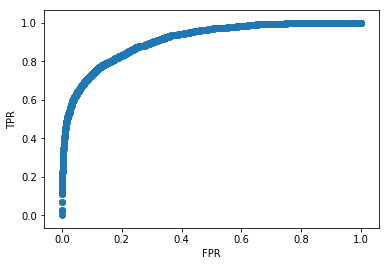

In [6]:
# Show the model statistics
mae = metrics.mean_absolute_error(y_val, y_pred_proba)
r2 = metrics.r2_score(y_val, y_pred_proba)
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_proba, pos_label=1, drop_intermediate=True)
print('mae: %.2f%%' % mae)
print('r2: %.2f%%' % r2)
print('FPR:',fpr)
print('TPR:',tpr)
print('thresholds:',thresholds)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.scatter(fpr,tpr)
plt.show()

[ 0.02467344  0.00145138  0.02612482  0.01015965  0.02467344  0.01306241
  0.01886792  0.03628447  0.04208998  0.01596517  0.00145138  0.
  0.06095791  0.          0.02467344  0.01161103  0.          0.00870827
  0.00145138  0.00145138  0.00725689  0.00435414  0.00435414  0.03047895
  0.01741655  0.00145138  0.00580552  0.00435414  0.          0.00290276
  0.          0.          0.          0.          0.01886792  0.
  0.00145138  0.02902758  0.01015965  0.01886792  0.00580552  0.00290276
  0.          0.00435414  0.01451379  0.          0.0203193   0.00435414
  0.00435414  0.00290276  0.          0.00145138  0.09433962  0.00725689
  0.04208998  0.0203193   0.          0.          0.          0.          0.
  0.00870827  0.01306241  0.00580552  0.00145138  0.00725689  0.          0.
  0.          0.          0.          0.          0.          0.
  0.03338171  0.          0.01015965  0.00580552  0.00725689  0.00290276
  0.          0.          0.00725689  0.00870827  0.          0.005

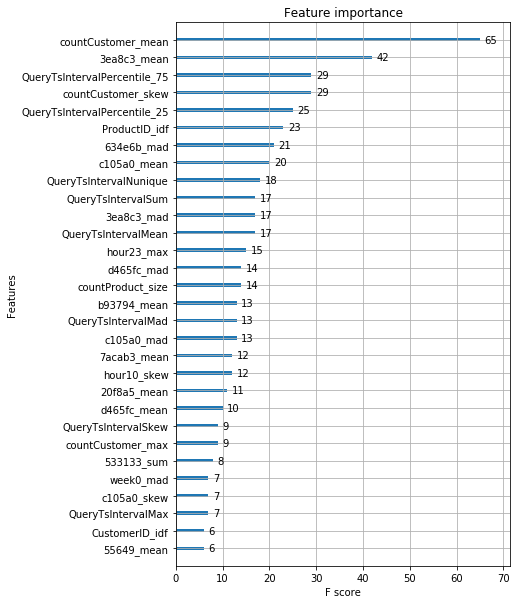

In [7]:
# Import the plot_importance function to visualize the feature importance
from xgboost import plot_importance
print(model_xgb.feature_importances_)
rcParams['figure.figsize'] = 6,10
plot_importance(model_xgb, max_num_features=30)
plt.show()

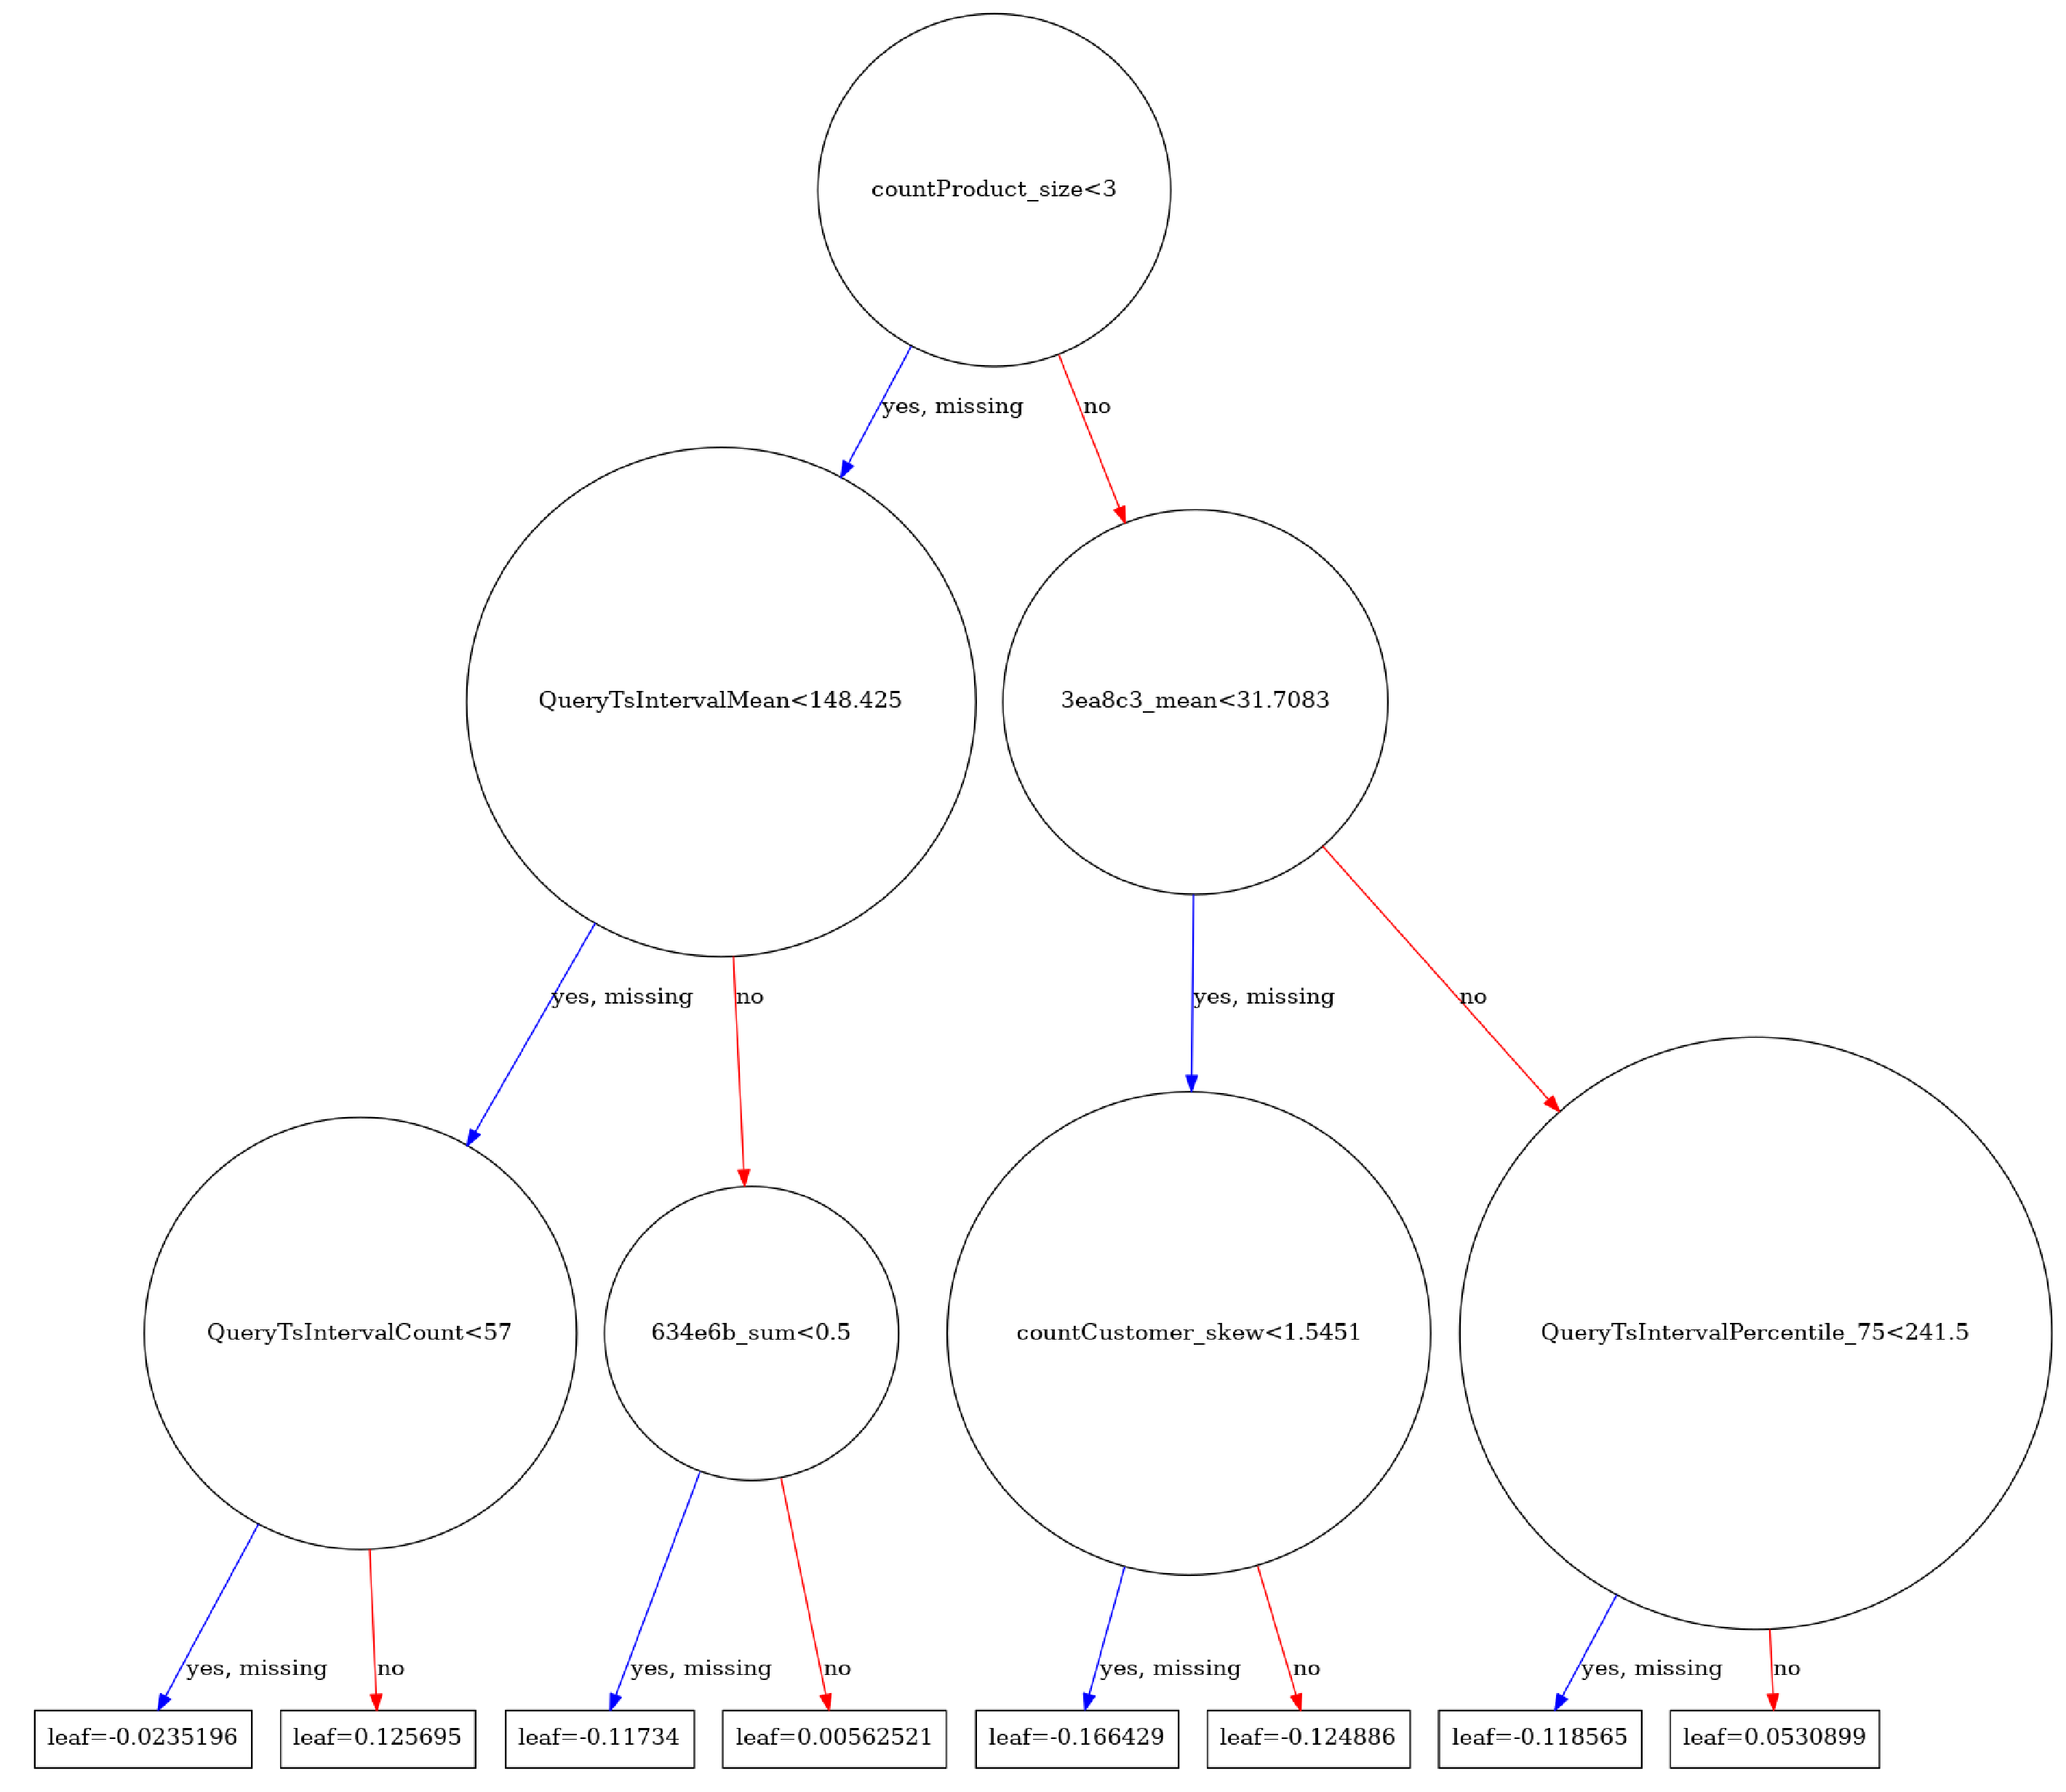

In [8]:
# Plot tree
from xgboost import plot_tree
rcParams['figure.figsize'] = 50,80
plot_tree(model_xgb, num_trees=1)
plt.show()

In [10]:
# Create submission
testing_set = pd.read_csv('testing-set.csv', encoding='utf-8', 
                          names=['FileID','Label'])
dft = pd.merge(df, testing_set, on=['FileID'], how='inner')
dft = dft.fillna(0)
dft2 = dft.drop(['FileID','Label'],1)
# Create submission
y_predt = grid.predict_proba(dft2)[:,1]
y_predt = pd.DataFrame(y_predt, columns=['Label'])
submission = pd.concat([pd.DataFrame(dft['FileID']), y_predt], axis=1)
submission.to_csv('trend_submission_cgb_436feature_stacking.csv', index=False, header=False)
#submission['Label'].value_counts()

In [11]:
submission

FileID     Label
0      00008c73ee43c15b16c26b26398c1577  0.004078
1      0002ded3a0b54f2ffdab0ca77a5ce2b6  0.998855
2      00050a9df8e13f6ab5a3d3b3e2fc6a86  0.004142
3      000b1aa62b95e448784b8b341de46c64  0.004138
4      000d9f96b5eddf04a3b7a37cb95d0a00  0.010798
5      00111635044e630cb47c519a6ab7e906  0.004157
6      00132b31a466e3e2a71ef5235e7d1305  0.004385
7      0014f376f7468a7e0c2a53634c59ac41  0.004134
8      0019e9f595600ccdad3b18fd533b8db2  0.004537
9      001e99215de891f05b5477909bc7f881  0.004134
10     001f3cc1a52d5f5f1bc00a695b0d76d6  0.400164
11     001fdd36a279feac528ff5a90b95abfe  0.009275
12     0020a74237a56d01edf2533a2b500b56  0.004317
13     00222cfb0a608b5c82b6146d8ab4b5e3  0.008493
14     002790d7b247bed1ee6f8cb22666de00  0.004157
15     002e1ecd5f949e85232c299d5edf2a43  0.138543
16     002e3abbb4493e8ed5c3580622fea049  0.004145
17     0033d1a13c7f83237452a34b6d71b47c  0.006272
18     0034545800bd3cd3c7348e6bfd3c8699  0.004324
19     003478d0d29d8a342c495f3175d45ddc  0.004536
20     00348cab07252551b7567418dd282295  0.006200
21     00351550e94ffd37fded54967678cde2  0.004133
22     00378119167b2a222cfa2ddbd0b71dae  0.014474
23     0037b95a0d0dd6a905ffd53cbc6dce84  0.004134
24     00387641d2371ec45e724630a0f53e0b  0.004141
25     0038782816483995071377d78c2104ad  0.999222
26     003af692f5aa17e3af3b363759fbd4bd  0.004135
27     003b12316f62a64e03d27782e1ff0fc2  0.008960
28     003b861864af16ba73bcb32377cbe57d  0.004786
29     003c43d809dddce82d156c8878692b16  0.361093
...                                 ...       ...
29346  ffc2226cf8d0e814f318d23e95524dcd  0.004146
29347  ffc4387d9a611d1c9c89211f0ce5a7de  0.004211
29348  ffc660085d32be842a2aab07da4235bb  0.004141
29349  ffc80fc5a1daab2bf9336b4dff8dbaa5  0.004495
29350  ffcc3f7b59462936d91a40bc5ea5bca6  0.589789
29351  ffcc906202b1b3f70e31533454b35573  0.004753
29352  ffcd31d7b8b1f3fcda43e21926ed3076  0.004134
29353  ffcd51e4a4e5efe8edac730dfcf821bb  0.012573
29354  ffcf1ab1a52c99af82ec961374b22a06  0.004686
29355  ffd224cf2101238b3c0176a0c32f96c9  0.004218
29356  ffd31127788411f78d0fe0424436ce9a  0.004592
29357  ffd4432f3d4ebd8a6bde8634d1c2aa12  0.998891
29358  ffd4cbd77d0976a35d1a63cbad0bcfa3  0.225552
29359  ffd5666cf92fabb2d92bda6fc0cc0b88  0.182074
29360  ffdb25940182ebabe7b026e9d456597d  0.005807
29361  ffdb275719979eb8b19ff0d1b1f78e25  0.004155
29362  ffdc1833a67d5cc70d316cfdf39ca9c3  0.004139
29363  ffdcb3a3234795d88fae929d494db6aa  0.005316
29364  ffde8dba3bc591ef4c3b7fc6be0ee230  0.004251
29365  ffdffdee8c65bc8112703a2cd7cecafb  0.004137
29366  ffe734ba47080c062a0c3a107142605b  0.014258
29367  ffe9c588d25f52e11827af0ad5edf823  0.031620
29368  ffea91ac33d536b569049298bbcc41c2  0.004229
29369  ffed0b71fef50044178032390f6968b5  0.004134
29370  ffeea6827b985bc9cd5e84866f833dbf  0.005320
29371  fff12a45cd80cab1c89e4099b9c535dd  0.004134
29372  fff266a849c1602596501467c23a5ea8  0.004550
29373  fff85183b75a0b07636d8de741721d2d  0.005529
29374  fffb47a6aba1caceaaa0a3a0c72ab51e  0.163960
29375  ffff94db3a63e4fd7585ddc10a2ab044  0.007399

[29376 rows x 2 columns]

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size = 0.33)

In [14]:
y_pred = model_xgb.predict(x_test)
y_pred_proba = model_xgb.predict_proba(x_test)[:,1]
import numpy as np
from sklearn import metrics
print(metrics.roc_auc_score(y_test,y_pred_proba))
print(metrics.accuracy_score(y_test,y_pred))

0.936843060279
0.940511222665


In [16]:
y_pred_proba.shape

(17331,)

In [41]:
submission.to_csv('trend_submission.csv', index=False, header=False)